# Teste 1

In [1]:
import sys
print(sys.executable)

/home/magda/tf-gpu-env/bin/python3.10


**Ver se está a usar a GPU**

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

2025-06-27 00:13:20.319720: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2025-06-27 00:13:21.796227: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13491965662582768027
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2351693824
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15209187189786404949
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


2025-06-27 00:13:23.908304: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-27 00:13:23.964848: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-27 00:13:23.964903: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-27 00:13:24.172234: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-27 00:13:24.172372: I tensorflow/compile

**imports**

In [3]:
import os
# Ativa o alocador assíncrono (melhora fragmentação de memória)
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"
import tensorflow as tf
# Ativa a alocação dinâmica de memória (não ocupa toda a memória no início)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print("Erro ao definir memory growth:", e)
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, GlobalAveragePooling2D, Dense, ReLU, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import roc_auc_score

print("TensorFlow:", tf.__version__)
print("TensorFlow Addons:", tfa.__version__)
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)
print("Matplotlib:", matplotlib.__version__)

2025-06-27 00:13:24.183112: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-27 00:13:24.183240: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-27 00:13:24.183279: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
/home/magda/tf-gpu-env/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.


TensorFlow: 2.13.0
TensorFlow Addons: 0.21.0
NumPy: 1.23.5
Pandas: 1.5.3
Matplotlib: 3.7.1


## Arquitetura do Modelo:

In [4]:
# Entrada
input_layer = Input(shape=(224, 224, 3))

# Primeira camada
x = Conv2D(48, (3,3), strides=2, padding='same')(input_layer)
x = BatchNormalization()(x)
x = ReLU()(x)

x = DepthwiseConv2D(kernel_size=3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(24, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(72, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = DepthwiseConv2D(kernel_size=3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(24, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

# ConvBlock_1
for _ in range(2):
    x = Conv2D(72, (1,1), strides=1, padding='same')(x)  # 24 -> 72
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = DepthwiseConv2D(kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(24, (1,1), strides=1, padding='same')(x)  # 72 -> 24
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
# Expandir de novo
x = Conv2D(72, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = DepthwiseConv2D(kernel_size=5, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(56, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

# ConvBlock_2
for _ in range(2):
    x = Conv2D(168, (1,1), strides=1, padding='same')(x)  # 56 -> 168
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = DepthwiseConv2D(kernel_size=5, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(56, (1,1), strides=1, padding='same')(x)  # 168 -> 56
    x = BatchNormalization()(x)
    x = ReLU()(x)

# Expandir de novo
x = Conv2D(336, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = DepthwiseConv2D(kernel_size=5, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(104, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

# ConvBlock_3
for _ in range(2):
    x = Conv2D(624, (1,1), strides=1, padding='same')(x)  # 104 -> 624
    x = BatchNormalization()(x)
    x = ReLU()(x)    
    x = DepthwiseConv2D(kernel_size=5, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)    
    x = Conv2D(104, (1,1), strides=1, padding='same')(x)  # 624 -> 104
    x = BatchNormalization()(x)
    x = ReLU()(x)

# Expandir
x = Conv2D(624, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = DepthwiseConv2D(kernel_size=3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(136, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

# ConvBlock_4
x = Conv2D(816, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = DepthwiseConv2D(kernel_size=3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(136, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

# Entre conv_blocks
x = Conv2D(816, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = DepthwiseConv2D(kernel_size=5, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(272, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

# ConvBlock_5
for _ in range(3):
    x = Conv2D(1632, (1,1), strides=1, padding='same')(x)  # 272 -> 1632
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = DepthwiseConv2D(kernel_size=5, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(272, (1,1), strides=1, padding='same')(x)  # 1632 -> 272
    x = BatchNormalization()(x)
    x = ReLU()(x)

# Finalização
x = Conv2D(1632, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = DepthwiseConv2D(kernel_size=3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(448, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(1280, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

# Pooling global e classificação
x = GlobalAveragePooling2D()(x)
output_layer = Dense(2, activation='softmax')(x)

# Modelo
model = Model(inputs=input_layer, outputs=output_layer)

2025-06-27 00:13:25.176212: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-27 00:13:25.176334: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-27 00:13:25.176374: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-27 00:13:25.176671: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-27 00:13:25.176687: I tensorflow/core/co

In [5]:
# Compilar o modelo
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.AUC(),
        tfa.metrics.F1Score(num_classes=2, average='macro')
    ]
)

In [6]:
# Mostrar resumo
model.summary()

Model: "model"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         


 conv2d (Conv2D)             (None, 112, 112, 48)      1344      


 batch_normalization (Batch  (None, 112, 112, 48)      192       


 Normalization)                                                  


 re_lu (ReLU)                (None, 112, 112, 48)      0         


 depthwise_conv2d (Depthwis  (None, 112, 112, 48)      480       


 eConv2D)                                                        


 batch_normalization_1 (Bat  (None, 112, 112, 48)      192       


 chNormalization)                                                


 re_lu_1 (ReLU)              (None, 112, 112, 48)      0         


 conv2d_1 (Conv2D)           (None, 112, 112, 24)      1176      


 batch_normalization_2 (Bat  (None, 112, 112, 24)      96        


 chNormalization)                                                


 re_lu_2 (ReLU)              (None, 112, 112, 24)      0         


 conv2d_2 (Conv2D)           (None, 112, 112, 72)      1800      


 batch_normalization_3 (Bat  (None, 112, 112, 72)      288       


 chNormalization)                                                


 re_lu_3 (ReLU)              (None, 112, 112, 72)      0         


 depthwise_conv2d_1 (Depthw  (None, 56, 56, 72)        720       


 iseConv2D)                                                      


 batch_normalization_4 (Bat  (None, 56, 56, 72)        288       


 chNormalization)                                                


 re_lu_4 (ReLU)              (None, 56, 56, 72)        0         


 conv2d_3 (Conv2D)           (None, 56, 56, 24)        1752      


 batch_normalization_5 (Bat  (None, 56, 56, 24)        96        


 chNormalization)                                                


 re_lu_5 (ReLU)              (None, 56, 56, 24)        0         


 conv2d_4 (Conv2D)           (None, 56, 56, 72)        1800      


 batch_normalization_6 (Bat  (None, 56, 56, 72)        288       


 chNormalization)                                                


 re_lu_6 (ReLU)              (None, 56, 56, 72)        0         


 depthwise_conv2d_2 (Depthw  (None, 56, 56, 72)        720       


 iseConv2D)                                                      


 batch_normalization_7 (Bat  (None, 56, 56, 72)        288       


 chNormalization)                                                


 re_lu_7 (ReLU)              (None, 56, 56, 72)        0         


 conv2d_5 (Conv2D)           (None, 56, 56, 24)        1752      


 batch_normalization_8 (Bat  (None, 56, 56, 24)        96        


 chNormalization)                                                


 re_lu_8 (ReLU)              (None, 56, 56, 24)        0         


 conv2d_6 (Conv2D)           (None, 56, 56, 72)        1800      


 batch_normalization_9 (Bat  (None, 56, 56, 72)        288       


 chNormalization)                                                


 re_lu_9 (ReLU)              (None, 56, 56, 72)        0         


 depthwise_conv2d_3 (Depthw  (None, 56, 56, 72)        720       


 iseConv2D)                                                      


 batch_normalization_10 (Ba  (None, 56, 56, 72)        288       


 tchNormalization)                                               


 re_lu_10 (ReLU)             (None, 56, 56, 72)        0         


 conv2d_7 (Conv2D)           (None, 56, 56, 24)        1752      


 batch_normalization_11 (Ba  (None, 56, 56, 24)        96        


 tchNormalization)                                               


 re_lu_11 (ReLU)             (None, 56, 56, 24)        0         


 conv2d_8 (Conv2D)           (None, 56, 56, 72)        1800      


 batch_normalization_12 (Ba  (None, 56, 56, 72)        288       


 tchNormalization)                                               


 re_lu_12 (ReLU)             (None, 56, 56, 72)        0         


 depthwise_conv2d_4 (Depthw  (None, 28, 28, 72)        1872      


 iseConv2D)                                                      


 batch_normalization_13 (Ba  (None, 28, 28, 72)        288       


 tchNormalization)                                               


 re_lu_13 (ReLU)             (None, 28, 28, 72)        0         


 conv2d_9 (Conv2D)           (None, 28, 28, 56)        4088      


 batch_normalization_14 (Ba  (None, 28, 28, 56)        224       


 tchNormalization)                                               


 re_lu_14 (ReLU)             (None, 28, 28, 56)        0         


 conv2d_10 (Conv2D)          (None, 28, 28, 168)       9576      


 batch_normalization_15 (Ba  (None, 28, 28, 168)       672       


 tchNormalization)                                               


 re_lu_15 (ReLU)             (None, 28, 28, 168)       0         


 depthwise_conv2d_5 (Depthw  (None, 28, 28, 168)       4368      


 iseConv2D)                                                      


 batch_normalization_16 (Ba  (None, 28, 28, 168)       672       


 tchNormalization)                                               


 re_lu_16 (ReLU)             (None, 28, 28, 168)       0         


 conv2d_11 (Conv2D)          (None, 28, 28, 56)        9464      


 batch_normalization_17 (Ba  (None, 28, 28, 56)        224       


 tchNormalization)                                               


 re_lu_17 (ReLU)             (None, 28, 28, 56)        0         


 conv2d_12 (Conv2D)          (None, 28, 28, 168)       9576      


 batch_normalization_18 (Ba  (None, 28, 28, 168)       672       


 tchNormalization)                                               


 re_lu_18 (ReLU)             (None, 28, 28, 168)       0         


 depthwise_conv2d_6 (Depthw  (None, 28, 28, 168)       4368      


 iseConv2D)                                                      


 batch_normalization_19 (Ba  (None, 28, 28, 168)       672       


 tchNormalization)                                               


 re_lu_19 (ReLU)             (None, 28, 28, 168)       0         


 conv2d_13 (Conv2D)          (None, 28, 28, 56)        9464      


 batch_normalization_20 (Ba  (None, 28, 28, 56)        224       


 tchNormalization)                                               


 re_lu_20 (ReLU)             (None, 28, 28, 56)        0         


 conv2d_14 (Conv2D)          (None, 28, 28, 336)       19152     


 batch_normalization_21 (Ba  (None, 28, 28, 336)       1344      


 tchNormalization)                                               


 re_lu_21 (ReLU)             (None, 28, 28, 336)       0         


 depthwise_conv2d_7 (Depthw  (None, 14, 14, 336)       8736      


 iseConv2D)                                                      


 batch_normalization_22 (Ba  (None, 14, 14, 336)       1344      


 tchNormalization)                                               


 re_lu_22 (ReLU)             (None, 14, 14, 336)       0         


 conv2d_15 (Conv2D)          (None, 14, 14, 104)       35048     


 batch_normalization_23 (Ba  (None, 14, 14, 104)       416       


 tchNormalization)                                               


 re_lu_23 (ReLU)             (None, 14, 14, 104)       0         


 conv2d_16 (Conv2D)          (None, 14, 14, 624)       65520     


 batch_normalization_24 (Ba  (None, 14, 14, 624)       2496      


 tchNormalization)                                               


 re_lu_24 (ReLU)             (None, 14, 14, 624)       0         


 depthwise_conv2d_8 (Depthw  (None, 14, 14, 624)       16224     


 iseConv2D)                                                      


 batch_normalization_25 (Ba  (None, 14, 14, 624)       2496      


 tchNormalization)                                               


 re_lu_25 (ReLU)             (None, 14, 14, 624)       0         


 conv2d_17 (Conv2D)          (None, 14, 14, 104)       65000     


 batch_normalization_26 (Ba  (None, 14, 14, 104)       416       


 tchNormalization)                                               


 re_lu_26 (ReLU)             (None, 14, 14, 104)       0         


 conv2d_18 (Conv2D)          (None, 14, 14, 624)       65520     


 batch_normalization_27 (Ba  (None, 14, 14, 624)       2496      


 tchNormalization)                                               


 re_lu_27 (ReLU)             (None, 14, 14, 624)       0         


 depthwise_conv2d_9 (Depthw  (None, 14, 14, 624)       16224     


 iseConv2D)                                                      


 batch_normalization_28 (Ba  (None, 14, 14, 624)       2496      


 tchNormalization)                                               


 re_lu_28 (ReLU)             (None, 14, 14, 624)       0         


 conv2d_19 (Conv2D)          (None, 14, 14, 104)       65000     


 batch_normalization_29 (Ba  (None, 14, 14, 104)       416       


 tchNormalization)                                               


 re_lu_29 (ReLU)             (None, 14, 14, 104)       0         


 conv2d_20 (Conv2D)          (None, 14, 14, 624)       65520     


 batch_normalization_30 (Ba  (None, 14, 14, 624)       2496      


 tchNormalization)                                               


 re_lu_30 (ReLU)             (None, 14, 14, 624)       0         


 depthwise_conv2d_10 (Depth  (None, 14, 14, 624)       6240      


 wiseConv2D)                                                     


 batch_normalization_31 (Ba  (None, 14, 14, 624)       2496      


 tchNormalization)                                               


 re_lu_31 (ReLU)             (None, 14, 14, 624)       0         


 conv2d_21 (Conv2D)          (None, 14, 14, 136)       85000     


 batch_normalization_32 (Ba  (None, 14, 14, 136)       544       


 tchNormalization)                                               


 re_lu_32 (ReLU)             (None, 14, 14, 136)       0         


 conv2d_22 (Conv2D)          (None, 14, 14, 816)       111792    


 batch_normalization_33 (Ba  (None, 14, 14, 816)       3264      


 tchNormalization)                                               


 re_lu_33 (ReLU)             (None, 14, 14, 816)       0         


 depthwise_conv2d_11 (Depth  (None, 14, 14, 816)       8160      


 wiseConv2D)                                                     


 batch_normalization_34 (Ba  (None, 14, 14, 816)       3264      


 tchNormalization)                                               


 re_lu_34 (ReLU)             (None, 14, 14, 816)       0         


 conv2d_23 (Conv2D)          (None, 14, 14, 136)       111112    


 batch_normalization_35 (Ba  (None, 14, 14, 136)       544       


 tchNormalization)                                               


 re_lu_35 (ReLU)             (None, 14, 14, 136)       0         


 conv2d_24 (Conv2D)          (None, 14, 14, 816)       111792    


 batch_normalization_36 (Ba  (None, 14, 14, 816)       3264      


 tchNormalization)                                               


 re_lu_36 (ReLU)             (None, 14, 14, 816)       0         


 depthwise_conv2d_12 (Depth  (None, 7, 7, 816)         21216     


 wiseConv2D)                                                     


 batch_normalization_37 (Ba  (None, 7, 7, 816)         3264      


 tchNormalization)                                               


 re_lu_37 (ReLU)             (None, 7, 7, 816)         0         


 conv2d_25 (Conv2D)          (None, 7, 7, 272)         222224    


 batch_normalization_38 (Ba  (None, 7, 7, 272)         1088      


 tchNormalization)                                               


 re_lu_38 (ReLU)             (None, 7, 7, 272)         0         


 conv2d_26 (Conv2D)          (None, 7, 7, 1632)        445536    


 batch_normalization_39 (Ba  (None, 7, 7, 1632)        6528      


 tchNormalization)                                               


 re_lu_39 (ReLU)             (None, 7, 7, 1632)        0         


 depthwise_conv2d_13 (Depth  (None, 7, 7, 1632)        42432     


 wiseConv2D)                                                     


 batch_normalization_40 (Ba  (None, 7, 7, 1632)        6528      


 tchNormalization)                                               


 re_lu_40 (ReLU)             (None, 7, 7, 1632)        0         


 conv2d_27 (Conv2D)          (None, 7, 7, 272)         444176    


 batch_normalization_41 (Ba  (None, 7, 7, 272)         1088      


 tchNormalization)                                               


 re_lu_41 (ReLU)             (None, 7, 7, 272)         0         


 conv2d_28 (Conv2D)          (None, 7, 7, 1632)        445536    


 batch_normalization_42 (Ba  (None, 7, 7, 1632)        6528      


 tchNormalization)                                               


 re_lu_42 (ReLU)             (None, 7, 7, 1632)        0         


 depthwise_conv2d_14 (Depth  (None, 7, 7, 1632)        42432     


 wiseConv2D)                                                     


 batch_normalization_43 (Ba  (None, 7, 7, 1632)        6528      


 tchNormalization)                                               


 re_lu_43 (ReLU)             (None, 7, 7, 1632)        0         


 conv2d_29 (Conv2D)          (None, 7, 7, 272)         444176    


 batch_normalization_44 (Ba  (None, 7, 7, 272)         1088      


 tchNormalization)                                               


 re_lu_44 (ReLU)             (None, 7, 7, 272)         0         


 conv2d_30 (Conv2D)          (None, 7, 7, 1632)        445536    


 batch_normalization_45 (Ba  (None, 7, 7, 1632)        6528      


 tchNormalization)                                               


 re_lu_45 (ReLU)             (None, 7, 7, 1632)        0         


 depthwise_conv2d_15 (Depth  (None, 7, 7, 1632)        42432     


 wiseConv2D)                                                     


 batch_normalization_46 (Ba  (None, 7, 7, 1632)        6528      


 tchNormalization)                                               


 re_lu_46 (ReLU)             (None, 7, 7, 1632)        0         


 conv2d_31 (Conv2D)          (None, 7, 7, 272)         444176    


 batch_normalization_47 (Ba  (None, 7, 7, 272)         1088      


 tchNormalization)                                               


 re_lu_47 (ReLU)             (None, 7, 7, 272)         0         


 conv2d_32 (Conv2D)          (None, 7, 7, 1632)        445536    


 batch_normalization_48 (Ba  (None, 7, 7, 1632)        6528      


 tchNormalization)                                               


 re_lu_48 (ReLU)             (None, 7, 7, 1632)        0         


 depthwise_conv2d_16 (Depth  (None, 7, 7, 1632)        16320     


 wiseConv2D)                                                     


 batch_normalization_49 (Ba  (None, 7, 7, 1632)        6528      


 tchNormalization)                                               


 re_lu_49 (ReLU)             (None, 7, 7, 1632)        0         


 conv2d_33 (Conv2D)          (None, 7, 7, 448)         731584    


 batch_normalization_50 (Ba  (None, 7, 7, 448)         1792      


 tchNormalization)                                               


 re_lu_50 (ReLU)             (None, 7, 7, 448)         0         


 conv2d_34 (Conv2D)          (None, 7, 7, 1280)        574720    


 batch_normalization_51 (Ba  (None, 7, 7, 1280)        5120      


 tchNormalization)                                               


 re_lu_51 (ReLU)             (None, 7, 7, 1280)        0         


 global_average_pooling2d (  (None, 1280)              0         


 GlobalAveragePooling2D)                                         


 dense (Dense)               (None, 2)                 2562      


Total params: 5840002 (22.28 MB)


Trainable params: 5788514 (22.08 MB)


Non-trainable params: 51488 (201.12 KB)


_________________________________________________________________


## Funções Auxiliares

Trata do pré-processamento das imagens, ou seja redimensiona para 224 X 224 pixels e normaliza [0,1] e coloca em one hot.

In [7]:
# Função auxiliar para carregar imagem
def preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = image / 255.0
    label = tf.one_hot(label, 2)
    return image, label

Permite analisar a distribuição dos datasets.

In [8]:
def inspect_dataset_distribution(dataset, name="dataset"):
    total_samples = 0
    label_counter = Counter()

    for images, labels in dataset:
        # labels vêm em one-hot: [0,1] ou [1,0]
        labels_np = labels.numpy()
        class_indices = labels_np.argmax(axis=1)  # <-- Corrigir: pegar o índice da classe correta
        total_samples += len(class_indices)
        label_counter.update(class_indices)

    print(f"📊 {name.upper()} -> Total de imagens: {total_samples}")
    for label, count in sorted(label_counter.items()):
        perc = (count / total_samples) * 100
        print(f"  Classe {int(label)} ({'Fogo' if label == 1 else 'Sem fogo'}): {count} imagens ({perc:.2f}%)")
    print("-" * 40)

Permite analisar o histórico de trino.

In [9]:
def plot_training_history(history):
    metrics = history.history.keys()
    epochs_range = range(len(history.history['loss']))

    for metric in metrics:
        if "val_" not in metric:
            plt.figure(figsize=(10, 5))
            plt.plot(epochs_range, history.history[metric], label=f"Train {metric}")
            if f"val_{metric}" in metrics:
                plt.plot(epochs_range, history.history[f"val_{metric}"], label=f"Val {metric}")
            plt.title(f"Training and Validation {metric.capitalize()}")
            plt.xlabel("Epochs")
            plt.ylabel(metric.capitalize())
            plt.legend()
            plt.grid(True)
            plt.show()

Usada para avaliar o modelo, ou seja, se está a prever corretamente a classificação das imagens.

In [10]:
def avaliar_modelo(model, dataset):
    # 1. Previsões e rótulos reais
    y_pred_probs = model.predict(dataset, verbose=0)
    y_true = np.concatenate([y for _, y in dataset], axis=0)
    y_true_int = np.argmax(y_true, axis=1)
    y_pred_int = (y_pred_probs[:, 1] > 0.5).astype(int)

    # 2. Contagem das classes
    TP = np.sum((y_true_int == 1) & (y_pred_int == 1))
    TN = np.sum((y_true_int == 0) & (y_pred_int == 0))
    FP = np.sum((y_true_int == 0) & (y_pred_int == 1))
    FN = np.sum((y_true_int == 1) & (y_pred_int == 0))

    total = TP + TN + FP + FN

    # 3. Cálculo das métricas com base nas fórmulas
    accuracy   = (TP + TN) / total if total > 0 else 0.0
    precision  = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall     = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1_score   = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    auc        = roc_auc_score(y_true_int, y_pred_probs[:, 1])

    # Binary crossentropy loss
    eps = 1e-7
    p = np.clip(y_pred_probs[:, 1], eps, 1 - eps)
    y = y_true_int
    loss = - np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))

    # Métricas específicas de detecção de incêndio
    fdr = recall * 100  # ou (TP / (TP + FN)) * 100
    ewr = ((FP + FN) / total) * 100 if total > 0 else 0.0

    # 4. Impressão
    print("=== MÉTRICAS DE AVALIAÇÃO ===")
    print(f"TP={TP}, TN={TN}, FP={FP}, FN={FN}")
    print(f"Accuracy       : {accuracy:.4f}")
    print(f"Precision      : {precision:.4f}")
    print(f"Recall         : {recall:.4f}")
    print(f"F1-Score       : {f1_score:.4f}")
    print(f"AUC            : {auc:.4f}")
    print(f"Binary Loss    : {loss:.4f}")
    print(f"FDR (Fire Detection Rate)      : {fdr:.2f} %")
    print(f"EWR (Error Warning Rate)       : {ewr:.2f} %")
    print("Confusion Matrix:")
    print(np.array([[TN, FP], [FN, TP]]))  # [[negativos reais], [positivos reais]]

    # 5. Retorno opcional
    return {
        'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'auc': auc,
        'loss': loss,
        'fdr': fdr,
        'ewr': ewr,
        'confusion_matrix': np.array([[TN, FP], [FN, TP]])
    }

## Treino

In [11]:
# Configurações gerais
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 16
EPOCHS = 50
SEED = 42

In [12]:
data = pd.read_csv("../Datasets_Mixed/mixed_1_train.csv")
image_paths = data['image_path'].values
labels = data['label_bi'].values

data = pd.read_csv("../Datasets_Mixed/mixed_1_test.csv")
image_paths_test = data['image_path'].values
labels_test = data['label_bi'].values

In [13]:
# Dividir em treino, validação e teste (90/10)
x_train, x_val, y_train, y_val = train_test_split(image_paths, labels, test_size=0.1, random_state=SEED, stratify=labels)

In [14]:
# Criar datasets TensorFlow
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.map(preprocess_image).shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_ds = val_ds.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((image_paths_test, labels_test))
test_ds = test_ds.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [15]:
inspect_dataset_distribution(train_ds, name="train")
inspect_dataset_distribution(val_ds, name="val")
inspect_dataset_distribution(test_ds, name="test")

📊 TRAIN -> Total de imagens: 2957
  Classe 0 (Sem fogo): 1162 imagens (39.30%)
  Classe 1 (Fogo): 1795 imagens (60.70%)
----------------------------------------


📊 VAL -> Total de imagens: 329
  Classe 0 (Sem fogo): 129 imagens (39.21%)
  Classe 1 (Fogo): 200 imagens (60.79%)
----------------------------------------


📊 TEST -> Total de imagens: 19532
  Classe 0 (Sem fogo): 9748 imagens (49.91%)
  Classe 1 (Fogo): 9784 imagens (50.09%)
----------------------------------------


In [16]:
callback = [
    ModelCheckpoint('test_1_best.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

In [17]:
# Treinar
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callback
)

Epoch 1/50


2025-06-27 00:13:55.937423: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


2025-06-27 00:13:57.598821: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x779de40a8f80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-06-27 00:13:57.598868: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
2025-06-27 00:13:57.660272: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


2025-06-27 00:13:57.949297: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-06-27 00:13:58.129656: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.25GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-06-27 00:13:58.130279: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.25GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


2025-06-27 00:13:58.190526: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.29GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-06-27 00:13:58.222939: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.29GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


2025-06-27 00:13:58.606880: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.58GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-06-27 00:13:58.606999: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.58GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-06-27 00:13:58.652249: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.60GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-06-27 00:13:58.652372: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU

  1/185 [..............................] - ETA: 1:30:44 - loss: 0.3999 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9609 - f1_score: 0.4667

  2/185 [..............................] - ETA: 22s - loss: 0.8023 - accuracy: 0.7188 - precision: 0.7188 - recall: 0.7188 - auc: 0.6826 - f1_score: 0.4182    

  3/185 [..............................] - ETA: 22s - loss: 0.9732 - accuracy: 0.6458 - precision: 0.6458 - recall: 0.6458 - auc: 0.6406 - f1_score: 0.4422

  4/185 [..............................] - ETA: 22s - loss: 0.9220 - accuracy: 0.6250 - precision: 0.6250 - recall: 0.6250 - auc: 0.6338 - f1_score: 0.4208

  5/185 [..............................] - ETA: 22s - loss: 0.9227 - accuracy: 0.6250 - precision: 0.6250 - recall: 0.6250 - auc: 0.6273 - f1_score: 0.5000

  6/185 [..............................] - ETA: 22s - loss: 0.8991 - accuracy: 0.6042 - precision: 0.6042 - recall: 0.6042 - auc: 0.6302 - f1_score: 0.5306

  7/185 [>.............................] - ETA: 22s - loss: 0.8488 - accuracy: 0.6250 - precision: 0.6250 - recall: 0.6250 - auc: 0.6423 - f1_score: 0.5317

  8/185 [>.............................] - ETA: 21s - loss: 0.8640 - accuracy: 0.6094 - precision: 0.6094 - recall: 0.6094 - auc: 0.6237 - f1_score: 0.5084

  9/185 [>.............................] - ETA: 21s - loss: 0.9002 - accuracy: 0.6042 - precision: 0.6042 - recall: 0.6042 - auc: 0.6086 - f1_score: 0.4948

 10/185 [>.............................] - ETA: 21s - loss: 0.8666 - accuracy: 0.6187 - precision: 0.6187 - recall: 0.6187 - auc: 0.6232 - f1_score: 0.4958

 11/185 [>.............................] - ETA: 21s - loss: 0.8494 - accuracy: 0.6193 - precision: 0.6193 - recall: 0.6193 - auc: 0.6249 - f1_score: 0.4885

 12/185 [>.............................] - ETA: 21s - loss: 0.8313 - accuracy: 0.6250 - precision: 0.6250 - recall: 0.6250 - auc: 0.6310 - f1_score: 0.4854

 13/185 [=>............................] - ETA: 21s - loss: 0.8038 - accuracy: 0.6394 - precision: 0.6394 - recall: 0.6394 - auc: 0.6452 - f1_score: 0.4958

 14/185 [=>............................] - ETA: 21s - loss: 0.8174 - accuracy: 0.6429 - precision: 0.6429 - recall: 0.6429 - auc: 0.6487 - f1_score: 0.4922

 15/185 [=>............................] - ETA: 20s - loss: 0.8249 - accuracy: 0.6417 - precision: 0.6417 - recall: 0.6417 - auc: 0.6426 - f1_score: 0.4992

 16/185 [=>............................] - ETA: 20s - loss: 0.8022 - accuracy: 0.6484 - precision: 0.6484 - recall: 0.6484 - auc: 0.6570 - f1_score: 0.5263

 17/185 [=>............................] - ETA: 20s - loss: 0.7883 - accuracy: 0.6434 - precision: 0.6434 - recall: 0.6434 - auc: 0.6641 - f1_score: 0.5357

 18/185 [=>............................] - ETA: 20s - loss: 0.7774 - accuracy: 0.6389 - precision: 0.6389 - recall: 0.6389 - auc: 0.6688 - f1_score: 0.5391

 19/185 [==>...........................] - ETA: 20s - loss: 0.8094 - accuracy: 0.6316 - precision: 0.6316 - recall: 0.6316 - auc: 0.6584 - f1_score: 0.5427

 20/185 [==>...........................] - ETA: 20s - loss: 0.8109 - accuracy: 0.6281 - precision: 0.6281 - recall: 0.6281 - auc: 0.6531 - f1_score: 0.5353

 21/185 [==>...........................] - ETA: 20s - loss: 0.7949 - accuracy: 0.6369 - precision: 0.6369 - recall: 0.6369 - auc: 0.6637 - f1_score: 0.5371

 22/185 [==>...........................] - ETA: 20s - loss: 0.7906 - accuracy: 0.6392 - precision: 0.6392 - recall: 0.6392 - auc: 0.6662 - f1_score: 0.5344

 23/185 [==>...........................] - ETA: 19s - loss: 0.7741 - accuracy: 0.6467 - precision: 0.6467 - recall: 0.6467 - auc: 0.6775 - f1_score: 0.5356

 24/185 [==>...........................] - ETA: 19s - loss: 0.7753 - accuracy: 0.6458 - precision: 0.6458 - recall: 0.6458 - auc: 0.6748 - f1_score: 0.5310

 25/185 [===>..........................] - ETA: 19s - loss: 0.7847 - accuracy: 0.6400 - precision: 0.6400 - recall: 0.6400 - auc: 0.6671 - f1_score: 0.5232

 26/185 [===>..........................] - ETA: 19s - loss: 0.7884 - accuracy: 0.6394 - precision: 0.6394 - recall: 0.6394 - auc: 0.6620 - f1_score: 0.5223

 27/185 [===>..........................] - ETA: 19s - loss: 0.7913 - accuracy: 0.6343 - precision: 0.6343 - recall: 0.6343 - auc: 0.6583 - f1_score: 0.5266

 28/185 [===>..........................] - ETA: 19s - loss: 0.7866 - accuracy: 0.6339 - precision: 0.6339 - recall: 0.6339 - auc: 0.6572 - f1_score: 0.5382

 29/185 [===>..........................] - ETA: 19s - loss: 0.7879 - accuracy: 0.6272 - precision: 0.6272 - recall: 0.6272 - auc: 0.6519 - f1_score: 0.5410

 30/185 [===>..........................] - ETA: 19s - loss: 0.7892 - accuracy: 0.6208 - precision: 0.6208 - recall: 0.6208 - auc: 0.6476 - f1_score: 0.5468

 31/185 [====>.........................] - ETA: 18s - loss: 0.7920 - accuracy: 0.6028 - precision: 0.6028 - recall: 0.6028 - auc: 0.6408 - f1_score: 0.5320

 32/185 [====>.........................] - ETA: 18s - loss: 0.7927 - accuracy: 0.5957 - precision: 0.5957 - recall: 0.5957 - auc: 0.6366 - f1_score: 0.5254

 33/185 [====>.........................] - ETA: 18s - loss: 0.7882 - accuracy: 0.5966 - precision: 0.5966 - recall: 0.5966 - auc: 0.6367 - f1_score: 0.5233

 34/185 [====>.........................] - ETA: 18s - loss: 0.7904 - accuracy: 0.5919 - precision: 0.5919 - recall: 0.5919 - auc: 0.6316 - f1_score: 0.5172

 35/185 [====>.........................] - ETA: 18s - loss: 0.7880 - accuracy: 0.5893 - precision: 0.5893 - recall: 0.5893 - auc: 0.6314 - f1_score: 0.5127

 36/185 [====>.........................] - ETA: 18s - loss: 0.7819 - accuracy: 0.5920 - precision: 0.5920 - recall: 0.5920 - auc: 0.6347 - f1_score: 0.5122

 37/185 [=====>........................] - ETA: 18s - loss: 0.7798 - accuracy: 0.5912 - precision: 0.5912 - recall: 0.5912 - auc: 0.6343 - f1_score: 0.5092

 38/185 [=====>........................] - ETA: 18s - loss: 0.7810 - accuracy: 0.5905 - precision: 0.5905 - recall: 0.5905 - auc: 0.6341 - f1_score: 0.5063

 39/185 [=====>........................] - ETA: 17s - loss: 0.7758 - accuracy: 0.5913 - precision: 0.5913 - recall: 0.5913 - auc: 0.6359 - f1_score: 0.5063

 40/185 [=====>........................] - ETA: 17s - loss: 0.7744 - accuracy: 0.5891 - precision: 0.5891 - recall: 0.5891 - auc: 0.6347 - f1_score: 0.5025

 41/185 [=====>........................] - ETA: 17s - loss: 0.7708 - accuracy: 0.5884 - precision: 0.5884 - recall: 0.5884 - auc: 0.6353 - f1_score: 0.5074

 42/185 [=====>........................] - ETA: 17s - loss: 0.7657 - accuracy: 0.5908 - precision: 0.5908 - recall: 0.5908 - auc: 0.6376 - f1_score: 0.5168

 43/185 [=====>........................] - ETA: 17s - loss: 0.7674 - accuracy: 0.5858 - precision: 0.5858 - recall: 0.5858 - auc: 0.6339 - f1_score: 0.5149

 44/185 [======>.......................] - ETA: 17s - loss: 0.7656 - accuracy: 0.5838 - precision: 0.5838 - recall: 0.5838 - auc: 0.6326 - f1_score: 0.5175

 45/185 [======>.......................] - ETA: 17s - loss: 0.7699 - accuracy: 0.5806 - precision: 0.5806 - recall: 0.5806 - auc: 0.6292 - f1_score: 0.5165

 46/185 [======>.......................] - ETA: 17s - loss: 0.7684 - accuracy: 0.5802 - precision: 0.5802 - recall: 0.5802 - auc: 0.6277 - f1_score: 0.5143

 47/185 [======>.......................] - ETA: 16s - loss: 0.7679 - accuracy: 0.5785 - precision: 0.5785 - recall: 0.5785 - auc: 0.6255 - f1_score: 0.5112

 48/185 [======>.......................] - ETA: 16s - loss: 0.7690 - accuracy: 0.5768 - precision: 0.5768 - recall: 0.5768 - auc: 0.6227 - f1_score: 0.5092

 49/185 [======>.......................] - ETA: 16s - loss: 0.7674 - accuracy: 0.5765 - precision: 0.5765 - recall: 0.5765 - auc: 0.6227 - f1_score: 0.5083

 50/185 [=======>......................] - ETA: 16s - loss: 0.7674 - accuracy: 0.5763 - precision: 0.5763 - recall: 0.5763 - auc: 0.6210 - f1_score: 0.5064

 51/185 [=======>......................] - ETA: 16s - loss: 0.7665 - accuracy: 0.5748 - precision: 0.5748 - recall: 0.5748 - auc: 0.6196 - f1_score: 0.5046

 52/185 [=======>......................] - ETA: 16s - loss: 0.7619 - accuracy: 0.5817 - precision: 0.5817 - recall: 0.5817 - auc: 0.6222 - f1_score: 0.5091

 53/185 [=======>......................] - ETA: 16s - loss: 0.7636 - accuracy: 0.5790 - precision: 0.5790 - recall: 0.5790 - auc: 0.6197 - f1_score: 0.5055

 54/185 [=======>......................] - ETA: 16s - loss: 0.7657 - accuracy: 0.5787 - precision: 0.5787 - recall: 0.5787 - auc: 0.6171 - f1_score: 0.5036

 55/185 [=======>......................] - ETA: 16s - loss: 0.7629 - accuracy: 0.5807 - precision: 0.5807 - recall: 0.5807 - auc: 0.6181 - f1_score: 0.5035

 56/185 [========>.....................] - ETA: 15s - loss: 0.7619 - accuracy: 0.5804 - precision: 0.5804 - recall: 0.5804 - auc: 0.6172 - f1_score: 0.5017

 57/185 [========>.....................] - ETA: 15s - loss: 0.7604 - accuracy: 0.5822 - precision: 0.5822 - recall: 0.5822 - auc: 0.6176 - f1_score: 0.5015

 58/185 [========>.....................] - ETA: 15s - loss: 0.7587 - accuracy: 0.5830 - precision: 0.5830 - recall: 0.5830 - auc: 0.6177 - f1_score: 0.5005

 59/185 [========>.....................] - ETA: 15s - loss: 0.7551 - accuracy: 0.5869 - precision: 0.5869 - recall: 0.5869 - auc: 0.6205 - f1_score: 0.5018

 60/185 [========>.....................] - ETA: 15s - loss: 0.7526 - accuracy: 0.5875 - precision: 0.5875 - recall: 0.5875 - auc: 0.6222 - f1_score: 0.5008

 61/185 [========>.....................] - ETA: 15s - loss: 0.7542 - accuracy: 0.5861 - precision: 0.5861 - recall: 0.5861 - auc: 0.6198 - f1_score: 0.4984

 62/185 [=========>....................] - ETA: 15s - loss: 0.7564 - accuracy: 0.5827 - precision: 0.5827 - recall: 0.5827 - auc: 0.6156 - f1_score: 0.4957

 63/185 [=========>....................] - ETA: 15s - loss: 0.7547 - accuracy: 0.5833 - precision: 0.5833 - recall: 0.5833 - auc: 0.6166 - f1_score: 0.4948

 64/185 [=========>....................] - ETA: 14s - loss: 0.7557 - accuracy: 0.5801 - precision: 0.5801 - recall: 0.5801 - auc: 0.6140 - f1_score: 0.4912

 65/185 [=========>....................] - ETA: 14s - loss: 0.7557 - accuracy: 0.5788 - precision: 0.5788 - recall: 0.5788 - auc: 0.6124 - f1_score: 0.4890

 66/185 [=========>....................] - ETA: 14s - loss: 0.7560 - accuracy: 0.5777 - precision: 0.5777 - recall: 0.5777 - auc: 0.6111 - f1_score: 0.4928

 67/185 [=========>....................] - ETA: 14s - loss: 0.7575 - accuracy: 0.5756 - precision: 0.5756 - recall: 0.5756 - auc: 0.6091 - f1_score: 0.4955

 68/185 [==========>...................] - ETA: 14s - loss: 0.7564 - accuracy: 0.5744 - precision: 0.5744 - recall: 0.5744 - auc: 0.6087 - f1_score: 0.4987

 69/185 [==========>...................] - ETA: 14s - loss: 0.7555 - accuracy: 0.5734 - precision: 0.5734 - recall: 0.5734 - auc: 0.6082 - f1_score: 0.5016

 70/185 [==========>...................] - ETA: 14s - loss: 0.7563 - accuracy: 0.5714 - precision: 0.5714 - recall: 0.5714 - auc: 0.6059 - f1_score: 0.5036

 71/185 [==========>...................] - ETA: 14s - loss: 0.7552 - accuracy: 0.5713 - precision: 0.5713 - recall: 0.5713 - auc: 0.6058 - f1_score: 0.5082

 72/185 [==========>...................] - ETA: 13s - loss: 0.7541 - accuracy: 0.5712 - precision: 0.5712 - recall: 0.5712 - auc: 0.6057 - f1_score: 0.5117

 73/185 [==========>...................] - ETA: 13s - loss: 0.7536 - accuracy: 0.5702 - precision: 0.5702 - recall: 0.5702 - auc: 0.6047 - f1_score: 0.5144

 74/185 [===========>..................] - ETA: 13s - loss: 0.7542 - accuracy: 0.5659 - precision: 0.5659 - recall: 0.5659 - auc: 0.6021 - f1_score: 0.5124

 75/185 [===========>..................] - ETA: 13s - loss: 0.7532 - accuracy: 0.5642 - precision: 0.5642 - recall: 0.5642 - auc: 0.6018 - f1_score: 0.5130

 76/185 [===========>..................] - ETA: 13s - loss: 0.7524 - accuracy: 0.5641 - precision: 0.5641 - recall: 0.5641 - auc: 0.6010 - f1_score: 0.5136

 77/185 [===========>..................] - ETA: 13s - loss: 0.7521 - accuracy: 0.5625 - precision: 0.5625 - recall: 0.5625 - auc: 0.5997 - f1_score: 0.5118

 78/185 [===========>..................] - ETA: 13s - loss: 0.7524 - accuracy: 0.5609 - precision: 0.5609 - recall: 0.5609 - auc: 0.5982 - f1_score: 0.5095

 79/185 [===========>..................] - ETA: 13s - loss: 0.7519 - accuracy: 0.5609 - precision: 0.5609 - recall: 0.5609 - auc: 0.5975 - f1_score: 0.5084

 80/185 [===========>..................] - ETA: 13s - loss: 0.7510 - accuracy: 0.5609 - precision: 0.5609 - recall: 0.5609 - auc: 0.5978 - f1_score: 0.5074

 81/185 [============>.................] - ETA: 13s - loss: 0.7504 - accuracy: 0.5610 - precision: 0.5610 - recall: 0.5610 - auc: 0.5975 - f1_score: 0.5064

 82/185 [============>.................] - ETA: 12s - loss: 0.7497 - accuracy: 0.5617 - precision: 0.5617 - recall: 0.5617 - auc: 0.5975 - f1_score: 0.5059

 83/185 [============>.................] - ETA: 12s - loss: 0.7486 - accuracy: 0.5617 - precision: 0.5617 - recall: 0.5617 - auc: 0.5979 - f1_score: 0.5049

 84/185 [============>.................] - ETA: 12s - loss: 0.7475 - accuracy: 0.5625 - precision: 0.5625 - recall: 0.5625 - auc: 0.5983 - f1_score: 0.5044

 85/185 [============>.................] - ETA: 12s - loss: 0.7456 - accuracy: 0.5647 - precision: 0.5647 - recall: 0.5647 - auc: 0.6000 - f1_score: 0.5057

 86/185 [============>.................] - ETA: 12s - loss: 0.7451 - accuracy: 0.5647 - precision: 0.5647 - recall: 0.5647 - auc: 0.5995 - f1_score: 0.5047

 87/185 [=============>................] - ETA: 12s - loss: 0.7438 - accuracy: 0.5654 - precision: 0.5654 - recall: 0.5654 - auc: 0.6002 - f1_score: 0.5042

 88/185 [=============>................] - ETA: 12s - loss: 0.7435 - accuracy: 0.5639 - precision: 0.5639 - recall: 0.5639 - auc: 0.5999 - f1_score: 0.5027

 89/185 [=============>................] - ETA: 12s - loss: 0.7418 - accuracy: 0.5660 - precision: 0.5660 - recall: 0.5660 - auc: 0.6012 - f1_score: 0.5044

 90/185 [=============>................] - ETA: 11s - loss: 0.7412 - accuracy: 0.5653 - precision: 0.5653 - recall: 0.5653 - auc: 0.6008 - f1_score: 0.5040

 91/185 [=============>................] - ETA: 11s - loss: 0.7398 - accuracy: 0.5673 - precision: 0.5673 - recall: 0.5673 - auc: 0.6017 - f1_score: 0.5068

 92/185 [=============>................] - ETA: 11s - loss: 0.7394 - accuracy: 0.5659 - precision: 0.5659 - recall: 0.5659 - auc: 0.6011 - f1_score: 0.5053

 93/185 [==============>...............] - ETA: 11s - loss: 0.7401 - accuracy: 0.5659 - precision: 0.5659 - recall: 0.5659 - auc: 0.6002 - f1_score: 0.5060

 94/185 [==============>...............] - ETA: 11s - loss: 0.7408 - accuracy: 0.5665 - precision: 0.5665 - recall: 0.5665 - auc: 0.5993 - f1_score: 0.5076

 95/185 [==============>...............] - ETA: 11s - loss: 0.7395 - accuracy: 0.5678 - precision: 0.5678 - recall: 0.5678 - auc: 0.6000 - f1_score: 0.5097

 96/185 [==============>...............] - ETA: 11s - loss: 0.7378 - accuracy: 0.5697 - precision: 0.5697 - recall: 0.5697 - auc: 0.6013 - f1_score: 0.5127

 97/185 [==============>...............] - ETA: 11s - loss: 0.7383 - accuracy: 0.5670 - precision: 0.5670 - recall: 0.5670 - auc: 0.5996 - f1_score: 0.5108

 98/185 [==============>...............] - ETA: 11s - loss: 0.7370 - accuracy: 0.5676 - precision: 0.5676 - recall: 0.5676 - auc: 0.6005 - f1_score: 0.5128

 99/185 [===============>..............] - ETA: 10s - loss: 0.7365 - accuracy: 0.5669 - precision: 0.5669 - recall: 0.5669 - auc: 0.6002 - f1_score: 0.5137

100/185 [===============>..............] - ETA: 10s - loss: 0.7352 - accuracy: 0.5688 - precision: 0.5688 - recall: 0.5688 - auc: 0.6011 - f1_score: 0.5174

101/185 [===============>..............] - ETA: 10s - loss: 0.7347 - accuracy: 0.5681 - precision: 0.5681 - recall: 0.5681 - auc: 0.6009 - f1_score: 0.5173

102/185 [===============>..............] - ETA: 10s - loss: 0.7337 - accuracy: 0.5686 - precision: 0.5686 - recall: 0.5686 - auc: 0.6017 - f1_score: 0.5190

103/185 [===============>..............] - ETA: 10s - loss: 0.7327 - accuracy: 0.5698 - precision: 0.5698 - recall: 0.5698 - auc: 0.6022 - f1_score: 0.5208

104/185 [===============>..............] - ETA: 10s - loss: 0.7321 - accuracy: 0.5727 - precision: 0.5727 - recall: 0.5727 - auc: 0.6025 - f1_score: 0.5247

105/185 [================>.............] - ETA: 10s - loss: 0.7306 - accuracy: 0.5744 - precision: 0.5744 - recall: 0.5744 - auc: 0.6043 - f1_score: 0.5272

106/185 [================>.............] - ETA: 10s - loss: 0.7279 - accuracy: 0.5767 - precision: 0.5767 - recall: 0.5767 - auc: 0.6076 - f1_score: 0.5301

107/185 [================>.............] - ETA: 9s - loss: 0.7285 - accuracy: 0.5777 - precision: 0.5777 - recall: 0.5777 - auc: 0.6073 - f1_score: 0.5316 

108/185 [================>.............] - ETA: 9s - loss: 0.7269 - accuracy: 0.5793 - precision: 0.5793 - recall: 0.5793 - auc: 0.6099 - f1_score: 0.5328

109/185 [================>.............] - ETA: 9s - loss: 0.7253 - accuracy: 0.5814 - precision: 0.5814 - recall: 0.5814 - auc: 0.6126 - f1_score: 0.5352

110/185 [================>.............] - ETA: 9s - loss: 0.7256 - accuracy: 0.5818 - precision: 0.5818 - recall: 0.5818 - auc: 0.6134 - f1_score: 0.5351

111/185 [=================>............] - ETA: 9s - loss: 0.7257 - accuracy: 0.5816 - precision: 0.5816 - recall: 0.5816 - auc: 0.6137 - f1_score: 0.5345

112/185 [=================>............] - ETA: 9s - loss: 0.7237 - accuracy: 0.5837 - precision: 0.5837 - recall: 0.5837 - auc: 0.6161 - f1_score: 0.5357

113/185 [=================>............] - ETA: 9s - loss: 0.7210 - accuracy: 0.5863 - precision: 0.5863 - recall: 0.5863 - auc: 0.6196 - f1_score: 0.5373

114/185 [=================>............] - ETA: 9s - loss: 0.7233 - accuracy: 0.5855 - precision: 0.5855 - recall: 0.5855 - auc: 0.6181 - f1_score: 0.5364

115/185 [=================>............] - ETA: 8s - loss: 0.7259 - accuracy: 0.5837 - precision: 0.5837 - recall: 0.5837 - auc: 0.6160 - f1_score: 0.5342

116/185 [=================>............] - ETA: 8s - loss: 0.7255 - accuracy: 0.5841 - precision: 0.5841 - recall: 0.5841 - auc: 0.6160 - f1_score: 0.5340

117/185 [=================>............] - ETA: 8s - loss: 0.7249 - accuracy: 0.5844 - precision: 0.5844 - recall: 0.5844 - auc: 0.6164 - f1_score: 0.5336

118/185 [==================>...........] - ETA: 8s - loss: 0.7238 - accuracy: 0.5853 - precision: 0.5853 - recall: 0.5853 - auc: 0.6174 - f1_score: 0.5335

119/185 [==================>...........] - ETA: 8s - loss: 0.7225 - accuracy: 0.5867 - precision: 0.5867 - recall: 0.5867 - auc: 0.6188 - f1_score: 0.5338

120/185 [==================>...........] - ETA: 8s - loss: 0.7239 - accuracy: 0.5844 - precision: 0.5844 - recall: 0.5844 - auc: 0.6166 - f1_score: 0.5313

121/185 [==================>...........] - ETA: 8s - loss: 0.7237 - accuracy: 0.5837 - precision: 0.5837 - recall: 0.5837 - auc: 0.6163 - f1_score: 0.5300

122/185 [==================>...........] - ETA: 8s - loss: 0.7241 - accuracy: 0.5825 - precision: 0.5825 - recall: 0.5825 - auc: 0.6152 - f1_score: 0.5284

123/185 [==================>...........] - ETA: 7s - loss: 0.7234 - accuracy: 0.5833 - precision: 0.5833 - recall: 0.5833 - auc: 0.6153 - f1_score: 0.5287

124/185 [===================>..........] - ETA: 7s - loss: 0.7230 - accuracy: 0.5822 - precision: 0.5822 - recall: 0.5822 - auc: 0.6151 - f1_score: 0.5278

125/185 [===================>..........] - ETA: 7s - loss: 0.7221 - accuracy: 0.5830 - precision: 0.5830 - recall: 0.5830 - auc: 0.6159 - f1_score: 0.5303

126/185 [===================>..........] - ETA: 7s - loss: 0.7216 - accuracy: 0.5813 - precision: 0.5813 - recall: 0.5813 - auc: 0.6158 - f1_score: 0.5297

127/185 [===================>..........] - ETA: 7s - loss: 0.7219 - accuracy: 0.5812 - precision: 0.5812 - recall: 0.5812 - auc: 0.6148 - f1_score: 0.5306

128/185 [===================>..........] - ETA: 7s - loss: 0.7206 - accuracy: 0.5825 - precision: 0.5825 - recall: 0.5825 - auc: 0.6161 - f1_score: 0.5330

129/185 [===================>..........] - ETA: 7s - loss: 0.7194 - accuracy: 0.5833 - precision: 0.5833 - recall: 0.5833 - auc: 0.6174 - f1_score: 0.5356

130/185 [====================>.........] - ETA: 7s - loss: 0.7188 - accuracy: 0.5837 - precision: 0.5837 - recall: 0.5837 - auc: 0.6181 - f1_score: 0.5364

131/185 [====================>.........] - ETA: 6s - loss: 0.7188 - accuracy: 0.5840 - precision: 0.5840 - recall: 0.5840 - auc: 0.6183 - f1_score: 0.5363

132/185 [====================>.........] - ETA: 6s - loss: 0.7198 - accuracy: 0.5833 - precision: 0.5833 - recall: 0.5833 - auc: 0.6172 - f1_score: 0.5361

133/185 [====================>.........] - ETA: 6s - loss: 0.7176 - accuracy: 0.5855 - precision: 0.5855 - recall: 0.5855 - auc: 0.6198 - f1_score: 0.5384

134/185 [====================>.........] - ETA: 6s - loss: 0.7150 - accuracy: 0.5882 - precision: 0.5882 - recall: 0.5882 - auc: 0.6234 - f1_score: 0.5413

135/185 [====================>.........] - ETA: 6s - loss: 0.7144 - accuracy: 0.5894 - precision: 0.5894 - recall: 0.5894 - auc: 0.6244 - f1_score: 0.5431

136/185 [=====================>........] - ETA: 6s - loss: 0.7126 - accuracy: 0.5910 - precision: 0.5910 - recall: 0.5910 - auc: 0.6267 - f1_score: 0.5447

137/185 [=====================>........] - ETA: 6s - loss: 0.7129 - accuracy: 0.5912 - precision: 0.5912 - recall: 0.5912 - auc: 0.6269 - f1_score: 0.5451

138/185 [=====================>........] - ETA: 6s - loss: 0.7128 - accuracy: 0.5919 - precision: 0.5919 - recall: 0.5919 - auc: 0.6275 - f1_score: 0.5459

139/185 [=====================>........] - ETA: 5s - loss: 0.7129 - accuracy: 0.5926 - precision: 0.5926 - recall: 0.5926 - auc: 0.6282 - f1_score: 0.5464

140/185 [=====================>........] - ETA: 5s - loss: 0.7116 - accuracy: 0.5938 - precision: 0.5938 - recall: 0.5938 - auc: 0.6297 - f1_score: 0.5478

141/185 [=====================>........] - ETA: 5s - loss: 0.7110 - accuracy: 0.5953 - precision: 0.5953 - recall: 0.5953 - auc: 0.6309 - f1_score: 0.5490

142/185 [======================>.......] - ETA: 5s - loss: 0.7100 - accuracy: 0.5964 - precision: 0.5964 - recall: 0.5964 - auc: 0.6320 - f1_score: 0.5498

143/185 [======================>.......] - ETA: 5s - loss: 0.7098 - accuracy: 0.5966 - precision: 0.5966 - recall: 0.5966 - auc: 0.6323 - f1_score: 0.5499

144/185 [======================>.......] - ETA: 5s - loss: 0.7087 - accuracy: 0.5977 - precision: 0.5977 - recall: 0.5977 - auc: 0.6337 - f1_score: 0.5507

145/185 [======================>.......] - ETA: 5s - loss: 0.7074 - accuracy: 0.5991 - precision: 0.5991 - recall: 0.5991 - auc: 0.6354 - f1_score: 0.5521

146/185 [======================>.......] - ETA: 5s - loss: 0.7062 - accuracy: 0.6002 - precision: 0.6002 - recall: 0.6002 - auc: 0.6367 - f1_score: 0.5528

147/185 [======================>.......] - ETA: 4s - loss: 0.7040 - accuracy: 0.6020 - precision: 0.6020 - recall: 0.6020 - auc: 0.6397 - f1_score: 0.5543

148/185 [=======================>......] - ETA: 4s - loss: 0.7026 - accuracy: 0.6030 - precision: 0.6030 - recall: 0.6030 - auc: 0.6412 - f1_score: 0.5553

149/185 [=======================>......] - ETA: 4s - loss: 0.7005 - accuracy: 0.6049 - precision: 0.6049 - recall: 0.6049 - auc: 0.6439 - f1_score: 0.5572

150/185 [=======================>......] - ETA: 4s - loss: 0.6993 - accuracy: 0.6054 - precision: 0.6054 - recall: 0.6054 - auc: 0.6452 - f1_score: 0.5576

151/185 [=======================>......] - ETA: 4s - loss: 0.7003 - accuracy: 0.6051 - precision: 0.6051 - recall: 0.6051 - auc: 0.6446 - f1_score: 0.5576

152/185 [=======================>......] - ETA: 4s - loss: 0.6983 - accuracy: 0.6069 - precision: 0.6069 - recall: 0.6069 - auc: 0.6471 - f1_score: 0.5595

153/185 [=======================>......] - ETA: 4s - loss: 0.6988 - accuracy: 0.6074 - precision: 0.6074 - recall: 0.6074 - auc: 0.6474 - f1_score: 0.5596

154/185 [=======================>......] - ETA: 4s - loss: 0.6981 - accuracy: 0.6084 - precision: 0.6084 - recall: 0.6084 - auc: 0.6484 - f1_score: 0.5602

155/185 [========================>.....] - ETA: 3s - loss: 0.6981 - accuracy: 0.6097 - precision: 0.6097 - recall: 0.6097 - auc: 0.6501 - f1_score: 0.5610

156/185 [========================>.....] - ETA: 3s - loss: 0.6962 - accuracy: 0.6110 - precision: 0.6110 - recall: 0.6110 - auc: 0.6522 - f1_score: 0.5622

157/185 [========================>.....] - ETA: 3s - loss: 0.6954 - accuracy: 0.6119 - precision: 0.6119 - recall: 0.6119 - auc: 0.6531 - f1_score: 0.5626

158/185 [========================>.....] - ETA: 3s - loss: 0.6957 - accuracy: 0.6116 - precision: 0.6116 - recall: 0.6116 - auc: 0.6526 - f1_score: 0.5623

159/185 [========================>.....] - ETA: 3s - loss: 0.6953 - accuracy: 0.6120 - precision: 0.6120 - recall: 0.6120 - auc: 0.6530 - f1_score: 0.5629

160/185 [========================>.....] - ETA: 3s - loss: 0.6948 - accuracy: 0.6125 - precision: 0.6125 - recall: 0.6125 - auc: 0.6536 - f1_score: 0.5632

161/185 [=========================>....] - ETA: 3s - loss: 0.6941 - accuracy: 0.6134 - precision: 0.6134 - recall: 0.6134 - auc: 0.6543 - f1_score: 0.5638

162/185 [=========================>....] - ETA: 2s - loss: 0.6935 - accuracy: 0.6138 - precision: 0.6138 - recall: 0.6138 - auc: 0.6549 - f1_score: 0.5636

163/185 [=========================>....] - ETA: 2s - loss: 0.6936 - accuracy: 0.6135 - precision: 0.6135 - recall: 0.6135 - auc: 0.6544 - f1_score: 0.5633

164/185 [=========================>....] - ETA: 2s - loss: 0.6933 - accuracy: 0.6143 - precision: 0.6143 - recall: 0.6143 - auc: 0.6546 - f1_score: 0.5642

165/185 [=========================>....] - ETA: 2s - loss: 0.6934 - accuracy: 0.6133 - precision: 0.6133 - recall: 0.6133 - auc: 0.6540 - f1_score: 0.5630

166/185 [=========================>....] - ETA: 2s - loss: 0.6930 - accuracy: 0.6130 - precision: 0.6130 - recall: 0.6130 - auc: 0.6541 - f1_score: 0.5622

167/185 [==========================>...] - ETA: 2s - loss: 0.6924 - accuracy: 0.6138 - precision: 0.6138 - recall: 0.6138 - auc: 0.6545 - f1_score: 0.5628

168/185 [==========================>...] - ETA: 2s - loss: 0.6919 - accuracy: 0.6146 - precision: 0.6146 - recall: 0.6146 - auc: 0.6549 - f1_score: 0.5634

169/185 [==========================>...] - ETA: 2s - loss: 0.6916 - accuracy: 0.6154 - precision: 0.6154 - recall: 0.6154 - auc: 0.6549 - f1_score: 0.5640

170/185 [==========================>...] - ETA: 1s - loss: 0.6919 - accuracy: 0.6154 - precision: 0.6154 - recall: 0.6154 - auc: 0.6544 - f1_score: 0.5640

171/185 [==========================>...] - ETA: 1s - loss: 0.6925 - accuracy: 0.6144 - precision: 0.6144 - recall: 0.6144 - auc: 0.6534 - f1_score: 0.5629

172/185 [==========================>...] - ETA: 1s - loss: 0.6924 - accuracy: 0.6148 - precision: 0.6148 - recall: 0.6148 - auc: 0.6531 - f1_score: 0.5637

173/185 [===========================>..] - ETA: 1s - loss: 0.6923 - accuracy: 0.6149 - precision: 0.6149 - recall: 0.6149 - auc: 0.6529 - f1_score: 0.5637

174/185 [===========================>..] - ETA: 1s - loss: 0.6916 - accuracy: 0.6160 - precision: 0.6160 - recall: 0.6160 - auc: 0.6537 - f1_score: 0.5648

175/185 [===========================>..] - ETA: 1s - loss: 0.6914 - accuracy: 0.6168 - precision: 0.6168 - recall: 0.6168 - auc: 0.6536 - f1_score: 0.5661

176/185 [===========================>..] - ETA: 1s - loss: 0.6903 - accuracy: 0.6183 - precision: 0.6183 - recall: 0.6183 - auc: 0.6549 - f1_score: 0.5679

177/185 [===========================>..] - ETA: 1s - loss: 0.6893 - accuracy: 0.6197 - precision: 0.6197 - recall: 0.6197 - auc: 0.6562 - f1_score: 0.5700

178/185 [===========================>..] - ETA: 0s - loss: 0.6884 - accuracy: 0.6204 - precision: 0.6204 - recall: 0.6204 - auc: 0.6572 - f1_score: 0.5707

179/185 [============================>.] - ETA: 0s - loss: 0.6877 - accuracy: 0.6212 - precision: 0.6212 - recall: 0.6212 - auc: 0.6579 - f1_score: 0.5720

180/185 [============================>.] - ETA: 0s - loss: 0.6864 - accuracy: 0.6222 - precision: 0.6222 - recall: 0.6222 - auc: 0.6594 - f1_score: 0.5730

181/185 [============================>.] - ETA: 0s - loss: 0.6850 - accuracy: 0.6236 - precision: 0.6236 - recall: 0.6236 - auc: 0.6611 - f1_score: 0.5743

182/185 [============================>.] - ETA: 0s - loss: 0.6845 - accuracy: 0.6243 - precision: 0.6243 - recall: 0.6243 - auc: 0.6620 - f1_score: 0.5750

183/185 [============================>.] - ETA: 0s - loss: 0.6841 - accuracy: 0.6250 - precision: 0.6250 - recall: 0.6250 - auc: 0.6632 - f1_score: 0.5753

184/185 [============================>.] - ETA: 0s - loss: 0.6829 - accuracy: 0.6257 - precision: 0.6257 - recall: 0.6257 - auc: 0.6646 - f1_score: 0.5762

2025-06-27 00:14:40.449598: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.58GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-06-27 00:14:40.449710: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.58GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


185/185 [==============================] - ETA: 0s - loss: 0.6826 - accuracy: 0.6260 - precision: 0.6260 - recall: 0.6260 - auc: 0.6652 - f1_score: 0.5769


Epoch 1: val_loss improved from inf to 0.67072, saving model to test_1_best.h5


/home/magda/tf-gpu-env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


185/185 [==============================] - 59s 160ms/step - loss: 0.6826 - accuracy: 0.6260 - precision: 0.6260 - recall: 0.6260 - auc: 0.6652 - f1_score: 0.5769 - val_loss: 0.6707 - val_accuracy: 0.6079 - val_precision: 0.6079 - val_recall: 0.6079 - val_auc: 0.6079 - val_f1_score: 0.3781


Epoch 2/50


  1/185 [..............................] - ETA: 2:43 - loss: 0.6840 - accuracy: 0.7500 - precision: 0.7500 - recall: 0.7500 - auc: 0.7539 - f1_score: 0.7091

  2/185 [..............................] - ETA: 24s - loss: 0.7140 - accuracy: 0.6875 - precision: 0.6875 - recall: 0.6875 - auc: 0.7305 - f1_score: 0.6364 

  3/185 [..............................] - ETA: 24s - loss: 0.6991 - accuracy: 0.6875 - precision: 0.6875 - recall: 0.6875 - auc: 0.7083 - f1_score: 0.6135

  4/185 [..............................] - ETA: 24s - loss: 0.7014 - accuracy: 0.6875 - precision: 0.6875 - recall: 0.6875 - auc: 0.7107 - f1_score: 0.6364

  5/185 [..............................] - ETA: 24s - loss: 0.6200 - accuracy: 0.7500 - precision: 0.7500 - recall: 0.7500 - auc: 0.7363 - f1_score: 0.7024

  6/185 [..............................] - ETA: 24s - loss: 0.6199 - accuracy: 0.7500 - precision: 0.7500 - recall: 0.7500 - auc: 0.7383 - f1_score: 0.7141

  7/185 [>.............................] - ETA: 23s - loss: 0.5962 - accuracy: 0.7679 - precision: 0.7679 - recall: 0.7679 - auc: 0.7507 - f1_score: 0.7377

  8/185 [>.............................] - ETA: 23s - loss: 0.6028 - accuracy: 0.7344 - precision: 0.7344 - recall: 0.7344 - auc: 0.7492 - f1_score: 0.7023

  9/185 [>.............................] - ETA: 23s - loss: 0.5863 - accuracy: 0.7500 - precision: 0.7500 - recall: 0.7500 - auc: 0.7610 - f1_score: 0.7188

 10/185 [>.............................] - ETA: 23s - loss: 0.6051 - accuracy: 0.7250 - precision: 0.7250 - recall: 0.7250 - auc: 0.7456 - f1_score: 0.6925

 11/185 [>.............................] - ETA: 23s - loss: 0.5977 - accuracy: 0.7273 - precision: 0.7273 - recall: 0.7273 - auc: 0.7508 - f1_score: 0.6966

 12/185 [>.............................] - ETA: 23s - loss: 0.5873 - accuracy: 0.7344 - precision: 0.7344 - recall: 0.7344 - auc: 0.7592 - f1_score: 0.7046

 13/185 [=>............................] - ETA: 23s - loss: 0.5788 - accuracy: 0.7404 - precision: 0.7404 - recall: 0.7404 - auc: 0.7680 - f1_score: 0.7113

 14/185 [=>............................] - ETA: 23s - loss: 0.5821 - accuracy: 0.7321 - precision: 0.7321 - recall: 0.7321 - auc: 0.7662 - f1_score: 0.7013

 15/185 [=>............................] - ETA: 22s - loss: 0.5823 - accuracy: 0.7333 - precision: 0.7333 - recall: 0.7333 - auc: 0.7653 - f1_score: 0.7036

 16/185 [=>............................] - ETA: 22s - loss: 0.5857 - accuracy: 0.7227 - precision: 0.7227 - recall: 0.7227 - auc: 0.7625 - f1_score: 0.6918

 17/185 [=>............................] - ETA: 22s - loss: 0.5882 - accuracy: 0.7169 - precision: 0.7169 - recall: 0.7169 - auc: 0.7616 - f1_score: 0.6863

 18/185 [=>............................] - ETA: 22s - loss: 0.5871 - accuracy: 0.7153 - precision: 0.7153 - recall: 0.7153 - auc: 0.7621 - f1_score: 0.6845

 19/185 [==>...........................] - ETA: 22s - loss: 0.5895 - accuracy: 0.7204 - precision: 0.7204 - recall: 0.7204 - auc: 0.7605 - f1_score: 0.6872

 20/185 [==>...........................] - ETA: 22s - loss: 0.5826 - accuracy: 0.7250 - precision: 0.7250 - recall: 0.7250 - auc: 0.7671 - f1_score: 0.6911

 21/185 [==>...........................] - ETA: 22s - loss: 0.5845 - accuracy: 0.7292 - precision: 0.7292 - recall: 0.7292 - auc: 0.7678 - f1_score: 0.6932

 22/185 [==>...........................] - ETA: 22s - loss: 0.5875 - accuracy: 0.7273 - precision: 0.7273 - recall: 0.7273 - auc: 0.7645 - f1_score: 0.6900

 23/185 [==>...........................] - ETA: 21s - loss: 0.5844 - accuracy: 0.7255 - precision: 0.7255 - recall: 0.7255 - auc: 0.7676 - f1_score: 0.6871

 24/185 [==>...........................] - ETA: 21s - loss: 0.5842 - accuracy: 0.7266 - precision: 0.7266 - recall: 0.7266 - auc: 0.7668 - f1_score: 0.6880

 25/185 [===>..........................] - ETA: 21s - loss: 0.5829 - accuracy: 0.7225 - precision: 0.7225 - recall: 0.7225 - auc: 0.7683 - f1_score: 0.6818

 26/185 [===>..........................] - ETA: 21s - loss: 0.5799 - accuracy: 0.7236 - precision: 0.7236 - recall: 0.7236 - auc: 0.7713 - f1_score: 0.6829

 27/185 [===>..........................] - ETA: 21s - loss: 0.5733 - accuracy: 0.7269 - precision: 0.7269 - recall: 0.7269 - auc: 0.7776 - f1_score: 0.6859

 28/185 [===>..........................] - ETA: 21s - loss: 0.5743 - accuracy: 0.7254 - precision: 0.7254 - recall: 0.7254 - auc: 0.7759 - f1_score: 0.6836

 29/185 [===>..........................] - ETA: 21s - loss: 0.5719 - accuracy: 0.7284 - precision: 0.7284 - recall: 0.7284 - auc: 0.7774 - f1_score: 0.6886

 30/185 [===>..........................] - ETA: 20s - loss: 0.5750 - accuracy: 0.7250 - precision: 0.7250 - recall: 0.7250 - auc: 0.7745 - f1_score: 0.6845

 31/185 [====>.........................] - ETA: 20s - loss: 0.5673 - accuracy: 0.7298 - precision: 0.7298 - recall: 0.7298 - auc: 0.7815 - f1_score: 0.6899

 32/185 [====>.........................] - ETA: 20s - loss: 0.5742 - accuracy: 0.7285 - precision: 0.7285 - recall: 0.7285 - auc: 0.7783 - f1_score: 0.6877

 33/185 [====>.........................] - ETA: 20s - loss: 0.5728 - accuracy: 0.7292 - precision: 0.7292 - recall: 0.7292 - auc: 0.7794 - f1_score: 0.6884

 34/185 [====>.........................] - ETA: 20s - loss: 0.5768 - accuracy: 0.7279 - precision: 0.7279 - recall: 0.7279 - auc: 0.7758 - f1_score: 0.6874

 35/185 [====>.........................] - ETA: 20s - loss: 0.5819 - accuracy: 0.7232 - precision: 0.7232 - recall: 0.7232 - auc: 0.7704 - f1_score: 0.6813

 36/185 [====>.........................] - ETA: 20s - loss: 0.5826 - accuracy: 0.7222 - precision: 0.7222 - recall: 0.7222 - auc: 0.7697 - f1_score: 0.6815

 37/185 [=====>........................] - ETA: 19s - loss: 0.5835 - accuracy: 0.7196 - precision: 0.7196 - recall: 0.7196 - auc: 0.7690 - f1_score: 0.6792

 38/185 [=====>........................] - ETA: 19s - loss: 0.5853 - accuracy: 0.7171 - precision: 0.7171 - recall: 0.7171 - auc: 0.7672 - f1_score: 0.6771

 39/185 [=====>........................] - ETA: 19s - loss: 0.5866 - accuracy: 0.7179 - precision: 0.7179 - recall: 0.7179 - auc: 0.7653 - f1_score: 0.6771

 40/185 [=====>........................] - ETA: 19s - loss: 0.5901 - accuracy: 0.7141 - precision: 0.7141 - recall: 0.7141 - auc: 0.7621 - f1_score: 0.6712

 41/185 [=====>........................] - ETA: 19s - loss: 0.5885 - accuracy: 0.7165 - precision: 0.7165 - recall: 0.7165 - auc: 0.7631 - f1_score: 0.6718

 42/185 [=====>........................] - ETA: 19s - loss: 0.5919 - accuracy: 0.7113 - precision: 0.7113 - recall: 0.7113 - auc: 0.7596 - f1_score: 0.6658

 43/185 [=====>........................] - ETA: 19s - loss: 0.5900 - accuracy: 0.7137 - precision: 0.7137 - recall: 0.7137 - auc: 0.7611 - f1_score: 0.6664

 44/185 [======>.......................] - ETA: 19s - loss: 0.5936 - accuracy: 0.7102 - precision: 0.7102 - recall: 0.7102 - auc: 0.7573 - f1_score: 0.6611

 45/185 [======>.......................] - ETA: 18s - loss: 0.5943 - accuracy: 0.7069 - precision: 0.7069 - recall: 0.7069 - auc: 0.7569 - f1_score: 0.6569

 46/185 [======>.......................] - ETA: 18s - loss: 0.5940 - accuracy: 0.7052 - precision: 0.7052 - recall: 0.7052 - auc: 0.7571 - f1_score: 0.6540

 47/185 [======>.......................] - ETA: 18s - loss: 0.5920 - accuracy: 0.7061 - precision: 0.7061 - recall: 0.7061 - auc: 0.7592 - f1_score: 0.6544

 48/185 [======>.......................] - ETA: 18s - loss: 0.5928 - accuracy: 0.7083 - precision: 0.7083 - recall: 0.7083 - auc: 0.7586 - f1_score: 0.6558

 49/185 [======>.......................] - ETA: 18s - loss: 0.5934 - accuracy: 0.7066 - precision: 0.7066 - recall: 0.7066 - auc: 0.7577 - f1_score: 0.6547

 50/185 [=======>......................] - ETA: 18s - loss: 0.5956 - accuracy: 0.7038 - precision: 0.7038 - recall: 0.7038 - auc: 0.7551 - f1_score: 0.6526

 51/185 [=======>......................] - ETA: 18s - loss: 0.5954 - accuracy: 0.7059 - precision: 0.7059 - recall: 0.7059 - auc: 0.7550 - f1_score: 0.6555

 52/185 [=======>......................] - ETA: 17s - loss: 0.5956 - accuracy: 0.7055 - precision: 0.7055 - recall: 0.7055 - auc: 0.7548 - f1_score: 0.6540

 53/185 [=======>......................] - ETA: 17s - loss: 0.5994 - accuracy: 0.7017 - precision: 0.7017 - recall: 0.7017 - auc: 0.7510 - f1_score: 0.6517

 54/185 [=======>......................] - ETA: 17s - loss: 0.5970 - accuracy: 0.7049 - precision: 0.7049 - recall: 0.7049 - auc: 0.7531 - f1_score: 0.6562

 55/185 [=======>......................] - ETA: 17s - loss: 0.5932 - accuracy: 0.7091 - precision: 0.7091 - recall: 0.7091 - auc: 0.7569 - f1_score: 0.6608

 56/185 [========>.....................] - ETA: 17s - loss: 0.5931 - accuracy: 0.7087 - precision: 0.7087 - recall: 0.7087 - auc: 0.7569 - f1_score: 0.6614

 57/185 [========>.....................] - ETA: 17s - loss: 0.5952 - accuracy: 0.7061 - precision: 0.7061 - recall: 0.7061 - auc: 0.7547 - f1_score: 0.6594

 58/185 [========>.....................] - ETA: 17s - loss: 0.5951 - accuracy: 0.7058 - precision: 0.7058 - recall: 0.7058 - auc: 0.7547 - f1_score: 0.6599

 59/185 [========>.....................] - ETA: 17s - loss: 0.5951 - accuracy: 0.7066 - precision: 0.7066 - recall: 0.7066 - auc: 0.7543 - f1_score: 0.6607

 60/185 [========>.....................] - ETA: 16s - loss: 0.5963 - accuracy: 0.7063 - precision: 0.7063 - recall: 0.7063 - auc: 0.7529 - f1_score: 0.6600

 61/185 [========>.....................] - ETA: 16s - loss: 0.5949 - accuracy: 0.7080 - precision: 0.7080 - recall: 0.7080 - auc: 0.7541 - f1_score: 0.6623

 62/185 [=========>....................] - ETA: 16s - loss: 0.5936 - accuracy: 0.7097 - precision: 0.7097 - recall: 0.7097 - auc: 0.7557 - f1_score: 0.6651

 63/185 [=========>....................] - ETA: 16s - loss: 0.5927 - accuracy: 0.7113 - precision: 0.7113 - recall: 0.7113 - auc: 0.7566 - f1_score: 0.6661

 64/185 [=========>....................] - ETA: 16s - loss: 0.5944 - accuracy: 0.7100 - precision: 0.7100 - recall: 0.7100 - auc: 0.7548 - f1_score: 0.6650

 65/185 [=========>....................] - ETA: 16s - loss: 0.5900 - accuracy: 0.7135 - precision: 0.7135 - recall: 0.7135 - auc: 0.7595 - f1_score: 0.6693

 66/185 [=========>....................] - ETA: 16s - loss: 0.5872 - accuracy: 0.7159 - precision: 0.7159 - recall: 0.7159 - auc: 0.7620 - f1_score: 0.6726

 67/185 [=========>....................] - ETA: 15s - loss: 0.5823 - accuracy: 0.7192 - precision: 0.7192 - recall: 0.7192 - auc: 0.7668 - f1_score: 0.6766

 68/185 [==========>...................] - ETA: 15s - loss: 0.5861 - accuracy: 0.7169 - precision: 0.7169 - recall: 0.7169 - auc: 0.7631 - f1_score: 0.6747

 69/185 [==========>...................] - ETA: 15s - loss: 0.5857 - accuracy: 0.7165 - precision: 0.7165 - recall: 0.7165 - auc: 0.7632 - f1_score: 0.6749

 70/185 [==========>...................] - ETA: 15s - loss: 0.5900 - accuracy: 0.7143 - precision: 0.7143 - recall: 0.7143 - auc: 0.7595 - f1_score: 0.6735

 71/185 [==========>...................] - ETA: 15s - loss: 0.5925 - accuracy: 0.7130 - precision: 0.7130 - recall: 0.7130 - auc: 0.7569 - f1_score: 0.6715

 72/185 [==========>...................] - ETA: 15s - loss: 0.5900 - accuracy: 0.7144 - precision: 0.7144 - recall: 0.7144 - auc: 0.7595 - f1_score: 0.6732

 73/185 [==========>...................] - ETA: 15s - loss: 0.5885 - accuracy: 0.7158 - precision: 0.7158 - recall: 0.7158 - auc: 0.7608 - f1_score: 0.6754

 74/185 [===========>..................] - ETA: 14s - loss: 0.5878 - accuracy: 0.7154 - precision: 0.7154 - recall: 0.7154 - auc: 0.7618 - f1_score: 0.6751

 75/185 [===========>..................] - ETA: 14s - loss: 0.5847 - accuracy: 0.7192 - precision: 0.7192 - recall: 0.7192 - auc: 0.7647 - f1_score: 0.6789

 76/185 [===========>..................] - ETA: 14s - loss: 0.5836 - accuracy: 0.7179 - precision: 0.7179 - recall: 0.7179 - auc: 0.7657 - f1_score: 0.6778

 77/185 [===========>..................] - ETA: 14s - loss: 0.5821 - accuracy: 0.7183 - precision: 0.7183 - recall: 0.7183 - auc: 0.7671 - f1_score: 0.6786

 78/185 [===========>..................] - ETA: 14s - loss: 0.5820 - accuracy: 0.7196 - precision: 0.7196 - recall: 0.7196 - auc: 0.7673 - f1_score: 0.6806

 79/185 [===========>..................] - ETA: 14s - loss: 0.5782 - accuracy: 0.7223 - precision: 0.7223 - recall: 0.7223 - auc: 0.7709 - f1_score: 0.6838

 80/185 [===========>..................] - ETA: 14s - loss: 0.5772 - accuracy: 0.7234 - precision: 0.7234 - recall: 0.7234 - auc: 0.7721 - f1_score: 0.6856

 81/185 [============>.................] - ETA: 14s - loss: 0.5756 - accuracy: 0.7238 - precision: 0.7238 - recall: 0.7238 - auc: 0.7735 - f1_score: 0.6867

 82/185 [============>.................] - ETA: 13s - loss: 0.5802 - accuracy: 0.7210 - precision: 0.7210 - recall: 0.7210 - auc: 0.7694 - f1_score: 0.6838

 83/185 [============>.................] - ETA: 13s - loss: 0.5802 - accuracy: 0.7199 - precision: 0.7199 - recall: 0.7199 - auc: 0.7703 - f1_score: 0.6824

 84/185 [============>.................] - ETA: 13s - loss: 0.5813 - accuracy: 0.7180 - precision: 0.7180 - recall: 0.7180 - auc: 0.7694 - f1_score: 0.6811

 85/185 [============>.................] - ETA: 13s - loss: 0.5793 - accuracy: 0.7191 - precision: 0.7191 - recall: 0.7191 - auc: 0.7712 - f1_score: 0.6832

 86/185 [============>.................] - ETA: 13s - loss: 0.5788 - accuracy: 0.7180 - precision: 0.7180 - recall: 0.7180 - auc: 0.7716 - f1_score: 0.6822

 87/185 [=============>................] - ETA: 13s - loss: 0.5761 - accuracy: 0.7198 - precision: 0.7198 - recall: 0.7198 - auc: 0.7741 - f1_score: 0.6848

 88/185 [=============>................] - ETA: 13s - loss: 0.5771 - accuracy: 0.7188 - precision: 0.7188 - recall: 0.7188 - auc: 0.7729 - f1_score: 0.6845

 89/185 [=============>................] - ETA: 12s - loss: 0.5794 - accuracy: 0.7177 - precision: 0.7177 - recall: 0.7177 - auc: 0.7706 - f1_score: 0.6829

 90/185 [=============>................] - ETA: 12s - loss: 0.5768 - accuracy: 0.7194 - precision: 0.7194 - recall: 0.7194 - auc: 0.7730 - f1_score: 0.6854

 91/185 [=============>................] - ETA: 12s - loss: 0.5760 - accuracy: 0.7191 - precision: 0.7191 - recall: 0.7191 - auc: 0.7738 - f1_score: 0.6850

 92/185 [=============>................] - ETA: 12s - loss: 0.5738 - accuracy: 0.7215 - precision: 0.7215 - recall: 0.7215 - auc: 0.7758 - f1_score: 0.6877

 93/185 [==============>...............] - ETA: 12s - loss: 0.5733 - accuracy: 0.7211 - precision: 0.7211 - recall: 0.7211 - auc: 0.7763 - f1_score: 0.6886

 94/185 [==============>...............] - ETA: 12s - loss: 0.5719 - accuracy: 0.7227 - precision: 0.7227 - recall: 0.7227 - auc: 0.7776 - f1_score: 0.6903

 95/185 [==============>...............] - ETA: 12s - loss: 0.5705 - accuracy: 0.7237 - precision: 0.7237 - recall: 0.7237 - auc: 0.7788 - f1_score: 0.6919

 96/185 [==============>...............] - ETA: 12s - loss: 0.5695 - accuracy: 0.7246 - precision: 0.7246 - recall: 0.7246 - auc: 0.7795 - f1_score: 0.6933

 97/185 [==============>...............] - ETA: 11s - loss: 0.5692 - accuracy: 0.7242 - precision: 0.7242 - recall: 0.7242 - auc: 0.7799 - f1_score: 0.6937

 98/185 [==============>...............] - ETA: 11s - loss: 0.5687 - accuracy: 0.7232 - precision: 0.7232 - recall: 0.7232 - auc: 0.7801 - f1_score: 0.6927

 99/185 [===============>..............] - ETA: 11s - loss: 0.5663 - accuracy: 0.7241 - precision: 0.7241 - recall: 0.7241 - auc: 0.7822 - f1_score: 0.6940

100/185 [===============>..............] - ETA: 11s - loss: 0.5631 - accuracy: 0.7262 - precision: 0.7262 - recall: 0.7262 - auc: 0.7849 - f1_score: 0.6964

101/185 [===============>..............] - ETA: 11s - loss: 0.5633 - accuracy: 0.7246 - precision: 0.7246 - recall: 0.7246 - auc: 0.7845 - f1_score: 0.6943

102/185 [===============>..............] - ETA: 11s - loss: 0.5613 - accuracy: 0.7255 - precision: 0.7255 - recall: 0.7255 - auc: 0.7862 - f1_score: 0.6953

103/185 [===============>..............] - ETA: 11s - loss: 0.5615 - accuracy: 0.7257 - precision: 0.7257 - recall: 0.7257 - auc: 0.7863 - f1_score: 0.6962

104/185 [===============>..............] - ETA: 10s - loss: 0.5605 - accuracy: 0.7272 - precision: 0.7272 - recall: 0.7272 - auc: 0.7873 - f1_score: 0.6981

105/185 [================>.............] - ETA: 10s - loss: 0.5581 - accuracy: 0.7292 - precision: 0.7292 - recall: 0.7292 - auc: 0.7893 - f1_score: 0.7003

106/185 [================>.............] - ETA: 10s - loss: 0.5558 - accuracy: 0.7294 - precision: 0.7294 - recall: 0.7294 - auc: 0.7911 - f1_score: 0.7007

107/185 [================>.............] - ETA: 10s - loss: 0.5536 - accuracy: 0.7307 - precision: 0.7307 - recall: 0.7307 - auc: 0.7927 - f1_score: 0.7021

108/185 [================>.............] - ETA: 10s - loss: 0.5525 - accuracy: 0.7309 - precision: 0.7309 - recall: 0.7309 - auc: 0.7934 - f1_score: 0.7026

109/185 [================>.............] - ETA: 10s - loss: 0.5523 - accuracy: 0.7311 - precision: 0.7311 - recall: 0.7311 - auc: 0.7941 - f1_score: 0.7029

110/185 [================>.............] - ETA: 10s - loss: 0.5500 - accuracy: 0.7318 - precision: 0.7318 - recall: 0.7318 - auc: 0.7959 - f1_score: 0.7037

111/185 [=================>............] - ETA: 10s - loss: 0.5507 - accuracy: 0.7320 - precision: 0.7320 - recall: 0.7320 - auc: 0.7960 - f1_score: 0.7045

112/185 [=================>............] - ETA: 9s - loss: 0.5495 - accuracy: 0.7327 - precision: 0.7327 - recall: 0.7327 - auc: 0.7972 - f1_score: 0.7048 

113/185 [=================>............] - ETA: 9s - loss: 0.5465 - accuracy: 0.7345 - precision: 0.7345 - recall: 0.7345 - auc: 0.7994 - f1_score: 0.7066

114/185 [=================>............] - ETA: 9s - loss: 0.5453 - accuracy: 0.7352 - precision: 0.7352 - recall: 0.7352 - auc: 0.8006 - f1_score: 0.7073

115/185 [=================>............] - ETA: 9s - loss: 0.5441 - accuracy: 0.7353 - precision: 0.7353 - recall: 0.7353 - auc: 0.8013 - f1_score: 0.7078

116/185 [=================>............] - ETA: 9s - loss: 0.5419 - accuracy: 0.7355 - precision: 0.7355 - recall: 0.7355 - auc: 0.8031 - f1_score: 0.7078

117/185 [=================>............] - ETA: 9s - loss: 0.5410 - accuracy: 0.7356 - precision: 0.7356 - recall: 0.7356 - auc: 0.8040 - f1_score: 0.7078

118/185 [==================>...........] - ETA: 9s - loss: 0.5398 - accuracy: 0.7362 - precision: 0.7362 - recall: 0.7362 - auc: 0.8050 - f1_score: 0.7087

119/185 [==================>...........] - ETA: 8s - loss: 0.5388 - accuracy: 0.7363 - precision: 0.7363 - recall: 0.7363 - auc: 0.8057 - f1_score: 0.7088

120/185 [==================>...........] - ETA: 8s - loss: 0.5357 - accuracy: 0.7385 - precision: 0.7385 - recall: 0.7385 - auc: 0.8082 - f1_score: 0.7111

121/185 [==================>...........] - ETA: 8s - loss: 0.5347 - accuracy: 0.7392 - precision: 0.7392 - recall: 0.7392 - auc: 0.8088 - f1_score: 0.7115

122/185 [==================>...........] - ETA: 8s - loss: 0.5340 - accuracy: 0.7392 - precision: 0.7392 - recall: 0.7392 - auc: 0.8092 - f1_score: 0.7121

123/185 [==================>...........] - ETA: 8s - loss: 0.5312 - accuracy: 0.7409 - precision: 0.7409 - recall: 0.7409 - auc: 0.8114 - f1_score: 0.7143

124/185 [===================>..........] - ETA: 8s - loss: 0.5316 - accuracy: 0.7404 - precision: 0.7404 - recall: 0.7404 - auc: 0.8110 - f1_score: 0.7138

125/185 [===================>..........] - ETA: 8s - loss: 0.5307 - accuracy: 0.7405 - precision: 0.7405 - recall: 0.7405 - auc: 0.8117 - f1_score: 0.7142

126/185 [===================>..........] - ETA: 7s - loss: 0.5279 - accuracy: 0.7416 - precision: 0.7416 - recall: 0.7416 - auc: 0.8139 - f1_score: 0.7154

127/185 [===================>..........] - ETA: 7s - loss: 0.5259 - accuracy: 0.7431 - precision: 0.7431 - recall: 0.7431 - auc: 0.8155 - f1_score: 0.7173

128/185 [===================>..........] - ETA: 7s - loss: 0.5274 - accuracy: 0.7422 - precision: 0.7422 - recall: 0.7422 - auc: 0.8144 - f1_score: 0.7164

129/185 [===================>..........] - ETA: 7s - loss: 0.5256 - accuracy: 0.7437 - precision: 0.7437 - recall: 0.7437 - auc: 0.8158 - f1_score: 0.7180

130/185 [====================>.........] - ETA: 7s - loss: 0.5280 - accuracy: 0.7433 - precision: 0.7433 - recall: 0.7433 - auc: 0.8147 - f1_score: 0.7181

131/185 [====================>.........] - ETA: 7s - loss: 0.5297 - accuracy: 0.7424 - precision: 0.7424 - recall: 0.7424 - auc: 0.8137 - f1_score: 0.7170

132/185 [====================>.........] - ETA: 7s - loss: 0.5289 - accuracy: 0.7434 - precision: 0.7434 - recall: 0.7434 - auc: 0.8145 - f1_score: 0.7181

133/185 [====================>.........] - ETA: 7s - loss: 0.5284 - accuracy: 0.7439 - precision: 0.7439 - recall: 0.7439 - auc: 0.8149 - f1_score: 0.7187

134/185 [====================>.........] - ETA: 6s - loss: 0.5277 - accuracy: 0.7439 - precision: 0.7439 - recall: 0.7439 - auc: 0.8154 - f1_score: 0.7186

135/185 [====================>.........] - ETA: 6s - loss: 0.5281 - accuracy: 0.7440 - precision: 0.7440 - recall: 0.7440 - auc: 0.8150 - f1_score: 0.7186

136/185 [=====================>........] - ETA: 6s - loss: 0.5266 - accuracy: 0.7454 - precision: 0.7454 - recall: 0.7454 - auc: 0.8162 - f1_score: 0.7200

137/185 [=====================>........] - ETA: 6s - loss: 0.5260 - accuracy: 0.7464 - precision: 0.7464 - recall: 0.7464 - auc: 0.8167 - f1_score: 0.7212

138/185 [=====================>........] - ETA: 6s - loss: 0.5248 - accuracy: 0.7477 - precision: 0.7477 - recall: 0.7477 - auc: 0.8176 - f1_score: 0.7226

139/185 [=====================>........] - ETA: 6s - loss: 0.5246 - accuracy: 0.7478 - precision: 0.7478 - recall: 0.7478 - auc: 0.8178 - f1_score: 0.7223

140/185 [=====================>........] - ETA: 6s - loss: 0.5247 - accuracy: 0.7473 - precision: 0.7473 - recall: 0.7473 - auc: 0.8177 - f1_score: 0.7217

141/185 [=====================>........] - ETA: 5s - loss: 0.5239 - accuracy: 0.7482 - precision: 0.7482 - recall: 0.7482 - auc: 0.8183 - f1_score: 0.7222

142/185 [======================>.......] - ETA: 5s - loss: 0.5242 - accuracy: 0.7482 - precision: 0.7482 - recall: 0.7482 - auc: 0.8179 - f1_score: 0.7225

143/185 [======================>.......] - ETA: 5s - loss: 0.5258 - accuracy: 0.7469 - precision: 0.7469 - recall: 0.7469 - auc: 0.8167 - f1_score: 0.7211

144/185 [======================>.......] - ETA: 5s - loss: 0.5261 - accuracy: 0.7465 - precision: 0.7465 - recall: 0.7465 - auc: 0.8164 - f1_score: 0.7206

145/185 [======================>.......] - ETA: 5s - loss: 0.5276 - accuracy: 0.7453 - precision: 0.7453 - recall: 0.7453 - auc: 0.8151 - f1_score: 0.7193

146/185 [======================>.......] - ETA: 5s - loss: 0.5267 - accuracy: 0.7457 - precision: 0.7457 - recall: 0.7457 - auc: 0.8159 - f1_score: 0.7194

147/185 [======================>.......] - ETA: 5s - loss: 0.5262 - accuracy: 0.7462 - precision: 0.7462 - recall: 0.7462 - auc: 0.8163 - f1_score: 0.7197

148/185 [=======================>......] - ETA: 5s - loss: 0.5268 - accuracy: 0.7462 - precision: 0.7462 - recall: 0.7462 - auc: 0.8157 - f1_score: 0.7198

149/185 [=======================>......] - ETA: 4s - loss: 0.5259 - accuracy: 0.7466 - precision: 0.7466 - recall: 0.7466 - auc: 0.8165 - f1_score: 0.7200

150/185 [=======================>......] - ETA: 4s - loss: 0.5254 - accuracy: 0.7471 - precision: 0.7471 - recall: 0.7471 - auc: 0.8169 - f1_score: 0.7206

151/185 [=======================>......] - ETA: 4s - loss: 0.5245 - accuracy: 0.7475 - precision: 0.7475 - recall: 0.7475 - auc: 0.8176 - f1_score: 0.7211

152/185 [=======================>......] - ETA: 4s - loss: 0.5239 - accuracy: 0.7479 - precision: 0.7479 - recall: 0.7479 - auc: 0.8181 - f1_score: 0.7215

153/185 [=======================>......] - ETA: 4s - loss: 0.5231 - accuracy: 0.7488 - precision: 0.7488 - recall: 0.7488 - auc: 0.8187 - f1_score: 0.7224

154/185 [=======================>......] - ETA: 4s - loss: 0.5222 - accuracy: 0.7496 - precision: 0.7496 - recall: 0.7496 - auc: 0.8193 - f1_score: 0.7232

155/185 [========================>.....] - ETA: 4s - loss: 0.5215 - accuracy: 0.7504 - precision: 0.7504 - recall: 0.7504 - auc: 0.8200 - f1_score: 0.7239

156/185 [========================>.....] - ETA: 3s - loss: 0.5218 - accuracy: 0.7500 - precision: 0.7500 - recall: 0.7500 - auc: 0.8196 - f1_score: 0.7234

157/185 [========================>.....] - ETA: 3s - loss: 0.5207 - accuracy: 0.7512 - precision: 0.7512 - recall: 0.7512 - auc: 0.8205 - f1_score: 0.7247

158/185 [========================>.....] - ETA: 3s - loss: 0.5192 - accuracy: 0.7524 - precision: 0.7524 - recall: 0.7524 - auc: 0.8216 - f1_score: 0.7257

159/185 [========================>.....] - ETA: 3s - loss: 0.5170 - accuracy: 0.7539 - precision: 0.7539 - recall: 0.7539 - auc: 0.8234 - f1_score: 0.7271

160/185 [========================>.....] - ETA: 3s - loss: 0.5162 - accuracy: 0.7543 - precision: 0.7543 - recall: 0.7543 - auc: 0.8239 - f1_score: 0.7276

161/185 [=========================>....] - ETA: 3s - loss: 0.5153 - accuracy: 0.7547 - precision: 0.7547 - recall: 0.7547 - auc: 0.8245 - f1_score: 0.7279

162/185 [=========================>....] - ETA: 3s - loss: 0.5159 - accuracy: 0.7546 - precision: 0.7546 - recall: 0.7546 - auc: 0.8242 - f1_score: 0.7281

163/185 [=========================>....] - ETA: 2s - loss: 0.5153 - accuracy: 0.7554 - precision: 0.7554 - recall: 0.7554 - auc: 0.8249 - f1_score: 0.7288

164/185 [=========================>....] - ETA: 2s - loss: 0.5154 - accuracy: 0.7553 - precision: 0.7553 - recall: 0.7553 - auc: 0.8247 - f1_score: 0.7287

165/185 [=========================>....] - ETA: 2s - loss: 0.5150 - accuracy: 0.7557 - precision: 0.7557 - recall: 0.7557 - auc: 0.8249 - f1_score: 0.7290

166/185 [=========================>....] - ETA: 2s - loss: 0.5145 - accuracy: 0.7564 - precision: 0.7564 - recall: 0.7564 - auc: 0.8254 - f1_score: 0.7300

167/185 [==========================>...] - ETA: 2s - loss: 0.5132 - accuracy: 0.7575 - precision: 0.7575 - recall: 0.7575 - auc: 0.8264 - f1_score: 0.7313

168/185 [==========================>...] - ETA: 2s - loss: 0.5141 - accuracy: 0.7574 - precision: 0.7574 - recall: 0.7574 - auc: 0.8262 - f1_score: 0.7311

169/185 [==========================>...] - ETA: 2s - loss: 0.5127 - accuracy: 0.7581 - precision: 0.7581 - recall: 0.7581 - auc: 0.8272 - f1_score: 0.7316

170/185 [==========================>...] - ETA: 2s - loss: 0.5116 - accuracy: 0.7588 - precision: 0.7588 - recall: 0.7588 - auc: 0.8279 - f1_score: 0.7323

171/185 [==========================>...] - ETA: 1s - loss: 0.5105 - accuracy: 0.7595 - precision: 0.7595 - recall: 0.7595 - auc: 0.8288 - f1_score: 0.7331

172/185 [==========================>...] - ETA: 1s - loss: 0.5109 - accuracy: 0.7594 - precision: 0.7594 - recall: 0.7594 - auc: 0.8283 - f1_score: 0.7333

173/185 [===========================>..] - ETA: 1s - loss: 0.5097 - accuracy: 0.7601 - precision: 0.7601 - recall: 0.7601 - auc: 0.8292 - f1_score: 0.7338

174/185 [===========================>..] - ETA: 1s - loss: 0.5079 - accuracy: 0.7611 - precision: 0.7611 - recall: 0.7611 - auc: 0.8305 - f1_score: 0.7348

175/185 [===========================>..] - ETA: 1s - loss: 0.5095 - accuracy: 0.7604 - precision: 0.7604 - recall: 0.7604 - auc: 0.8294 - f1_score: 0.7339

176/185 [===========================>..] - ETA: 1s - loss: 0.5115 - accuracy: 0.7596 - precision: 0.7596 - recall: 0.7596 - auc: 0.8281 - f1_score: 0.7332

177/185 [===========================>..] - ETA: 1s - loss: 0.5111 - accuracy: 0.7595 - precision: 0.7595 - recall: 0.7595 - auc: 0.8284 - f1_score: 0.7332

178/185 [===========================>..] - ETA: 0s - loss: 0.5093 - accuracy: 0.7609 - precision: 0.7609 - recall: 0.7609 - auc: 0.8298 - f1_score: 0.7348

179/185 [============================>.] - ETA: 0s - loss: 0.5080 - accuracy: 0.7622 - precision: 0.7622 - recall: 0.7622 - auc: 0.8308 - f1_score: 0.7364

180/185 [============================>.] - ETA: 0s - loss: 0.5073 - accuracy: 0.7628 - precision: 0.7628 - recall: 0.7628 - auc: 0.8312 - f1_score: 0.7370

181/185 [============================>.] - ETA: 0s - loss: 0.5067 - accuracy: 0.7631 - precision: 0.7631 - recall: 0.7631 - auc: 0.8317 - f1_score: 0.7375

182/185 [============================>.] - ETA: 0s - loss: 0.5075 - accuracy: 0.7627 - precision: 0.7627 - recall: 0.7627 - auc: 0.8310 - f1_score: 0.7370

183/185 [============================>.] - ETA: 0s - loss: 0.5066 - accuracy: 0.7630 - precision: 0.7630 - recall: 0.7630 - auc: 0.8317 - f1_score: 0.7371

184/185 [============================>.] - ETA: 0s - loss: 0.5059 - accuracy: 0.7632 - precision: 0.7632 - recall: 0.7632 - auc: 0.8322 - f1_score: 0.7377

185/185 [==============================] - ETA: 0s - loss: 0.5050 - accuracy: 0.7639 - precision: 0.7639 - recall: 0.7639 - auc: 0.8329 - f1_score: 0.7385


Epoch 2: val_loss did not improve from 0.67072


185/185 [==============================] - 27s 140ms/step - loss: 0.5050 - accuracy: 0.7639 - precision: 0.7639 - recall: 0.7639 - auc: 0.8329 - f1_score: 0.7385 - val_loss: 0.8329 - val_accuracy: 0.6079 - val_precision: 0.6079 - val_recall: 0.6079 - val_auc: 0.6079 - val_f1_score: 0.3781


Epoch 3/50


  1/185 [..............................] - ETA: 2:37 - loss: 0.3015 - accuracy: 0.8125 - precision: 0.8125 - recall: 0.8125 - auc: 0.9570 - f1_score: 0.7922

  2/185 [..............................] - ETA: 25s - loss: 0.3631 - accuracy: 0.8125 - precision: 0.8125 - recall: 0.8125 - auc: 0.9209 - f1_score: 0.7681 

  3/185 [..............................] - ETA: 24s - loss: 0.3671 - accuracy: 0.8125 - precision: 0.8125 - recall: 0.8125 - auc: 0.9171 - f1_score: 0.7681

  4/185 [..............................] - ETA: 24s - loss: 0.4183 - accuracy: 0.7812 - precision: 0.7812 - recall: 0.7812 - auc: 0.8889 - f1_score: 0.7380

  5/185 [..............................] - ETA: 24s - loss: 0.4144 - accuracy: 0.7750 - precision: 0.7750 - recall: 0.7750 - auc: 0.8886 - f1_score: 0.7321

  6/185 [..............................] - ETA: 24s - loss: 0.3999 - accuracy: 0.7917 - precision: 0.7917 - recall: 0.7917 - auc: 0.8966 - f1_score: 0.7479

  7/185 [>.............................] - ETA: 24s - loss: 0.3881 - accuracy: 0.7946 - precision: 0.7946 - recall: 0.7946 - auc: 0.9047 - f1_score: 0.7507

  8/185 [>.............................] - ETA: 23s - loss: 0.3750 - accuracy: 0.8047 - precision: 0.8047 - recall: 0.8047 - auc: 0.9120 - f1_score: 0.7712

  9/185 [>.............................] - ETA: 23s - loss: 0.4060 - accuracy: 0.7986 - precision: 0.7986 - recall: 0.7986 - auc: 0.8957 - f1_score: 0.7671

 10/185 [>.............................] - ETA: 23s - loss: 0.4003 - accuracy: 0.8000 - precision: 0.8000 - recall: 0.8000 - auc: 0.8986 - f1_score: 0.7697

 11/185 [>.............................] - ETA: 23s - loss: 0.4137 - accuracy: 0.7955 - precision: 0.7955 - recall: 0.7955 - auc: 0.8902 - f1_score: 0.7665

 12/185 [>.............................] - ETA: 23s - loss: 0.4095 - accuracy: 0.7969 - precision: 0.7969 - recall: 0.7969 - auc: 0.8927 - f1_score: 0.7625

 13/185 [=>............................] - ETA: 23s - loss: 0.3968 - accuracy: 0.8029 - precision: 0.8029 - recall: 0.8029 - auc: 0.8994 - f1_score: 0.7676

 14/185 [=>............................] - ETA: 23s - loss: 0.4030 - accuracy: 0.8036 - precision: 0.8036 - recall: 0.8036 - auc: 0.8959 - f1_score: 0.7658

 15/185 [=>............................] - ETA: 22s - loss: 0.4100 - accuracy: 0.8042 - precision: 0.8042 - recall: 0.8042 - auc: 0.8926 - f1_score: 0.7678

 16/185 [=>............................] - ETA: 22s - loss: 0.4102 - accuracy: 0.8047 - precision: 0.8047 - recall: 0.8047 - auc: 0.8922 - f1_score: 0.7695

 17/185 [=>............................] - ETA: 22s - loss: 0.3985 - accuracy: 0.8125 - precision: 0.8125 - recall: 0.8125 - auc: 0.8989 - f1_score: 0.7797

 18/185 [=>............................] - ETA: 22s - loss: 0.3944 - accuracy: 0.8125 - precision: 0.8125 - recall: 0.8125 - auc: 0.9013 - f1_score: 0.7791

 19/185 [==>...........................] - ETA: 22s - loss: 0.4069 - accuracy: 0.8059 - precision: 0.8059 - recall: 0.8059 - auc: 0.8946 - f1_score: 0.7748

 20/185 [==>...........................] - ETA: 22s - loss: 0.4029 - accuracy: 0.8094 - precision: 0.8094 - recall: 0.8094 - auc: 0.8969 - f1_score: 0.7788

 21/185 [==>...........................] - ETA: 22s - loss: 0.4031 - accuracy: 0.8125 - precision: 0.8125 - recall: 0.8125 - auc: 0.8974 - f1_score: 0.7835

 22/185 [==>...........................] - ETA: 22s - loss: 0.3977 - accuracy: 0.8153 - precision: 0.8153 - recall: 0.8153 - auc: 0.9004 - f1_score: 0.7857

 23/185 [==>...........................] - ETA: 21s - loss: 0.4248 - accuracy: 0.8071 - precision: 0.8071 - recall: 0.8071 - auc: 0.8882 - f1_score: 0.7781

 24/185 [==>...........................] - ETA: 21s - loss: 0.4326 - accuracy: 0.8021 - precision: 0.8021 - recall: 0.8021 - auc: 0.8843 - f1_score: 0.7727

 25/185 [===>..........................] - ETA: 21s - loss: 0.4418 - accuracy: 0.7950 - precision: 0.7950 - recall: 0.7950 - auc: 0.8790 - f1_score: 0.7645

 26/185 [===>..........................] - ETA: 21s - loss: 0.4440 - accuracy: 0.7909 - precision: 0.7909 - recall: 0.7909 - auc: 0.8773 - f1_score: 0.7610

 27/185 [===>..........................] - ETA: 21s - loss: 0.4434 - accuracy: 0.7917 - precision: 0.7917 - recall: 0.7917 - auc: 0.8775 - f1_score: 0.7631

 28/185 [===>..........................] - ETA: 21s - loss: 0.4446 - accuracy: 0.7879 - precision: 0.7879 - recall: 0.7879 - auc: 0.8764 - f1_score: 0.7599

 29/185 [===>..........................] - ETA: 21s - loss: 0.4505 - accuracy: 0.7845 - precision: 0.7845 - recall: 0.7845 - auc: 0.8728 - f1_score: 0.7562

 30/185 [===>..........................] - ETA: 20s - loss: 0.4564 - accuracy: 0.7792 - precision: 0.7792 - recall: 0.7792 - auc: 0.8690 - f1_score: 0.7523

 31/185 [====>.........................] - ETA: 20s - loss: 0.4554 - accuracy: 0.7802 - precision: 0.7802 - recall: 0.7802 - auc: 0.8691 - f1_score: 0.7536

 32/185 [====>.........................] - ETA: 20s - loss: 0.4538 - accuracy: 0.7832 - precision: 0.7832 - recall: 0.7832 - auc: 0.8698 - f1_score: 0.7574

 33/185 [====>.........................] - ETA: 20s - loss: 0.4552 - accuracy: 0.7803 - precision: 0.7803 - recall: 0.7803 - auc: 0.8686 - f1_score: 0.7556

 34/185 [====>.........................] - ETA: 20s - loss: 0.4542 - accuracy: 0.7831 - precision: 0.7831 - recall: 0.7831 - auc: 0.8688 - f1_score: 0.7584

 35/185 [====>.........................] - ETA: 20s - loss: 0.4516 - accuracy: 0.7875 - precision: 0.7875 - recall: 0.7875 - auc: 0.8703 - f1_score: 0.7633

 36/185 [====>.........................] - ETA: 20s - loss: 0.4486 - accuracy: 0.7917 - precision: 0.7917 - recall: 0.7917 - auc: 0.8721 - f1_score: 0.7668

 37/185 [=====>........................] - ETA: 19s - loss: 0.4468 - accuracy: 0.7922 - precision: 0.7922 - recall: 0.7922 - auc: 0.8732 - f1_score: 0.7681

 38/185 [=====>........................] - ETA: 19s - loss: 0.4485 - accuracy: 0.7911 - precision: 0.7911 - recall: 0.7911 - auc: 0.8723 - f1_score: 0.7677

 39/185 [=====>........................] - ETA: 19s - loss: 0.4484 - accuracy: 0.7901 - precision: 0.7901 - recall: 0.7901 - auc: 0.8723 - f1_score: 0.7673

 40/185 [=====>........................] - ETA: 19s - loss: 0.4486 - accuracy: 0.7906 - precision: 0.7906 - recall: 0.7906 - auc: 0.8721 - f1_score: 0.7675

 41/185 [=====>........................] - ETA: 19s - loss: 0.4526 - accuracy: 0.7866 - precision: 0.7866 - recall: 0.7866 - auc: 0.8694 - f1_score: 0.7637

 42/185 [=====>........................] - ETA: 19s - loss: 0.4559 - accuracy: 0.7842 - precision: 0.7842 - recall: 0.7842 - auc: 0.8676 - f1_score: 0.7601

 43/185 [=====>........................] - ETA: 19s - loss: 0.4498 - accuracy: 0.7892 - precision: 0.7892 - recall: 0.7892 - auc: 0.8713 - f1_score: 0.7655

 44/185 [======>.......................] - ETA: 19s - loss: 0.4487 - accuracy: 0.7898 - precision: 0.7898 - recall: 0.7898 - auc: 0.8719 - f1_score: 0.7666

 45/185 [======>.......................] - ETA: 18s - loss: 0.4455 - accuracy: 0.7903 - precision: 0.7903 - recall: 0.7903 - auc: 0.8739 - f1_score: 0.7667

 46/185 [======>.......................] - ETA: 18s - loss: 0.4408 - accuracy: 0.7935 - precision: 0.7935 - recall: 0.7935 - auc: 0.8768 - f1_score: 0.7707

 47/185 [======>.......................] - ETA: 18s - loss: 0.4371 - accuracy: 0.7952 - precision: 0.7952 - recall: 0.7952 - auc: 0.8790 - f1_score: 0.7724

 48/185 [======>.......................] - ETA: 18s - loss: 0.4329 - accuracy: 0.7969 - precision: 0.7969 - recall: 0.7969 - auc: 0.8815 - f1_score: 0.7741

 49/185 [======>.......................] - ETA: 18s - loss: 0.4344 - accuracy: 0.7959 - precision: 0.7959 - recall: 0.7959 - auc: 0.8809 - f1_score: 0.7736

 50/185 [=======>......................] - ETA: 18s - loss: 0.4323 - accuracy: 0.7975 - precision: 0.7975 - recall: 0.7975 - auc: 0.8821 - f1_score: 0.7764

 51/185 [=======>......................] - ETA: 18s - loss: 0.4281 - accuracy: 0.7990 - precision: 0.7990 - recall: 0.7990 - auc: 0.8844 - f1_score: 0.7778

 52/185 [=======>......................] - ETA: 17s - loss: 0.4344 - accuracy: 0.7981 - precision: 0.7981 - recall: 0.7981 - auc: 0.8817 - f1_score: 0.7766

 53/185 [=======>......................] - ETA: 17s - loss: 0.4295 - accuracy: 0.8007 - precision: 0.8007 - recall: 0.8007 - auc: 0.8845 - f1_score: 0.7795

 54/185 [=======>......................] - ETA: 17s - loss: 0.4316 - accuracy: 0.8009 - precision: 0.8009 - recall: 0.8009 - auc: 0.8834 - f1_score: 0.7797

 55/185 [=======>......................] - ETA: 17s - loss: 0.4279 - accuracy: 0.8034 - precision: 0.8034 - recall: 0.8034 - auc: 0.8855 - f1_score: 0.7825

 56/185 [========>.....................] - ETA: 17s - loss: 0.4248 - accuracy: 0.8047 - precision: 0.8047 - recall: 0.8047 - auc: 0.8873 - f1_score: 0.7837

 57/185 [========>.....................] - ETA: 17s - loss: 0.4239 - accuracy: 0.8059 - precision: 0.8059 - recall: 0.8059 - auc: 0.8876 - f1_score: 0.7846

 58/185 [========>.....................] - ETA: 17s - loss: 0.4188 - accuracy: 0.8093 - precision: 0.8093 - recall: 0.8093 - auc: 0.8905 - f1_score: 0.7881

 59/185 [========>.....................] - ETA: 17s - loss: 0.4159 - accuracy: 0.8114 - precision: 0.8114 - recall: 0.8114 - auc: 0.8922 - f1_score: 0.7912

 60/185 [========>.....................] - ETA: 16s - loss: 0.4161 - accuracy: 0.8125 - precision: 0.8125 - recall: 0.8125 - auc: 0.8921 - f1_score: 0.7928

 61/185 [========>.....................] - ETA: 16s - loss: 0.4148 - accuracy: 0.8135 - precision: 0.8135 - recall: 0.8135 - auc: 0.8927 - f1_score: 0.7935

 62/185 [=========>....................] - ETA: 16s - loss: 0.4131 - accuracy: 0.8145 - precision: 0.8145 - recall: 0.8145 - auc: 0.8936 - f1_score: 0.7939

 63/185 [=========>....................] - ETA: 16s - loss: 0.4132 - accuracy: 0.8145 - precision: 0.8145 - recall: 0.8145 - auc: 0.8935 - f1_score: 0.7941

 64/185 [=========>....................] - ETA: 16s - loss: 0.4111 - accuracy: 0.8154 - precision: 0.8154 - recall: 0.8154 - auc: 0.8945 - f1_score: 0.7950

 65/185 [=========>....................] - ETA: 16s - loss: 0.4189 - accuracy: 0.8125 - precision: 0.8125 - recall: 0.8125 - auc: 0.8908 - f1_score: 0.7928

 66/185 [=========>....................] - ETA: 16s - loss: 0.4190 - accuracy: 0.8125 - precision: 0.8125 - recall: 0.8125 - auc: 0.8908 - f1_score: 0.7922

 67/185 [=========>....................] - ETA: 15s - loss: 0.4206 - accuracy: 0.8116 - precision: 0.8116 - recall: 0.8116 - auc: 0.8901 - f1_score: 0.7916

 68/185 [==========>...................] - ETA: 15s - loss: 0.4196 - accuracy: 0.8116 - precision: 0.8116 - recall: 0.8116 - auc: 0.8905 - f1_score: 0.7916

 69/185 [==========>...................] - ETA: 15s - loss: 0.4191 - accuracy: 0.8107 - precision: 0.8107 - recall: 0.8107 - auc: 0.8907 - f1_score: 0.7910

 70/185 [==========>...................] - ETA: 15s - loss: 0.4159 - accuracy: 0.8134 - precision: 0.8134 - recall: 0.8134 - auc: 0.8924 - f1_score: 0.7943

 71/185 [==========>...................] - ETA: 15s - loss: 0.4133 - accuracy: 0.8151 - precision: 0.8151 - recall: 0.8151 - auc: 0.8938 - f1_score: 0.7965

 72/185 [==========>...................] - ETA: 15s - loss: 0.4113 - accuracy: 0.8160 - precision: 0.8160 - recall: 0.8160 - auc: 0.8948 - f1_score: 0.7980

 73/185 [==========>...................] - ETA: 15s - loss: 0.4087 - accuracy: 0.8176 - precision: 0.8176 - recall: 0.8176 - auc: 0.8961 - f1_score: 0.8000

 74/185 [===========>..................] - ETA: 15s - loss: 0.4067 - accuracy: 0.8184 - precision: 0.8184 - recall: 0.8184 - auc: 0.8971 - f1_score: 0.8011

 75/185 [===========>..................] - ETA: 14s - loss: 0.4100 - accuracy: 0.8175 - precision: 0.8175 - recall: 0.8175 - auc: 0.8955 - f1_score: 0.8002

 76/185 [===========>..................] - ETA: 14s - loss: 0.4106 - accuracy: 0.8166 - precision: 0.8166 - recall: 0.8166 - auc: 0.8952 - f1_score: 0.7995

 77/185 [===========>..................] - ETA: 14s - loss: 0.4089 - accuracy: 0.8174 - precision: 0.8174 - recall: 0.8174 - auc: 0.8960 - f1_score: 0.8008

 78/185 [===========>..................] - ETA: 14s - loss: 0.4118 - accuracy: 0.8141 - precision: 0.8141 - recall: 0.8141 - auc: 0.8944 - f1_score: 0.7978

 79/185 [===========>..................] - ETA: 14s - loss: 0.4105 - accuracy: 0.8141 - precision: 0.8141 - recall: 0.8141 - auc: 0.8951 - f1_score: 0.7982

 80/185 [===========>..................] - ETA: 14s - loss: 0.4191 - accuracy: 0.8094 - precision: 0.8094 - recall: 0.8094 - auc: 0.8908 - f1_score: 0.7932

 81/185 [============>.................] - ETA: 14s - loss: 0.4260 - accuracy: 0.8056 - precision: 0.8056 - recall: 0.8056 - auc: 0.8871 - f1_score: 0.7889

 82/185 [============>.................] - ETA: 13s - loss: 0.4251 - accuracy: 0.8072 - precision: 0.8072 - recall: 0.8072 - auc: 0.8874 - f1_score: 0.7912

 83/185 [============>.................] - ETA: 13s - loss: 0.4251 - accuracy: 0.8072 - precision: 0.8072 - recall: 0.8072 - auc: 0.8874 - f1_score: 0.7914

 84/185 [============>.................] - ETA: 13s - loss: 0.4251 - accuracy: 0.8058 - precision: 0.8058 - recall: 0.8058 - auc: 0.8872 - f1_score: 0.7902

 85/185 [============>.................] - ETA: 13s - loss: 0.4247 - accuracy: 0.8074 - precision: 0.8074 - recall: 0.8074 - auc: 0.8873 - f1_score: 0.7921

 86/185 [============>.................] - ETA: 13s - loss: 0.4241 - accuracy: 0.8081 - precision: 0.8081 - recall: 0.8081 - auc: 0.8876 - f1_score: 0.7930

 87/185 [=============>................] - ETA: 13s - loss: 0.4235 - accuracy: 0.8103 - precision: 0.8103 - recall: 0.8103 - auc: 0.8879 - f1_score: 0.7956

 88/185 [=============>................] - ETA: 13s - loss: 0.4269 - accuracy: 0.8075 - precision: 0.8075 - recall: 0.8075 - auc: 0.8860 - f1_score: 0.7928

 89/185 [=============>................] - ETA: 12s - loss: 0.4257 - accuracy: 0.8090 - precision: 0.8090 - recall: 0.8090 - auc: 0.8866 - f1_score: 0.7942

 90/185 [=============>................] - ETA: 12s - loss: 0.4253 - accuracy: 0.8090 - precision: 0.8090 - recall: 0.8090 - auc: 0.8868 - f1_score: 0.7943

 91/185 [=============>................] - ETA: 12s - loss: 0.4257 - accuracy: 0.8084 - precision: 0.8084 - recall: 0.8084 - auc: 0.8865 - f1_score: 0.7936

 92/185 [=============>................] - ETA: 12s - loss: 0.4280 - accuracy: 0.8091 - precision: 0.8091 - recall: 0.8091 - auc: 0.8858 - f1_score: 0.7940

 93/185 [==============>...............] - ETA: 12s - loss: 0.4269 - accuracy: 0.8091 - precision: 0.8091 - recall: 0.8091 - auc: 0.8864 - f1_score: 0.7940

 94/185 [==============>...............] - ETA: 12s - loss: 0.4260 - accuracy: 0.8105 - precision: 0.8105 - recall: 0.8105 - auc: 0.8869 - f1_score: 0.7958

 95/185 [==============>...............] - ETA: 12s - loss: 0.4255 - accuracy: 0.8099 - precision: 0.8099 - recall: 0.8099 - auc: 0.8872 - f1_score: 0.7952

 96/185 [==============>...............] - ETA: 12s - loss: 0.4233 - accuracy: 0.8112 - precision: 0.8112 - recall: 0.8112 - auc: 0.8884 - f1_score: 0.7964

 97/185 [==============>...............] - ETA: 11s - loss: 0.4209 - accuracy: 0.8131 - precision: 0.8131 - recall: 0.8131 - auc: 0.8898 - f1_score: 0.7987

 98/185 [==============>...............] - ETA: 11s - loss: 0.4197 - accuracy: 0.8138 - precision: 0.8138 - recall: 0.8138 - auc: 0.8905 - f1_score: 0.7992

 99/185 [===============>..............] - ETA: 11s - loss: 0.4191 - accuracy: 0.8144 - precision: 0.8144 - recall: 0.8144 - auc: 0.8908 - f1_score: 0.7998

100/185 [===============>..............] - ETA: 11s - loss: 0.4200 - accuracy: 0.8138 - precision: 0.8138 - recall: 0.8138 - auc: 0.8902 - f1_score: 0.7993

101/185 [===============>..............] - ETA: 11s - loss: 0.4195 - accuracy: 0.8144 - precision: 0.8144 - recall: 0.8144 - auc: 0.8905 - f1_score: 0.8001

102/185 [===============>..............] - ETA: 11s - loss: 0.4173 - accuracy: 0.8150 - precision: 0.8150 - recall: 0.8150 - auc: 0.8917 - f1_score: 0.8007

103/185 [===============>..............] - ETA: 11s - loss: 0.4173 - accuracy: 0.8149 - precision: 0.8149 - recall: 0.8149 - auc: 0.8917 - f1_score: 0.8008

104/185 [===============>..............] - ETA: 10s - loss: 0.4206 - accuracy: 0.8131 - precision: 0.8131 - recall: 0.8131 - auc: 0.8899 - f1_score: 0.7988

105/185 [================>.............] - ETA: 10s - loss: 0.4204 - accuracy: 0.8125 - precision: 0.8125 - recall: 0.8125 - auc: 0.8900 - f1_score: 0.7981

106/185 [================>.............] - ETA: 10s - loss: 0.4192 - accuracy: 0.8131 - precision: 0.8131 - recall: 0.8131 - auc: 0.8906 - f1_score: 0.7985

107/185 [================>.............] - ETA: 10s - loss: 0.4184 - accuracy: 0.8125 - precision: 0.8125 - recall: 0.8125 - auc: 0.8910 - f1_score: 0.7980

108/185 [================>.............] - ETA: 10s - loss: 0.4166 - accuracy: 0.8137 - precision: 0.8137 - recall: 0.8137 - auc: 0.8919 - f1_score: 0.7992

109/185 [================>.............] - ETA: 10s - loss: 0.4151 - accuracy: 0.8142 - precision: 0.8142 - recall: 0.8142 - auc: 0.8927 - f1_score: 0.8001

110/185 [================>.............] - ETA: 10s - loss: 0.4165 - accuracy: 0.8131 - precision: 0.8131 - recall: 0.8131 - auc: 0.8919 - f1_score: 0.7993

111/185 [=================>............] - ETA: 10s - loss: 0.4160 - accuracy: 0.8136 - precision: 0.8136 - recall: 0.8136 - auc: 0.8922 - f1_score: 0.8000

112/185 [=================>............] - ETA: 9s - loss: 0.4149 - accuracy: 0.8142 - precision: 0.8142 - recall: 0.8142 - auc: 0.8927 - f1_score: 0.8006 

113/185 [=================>............] - ETA: 9s - loss: 0.4152 - accuracy: 0.8147 - precision: 0.8147 - recall: 0.8147 - auc: 0.8927 - f1_score: 0.8011

114/185 [=================>............] - ETA: 9s - loss: 0.4147 - accuracy: 0.8147 - precision: 0.8147 - recall: 0.8147 - auc: 0.8929 - f1_score: 0.8012

115/185 [=================>............] - ETA: 9s - loss: 0.4144 - accuracy: 0.8147 - precision: 0.8147 - recall: 0.8147 - auc: 0.8930 - f1_score: 0.8013

116/185 [=================>............] - ETA: 9s - loss: 0.4165 - accuracy: 0.8147 - precision: 0.8147 - recall: 0.8147 - auc: 0.8920 - f1_score: 0.8010

117/185 [=================>............] - ETA: 9s - loss: 0.4158 - accuracy: 0.8152 - precision: 0.8152 - recall: 0.8152 - auc: 0.8923 - f1_score: 0.8019

118/185 [==================>...........] - ETA: 9s - loss: 0.4143 - accuracy: 0.8157 - precision: 0.8157 - recall: 0.8157 - auc: 0.8931 - f1_score: 0.8027

119/185 [==================>...........] - ETA: 8s - loss: 0.4140 - accuracy: 0.8157 - precision: 0.8157 - recall: 0.8157 - auc: 0.8932 - f1_score: 0.8026

120/185 [==================>...........] - ETA: 8s - loss: 0.4136 - accuracy: 0.8151 - precision: 0.8151 - recall: 0.8151 - auc: 0.8934 - f1_score: 0.8019

121/185 [==================>...........] - ETA: 8s - loss: 0.4119 - accuracy: 0.8156 - precision: 0.8156 - recall: 0.8156 - auc: 0.8943 - f1_score: 0.8024

122/185 [==================>...........] - ETA: 8s - loss: 0.4106 - accuracy: 0.8161 - precision: 0.8161 - recall: 0.8161 - auc: 0.8950 - f1_score: 0.8027

123/185 [==================>...........] - ETA: 8s - loss: 0.4095 - accuracy: 0.8166 - precision: 0.8166 - recall: 0.8166 - auc: 0.8955 - f1_score: 0.8031

124/185 [===================>..........] - ETA: 8s - loss: 0.4101 - accuracy: 0.8170 - precision: 0.8170 - recall: 0.8170 - auc: 0.8953 - f1_score: 0.8034

125/185 [===================>..........] - ETA: 8s - loss: 0.4099 - accuracy: 0.8170 - precision: 0.8170 - recall: 0.8170 - auc: 0.8954 - f1_score: 0.8031

126/185 [===================>..........] - ETA: 7s - loss: 0.4101 - accuracy: 0.8165 - precision: 0.8165 - recall: 0.8165 - auc: 0.8952 - f1_score: 0.8023

127/185 [===================>..........] - ETA: 7s - loss: 0.4093 - accuracy: 0.8164 - precision: 0.8164 - recall: 0.8164 - auc: 0.8956 - f1_score: 0.8020

128/185 [===================>..........] - ETA: 7s - loss: 0.4078 - accuracy: 0.8174 - precision: 0.8174 - recall: 0.8174 - auc: 0.8964 - f1_score: 0.8027

129/185 [===================>..........] - ETA: 7s - loss: 0.4071 - accuracy: 0.8178 - precision: 0.8178 - recall: 0.8178 - auc: 0.8968 - f1_score: 0.8032

130/185 [====================>.........] - ETA: 7s - loss: 0.4059 - accuracy: 0.8188 - precision: 0.8188 - recall: 0.8188 - auc: 0.8974 - f1_score: 0.8042

131/185 [====================>.........] - ETA: 7s - loss: 0.4039 - accuracy: 0.8201 - precision: 0.8201 - recall: 0.8201 - auc: 0.8984 - f1_score: 0.8056

132/185 [====================>.........] - ETA: 7s - loss: 0.4047 - accuracy: 0.8196 - precision: 0.8196 - recall: 0.8196 - auc: 0.8980 - f1_score: 0.8051

133/185 [====================>.........] - ETA: 7s - loss: 0.4049 - accuracy: 0.8195 - precision: 0.8195 - recall: 0.8195 - auc: 0.8979 - f1_score: 0.8049

134/185 [====================>.........] - ETA: 6s - loss: 0.4068 - accuracy: 0.8181 - precision: 0.8181 - recall: 0.8181 - auc: 0.8968 - f1_score: 0.8034

135/185 [====================>.........] - ETA: 6s - loss: 0.4116 - accuracy: 0.8162 - precision: 0.8162 - recall: 0.8162 - auc: 0.8945 - f1_score: 0.8014

136/185 [=====================>........] - ETA: 6s - loss: 0.4110 - accuracy: 0.8166 - precision: 0.8166 - recall: 0.8166 - auc: 0.8948 - f1_score: 0.8019

137/185 [=====================>........] - ETA: 6s - loss: 0.4127 - accuracy: 0.8157 - precision: 0.8157 - recall: 0.8157 - auc: 0.8940 - f1_score: 0.8007

138/185 [=====================>........] - ETA: 6s - loss: 0.4124 - accuracy: 0.8157 - precision: 0.8157 - recall: 0.8157 - auc: 0.8942 - f1_score: 0.8007

139/185 [=====================>........] - ETA: 6s - loss: 0.4134 - accuracy: 0.8147 - precision: 0.8147 - recall: 0.8147 - auc: 0.8936 - f1_score: 0.8001

140/185 [=====================>........] - ETA: 6s - loss: 0.4144 - accuracy: 0.8143 - precision: 0.8143 - recall: 0.8143 - auc: 0.8931 - f1_score: 0.7994

141/185 [=====================>........] - ETA: 5s - loss: 0.4136 - accuracy: 0.8147 - precision: 0.8147 - recall: 0.8147 - auc: 0.8935 - f1_score: 0.7998

142/185 [======================>.......] - ETA: 5s - loss: 0.4129 - accuracy: 0.8151 - precision: 0.8151 - recall: 0.8151 - auc: 0.8939 - f1_score: 0.8003

143/185 [======================>.......] - ETA: 5s - loss: 0.4120 - accuracy: 0.8160 - precision: 0.8160 - recall: 0.8160 - auc: 0.8943 - f1_score: 0.8014

144/185 [======================>.......] - ETA: 5s - loss: 0.4118 - accuracy: 0.8164 - precision: 0.8164 - recall: 0.8164 - auc: 0.8944 - f1_score: 0.8019

145/185 [======================>.......] - ETA: 5s - loss: 0.4136 - accuracy: 0.8147 - precision: 0.8147 - recall: 0.8147 - auc: 0.8933 - f1_score: 0.8000

146/185 [======================>.......] - ETA: 5s - loss: 0.4129 - accuracy: 0.8151 - precision: 0.8151 - recall: 0.8151 - auc: 0.8937 - f1_score: 0.8005

147/185 [======================>.......] - ETA: 5s - loss: 0.4124 - accuracy: 0.8151 - precision: 0.8151 - recall: 0.8151 - auc: 0.8939 - f1_score: 0.8005

148/185 [=======================>......] - ETA: 5s - loss: 0.4123 - accuracy: 0.8155 - precision: 0.8155 - recall: 0.8155 - auc: 0.8939 - f1_score: 0.8009

149/185 [=======================>......] - ETA: 4s - loss: 0.4122 - accuracy: 0.8154 - precision: 0.8154 - recall: 0.8154 - auc: 0.8940 - f1_score: 0.8007

150/185 [=======================>......] - ETA: 4s - loss: 0.4110 - accuracy: 0.8163 - precision: 0.8163 - recall: 0.8163 - auc: 0.8946 - f1_score: 0.8015

151/185 [=======================>......] - ETA: 4s - loss: 0.4124 - accuracy: 0.8154 - precision: 0.8154 - recall: 0.8154 - auc: 0.8939 - f1_score: 0.8006

152/185 [=======================>......] - ETA: 4s - loss: 0.4119 - accuracy: 0.8158 - precision: 0.8158 - recall: 0.8158 - auc: 0.8941 - f1_score: 0.8010

153/185 [=======================>......] - ETA: 4s - loss: 0.4123 - accuracy: 0.8158 - precision: 0.8158 - recall: 0.8158 - auc: 0.8938 - f1_score: 0.8011

154/185 [=======================>......] - ETA: 4s - loss: 0.4115 - accuracy: 0.8166 - precision: 0.8166 - recall: 0.8166 - auc: 0.8943 - f1_score: 0.8017

155/185 [========================>.....] - ETA: 4s - loss: 0.4114 - accuracy: 0.8165 - precision: 0.8165 - recall: 0.8165 - auc: 0.8943 - f1_score: 0.8017

156/185 [========================>.....] - ETA: 3s - loss: 0.4120 - accuracy: 0.8165 - precision: 0.8165 - recall: 0.8165 - auc: 0.8940 - f1_score: 0.8015

157/185 [========================>.....] - ETA: 3s - loss: 0.4113 - accuracy: 0.8169 - precision: 0.8169 - recall: 0.8169 - auc: 0.8943 - f1_score: 0.8020

158/185 [========================>.....] - ETA: 3s - loss: 0.4105 - accuracy: 0.8172 - precision: 0.8172 - recall: 0.8172 - auc: 0.8948 - f1_score: 0.8023

159/185 [========================>.....] - ETA: 3s - loss: 0.4100 - accuracy: 0.8176 - precision: 0.8176 - recall: 0.8176 - auc: 0.8950 - f1_score: 0.8026

160/185 [========================>.....] - ETA: 3s - loss: 0.4092 - accuracy: 0.8184 - precision: 0.8184 - recall: 0.8184 - auc: 0.8954 - f1_score: 0.8035

161/185 [=========================>....] - ETA: 3s - loss: 0.4082 - accuracy: 0.8187 - precision: 0.8187 - recall: 0.8187 - auc: 0.8959 - f1_score: 0.8039

162/185 [=========================>....] - ETA: 3s - loss: 0.4080 - accuracy: 0.8183 - precision: 0.8183 - recall: 0.8183 - auc: 0.8960 - f1_score: 0.8033

163/185 [=========================>....] - ETA: 2s - loss: 0.4091 - accuracy: 0.8175 - precision: 0.8175 - recall: 0.8175 - auc: 0.8955 - f1_score: 0.8024

164/185 [=========================>....] - ETA: 2s - loss: 0.4090 - accuracy: 0.8175 - precision: 0.8175 - recall: 0.8175 - auc: 0.8955 - f1_score: 0.8023

165/185 [=========================>....] - ETA: 2s - loss: 0.4084 - accuracy: 0.8170 - precision: 0.8170 - recall: 0.8170 - auc: 0.8958 - f1_score: 0.8019

166/185 [=========================>....] - ETA: 2s - loss: 0.4073 - accuracy: 0.8178 - precision: 0.8178 - recall: 0.8178 - auc: 0.8964 - f1_score: 0.8027

167/185 [==========================>...] - ETA: 2s - loss: 0.4065 - accuracy: 0.8185 - precision: 0.8185 - recall: 0.8185 - auc: 0.8968 - f1_score: 0.8036

168/185 [==========================>...] - ETA: 2s - loss: 0.4131 - accuracy: 0.8173 - precision: 0.8173 - recall: 0.8173 - auc: 0.8947 - f1_score: 0.8023

169/185 [==========================>...] - ETA: 2s - loss: 0.4126 - accuracy: 0.8177 - precision: 0.8177 - recall: 0.8177 - auc: 0.8950 - f1_score: 0.8025

170/185 [==========================>...] - ETA: 2s - loss: 0.4110 - accuracy: 0.8184 - precision: 0.8184 - recall: 0.8184 - auc: 0.8958 - f1_score: 0.8034

171/185 [==========================>...] - ETA: 1s - loss: 0.4108 - accuracy: 0.8183 - precision: 0.8183 - recall: 0.8183 - auc: 0.8959 - f1_score: 0.8033

172/185 [==========================>...] - ETA: 1s - loss: 0.4129 - accuracy: 0.8165 - precision: 0.8165 - recall: 0.8165 - auc: 0.8947 - f1_score: 0.8015

173/185 [===========================>..] - ETA: 1s - loss: 0.4136 - accuracy: 0.8161 - precision: 0.8161 - recall: 0.8161 - auc: 0.8943 - f1_score: 0.8012

174/185 [===========================>..] - ETA: 1s - loss: 0.4136 - accuracy: 0.8157 - precision: 0.8157 - recall: 0.8157 - auc: 0.8942 - f1_score: 0.8007

175/185 [===========================>..] - ETA: 1s - loss: 0.4130 - accuracy: 0.8157 - precision: 0.8157 - recall: 0.8157 - auc: 0.8946 - f1_score: 0.8007

176/185 [===========================>..] - ETA: 1s - loss: 0.4120 - accuracy: 0.8164 - precision: 0.8164 - recall: 0.8164 - auc: 0.8951 - f1_score: 0.8014

177/185 [===========================>..] - ETA: 1s - loss: 0.4121 - accuracy: 0.8160 - precision: 0.8160 - recall: 0.8160 - auc: 0.8950 - f1_score: 0.8011

178/185 [===========================>..] - ETA: 0s - loss: 0.4117 - accuracy: 0.8160 - precision: 0.8160 - recall: 0.8160 - auc: 0.8952 - f1_score: 0.8012

179/185 [============================>.] - ETA: 0s - loss: 0.4111 - accuracy: 0.8163 - precision: 0.8163 - recall: 0.8163 - auc: 0.8956 - f1_score: 0.8015

180/185 [============================>.] - ETA: 0s - loss: 0.4101 - accuracy: 0.8170 - precision: 0.8170 - recall: 0.8170 - auc: 0.8961 - f1_score: 0.8024

181/185 [============================>.] - ETA: 0s - loss: 0.4097 - accuracy: 0.8166 - precision: 0.8166 - recall: 0.8166 - auc: 0.8963 - f1_score: 0.8020

182/185 [============================>.] - ETA: 0s - loss: 0.4095 - accuracy: 0.8166 - precision: 0.8166 - recall: 0.8166 - auc: 0.8964 - f1_score: 0.8019

183/185 [============================>.] - ETA: 0s - loss: 0.4096 - accuracy: 0.8166 - precision: 0.8166 - recall: 0.8166 - auc: 0.8963 - f1_score: 0.8021

184/185 [============================>.] - ETA: 0s - loss: 0.4086 - accuracy: 0.8173 - precision: 0.8173 - recall: 0.8173 - auc: 0.8969 - f1_score: 0.8027

185/185 [==============================] - ETA: 0s - loss: 0.4078 - accuracy: 0.8181 - precision: 0.8181 - recall: 0.8181 - auc: 0.8973 - f1_score: 0.8035


Epoch 3: val_loss improved from 0.67072 to 0.65338, saving model to test_1_best.h5


185/185 [==============================] - 27s 143ms/step - loss: 0.4078 - accuracy: 0.8181 - precision: 0.8181 - recall: 0.8181 - auc: 0.8973 - f1_score: 0.8035 - val_loss: 0.6534 - val_accuracy: 0.5714 - val_precision: 0.5714 - val_recall: 0.5714 - val_auc: 0.6579 - val_f1_score: 0.5704


Epoch 4/50


  1/185 [..............................] - ETA: 2:36 - loss: 0.1690 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 24s - loss: 0.2000 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9854 - f1_score: 0.9672 

  3/185 [..............................] - ETA: 24s - loss: 0.2259 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9774 - f1_score: 0.9571

  4/185 [..............................] - ETA: 24s - loss: 0.2608 - accuracy: 0.9219 - precision: 0.9219 - recall: 0.9219 - auc: 0.9639 - f1_score: 0.9209

  5/185 [..............................] - ETA: 24s - loss: 0.2829 - accuracy: 0.9125 - precision: 0.9125 - recall: 0.9125 - auc: 0.9519 - f1_score: 0.9118

  6/185 [..............................] - ETA: 24s - loss: 0.3053 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9401 - f1_score: 0.9050

  7/185 [>.............................] - ETA: 24s - loss: 0.4077 - accuracy: 0.8482 - precision: 0.8482 - recall: 0.8482 - auc: 0.9010 - f1_score: 0.8472

  8/185 [>.............................] - ETA: 23s - loss: 0.4351 - accuracy: 0.8203 - precision: 0.8203 - recall: 0.8203 - auc: 0.8903 - f1_score: 0.8194

  9/185 [>.............................] - ETA: 23s - loss: 0.4137 - accuracy: 0.8264 - precision: 0.8264 - recall: 0.8264 - auc: 0.9010 - f1_score: 0.8257

 10/185 [>.............................] - ETA: 23s - loss: 0.4339 - accuracy: 0.8188 - precision: 0.8188 - recall: 0.8188 - auc: 0.8930 - f1_score: 0.8175

 11/185 [>.............................] - ETA: 23s - loss: 0.4241 - accuracy: 0.8182 - precision: 0.8182 - recall: 0.8182 - auc: 0.8955 - f1_score: 0.8158

 12/185 [>.............................] - ETA: 23s - loss: 0.4170 - accuracy: 0.8177 - precision: 0.8177 - recall: 0.8177 - auc: 0.8975 - f1_score: 0.8151

 13/185 [=>............................] - ETA: 23s - loss: 0.4102 - accuracy: 0.8173 - precision: 0.8173 - recall: 0.8173 - auc: 0.8997 - f1_score: 0.8139

 14/185 [=>............................] - ETA: 23s - loss: 0.4145 - accuracy: 0.8170 - precision: 0.8170 - recall: 0.8170 - auc: 0.8974 - f1_score: 0.8129

 15/185 [=>............................] - ETA: 23s - loss: 0.4052 - accuracy: 0.8208 - precision: 0.8208 - recall: 0.8208 - auc: 0.9014 - f1_score: 0.8165

 16/185 [=>............................] - ETA: 22s - loss: 0.4037 - accuracy: 0.8203 - precision: 0.8203 - recall: 0.8203 - auc: 0.9014 - f1_score: 0.8153

 17/185 [=>............................] - ETA: 22s - loss: 0.4036 - accuracy: 0.8162 - precision: 0.8162 - recall: 0.8162 - auc: 0.9016 - f1_score: 0.8112

 18/185 [=>............................] - ETA: 22s - loss: 0.3982 - accuracy: 0.8160 - precision: 0.8160 - recall: 0.8160 - auc: 0.9036 - f1_score: 0.8114

 19/185 [==>...........................] - ETA: 22s - loss: 0.3939 - accuracy: 0.8191 - precision: 0.8191 - recall: 0.8191 - auc: 0.9052 - f1_score: 0.8143

 20/185 [==>...........................] - ETA: 22s - loss: 0.4034 - accuracy: 0.8125 - precision: 0.8125 - recall: 0.8125 - auc: 0.9002 - f1_score: 0.8078

 21/185 [==>...........................] - ETA: 22s - loss: 0.3976 - accuracy: 0.8155 - precision: 0.8155 - recall: 0.8155 - auc: 0.9030 - f1_score: 0.8106

 22/185 [==>...........................] - ETA: 22s - loss: 0.3899 - accuracy: 0.8210 - precision: 0.8210 - recall: 0.8210 - auc: 0.9068 - f1_score: 0.8158

 23/185 [==>...........................] - ETA: 21s - loss: 0.3821 - accuracy: 0.8288 - precision: 0.8288 - recall: 0.8288 - auc: 0.9103 - f1_score: 0.8229

 24/185 [==>...........................] - ETA: 21s - loss: 0.3867 - accuracy: 0.8333 - precision: 0.8333 - recall: 0.8333 - auc: 0.9083 - f1_score: 0.8265

 25/185 [===>..........................] - ETA: 21s - loss: 0.3824 - accuracy: 0.8350 - precision: 0.8350 - recall: 0.8350 - auc: 0.9103 - f1_score: 0.8278

 26/185 [===>..........................] - ETA: 21s - loss: 0.3747 - accuracy: 0.8413 - precision: 0.8413 - recall: 0.8413 - auc: 0.9140 - f1_score: 0.8339

 27/185 [===>..........................] - ETA: 21s - loss: 0.3725 - accuracy: 0.8426 - precision: 0.8426 - recall: 0.8426 - auc: 0.9148 - f1_score: 0.8348

 28/185 [===>..........................] - ETA: 21s - loss: 0.3723 - accuracy: 0.8415 - precision: 0.8415 - recall: 0.8415 - auc: 0.9150 - f1_score: 0.8334

 29/185 [===>..........................] - ETA: 21s - loss: 0.3660 - accuracy: 0.8470 - precision: 0.8470 - recall: 0.8470 - auc: 0.9178 - f1_score: 0.8380

 30/185 [===>..........................] - ETA: 20s - loss: 0.3797 - accuracy: 0.8417 - precision: 0.8417 - recall: 0.8417 - auc: 0.9118 - f1_score: 0.8318

 31/185 [====>.........................] - ETA: 20s - loss: 0.3742 - accuracy: 0.8448 - precision: 0.8448 - recall: 0.8448 - auc: 0.9143 - f1_score: 0.8349

 32/185 [====>.........................] - ETA: 20s - loss: 0.3742 - accuracy: 0.8418 - precision: 0.8418 - recall: 0.8418 - auc: 0.9141 - f1_score: 0.8318

 33/185 [====>.........................] - ETA: 20s - loss: 0.3741 - accuracy: 0.8428 - precision: 0.8428 - recall: 0.8428 - auc: 0.9140 - f1_score: 0.8328

 34/185 [====>.........................] - ETA: 20s - loss: 0.3697 - accuracy: 0.8456 - precision: 0.8456 - recall: 0.8456 - auc: 0.9159 - f1_score: 0.8362

 35/185 [====>.........................] - ETA: 20s - loss: 0.3655 - accuracy: 0.8464 - precision: 0.8464 - recall: 0.8464 - auc: 0.9178 - f1_score: 0.8374

 36/185 [====>.........................] - ETA: 20s - loss: 0.3750 - accuracy: 0.8420 - precision: 0.8420 - recall: 0.8420 - auc: 0.9134 - f1_score: 0.8328

 37/185 [=====>........................] - ETA: 20s - loss: 0.3692 - accuracy: 0.8463 - precision: 0.8463 - recall: 0.8463 - auc: 0.9162 - f1_score: 0.8376

 38/185 [=====>........................] - ETA: 19s - loss: 0.3657 - accuracy: 0.8470 - precision: 0.8470 - recall: 0.8470 - auc: 0.9178 - f1_score: 0.8381

 39/185 [=====>........................] - ETA: 19s - loss: 0.3599 - accuracy: 0.8494 - precision: 0.8494 - recall: 0.8494 - auc: 0.9205 - f1_score: 0.8401

 40/185 [=====>........................] - ETA: 19s - loss: 0.3551 - accuracy: 0.8516 - precision: 0.8516 - recall: 0.8516 - auc: 0.9226 - f1_score: 0.8423

 41/185 [=====>........................] - ETA: 19s - loss: 0.3575 - accuracy: 0.8506 - precision: 0.8506 - recall: 0.8506 - auc: 0.9215 - f1_score: 0.8417

 42/185 [=====>........................] - ETA: 19s - loss: 0.3556 - accuracy: 0.8497 - precision: 0.8497 - recall: 0.8497 - auc: 0.9223 - f1_score: 0.8403

 43/185 [=====>........................] - ETA: 19s - loss: 0.3557 - accuracy: 0.8488 - precision: 0.8488 - recall: 0.8488 - auc: 0.9223 - f1_score: 0.8390

 44/185 [======>.......................] - ETA: 19s - loss: 0.3506 - accuracy: 0.8523 - precision: 0.8523 - recall: 0.8523 - auc: 0.9244 - f1_score: 0.8424

 45/185 [======>.......................] - ETA: 18s - loss: 0.3518 - accuracy: 0.8514 - precision: 0.8514 - recall: 0.8514 - auc: 0.9239 - f1_score: 0.8418

 46/185 [======>.......................] - ETA: 18s - loss: 0.3475 - accuracy: 0.8546 - precision: 0.8546 - recall: 0.8546 - auc: 0.9257 - f1_score: 0.8448

 47/185 [======>.......................] - ETA: 18s - loss: 0.3443 - accuracy: 0.8551 - precision: 0.8551 - recall: 0.8551 - auc: 0.9271 - f1_score: 0.8455

 48/185 [======>.......................] - ETA: 18s - loss: 0.3388 - accuracy: 0.8581 - precision: 0.8581 - recall: 0.8581 - auc: 0.9295 - f1_score: 0.8487

 49/185 [======>.......................] - ETA: 18s - loss: 0.3338 - accuracy: 0.8610 - precision: 0.8610 - recall: 0.8610 - auc: 0.9315 - f1_score: 0.8520

 50/185 [=======>......................] - ETA: 18s - loss: 0.3403 - accuracy: 0.8587 - precision: 0.8587 - recall: 0.8587 - auc: 0.9287 - f1_score: 0.8494

 51/185 [=======>......................] - ETA: 18s - loss: 0.3451 - accuracy: 0.8566 - precision: 0.8566 - recall: 0.8566 - auc: 0.9266 - f1_score: 0.8477

 52/185 [=======>......................] - ETA: 18s - loss: 0.3439 - accuracy: 0.8570 - precision: 0.8570 - recall: 0.8570 - auc: 0.9271 - f1_score: 0.8485

 53/185 [=======>......................] - ETA: 17s - loss: 0.3423 - accuracy: 0.8561 - precision: 0.8561 - recall: 0.8561 - auc: 0.9279 - f1_score: 0.8477

 54/185 [=======>......................] - ETA: 17s - loss: 0.3393 - accuracy: 0.8576 - precision: 0.8576 - recall: 0.8576 - auc: 0.9291 - f1_score: 0.8493

 55/185 [=======>......................] - ETA: 17s - loss: 0.3355 - accuracy: 0.8602 - precision: 0.8602 - recall: 0.8602 - auc: 0.9306 - f1_score: 0.8522

 56/185 [========>.....................] - ETA: 17s - loss: 0.3318 - accuracy: 0.8627 - precision: 0.8627 - recall: 0.8627 - auc: 0.9321 - f1_score: 0.8547

 57/185 [========>.....................] - ETA: 17s - loss: 0.3277 - accuracy: 0.8651 - precision: 0.8651 - recall: 0.8651 - auc: 0.9338 - f1_score: 0.8574

 58/185 [========>.....................] - ETA: 17s - loss: 0.3292 - accuracy: 0.8664 - precision: 0.8664 - recall: 0.8664 - auc: 0.9333 - f1_score: 0.8584

 59/185 [========>.....................] - ETA: 17s - loss: 0.3259 - accuracy: 0.8676 - precision: 0.8676 - recall: 0.8676 - auc: 0.9347 - f1_score: 0.8599

 60/185 [========>.....................] - ETA: 16s - loss: 0.3252 - accuracy: 0.8677 - precision: 0.8677 - recall: 0.8677 - auc: 0.9350 - f1_score: 0.8602

 61/185 [========>.....................] - ETA: 16s - loss: 0.3241 - accuracy: 0.8668 - precision: 0.8668 - recall: 0.8668 - auc: 0.9354 - f1_score: 0.8590

 62/185 [=========>....................] - ETA: 16s - loss: 0.3233 - accuracy: 0.8669 - precision: 0.8669 - recall: 0.8669 - auc: 0.9357 - f1_score: 0.8591

 63/185 [=========>....................] - ETA: 16s - loss: 0.3218 - accuracy: 0.8671 - precision: 0.8671 - recall: 0.8671 - auc: 0.9363 - f1_score: 0.8591

 64/185 [=========>....................] - ETA: 16s - loss: 0.3191 - accuracy: 0.8682 - precision: 0.8682 - recall: 0.8682 - auc: 0.9374 - f1_score: 0.8602

 65/185 [=========>....................] - ETA: 16s - loss: 0.3152 - accuracy: 0.8702 - precision: 0.8702 - recall: 0.8702 - auc: 0.9389 - f1_score: 0.8624

 66/185 [=========>....................] - ETA: 16s - loss: 0.3135 - accuracy: 0.8712 - precision: 0.8712 - recall: 0.8712 - auc: 0.9396 - f1_score: 0.8637

 67/185 [=========>....................] - ETA: 16s - loss: 0.3137 - accuracy: 0.8713 - precision: 0.8713 - recall: 0.8713 - auc: 0.9395 - f1_score: 0.8640

 68/185 [==========>...................] - ETA: 15s - loss: 0.3178 - accuracy: 0.8695 - precision: 0.8695 - recall: 0.8695 - auc: 0.9379 - f1_score: 0.8621

 69/185 [==========>...................] - ETA: 15s - loss: 0.3150 - accuracy: 0.8705 - precision: 0.8705 - recall: 0.8705 - auc: 0.9390 - f1_score: 0.8629

 70/185 [==========>...................] - ETA: 15s - loss: 0.3135 - accuracy: 0.8714 - precision: 0.8714 - recall: 0.8714 - auc: 0.9396 - f1_score: 0.8637

 71/185 [==========>...................] - ETA: 15s - loss: 0.3171 - accuracy: 0.8706 - precision: 0.8706 - recall: 0.8706 - auc: 0.9384 - f1_score: 0.8630

 72/185 [==========>...................] - ETA: 15s - loss: 0.3201 - accuracy: 0.8698 - precision: 0.8698 - recall: 0.8698 - auc: 0.9373 - f1_score: 0.8620

 73/185 [==========>...................] - ETA: 15s - loss: 0.3185 - accuracy: 0.8707 - precision: 0.8707 - recall: 0.8707 - auc: 0.9379 - f1_score: 0.8629

 74/185 [===========>..................] - ETA: 15s - loss: 0.3168 - accuracy: 0.8708 - precision: 0.8708 - recall: 0.8708 - auc: 0.9386 - f1_score: 0.8631

 75/185 [===========>..................] - ETA: 14s - loss: 0.3152 - accuracy: 0.8708 - precision: 0.8708 - recall: 0.8708 - auc: 0.9392 - f1_score: 0.8630

 76/185 [===========>..................] - ETA: 14s - loss: 0.3128 - accuracy: 0.8717 - precision: 0.8717 - recall: 0.8717 - auc: 0.9402 - f1_score: 0.8639

 77/185 [===========>..................] - ETA: 14s - loss: 0.3125 - accuracy: 0.8726 - precision: 0.8726 - recall: 0.8726 - auc: 0.9403 - f1_score: 0.8649

 78/185 [===========>..................] - ETA: 14s - loss: 0.3111 - accuracy: 0.8734 - precision: 0.8734 - recall: 0.8734 - auc: 0.9408 - f1_score: 0.8654

 79/185 [===========>..................] - ETA: 14s - loss: 0.3115 - accuracy: 0.8726 - precision: 0.8726 - recall: 0.8726 - auc: 0.9407 - f1_score: 0.8645

 80/185 [===========>..................] - ETA: 14s - loss: 0.3097 - accuracy: 0.8734 - precision: 0.8734 - recall: 0.8734 - auc: 0.9413 - f1_score: 0.8653

 81/185 [============>.................] - ETA: 14s - loss: 0.3078 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9420 - f1_score: 0.8672

 82/185 [============>.................] - ETA: 13s - loss: 0.3054 - accuracy: 0.8765 - precision: 0.8765 - recall: 0.8765 - auc: 0.9429 - f1_score: 0.8688

 83/185 [============>.................] - ETA: 13s - loss: 0.3062 - accuracy: 0.8758 - precision: 0.8758 - recall: 0.8758 - auc: 0.9426 - f1_score: 0.8682

 84/185 [============>.................] - ETA: 13s - loss: 0.3057 - accuracy: 0.8757 - precision: 0.8757 - recall: 0.8757 - auc: 0.9427 - f1_score: 0.8681

 85/185 [============>.................] - ETA: 13s - loss: 0.3055 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9429 - f1_score: 0.8674

 86/185 [============>.................] - ETA: 13s - loss: 0.3033 - accuracy: 0.8757 - precision: 0.8757 - recall: 0.8757 - auc: 0.9437 - f1_score: 0.8683

 87/185 [=============>................] - ETA: 13s - loss: 0.3036 - accuracy: 0.8764 - precision: 0.8764 - recall: 0.8764 - auc: 0.9435 - f1_score: 0.8688

 88/185 [=============>................] - ETA: 13s - loss: 0.3035 - accuracy: 0.8757 - precision: 0.8757 - recall: 0.8757 - auc: 0.9436 - f1_score: 0.8681

 89/185 [=============>................] - ETA: 13s - loss: 0.3019 - accuracy: 0.8764 - precision: 0.8764 - recall: 0.8764 - auc: 0.9442 - f1_score: 0.8688

 90/185 [=============>................] - ETA: 12s - loss: 0.3015 - accuracy: 0.8757 - precision: 0.8757 - recall: 0.8757 - auc: 0.9444 - f1_score: 0.8681

 91/185 [=============>................] - ETA: 12s - loss: 0.2996 - accuracy: 0.8764 - precision: 0.8764 - recall: 0.8764 - auc: 0.9451 - f1_score: 0.8688

 92/185 [=============>................] - ETA: 12s - loss: 0.3009 - accuracy: 0.8770 - precision: 0.8770 - recall: 0.8770 - auc: 0.9447 - f1_score: 0.8697

 93/185 [==============>...............] - ETA: 12s - loss: 0.2991 - accuracy: 0.8784 - precision: 0.8784 - recall: 0.8784 - auc: 0.9453 - f1_score: 0.8710

 94/185 [==============>...............] - ETA: 12s - loss: 0.2991 - accuracy: 0.8777 - precision: 0.8777 - recall: 0.8777 - auc: 0.9454 - f1_score: 0.8702

 95/185 [==============>...............] - ETA: 12s - loss: 0.3001 - accuracy: 0.8783 - precision: 0.8783 - recall: 0.8783 - auc: 0.9451 - f1_score: 0.8708

 96/185 [==============>...............] - ETA: 12s - loss: 0.2995 - accuracy: 0.8770 - precision: 0.8770 - recall: 0.8770 - auc: 0.9453 - f1_score: 0.8694

 97/185 [==============>...............] - ETA: 11s - loss: 0.2983 - accuracy: 0.8782 - precision: 0.8782 - recall: 0.8782 - auc: 0.9458 - f1_score: 0.8707

 98/185 [==============>...............] - ETA: 11s - loss: 0.2972 - accuracy: 0.8782 - precision: 0.8782 - recall: 0.8782 - auc: 0.9461 - f1_score: 0.8706

 99/185 [===============>..............] - ETA: 11s - loss: 0.2986 - accuracy: 0.8782 - precision: 0.8782 - recall: 0.8782 - auc: 0.9456 - f1_score: 0.8705

100/185 [===============>..............] - ETA: 11s - loss: 0.2985 - accuracy: 0.8781 - precision: 0.8781 - recall: 0.8781 - auc: 0.9457 - f1_score: 0.8705

101/185 [===============>..............] - ETA: 11s - loss: 0.2965 - accuracy: 0.8793 - precision: 0.8793 - recall: 0.8793 - auc: 0.9464 - f1_score: 0.8719

102/185 [===============>..............] - ETA: 11s - loss: 0.2951 - accuracy: 0.8793 - precision: 0.8793 - recall: 0.8793 - auc: 0.9469 - f1_score: 0.8719

103/185 [===============>..............] - ETA: 11s - loss: 0.2941 - accuracy: 0.8792 - precision: 0.8792 - recall: 0.8792 - auc: 0.9473 - f1_score: 0.8718

104/185 [===============>..............] - ETA: 10s - loss: 0.2923 - accuracy: 0.8804 - precision: 0.8804 - recall: 0.8804 - auc: 0.9479 - f1_score: 0.8730

105/185 [================>.............] - ETA: 10s - loss: 0.2930 - accuracy: 0.8792 - precision: 0.8792 - recall: 0.8792 - auc: 0.9477 - f1_score: 0.8718

106/185 [================>.............] - ETA: 10s - loss: 0.2927 - accuracy: 0.8785 - precision: 0.8785 - recall: 0.8785 - auc: 0.9478 - f1_score: 0.8712

107/185 [================>.............] - ETA: 10s - loss: 0.2936 - accuracy: 0.8785 - precision: 0.8785 - recall: 0.8785 - auc: 0.9475 - f1_score: 0.8711

108/185 [================>.............] - ETA: 10s - loss: 0.2922 - accuracy: 0.8791 - precision: 0.8791 - recall: 0.8791 - auc: 0.9480 - f1_score: 0.8717

109/185 [================>.............] - ETA: 10s - loss: 0.2901 - accuracy: 0.8802 - precision: 0.8802 - recall: 0.8802 - auc: 0.9487 - f1_score: 0.8729

110/185 [================>.............] - ETA: 10s - loss: 0.2916 - accuracy: 0.8795 - precision: 0.8795 - recall: 0.8795 - auc: 0.9482 - f1_score: 0.8723

111/185 [=================>............] - ETA: 10s - loss: 0.2910 - accuracy: 0.8801 - precision: 0.8801 - recall: 0.8801 - auc: 0.9484 - f1_score: 0.8730

112/185 [=================>............] - ETA: 9s - loss: 0.2932 - accuracy: 0.8800 - precision: 0.8800 - recall: 0.8800 - auc: 0.9476 - f1_score: 0.8729 

113/185 [=================>............] - ETA: 9s - loss: 0.2944 - accuracy: 0.8800 - precision: 0.8800 - recall: 0.8800 - auc: 0.9471 - f1_score: 0.8729

114/185 [=================>............] - ETA: 9s - loss: 0.2954 - accuracy: 0.8799 - precision: 0.8799 - recall: 0.8799 - auc: 0.9467 - f1_score: 0.8729

115/185 [=================>............] - ETA: 9s - loss: 0.2987 - accuracy: 0.8788 - precision: 0.8788 - recall: 0.8788 - auc: 0.9456 - f1_score: 0.8718

116/185 [=================>............] - ETA: 9s - loss: 0.2988 - accuracy: 0.8788 - precision: 0.8788 - recall: 0.8788 - auc: 0.9456 - f1_score: 0.8717

117/185 [=================>............] - ETA: 9s - loss: 0.2971 - accuracy: 0.8798 - precision: 0.8798 - recall: 0.8798 - auc: 0.9462 - f1_score: 0.8727

118/185 [==================>...........] - ETA: 9s - loss: 0.2987 - accuracy: 0.8792 - precision: 0.8792 - recall: 0.8792 - auc: 0.9456 - f1_score: 0.8721

119/185 [==================>...........] - ETA: 8s - loss: 0.2971 - accuracy: 0.8803 - precision: 0.8803 - recall: 0.8803 - auc: 0.9462 - f1_score: 0.8732

120/185 [==================>...........] - ETA: 8s - loss: 0.2960 - accuracy: 0.8813 - precision: 0.8813 - recall: 0.8813 - auc: 0.9465 - f1_score: 0.8742

121/185 [==================>...........] - ETA: 8s - loss: 0.2947 - accuracy: 0.8817 - precision: 0.8817 - recall: 0.8817 - auc: 0.9470 - f1_score: 0.8745

122/185 [==================>...........] - ETA: 8s - loss: 0.2953 - accuracy: 0.8817 - precision: 0.8817 - recall: 0.8817 - auc: 0.9467 - f1_score: 0.8745

123/185 [==================>...........] - ETA: 8s - loss: 0.2951 - accuracy: 0.8816 - precision: 0.8816 - recall: 0.8816 - auc: 0.9468 - f1_score: 0.8744

124/185 [===================>..........] - ETA: 8s - loss: 0.2981 - accuracy: 0.8805 - precision: 0.8805 - recall: 0.8805 - auc: 0.9457 - f1_score: 0.8733

125/185 [===================>..........] - ETA: 8s - loss: 0.2983 - accuracy: 0.8800 - precision: 0.8800 - recall: 0.8800 - auc: 0.9457 - f1_score: 0.8726

126/185 [===================>..........] - ETA: 8s - loss: 0.2973 - accuracy: 0.8805 - precision: 0.8805 - recall: 0.8805 - auc: 0.9460 - f1_score: 0.8730

127/185 [===================>..........] - ETA: 7s - loss: 0.2984 - accuracy: 0.8799 - precision: 0.8799 - recall: 0.8799 - auc: 0.9456 - f1_score: 0.8726

128/185 [===================>..........] - ETA: 7s - loss: 0.2970 - accuracy: 0.8809 - precision: 0.8809 - recall: 0.8809 - auc: 0.9461 - f1_score: 0.8736

129/185 [===================>..........] - ETA: 7s - loss: 0.2962 - accuracy: 0.8813 - precision: 0.8813 - recall: 0.8813 - auc: 0.9463 - f1_score: 0.8741

130/185 [====================>.........] - ETA: 7s - loss: 0.2973 - accuracy: 0.8798 - precision: 0.8798 - recall: 0.8798 - auc: 0.9460 - f1_score: 0.8725

131/185 [====================>.........] - ETA: 7s - loss: 0.2965 - accuracy: 0.8802 - precision: 0.8802 - recall: 0.8802 - auc: 0.9463 - f1_score: 0.8729

132/185 [====================>.........] - ETA: 7s - loss: 0.2955 - accuracy: 0.8807 - precision: 0.8807 - recall: 0.8807 - auc: 0.9466 - f1_score: 0.8734

133/185 [====================>.........] - ETA: 7s - loss: 0.2941 - accuracy: 0.8816 - precision: 0.8816 - recall: 0.8816 - auc: 0.9470 - f1_score: 0.8744

134/185 [====================>.........] - ETA: 6s - loss: 0.2959 - accuracy: 0.8820 - precision: 0.8820 - recall: 0.8820 - auc: 0.9465 - f1_score: 0.8746

135/185 [====================>.........] - ETA: 6s - loss: 0.2972 - accuracy: 0.8815 - precision: 0.8815 - recall: 0.8815 - auc: 0.9459 - f1_score: 0.8742

136/185 [=====================>........] - ETA: 6s - loss: 0.2968 - accuracy: 0.8810 - precision: 0.8810 - recall: 0.8810 - auc: 0.9461 - f1_score: 0.8736

137/185 [=====================>........] - ETA: 6s - loss: 0.2964 - accuracy: 0.8809 - precision: 0.8809 - recall: 0.8809 - auc: 0.9462 - f1_score: 0.8736

138/185 [=====================>........] - ETA: 6s - loss: 0.2958 - accuracy: 0.8813 - precision: 0.8813 - recall: 0.8813 - auc: 0.9464 - f1_score: 0.8740

139/185 [=====================>........] - ETA: 6s - loss: 0.2954 - accuracy: 0.8813 - precision: 0.8813 - recall: 0.8813 - auc: 0.9466 - f1_score: 0.8739

140/185 [=====================>........] - ETA: 6s - loss: 0.2946 - accuracy: 0.8817 - precision: 0.8817 - recall: 0.8817 - auc: 0.9469 - f1_score: 0.8743

141/185 [=====================>........] - ETA: 5s - loss: 0.2952 - accuracy: 0.8812 - precision: 0.8812 - recall: 0.8812 - auc: 0.9467 - f1_score: 0.8738

142/185 [======================>.......] - ETA: 5s - loss: 0.2952 - accuracy: 0.8816 - precision: 0.8816 - recall: 0.8816 - auc: 0.9466 - f1_score: 0.8743

143/185 [======================>.......] - ETA: 5s - loss: 0.2936 - accuracy: 0.8824 - precision: 0.8824 - recall: 0.8824 - auc: 0.9472 - f1_score: 0.8752

144/185 [======================>.......] - ETA: 5s - loss: 0.2931 - accuracy: 0.8828 - precision: 0.8828 - recall: 0.8828 - auc: 0.9473 - f1_score: 0.8755

145/185 [======================>.......] - ETA: 5s - loss: 0.2925 - accuracy: 0.8832 - precision: 0.8832 - recall: 0.8832 - auc: 0.9476 - f1_score: 0.8759

146/185 [======================>.......] - ETA: 5s - loss: 0.2929 - accuracy: 0.8827 - precision: 0.8827 - recall: 0.8827 - auc: 0.9474 - f1_score: 0.8753

147/185 [======================>.......] - ETA: 5s - loss: 0.2918 - accuracy: 0.8831 - precision: 0.8831 - recall: 0.8831 - auc: 0.9478 - f1_score: 0.8756

148/185 [=======================>......] - ETA: 5s - loss: 0.2913 - accuracy: 0.8834 - precision: 0.8834 - recall: 0.8834 - auc: 0.9480 - f1_score: 0.8760

149/185 [=======================>......] - ETA: 4s - loss: 0.2936 - accuracy: 0.8826 - precision: 0.8826 - recall: 0.8826 - auc: 0.9471 - f1_score: 0.8751

150/185 [=======================>......] - ETA: 4s - loss: 0.2929 - accuracy: 0.8829 - precision: 0.8829 - recall: 0.8829 - auc: 0.9474 - f1_score: 0.8755

151/185 [=======================>......] - ETA: 4s - loss: 0.2923 - accuracy: 0.8829 - precision: 0.8829 - recall: 0.8829 - auc: 0.9476 - f1_score: 0.8755

152/185 [=======================>......] - ETA: 4s - loss: 0.2943 - accuracy: 0.8820 - precision: 0.8820 - recall: 0.8820 - auc: 0.9469 - f1_score: 0.8746

153/185 [=======================>......] - ETA: 4s - loss: 0.2939 - accuracy: 0.8819 - precision: 0.8819 - recall: 0.8819 - auc: 0.9470 - f1_score: 0.8746

154/185 [=======================>......] - ETA: 4s - loss: 0.2955 - accuracy: 0.8811 - precision: 0.8811 - recall: 0.8811 - auc: 0.9465 - f1_score: 0.8737

155/185 [========================>.....] - ETA: 4s - loss: 0.2950 - accuracy: 0.8810 - precision: 0.8810 - recall: 0.8810 - auc: 0.9467 - f1_score: 0.8737

156/185 [========================>.....] - ETA: 3s - loss: 0.2945 - accuracy: 0.8814 - precision: 0.8814 - recall: 0.8814 - auc: 0.9468 - f1_score: 0.8741

157/185 [========================>.....] - ETA: 3s - loss: 0.2940 - accuracy: 0.8818 - precision: 0.8818 - recall: 0.8818 - auc: 0.9470 - f1_score: 0.8744

158/185 [========================>.....] - ETA: 3s - loss: 0.2932 - accuracy: 0.8825 - precision: 0.8825 - recall: 0.8825 - auc: 0.9473 - f1_score: 0.8752

159/185 [========================>.....] - ETA: 3s - loss: 0.2932 - accuracy: 0.8821 - precision: 0.8821 - recall: 0.8821 - auc: 0.9473 - f1_score: 0.8747

160/185 [========================>.....] - ETA: 3s - loss: 0.2938 - accuracy: 0.8816 - precision: 0.8816 - recall: 0.8816 - auc: 0.9471 - f1_score: 0.8743

161/185 [=========================>....] - ETA: 3s - loss: 0.2931 - accuracy: 0.8824 - precision: 0.8824 - recall: 0.8824 - auc: 0.9473 - f1_score: 0.8751

162/185 [=========================>....] - ETA: 3s - loss: 0.2927 - accuracy: 0.8823 - precision: 0.8823 - recall: 0.8823 - auc: 0.9475 - f1_score: 0.8751

163/185 [=========================>....] - ETA: 2s - loss: 0.2932 - accuracy: 0.8823 - precision: 0.8823 - recall: 0.8823 - auc: 0.9473 - f1_score: 0.8750

164/185 [=========================>....] - ETA: 2s - loss: 0.2940 - accuracy: 0.8819 - precision: 0.8819 - recall: 0.8819 - auc: 0.9470 - f1_score: 0.8745

165/185 [=========================>....] - ETA: 2s - loss: 0.2952 - accuracy: 0.8811 - precision: 0.8811 - recall: 0.8811 - auc: 0.9466 - f1_score: 0.8737

166/185 [=========================>....] - ETA: 2s - loss: 0.2941 - accuracy: 0.8818 - precision: 0.8818 - recall: 0.8818 - auc: 0.9470 - f1_score: 0.8743

167/185 [==========================>...] - ETA: 2s - loss: 0.2945 - accuracy: 0.8817 - precision: 0.8817 - recall: 0.8817 - auc: 0.9468 - f1_score: 0.8742

168/185 [==========================>...] - ETA: 2s - loss: 0.2944 - accuracy: 0.8813 - precision: 0.8813 - recall: 0.8813 - auc: 0.9469 - f1_score: 0.8739

169/185 [==========================>...] - ETA: 2s - loss: 0.2946 - accuracy: 0.8809 - precision: 0.8809 - recall: 0.8809 - auc: 0.9468 - f1_score: 0.8734

170/185 [==========================>...] - ETA: 2s - loss: 0.2943 - accuracy: 0.8813 - precision: 0.8813 - recall: 0.8813 - auc: 0.9469 - f1_score: 0.8737

171/185 [==========================>...] - ETA: 1s - loss: 0.2940 - accuracy: 0.8816 - precision: 0.8816 - recall: 0.8816 - auc: 0.9470 - f1_score: 0.8740

172/185 [==========================>...] - ETA: 1s - loss: 0.2949 - accuracy: 0.8815 - precision: 0.8815 - recall: 0.8815 - auc: 0.9467 - f1_score: 0.8740

173/185 [===========================>..] - ETA: 1s - loss: 0.2942 - accuracy: 0.8819 - precision: 0.8819 - recall: 0.8819 - auc: 0.9469 - f1_score: 0.8743

174/185 [===========================>..] - ETA: 1s - loss: 0.2951 - accuracy: 0.8811 - precision: 0.8811 - recall: 0.8811 - auc: 0.9467 - f1_score: 0.8735

175/185 [===========================>..] - ETA: 1s - loss: 0.2946 - accuracy: 0.8814 - precision: 0.8814 - recall: 0.8814 - auc: 0.9468 - f1_score: 0.8739

176/185 [===========================>..] - ETA: 1s - loss: 0.2940 - accuracy: 0.8817 - precision: 0.8817 - recall: 0.8817 - auc: 0.9470 - f1_score: 0.8742

177/185 [===========================>..] - ETA: 1s - loss: 0.2933 - accuracy: 0.8821 - precision: 0.8821 - recall: 0.8821 - auc: 0.9473 - f1_score: 0.8745

178/185 [===========================>..] - ETA: 0s - loss: 0.2929 - accuracy: 0.8824 - precision: 0.8824 - recall: 0.8824 - auc: 0.9474 - f1_score: 0.8749

179/185 [============================>.] - ETA: 0s - loss: 0.2934 - accuracy: 0.8820 - precision: 0.8820 - recall: 0.8820 - auc: 0.9473 - f1_score: 0.8745

180/185 [============================>.] - ETA: 0s - loss: 0.2931 - accuracy: 0.8819 - precision: 0.8819 - recall: 0.8819 - auc: 0.9474 - f1_score: 0.8744

181/185 [============================>.] - ETA: 0s - loss: 0.2936 - accuracy: 0.8816 - precision: 0.8816 - recall: 0.8816 - auc: 0.9472 - f1_score: 0.8740

182/185 [============================>.] - ETA: 0s - loss: 0.2935 - accuracy: 0.8815 - precision: 0.8815 - recall: 0.8815 - auc: 0.9472 - f1_score: 0.8739

183/185 [============================>.] - ETA: 0s - loss: 0.2940 - accuracy: 0.8811 - precision: 0.8811 - recall: 0.8811 - auc: 0.9471 - f1_score: 0.8734

184/185 [============================>.] - ETA: 0s - loss: 0.2931 - accuracy: 0.8818 - precision: 0.8818 - recall: 0.8818 - auc: 0.9474 - f1_score: 0.8740

185/185 [==============================] - ETA: 0s - loss: 0.2923 - accuracy: 0.8823 - precision: 0.8823 - recall: 0.8823 - auc: 0.9477 - f1_score: 0.8745


Epoch 4: val_loss improved from 0.65338 to 0.42252, saving model to test_1_best.h5


185/185 [==============================] - 27s 143ms/step - loss: 0.2923 - accuracy: 0.8823 - precision: 0.8823 - recall: 0.8823 - auc: 0.9477 - f1_score: 0.8745 - val_loss: 0.4225 - val_accuracy: 0.8267 - val_precision: 0.8267 - val_recall: 0.8267 - val_auc: 0.9215 - val_f1_score: 0.8199


Epoch 5/50


  1/185 [..............................] - ETA: 2:36 - loss: 0.1304 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 24s - loss: 0.1551 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9971 - f1_score: 0.9626 

  3/185 [..............................] - ETA: 24s - loss: 0.2046 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9766 - f1_score: 0.9089

  4/185 [..............................] - ETA: 24s - loss: 0.2030 - accuracy: 0.9219 - precision: 0.9219 - recall: 0.9219 - auc: 0.9749 - f1_score: 0.9143

  5/185 [..............................] - ETA: 24s - loss: 0.2110 - accuracy: 0.9250 - precision: 0.9250 - recall: 0.9250 - auc: 0.9728 - f1_score: 0.9200

  6/185 [..............................] - ETA: 24s - loss: 0.2249 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9683 - f1_score: 0.9111

  7/185 [>.............................] - ETA: 24s - loss: 0.2452 - accuracy: 0.9018 - precision: 0.9018 - recall: 0.9018 - auc: 0.9626 - f1_score: 0.8957

  8/185 [>.............................] - ETA: 24s - loss: 0.2345 - accuracy: 0.8984 - precision: 0.8984 - recall: 0.8984 - auc: 0.9661 - f1_score: 0.8921

  9/185 [>.............................] - ETA: 23s - loss: 0.2541 - accuracy: 0.8889 - precision: 0.8889 - recall: 0.8889 - auc: 0.9611 - f1_score: 0.8831

 10/185 [>.............................] - ETA: 23s - loss: 0.2446 - accuracy: 0.8938 - precision: 0.8938 - recall: 0.8938 - auc: 0.9639 - f1_score: 0.8884

 11/185 [>.............................] - ETA: 23s - loss: 0.2581 - accuracy: 0.8864 - precision: 0.8864 - recall: 0.8864 - auc: 0.9589 - f1_score: 0.8820

 12/185 [>.............................] - ETA: 23s - loss: 0.2571 - accuracy: 0.8854 - precision: 0.8854 - recall: 0.8854 - auc: 0.9596 - f1_score: 0.8817

 13/185 [=>............................] - ETA: 23s - loss: 0.2470 - accuracy: 0.8942 - precision: 0.8942 - recall: 0.8942 - auc: 0.9623 - f1_score: 0.8910

 14/185 [=>............................] - ETA: 23s - loss: 0.2702 - accuracy: 0.8839 - precision: 0.8839 - recall: 0.8839 - auc: 0.9550 - f1_score: 0.8812

 15/185 [=>............................] - ETA: 23s - loss: 0.2641 - accuracy: 0.8833 - precision: 0.8833 - recall: 0.8833 - auc: 0.9572 - f1_score: 0.8803

 16/185 [=>............................] - ETA: 22s - loss: 0.2688 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9553 - f1_score: 0.8719

 17/185 [=>............................] - ETA: 22s - loss: 0.2703 - accuracy: 0.8676 - precision: 0.8676 - recall: 0.8676 - auc: 0.9545 - f1_score: 0.8644

 18/185 [=>............................] - ETA: 22s - loss: 0.2677 - accuracy: 0.8681 - precision: 0.8681 - recall: 0.8681 - auc: 0.9553 - f1_score: 0.8652

 19/185 [==>...........................] - ETA: 22s - loss: 0.2615 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9573 - f1_score: 0.8721

 20/185 [==>...........................] - ETA: 22s - loss: 0.2637 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9563 - f1_score: 0.8728

 21/185 [==>...........................] - ETA: 22s - loss: 0.2609 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9571 - f1_score: 0.8728

 22/185 [==>...........................] - ETA: 22s - loss: 0.2541 - accuracy: 0.8807 - precision: 0.8807 - recall: 0.8807 - auc: 0.9595 - f1_score: 0.8788

 23/185 [==>...........................] - ETA: 22s - loss: 0.2489 - accuracy: 0.8859 - precision: 0.8859 - recall: 0.8859 - auc: 0.9613 - f1_score: 0.8837

 24/185 [==>...........................] - ETA: 21s - loss: 0.2441 - accuracy: 0.8880 - precision: 0.8880 - recall: 0.8880 - auc: 0.9629 - f1_score: 0.8858

 25/185 [===>..........................] - ETA: 21s - loss: 0.2400 - accuracy: 0.8900 - precision: 0.8900 - recall: 0.8900 - auc: 0.9642 - f1_score: 0.8875

 26/185 [===>..........................] - ETA: 21s - loss: 0.2414 - accuracy: 0.8894 - precision: 0.8894 - recall: 0.8894 - auc: 0.9636 - f1_score: 0.8869

 27/185 [===>..........................] - ETA: 21s - loss: 0.2406 - accuracy: 0.8889 - precision: 0.8889 - recall: 0.8889 - auc: 0.9636 - f1_score: 0.8864

 28/185 [===>..........................] - ETA: 21s - loss: 0.2462 - accuracy: 0.8862 - precision: 0.8862 - recall: 0.8862 - auc: 0.9622 - f1_score: 0.8837

 29/185 [===>..........................] - ETA: 21s - loss: 0.2479 - accuracy: 0.8858 - precision: 0.8858 - recall: 0.8858 - auc: 0.9617 - f1_score: 0.8835

 30/185 [===>..........................] - ETA: 21s - loss: 0.2462 - accuracy: 0.8875 - precision: 0.8875 - recall: 0.8875 - auc: 0.9622 - f1_score: 0.8848

 31/185 [====>.........................] - ETA: 20s - loss: 0.2446 - accuracy: 0.8871 - precision: 0.8871 - recall: 0.8871 - auc: 0.9625 - f1_score: 0.8842

 32/185 [====>.........................] - ETA: 20s - loss: 0.2496 - accuracy: 0.8867 - precision: 0.8867 - recall: 0.8867 - auc: 0.9610 - f1_score: 0.8836

 33/185 [====>.........................] - ETA: 20s - loss: 0.2688 - accuracy: 0.8845 - precision: 0.8845 - recall: 0.8845 - auc: 0.9575 - f1_score: 0.8806

 34/185 [====>.........................] - ETA: 20s - loss: 0.2627 - accuracy: 0.8879 - precision: 0.8879 - recall: 0.8879 - auc: 0.9594 - f1_score: 0.8840

 35/185 [====>.........................] - ETA: 20s - loss: 0.2651 - accuracy: 0.8857 - precision: 0.8857 - recall: 0.8857 - auc: 0.9586 - f1_score: 0.8816

 36/185 [====>.........................] - ETA: 20s - loss: 0.2664 - accuracy: 0.8854 - precision: 0.8854 - recall: 0.8854 - auc: 0.9581 - f1_score: 0.8812

 37/185 [=====>........................] - ETA: 20s - loss: 0.2709 - accuracy: 0.8851 - precision: 0.8851 - recall: 0.8851 - auc: 0.9570 - f1_score: 0.8807

 38/185 [=====>........................] - ETA: 19s - loss: 0.2771 - accuracy: 0.8816 - precision: 0.8816 - recall: 0.8816 - auc: 0.9550 - f1_score: 0.8768

 39/185 [=====>........................] - ETA: 19s - loss: 0.2767 - accuracy: 0.8814 - precision: 0.8814 - recall: 0.8814 - auc: 0.9551 - f1_score: 0.8765

 40/185 [=====>........................] - ETA: 19s - loss: 0.2731 - accuracy: 0.8844 - precision: 0.8844 - recall: 0.8844 - auc: 0.9561 - f1_score: 0.8792

 41/185 [=====>........................] - ETA: 19s - loss: 0.2711 - accuracy: 0.8857 - precision: 0.8857 - recall: 0.8857 - auc: 0.9567 - f1_score: 0.8803

 42/185 [=====>........................] - ETA: 19s - loss: 0.2734 - accuracy: 0.8839 - precision: 0.8839 - recall: 0.8839 - auc: 0.9558 - f1_score: 0.8782

 43/185 [=====>........................] - ETA: 19s - loss: 0.2746 - accuracy: 0.8823 - precision: 0.8823 - recall: 0.8823 - auc: 0.9553 - f1_score: 0.8763

 44/185 [======>.......................] - ETA: 19s - loss: 0.2739 - accuracy: 0.8821 - precision: 0.8821 - recall: 0.8821 - auc: 0.9556 - f1_score: 0.8761

 45/185 [======>.......................] - ETA: 19s - loss: 0.2720 - accuracy: 0.8847 - precision: 0.8847 - recall: 0.8847 - auc: 0.9561 - f1_score: 0.8785

 46/185 [======>.......................] - ETA: 18s - loss: 0.2724 - accuracy: 0.8832 - precision: 0.8832 - recall: 0.8832 - auc: 0.9559 - f1_score: 0.8766

 47/185 [======>.......................] - ETA: 18s - loss: 0.2694 - accuracy: 0.8856 - precision: 0.8856 - recall: 0.8856 - auc: 0.9568 - f1_score: 0.8787

 48/185 [======>.......................] - ETA: 18s - loss: 0.2676 - accuracy: 0.8867 - precision: 0.8867 - recall: 0.8867 - auc: 0.9574 - f1_score: 0.8797

 49/185 [======>.......................] - ETA: 18s - loss: 0.2659 - accuracy: 0.8878 - precision: 0.8878 - recall: 0.8878 - auc: 0.9579 - f1_score: 0.8808

 50/185 [=======>......................] - ETA: 18s - loss: 0.2631 - accuracy: 0.8888 - precision: 0.8888 - recall: 0.8888 - auc: 0.9589 - f1_score: 0.8817

 51/185 [=======>......................] - ETA: 18s - loss: 0.2597 - accuracy: 0.8909 - precision: 0.8909 - recall: 0.8909 - auc: 0.9600 - f1_score: 0.8837

 52/185 [=======>......................] - ETA: 18s - loss: 0.2585 - accuracy: 0.8918 - precision: 0.8918 - recall: 0.8918 - auc: 0.9604 - f1_score: 0.8848

 53/185 [=======>......................] - ETA: 17s - loss: 0.2567 - accuracy: 0.8927 - precision: 0.8927 - recall: 0.8927 - auc: 0.9610 - f1_score: 0.8856

 54/185 [=======>......................] - ETA: 17s - loss: 0.2579 - accuracy: 0.8912 - precision: 0.8912 - recall: 0.8912 - auc: 0.9605 - f1_score: 0.8841

 55/185 [=======>......................] - ETA: 17s - loss: 0.2580 - accuracy: 0.8920 - precision: 0.8920 - recall: 0.8920 - auc: 0.9604 - f1_score: 0.8853

 56/185 [========>.....................] - ETA: 17s - loss: 0.2616 - accuracy: 0.8906 - precision: 0.8906 - recall: 0.8906 - auc: 0.9592 - f1_score: 0.8839

 57/185 [========>.....................] - ETA: 17s - loss: 0.2603 - accuracy: 0.8904 - precision: 0.8904 - recall: 0.8904 - auc: 0.9596 - f1_score: 0.8836

 58/185 [========>.....................] - ETA: 17s - loss: 0.2587 - accuracy: 0.8912 - precision: 0.8912 - recall: 0.8912 - auc: 0.9601 - f1_score: 0.8844

 59/185 [========>.....................] - ETA: 17s - loss: 0.2550 - accuracy: 0.8930 - precision: 0.8930 - recall: 0.8930 - auc: 0.9613 - f1_score: 0.8863

 60/185 [========>.....................] - ETA: 16s - loss: 0.2522 - accuracy: 0.8948 - precision: 0.8948 - recall: 0.8948 - auc: 0.9622 - f1_score: 0.8884

 61/185 [========>.....................] - ETA: 16s - loss: 0.2540 - accuracy: 0.8924 - precision: 0.8924 - recall: 0.8924 - auc: 0.9617 - f1_score: 0.8862

 62/185 [=========>....................] - ETA: 16s - loss: 0.2526 - accuracy: 0.8931 - precision: 0.8931 - recall: 0.8931 - auc: 0.9621 - f1_score: 0.8872

 63/185 [=========>....................] - ETA: 16s - loss: 0.2492 - accuracy: 0.8948 - precision: 0.8948 - recall: 0.8948 - auc: 0.9631 - f1_score: 0.8892

 64/185 [=========>....................] - ETA: 16s - loss: 0.2468 - accuracy: 0.8955 - precision: 0.8955 - recall: 0.8955 - auc: 0.9639 - f1_score: 0.8900

 65/185 [=========>....................] - ETA: 16s - loss: 0.2521 - accuracy: 0.8942 - precision: 0.8942 - recall: 0.8942 - auc: 0.9623 - f1_score: 0.8887

 66/185 [=========>....................] - ETA: 16s - loss: 0.2503 - accuracy: 0.8949 - precision: 0.8949 - recall: 0.8949 - auc: 0.9629 - f1_score: 0.8896

 67/185 [=========>....................] - ETA: 16s - loss: 0.2505 - accuracy: 0.8955 - precision: 0.8955 - recall: 0.8955 - auc: 0.9628 - f1_score: 0.8902

 68/185 [==========>...................] - ETA: 15s - loss: 0.2560 - accuracy: 0.8934 - precision: 0.8934 - recall: 0.8934 - auc: 0.9612 - f1_score: 0.8878

 69/185 [==========>...................] - ETA: 15s - loss: 0.2612 - accuracy: 0.8913 - precision: 0.8913 - recall: 0.8913 - auc: 0.9597 - f1_score: 0.8859

 70/185 [==========>...................] - ETA: 15s - loss: 0.2648 - accuracy: 0.8902 - precision: 0.8902 - recall: 0.8902 - auc: 0.9585 - f1_score: 0.8847

 71/185 [==========>...................] - ETA: 15s - loss: 0.2681 - accuracy: 0.8882 - precision: 0.8882 - recall: 0.8882 - auc: 0.9575 - f1_score: 0.8826

 72/185 [==========>...................] - ETA: 15s - loss: 0.2727 - accuracy: 0.8845 - precision: 0.8845 - recall: 0.8845 - auc: 0.9561 - f1_score: 0.8787

 73/185 [==========>...................] - ETA: 15s - loss: 0.2711 - accuracy: 0.8861 - precision: 0.8861 - recall: 0.8861 - auc: 0.9565 - f1_score: 0.8803

 74/185 [===========>..................] - ETA: 15s - loss: 0.2693 - accuracy: 0.8868 - precision: 0.8868 - recall: 0.8868 - auc: 0.9571 - f1_score: 0.8812

 75/185 [===========>..................] - ETA: 14s - loss: 0.2674 - accuracy: 0.8883 - precision: 0.8883 - recall: 0.8883 - auc: 0.9576 - f1_score: 0.8827

 76/185 [===========>..................] - ETA: 14s - loss: 0.2668 - accuracy: 0.8890 - precision: 0.8890 - recall: 0.8890 - auc: 0.9577 - f1_score: 0.8832

 77/185 [===========>..................] - ETA: 14s - loss: 0.2666 - accuracy: 0.8888 - precision: 0.8888 - recall: 0.8888 - auc: 0.9578 - f1_score: 0.8828

 78/185 [===========>..................] - ETA: 14s - loss: 0.2690 - accuracy: 0.8878 - precision: 0.8878 - recall: 0.8878 - auc: 0.9570 - f1_score: 0.8820

 79/185 [===========>..................] - ETA: 14s - loss: 0.2696 - accuracy: 0.8869 - precision: 0.8869 - recall: 0.8869 - auc: 0.9568 - f1_score: 0.8811

 80/185 [===========>..................] - ETA: 14s - loss: 0.2728 - accuracy: 0.8867 - precision: 0.8867 - recall: 0.8867 - auc: 0.9558 - f1_score: 0.8806

 81/185 [============>.................] - ETA: 14s - loss: 0.2750 - accuracy: 0.8850 - precision: 0.8850 - recall: 0.8850 - auc: 0.9550 - f1_score: 0.8789

 82/185 [============>.................] - ETA: 13s - loss: 0.2746 - accuracy: 0.8849 - precision: 0.8849 - recall: 0.8849 - auc: 0.9552 - f1_score: 0.8788

 83/185 [============>.................] - ETA: 13s - loss: 0.2783 - accuracy: 0.8833 - precision: 0.8833 - recall: 0.8833 - auc: 0.9539 - f1_score: 0.8773

 84/185 [============>.................] - ETA: 13s - loss: 0.2786 - accuracy: 0.8832 - precision: 0.8832 - recall: 0.8832 - auc: 0.9537 - f1_score: 0.8774

 85/185 [============>.................] - ETA: 13s - loss: 0.2787 - accuracy: 0.8838 - precision: 0.8838 - recall: 0.8838 - auc: 0.9536 - f1_score: 0.8782

 86/185 [============>.................] - ETA: 13s - loss: 0.2775 - accuracy: 0.8844 - precision: 0.8844 - recall: 0.8844 - auc: 0.9539 - f1_score: 0.8787

 87/185 [=============>................] - ETA: 13s - loss: 0.2757 - accuracy: 0.8858 - precision: 0.8858 - recall: 0.8858 - auc: 0.9545 - f1_score: 0.8800

 88/185 [=============>................] - ETA: 13s - loss: 0.2758 - accuracy: 0.8857 - precision: 0.8857 - recall: 0.8857 - auc: 0.9544 - f1_score: 0.8798

 89/185 [=============>................] - ETA: 13s - loss: 0.2757 - accuracy: 0.8855 - precision: 0.8855 - recall: 0.8855 - auc: 0.9544 - f1_score: 0.8796

 90/185 [=============>................] - ETA: 12s - loss: 0.2754 - accuracy: 0.8854 - precision: 0.8854 - recall: 0.8854 - auc: 0.9545 - f1_score: 0.8795

 91/185 [=============>................] - ETA: 12s - loss: 0.2748 - accuracy: 0.8860 - precision: 0.8860 - recall: 0.8860 - auc: 0.9546 - f1_score: 0.8800

 92/185 [=============>................] - ETA: 12s - loss: 0.2779 - accuracy: 0.8852 - precision: 0.8852 - recall: 0.8852 - auc: 0.9536 - f1_score: 0.8794

 93/185 [==============>...............] - ETA: 12s - loss: 0.2762 - accuracy: 0.8864 - precision: 0.8864 - recall: 0.8864 - auc: 0.9541 - f1_score: 0.8805

 94/185 [==============>...............] - ETA: 12s - loss: 0.2767 - accuracy: 0.8863 - precision: 0.8863 - recall: 0.8863 - auc: 0.9540 - f1_score: 0.8802

 95/185 [==============>...............] - ETA: 12s - loss: 0.2763 - accuracy: 0.8868 - precision: 0.8868 - recall: 0.8868 - auc: 0.9541 - f1_score: 0.8807

 96/185 [==============>...............] - ETA: 12s - loss: 0.2748 - accuracy: 0.8874 - precision: 0.8874 - recall: 0.8874 - auc: 0.9546 - f1_score: 0.8813

 97/185 [==============>...............] - ETA: 11s - loss: 0.2753 - accuracy: 0.8872 - precision: 0.8872 - recall: 0.8872 - auc: 0.9544 - f1_score: 0.8813

 98/185 [==============>...............] - ETA: 11s - loss: 0.2750 - accuracy: 0.8871 - precision: 0.8871 - recall: 0.8871 - auc: 0.9545 - f1_score: 0.8812

 99/185 [===============>..............] - ETA: 11s - loss: 0.2773 - accuracy: 0.8864 - precision: 0.8864 - recall: 0.8864 - auc: 0.9538 - f1_score: 0.8802

100/185 [===============>..............] - ETA: 11s - loss: 0.2768 - accuracy: 0.8869 - precision: 0.8869 - recall: 0.8869 - auc: 0.9539 - f1_score: 0.8807

101/185 [===============>..............] - ETA: 11s - loss: 0.2763 - accuracy: 0.8868 - precision: 0.8868 - recall: 0.8868 - auc: 0.9541 - f1_score: 0.8805

102/185 [===============>..............] - ETA: 11s - loss: 0.2742 - accuracy: 0.8879 - precision: 0.8879 - recall: 0.8879 - auc: 0.9548 - f1_score: 0.8816

103/185 [===============>..............] - ETA: 11s - loss: 0.2729 - accuracy: 0.8883 - precision: 0.8883 - recall: 0.8883 - auc: 0.9552 - f1_score: 0.8819

104/185 [===============>..............] - ETA: 11s - loss: 0.2726 - accuracy: 0.8882 - precision: 0.8882 - recall: 0.8882 - auc: 0.9553 - f1_score: 0.8817

105/185 [================>.............] - ETA: 10s - loss: 0.2717 - accuracy: 0.8887 - precision: 0.8887 - recall: 0.8887 - auc: 0.9556 - f1_score: 0.8822

106/185 [================>.............] - ETA: 10s - loss: 0.2717 - accuracy: 0.8880 - precision: 0.8880 - recall: 0.8880 - auc: 0.9556 - f1_score: 0.8814

107/185 [================>.............] - ETA: 10s - loss: 0.2704 - accuracy: 0.8884 - precision: 0.8884 - recall: 0.8884 - auc: 0.9561 - f1_score: 0.8819

108/185 [================>.............] - ETA: 10s - loss: 0.2720 - accuracy: 0.8877 - precision: 0.8877 - recall: 0.8877 - auc: 0.9555 - f1_score: 0.8813

109/185 [================>.............] - ETA: 10s - loss: 0.2721 - accuracy: 0.8876 - precision: 0.8876 - recall: 0.8876 - auc: 0.9554 - f1_score: 0.8810

110/185 [================>.............] - ETA: 10s - loss: 0.2722 - accuracy: 0.8875 - precision: 0.8875 - recall: 0.8875 - auc: 0.9554 - f1_score: 0.8808

111/185 [=================>............] - ETA: 10s - loss: 0.2706 - accuracy: 0.8885 - precision: 0.8885 - recall: 0.8885 - auc: 0.9559 - f1_score: 0.8818

112/185 [=================>............] - ETA: 9s - loss: 0.2714 - accuracy: 0.8878 - precision: 0.8878 - recall: 0.8878 - auc: 0.9556 - f1_score: 0.8811 

113/185 [=================>............] - ETA: 9s - loss: 0.2696 - accuracy: 0.8888 - precision: 0.8888 - recall: 0.8888 - auc: 0.9562 - f1_score: 0.8821

114/185 [=================>............] - ETA: 9s - loss: 0.2704 - accuracy: 0.8882 - precision: 0.8882 - recall: 0.8882 - auc: 0.9559 - f1_score: 0.8814

115/185 [=================>............] - ETA: 9s - loss: 0.2721 - accuracy: 0.8875 - precision: 0.8875 - recall: 0.8875 - auc: 0.9554 - f1_score: 0.8806

116/185 [=================>............] - ETA: 9s - loss: 0.2704 - accuracy: 0.8885 - precision: 0.8885 - recall: 0.8885 - auc: 0.9559 - f1_score: 0.8817

117/185 [=================>............] - ETA: 9s - loss: 0.2687 - accuracy: 0.8894 - precision: 0.8894 - recall: 0.8894 - auc: 0.9565 - f1_score: 0.8827

118/185 [==================>...........] - ETA: 9s - loss: 0.2704 - accuracy: 0.8882 - precision: 0.8882 - recall: 0.8882 - auc: 0.9559 - f1_score: 0.8815

119/185 [==================>...........] - ETA: 8s - loss: 0.2738 - accuracy: 0.8866 - precision: 0.8866 - recall: 0.8866 - auc: 0.9548 - f1_score: 0.8798

120/185 [==================>...........] - ETA: 8s - loss: 0.2734 - accuracy: 0.8870 - precision: 0.8870 - recall: 0.8870 - auc: 0.9549 - f1_score: 0.8801

121/185 [==================>...........] - ETA: 8s - loss: 0.2744 - accuracy: 0.8864 - precision: 0.8864 - recall: 0.8864 - auc: 0.9545 - f1_score: 0.8796

122/185 [==================>...........] - ETA: 8s - loss: 0.2760 - accuracy: 0.8858 - precision: 0.8858 - recall: 0.8858 - auc: 0.9540 - f1_score: 0.8789

123/185 [==================>...........] - ETA: 8s - loss: 0.2769 - accuracy: 0.8852 - precision: 0.8852 - recall: 0.8852 - auc: 0.9537 - f1_score: 0.8783

124/185 [===================>..........] - ETA: 8s - loss: 0.2764 - accuracy: 0.8851 - precision: 0.8851 - recall: 0.8851 - auc: 0.9539 - f1_score: 0.8783

125/185 [===================>..........] - ETA: 8s - loss: 0.2767 - accuracy: 0.8850 - precision: 0.8850 - recall: 0.8850 - auc: 0.9538 - f1_score: 0.8783

126/185 [===================>..........] - ETA: 8s - loss: 0.2768 - accuracy: 0.8849 - precision: 0.8849 - recall: 0.8849 - auc: 0.9537 - f1_score: 0.8784

127/185 [===================>..........] - ETA: 7s - loss: 0.2760 - accuracy: 0.8858 - precision: 0.8858 - recall: 0.8858 - auc: 0.9539 - f1_score: 0.8794

128/185 [===================>..........] - ETA: 7s - loss: 0.2748 - accuracy: 0.8867 - precision: 0.8867 - recall: 0.8867 - auc: 0.9543 - f1_score: 0.8803

129/185 [===================>..........] - ETA: 7s - loss: 0.2745 - accuracy: 0.8871 - precision: 0.8871 - recall: 0.8871 - auc: 0.9544 - f1_score: 0.8807

130/185 [====================>.........] - ETA: 7s - loss: 0.2745 - accuracy: 0.8870 - precision: 0.8870 - recall: 0.8870 - auc: 0.9544 - f1_score: 0.8806

131/185 [====================>.........] - ETA: 7s - loss: 0.2739 - accuracy: 0.8874 - precision: 0.8874 - recall: 0.8874 - auc: 0.9545 - f1_score: 0.8810

132/185 [====================>.........] - ETA: 7s - loss: 0.2739 - accuracy: 0.8878 - precision: 0.8878 - recall: 0.8878 - auc: 0.9545 - f1_score: 0.8813

133/185 [====================>.........] - ETA: 7s - loss: 0.2732 - accuracy: 0.8882 - precision: 0.8882 - recall: 0.8882 - auc: 0.9548 - f1_score: 0.8817

134/185 [====================>.........] - ETA: 6s - loss: 0.2728 - accuracy: 0.8885 - precision: 0.8885 - recall: 0.8885 - auc: 0.9549 - f1_score: 0.8820

135/185 [====================>.........] - ETA: 6s - loss: 0.2714 - accuracy: 0.8894 - precision: 0.8894 - recall: 0.8894 - auc: 0.9553 - f1_score: 0.8829

136/185 [=====================>........] - ETA: 6s - loss: 0.2714 - accuracy: 0.8892 - precision: 0.8892 - recall: 0.8892 - auc: 0.9553 - f1_score: 0.8828

137/185 [=====================>........] - ETA: 6s - loss: 0.2728 - accuracy: 0.8887 - precision: 0.8887 - recall: 0.8887 - auc: 0.9548 - f1_score: 0.8822

138/185 [=====================>........] - ETA: 6s - loss: 0.2719 - accuracy: 0.8890 - precision: 0.8890 - recall: 0.8890 - auc: 0.9551 - f1_score: 0.8826

139/185 [=====================>........] - ETA: 6s - loss: 0.2706 - accuracy: 0.8894 - precision: 0.8894 - recall: 0.8894 - auc: 0.9556 - f1_score: 0.8829

140/185 [=====================>........] - ETA: 6s - loss: 0.2705 - accuracy: 0.8893 - precision: 0.8893 - recall: 0.8893 - auc: 0.9556 - f1_score: 0.8828

141/185 [=====================>........] - ETA: 5s - loss: 0.2705 - accuracy: 0.8892 - precision: 0.8892 - recall: 0.8892 - auc: 0.9556 - f1_score: 0.8826

142/185 [======================>.......] - ETA: 5s - loss: 0.2690 - accuracy: 0.8900 - precision: 0.8900 - recall: 0.8900 - auc: 0.9561 - f1_score: 0.8833

143/185 [======================>.......] - ETA: 5s - loss: 0.2678 - accuracy: 0.8907 - precision: 0.8907 - recall: 0.8907 - auc: 0.9565 - f1_score: 0.8841

144/185 [======================>.......] - ETA: 5s - loss: 0.2686 - accuracy: 0.8906 - precision: 0.8906 - recall: 0.8906 - auc: 0.9562 - f1_score: 0.8839

145/185 [======================>.......] - ETA: 5s - loss: 0.2674 - accuracy: 0.8909 - precision: 0.8909 - recall: 0.8909 - auc: 0.9566 - f1_score: 0.8842

146/185 [======================>.......] - ETA: 5s - loss: 0.2670 - accuracy: 0.8913 - precision: 0.8913 - recall: 0.8913 - auc: 0.9568 - f1_score: 0.8846

147/185 [======================>.......] - ETA: 5s - loss: 0.2674 - accuracy: 0.8912 - precision: 0.8912 - recall: 0.8912 - auc: 0.9566 - f1_score: 0.8845

148/185 [=======================>......] - ETA: 5s - loss: 0.2683 - accuracy: 0.8906 - precision: 0.8906 - recall: 0.8906 - auc: 0.9563 - f1_score: 0.8838

149/185 [=======================>......] - ETA: 4s - loss: 0.2680 - accuracy: 0.8905 - precision: 0.8905 - recall: 0.8905 - auc: 0.9564 - f1_score: 0.8837

150/185 [=======================>......] - ETA: 4s - loss: 0.2665 - accuracy: 0.8913 - precision: 0.8913 - recall: 0.8913 - auc: 0.9569 - f1_score: 0.8843

151/185 [=======================>......] - ETA: 4s - loss: 0.2651 - accuracy: 0.8920 - precision: 0.8920 - recall: 0.8920 - auc: 0.9574 - f1_score: 0.8849

152/185 [=======================>......] - ETA: 4s - loss: 0.2661 - accuracy: 0.8914 - precision: 0.8914 - recall: 0.8914 - auc: 0.9571 - f1_score: 0.8844

153/185 [=======================>......] - ETA: 4s - loss: 0.2654 - accuracy: 0.8922 - precision: 0.8922 - recall: 0.8922 - auc: 0.9573 - f1_score: 0.8853

154/185 [=======================>......] - ETA: 4s - loss: 0.2643 - accuracy: 0.8929 - precision: 0.8929 - recall: 0.8929 - auc: 0.9576 - f1_score: 0.8860

155/185 [========================>.....] - ETA: 4s - loss: 0.2643 - accuracy: 0.8931 - precision: 0.8931 - recall: 0.8931 - auc: 0.9576 - f1_score: 0.8863

156/185 [========================>.....] - ETA: 3s - loss: 0.2639 - accuracy: 0.8930 - precision: 0.8930 - recall: 0.8930 - auc: 0.9577 - f1_score: 0.8862

157/185 [========================>.....] - ETA: 3s - loss: 0.2635 - accuracy: 0.8929 - precision: 0.8929 - recall: 0.8929 - auc: 0.9579 - f1_score: 0.8860

158/185 [========================>.....] - ETA: 3s - loss: 0.2624 - accuracy: 0.8936 - precision: 0.8936 - recall: 0.8936 - auc: 0.9582 - f1_score: 0.8869

159/185 [========================>.....] - ETA: 3s - loss: 0.2625 - accuracy: 0.8931 - precision: 0.8931 - recall: 0.8931 - auc: 0.9582 - f1_score: 0.8864

160/185 [========================>.....] - ETA: 3s - loss: 0.2638 - accuracy: 0.8922 - precision: 0.8922 - recall: 0.8922 - auc: 0.9578 - f1_score: 0.8855

161/185 [=========================>....] - ETA: 3s - loss: 0.2639 - accuracy: 0.8917 - precision: 0.8917 - recall: 0.8917 - auc: 0.9578 - f1_score: 0.8850

162/185 [=========================>....] - ETA: 3s - loss: 0.2639 - accuracy: 0.8916 - precision: 0.8916 - recall: 0.8916 - auc: 0.9578 - f1_score: 0.8849

163/185 [=========================>....] - ETA: 2s - loss: 0.2639 - accuracy: 0.8915 - precision: 0.8915 - recall: 0.8915 - auc: 0.9578 - f1_score: 0.8848

164/185 [=========================>....] - ETA: 2s - loss: 0.2639 - accuracy: 0.8914 - precision: 0.8914 - recall: 0.8914 - auc: 0.9578 - f1_score: 0.8847

165/185 [=========================>....] - ETA: 2s - loss: 0.2630 - accuracy: 0.8920 - precision: 0.8920 - recall: 0.8920 - auc: 0.9581 - f1_score: 0.8855

166/185 [=========================>....] - ETA: 2s - loss: 0.2650 - accuracy: 0.8912 - precision: 0.8912 - recall: 0.8912 - auc: 0.9575 - f1_score: 0.8845

167/185 [==========================>...] - ETA: 2s - loss: 0.2654 - accuracy: 0.8915 - precision: 0.8915 - recall: 0.8915 - auc: 0.9573 - f1_score: 0.8847

168/185 [==========================>...] - ETA: 2s - loss: 0.2645 - accuracy: 0.8917 - precision: 0.8917 - recall: 0.8917 - auc: 0.9576 - f1_score: 0.8850

169/185 [==========================>...] - ETA: 2s - loss: 0.2652 - accuracy: 0.8913 - precision: 0.8913 - recall: 0.8913 - auc: 0.9574 - f1_score: 0.8844

170/185 [==========================>...] - ETA: 2s - loss: 0.2648 - accuracy: 0.8912 - precision: 0.8912 - recall: 0.8912 - auc: 0.9575 - f1_score: 0.8843

171/185 [==========================>...] - ETA: 1s - loss: 0.2638 - accuracy: 0.8918 - precision: 0.8918 - recall: 0.8918 - auc: 0.9578 - f1_score: 0.8849

172/185 [==========================>...] - ETA: 1s - loss: 0.2636 - accuracy: 0.8921 - precision: 0.8921 - recall: 0.8921 - auc: 0.9579 - f1_score: 0.8851

173/185 [===========================>..] - ETA: 1s - loss: 0.2649 - accuracy: 0.8916 - precision: 0.8916 - recall: 0.8916 - auc: 0.9575 - f1_score: 0.8847

174/185 [===========================>..] - ETA: 1s - loss: 0.2641 - accuracy: 0.8919 - precision: 0.8919 - recall: 0.8919 - auc: 0.9577 - f1_score: 0.8850

175/185 [===========================>..] - ETA: 1s - loss: 0.2643 - accuracy: 0.8911 - precision: 0.8911 - recall: 0.8911 - auc: 0.9577 - f1_score: 0.8842

176/185 [===========================>..] - ETA: 1s - loss: 0.2640 - accuracy: 0.8913 - precision: 0.8913 - recall: 0.8913 - auc: 0.9578 - f1_score: 0.8846

177/185 [===========================>..] - ETA: 1s - loss: 0.2640 - accuracy: 0.8912 - precision: 0.8912 - recall: 0.8912 - auc: 0.9578 - f1_score: 0.8845

178/185 [===========================>..] - ETA: 0s - loss: 0.2633 - accuracy: 0.8912 - precision: 0.8912 - recall: 0.8912 - auc: 0.9580 - f1_score: 0.8844

179/185 [============================>.] - ETA: 0s - loss: 0.2626 - accuracy: 0.8914 - precision: 0.8914 - recall: 0.8914 - auc: 0.9582 - f1_score: 0.8846

180/185 [============================>.] - ETA: 0s - loss: 0.2619 - accuracy: 0.8917 - precision: 0.8917 - recall: 0.8917 - auc: 0.9584 - f1_score: 0.8849

181/185 [============================>.] - ETA: 0s - loss: 0.2618 - accuracy: 0.8916 - precision: 0.8916 - recall: 0.8916 - auc: 0.9585 - f1_score: 0.8847

182/185 [============================>.] - ETA: 0s - loss: 0.2619 - accuracy: 0.8908 - precision: 0.8908 - recall: 0.8908 - auc: 0.9585 - f1_score: 0.8840

183/185 [============================>.] - ETA: 0s - loss: 0.2610 - accuracy: 0.8914 - precision: 0.8914 - recall: 0.8914 - auc: 0.9588 - f1_score: 0.8846

184/185 [============================>.] - ETA: 0s - loss: 0.2608 - accuracy: 0.8913 - precision: 0.8913 - recall: 0.8913 - auc: 0.9588 - f1_score: 0.8845

185/185 [==============================] - ETA: 0s - loss: 0.2607 - accuracy: 0.8914 - precision: 0.8914 - recall: 0.8914 - auc: 0.9588 - f1_score: 0.8846


Epoch 5: val_loss improved from 0.42252 to 0.22159, saving model to test_1_best.h5


185/185 [==============================] - 27s 143ms/step - loss: 0.2607 - accuracy: 0.8914 - precision: 0.8914 - recall: 0.8914 - auc: 0.9588 - f1_score: 0.8846 - val_loss: 0.2216 - val_accuracy: 0.9027 - val_precision: 0.9027 - val_recall: 0.9027 - val_auc: 0.9712 - val_f1_score: 0.8999


Epoch 6/50


  1/185 [..............................] - ETA: 2:36 - loss: 0.1538 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9883 - f1_score: 0.9373

  2/185 [..............................] - ETA: 24s - loss: 0.1229 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9912 - f1_score: 0.9685 

  3/185 [..............................] - ETA: 24s - loss: 0.2582 - accuracy: 0.8958 - precision: 0.8958 - recall: 0.8958 - auc: 0.9566 - f1_score: 0.8901

  4/185 [..............................] - ETA: 24s - loss: 0.2200 - accuracy: 0.9219 - precision: 0.9219 - recall: 0.9219 - auc: 0.9680 - f1_score: 0.9209

  5/185 [..............................] - ETA: 24s - loss: 0.2355 - accuracy: 0.9250 - precision: 0.9250 - recall: 0.9250 - auc: 0.9656 - f1_score: 0.9226

  6/185 [..............................] - ETA: 24s - loss: 0.2104 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9729 - f1_score: 0.9361

  7/185 [>.............................] - ETA: 24s - loss: 0.2321 - accuracy: 0.9196 - precision: 0.9196 - recall: 0.9196 - auc: 0.9673 - f1_score: 0.9177

  8/185 [>.............................] - ETA: 23s - loss: 0.2140 - accuracy: 0.9297 - precision: 0.9297 - recall: 0.9297 - auc: 0.9725 - f1_score: 0.9277

  9/185 [>.............................] - ETA: 23s - loss: 0.2066 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9745 - f1_score: 0.9295

 10/185 [>.............................] - ETA: 23s - loss: 0.2115 - accuracy: 0.9187 - precision: 0.9187 - recall: 0.9187 - auc: 0.9733 - f1_score: 0.9176

 11/185 [>.............................] - ETA: 23s - loss: 0.2117 - accuracy: 0.9205 - precision: 0.9205 - recall: 0.9205 - auc: 0.9733 - f1_score: 0.9192

 12/185 [>.............................] - ETA: 23s - loss: 0.2000 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9760 - f1_score: 0.9250

 13/185 [=>............................] - ETA: 23s - loss: 0.1905 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327 - auc: 0.9783 - f1_score: 0.9306

 14/185 [=>............................] - ETA: 23s - loss: 0.1863 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9793 - f1_score: 0.9309

 15/185 [=>............................] - ETA: 23s - loss: 0.1877 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9786 - f1_score: 0.9314

 16/185 [=>............................] - ETA: 22s - loss: 0.1874 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9787 - f1_score: 0.9317

 17/185 [=>............................] - ETA: 22s - loss: 0.1821 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9801 - f1_score: 0.9319

 18/185 [=>............................] - ETA: 22s - loss: 0.1887 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9781 - f1_score: 0.9321

 19/185 [==>...........................] - ETA: 22s - loss: 0.1896 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9780 - f1_score: 0.9288

 20/185 [==>...........................] - ETA: 22s - loss: 0.1858 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9788 - f1_score: 0.9287

 21/185 [==>...........................] - ETA: 22s - loss: 0.1776 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9807 - f1_score: 0.9319

 22/185 [==>...........................] - ETA: 22s - loss: 0.1778 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9807 - f1_score: 0.9317

 23/185 [==>...........................] - ETA: 22s - loss: 0.1727 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9818 - f1_score: 0.9346

 24/185 [==>...........................] - ETA: 21s - loss: 0.1719 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9820 - f1_score: 0.9342

 25/185 [===>..........................] - ETA: 21s - loss: 0.1749 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9815 - f1_score: 0.9339

 26/185 [===>..........................] - ETA: 21s - loss: 0.1756 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9815 - f1_score: 0.9341

 27/185 [===>..........................] - ETA: 21s - loss: 0.1799 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9806 - f1_score: 0.9317

 28/185 [===>..........................] - ETA: 21s - loss: 0.1817 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9802 - f1_score: 0.9315

 29/185 [===>..........................] - ETA: 21s - loss: 0.1822 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9801 - f1_score: 0.9313

 30/185 [===>..........................] - ETA: 21s - loss: 0.1794 - accuracy: 0.9354 - precision: 0.9354 - recall: 0.9354 - auc: 0.9807 - f1_score: 0.9318

 31/185 [====>.........................] - ETA: 20s - loss: 0.1768 - accuracy: 0.9355 - precision: 0.9355 - recall: 0.9355 - auc: 0.9812 - f1_score: 0.9315

 32/185 [====>.........................] - ETA: 20s - loss: 0.1776 - accuracy: 0.9355 - precision: 0.9355 - recall: 0.9355 - auc: 0.9811 - f1_score: 0.9316

 33/185 [====>.........................] - ETA: 20s - loss: 0.1748 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9817 - f1_score: 0.9337

 34/185 [====>.........................] - ETA: 20s - loss: 0.1714 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9825 - f1_score: 0.9337

 35/185 [====>.........................] - ETA: 20s - loss: 0.1747 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9816 - f1_score: 0.9339

 36/185 [====>.........................] - ETA: 20s - loss: 0.1767 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9811 - f1_score: 0.9337

 37/185 [=====>........................] - ETA: 20s - loss: 0.1852 - accuracy: 0.9358 - precision: 0.9358 - recall: 0.9358 - auc: 0.9788 - f1_score: 0.9319

 38/185 [=====>........................] - ETA: 19s - loss: 0.1875 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9784 - f1_score: 0.9301

 39/185 [=====>........................] - ETA: 19s - loss: 0.1890 - accuracy: 0.9311 - precision: 0.9311 - recall: 0.9311 - auc: 0.9782 - f1_score: 0.9266

 40/185 [=====>........................] - ETA: 19s - loss: 0.1854 - accuracy: 0.9328 - precision: 0.9328 - recall: 0.9328 - auc: 0.9789 - f1_score: 0.9284

 41/185 [=====>........................] - ETA: 19s - loss: 0.1846 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9791 - f1_score: 0.9283

 42/185 [=====>........................] - ETA: 19s - loss: 0.1816 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9797 - f1_score: 0.9300

 43/185 [=====>........................] - ETA: 19s - loss: 0.1800 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9800 - f1_score: 0.9302

 44/185 [======>.......................] - ETA: 19s - loss: 0.1867 - accuracy: 0.9304 - precision: 0.9304 - recall: 0.9304 - auc: 0.9787 - f1_score: 0.9256

 45/185 [======>.......................] - ETA: 19s - loss: 0.1878 - accuracy: 0.9292 - precision: 0.9292 - recall: 0.9292 - auc: 0.9785 - f1_score: 0.9244

 46/185 [======>.......................] - ETA: 18s - loss: 0.1876 - accuracy: 0.9280 - precision: 0.9280 - recall: 0.9280 - auc: 0.9786 - f1_score: 0.9232

 47/185 [======>.......................] - ETA: 18s - loss: 0.1852 - accuracy: 0.9295 - precision: 0.9295 - recall: 0.9295 - auc: 0.9791 - f1_score: 0.9248

 48/185 [======>.......................] - ETA: 18s - loss: 0.1909 - accuracy: 0.9297 - precision: 0.9297 - recall: 0.9297 - auc: 0.9773 - f1_score: 0.9248

 49/185 [======>.......................] - ETA: 18s - loss: 0.1935 - accuracy: 0.9273 - precision: 0.9273 - recall: 0.9273 - auc: 0.9768 - f1_score: 0.9223

 50/185 [=======>......................] - ETA: 18s - loss: 0.2005 - accuracy: 0.9250 - precision: 0.9250 - recall: 0.9250 - auc: 0.9752 - f1_score: 0.9199

 51/185 [=======>......................] - ETA: 18s - loss: 0.1995 - accuracy: 0.9265 - precision: 0.9265 - recall: 0.9265 - auc: 0.9754 - f1_score: 0.9216

 52/185 [=======>......................] - ETA: 18s - loss: 0.2012 - accuracy: 0.9255 - precision: 0.9255 - recall: 0.9255 - auc: 0.9751 - f1_score: 0.9204

 53/185 [=======>......................] - ETA: 17s - loss: 0.2008 - accuracy: 0.9257 - precision: 0.9257 - recall: 0.9257 - auc: 0.9751 - f1_score: 0.9208

 54/185 [=======>......................] - ETA: 17s - loss: 0.2020 - accuracy: 0.9248 - precision: 0.9248 - recall: 0.9248 - auc: 0.9749 - f1_score: 0.9199

 55/185 [=======>......................] - ETA: 17s - loss: 0.2015 - accuracy: 0.9261 - precision: 0.9261 - recall: 0.9261 - auc: 0.9750 - f1_score: 0.9213

 56/185 [========>.....................] - ETA: 17s - loss: 0.2068 - accuracy: 0.9230 - precision: 0.9230 - recall: 0.9230 - auc: 0.9738 - f1_score: 0.9182

 57/185 [========>.....................] - ETA: 17s - loss: 0.2081 - accuracy: 0.9221 - precision: 0.9221 - recall: 0.9221 - auc: 0.9734 - f1_score: 0.9176

 58/185 [========>.....................] - ETA: 17s - loss: 0.2088 - accuracy: 0.9213 - precision: 0.9213 - recall: 0.9213 - auc: 0.9733 - f1_score: 0.9167

 59/185 [========>.....................] - ETA: 17s - loss: 0.2085 - accuracy: 0.9216 - precision: 0.9216 - recall: 0.9216 - auc: 0.9733 - f1_score: 0.9172

 60/185 [========>.....................] - ETA: 16s - loss: 0.2101 - accuracy: 0.9208 - precision: 0.9208 - recall: 0.9208 - auc: 0.9729 - f1_score: 0.9162

 61/185 [========>.....................] - ETA: 16s - loss: 0.2093 - accuracy: 0.9211 - precision: 0.9211 - recall: 0.9211 - auc: 0.9731 - f1_score: 0.9167

 62/185 [=========>....................] - ETA: 16s - loss: 0.2075 - accuracy: 0.9224 - precision: 0.9224 - recall: 0.9224 - auc: 0.9735 - f1_score: 0.9181

 63/185 [=========>....................] - ETA: 16s - loss: 0.2058 - accuracy: 0.9236 - precision: 0.9236 - recall: 0.9236 - auc: 0.9739 - f1_score: 0.9193

 64/185 [=========>....................] - ETA: 16s - loss: 0.2056 - accuracy: 0.9229 - precision: 0.9229 - recall: 0.9229 - auc: 0.9740 - f1_score: 0.9187

 65/185 [=========>....................] - ETA: 16s - loss: 0.2040 - accuracy: 0.9240 - precision: 0.9240 - recall: 0.9240 - auc: 0.9743 - f1_score: 0.9200

 66/185 [=========>....................] - ETA: 16s - loss: 0.2029 - accuracy: 0.9252 - precision: 0.9252 - recall: 0.9252 - auc: 0.9745 - f1_score: 0.9214

 67/185 [=========>....................] - ETA: 16s - loss: 0.2038 - accuracy: 0.9244 - precision: 0.9244 - recall: 0.9244 - auc: 0.9743 - f1_score: 0.9206

 68/185 [==========>...................] - ETA: 15s - loss: 0.2079 - accuracy: 0.9228 - precision: 0.9228 - recall: 0.9228 - auc: 0.9734 - f1_score: 0.9188

 69/185 [==========>...................] - ETA: 15s - loss: 0.2145 - accuracy: 0.9194 - precision: 0.9194 - recall: 0.9194 - auc: 0.9718 - f1_score: 0.9153

 70/185 [==========>...................] - ETA: 15s - loss: 0.2127 - accuracy: 0.9205 - precision: 0.9205 - recall: 0.9205 - auc: 0.9722 - f1_score: 0.9163

 71/185 [==========>...................] - ETA: 15s - loss: 0.2114 - accuracy: 0.9208 - precision: 0.9208 - recall: 0.9208 - auc: 0.9725 - f1_score: 0.9167

 72/185 [==========>...................] - ETA: 15s - loss: 0.2113 - accuracy: 0.9201 - precision: 0.9201 - recall: 0.9201 - auc: 0.9726 - f1_score: 0.9160

 73/185 [==========>...................] - ETA: 15s - loss: 0.2112 - accuracy: 0.9195 - precision: 0.9195 - recall: 0.9195 - auc: 0.9726 - f1_score: 0.9153

 74/185 [===========>..................] - ETA: 15s - loss: 0.2105 - accuracy: 0.9198 - precision: 0.9198 - recall: 0.9198 - auc: 0.9728 - f1_score: 0.9155

 75/185 [===========>..................] - ETA: 14s - loss: 0.2090 - accuracy: 0.9200 - precision: 0.9200 - recall: 0.9200 - auc: 0.9731 - f1_score: 0.9159

 76/185 [===========>..................] - ETA: 14s - loss: 0.2070 - accuracy: 0.9211 - precision: 0.9211 - recall: 0.9211 - auc: 0.9736 - f1_score: 0.9170

 77/185 [===========>..................] - ETA: 14s - loss: 0.2083 - accuracy: 0.9196 - precision: 0.9196 - recall: 0.9196 - auc: 0.9734 - f1_score: 0.9155

 78/185 [===========>..................] - ETA: 14s - loss: 0.2072 - accuracy: 0.9207 - precision: 0.9207 - recall: 0.9207 - auc: 0.9736 - f1_score: 0.9164

 79/185 [===========>..................] - ETA: 14s - loss: 0.2062 - accuracy: 0.9209 - precision: 0.9209 - recall: 0.9209 - auc: 0.9739 - f1_score: 0.9166

 80/185 [===========>..................] - ETA: 14s - loss: 0.2077 - accuracy: 0.9195 - precision: 0.9195 - recall: 0.9195 - auc: 0.9735 - f1_score: 0.9151

 81/185 [============>.................] - ETA: 14s - loss: 0.2106 - accuracy: 0.9182 - precision: 0.9182 - recall: 0.9182 - auc: 0.9728 - f1_score: 0.9138

 82/185 [============>.................] - ETA: 14s - loss: 0.2122 - accuracy: 0.9177 - precision: 0.9177 - recall: 0.9177 - auc: 0.9724 - f1_score: 0.9133

 83/185 [============>.................] - ETA: 13s - loss: 0.2107 - accuracy: 0.9187 - precision: 0.9187 - recall: 0.9187 - auc: 0.9728 - f1_score: 0.9144

 84/185 [============>.................] - ETA: 13s - loss: 0.2095 - accuracy: 0.9189 - precision: 0.9189 - recall: 0.9189 - auc: 0.9731 - f1_score: 0.9147

 85/185 [============>.................] - ETA: 13s - loss: 0.2093 - accuracy: 0.9184 - precision: 0.9184 - recall: 0.9184 - auc: 0.9731 - f1_score: 0.9141

 86/185 [============>.................] - ETA: 13s - loss: 0.2086 - accuracy: 0.9186 - precision: 0.9186 - recall: 0.9186 - auc: 0.9733 - f1_score: 0.9143

 87/185 [=============>................] - ETA: 13s - loss: 0.2094 - accuracy: 0.9181 - precision: 0.9181 - recall: 0.9181 - auc: 0.9731 - f1_score: 0.9138

 88/185 [=============>................] - ETA: 13s - loss: 0.2089 - accuracy: 0.9176 - precision: 0.9176 - recall: 0.9176 - auc: 0.9733 - f1_score: 0.9133

 89/185 [=============>................] - ETA: 13s - loss: 0.2101 - accuracy: 0.9150 - precision: 0.9150 - recall: 0.9150 - auc: 0.9730 - f1_score: 0.9107

 90/185 [=============>................] - ETA: 12s - loss: 0.2093 - accuracy: 0.9153 - precision: 0.9153 - recall: 0.9153 - auc: 0.9732 - f1_score: 0.9108

 91/185 [=============>................] - ETA: 12s - loss: 0.2118 - accuracy: 0.9148 - precision: 0.9148 - recall: 0.9148 - auc: 0.9726 - f1_score: 0.9103

 92/185 [=============>................] - ETA: 12s - loss: 0.2108 - accuracy: 0.9151 - precision: 0.9151 - recall: 0.9151 - auc: 0.9728 - f1_score: 0.9107

 93/185 [==============>...............] - ETA: 12s - loss: 0.2100 - accuracy: 0.9160 - precision: 0.9160 - recall: 0.9160 - auc: 0.9730 - f1_score: 0.9116

 94/185 [==============>...............] - ETA: 12s - loss: 0.2133 - accuracy: 0.9149 - precision: 0.9149 - recall: 0.9149 - auc: 0.9721 - f1_score: 0.9105

 95/185 [==============>...............] - ETA: 12s - loss: 0.2135 - accuracy: 0.9145 - precision: 0.9145 - recall: 0.9145 - auc: 0.9721 - f1_score: 0.9101

 96/185 [==============>...............] - ETA: 12s - loss: 0.2125 - accuracy: 0.9154 - precision: 0.9154 - recall: 0.9154 - auc: 0.9723 - f1_score: 0.9109

 97/185 [==============>...............] - ETA: 11s - loss: 0.2164 - accuracy: 0.9130 - precision: 0.9130 - recall: 0.9130 - auc: 0.9714 - f1_score: 0.9085

 98/185 [==============>...............] - ETA: 11s - loss: 0.2147 - accuracy: 0.9139 - precision: 0.9139 - recall: 0.9139 - auc: 0.9718 - f1_score: 0.9094

 99/185 [===============>..............] - ETA: 11s - loss: 0.2151 - accuracy: 0.9135 - precision: 0.9135 - recall: 0.9135 - auc: 0.9717 - f1_score: 0.9090

100/185 [===============>..............] - ETA: 11s - loss: 0.2147 - accuracy: 0.9137 - precision: 0.9137 - recall: 0.9137 - auc: 0.9718 - f1_score: 0.9093

101/185 [===============>..............] - ETA: 11s - loss: 0.2148 - accuracy: 0.9140 - precision: 0.9140 - recall: 0.9140 - auc: 0.9718 - f1_score: 0.9096

102/185 [===============>..............] - ETA: 11s - loss: 0.2137 - accuracy: 0.9148 - precision: 0.9148 - recall: 0.9148 - auc: 0.9721 - f1_score: 0.9104

103/185 [===============>..............] - ETA: 11s - loss: 0.2154 - accuracy: 0.9138 - precision: 0.9138 - recall: 0.9138 - auc: 0.9716 - f1_score: 0.9093

104/185 [===============>..............] - ETA: 11s - loss: 0.2155 - accuracy: 0.9129 - precision: 0.9129 - recall: 0.9129 - auc: 0.9716 - f1_score: 0.9083

105/185 [================>.............] - ETA: 10s - loss: 0.2151 - accuracy: 0.9131 - precision: 0.9131 - recall: 0.9131 - auc: 0.9717 - f1_score: 0.9085

106/185 [================>.............] - ETA: 10s - loss: 0.2147 - accuracy: 0.9139 - precision: 0.9139 - recall: 0.9139 - auc: 0.9718 - f1_score: 0.9092

107/185 [================>.............] - ETA: 10s - loss: 0.2134 - accuracy: 0.9147 - precision: 0.9147 - recall: 0.9147 - auc: 0.9721 - f1_score: 0.9101

108/185 [================>.............] - ETA: 10s - loss: 0.2141 - accuracy: 0.9144 - precision: 0.9144 - recall: 0.9144 - auc: 0.9719 - f1_score: 0.9098

109/185 [================>.............] - ETA: 10s - loss: 0.2134 - accuracy: 0.9151 - precision: 0.9151 - recall: 0.9151 - auc: 0.9721 - f1_score: 0.9105

110/185 [================>.............] - ETA: 10s - loss: 0.2120 - accuracy: 0.9159 - precision: 0.9159 - recall: 0.9159 - auc: 0.9724 - f1_score: 0.9114

111/185 [=================>............] - ETA: 10s - loss: 0.2126 - accuracy: 0.9161 - precision: 0.9161 - recall: 0.9161 - auc: 0.9723 - f1_score: 0.9116

112/185 [=================>............] - ETA: 9s - loss: 0.2118 - accuracy: 0.9163 - precision: 0.9163 - recall: 0.9163 - auc: 0.9725 - f1_score: 0.9118 

113/185 [=================>............] - ETA: 9s - loss: 0.2113 - accuracy: 0.9165 - precision: 0.9165 - recall: 0.9165 - auc: 0.9726 - f1_score: 0.9121

114/185 [=================>............] - ETA: 9s - loss: 0.2147 - accuracy: 0.9161 - precision: 0.9161 - recall: 0.9161 - auc: 0.9719 - f1_score: 0.9116

115/185 [=================>............] - ETA: 9s - loss: 0.2148 - accuracy: 0.9158 - precision: 0.9158 - recall: 0.9158 - auc: 0.9719 - f1_score: 0.9111

116/185 [=================>............] - ETA: 9s - loss: 0.2136 - accuracy: 0.9159 - precision: 0.9159 - recall: 0.9159 - auc: 0.9723 - f1_score: 0.9113

117/185 [=================>............] - ETA: 9s - loss: 0.2121 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9726 - f1_score: 0.9120

118/185 [==================>...........] - ETA: 9s - loss: 0.2117 - accuracy: 0.9168 - precision: 0.9168 - recall: 0.9168 - auc: 0.9727 - f1_score: 0.9122

119/185 [==================>...........] - ETA: 8s - loss: 0.2137 - accuracy: 0.9160 - precision: 0.9160 - recall: 0.9160 - auc: 0.9722 - f1_score: 0.9113

120/185 [==================>...........] - ETA: 8s - loss: 0.2135 - accuracy: 0.9161 - precision: 0.9161 - recall: 0.9161 - auc: 0.9723 - f1_score: 0.9115

121/185 [==================>...........] - ETA: 8s - loss: 0.2134 - accuracy: 0.9163 - precision: 0.9163 - recall: 0.9163 - auc: 0.9723 - f1_score: 0.9116

122/185 [==================>...........] - ETA: 8s - loss: 0.2144 - accuracy: 0.9155 - precision: 0.9155 - recall: 0.9155 - auc: 0.9721 - f1_score: 0.9107

123/185 [==================>...........] - ETA: 8s - loss: 0.2156 - accuracy: 0.9151 - precision: 0.9151 - recall: 0.9151 - auc: 0.9717 - f1_score: 0.9103

124/185 [===================>..........] - ETA: 8s - loss: 0.2142 - accuracy: 0.9158 - precision: 0.9158 - recall: 0.9158 - auc: 0.9721 - f1_score: 0.9110

125/185 [===================>..........] - ETA: 8s - loss: 0.2142 - accuracy: 0.9160 - precision: 0.9160 - recall: 0.9160 - auc: 0.9721 - f1_score: 0.9112

126/185 [===================>..........] - ETA: 8s - loss: 0.2159 - accuracy: 0.9152 - precision: 0.9152 - recall: 0.9152 - auc: 0.9716 - f1_score: 0.9104

127/185 [===================>..........] - ETA: 7s - loss: 0.2153 - accuracy: 0.9158 - precision: 0.9158 - recall: 0.9158 - auc: 0.9718 - f1_score: 0.9110

128/185 [===================>..........] - ETA: 7s - loss: 0.2153 - accuracy: 0.9155 - precision: 0.9155 - recall: 0.9155 - auc: 0.9718 - f1_score: 0.9106

129/185 [===================>..........] - ETA: 7s - loss: 0.2145 - accuracy: 0.9162 - precision: 0.9162 - recall: 0.9162 - auc: 0.9720 - f1_score: 0.9113

130/185 [====================>.........] - ETA: 7s - loss: 0.2133 - accuracy: 0.9168 - precision: 0.9168 - recall: 0.9168 - auc: 0.9722 - f1_score: 0.9119

131/185 [====================>.........] - ETA: 7s - loss: 0.2133 - accuracy: 0.9165 - precision: 0.9165 - recall: 0.9165 - auc: 0.9723 - f1_score: 0.9116

132/185 [====================>.........] - ETA: 7s - loss: 0.2139 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9721 - f1_score: 0.9118

133/185 [====================>.........] - ETA: 7s - loss: 0.2135 - accuracy: 0.9164 - precision: 0.9164 - recall: 0.9164 - auc: 0.9722 - f1_score: 0.9114

134/185 [====================>.........] - ETA: 6s - loss: 0.2148 - accuracy: 0.9156 - precision: 0.9156 - recall: 0.9156 - auc: 0.9719 - f1_score: 0.9106

135/185 [====================>.........] - ETA: 6s - loss: 0.2148 - accuracy: 0.9157 - precision: 0.9157 - recall: 0.9157 - auc: 0.9719 - f1_score: 0.9108

136/185 [=====================>........] - ETA: 6s - loss: 0.2143 - accuracy: 0.9159 - precision: 0.9159 - recall: 0.9159 - auc: 0.9720 - f1_score: 0.9109

137/185 [=====================>........] - ETA: 6s - loss: 0.2142 - accuracy: 0.9156 - precision: 0.9156 - recall: 0.9156 - auc: 0.9720 - f1_score: 0.9106

138/185 [=====================>........] - ETA: 6s - loss: 0.2151 - accuracy: 0.9149 - precision: 0.9149 - recall: 0.9149 - auc: 0.9718 - f1_score: 0.9099

139/185 [=====================>........] - ETA: 6s - loss: 0.2148 - accuracy: 0.9150 - precision: 0.9150 - recall: 0.9150 - auc: 0.9719 - f1_score: 0.9100

140/185 [=====================>........] - ETA: 6s - loss: 0.2140 - accuracy: 0.9156 - precision: 0.9156 - recall: 0.9156 - auc: 0.9721 - f1_score: 0.9106

141/185 [=====================>........] - ETA: 5s - loss: 0.2135 - accuracy: 0.9162 - precision: 0.9162 - recall: 0.9162 - auc: 0.9722 - f1_score: 0.9111

142/185 [======================>.......] - ETA: 5s - loss: 0.2131 - accuracy: 0.9164 - precision: 0.9164 - recall: 0.9164 - auc: 0.9723 - f1_score: 0.9112

143/185 [======================>.......] - ETA: 5s - loss: 0.2143 - accuracy: 0.9161 - precision: 0.9161 - recall: 0.9161 - auc: 0.9720 - f1_score: 0.9108

144/185 [======================>.......] - ETA: 5s - loss: 0.2145 - accuracy: 0.9154 - precision: 0.9154 - recall: 0.9154 - auc: 0.9719 - f1_score: 0.9100

145/185 [======================>.......] - ETA: 5s - loss: 0.2137 - accuracy: 0.9159 - precision: 0.9159 - recall: 0.9159 - auc: 0.9721 - f1_score: 0.9105

146/185 [======================>.......] - ETA: 5s - loss: 0.2134 - accuracy: 0.9157 - precision: 0.9157 - recall: 0.9157 - auc: 0.9722 - f1_score: 0.9103

147/185 [======================>.......] - ETA: 5s - loss: 0.2123 - accuracy: 0.9162 - precision: 0.9162 - recall: 0.9162 - auc: 0.9725 - f1_score: 0.9109

148/185 [=======================>......] - ETA: 5s - loss: 0.2137 - accuracy: 0.9151 - precision: 0.9151 - recall: 0.9151 - auc: 0.9721 - f1_score: 0.9096

149/185 [=======================>......] - ETA: 4s - loss: 0.2131 - accuracy: 0.9153 - precision: 0.9153 - recall: 0.9153 - auc: 0.9723 - f1_score: 0.9097

150/185 [=======================>......] - ETA: 4s - loss: 0.2136 - accuracy: 0.9150 - precision: 0.9150 - recall: 0.9150 - auc: 0.9722 - f1_score: 0.9095

151/185 [=======================>......] - ETA: 4s - loss: 0.2130 - accuracy: 0.9156 - precision: 0.9156 - recall: 0.9156 - auc: 0.9723 - f1_score: 0.9099

152/185 [=======================>......] - ETA: 4s - loss: 0.2120 - accuracy: 0.9161 - precision: 0.9161 - recall: 0.9161 - auc: 0.9726 - f1_score: 0.9105

153/185 [=======================>......] - ETA: 4s - loss: 0.2114 - accuracy: 0.9163 - precision: 0.9163 - recall: 0.9163 - auc: 0.9727 - f1_score: 0.9107

154/185 [=======================>......] - ETA: 4s - loss: 0.2102 - accuracy: 0.9168 - precision: 0.9168 - recall: 0.9168 - auc: 0.9730 - f1_score: 0.9113

155/185 [========================>.....] - ETA: 4s - loss: 0.2102 - accuracy: 0.9169 - precision: 0.9169 - recall: 0.9169 - auc: 0.9730 - f1_score: 0.9115

156/185 [========================>.....] - ETA: 3s - loss: 0.2092 - accuracy: 0.9175 - precision: 0.9175 - recall: 0.9175 - auc: 0.9733 - f1_score: 0.9120

157/185 [========================>.....] - ETA: 3s - loss: 0.2116 - accuracy: 0.9164 - precision: 0.9164 - recall: 0.9164 - auc: 0.9727 - f1_score: 0.9109

158/185 [========================>.....] - ETA: 3s - loss: 0.2129 - accuracy: 0.9153 - precision: 0.9153 - recall: 0.9153 - auc: 0.9724 - f1_score: 0.9098

159/185 [========================>.....] - ETA: 3s - loss: 0.2127 - accuracy: 0.9151 - precision: 0.9151 - recall: 0.9151 - auc: 0.9724 - f1_score: 0.9095

160/185 [========================>.....] - ETA: 3s - loss: 0.2117 - accuracy: 0.9156 - precision: 0.9156 - recall: 0.9156 - auc: 0.9727 - f1_score: 0.9101

161/185 [=========================>....] - ETA: 3s - loss: 0.2139 - accuracy: 0.9154 - precision: 0.9154 - recall: 0.9154 - auc: 0.9722 - f1_score: 0.9098

162/185 [=========================>....] - ETA: 3s - loss: 0.2131 - accuracy: 0.9159 - precision: 0.9159 - recall: 0.9159 - auc: 0.9724 - f1_score: 0.9104

163/185 [=========================>....] - ETA: 2s - loss: 0.2137 - accuracy: 0.9149 - precision: 0.9149 - recall: 0.9149 - auc: 0.9722 - f1_score: 0.9093

164/185 [=========================>....] - ETA: 2s - loss: 0.2142 - accuracy: 0.9146 - precision: 0.9146 - recall: 0.9146 - auc: 0.9721 - f1_score: 0.9091

165/185 [=========================>....] - ETA: 2s - loss: 0.2141 - accuracy: 0.9148 - precision: 0.9148 - recall: 0.9148 - auc: 0.9722 - f1_score: 0.9093

166/185 [=========================>....] - ETA: 2s - loss: 0.2146 - accuracy: 0.9149 - precision: 0.9149 - recall: 0.9149 - auc: 0.9720 - f1_score: 0.9095

167/185 [==========================>...] - ETA: 2s - loss: 0.2156 - accuracy: 0.9143 - precision: 0.9143 - recall: 0.9143 - auc: 0.9718 - f1_score: 0.9089

168/185 [==========================>...] - ETA: 2s - loss: 0.2166 - accuracy: 0.9137 - precision: 0.9137 - recall: 0.9137 - auc: 0.9715 - f1_score: 0.9083

169/185 [==========================>...] - ETA: 2s - loss: 0.2168 - accuracy: 0.9135 - precision: 0.9135 - recall: 0.9135 - auc: 0.9715 - f1_score: 0.9081

170/185 [==========================>...] - ETA: 2s - loss: 0.2162 - accuracy: 0.9140 - precision: 0.9140 - recall: 0.9140 - auc: 0.9717 - f1_score: 0.9086

171/185 [==========================>...] - ETA: 1s - loss: 0.2156 - accuracy: 0.9145 - precision: 0.9145 - recall: 0.9145 - auc: 0.9718 - f1_score: 0.9092

172/185 [==========================>...] - ETA: 1s - loss: 0.2155 - accuracy: 0.9150 - precision: 0.9150 - recall: 0.9150 - auc: 0.9718 - f1_score: 0.9096

173/185 [===========================>..] - ETA: 1s - loss: 0.2173 - accuracy: 0.9137 - precision: 0.9137 - recall: 0.9137 - auc: 0.9714 - f1_score: 0.9082

174/185 [===========================>..] - ETA: 1s - loss: 0.2226 - accuracy: 0.9124 - precision: 0.9124 - recall: 0.9124 - auc: 0.9700 - f1_score: 0.9068

175/185 [===========================>..] - ETA: 1s - loss: 0.2222 - accuracy: 0.9129 - precision: 0.9129 - recall: 0.9129 - auc: 0.9700 - f1_score: 0.9075

176/185 [===========================>..] - ETA: 1s - loss: 0.2221 - accuracy: 0.9126 - precision: 0.9126 - recall: 0.9126 - auc: 0.9701 - f1_score: 0.9073

177/185 [===========================>..] - ETA: 1s - loss: 0.2217 - accuracy: 0.9131 - precision: 0.9131 - recall: 0.9131 - auc: 0.9701 - f1_score: 0.9078

178/185 [===========================>..] - ETA: 0s - loss: 0.2218 - accuracy: 0.9133 - precision: 0.9133 - recall: 0.9133 - auc: 0.9701 - f1_score: 0.9079

179/185 [============================>.] - ETA: 0s - loss: 0.2212 - accuracy: 0.9138 - precision: 0.9138 - recall: 0.9138 - auc: 0.9703 - f1_score: 0.9084

180/185 [============================>.] - ETA: 0s - loss: 0.2212 - accuracy: 0.9139 - precision: 0.9139 - recall: 0.9139 - auc: 0.9703 - f1_score: 0.9086

181/185 [============================>.] - ETA: 0s - loss: 0.2230 - accuracy: 0.9130 - precision: 0.9130 - recall: 0.9130 - auc: 0.9698 - f1_score: 0.9077

182/185 [============================>.] - ETA: 0s - loss: 0.2230 - accuracy: 0.9131 - precision: 0.9131 - recall: 0.9131 - auc: 0.9698 - f1_score: 0.9079

183/185 [============================>.] - ETA: 0s - loss: 0.2223 - accuracy: 0.9136 - precision: 0.9136 - recall: 0.9136 - auc: 0.9700 - f1_score: 0.9084

184/185 [============================>.] - ETA: 0s - loss: 0.2216 - accuracy: 0.9141 - precision: 0.9141 - recall: 0.9141 - auc: 0.9701 - f1_score: 0.9089

185/185 [==============================] - ETA: 0s - loss: 0.2221 - accuracy: 0.9141 - precision: 0.9141 - recall: 0.9141 - auc: 0.9700 - f1_score: 0.9090


Epoch 6: val_loss did not improve from 0.22159


185/185 [==============================] - 27s 140ms/step - loss: 0.2221 - accuracy: 0.9141 - precision: 0.9141 - recall: 0.9141 - auc: 0.9700 - f1_score: 0.9090 - val_loss: 0.6525 - val_accuracy: 0.7994 - val_precision: 0.7994 - val_recall: 0.7994 - val_auc: 0.8657 - val_f1_score: 0.7976


Epoch 7/50


  1/185 [..............................] - ETA: 2:36 - loss: 0.2051 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9863 - f1_score: 0.9086

  2/185 [..............................] - ETA: 24s - loss: 0.1829 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9917 - f1_score: 0.9167 

  3/185 [..............................] - ETA: 24s - loss: 0.1435 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9963 - f1_score: 0.9515

  4/185 [..............................] - ETA: 24s - loss: 0.1531 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9938 - f1_score: 0.9486

  5/185 [..............................] - ETA: 24s - loss: 0.1476 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9948 - f1_score: 0.9603

  6/185 [..............................] - ETA: 24s - loss: 0.1432 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9950 - f1_score: 0.9560

  7/185 [>.............................] - ETA: 24s - loss: 0.1536 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9936 - f1_score: 0.9443

  8/185 [>.............................] - ETA: 24s - loss: 0.1447 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9940 - f1_score: 0.9504

  9/185 [>.............................] - ETA: 24s - loss: 0.1393 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9946 - f1_score: 0.9562

 10/185 [>.............................] - ETA: 23s - loss: 0.1750 - accuracy: 0.9438 - precision: 0.9438 - recall: 0.9438 - auc: 0.9801 - f1_score: 0.9406

 11/185 [>.............................] - ETA: 23s - loss: 0.1791 - accuracy: 0.9432 - precision: 0.9432 - recall: 0.9432 - auc: 0.9776 - f1_score: 0.9401

 12/185 [>.............................] - ETA: 23s - loss: 0.1699 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9803 - f1_score: 0.9453

 13/185 [=>............................] - ETA: 23s - loss: 0.1656 - accuracy: 0.9519 - precision: 0.9519 - recall: 0.9519 - auc: 0.9820 - f1_score: 0.9490

 14/185 [=>............................] - ETA: 23s - loss: 0.1735 - accuracy: 0.9509 - precision: 0.9509 - recall: 0.9509 - auc: 0.9787 - f1_score: 0.9486

 15/185 [=>............................] - ETA: 23s - loss: 0.1643 - accuracy: 0.9542 - precision: 0.9542 - recall: 0.9542 - auc: 0.9811 - f1_score: 0.9520

 16/185 [=>............................] - ETA: 23s - loss: 0.1583 - accuracy: 0.9570 - precision: 0.9570 - recall: 0.9570 - auc: 0.9825 - f1_score: 0.9548

 17/185 [=>............................] - ETA: 22s - loss: 0.1741 - accuracy: 0.9485 - precision: 0.9485 - recall: 0.9485 - auc: 0.9789 - f1_score: 0.9457

 18/185 [=>............................] - ETA: 22s - loss: 0.1691 - accuracy: 0.9514 - precision: 0.9514 - recall: 0.9514 - auc: 0.9802 - f1_score: 0.9490

 19/185 [==>...........................] - ETA: 22s - loss: 0.1649 - accuracy: 0.9507 - precision: 0.9507 - recall: 0.9507 - auc: 0.9814 - f1_score: 0.9483

 20/185 [==>...........................] - ETA: 22s - loss: 0.1626 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9822 - f1_score: 0.9473

 21/185 [==>...........................] - ETA: 22s - loss: 0.1614 - accuracy: 0.9494 - precision: 0.9494 - recall: 0.9494 - auc: 0.9828 - f1_score: 0.9469

 22/185 [==>...........................] - ETA: 22s - loss: 0.1576 - accuracy: 0.9517 - precision: 0.9517 - recall: 0.9517 - auc: 0.9837 - f1_score: 0.9491

 23/185 [==>...........................] - ETA: 22s - loss: 0.1674 - accuracy: 0.9457 - precision: 0.9457 - recall: 0.9457 - auc: 0.9815 - f1_score: 0.9425

 24/185 [==>...........................] - ETA: 21s - loss: 0.1803 - accuracy: 0.9427 - precision: 0.9427 - recall: 0.9427 - auc: 0.9777 - f1_score: 0.9389

 25/185 [===>..........................] - ETA: 21s - loss: 0.1840 - accuracy: 0.9400 - precision: 0.9400 - recall: 0.9400 - auc: 0.9772 - f1_score: 0.9358

 26/185 [===>..........................] - ETA: 21s - loss: 0.1903 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9762 - f1_score: 0.9310

 27/185 [===>..........................] - ETA: 21s - loss: 0.1875 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9771 - f1_score: 0.9309

 28/185 [===>..........................] - ETA: 21s - loss: 0.1889 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9770 - f1_score: 0.9284

 29/185 [===>..........................] - ETA: 21s - loss: 0.1858 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9778 - f1_score: 0.9281

 30/185 [===>..........................] - ETA: 21s - loss: 0.1886 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9768 - f1_score: 0.9284

 31/185 [====>.........................] - ETA: 20s - loss: 0.1835 - accuracy: 0.9355 - precision: 0.9355 - recall: 0.9355 - auc: 0.9779 - f1_score: 0.9306

 32/185 [====>.........................] - ETA: 20s - loss: 0.1834 - accuracy: 0.9355 - precision: 0.9355 - recall: 0.9355 - auc: 0.9781 - f1_score: 0.9306

 33/185 [====>.........................] - ETA: 20s - loss: 0.2044 - accuracy: 0.9261 - precision: 0.9261 - recall: 0.9261 - auc: 0.9732 - f1_score: 0.9210

 34/185 [====>.........................] - ETA: 20s - loss: 0.2008 - accuracy: 0.9283 - precision: 0.9283 - recall: 0.9283 - auc: 0.9739 - f1_score: 0.9230

 35/185 [====>.........................] - ETA: 20s - loss: 0.1990 - accuracy: 0.9304 - precision: 0.9304 - recall: 0.9304 - auc: 0.9743 - f1_score: 0.9252

 36/185 [====>.........................] - ETA: 20s - loss: 0.1990 - accuracy: 0.9288 - precision: 0.9288 - recall: 0.9288 - auc: 0.9744 - f1_score: 0.9237

 37/185 [=====>........................] - ETA: 20s - loss: 0.1990 - accuracy: 0.9274 - precision: 0.9274 - recall: 0.9274 - auc: 0.9745 - f1_score: 0.9217

 38/185 [=====>........................] - ETA: 19s - loss: 0.1995 - accuracy: 0.9243 - precision: 0.9243 - recall: 0.9243 - auc: 0.9746 - f1_score: 0.9186

 39/185 [=====>........................] - ETA: 19s - loss: 0.1986 - accuracy: 0.9247 - precision: 0.9247 - recall: 0.9247 - auc: 0.9749 - f1_score: 0.9192

 40/185 [=====>........................] - ETA: 19s - loss: 0.1965 - accuracy: 0.9250 - precision: 0.9250 - recall: 0.9250 - auc: 0.9753 - f1_score: 0.9194

 41/185 [=====>........................] - ETA: 19s - loss: 0.1979 - accuracy: 0.9238 - precision: 0.9238 - recall: 0.9238 - auc: 0.9751 - f1_score: 0.9180

 42/185 [=====>........................] - ETA: 19s - loss: 0.1951 - accuracy: 0.9256 - precision: 0.9256 - recall: 0.9256 - auc: 0.9758 - f1_score: 0.9196

 43/185 [=====>........................] - ETA: 19s - loss: 0.1923 - accuracy: 0.9273 - precision: 0.9273 - recall: 0.9273 - auc: 0.9764 - f1_score: 0.9213

 44/185 [======>.......................] - ETA: 19s - loss: 0.1920 - accuracy: 0.9276 - precision: 0.9276 - recall: 0.9276 - auc: 0.9765 - f1_score: 0.9217

 45/185 [======>.......................] - ETA: 19s - loss: 0.1941 - accuracy: 0.9250 - precision: 0.9250 - recall: 0.9250 - auc: 0.9761 - f1_score: 0.9193

 46/185 [======>.......................] - ETA: 18s - loss: 0.1926 - accuracy: 0.9266 - precision: 0.9266 - recall: 0.9266 - auc: 0.9765 - f1_score: 0.9213

 47/185 [======>.......................] - ETA: 18s - loss: 0.1895 - accuracy: 0.9282 - precision: 0.9282 - recall: 0.9282 - auc: 0.9772 - f1_score: 0.9228

 48/185 [======>.......................] - ETA: 18s - loss: 0.1871 - accuracy: 0.9284 - precision: 0.9284 - recall: 0.9284 - auc: 0.9777 - f1_score: 0.9231

 49/185 [======>.......................] - ETA: 18s - loss: 0.1846 - accuracy: 0.9298 - precision: 0.9298 - recall: 0.9298 - auc: 0.9783 - f1_score: 0.9245

 50/185 [=======>......................] - ETA: 18s - loss: 0.1831 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9787 - f1_score: 0.9261

 51/185 [=======>......................] - ETA: 18s - loss: 0.1808 - accuracy: 0.9314 - precision: 0.9314 - recall: 0.9314 - auc: 0.9792 - f1_score: 0.9262

 52/185 [=======>......................] - ETA: 18s - loss: 0.1805 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9792 - f1_score: 0.9264

 53/185 [=======>......................] - ETA: 17s - loss: 0.1775 - accuracy: 0.9328 - precision: 0.9328 - recall: 0.9328 - auc: 0.9799 - f1_score: 0.9279

 54/185 [=======>......................] - ETA: 17s - loss: 0.1754 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9804 - f1_score: 0.9293

 55/185 [=======>......................] - ETA: 17s - loss: 0.1747 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9806 - f1_score: 0.9282

 56/185 [========>.....................] - ETA: 17s - loss: 0.1766 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9800 - f1_score: 0.9280

 57/185 [========>.....................] - ETA: 17s - loss: 0.1873 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9770 - f1_score: 0.9259

 58/185 [========>.....................] - ETA: 17s - loss: 0.1859 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9774 - f1_score: 0.9261

 59/185 [========>.....................] - ETA: 17s - loss: 0.1873 - accuracy: 0.9290 - precision: 0.9290 - recall: 0.9290 - auc: 0.9773 - f1_score: 0.9239

 60/185 [========>.....................] - ETA: 17s - loss: 0.1880 - accuracy: 0.9292 - precision: 0.9292 - recall: 0.9292 - auc: 0.9772 - f1_score: 0.9241

 61/185 [========>.....................] - ETA: 16s - loss: 0.1868 - accuracy: 0.9293 - precision: 0.9293 - recall: 0.9293 - auc: 0.9775 - f1_score: 0.9244

 62/185 [=========>....................] - ETA: 16s - loss: 0.1883 - accuracy: 0.9284 - precision: 0.9284 - recall: 0.9284 - auc: 0.9772 - f1_score: 0.9237

 63/185 [=========>....................] - ETA: 16s - loss: 0.1886 - accuracy: 0.9276 - precision: 0.9276 - recall: 0.9276 - auc: 0.9773 - f1_score: 0.9228

 64/185 [=========>....................] - ETA: 16s - loss: 0.1890 - accuracy: 0.9268 - precision: 0.9268 - recall: 0.9268 - auc: 0.9773 - f1_score: 0.9219

 65/185 [=========>....................] - ETA: 16s - loss: 0.1911 - accuracy: 0.9260 - precision: 0.9260 - recall: 0.9260 - auc: 0.9769 - f1_score: 0.9211

 66/185 [=========>....................] - ETA: 16s - loss: 0.1952 - accuracy: 0.9242 - precision: 0.9242 - recall: 0.9242 - auc: 0.9760 - f1_score: 0.9191

 67/185 [=========>....................] - ETA: 16s - loss: 0.1948 - accuracy: 0.9244 - precision: 0.9244 - recall: 0.9244 - auc: 0.9760 - f1_score: 0.9195

 68/185 [==========>...................] - ETA: 15s - loss: 0.1961 - accuracy: 0.9237 - precision: 0.9237 - recall: 0.9237 - auc: 0.9758 - f1_score: 0.9190

 69/185 [==========>...................] - ETA: 15s - loss: 0.1950 - accuracy: 0.9239 - precision: 0.9239 - recall: 0.9239 - auc: 0.9761 - f1_score: 0.9191

 70/185 [==========>...................] - ETA: 15s - loss: 0.1954 - accuracy: 0.9232 - precision: 0.9232 - recall: 0.9232 - auc: 0.9760 - f1_score: 0.9183

 71/185 [==========>...................] - ETA: 15s - loss: 0.1949 - accuracy: 0.9243 - precision: 0.9243 - recall: 0.9243 - auc: 0.9761 - f1_score: 0.9192

 72/185 [==========>...................] - ETA: 15s - loss: 0.1945 - accuracy: 0.9236 - precision: 0.9236 - recall: 0.9236 - auc: 0.9763 - f1_score: 0.9183

 73/185 [==========>...................] - ETA: 15s - loss: 0.1947 - accuracy: 0.9238 - precision: 0.9238 - recall: 0.9238 - auc: 0.9762 - f1_score: 0.9185

 74/185 [===========>..................] - ETA: 15s - loss: 0.1951 - accuracy: 0.9240 - precision: 0.9240 - recall: 0.9240 - auc: 0.9761 - f1_score: 0.9187

 75/185 [===========>..................] - ETA: 14s - loss: 0.1942 - accuracy: 0.9242 - precision: 0.9242 - recall: 0.9242 - auc: 0.9763 - f1_score: 0.9187

 76/185 [===========>..................] - ETA: 14s - loss: 0.1947 - accuracy: 0.9243 - precision: 0.9243 - recall: 0.9243 - auc: 0.9762 - f1_score: 0.9191

 77/185 [===========>..................] - ETA: 14s - loss: 0.1973 - accuracy: 0.9237 - precision: 0.9237 - recall: 0.9237 - auc: 0.9755 - f1_score: 0.9185

 78/185 [===========>..................] - ETA: 14s - loss: 0.1981 - accuracy: 0.9223 - precision: 0.9223 - recall: 0.9223 - auc: 0.9754 - f1_score: 0.9169

 79/185 [===========>..................] - ETA: 14s - loss: 0.1980 - accuracy: 0.9225 - precision: 0.9225 - recall: 0.9225 - auc: 0.9754 - f1_score: 0.9174

 80/185 [===========>..................] - ETA: 14s - loss: 0.1965 - accuracy: 0.9234 - precision: 0.9234 - recall: 0.9234 - auc: 0.9758 - f1_score: 0.9183

 81/185 [============>.................] - ETA: 14s - loss: 0.1960 - accuracy: 0.9236 - precision: 0.9236 - recall: 0.9236 - auc: 0.9759 - f1_score: 0.9185

 82/185 [============>.................] - ETA: 14s - loss: 0.1940 - accuracy: 0.9245 - precision: 0.9245 - recall: 0.9245 - auc: 0.9764 - f1_score: 0.9194

 83/185 [============>.................] - ETA: 13s - loss: 0.1933 - accuracy: 0.9247 - precision: 0.9247 - recall: 0.9247 - auc: 0.9766 - f1_score: 0.9195

 84/185 [============>.................] - ETA: 13s - loss: 0.1939 - accuracy: 0.9241 - precision: 0.9241 - recall: 0.9241 - auc: 0.9765 - f1_score: 0.9190

 85/185 [============>.................] - ETA: 13s - loss: 0.1943 - accuracy: 0.9235 - precision: 0.9235 - recall: 0.9235 - auc: 0.9764 - f1_score: 0.9186

 86/185 [============>.................] - ETA: 13s - loss: 0.1941 - accuracy: 0.9237 - precision: 0.9237 - recall: 0.9237 - auc: 0.9765 - f1_score: 0.9190

 87/185 [=============>................] - ETA: 13s - loss: 0.1932 - accuracy: 0.9239 - precision: 0.9239 - recall: 0.9239 - auc: 0.9767 - f1_score: 0.9191

 88/185 [=============>................] - ETA: 13s - loss: 0.1960 - accuracy: 0.9240 - precision: 0.9240 - recall: 0.9240 - auc: 0.9759 - f1_score: 0.9193

 89/185 [=============>................] - ETA: 13s - loss: 0.1973 - accuracy: 0.9235 - precision: 0.9235 - recall: 0.9235 - auc: 0.9757 - f1_score: 0.9187

 90/185 [=============>................] - ETA: 12s - loss: 0.1962 - accuracy: 0.9243 - precision: 0.9243 - recall: 0.9243 - auc: 0.9759 - f1_score: 0.9198

 91/185 [=============>................] - ETA: 12s - loss: 0.1951 - accuracy: 0.9251 - precision: 0.9251 - recall: 0.9251 - auc: 0.9762 - f1_score: 0.9206

 92/185 [=============>................] - ETA: 12s - loss: 0.1939 - accuracy: 0.9260 - precision: 0.9260 - recall: 0.9260 - auc: 0.9765 - f1_score: 0.9215

 93/185 [==============>...............] - ETA: 12s - loss: 0.1932 - accuracy: 0.9261 - precision: 0.9261 - recall: 0.9261 - auc: 0.9767 - f1_score: 0.9216

 94/185 [==============>...............] - ETA: 12s - loss: 0.1927 - accuracy: 0.9262 - precision: 0.9262 - recall: 0.9262 - auc: 0.9768 - f1_score: 0.9218

 95/185 [==============>...............] - ETA: 12s - loss: 0.1923 - accuracy: 0.9263 - precision: 0.9263 - recall: 0.9263 - auc: 0.9769 - f1_score: 0.9219

 96/185 [==============>...............] - ETA: 12s - loss: 0.1906 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9773 - f1_score: 0.9228

 97/185 [==============>...............] - ETA: 11s - loss: 0.1903 - accuracy: 0.9272 - precision: 0.9272 - recall: 0.9272 - auc: 0.9774 - f1_score: 0.9230

 98/185 [==============>...............] - ETA: 11s - loss: 0.1909 - accuracy: 0.9273 - precision: 0.9273 - recall: 0.9273 - auc: 0.9773 - f1_score: 0.9232

 99/185 [===============>..............] - ETA: 11s - loss: 0.1899 - accuracy: 0.9274 - precision: 0.9274 - recall: 0.9274 - auc: 0.9775 - f1_score: 0.9234

100/185 [===============>..............] - ETA: 11s - loss: 0.1884 - accuracy: 0.9281 - precision: 0.9281 - recall: 0.9281 - auc: 0.9779 - f1_score: 0.9241

101/185 [===============>..............] - ETA: 11s - loss: 0.1884 - accuracy: 0.9282 - precision: 0.9282 - recall: 0.9282 - auc: 0.9779 - f1_score: 0.9241

102/185 [===============>..............] - ETA: 11s - loss: 0.1883 - accuracy: 0.9283 - precision: 0.9283 - recall: 0.9283 - auc: 0.9779 - f1_score: 0.9241

103/185 [===============>..............] - ETA: 11s - loss: 0.1890 - accuracy: 0.9284 - precision: 0.9284 - recall: 0.9284 - auc: 0.9777 - f1_score: 0.9241

104/185 [===============>..............] - ETA: 11s - loss: 0.1877 - accuracy: 0.9291 - precision: 0.9291 - recall: 0.9291 - auc: 0.9780 - f1_score: 0.9248

105/185 [================>.............] - ETA: 10s - loss: 0.1877 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9781 - f1_score: 0.9243

106/185 [================>.............] - ETA: 10s - loss: 0.1891 - accuracy: 0.9281 - precision: 0.9281 - recall: 0.9281 - auc: 0.9777 - f1_score: 0.9238

107/185 [================>.............] - ETA: 10s - loss: 0.1882 - accuracy: 0.9282 - precision: 0.9282 - recall: 0.9282 - auc: 0.9779 - f1_score: 0.9239

108/185 [================>.............] - ETA: 10s - loss: 0.1882 - accuracy: 0.9282 - precision: 0.9282 - recall: 0.9282 - auc: 0.9779 - f1_score: 0.9240

109/185 [================>.............] - ETA: 10s - loss: 0.1871 - accuracy: 0.9289 - precision: 0.9289 - recall: 0.9289 - auc: 0.9782 - f1_score: 0.9248

110/185 [================>.............] - ETA: 10s - loss: 0.1921 - accuracy: 0.9267 - precision: 0.9267 - recall: 0.9267 - auc: 0.9768 - f1_score: 0.9225

111/185 [=================>............] - ETA: 10s - loss: 0.1915 - accuracy: 0.9268 - precision: 0.9268 - recall: 0.9268 - auc: 0.9770 - f1_score: 0.9225

112/185 [=================>............] - ETA: 9s - loss: 0.1906 - accuracy: 0.9275 - precision: 0.9275 - recall: 0.9275 - auc: 0.9772 - f1_score: 0.9232 

113/185 [=================>............] - ETA: 9s - loss: 0.1901 - accuracy: 0.9275 - precision: 0.9275 - recall: 0.9275 - auc: 0.9773 - f1_score: 0.9233

114/185 [=================>............] - ETA: 9s - loss: 0.1889 - accuracy: 0.9282 - precision: 0.9282 - recall: 0.9282 - auc: 0.9776 - f1_score: 0.9239

115/185 [=================>............] - ETA: 9s - loss: 0.1878 - accuracy: 0.9288 - precision: 0.9288 - recall: 0.9288 - auc: 0.9778 - f1_score: 0.9246

116/185 [=================>............] - ETA: 9s - loss: 0.1870 - accuracy: 0.9294 - precision: 0.9294 - recall: 0.9294 - auc: 0.9780 - f1_score: 0.9253

117/185 [=================>............] - ETA: 9s - loss: 0.1860 - accuracy: 0.9300 - precision: 0.9300 - recall: 0.9300 - auc: 0.9782 - f1_score: 0.9259

118/185 [==================>...........] - ETA: 9s - loss: 0.1889 - accuracy: 0.9296 - precision: 0.9296 - recall: 0.9296 - auc: 0.9775 - f1_score: 0.9255

119/185 [==================>...........] - ETA: 8s - loss: 0.1894 - accuracy: 0.9296 - precision: 0.9296 - recall: 0.9296 - auc: 0.9774 - f1_score: 0.9254

120/185 [==================>...........] - ETA: 8s - loss: 0.1887 - accuracy: 0.9297 - precision: 0.9297 - recall: 0.9297 - auc: 0.9775 - f1_score: 0.9254

121/185 [==================>...........] - ETA: 8s - loss: 0.1878 - accuracy: 0.9303 - precision: 0.9303 - recall: 0.9303 - auc: 0.9777 - f1_score: 0.9260

122/185 [==================>...........] - ETA: 8s - loss: 0.1890 - accuracy: 0.9293 - precision: 0.9293 - recall: 0.9293 - auc: 0.9775 - f1_score: 0.9249

123/185 [==================>...........] - ETA: 8s - loss: 0.1892 - accuracy: 0.9294 - precision: 0.9294 - recall: 0.9294 - auc: 0.9774 - f1_score: 0.9250

124/185 [===================>..........] - ETA: 8s - loss: 0.1881 - accuracy: 0.9299 - precision: 0.9299 - recall: 0.9299 - auc: 0.9777 - f1_score: 0.9256

125/185 [===================>..........] - ETA: 8s - loss: 0.1871 - accuracy: 0.9305 - precision: 0.9305 - recall: 0.9305 - auc: 0.9779 - f1_score: 0.9262

126/185 [===================>..........] - ETA: 8s - loss: 0.1868 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9780 - f1_score: 0.9262

127/185 [===================>..........] - ETA: 7s - loss: 0.1866 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9780 - f1_score: 0.9263

128/185 [===================>..........] - ETA: 7s - loss: 0.1892 - accuracy: 0.9297 - precision: 0.9297 - recall: 0.9297 - auc: 0.9775 - f1_score: 0.9255

129/185 [===================>..........] - ETA: 7s - loss: 0.1900 - accuracy: 0.9297 - precision: 0.9297 - recall: 0.9297 - auc: 0.9773 - f1_score: 0.9255

130/185 [====================>.........] - ETA: 7s - loss: 0.1902 - accuracy: 0.9293 - precision: 0.9293 - recall: 0.9293 - auc: 0.9773 - f1_score: 0.9251

131/185 [====================>.........] - ETA: 7s - loss: 0.1907 - accuracy: 0.9294 - precision: 0.9294 - recall: 0.9294 - auc: 0.9771 - f1_score: 0.9250

132/185 [====================>.........] - ETA: 7s - loss: 0.1898 - accuracy: 0.9299 - precision: 0.9299 - recall: 0.9299 - auc: 0.9773 - f1_score: 0.9256

133/185 [====================>.........] - ETA: 7s - loss: 0.1907 - accuracy: 0.9295 - precision: 0.9295 - recall: 0.9295 - auc: 0.9771 - f1_score: 0.9253

134/185 [====================>.........] - ETA: 6s - loss: 0.1945 - accuracy: 0.9277 - precision: 0.9277 - recall: 0.9277 - auc: 0.9762 - f1_score: 0.9234

135/185 [====================>.........] - ETA: 6s - loss: 0.1943 - accuracy: 0.9278 - precision: 0.9278 - recall: 0.9278 - auc: 0.9763 - f1_score: 0.9236

136/185 [=====================>........] - ETA: 6s - loss: 0.1943 - accuracy: 0.9274 - precision: 0.9274 - recall: 0.9274 - auc: 0.9763 - f1_score: 0.9231

137/185 [=====================>........] - ETA: 6s - loss: 0.1935 - accuracy: 0.9279 - precision: 0.9279 - recall: 0.9279 - auc: 0.9765 - f1_score: 0.9237

138/185 [=====================>........] - ETA: 6s - loss: 0.1955 - accuracy: 0.9275 - precision: 0.9275 - recall: 0.9275 - auc: 0.9761 - f1_score: 0.9232

139/185 [=====================>........] - ETA: 6s - loss: 0.1951 - accuracy: 0.9276 - precision: 0.9276 - recall: 0.9276 - auc: 0.9762 - f1_score: 0.9233

140/185 [=====================>........] - ETA: 6s - loss: 0.1959 - accuracy: 0.9272 - precision: 0.9272 - recall: 0.9272 - auc: 0.9760 - f1_score: 0.9230

141/185 [=====================>........] - ETA: 5s - loss: 0.1954 - accuracy: 0.9273 - precision: 0.9273 - recall: 0.9273 - auc: 0.9761 - f1_score: 0.9231

142/185 [======================>.......] - ETA: 5s - loss: 0.1951 - accuracy: 0.9274 - precision: 0.9274 - recall: 0.9274 - auc: 0.9762 - f1_score: 0.9232

143/185 [======================>.......] - ETA: 5s - loss: 0.1958 - accuracy: 0.9270 - precision: 0.9270 - recall: 0.9270 - auc: 0.9760 - f1_score: 0.9228

144/185 [======================>.......] - ETA: 5s - loss: 0.1953 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9761 - f1_score: 0.9229

145/185 [======================>.......] - ETA: 5s - loss: 0.1953 - accuracy: 0.9272 - precision: 0.9272 - recall: 0.9272 - auc: 0.9761 - f1_score: 0.9231

146/185 [======================>.......] - ETA: 5s - loss: 0.1965 - accuracy: 0.9272 - precision: 0.9272 - recall: 0.9272 - auc: 0.9757 - f1_score: 0.9232

147/185 [======================>.......] - ETA: 5s - loss: 0.1963 - accuracy: 0.9273 - precision: 0.9273 - recall: 0.9273 - auc: 0.9758 - f1_score: 0.9233

148/185 [=======================>......] - ETA: 5s - loss: 0.1992 - accuracy: 0.9261 - precision: 0.9261 - recall: 0.9261 - auc: 0.9751 - f1_score: 0.9221

149/185 [=======================>......] - ETA: 4s - loss: 0.2005 - accuracy: 0.9253 - precision: 0.9253 - recall: 0.9253 - auc: 0.9748 - f1_score: 0.9213

150/185 [=======================>......] - ETA: 4s - loss: 0.2000 - accuracy: 0.9254 - precision: 0.9254 - recall: 0.9254 - auc: 0.9749 - f1_score: 0.9213

151/185 [=======================>......] - ETA: 4s - loss: 0.2017 - accuracy: 0.9255 - precision: 0.9255 - recall: 0.9255 - auc: 0.9745 - f1_score: 0.9213

152/185 [=======================>......] - ETA: 4s - loss: 0.2014 - accuracy: 0.9256 - precision: 0.9256 - recall: 0.9256 - auc: 0.9746 - f1_score: 0.9214

153/185 [=======================>......] - ETA: 4s - loss: 0.2011 - accuracy: 0.9257 - precision: 0.9257 - recall: 0.9257 - auc: 0.9746 - f1_score: 0.9215

154/185 [=======================>......] - ETA: 4s - loss: 0.2010 - accuracy: 0.9257 - precision: 0.9257 - recall: 0.9257 - auc: 0.9746 - f1_score: 0.9216

155/185 [========================>.....] - ETA: 4s - loss: 0.2009 - accuracy: 0.9258 - precision: 0.9258 - recall: 0.9258 - auc: 0.9747 - f1_score: 0.9216

156/185 [========================>.....] - ETA: 3s - loss: 0.2004 - accuracy: 0.9263 - precision: 0.9263 - recall: 0.9263 - auc: 0.9748 - f1_score: 0.9221

157/185 [========================>.....] - ETA: 3s - loss: 0.2018 - accuracy: 0.9256 - precision: 0.9256 - recall: 0.9256 - auc: 0.9745 - f1_score: 0.9214

158/185 [========================>.....] - ETA: 3s - loss: 0.2015 - accuracy: 0.9256 - precision: 0.9256 - recall: 0.9256 - auc: 0.9745 - f1_score: 0.9214

159/185 [========================>.....] - ETA: 3s - loss: 0.2013 - accuracy: 0.9257 - precision: 0.9257 - recall: 0.9257 - auc: 0.9746 - f1_score: 0.9214

160/185 [========================>.....] - ETA: 3s - loss: 0.2005 - accuracy: 0.9262 - precision: 0.9262 - recall: 0.9262 - auc: 0.9748 - f1_score: 0.9220

161/185 [=========================>....] - ETA: 3s - loss: 0.2002 - accuracy: 0.9266 - precision: 0.9266 - recall: 0.9266 - auc: 0.9748 - f1_score: 0.9224

162/185 [=========================>....] - ETA: 3s - loss: 0.1998 - accuracy: 0.9267 - precision: 0.9267 - recall: 0.9267 - auc: 0.9749 - f1_score: 0.9225

163/185 [=========================>....] - ETA: 2s - loss: 0.1990 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9751 - f1_score: 0.9230

164/185 [=========================>....] - ETA: 2s - loss: 0.1993 - accuracy: 0.9272 - precision: 0.9272 - recall: 0.9272 - auc: 0.9750 - f1_score: 0.9230

165/185 [=========================>....] - ETA: 2s - loss: 0.1996 - accuracy: 0.9269 - precision: 0.9269 - recall: 0.9269 - auc: 0.9750 - f1_score: 0.9227

166/185 [=========================>....] - ETA: 2s - loss: 0.2005 - accuracy: 0.9266 - precision: 0.9266 - recall: 0.9266 - auc: 0.9748 - f1_score: 0.9224

167/185 [==========================>...] - ETA: 2s - loss: 0.2006 - accuracy: 0.9263 - precision: 0.9263 - recall: 0.9263 - auc: 0.9748 - f1_score: 0.9221

168/185 [==========================>...] - ETA: 2s - loss: 0.2006 - accuracy: 0.9260 - precision: 0.9260 - recall: 0.9260 - auc: 0.9748 - f1_score: 0.9217

169/185 [==========================>...] - ETA: 2s - loss: 0.2045 - accuracy: 0.9246 - precision: 0.9246 - recall: 0.9246 - auc: 0.9737 - f1_score: 0.9203

170/185 [==========================>...] - ETA: 2s - loss: 0.2053 - accuracy: 0.9243 - precision: 0.9243 - recall: 0.9243 - auc: 0.9735 - f1_score: 0.9201

171/185 [==========================>...] - ETA: 1s - loss: 0.2045 - accuracy: 0.9247 - precision: 0.9247 - recall: 0.9247 - auc: 0.9737 - f1_score: 0.9206

172/185 [==========================>...] - ETA: 1s - loss: 0.2049 - accuracy: 0.9244 - precision: 0.9244 - recall: 0.9244 - auc: 0.9736 - f1_score: 0.9203

173/185 [===========================>..] - ETA: 1s - loss: 0.2046 - accuracy: 0.9245 - precision: 0.9245 - recall: 0.9245 - auc: 0.9737 - f1_score: 0.9204

174/185 [===========================>..] - ETA: 1s - loss: 0.2040 - accuracy: 0.9249 - precision: 0.9249 - recall: 0.9249 - auc: 0.9739 - f1_score: 0.9208

175/185 [===========================>..] - ETA: 1s - loss: 0.2039 - accuracy: 0.9250 - precision: 0.9250 - recall: 0.9250 - auc: 0.9739 - f1_score: 0.9209

176/185 [===========================>..] - ETA: 1s - loss: 0.2070 - accuracy: 0.9237 - precision: 0.9237 - recall: 0.9237 - auc: 0.9731 - f1_score: 0.9194

177/185 [===========================>..] - ETA: 1s - loss: 0.2066 - accuracy: 0.9237 - precision: 0.9237 - recall: 0.9237 - auc: 0.9732 - f1_score: 0.9195

178/185 [===========================>..] - ETA: 0s - loss: 0.2058 - accuracy: 0.9242 - precision: 0.9242 - recall: 0.9242 - auc: 0.9734 - f1_score: 0.9200

179/185 [============================>.] - ETA: 0s - loss: 0.2053 - accuracy: 0.9246 - precision: 0.9246 - recall: 0.9246 - auc: 0.9735 - f1_score: 0.9204

180/185 [============================>.] - ETA: 0s - loss: 0.2050 - accuracy: 0.9243 - precision: 0.9243 - recall: 0.9243 - auc: 0.9736 - f1_score: 0.9201

181/185 [============================>.] - ETA: 0s - loss: 0.2057 - accuracy: 0.9240 - precision: 0.9240 - recall: 0.9240 - auc: 0.9734 - f1_score: 0.9198

182/185 [============================>.] - ETA: 0s - loss: 0.2051 - accuracy: 0.9245 - precision: 0.9245 - recall: 0.9245 - auc: 0.9736 - f1_score: 0.9201

183/185 [============================>.] - ETA: 0s - loss: 0.2045 - accuracy: 0.9249 - precision: 0.9249 - recall: 0.9249 - auc: 0.9737 - f1_score: 0.9206

184/185 [============================>.] - ETA: 0s - loss: 0.2037 - accuracy: 0.9253 - precision: 0.9253 - recall: 0.9253 - auc: 0.9739 - f1_score: 0.9210

185/185 [==============================] - ETA: 0s - loss: 0.2043 - accuracy: 0.9253 - precision: 0.9253 - recall: 0.9253 - auc: 0.9737 - f1_score: 0.9210


Epoch 7: val_loss improved from 0.22159 to 0.21607, saving model to test_1_best.h5


185/185 [==============================] - 27s 143ms/step - loss: 0.2043 - accuracy: 0.9253 - precision: 0.9253 - recall: 0.9253 - auc: 0.9737 - f1_score: 0.9210 - val_loss: 0.2161 - val_accuracy: 0.9240 - val_precision: 0.9240 - val_recall: 0.9240 - val_auc: 0.9738 - val_f1_score: 0.9187


Epoch 8/50


  1/185 [..............................] - ETA: 2:34 - loss: 0.1450 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 24s - loss: 0.1633 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9834 - f1_score: 0.9687 

  3/185 [..............................] - ETA: 24s - loss: 0.1785 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9748 - f1_score: 0.9577

  4/185 [..............................] - ETA: 24s - loss: 0.2010 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9729 - f1_score: 0.9344

  5/185 [..............................] - ETA: 24s - loss: 0.1667 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9805 - f1_score: 0.9467

  6/185 [..............................] - ETA: 24s - loss: 0.1454 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9846 - f1_score: 0.9538

  7/185 [>.............................] - ETA: 24s - loss: 0.1299 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9874 - f1_score: 0.9596

  8/185 [>.............................] - ETA: 24s - loss: 0.1417 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9858 - f1_score: 0.9560

  9/185 [>.............................] - ETA: 23s - loss: 0.1358 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9869 - f1_score: 0.9526

 10/185 [>.............................] - ETA: 23s - loss: 0.1446 - accuracy: 0.9438 - precision: 0.9438 - recall: 0.9438 - auc: 0.9868 - f1_score: 0.9362

 11/185 [>.............................] - ETA: 23s - loss: 0.1337 - accuracy: 0.9489 - precision: 0.9489 - recall: 0.9489 - auc: 0.9886 - f1_score: 0.9424

 12/185 [>.............................] - ETA: 23s - loss: 0.1243 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9900 - f1_score: 0.9471

 13/185 [=>............................] - ETA: 23s - loss: 0.1535 - accuracy: 0.9423 - precision: 0.9423 - recall: 0.9423 - auc: 0.9852 - f1_score: 0.9349

 14/185 [=>............................] - ETA: 23s - loss: 0.1442 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9867 - f1_score: 0.9390

 15/185 [=>............................] - ETA: 23s - loss: 0.1522 - accuracy: 0.9458 - precision: 0.9458 - recall: 0.9458 - auc: 0.9849 - f1_score: 0.9376

 16/185 [=>............................] - ETA: 22s - loss: 0.1515 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9853 - f1_score: 0.9376

 17/185 [=>............................] - ETA: 22s - loss: 0.1579 - accuracy: 0.9412 - precision: 0.9412 - recall: 0.9412 - auc: 0.9849 - f1_score: 0.9339

 18/185 [=>............................] - ETA: 22s - loss: 0.1654 - accuracy: 0.9410 - precision: 0.9410 - recall: 0.9410 - auc: 0.9829 - f1_score: 0.9341

 19/185 [==>...........................] - ETA: 22s - loss: 0.1792 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9811 - f1_score: 0.9307

 20/185 [==>...........................] - ETA: 22s - loss: 0.1789 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9812 - f1_score: 0.9280

 21/185 [==>...........................] - ETA: 22s - loss: 0.1838 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9804 - f1_score: 0.9287

 22/185 [==>...........................] - ETA: 22s - loss: 0.1851 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9803 - f1_score: 0.9290

 23/185 [==>...........................] - ETA: 22s - loss: 0.1839 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9803 - f1_score: 0.9298

 24/185 [==>...........................] - ETA: 21s - loss: 0.1838 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9801 - f1_score: 0.9276

 25/185 [===>..........................] - ETA: 21s - loss: 0.1813 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9805 - f1_score: 0.9277

 26/185 [===>..........................] - ETA: 21s - loss: 0.1817 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327 - auc: 0.9802 - f1_score: 0.9280

 27/185 [===>..........................] - ETA: 21s - loss: 0.1931 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9776 - f1_score: 0.9254

 28/185 [===>..........................] - ETA: 21s - loss: 0.2045 - accuracy: 0.9308 - precision: 0.9308 - recall: 0.9308 - auc: 0.9737 - f1_score: 0.9252

 29/185 [===>..........................] - ETA: 21s - loss: 0.2022 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9741 - f1_score: 0.9274

 30/185 [===>..........................] - ETA: 21s - loss: 0.2069 - accuracy: 0.9292 - precision: 0.9292 - recall: 0.9292 - auc: 0.9731 - f1_score: 0.9236

 31/185 [====>.........................] - ETA: 20s - loss: 0.2037 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9736 - f1_score: 0.9261

 32/185 [====>.........................] - ETA: 20s - loss: 0.2030 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9738 - f1_score: 0.9267

 33/185 [====>.........................] - ETA: 20s - loss: 0.2056 - accuracy: 0.9299 - precision: 0.9299 - recall: 0.9299 - auc: 0.9733 - f1_score: 0.9247

 34/185 [====>.........................] - ETA: 20s - loss: 0.2030 - accuracy: 0.9301 - precision: 0.9301 - recall: 0.9301 - auc: 0.9738 - f1_score: 0.9247

 35/185 [====>.........................] - ETA: 20s - loss: 0.1992 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9745 - f1_score: 0.9266

 36/185 [====>.........................] - ETA: 20s - loss: 0.1978 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9748 - f1_score: 0.9267

 37/185 [=====>........................] - ETA: 20s - loss: 0.1991 - accuracy: 0.9291 - precision: 0.9291 - recall: 0.9291 - auc: 0.9746 - f1_score: 0.9235

 38/185 [=====>........................] - ETA: 19s - loss: 0.2060 - accuracy: 0.9243 - precision: 0.9243 - recall: 0.9243 - auc: 0.9731 - f1_score: 0.9186

 39/185 [=====>........................] - ETA: 19s - loss: 0.2032 - accuracy: 0.9263 - precision: 0.9263 - recall: 0.9263 - auc: 0.9737 - f1_score: 0.9205

 40/185 [=====>........................] - ETA: 19s - loss: 0.2016 - accuracy: 0.9266 - precision: 0.9266 - recall: 0.9266 - auc: 0.9740 - f1_score: 0.9209

 41/185 [=====>........................] - ETA: 19s - loss: 0.2019 - accuracy: 0.9253 - precision: 0.9253 - recall: 0.9253 - auc: 0.9739 - f1_score: 0.9191

 42/185 [=====>........................] - ETA: 19s - loss: 0.2011 - accuracy: 0.9256 - precision: 0.9256 - recall: 0.9256 - auc: 0.9742 - f1_score: 0.9196

 43/185 [=====>........................] - ETA: 19s - loss: 0.1995 - accuracy: 0.9273 - precision: 0.9273 - recall: 0.9273 - auc: 0.9746 - f1_score: 0.9219

 44/185 [======>.......................] - ETA: 19s - loss: 0.1975 - accuracy: 0.9276 - precision: 0.9276 - recall: 0.9276 - auc: 0.9749 - f1_score: 0.9222

 45/185 [======>.......................] - ETA: 19s - loss: 0.1956 - accuracy: 0.9278 - precision: 0.9278 - recall: 0.9278 - auc: 0.9754 - f1_score: 0.9225

 46/185 [======>.......................] - ETA: 18s - loss: 0.1995 - accuracy: 0.9266 - precision: 0.9266 - recall: 0.9266 - auc: 0.9746 - f1_score: 0.9215

 47/185 [======>.......................] - ETA: 18s - loss: 0.1964 - accuracy: 0.9282 - precision: 0.9282 - recall: 0.9282 - auc: 0.9754 - f1_score: 0.9232

 48/185 [======>.......................] - ETA: 18s - loss: 0.1969 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9753 - f1_score: 0.9222

 49/185 [======>.......................] - ETA: 18s - loss: 0.1939 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9759 - f1_score: 0.9239

 50/185 [=======>......................] - ETA: 18s - loss: 0.1999 - accuracy: 0.9275 - precision: 0.9275 - recall: 0.9275 - auc: 0.9744 - f1_score: 0.9226

 51/185 [=======>......................] - ETA: 18s - loss: 0.2017 - accuracy: 0.9277 - precision: 0.9277 - recall: 0.9277 - auc: 0.9738 - f1_score: 0.9229

 52/185 [=======>......................] - ETA: 18s - loss: 0.2032 - accuracy: 0.9267 - precision: 0.9267 - recall: 0.9267 - auc: 0.9736 - f1_score: 0.9218

 53/185 [=======>......................] - ETA: 17s - loss: 0.2059 - accuracy: 0.9245 - precision: 0.9245 - recall: 0.9245 - auc: 0.9731 - f1_score: 0.9194

 54/185 [=======>......................] - ETA: 17s - loss: 0.2040 - accuracy: 0.9259 - precision: 0.9259 - recall: 0.9259 - auc: 0.9734 - f1_score: 0.9211

 55/185 [=======>......................] - ETA: 17s - loss: 0.2067 - accuracy: 0.9261 - precision: 0.9261 - recall: 0.9261 - auc: 0.9725 - f1_score: 0.9216

 56/185 [========>.....................] - ETA: 17s - loss: 0.2067 - accuracy: 0.9263 - precision: 0.9263 - recall: 0.9263 - auc: 0.9725 - f1_score: 0.9219

 57/185 [========>.....................] - ETA: 17s - loss: 0.2065 - accuracy: 0.9254 - precision: 0.9254 - recall: 0.9254 - auc: 0.9727 - f1_score: 0.9208

 58/185 [========>.....................] - ETA: 17s - loss: 0.2042 - accuracy: 0.9267 - precision: 0.9267 - recall: 0.9267 - auc: 0.9732 - f1_score: 0.9223

 59/185 [========>.....................] - ETA: 17s - loss: 0.2051 - accuracy: 0.9258 - precision: 0.9258 - recall: 0.9258 - auc: 0.9731 - f1_score: 0.9211

 60/185 [========>.....................] - ETA: 17s - loss: 0.2051 - accuracy: 0.9240 - precision: 0.9240 - recall: 0.9240 - auc: 0.9732 - f1_score: 0.9191

 61/185 [========>.....................] - ETA: 16s - loss: 0.2175 - accuracy: 0.9211 - precision: 0.9211 - recall: 0.9211 - auc: 0.9697 - f1_score: 0.9163

 62/185 [=========>....................] - ETA: 16s - loss: 0.2253 - accuracy: 0.9173 - precision: 0.9173 - recall: 0.9173 - auc: 0.9681 - f1_score: 0.9123

 63/185 [=========>....................] - ETA: 16s - loss: 0.2266 - accuracy: 0.9157 - precision: 0.9157 - recall: 0.9157 - auc: 0.9679 - f1_score: 0.9106

 64/185 [=========>....................] - ETA: 16s - loss: 0.2241 - accuracy: 0.9170 - precision: 0.9170 - recall: 0.9170 - auc: 0.9685 - f1_score: 0.9120

 65/185 [=========>....................] - ETA: 16s - loss: 0.2236 - accuracy: 0.9163 - precision: 0.9163 - recall: 0.9163 - auc: 0.9687 - f1_score: 0.9111

 66/185 [=========>....................] - ETA: 16s - loss: 0.2236 - accuracy: 0.9157 - precision: 0.9157 - recall: 0.9157 - auc: 0.9687 - f1_score: 0.9106

 67/185 [=========>....................] - ETA: 16s - loss: 0.2231 - accuracy: 0.9160 - precision: 0.9160 - recall: 0.9160 - auc: 0.9688 - f1_score: 0.9112

 68/185 [==========>...................] - ETA: 15s - loss: 0.2235 - accuracy: 0.9154 - precision: 0.9154 - recall: 0.9154 - auc: 0.9687 - f1_score: 0.9106

 69/185 [==========>...................] - ETA: 15s - loss: 0.2225 - accuracy: 0.9158 - precision: 0.9158 - recall: 0.9158 - auc: 0.9690 - f1_score: 0.9110

 70/185 [==========>...................] - ETA: 15s - loss: 0.2217 - accuracy: 0.9161 - precision: 0.9161 - recall: 0.9161 - auc: 0.9691 - f1_score: 0.9112

 71/185 [==========>...................] - ETA: 15s - loss: 0.2204 - accuracy: 0.9173 - precision: 0.9173 - recall: 0.9173 - auc: 0.9695 - f1_score: 0.9125

 72/185 [==========>...................] - ETA: 15s - loss: 0.2185 - accuracy: 0.9184 - precision: 0.9184 - recall: 0.9184 - auc: 0.9699 - f1_score: 0.9137

 73/185 [==========>...................] - ETA: 15s - loss: 0.2183 - accuracy: 0.9178 - precision: 0.9178 - recall: 0.9178 - auc: 0.9700 - f1_score: 0.9130

 74/185 [===========>..................] - ETA: 15s - loss: 0.2181 - accuracy: 0.9181 - precision: 0.9181 - recall: 0.9181 - auc: 0.9701 - f1_score: 0.9135

 75/185 [===========>..................] - ETA: 14s - loss: 0.2180 - accuracy: 0.9183 - precision: 0.9183 - recall: 0.9183 - auc: 0.9702 - f1_score: 0.9136

 76/185 [===========>..................] - ETA: 14s - loss: 0.2192 - accuracy: 0.9169 - precision: 0.9169 - recall: 0.9169 - auc: 0.9699 - f1_score: 0.9123

 77/185 [===========>..................] - ETA: 14s - loss: 0.2247 - accuracy: 0.9131 - precision: 0.9131 - recall: 0.9131 - auc: 0.9686 - f1_score: 0.9082

 78/185 [===========>..................] - ETA: 14s - loss: 0.2227 - accuracy: 0.9143 - precision: 0.9143 - recall: 0.9143 - auc: 0.9691 - f1_score: 0.9093

 79/185 [===========>..................] - ETA: 14s - loss: 0.2237 - accuracy: 0.9138 - precision: 0.9138 - recall: 0.9138 - auc: 0.9689 - f1_score: 0.9089

 80/185 [===========>..................] - ETA: 14s - loss: 0.2299 - accuracy: 0.9109 - precision: 0.9109 - recall: 0.9109 - auc: 0.9673 - f1_score: 0.9058

 81/185 [============>.................] - ETA: 14s - loss: 0.2278 - accuracy: 0.9120 - precision: 0.9120 - recall: 0.9120 - auc: 0.9678 - f1_score: 0.9069

 82/185 [============>.................] - ETA: 14s - loss: 0.2264 - accuracy: 0.9123 - precision: 0.9123 - recall: 0.9123 - auc: 0.9681 - f1_score: 0.9071

 83/185 [============>.................] - ETA: 13s - loss: 0.2256 - accuracy: 0.9134 - precision: 0.9134 - recall: 0.9134 - auc: 0.9683 - f1_score: 0.9082

 84/185 [============>.................] - ETA: 13s - loss: 0.2276 - accuracy: 0.9122 - precision: 0.9122 - recall: 0.9122 - auc: 0.9678 - f1_score: 0.9071

 85/185 [============>.................] - ETA: 13s - loss: 0.2274 - accuracy: 0.9118 - precision: 0.9118 - recall: 0.9118 - auc: 0.9679 - f1_score: 0.9065

 86/185 [============>.................] - ETA: 13s - loss: 0.2269 - accuracy: 0.9121 - precision: 0.9121 - recall: 0.9121 - auc: 0.9681 - f1_score: 0.9068

 87/185 [=============>................] - ETA: 13s - loss: 0.2262 - accuracy: 0.9124 - precision: 0.9124 - recall: 0.9124 - auc: 0.9682 - f1_score: 0.9069

 88/185 [=============>................] - ETA: 13s - loss: 0.2246 - accuracy: 0.9134 - precision: 0.9134 - recall: 0.9134 - auc: 0.9686 - f1_score: 0.9080

 89/185 [=============>................] - ETA: 13s - loss: 0.2265 - accuracy: 0.9129 - precision: 0.9129 - recall: 0.9129 - auc: 0.9682 - f1_score: 0.9077

 90/185 [=============>................] - ETA: 12s - loss: 0.2248 - accuracy: 0.9139 - precision: 0.9139 - recall: 0.9139 - auc: 0.9686 - f1_score: 0.9087

 91/185 [=============>................] - ETA: 12s - loss: 0.2287 - accuracy: 0.9114 - precision: 0.9114 - recall: 0.9114 - auc: 0.9677 - f1_score: 0.9063

 92/185 [=============>................] - ETA: 12s - loss: 0.2268 - accuracy: 0.9124 - precision: 0.9124 - recall: 0.9124 - auc: 0.9682 - f1_score: 0.9073

 93/185 [==============>...............] - ETA: 12s - loss: 0.2266 - accuracy: 0.9120 - precision: 0.9120 - recall: 0.9120 - auc: 0.9682 - f1_score: 0.9068

 94/185 [==============>...............] - ETA: 12s - loss: 0.2254 - accuracy: 0.9122 - precision: 0.9122 - recall: 0.9122 - auc: 0.9685 - f1_score: 0.9071

 95/185 [==============>...............] - ETA: 12s - loss: 0.2244 - accuracy: 0.9125 - precision: 0.9125 - recall: 0.9125 - auc: 0.9688 - f1_score: 0.9074

 96/185 [==============>...............] - ETA: 12s - loss: 0.2231 - accuracy: 0.9134 - precision: 0.9134 - recall: 0.9134 - auc: 0.9691 - f1_score: 0.9083

 97/185 [==============>...............] - ETA: 11s - loss: 0.2249 - accuracy: 0.9130 - precision: 0.9130 - recall: 0.9130 - auc: 0.9687 - f1_score: 0.9081

 98/185 [==============>...............] - ETA: 11s - loss: 0.2243 - accuracy: 0.9133 - precision: 0.9133 - recall: 0.9133 - auc: 0.9688 - f1_score: 0.9082

 99/185 [===============>..............] - ETA: 11s - loss: 0.2251 - accuracy: 0.9129 - precision: 0.9129 - recall: 0.9129 - auc: 0.9686 - f1_score: 0.9077

100/185 [===============>..............] - ETA: 11s - loss: 0.2248 - accuracy: 0.9125 - precision: 0.9125 - recall: 0.9125 - auc: 0.9687 - f1_score: 0.9074

101/185 [===============>..............] - ETA: 11s - loss: 0.2234 - accuracy: 0.9127 - precision: 0.9127 - recall: 0.9127 - auc: 0.9691 - f1_score: 0.9077

102/185 [===============>..............] - ETA: 11s - loss: 0.2221 - accuracy: 0.9130 - precision: 0.9130 - recall: 0.9130 - auc: 0.9694 - f1_score: 0.9080

103/185 [===============>..............] - ETA: 11s - loss: 0.2263 - accuracy: 0.9120 - precision: 0.9120 - recall: 0.9120 - auc: 0.9681 - f1_score: 0.9069

104/185 [===============>..............] - ETA: 11s - loss: 0.2273 - accuracy: 0.9105 - precision: 0.9105 - recall: 0.9105 - auc: 0.9679 - f1_score: 0.9054

105/185 [================>.............] - ETA: 10s - loss: 0.2273 - accuracy: 0.9107 - precision: 0.9107 - recall: 0.9107 - auc: 0.9679 - f1_score: 0.9056

106/185 [================>.............] - ETA: 10s - loss: 0.2272 - accuracy: 0.9110 - precision: 0.9110 - recall: 0.9110 - auc: 0.9680 - f1_score: 0.9059

107/185 [================>.............] - ETA: 10s - loss: 0.2280 - accuracy: 0.9112 - precision: 0.9112 - recall: 0.9112 - auc: 0.9677 - f1_score: 0.9064

108/185 [================>.............] - ETA: 10s - loss: 0.2290 - accuracy: 0.9109 - precision: 0.9109 - recall: 0.9109 - auc: 0.9675 - f1_score: 0.9059

109/185 [================>.............] - ETA: 10s - loss: 0.2290 - accuracy: 0.9106 - precision: 0.9106 - recall: 0.9106 - auc: 0.9675 - f1_score: 0.9055

110/185 [================>.............] - ETA: 10s - loss: 0.2288 - accuracy: 0.9108 - precision: 0.9108 - recall: 0.9108 - auc: 0.9676 - f1_score: 0.9058

111/185 [=================>............] - ETA: 10s - loss: 0.2276 - accuracy: 0.9116 - precision: 0.9116 - recall: 0.9116 - auc: 0.9679 - f1_score: 0.9067

112/185 [=================>............] - ETA: 9s - loss: 0.2273 - accuracy: 0.9118 - precision: 0.9118 - recall: 0.9118 - auc: 0.9680 - f1_score: 0.9071 

113/185 [=================>............] - ETA: 9s - loss: 0.2259 - accuracy: 0.9126 - precision: 0.9126 - recall: 0.9126 - auc: 0.9683 - f1_score: 0.9080

114/185 [=================>............] - ETA: 9s - loss: 0.2258 - accuracy: 0.9123 - precision: 0.9123 - recall: 0.9123 - auc: 0.9684 - f1_score: 0.9077

115/185 [=================>............] - ETA: 9s - loss: 0.2248 - accuracy: 0.9130 - precision: 0.9130 - recall: 0.9130 - auc: 0.9686 - f1_score: 0.9085

116/185 [=================>............] - ETA: 9s - loss: 0.2246 - accuracy: 0.9133 - precision: 0.9133 - recall: 0.9133 - auc: 0.9687 - f1_score: 0.9087

117/185 [=================>............] - ETA: 9s - loss: 0.2239 - accuracy: 0.9135 - precision: 0.9135 - recall: 0.9135 - auc: 0.9689 - f1_score: 0.9090

118/185 [==================>...........] - ETA: 9s - loss: 0.2237 - accuracy: 0.9131 - precision: 0.9131 - recall: 0.9131 - auc: 0.9689 - f1_score: 0.9088

119/185 [==================>...........] - ETA: 8s - loss: 0.2253 - accuracy: 0.9118 - precision: 0.9118 - recall: 0.9118 - auc: 0.9686 - f1_score: 0.9074

120/185 [==================>...........] - ETA: 8s - loss: 0.2255 - accuracy: 0.9104 - precision: 0.9104 - recall: 0.9104 - auc: 0.9685 - f1_score: 0.9060

121/185 [==================>...........] - ETA: 8s - loss: 0.2256 - accuracy: 0.9101 - precision: 0.9101 - recall: 0.9101 - auc: 0.9685 - f1_score: 0.9056

122/185 [==================>...........] - ETA: 8s - loss: 0.2254 - accuracy: 0.9103 - precision: 0.9103 - recall: 0.9103 - auc: 0.9686 - f1_score: 0.9059

123/185 [==================>...........] - ETA: 8s - loss: 0.2242 - accuracy: 0.9106 - precision: 0.9106 - recall: 0.9106 - auc: 0.9689 - f1_score: 0.9062

124/185 [===================>..........] - ETA: 8s - loss: 0.2265 - accuracy: 0.9098 - precision: 0.9098 - recall: 0.9098 - auc: 0.9683 - f1_score: 0.9053

125/185 [===================>..........] - ETA: 8s - loss: 0.2258 - accuracy: 0.9105 - precision: 0.9105 - recall: 0.9105 - auc: 0.9685 - f1_score: 0.9061

126/185 [===================>..........] - ETA: 8s - loss: 0.2247 - accuracy: 0.9112 - precision: 0.9112 - recall: 0.9112 - auc: 0.9688 - f1_score: 0.9068

127/185 [===================>..........] - ETA: 7s - loss: 0.2253 - accuracy: 0.9109 - precision: 0.9109 - recall: 0.9109 - auc: 0.9686 - f1_score: 0.9064

128/185 [===================>..........] - ETA: 7s - loss: 0.2251 - accuracy: 0.9111 - precision: 0.9111 - recall: 0.9111 - auc: 0.9687 - f1_score: 0.9066

129/185 [===================>..........] - ETA: 7s - loss: 0.2238 - accuracy: 0.9118 - precision: 0.9118 - recall: 0.9118 - auc: 0.9690 - f1_score: 0.9072

130/185 [====================>.........] - ETA: 7s - loss: 0.2231 - accuracy: 0.9120 - precision: 0.9120 - recall: 0.9120 - auc: 0.9692 - f1_score: 0.9074

131/185 [====================>.........] - ETA: 7s - loss: 0.2226 - accuracy: 0.9122 - precision: 0.9122 - recall: 0.9122 - auc: 0.9694 - f1_score: 0.9076

132/185 [====================>.........] - ETA: 7s - loss: 0.2224 - accuracy: 0.9124 - precision: 0.9124 - recall: 0.9124 - auc: 0.9694 - f1_score: 0.9078

133/185 [====================>.........] - ETA: 7s - loss: 0.2216 - accuracy: 0.9126 - precision: 0.9126 - recall: 0.9126 - auc: 0.9696 - f1_score: 0.9080

134/185 [====================>.........] - ETA: 6s - loss: 0.2224 - accuracy: 0.9123 - precision: 0.9123 - recall: 0.9123 - auc: 0.9695 - f1_score: 0.9077

135/185 [====================>.........] - ETA: 6s - loss: 0.2210 - accuracy: 0.9130 - precision: 0.9130 - recall: 0.9130 - auc: 0.9698 - f1_score: 0.9083

136/185 [=====================>........] - ETA: 6s - loss: 0.2204 - accuracy: 0.9131 - precision: 0.9131 - recall: 0.9131 - auc: 0.9700 - f1_score: 0.9084

137/185 [=====================>........] - ETA: 6s - loss: 0.2191 - accuracy: 0.9138 - precision: 0.9138 - recall: 0.9138 - auc: 0.9703 - f1_score: 0.9090

138/185 [=====================>........] - ETA: 6s - loss: 0.2190 - accuracy: 0.9130 - precision: 0.9130 - recall: 0.9130 - auc: 0.9704 - f1_score: 0.9082

139/185 [=====================>........] - ETA: 6s - loss: 0.2176 - accuracy: 0.9137 - precision: 0.9137 - recall: 0.9137 - auc: 0.9707 - f1_score: 0.9090

140/185 [=====================>........] - ETA: 6s - loss: 0.2186 - accuracy: 0.9129 - precision: 0.9129 - recall: 0.9129 - auc: 0.9705 - f1_score: 0.9082

141/185 [=====================>........] - ETA: 5s - loss: 0.2179 - accuracy: 0.9131 - precision: 0.9131 - recall: 0.9131 - auc: 0.9707 - f1_score: 0.9084

142/185 [======================>.......] - ETA: 5s - loss: 0.2170 - accuracy: 0.9137 - precision: 0.9137 - recall: 0.9137 - auc: 0.9709 - f1_score: 0.9091

143/185 [======================>.......] - ETA: 5s - loss: 0.2158 - accuracy: 0.9143 - precision: 0.9143 - recall: 0.9143 - auc: 0.9713 - f1_score: 0.9097

144/185 [======================>.......] - ETA: 5s - loss: 0.2147 - accuracy: 0.9149 - precision: 0.9149 - recall: 0.9149 - auc: 0.9715 - f1_score: 0.9103

145/185 [======================>.......] - ETA: 5s - loss: 0.2135 - accuracy: 0.9155 - precision: 0.9155 - recall: 0.9155 - auc: 0.9718 - f1_score: 0.9110

146/185 [======================>.......] - ETA: 5s - loss: 0.2133 - accuracy: 0.9152 - precision: 0.9152 - recall: 0.9152 - auc: 0.9719 - f1_score: 0.9107

147/185 [======================>.......] - ETA: 5s - loss: 0.2123 - accuracy: 0.9158 - precision: 0.9158 - recall: 0.9158 - auc: 0.9721 - f1_score: 0.9113

148/185 [=======================>......] - ETA: 5s - loss: 0.2115 - accuracy: 0.9164 - precision: 0.9164 - recall: 0.9164 - auc: 0.9723 - f1_score: 0.9118

149/185 [=======================>......] - ETA: 4s - loss: 0.2128 - accuracy: 0.9161 - precision: 0.9161 - recall: 0.9161 - auc: 0.9720 - f1_score: 0.9115

150/185 [=======================>......] - ETA: 4s - loss: 0.2120 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9722 - f1_score: 0.9120

151/185 [=======================>......] - ETA: 4s - loss: 0.2108 - accuracy: 0.9172 - precision: 0.9172 - recall: 0.9172 - auc: 0.9725 - f1_score: 0.9126

152/185 [=======================>......] - ETA: 4s - loss: 0.2103 - accuracy: 0.9174 - precision: 0.9174 - recall: 0.9174 - auc: 0.9726 - f1_score: 0.9128

153/185 [=======================>......] - ETA: 4s - loss: 0.2096 - accuracy: 0.9175 - precision: 0.9175 - recall: 0.9175 - auc: 0.9728 - f1_score: 0.9130

154/185 [=======================>......] - ETA: 4s - loss: 0.2089 - accuracy: 0.9176 - precision: 0.9176 - recall: 0.9176 - auc: 0.9730 - f1_score: 0.9131

155/185 [========================>.....] - ETA: 4s - loss: 0.2080 - accuracy: 0.9177 - precision: 0.9177 - recall: 0.9177 - auc: 0.9732 - f1_score: 0.9133

156/185 [========================>.....] - ETA: 3s - loss: 0.2077 - accuracy: 0.9175 - precision: 0.9175 - recall: 0.9175 - auc: 0.9733 - f1_score: 0.9129

157/185 [========================>.....] - ETA: 3s - loss: 0.2065 - accuracy: 0.9180 - precision: 0.9180 - recall: 0.9180 - auc: 0.9736 - f1_score: 0.9135

158/185 [========================>.....] - ETA: 3s - loss: 0.2056 - accuracy: 0.9181 - precision: 0.9181 - recall: 0.9181 - auc: 0.9738 - f1_score: 0.9136

159/185 [========================>.....] - ETA: 3s - loss: 0.2051 - accuracy: 0.9182 - precision: 0.9182 - recall: 0.9182 - auc: 0.9740 - f1_score: 0.9138

160/185 [========================>.....] - ETA: 3s - loss: 0.2071 - accuracy: 0.9180 - precision: 0.9180 - recall: 0.9180 - auc: 0.9733 - f1_score: 0.9134

161/185 [=========================>....] - ETA: 3s - loss: 0.2070 - accuracy: 0.9181 - precision: 0.9181 - recall: 0.9181 - auc: 0.9734 - f1_score: 0.9136

162/185 [=========================>....] - ETA: 3s - loss: 0.2060 - accuracy: 0.9186 - precision: 0.9186 - recall: 0.9186 - auc: 0.9736 - f1_score: 0.9141

163/185 [=========================>....] - ETA: 2s - loss: 0.2064 - accuracy: 0.9183 - precision: 0.9183 - recall: 0.9183 - auc: 0.9735 - f1_score: 0.9138

164/185 [=========================>....] - ETA: 2s - loss: 0.2058 - accuracy: 0.9184 - precision: 0.9184 - recall: 0.9184 - auc: 0.9737 - f1_score: 0.9139

165/185 [=========================>....] - ETA: 2s - loss: 0.2063 - accuracy: 0.9178 - precision: 0.9178 - recall: 0.9178 - auc: 0.9736 - f1_score: 0.9131

166/185 [=========================>....] - ETA: 2s - loss: 0.2053 - accuracy: 0.9183 - precision: 0.9183 - recall: 0.9183 - auc: 0.9738 - f1_score: 0.9136

167/185 [==========================>...] - ETA: 2s - loss: 0.2049 - accuracy: 0.9184 - precision: 0.9184 - recall: 0.9184 - auc: 0.9739 - f1_score: 0.9137

168/185 [==========================>...] - ETA: 2s - loss: 0.2043 - accuracy: 0.9185 - precision: 0.9185 - recall: 0.9185 - auc: 0.9741 - f1_score: 0.9138

169/185 [==========================>...] - ETA: 2s - loss: 0.2053 - accuracy: 0.9183 - precision: 0.9183 - recall: 0.9183 - auc: 0.9738 - f1_score: 0.9136

170/185 [==========================>...] - ETA: 2s - loss: 0.2045 - accuracy: 0.9187 - precision: 0.9187 - recall: 0.9187 - auc: 0.9740 - f1_score: 0.9142

171/185 [==========================>...] - ETA: 1s - loss: 0.2035 - accuracy: 0.9192 - precision: 0.9192 - recall: 0.9192 - auc: 0.9743 - f1_score: 0.9147

172/185 [==========================>...] - ETA: 1s - loss: 0.2034 - accuracy: 0.9193 - precision: 0.9193 - recall: 0.9193 - auc: 0.9743 - f1_score: 0.9148

173/185 [===========================>..] - ETA: 1s - loss: 0.2030 - accuracy: 0.9194 - precision: 0.9194 - recall: 0.9194 - auc: 0.9744 - f1_score: 0.9149

174/185 [===========================>..] - ETA: 1s - loss: 0.2030 - accuracy: 0.9195 - precision: 0.9195 - recall: 0.9195 - auc: 0.9744 - f1_score: 0.9151

175/185 [===========================>..] - ETA: 1s - loss: 0.2031 - accuracy: 0.9196 - precision: 0.9196 - recall: 0.9196 - auc: 0.9744 - f1_score: 0.9152

176/185 [===========================>..] - ETA: 1s - loss: 0.2026 - accuracy: 0.9197 - precision: 0.9197 - recall: 0.9197 - auc: 0.9745 - f1_score: 0.9153

177/185 [===========================>..] - ETA: 1s - loss: 0.2040 - accuracy: 0.9191 - precision: 0.9191 - recall: 0.9191 - auc: 0.9742 - f1_score: 0.9147

178/185 [===========================>..] - ETA: 0s - loss: 0.2033 - accuracy: 0.9196 - precision: 0.9196 - recall: 0.9196 - auc: 0.9744 - f1_score: 0.9152

179/185 [============================>.] - ETA: 0s - loss: 0.2027 - accuracy: 0.9197 - precision: 0.9197 - recall: 0.9197 - auc: 0.9745 - f1_score: 0.9153

180/185 [============================>.] - ETA: 0s - loss: 0.2019 - accuracy: 0.9201 - precision: 0.9201 - recall: 0.9201 - auc: 0.9747 - f1_score: 0.9157

181/185 [============================>.] - ETA: 0s - loss: 0.2016 - accuracy: 0.9199 - precision: 0.9199 - recall: 0.9199 - auc: 0.9748 - f1_score: 0.9154

182/185 [============================>.] - ETA: 0s - loss: 0.2015 - accuracy: 0.9200 - precision: 0.9200 - recall: 0.9200 - auc: 0.9748 - f1_score: 0.9155

183/185 [============================>.] - ETA: 0s - loss: 0.2011 - accuracy: 0.9201 - precision: 0.9201 - recall: 0.9201 - auc: 0.9749 - f1_score: 0.9157

184/185 [============================>.] - ETA: 0s - loss: 0.2006 - accuracy: 0.9202 - precision: 0.9202 - recall: 0.9202 - auc: 0.9750 - f1_score: 0.9158

185/185 [==============================] - ETA: 0s - loss: 0.2005 - accuracy: 0.9202 - precision: 0.9202 - recall: 0.9202 - auc: 0.9751 - f1_score: 0.9158


Epoch 8: val_loss did not improve from 0.21607


185/185 [==============================] - 27s 140ms/step - loss: 0.2005 - accuracy: 0.9202 - precision: 0.9202 - recall: 0.9202 - auc: 0.9751 - f1_score: 0.9158 - val_loss: 0.4372 - val_accuracy: 0.8450 - val_precision: 0.8450 - val_recall: 0.8450 - val_auc: 0.9288 - val_f1_score: 0.8442


Epoch 9/50


  1/185 [..............................] - ETA: 3:37 - loss: 0.1262 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9883 - f1_score: 0.9352

  2/185 [..............................] - ETA: 25s - loss: 0.1571 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9883 - f1_score: 0.9015 

  3/185 [..............................] - ETA: 25s - loss: 0.1456 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9913 - f1_score: 0.9129

  4/185 [..............................] - ETA: 24s - loss: 0.1203 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9932 - f1_score: 0.9333

  5/185 [..............................] - ETA: 24s - loss: 0.1223 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9925 - f1_score: 0.9329

  6/185 [..............................] - ETA: 24s - loss: 0.1204 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9923 - f1_score: 0.9317

  7/185 [>.............................] - ETA: 24s - loss: 0.1193 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9927 - f1_score: 0.9298

  8/185 [>.............................] - ETA: 24s - loss: 0.1150 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9932 - f1_score: 0.9300

  9/185 [>.............................] - ETA: 24s - loss: 0.1107 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9938 - f1_score: 0.9393

 10/185 [>.............................] - ETA: 23s - loss: 0.1241 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9915 - f1_score: 0.9319

 11/185 [>.............................] - ETA: 23s - loss: 0.1452 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9876 - f1_score: 0.9247

 12/185 [>.............................] - ETA: 23s - loss: 0.1468 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9875 - f1_score: 0.9272

 13/185 [=>............................] - ETA: 23s - loss: 0.1424 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327 - auc: 0.9881 - f1_score: 0.9278

 14/185 [=>............................] - ETA: 23s - loss: 0.1398 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9887 - f1_score: 0.9284

 15/185 [=>............................] - ETA: 23s - loss: 0.1357 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9894 - f1_score: 0.9289

 16/185 [=>............................] - ETA: 23s - loss: 0.1396 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9887 - f1_score: 0.9296

 17/185 [=>............................] - ETA: 23s - loss: 0.1341 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9896 - f1_score: 0.9342

 18/185 [=>............................] - ETA: 22s - loss: 0.1345 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9896 - f1_score: 0.9309

 19/185 [==>...........................] - ETA: 22s - loss: 0.1317 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9900 - f1_score: 0.9349

 20/185 [==>...........................] - ETA: 22s - loss: 0.1309 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9901 - f1_score: 0.9352

 21/185 [==>...........................] - ETA: 22s - loss: 0.1299 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9903 - f1_score: 0.9347

 22/185 [==>...........................] - ETA: 22s - loss: 0.1358 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9893 - f1_score: 0.9314

 23/185 [==>...........................] - ETA: 22s - loss: 0.1311 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9901 - f1_score: 0.9343

 24/185 [==>...........................] - ETA: 22s - loss: 0.1471 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9874 - f1_score: 0.9238

 25/185 [===>..........................] - ETA: 21s - loss: 0.1469 - accuracy: 0.9275 - precision: 0.9275 - recall: 0.9275 - auc: 0.9875 - f1_score: 0.9242

 26/185 [===>..........................] - ETA: 21s - loss: 0.1431 - accuracy: 0.9303 - precision: 0.9303 - recall: 0.9303 - auc: 0.9881 - f1_score: 0.9273

 27/185 [===>..........................] - ETA: 21s - loss: 0.1442 - accuracy: 0.9282 - precision: 0.9282 - recall: 0.9282 - auc: 0.9880 - f1_score: 0.9254

 28/185 [===>..........................] - ETA: 21s - loss: 0.1401 - accuracy: 0.9308 - precision: 0.9308 - recall: 0.9308 - auc: 0.9887 - f1_score: 0.9282

 29/185 [===>..........................] - ETA: 21s - loss: 0.1376 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9891 - f1_score: 0.9285

 30/185 [===>..........................] - ETA: 21s - loss: 0.1362 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9893 - f1_score: 0.9288

 31/185 [====>.........................] - ETA: 21s - loss: 0.1370 - accuracy: 0.9294 - precision: 0.9294 - recall: 0.9294 - auc: 0.9891 - f1_score: 0.9270

 32/185 [====>.........................] - ETA: 20s - loss: 0.1356 - accuracy: 0.9297 - precision: 0.9297 - recall: 0.9297 - auc: 0.9894 - f1_score: 0.9271

 33/185 [====>.........................] - ETA: 20s - loss: 0.1364 - accuracy: 0.9299 - precision: 0.9299 - recall: 0.9299 - auc: 0.9893 - f1_score: 0.9273

 34/185 [====>.........................] - ETA: 20s - loss: 0.1354 - accuracy: 0.9301 - precision: 0.9301 - recall: 0.9301 - auc: 0.9894 - f1_score: 0.9276

 35/185 [====>.........................] - ETA: 20s - loss: 0.1340 - accuracy: 0.9304 - precision: 0.9304 - recall: 0.9304 - auc: 0.9895 - f1_score: 0.9277

 36/185 [====>.........................] - ETA: 20s - loss: 0.1404 - accuracy: 0.9288 - precision: 0.9288 - recall: 0.9288 - auc: 0.9885 - f1_score: 0.9258

 37/185 [=====>........................] - ETA: 20s - loss: 0.1461 - accuracy: 0.9274 - precision: 0.9274 - recall: 0.9274 - auc: 0.9874 - f1_score: 0.9241

 38/185 [=====>........................] - ETA: 20s - loss: 0.1538 - accuracy: 0.9243 - precision: 0.9243 - recall: 0.9243 - auc: 0.9860 - f1_score: 0.9211

 39/185 [=====>........................] - ETA: 19s - loss: 0.1562 - accuracy: 0.9215 - precision: 0.9215 - recall: 0.9215 - auc: 0.9856 - f1_score: 0.9180

 40/185 [=====>........................] - ETA: 19s - loss: 0.1545 - accuracy: 0.9234 - precision: 0.9234 - recall: 0.9234 - auc: 0.9859 - f1_score: 0.9204

 41/185 [=====>........................] - ETA: 19s - loss: 0.1531 - accuracy: 0.9253 - precision: 0.9253 - recall: 0.9253 - auc: 0.9861 - f1_score: 0.9226

 42/185 [=====>........................] - ETA: 19s - loss: 0.1509 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9865 - f1_score: 0.9245

 43/185 [=====>........................] - ETA: 19s - loss: 0.1516 - accuracy: 0.9273 - precision: 0.9273 - recall: 0.9273 - auc: 0.9864 - f1_score: 0.9247

 44/185 [======>.......................] - ETA: 19s - loss: 0.1508 - accuracy: 0.9290 - precision: 0.9290 - recall: 0.9290 - auc: 0.9864 - f1_score: 0.9264

 45/185 [======>.......................] - ETA: 19s - loss: 0.1530 - accuracy: 0.9278 - precision: 0.9278 - recall: 0.9278 - auc: 0.9860 - f1_score: 0.9253

 46/185 [======>.......................] - ETA: 19s - loss: 0.1507 - accuracy: 0.9293 - precision: 0.9293 - recall: 0.9293 - auc: 0.9864 - f1_score: 0.9269

 47/185 [======>.......................] - ETA: 18s - loss: 0.1529 - accuracy: 0.9269 - precision: 0.9269 - recall: 0.9269 - auc: 0.9861 - f1_score: 0.9242

 48/185 [======>.......................] - ETA: 18s - loss: 0.1506 - accuracy: 0.9284 - precision: 0.9284 - recall: 0.9284 - auc: 0.9865 - f1_score: 0.9257

 49/185 [======>.......................] - ETA: 18s - loss: 0.1491 - accuracy: 0.9298 - precision: 0.9298 - recall: 0.9298 - auc: 0.9868 - f1_score: 0.9271

 50/185 [=======>......................] - ETA: 18s - loss: 0.1503 - accuracy: 0.9300 - precision: 0.9300 - recall: 0.9300 - auc: 0.9866 - f1_score: 0.9271

 51/185 [=======>......................] - ETA: 18s - loss: 0.1561 - accuracy: 0.9289 - precision: 0.9289 - recall: 0.9289 - auc: 0.9855 - f1_score: 0.9259

 52/185 [=======>......................] - ETA: 18s - loss: 0.1550 - accuracy: 0.9291 - precision: 0.9291 - recall: 0.9291 - auc: 0.9857 - f1_score: 0.9261

 53/185 [=======>......................] - ETA: 18s - loss: 0.1608 - accuracy: 0.9257 - precision: 0.9257 - recall: 0.9257 - auc: 0.9846 - f1_score: 0.9224

 54/185 [=======>......................] - ETA: 17s - loss: 0.1613 - accuracy: 0.9259 - precision: 0.9259 - recall: 0.9259 - auc: 0.9845 - f1_score: 0.9224

 55/185 [=======>......................] - ETA: 17s - loss: 0.1593 - accuracy: 0.9273 - precision: 0.9273 - recall: 0.9273 - auc: 0.9850 - f1_score: 0.9240

 56/185 [========>.....................] - ETA: 17s - loss: 0.1578 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9852 - f1_score: 0.9252

 57/185 [========>.....................] - ETA: 17s - loss: 0.1567 - accuracy: 0.9298 - precision: 0.9298 - recall: 0.9298 - auc: 0.9854 - f1_score: 0.9264

 58/185 [========>.....................] - ETA: 17s - loss: 0.1553 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9856 - f1_score: 0.9277

 59/185 [========>.....................] - ETA: 17s - loss: 0.1534 - accuracy: 0.9322 - precision: 0.9322 - recall: 0.9322 - auc: 0.9860 - f1_score: 0.9287

 60/185 [========>.....................] - ETA: 17s - loss: 0.1543 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9858 - f1_score: 0.9279

 61/185 [========>.....................] - ETA: 16s - loss: 0.1600 - accuracy: 0.9303 - precision: 0.9303 - recall: 0.9303 - auc: 0.9846 - f1_score: 0.9271

 62/185 [=========>....................] - ETA: 16s - loss: 0.1588 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9848 - f1_score: 0.9281

 63/185 [=========>....................] - ETA: 16s - loss: 0.1637 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9834 - f1_score: 0.9271

 64/185 [=========>....................] - ETA: 16s - loss: 0.1620 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9838 - f1_score: 0.9282

 65/185 [=========>....................] - ETA: 16s - loss: 0.1620 - accuracy: 0.9317 - precision: 0.9317 - recall: 0.9317 - auc: 0.9838 - f1_score: 0.9282

 66/185 [=========>....................] - ETA: 16s - loss: 0.1604 - accuracy: 0.9328 - precision: 0.9328 - recall: 0.9328 - auc: 0.9841 - f1_score: 0.9291

 67/185 [=========>....................] - ETA: 16s - loss: 0.1594 - accuracy: 0.9328 - precision: 0.9328 - recall: 0.9328 - auc: 0.9843 - f1_score: 0.9292

 68/185 [==========>...................] - ETA: 16s - loss: 0.1628 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9835 - f1_score: 0.9295

 69/185 [==========>...................] - ETA: 15s - loss: 0.1613 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9838 - f1_score: 0.9295

 70/185 [==========>...................] - ETA: 15s - loss: 0.1616 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9838 - f1_score: 0.9288

 71/185 [==========>...................] - ETA: 15s - loss: 0.1598 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9841 - f1_score: 0.9297

 72/185 [==========>...................] - ETA: 15s - loss: 0.1601 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9841 - f1_score: 0.9297

 73/185 [==========>...................] - ETA: 15s - loss: 0.1635 - accuracy: 0.9324 - precision: 0.9324 - recall: 0.9324 - auc: 0.9833 - f1_score: 0.9290

 74/185 [===========>..................] - ETA: 15s - loss: 0.1623 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9836 - f1_score: 0.9300

 75/185 [===========>..................] - ETA: 15s - loss: 0.1661 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9828 - f1_score: 0.9291

 76/185 [===========>..................] - ETA: 14s - loss: 0.1722 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9816 - f1_score: 0.9277

 77/185 [===========>..................] - ETA: 14s - loss: 0.1706 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9819 - f1_score: 0.9287

 78/185 [===========>..................] - ETA: 14s - loss: 0.1704 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9819 - f1_score: 0.9288

 79/185 [===========>..................] - ETA: 14s - loss: 0.1695 - accuracy: 0.9328 - precision: 0.9328 - recall: 0.9328 - auc: 0.9820 - f1_score: 0.9297

 80/185 [===========>..................] - ETA: 14s - loss: 0.1705 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9819 - f1_score: 0.9291

 81/185 [============>.................] - ETA: 14s - loss: 0.1698 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9820 - f1_score: 0.9291

 82/185 [============>.................] - ETA: 14s - loss: 0.1695 - accuracy: 0.9322 - precision: 0.9322 - recall: 0.9322 - auc: 0.9821 - f1_score: 0.9291

 83/185 [============>.................] - ETA: 13s - loss: 0.1681 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9823 - f1_score: 0.9301

 84/185 [============>.................] - ETA: 13s - loss: 0.1749 - accuracy: 0.9308 - precision: 0.9308 - recall: 0.9308 - auc: 0.9810 - f1_score: 0.9279

 85/185 [============>.................] - ETA: 13s - loss: 0.1761 - accuracy: 0.9301 - precision: 0.9301 - recall: 0.9301 - auc: 0.9807 - f1_score: 0.9270

 86/185 [============>.................] - ETA: 13s - loss: 0.1771 - accuracy: 0.9295 - precision: 0.9295 - recall: 0.9295 - auc: 0.9806 - f1_score: 0.9263

 87/185 [=============>................] - ETA: 13s - loss: 0.1794 - accuracy: 0.9289 - precision: 0.9289 - recall: 0.9289 - auc: 0.9802 - f1_score: 0.9255

 88/185 [=============>................] - ETA: 13s - loss: 0.1797 - accuracy: 0.9283 - precision: 0.9283 - recall: 0.9283 - auc: 0.9801 - f1_score: 0.9249

 89/185 [=============>................] - ETA: 13s - loss: 0.1793 - accuracy: 0.9284 - precision: 0.9284 - recall: 0.9284 - auc: 0.9801 - f1_score: 0.9250

 90/185 [=============>................] - ETA: 12s - loss: 0.1802 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9799 - f1_score: 0.9237

 91/185 [=============>................] - ETA: 12s - loss: 0.1800 - accuracy: 0.9265 - precision: 0.9265 - recall: 0.9265 - auc: 0.9800 - f1_score: 0.9231

 92/185 [=============>................] - ETA: 12s - loss: 0.1796 - accuracy: 0.9273 - precision: 0.9273 - recall: 0.9273 - auc: 0.9801 - f1_score: 0.9239

 93/185 [==============>...............] - ETA: 12s - loss: 0.1798 - accuracy: 0.9274 - precision: 0.9274 - recall: 0.9274 - auc: 0.9800 - f1_score: 0.9238

 94/185 [==============>...............] - ETA: 12s - loss: 0.1790 - accuracy: 0.9275 - precision: 0.9275 - recall: 0.9275 - auc: 0.9801 - f1_score: 0.9238

 95/185 [==============>...............] - ETA: 12s - loss: 0.1783 - accuracy: 0.9276 - precision: 0.9276 - recall: 0.9276 - auc: 0.9803 - f1_score: 0.9238

 96/185 [==============>...............] - ETA: 12s - loss: 0.1781 - accuracy: 0.9277 - precision: 0.9277 - recall: 0.9277 - auc: 0.9803 - f1_score: 0.9238

 97/185 [==============>...............] - ETA: 12s - loss: 0.1782 - accuracy: 0.9278 - precision: 0.9278 - recall: 0.9278 - auc: 0.9803 - f1_score: 0.9239

 98/185 [==============>...............] - ETA: 11s - loss: 0.1779 - accuracy: 0.9279 - precision: 0.9279 - recall: 0.9279 - auc: 0.9804 - f1_score: 0.9241

 99/185 [===============>..............] - ETA: 11s - loss: 0.1784 - accuracy: 0.9268 - precision: 0.9268 - recall: 0.9268 - auc: 0.9803 - f1_score: 0.9229

100/185 [===============>..............] - ETA: 11s - loss: 0.1773 - accuracy: 0.9275 - precision: 0.9275 - recall: 0.9275 - auc: 0.9805 - f1_score: 0.9236

101/185 [===============>..............] - ETA: 11s - loss: 0.1767 - accuracy: 0.9276 - precision: 0.9276 - recall: 0.9276 - auc: 0.9806 - f1_score: 0.9238

102/185 [===============>..............] - ETA: 11s - loss: 0.1768 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9806 - f1_score: 0.9231

103/185 [===============>..............] - ETA: 11s - loss: 0.1764 - accuracy: 0.9272 - precision: 0.9272 - recall: 0.9272 - auc: 0.9807 - f1_score: 0.9232

104/185 [===============>..............] - ETA: 11s - loss: 0.1760 - accuracy: 0.9273 - precision: 0.9273 - recall: 0.9273 - auc: 0.9808 - f1_score: 0.9233

105/185 [================>.............] - ETA: 10s - loss: 0.1747 - accuracy: 0.9280 - precision: 0.9280 - recall: 0.9280 - auc: 0.9811 - f1_score: 0.9239

106/185 [================>.............] - ETA: 10s - loss: 0.1734 - accuracy: 0.9287 - precision: 0.9287 - recall: 0.9287 - auc: 0.9813 - f1_score: 0.9247

107/185 [================>.............] - ETA: 10s - loss: 0.1726 - accuracy: 0.9293 - precision: 0.9293 - recall: 0.9293 - auc: 0.9815 - f1_score: 0.9253

108/185 [================>.............] - ETA: 10s - loss: 0.1729 - accuracy: 0.9288 - precision: 0.9288 - recall: 0.9288 - auc: 0.9815 - f1_score: 0.9249

109/185 [================>.............] - ETA: 10s - loss: 0.1724 - accuracy: 0.9289 - precision: 0.9289 - recall: 0.9289 - auc: 0.9816 - f1_score: 0.9250

110/185 [================>.............] - ETA: 10s - loss: 0.1713 - accuracy: 0.9295 - precision: 0.9295 - recall: 0.9295 - auc: 0.9818 - f1_score: 0.9258

111/185 [=================>............] - ETA: 10s - loss: 0.1717 - accuracy: 0.9296 - precision: 0.9296 - recall: 0.9296 - auc: 0.9817 - f1_score: 0.9258

112/185 [=================>............] - ETA: 9s - loss: 0.1705 - accuracy: 0.9302 - precision: 0.9302 - recall: 0.9302 - auc: 0.9819 - f1_score: 0.9264 

113/185 [=================>............] - ETA: 9s - loss: 0.1696 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9821 - f1_score: 0.9271

114/185 [=================>............] - ETA: 9s - loss: 0.1697 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9821 - f1_score: 0.9271

115/185 [=================>............] - ETA: 9s - loss: 0.1754 - accuracy: 0.9299 - precision: 0.9299 - recall: 0.9299 - auc: 0.9807 - f1_score: 0.9259

116/185 [=================>............] - ETA: 9s - loss: 0.1749 - accuracy: 0.9305 - precision: 0.9305 - recall: 0.9305 - auc: 0.9808 - f1_score: 0.9265

117/185 [=================>............] - ETA: 9s - loss: 0.1740 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9810 - f1_score: 0.9265

118/185 [==================>...........] - ETA: 9s - loss: 0.1745 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9808 - f1_score: 0.9266

119/185 [==================>...........] - ETA: 9s - loss: 0.1748 - accuracy: 0.9307 - precision: 0.9307 - recall: 0.9307 - auc: 0.9808 - f1_score: 0.9267

120/185 [==================>...........] - ETA: 8s - loss: 0.1754 - accuracy: 0.9307 - precision: 0.9307 - recall: 0.9307 - auc: 0.9806 - f1_score: 0.9268

121/185 [==================>...........] - ETA: 8s - loss: 0.1744 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - auc: 0.9808 - f1_score: 0.9273

122/185 [==================>...........] - ETA: 8s - loss: 0.1741 - accuracy: 0.9314 - precision: 0.9314 - recall: 0.9314 - auc: 0.9809 - f1_score: 0.9272

123/185 [==================>...........] - ETA: 8s - loss: 0.1733 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9811 - f1_score: 0.9279

124/185 [===================>..........] - ETA: 8s - loss: 0.1731 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9811 - f1_score: 0.9274

125/185 [===================>..........] - ETA: 8s - loss: 0.1723 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9813 - f1_score: 0.9279

126/185 [===================>..........] - ETA: 8s - loss: 0.1736 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9811 - f1_score: 0.9274

127/185 [===================>..........] - ETA: 7s - loss: 0.1734 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9811 - f1_score: 0.9275

128/185 [===================>..........] - ETA: 7s - loss: 0.1727 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9813 - f1_score: 0.9276

129/185 [===================>..........] - ETA: 7s - loss: 0.1725 - accuracy: 0.9317 - precision: 0.9317 - recall: 0.9317 - auc: 0.9813 - f1_score: 0.9277

130/185 [====================>.........] - ETA: 7s - loss: 0.1730 - accuracy: 0.9317 - precision: 0.9317 - recall: 0.9317 - auc: 0.9812 - f1_score: 0.9277

131/185 [====================>.........] - ETA: 7s - loss: 0.1728 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9813 - f1_score: 0.9277

132/185 [====================>.........] - ETA: 7s - loss: 0.1724 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9814 - f1_score: 0.9278

133/185 [====================>.........] - ETA: 7s - loss: 0.1728 - accuracy: 0.9314 - precision: 0.9314 - recall: 0.9314 - auc: 0.9813 - f1_score: 0.9273

134/185 [====================>.........] - ETA: 6s - loss: 0.1726 - accuracy: 0.9314 - precision: 0.9314 - recall: 0.9314 - auc: 0.9814 - f1_score: 0.9273

135/185 [====================>.........] - ETA: 6s - loss: 0.1732 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9813 - f1_score: 0.9268

136/185 [=====================>........] - ETA: 6s - loss: 0.1725 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9814 - f1_score: 0.9273

137/185 [=====================>........] - ETA: 6s - loss: 0.1722 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9815 - f1_score: 0.9273

138/185 [=====================>........] - ETA: 6s - loss: 0.1730 - accuracy: 0.9307 - precision: 0.9307 - recall: 0.9307 - auc: 0.9814 - f1_score: 0.9265

139/185 [=====================>........] - ETA: 6s - loss: 0.1738 - accuracy: 0.9308 - precision: 0.9308 - recall: 0.9308 - auc: 0.9812 - f1_score: 0.9265

140/185 [=====================>........] - ETA: 6s - loss: 0.1743 - accuracy: 0.9304 - precision: 0.9304 - recall: 0.9304 - auc: 0.9811 - f1_score: 0.9261

141/185 [=====================>........] - ETA: 6s - loss: 0.1739 - accuracy: 0.9304 - precision: 0.9304 - recall: 0.9304 - auc: 0.9812 - f1_score: 0.9261

142/185 [======================>.......] - ETA: 5s - loss: 0.1736 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9813 - f1_score: 0.9266

143/185 [======================>.......] - ETA: 5s - loss: 0.1736 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9813 - f1_score: 0.9266

144/185 [======================>.......] - ETA: 5s - loss: 0.1730 - accuracy: 0.9314 - precision: 0.9314 - recall: 0.9314 - auc: 0.9814 - f1_score: 0.9271

145/185 [======================>.......] - ETA: 5s - loss: 0.1728 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9814 - f1_score: 0.9270

146/185 [======================>.......] - ETA: 5s - loss: 0.1730 - accuracy: 0.9311 - precision: 0.9311 - recall: 0.9311 - auc: 0.9814 - f1_score: 0.9266

147/185 [======================>.......] - ETA: 5s - loss: 0.1730 - accuracy: 0.9307 - precision: 0.9307 - recall: 0.9307 - auc: 0.9814 - f1_score: 0.9263

148/185 [=======================>......] - ETA: 5s - loss: 0.1723 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9815 - f1_score: 0.9268

149/185 [=======================>......] - ETA: 4s - loss: 0.1715 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9817 - f1_score: 0.9272

150/185 [=======================>......] - ETA: 4s - loss: 0.1749 - accuracy: 0.9300 - precision: 0.9300 - recall: 0.9300 - auc: 0.9810 - f1_score: 0.9255

151/185 [=======================>......] - ETA: 4s - loss: 0.1763 - accuracy: 0.9288 - precision: 0.9288 - recall: 0.9288 - auc: 0.9807 - f1_score: 0.9243

152/185 [=======================>......] - ETA: 4s - loss: 0.1759 - accuracy: 0.9293 - precision: 0.9293 - recall: 0.9293 - auc: 0.9808 - f1_score: 0.9247

153/185 [=======================>......] - ETA: 4s - loss: 0.1760 - accuracy: 0.9289 - precision: 0.9289 - recall: 0.9289 - auc: 0.9808 - f1_score: 0.9243

154/185 [=======================>......] - ETA: 4s - loss: 0.1755 - accuracy: 0.9294 - precision: 0.9294 - recall: 0.9294 - auc: 0.9809 - f1_score: 0.9248

155/185 [========================>.....] - ETA: 4s - loss: 0.1756 - accuracy: 0.9294 - precision: 0.9294 - recall: 0.9294 - auc: 0.9809 - f1_score: 0.9250

156/185 [========================>.....] - ETA: 3s - loss: 0.1754 - accuracy: 0.9291 - precision: 0.9291 - recall: 0.9291 - auc: 0.9809 - f1_score: 0.9246

157/185 [========================>.....] - ETA: 3s - loss: 0.1753 - accuracy: 0.9291 - precision: 0.9291 - recall: 0.9291 - auc: 0.9810 - f1_score: 0.9247

158/185 [========================>.....] - ETA: 3s - loss: 0.1747 - accuracy: 0.9296 - precision: 0.9296 - recall: 0.9296 - auc: 0.9811 - f1_score: 0.9253

159/185 [========================>.....] - ETA: 3s - loss: 0.1746 - accuracy: 0.9296 - precision: 0.9296 - recall: 0.9296 - auc: 0.9811 - f1_score: 0.9254

160/185 [========================>.....] - ETA: 3s - loss: 0.1746 - accuracy: 0.9293 - precision: 0.9293 - recall: 0.9293 - auc: 0.9811 - f1_score: 0.9251

161/185 [=========================>....] - ETA: 3s - loss: 0.1743 - accuracy: 0.9297 - precision: 0.9297 - recall: 0.9297 - auc: 0.9812 - f1_score: 0.9256

162/185 [=========================>....] - ETA: 3s - loss: 0.1740 - accuracy: 0.9294 - precision: 0.9294 - recall: 0.9294 - auc: 0.9812 - f1_score: 0.9253

163/185 [=========================>....] - ETA: 3s - loss: 0.1741 - accuracy: 0.9294 - precision: 0.9294 - recall: 0.9294 - auc: 0.9812 - f1_score: 0.9254

164/185 [=========================>....] - ETA: 2s - loss: 0.1742 - accuracy: 0.9295 - precision: 0.9295 - recall: 0.9295 - auc: 0.9812 - f1_score: 0.9254

165/185 [=========================>....] - ETA: 2s - loss: 0.1738 - accuracy: 0.9299 - precision: 0.9299 - recall: 0.9299 - auc: 0.9813 - f1_score: 0.9258

166/185 [=========================>....] - ETA: 2s - loss: 0.1735 - accuracy: 0.9303 - precision: 0.9303 - recall: 0.9303 - auc: 0.9814 - f1_score: 0.9263

167/185 [==========================>...] - ETA: 2s - loss: 0.1735 - accuracy: 0.9304 - precision: 0.9304 - recall: 0.9304 - auc: 0.9814 - f1_score: 0.9264

168/185 [==========================>...] - ETA: 2s - loss: 0.1731 - accuracy: 0.9304 - precision: 0.9304 - recall: 0.9304 - auc: 0.9814 - f1_score: 0.9264

169/185 [==========================>...] - ETA: 2s - loss: 0.1738 - accuracy: 0.9297 - precision: 0.9297 - recall: 0.9297 - auc: 0.9813 - f1_score: 0.9257

170/185 [==========================>...] - ETA: 2s - loss: 0.1731 - accuracy: 0.9301 - precision: 0.9301 - recall: 0.9301 - auc: 0.9815 - f1_score: 0.9262

171/185 [==========================>...] - ETA: 1s - loss: 0.1725 - accuracy: 0.9302 - precision: 0.9302 - recall: 0.9302 - auc: 0.9816 - f1_score: 0.9263

172/185 [==========================>...] - ETA: 1s - loss: 0.1719 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9817 - f1_score: 0.9267

173/185 [===========================>..] - ETA: 1s - loss: 0.1716 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9818 - f1_score: 0.9267

174/185 [===========================>..] - ETA: 1s - loss: 0.1708 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9819 - f1_score: 0.9271

175/185 [===========================>..] - ETA: 1s - loss: 0.1707 - accuracy: 0.9311 - precision: 0.9311 - recall: 0.9311 - auc: 0.9820 - f1_score: 0.9272

176/185 [===========================>..] - ETA: 1s - loss: 0.1701 - accuracy: 0.9311 - precision: 0.9311 - recall: 0.9311 - auc: 0.9821 - f1_score: 0.9273

177/185 [===========================>..] - ETA: 1s - loss: 0.1697 - accuracy: 0.9311 - precision: 0.9311 - recall: 0.9311 - auc: 0.9822 - f1_score: 0.9273

178/185 [===========================>..] - ETA: 0s - loss: 0.1688 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9824 - f1_score: 0.9278

179/185 [============================>.] - ETA: 0s - loss: 0.1681 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9825 - f1_score: 0.9282

180/185 [============================>.] - ETA: 0s - loss: 0.1698 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9820 - f1_score: 0.9278

181/185 [============================>.] - ETA: 0s - loss: 0.1704 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - auc: 0.9819 - f1_score: 0.9275

182/185 [============================>.] - ETA: 0s - loss: 0.1706 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9819 - f1_score: 0.9272

183/185 [============================>.] - ETA: 0s - loss: 0.1697 - accuracy: 0.9314 - precision: 0.9314 - recall: 0.9314 - auc: 0.9821 - f1_score: 0.9276

184/185 [============================>.] - ETA: 0s - loss: 0.1700 - accuracy: 0.9314 - precision: 0.9314 - recall: 0.9314 - auc: 0.9820 - f1_score: 0.9276

185/185 [==============================] - ETA: 0s - loss: 0.1700 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9820 - f1_score: 0.9272


Epoch 9: val_loss did not improve from 0.21607


185/185 [==============================] - 27s 141ms/step - loss: 0.1700 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9820 - f1_score: 0.9272 - val_loss: 0.3064 - val_accuracy: 0.9088 - val_precision: 0.9088 - val_recall: 0.9088 - val_auc: 0.9730 - val_f1_score: 0.9001


Epoch 10/50


  1/185 [..............................] - ETA: 2:54 - loss: 0.1407 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9961 - f1_score: 0.9307

  2/185 [..............................] - ETA: 25s - loss: 0.1866 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9824 - f1_score: 0.9333 

  3/185 [..............................] - ETA: 24s - loss: 0.1554 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9844 - f1_score: 0.9571

  4/185 [..............................] - ETA: 24s - loss: 0.1373 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9873 - f1_score: 0.9661

  5/185 [..............................] - ETA: 24s - loss: 0.1417 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9875 - f1_score: 0.9591

  6/185 [..............................] - ETA: 24s - loss: 0.1422 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9875 - f1_score: 0.9556

  7/185 [>.............................] - ETA: 24s - loss: 0.1550 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9860 - f1_score: 0.9517

  8/185 [>.............................] - ETA: 24s - loss: 0.1402 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9881 - f1_score: 0.9574

  9/185 [>.............................] - ETA: 24s - loss: 0.1329 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9892 - f1_score: 0.9628

 10/185 [>.............................] - ETA: 23s - loss: 0.1279 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9898 - f1_score: 0.9594

 11/185 [>.............................] - ETA: 23s - loss: 0.1418 - accuracy: 0.9545 - precision: 0.9545 - recall: 0.9545 - auc: 0.9878 - f1_score: 0.9515

 12/185 [>.............................] - ETA: 23s - loss: 0.1553 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9859 - f1_score: 0.9447

 13/185 [=>............................] - ETA: 23s - loss: 0.1780 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9826 - f1_score: 0.9347

 14/185 [=>............................] - ETA: 23s - loss: 0.1791 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9822 - f1_score: 0.9342

 15/185 [=>............................] - ETA: 23s - loss: 0.1705 - accuracy: 0.9417 - precision: 0.9417 - recall: 0.9417 - auc: 0.9837 - f1_score: 0.9380

 16/185 [=>............................] - ETA: 23s - loss: 0.1657 - accuracy: 0.9414 - precision: 0.9414 - recall: 0.9414 - auc: 0.9844 - f1_score: 0.9376

 17/185 [=>............................] - ETA: 22s - loss: 0.1739 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9832 - f1_score: 0.9299

 18/185 [=>............................] - ETA: 22s - loss: 0.1797 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9826 - f1_score: 0.9262

 19/185 [==>...........................] - ETA: 22s - loss: 0.1713 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9842 - f1_score: 0.9298

 20/185 [==>...........................] - ETA: 22s - loss: 0.1670 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9846 - f1_score: 0.9331

 21/185 [==>...........................] - ETA: 22s - loss: 0.1611 - accuracy: 0.9405 - precision: 0.9405 - recall: 0.9405 - auc: 0.9855 - f1_score: 0.9365

 22/185 [==>...........................] - ETA: 22s - loss: 0.1569 - accuracy: 0.9432 - precision: 0.9432 - recall: 0.9432 - auc: 0.9861 - f1_score: 0.9394

 23/185 [==>...........................] - ETA: 22s - loss: 0.1528 - accuracy: 0.9457 - precision: 0.9457 - recall: 0.9457 - auc: 0.9867 - f1_score: 0.9425

 24/185 [==>...........................] - ETA: 21s - loss: 0.1622 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9845 - f1_score: 0.9417

 25/185 [===>..........................] - ETA: 21s - loss: 0.1678 - accuracy: 0.9400 - precision: 0.9400 - recall: 0.9400 - auc: 0.9836 - f1_score: 0.9363

 26/185 [===>..........................] - ETA: 21s - loss: 0.1692 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9833 - f1_score: 0.9314

 27/185 [===>..........................] - ETA: 21s - loss: 0.1657 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9839 - f1_score: 0.9340

 28/185 [===>..........................] - ETA: 21s - loss: 0.1632 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9842 - f1_score: 0.9338

 29/185 [===>..........................] - ETA: 21s - loss: 0.1630 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9842 - f1_score: 0.9316

 30/185 [===>..........................] - ETA: 21s - loss: 0.1594 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9846 - f1_score: 0.9339

 31/185 [====>.........................] - ETA: 20s - loss: 0.1558 - accuracy: 0.9395 - precision: 0.9395 - recall: 0.9395 - auc: 0.9853 - f1_score: 0.9360

 32/185 [====>.........................] - ETA: 20s - loss: 0.1589 - accuracy: 0.9395 - precision: 0.9395 - recall: 0.9395 - auc: 0.9847 - f1_score: 0.9359

 33/185 [====>.........................] - ETA: 20s - loss: 0.1599 - accuracy: 0.9394 - precision: 0.9394 - recall: 0.9394 - auc: 0.9846 - f1_score: 0.9362

 34/185 [====>.........................] - ETA: 20s - loss: 0.1570 - accuracy: 0.9412 - precision: 0.9412 - recall: 0.9412 - auc: 0.9851 - f1_score: 0.9381

 35/185 [====>.........................] - ETA: 20s - loss: 0.1584 - accuracy: 0.9411 - precision: 0.9411 - recall: 0.9411 - auc: 0.9849 - f1_score: 0.9380

 36/185 [====>.........................] - ETA: 20s - loss: 0.1557 - accuracy: 0.9427 - precision: 0.9427 - recall: 0.9427 - auc: 0.9853 - f1_score: 0.9396

 37/185 [=====>........................] - ETA: 20s - loss: 0.1544 - accuracy: 0.9426 - precision: 0.9426 - recall: 0.9426 - auc: 0.9855 - f1_score: 0.9396

 38/185 [=====>........................] - ETA: 20s - loss: 0.1554 - accuracy: 0.9408 - precision: 0.9408 - recall: 0.9408 - auc: 0.9854 - f1_score: 0.9376

 39/185 [=====>........................] - ETA: 19s - loss: 0.1600 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9847 - f1_score: 0.9339

 40/185 [=====>........................] - ETA: 19s - loss: 0.1617 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - auc: 0.9845 - f1_score: 0.9326

 41/185 [=====>........................] - ETA: 19s - loss: 0.1603 - accuracy: 0.9360 - precision: 0.9360 - recall: 0.9360 - auc: 0.9848 - f1_score: 0.9327

 42/185 [=====>........................] - ETA: 19s - loss: 0.1604 - accuracy: 0.9360 - precision: 0.9360 - recall: 0.9360 - auc: 0.9848 - f1_score: 0.9327

 43/185 [=====>........................] - ETA: 19s - loss: 0.1580 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9851 - f1_score: 0.9344

 44/185 [======>.......................] - ETA: 19s - loss: 0.1559 - accuracy: 0.9389 - precision: 0.9389 - recall: 0.9389 - auc: 0.9855 - f1_score: 0.9360

 45/185 [======>.......................] - ETA: 19s - loss: 0.1540 - accuracy: 0.9403 - precision: 0.9403 - recall: 0.9403 - auc: 0.9859 - f1_score: 0.9375

 46/185 [======>.......................] - ETA: 18s - loss: 0.1518 - accuracy: 0.9416 - precision: 0.9416 - recall: 0.9416 - auc: 0.9863 - f1_score: 0.9389

 47/185 [======>.......................] - ETA: 18s - loss: 0.1516 - accuracy: 0.9415 - precision: 0.9415 - recall: 0.9415 - auc: 0.9863 - f1_score: 0.9387

 48/185 [======>.......................] - ETA: 18s - loss: 0.1494 - accuracy: 0.9427 - precision: 0.9427 - recall: 0.9427 - auc: 0.9867 - f1_score: 0.9400

 49/185 [======>.......................] - ETA: 18s - loss: 0.1473 - accuracy: 0.9439 - precision: 0.9439 - recall: 0.9439 - auc: 0.9870 - f1_score: 0.9413

 50/185 [=======>......................] - ETA: 18s - loss: 0.1481 - accuracy: 0.9438 - precision: 0.9438 - recall: 0.9438 - auc: 0.9869 - f1_score: 0.9412

 51/185 [=======>......................] - ETA: 18s - loss: 0.1458 - accuracy: 0.9449 - precision: 0.9449 - recall: 0.9449 - auc: 0.9873 - f1_score: 0.9424

 52/185 [=======>......................] - ETA: 18s - loss: 0.1454 - accuracy: 0.9447 - precision: 0.9447 - recall: 0.9447 - auc: 0.9874 - f1_score: 0.9425

 53/185 [=======>......................] - ETA: 17s - loss: 0.1447 - accuracy: 0.9446 - precision: 0.9446 - recall: 0.9446 - auc: 0.9875 - f1_score: 0.9423

 54/185 [=======>......................] - ETA: 17s - loss: 0.1490 - accuracy: 0.9421 - precision: 0.9421 - recall: 0.9421 - auc: 0.9868 - f1_score: 0.9396

 55/185 [=======>......................] - ETA: 17s - loss: 0.1517 - accuracy: 0.9409 - precision: 0.9409 - recall: 0.9409 - auc: 0.9863 - f1_score: 0.9384

 56/185 [========>.....................] - ETA: 17s - loss: 0.1499 - accuracy: 0.9420 - precision: 0.9420 - recall: 0.9420 - auc: 0.9866 - f1_score: 0.9395

 57/185 [========>.....................] - ETA: 17s - loss: 0.1520 - accuracy: 0.9408 - precision: 0.9408 - recall: 0.9408 - auc: 0.9862 - f1_score: 0.9383

 58/185 [========>.....................] - ETA: 17s - loss: 0.1507 - accuracy: 0.9407 - precision: 0.9407 - recall: 0.9407 - auc: 0.9865 - f1_score: 0.9383

 59/185 [========>.....................] - ETA: 17s - loss: 0.1483 - accuracy: 0.9417 - precision: 0.9417 - recall: 0.9417 - auc: 0.9869 - f1_score: 0.9394

 60/185 [========>.....................] - ETA: 17s - loss: 0.1469 - accuracy: 0.9427 - precision: 0.9427 - recall: 0.9427 - auc: 0.9872 - f1_score: 0.9402

 61/185 [========>.....................] - ETA: 16s - loss: 0.1446 - accuracy: 0.9436 - precision: 0.9436 - recall: 0.9436 - auc: 0.9876 - f1_score: 0.9412

 62/185 [=========>....................] - ETA: 16s - loss: 0.1524 - accuracy: 0.9395 - precision: 0.9395 - recall: 0.9395 - auc: 0.9863 - f1_score: 0.9368

 63/185 [=========>....................] - ETA: 16s - loss: 0.1589 - accuracy: 0.9395 - precision: 0.9395 - recall: 0.9395 - auc: 0.9851 - f1_score: 0.9368

 64/185 [=========>....................] - ETA: 16s - loss: 0.1573 - accuracy: 0.9404 - precision: 0.9404 - recall: 0.9404 - auc: 0.9854 - f1_score: 0.9377

 65/185 [=========>....................] - ETA: 16s - loss: 0.1562 - accuracy: 0.9413 - precision: 0.9413 - recall: 0.9413 - auc: 0.9856 - f1_score: 0.9388

 66/185 [=========>....................] - ETA: 16s - loss: 0.1553 - accuracy: 0.9422 - precision: 0.9422 - recall: 0.9422 - auc: 0.9857 - f1_score: 0.9396

 67/185 [=========>....................] - ETA: 16s - loss: 0.1547 - accuracy: 0.9422 - precision: 0.9422 - recall: 0.9422 - auc: 0.9858 - f1_score: 0.9395

 68/185 [==========>...................] - ETA: 15s - loss: 0.1536 - accuracy: 0.9430 - precision: 0.9430 - recall: 0.9430 - auc: 0.9860 - f1_score: 0.9405

 69/185 [==========>...................] - ETA: 15s - loss: 0.1525 - accuracy: 0.9429 - precision: 0.9429 - recall: 0.9429 - auc: 0.9862 - f1_score: 0.9404

 70/185 [==========>...................] - ETA: 15s - loss: 0.1508 - accuracy: 0.9438 - precision: 0.9438 - recall: 0.9438 - auc: 0.9865 - f1_score: 0.9413

 71/185 [==========>...................] - ETA: 15s - loss: 0.1513 - accuracy: 0.9437 - precision: 0.9437 - recall: 0.9437 - auc: 0.9864 - f1_score: 0.9413

 72/185 [==========>...................] - ETA: 15s - loss: 0.1515 - accuracy: 0.9427 - precision: 0.9427 - recall: 0.9427 - auc: 0.9864 - f1_score: 0.9402

 73/185 [==========>...................] - ETA: 15s - loss: 0.1506 - accuracy: 0.9426 - precision: 0.9426 - recall: 0.9426 - auc: 0.9866 - f1_score: 0.9402

 74/185 [===========>..................] - ETA: 15s - loss: 0.1494 - accuracy: 0.9426 - precision: 0.9426 - recall: 0.9426 - auc: 0.9868 - f1_score: 0.9402

 75/185 [===========>..................] - ETA: 14s - loss: 0.1479 - accuracy: 0.9433 - precision: 0.9433 - recall: 0.9433 - auc: 0.9870 - f1_score: 0.9411

 76/185 [===========>..................] - ETA: 14s - loss: 0.1482 - accuracy: 0.9433 - precision: 0.9433 - recall: 0.9433 - auc: 0.9870 - f1_score: 0.9411

 77/185 [===========>..................] - ETA: 14s - loss: 0.1466 - accuracy: 0.9440 - precision: 0.9440 - recall: 0.9440 - auc: 0.9872 - f1_score: 0.9418

 78/185 [===========>..................] - ETA: 14s - loss: 0.1469 - accuracy: 0.9431 - precision: 0.9431 - recall: 0.9431 - auc: 0.9872 - f1_score: 0.9409

 79/185 [===========>..................] - ETA: 14s - loss: 0.1476 - accuracy: 0.9422 - precision: 0.9422 - recall: 0.9422 - auc: 0.9872 - f1_score: 0.9400

 80/185 [===========>..................] - ETA: 14s - loss: 0.1462 - accuracy: 0.9430 - precision: 0.9430 - recall: 0.9430 - auc: 0.9874 - f1_score: 0.9407

 81/185 [============>.................] - ETA: 14s - loss: 0.1478 - accuracy: 0.9429 - precision: 0.9429 - recall: 0.9429 - auc: 0.9870 - f1_score: 0.9407

 82/185 [============>.................] - ETA: 14s - loss: 0.1470 - accuracy: 0.9428 - precision: 0.9428 - recall: 0.9428 - auc: 0.9871 - f1_score: 0.9406

 83/185 [============>.................] - ETA: 13s - loss: 0.1499 - accuracy: 0.9413 - precision: 0.9413 - recall: 0.9413 - auc: 0.9867 - f1_score: 0.9389

 84/185 [============>.................] - ETA: 13s - loss: 0.1523 - accuracy: 0.9405 - precision: 0.9405 - recall: 0.9405 - auc: 0.9861 - f1_score: 0.9381

 85/185 [============>.................] - ETA: 13s - loss: 0.1548 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9855 - f1_score: 0.9372

 86/185 [============>.................] - ETA: 13s - loss: 0.1559 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9853 - f1_score: 0.9373

 87/185 [=============>................] - ETA: 13s - loss: 0.1604 - accuracy: 0.9382 - precision: 0.9382 - recall: 0.9382 - auc: 0.9843 - f1_score: 0.9357

 88/185 [=============>................] - ETA: 13s - loss: 0.1600 - accuracy: 0.9382 - precision: 0.9382 - recall: 0.9382 - auc: 0.9843 - f1_score: 0.9357

 89/185 [=============>................] - ETA: 13s - loss: 0.1590 - accuracy: 0.9389 - precision: 0.9389 - recall: 0.9389 - auc: 0.9845 - f1_score: 0.9364

 90/185 [=============>................] - ETA: 12s - loss: 0.1598 - accuracy: 0.9382 - precision: 0.9382 - recall: 0.9382 - auc: 0.9843 - f1_score: 0.9356

 91/185 [=============>................] - ETA: 12s - loss: 0.1599 - accuracy: 0.9382 - precision: 0.9382 - recall: 0.9382 - auc: 0.9842 - f1_score: 0.9354

 92/185 [=============>................] - ETA: 12s - loss: 0.1612 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9840 - f1_score: 0.9339

 93/185 [==============>...............] - ETA: 12s - loss: 0.1608 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9840 - f1_score: 0.9346

 94/185 [==============>...............] - ETA: 12s - loss: 0.1611 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9839 - f1_score: 0.9339

 95/185 [==============>...............] - ETA: 12s - loss: 0.1628 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9836 - f1_score: 0.9333

 96/185 [==============>...............] - ETA: 12s - loss: 0.1630 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9836 - f1_score: 0.9333

 97/185 [==============>...............] - ETA: 11s - loss: 0.1629 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9836 - f1_score: 0.9332

 98/185 [==============>...............] - ETA: 11s - loss: 0.1628 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9836 - f1_score: 0.9332

 99/185 [===============>..............] - ETA: 11s - loss: 0.1627 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9836 - f1_score: 0.9331

100/185 [===============>..............] - ETA: 11s - loss: 0.1624 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9836 - f1_score: 0.9332

101/185 [===============>..............] - ETA: 11s - loss: 0.1624 - accuracy: 0.9356 - precision: 0.9356 - recall: 0.9356 - auc: 0.9836 - f1_score: 0.9324

102/185 [===============>..............] - ETA: 11s - loss: 0.1617 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9837 - f1_score: 0.9325

103/185 [===============>..............] - ETA: 11s - loss: 0.1605 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9840 - f1_score: 0.9331

104/185 [===============>..............] - ETA: 11s - loss: 0.1601 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9841 - f1_score: 0.9331

105/185 [================>.............] - ETA: 10s - loss: 0.1599 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9841 - f1_score: 0.9331

106/185 [================>.............] - ETA: 10s - loss: 0.1605 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9841 - f1_score: 0.9326

107/185 [================>.............] - ETA: 10s - loss: 0.1628 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9837 - f1_score: 0.9320

108/185 [================>.............] - ETA: 10s - loss: 0.1615 - accuracy: 0.9358 - precision: 0.9358 - recall: 0.9358 - auc: 0.9839 - f1_score: 0.9327

109/185 [================>.............] - ETA: 10s - loss: 0.1602 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9841 - f1_score: 0.9333

110/185 [================>.............] - ETA: 10s - loss: 0.1625 - accuracy: 0.9358 - precision: 0.9358 - recall: 0.9358 - auc: 0.9837 - f1_score: 0.9327

111/185 [=================>............] - ETA: 10s - loss: 0.1614 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9839 - f1_score: 0.9334

112/185 [=================>............] - ETA: 9s - loss: 0.1631 - accuracy: 0.9358 - precision: 0.9358 - recall: 0.9358 - auc: 0.9835 - f1_score: 0.9328 

113/185 [=================>............] - ETA: 9s - loss: 0.1626 - accuracy: 0.9358 - precision: 0.9358 - recall: 0.9358 - auc: 0.9836 - f1_score: 0.9328

114/185 [=================>............] - ETA: 9s - loss: 0.1633 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9835 - f1_score: 0.9323

115/185 [=================>............] - ETA: 9s - loss: 0.1623 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - auc: 0.9837 - f1_score: 0.9329

116/185 [=================>............] - ETA: 9s - loss: 0.1627 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9837 - f1_score: 0.9324

117/185 [=================>............] - ETA: 9s - loss: 0.1617 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - auc: 0.9838 - f1_score: 0.9329

118/185 [==================>...........] - ETA: 9s - loss: 0.1627 - accuracy: 0.9354 - precision: 0.9354 - recall: 0.9354 - auc: 0.9837 - f1_score: 0.9324

119/185 [==================>...........] - ETA: 8s - loss: 0.1660 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9831 - f1_score: 0.9308

120/185 [==================>...........] - ETA: 8s - loss: 0.1675 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9828 - f1_score: 0.9303

121/185 [==================>...........] - ETA: 8s - loss: 0.1679 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9828 - f1_score: 0.9303

122/185 [==================>...........] - ETA: 8s - loss: 0.1673 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9829 - f1_score: 0.9302

123/185 [==================>...........] - ETA: 8s - loss: 0.1663 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9830 - f1_score: 0.9308

124/185 [===================>..........] - ETA: 8s - loss: 0.1665 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9830 - f1_score: 0.9308

125/185 [===================>..........] - ETA: 8s - loss: 0.1660 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9831 - f1_score: 0.9308

126/185 [===================>..........] - ETA: 8s - loss: 0.1665 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9830 - f1_score: 0.9302

127/185 [===================>..........] - ETA: 7s - loss: 0.1662 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9830 - f1_score: 0.9302

128/185 [===================>..........] - ETA: 7s - loss: 0.1661 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9830 - f1_score: 0.9303

129/185 [===================>..........] - ETA: 7s - loss: 0.1661 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9831 - f1_score: 0.9297

130/185 [====================>.........] - ETA: 7s - loss: 0.1662 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9831 - f1_score: 0.9298

131/185 [====================>.........] - ETA: 7s - loss: 0.1741 - accuracy: 0.9308 - precision: 0.9308 - recall: 0.9308 - auc: 0.9814 - f1_score: 0.9274

132/185 [====================>.........] - ETA: 7s - loss: 0.1750 - accuracy: 0.9299 - precision: 0.9299 - recall: 0.9299 - auc: 0.9813 - f1_score: 0.9265

133/185 [====================>.........] - ETA: 7s - loss: 0.1743 - accuracy: 0.9300 - precision: 0.9300 - recall: 0.9300 - auc: 0.9814 - f1_score: 0.9265

134/185 [====================>.........] - ETA: 6s - loss: 0.1742 - accuracy: 0.9300 - precision: 0.9300 - recall: 0.9300 - auc: 0.9814 - f1_score: 0.9265

135/185 [====================>.........] - ETA: 6s - loss: 0.1735 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9816 - f1_score: 0.9270

136/185 [=====================>........] - ETA: 6s - loss: 0.1749 - accuracy: 0.9301 - precision: 0.9301 - recall: 0.9301 - auc: 0.9813 - f1_score: 0.9267

137/185 [=====================>........] - ETA: 6s - loss: 0.1755 - accuracy: 0.9293 - precision: 0.9293 - recall: 0.9293 - auc: 0.9812 - f1_score: 0.9258

138/185 [=====================>........] - ETA: 6s - loss: 0.1752 - accuracy: 0.9289 - precision: 0.9289 - recall: 0.9289 - auc: 0.9812 - f1_score: 0.9254

139/185 [=====================>........] - ETA: 6s - loss: 0.1750 - accuracy: 0.9290 - precision: 0.9290 - recall: 0.9290 - auc: 0.9813 - f1_score: 0.9254

140/185 [=====================>........] - ETA: 6s - loss: 0.1742 - accuracy: 0.9295 - precision: 0.9295 - recall: 0.9295 - auc: 0.9814 - f1_score: 0.9259

141/185 [=====================>........] - ETA: 5s - loss: 0.1741 - accuracy: 0.9291 - precision: 0.9291 - recall: 0.9291 - auc: 0.9814 - f1_score: 0.9255

142/185 [======================>.......] - ETA: 5s - loss: 0.1747 - accuracy: 0.9291 - precision: 0.9291 - recall: 0.9291 - auc: 0.9813 - f1_score: 0.9255

143/185 [======================>.......] - ETA: 5s - loss: 0.1748 - accuracy: 0.9288 - precision: 0.9288 - recall: 0.9288 - auc: 0.9813 - f1_score: 0.9251

144/185 [======================>.......] - ETA: 5s - loss: 0.1741 - accuracy: 0.9288 - precision: 0.9288 - recall: 0.9288 - auc: 0.9814 - f1_score: 0.9251

145/185 [======================>.......] - ETA: 5s - loss: 0.1742 - accuracy: 0.9289 - precision: 0.9289 - recall: 0.9289 - auc: 0.9814 - f1_score: 0.9253

146/185 [======================>.......] - ETA: 5s - loss: 0.1735 - accuracy: 0.9294 - precision: 0.9294 - recall: 0.9294 - auc: 0.9815 - f1_score: 0.9258

147/185 [======================>.......] - ETA: 5s - loss: 0.1729 - accuracy: 0.9298 - precision: 0.9298 - recall: 0.9298 - auc: 0.9816 - f1_score: 0.9264

148/185 [=======================>......] - ETA: 5s - loss: 0.1729 - accuracy: 0.9299 - precision: 0.9299 - recall: 0.9299 - auc: 0.9816 - f1_score: 0.9264

149/185 [=======================>......] - ETA: 4s - loss: 0.1727 - accuracy: 0.9299 - precision: 0.9299 - recall: 0.9299 - auc: 0.9816 - f1_score: 0.9264

150/185 [=======================>......] - ETA: 4s - loss: 0.1720 - accuracy: 0.9304 - precision: 0.9304 - recall: 0.9304 - auc: 0.9818 - f1_score: 0.9269

151/185 [=======================>......] - ETA: 4s - loss: 0.1713 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9819 - f1_score: 0.9274

152/185 [=======================>......] - ETA: 4s - loss: 0.1715 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9819 - f1_score: 0.9275

153/185 [=======================>......] - ETA: 4s - loss: 0.1709 - accuracy: 0.9314 - precision: 0.9314 - recall: 0.9314 - auc: 0.9820 - f1_score: 0.9280

154/185 [=======================>......] - ETA: 4s - loss: 0.1705 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9821 - f1_score: 0.9284

155/185 [========================>.....] - ETA: 4s - loss: 0.1712 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9819 - f1_score: 0.9284

156/185 [========================>.....] - ETA: 3s - loss: 0.1719 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9817 - f1_score: 0.9284

157/185 [========================>.....] - ETA: 3s - loss: 0.1710 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9819 - f1_score: 0.9289

158/185 [========================>.....] - ETA: 3s - loss: 0.1706 - accuracy: 0.9324 - precision: 0.9324 - recall: 0.9324 - auc: 0.9820 - f1_score: 0.9289

159/185 [========================>.....] - ETA: 3s - loss: 0.1698 - accuracy: 0.9328 - precision: 0.9328 - recall: 0.9328 - auc: 0.9821 - f1_score: 0.9293

160/185 [========================>.....] - ETA: 3s - loss: 0.1701 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9821 - f1_score: 0.9286

161/185 [=========================>....] - ETA: 3s - loss: 0.1694 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9822 - f1_score: 0.9290

162/185 [=========================>....] - ETA: 3s - loss: 0.1685 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9824 - f1_score: 0.9295

163/185 [=========================>....] - ETA: 2s - loss: 0.1677 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9826 - f1_score: 0.9300

164/185 [=========================>....] - ETA: 2s - loss: 0.1672 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9826 - f1_score: 0.9300

165/185 [=========================>....] - ETA: 2s - loss: 0.1676 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9826 - f1_score: 0.9295

166/185 [=========================>....] - ETA: 2s - loss: 0.1672 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9827 - f1_score: 0.9296

167/185 [==========================>...] - ETA: 2s - loss: 0.1689 - accuracy: 0.9326 - precision: 0.9326 - recall: 0.9326 - auc: 0.9821 - f1_score: 0.9292

168/185 [==========================>...] - ETA: 2s - loss: 0.1681 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9823 - f1_score: 0.9295

169/185 [==========================>...] - ETA: 2s - loss: 0.1672 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9825 - f1_score: 0.9300

170/185 [==========================>...] - ETA: 2s - loss: 0.1668 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9826 - f1_score: 0.9300

171/185 [==========================>...] - ETA: 1s - loss: 0.1675 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9824 - f1_score: 0.9300

172/185 [==========================>...] - ETA: 1s - loss: 0.1686 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9822 - f1_score: 0.9296

173/185 [===========================>..] - ETA: 1s - loss: 0.1680 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9823 - f1_score: 0.9300

174/185 [===========================>..] - ETA: 1s - loss: 0.1679 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9823 - f1_score: 0.9300

175/185 [===========================>..] - ETA: 1s - loss: 0.1673 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9824 - f1_score: 0.9304

176/185 [===========================>..] - ETA: 1s - loss: 0.1675 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9824 - f1_score: 0.9304

177/185 [===========================>..] - ETA: 1s - loss: 0.1667 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9825 - f1_score: 0.9308

178/185 [===========================>..] - ETA: 0s - loss: 0.1660 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9827 - f1_score: 0.9311

179/185 [============================>.] - ETA: 0s - loss: 0.1660 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9827 - f1_score: 0.9311

180/185 [============================>.] - ETA: 0s - loss: 0.1693 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9820 - f1_score: 0.9304

181/185 [============================>.] - ETA: 0s - loss: 0.1701 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9818 - f1_score: 0.9305

182/185 [============================>.] - ETA: 0s - loss: 0.1694 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9819 - f1_score: 0.9308

183/185 [============================>.] - ETA: 0s - loss: 0.1706 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9817 - f1_score: 0.9301

184/185 [============================>.] - ETA: 0s - loss: 0.1709 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9817 - f1_score: 0.9298

185/185 [==============================] - ETA: 0s - loss: 0.1716 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9815 - f1_score: 0.9297


Epoch 10: val_loss improved from 0.21607 to 0.18595, saving model to test_1_best.h5


185/185 [==============================] - 27s 144ms/step - loss: 0.1716 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9815 - f1_score: 0.9297 - val_loss: 0.1859 - val_accuracy: 0.9331 - val_precision: 0.9331 - val_recall: 0.9331 - val_auc: 0.9809 - val_f1_score: 0.9299


Epoch 11/50


  1/185 [..............................] - ETA: 2:44 - loss: 0.4021 - accuracy: 0.8125 - precision: 0.8125 - recall: 0.8125 - auc: 0.9023 - f1_score: 0.8118

  2/185 [..............................] - ETA: 24s - loss: 0.2585 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9590 - f1_score: 0.8745 

  3/185 [..............................] - ETA: 24s - loss: 0.2713 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9549 - f1_score: 0.8714

  4/185 [..............................] - ETA: 24s - loss: 0.2399 - accuracy: 0.8906 - precision: 0.8906 - recall: 0.8906 - auc: 0.9667 - f1_score: 0.8843

  5/185 [..............................] - ETA: 24s - loss: 0.2556 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9587 - f1_score: 0.8683

  6/185 [..............................] - ETA: 24s - loss: 0.2221 - accuracy: 0.8958 - precision: 0.8958 - recall: 0.8958 - auc: 0.9699 - f1_score: 0.8889

  7/185 [>.............................] - ETA: 24s - loss: 0.2030 - accuracy: 0.9018 - precision: 0.9018 - recall: 0.9018 - auc: 0.9750 - f1_score: 0.8966

  8/185 [>.............................] - ETA: 24s - loss: 0.2016 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9755 - f1_score: 0.9008

  9/185 [>.............................] - ETA: 23s - loss: 0.1904 - accuracy: 0.9097 - precision: 0.9097 - recall: 0.9097 - auc: 0.9786 - f1_score: 0.9033

 10/185 [>.............................] - ETA: 23s - loss: 0.1761 - accuracy: 0.9187 - precision: 0.9187 - recall: 0.9187 - auc: 0.9820 - f1_score: 0.9142

 11/185 [>.............................] - ETA: 23s - loss: 0.1723 - accuracy: 0.9205 - precision: 0.9205 - recall: 0.9205 - auc: 0.9833 - f1_score: 0.9152

 12/185 [>.............................] - ETA: 23s - loss: 0.1658 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9847 - f1_score: 0.9213

 13/185 [=>............................] - ETA: 23s - loss: 0.1655 - accuracy: 0.9279 - precision: 0.9279 - recall: 0.9279 - auc: 0.9852 - f1_score: 0.9216

 14/185 [=>............................] - ETA: 23s - loss: 0.1771 - accuracy: 0.9241 - precision: 0.9241 - recall: 0.9241 - auc: 0.9822 - f1_score: 0.9176

 15/185 [=>............................] - ETA: 23s - loss: 0.1770 - accuracy: 0.9208 - precision: 0.9208 - recall: 0.9208 - auc: 0.9821 - f1_score: 0.9137

 16/185 [=>............................] - ETA: 23s - loss: 0.1741 - accuracy: 0.9180 - precision: 0.9180 - recall: 0.9180 - auc: 0.9825 - f1_score: 0.9103

 17/185 [=>............................] - ETA: 22s - loss: 0.1705 - accuracy: 0.9191 - precision: 0.9191 - recall: 0.9191 - auc: 0.9833 - f1_score: 0.9119

 18/185 [=>............................] - ETA: 22s - loss: 0.1684 - accuracy: 0.9236 - precision: 0.9236 - recall: 0.9236 - auc: 0.9840 - f1_score: 0.9161

 19/185 [==>...........................] - ETA: 22s - loss: 0.1607 - accuracy: 0.9276 - precision: 0.9276 - recall: 0.9276 - auc: 0.9856 - f1_score: 0.9213

 20/185 [==>...........................] - ETA: 22s - loss: 0.1533 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9870 - f1_score: 0.9259

 21/185 [==>...........................] - ETA: 22s - loss: 0.1530 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9869 - f1_score: 0.9259

 22/185 [==>...........................] - ETA: 22s - loss: 0.1499 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9875 - f1_score: 0.9256

 23/185 [==>...........................] - ETA: 22s - loss: 0.1561 - accuracy: 0.9293 - precision: 0.9293 - recall: 0.9293 - auc: 0.9860 - f1_score: 0.9235

 24/185 [==>...........................] - ETA: 21s - loss: 0.1524 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9868 - f1_score: 0.9267

 25/185 [===>..........................] - ETA: 21s - loss: 0.1520 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9866 - f1_score: 0.9273

 26/185 [===>..........................] - ETA: 21s - loss: 0.1472 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9875 - f1_score: 0.9303

 27/185 [===>..........................] - ETA: 21s - loss: 0.1526 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9863 - f1_score: 0.9256

 28/185 [===>..........................] - ETA: 21s - loss: 0.1479 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9872 - f1_score: 0.9284

 29/185 [===>..........................] - ETA: 21s - loss: 0.1526 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9862 - f1_score: 0.9263

 30/185 [===>..........................] - ETA: 21s - loss: 0.1588 - accuracy: 0.9292 - precision: 0.9292 - recall: 0.9292 - auc: 0.9848 - f1_score: 0.9248

 31/185 [====>.........................] - ETA: 20s - loss: 0.1591 - accuracy: 0.9274 - precision: 0.9274 - recall: 0.9274 - auc: 0.9848 - f1_score: 0.9231

 32/185 [====>.........................] - ETA: 20s - loss: 0.1578 - accuracy: 0.9277 - precision: 0.9277 - recall: 0.9277 - auc: 0.9850 - f1_score: 0.9240

 33/185 [====>.........................] - ETA: 20s - loss: 0.1617 - accuracy: 0.9261 - precision: 0.9261 - recall: 0.9261 - auc: 0.9842 - f1_score: 0.9222

 34/185 [====>.........................] - ETA: 20s - loss: 0.1671 - accuracy: 0.9265 - precision: 0.9265 - recall: 0.9265 - auc: 0.9830 - f1_score: 0.9224

 35/185 [====>.........................] - ETA: 20s - loss: 0.1905 - accuracy: 0.9214 - precision: 0.9214 - recall: 0.9214 - auc: 0.9776 - f1_score: 0.9175

 36/185 [====>.........................] - ETA: 20s - loss: 0.1952 - accuracy: 0.9201 - precision: 0.9201 - recall: 0.9201 - auc: 0.9765 - f1_score: 0.9161

 37/185 [=====>........................] - ETA: 20s - loss: 0.1959 - accuracy: 0.9189 - precision: 0.9189 - recall: 0.9189 - auc: 0.9764 - f1_score: 0.9151

 38/185 [=====>........................] - ETA: 20s - loss: 0.1934 - accuracy: 0.9194 - precision: 0.9194 - recall: 0.9194 - auc: 0.9770 - f1_score: 0.9154

 39/185 [=====>........................] - ETA: 19s - loss: 0.1905 - accuracy: 0.9215 - precision: 0.9215 - recall: 0.9215 - auc: 0.9776 - f1_score: 0.9179

 40/185 [=====>........................] - ETA: 19s - loss: 0.1883 - accuracy: 0.9234 - precision: 0.9234 - recall: 0.9234 - auc: 0.9781 - f1_score: 0.9198

 41/185 [=====>........................] - ETA: 19s - loss: 0.1851 - accuracy: 0.9253 - precision: 0.9253 - recall: 0.9253 - auc: 0.9787 - f1_score: 0.9215

 42/185 [=====>........................] - ETA: 19s - loss: 0.1814 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9795 - f1_score: 0.9233

 43/185 [=====>........................] - ETA: 19s - loss: 0.1797 - accuracy: 0.9273 - precision: 0.9273 - recall: 0.9273 - auc: 0.9798 - f1_score: 0.9236

 44/185 [======>.......................] - ETA: 19s - loss: 0.1801 - accuracy: 0.9261 - precision: 0.9261 - recall: 0.9261 - auc: 0.9798 - f1_score: 0.9223

 45/185 [======>.......................] - ETA: 19s - loss: 0.1774 - accuracy: 0.9278 - precision: 0.9278 - recall: 0.9278 - auc: 0.9803 - f1_score: 0.9238

 46/185 [======>.......................] - ETA: 18s - loss: 0.1783 - accuracy: 0.9253 - precision: 0.9253 - recall: 0.9253 - auc: 0.9802 - f1_score: 0.9210

 47/185 [======>.......................] - ETA: 18s - loss: 0.1764 - accuracy: 0.9255 - precision: 0.9255 - recall: 0.9255 - auc: 0.9805 - f1_score: 0.9212

 48/185 [======>.......................] - ETA: 18s - loss: 0.1818 - accuracy: 0.9232 - precision: 0.9232 - recall: 0.9232 - auc: 0.9794 - f1_score: 0.9192

 49/185 [======>.......................] - ETA: 18s - loss: 0.1851 - accuracy: 0.9222 - precision: 0.9222 - recall: 0.9222 - auc: 0.9787 - f1_score: 0.9179

 50/185 [=======>......................] - ETA: 18s - loss: 0.1851 - accuracy: 0.9225 - precision: 0.9225 - recall: 0.9225 - auc: 0.9788 - f1_score: 0.9183

 51/185 [=======>......................] - ETA: 18s - loss: 0.1838 - accuracy: 0.9228 - precision: 0.9228 - recall: 0.9228 - auc: 0.9790 - f1_score: 0.9186

 52/185 [=======>......................] - ETA: 18s - loss: 0.1808 - accuracy: 0.9243 - precision: 0.9243 - recall: 0.9243 - auc: 0.9797 - f1_score: 0.9202

 53/185 [=======>......................] - ETA: 18s - loss: 0.1784 - accuracy: 0.9257 - precision: 0.9257 - recall: 0.9257 - auc: 0.9801 - f1_score: 0.9216

 54/185 [=======>......................] - ETA: 17s - loss: 0.1767 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9805 - f1_score: 0.9229

 55/185 [=======>......................] - ETA: 17s - loss: 0.1750 - accuracy: 0.9273 - precision: 0.9273 - recall: 0.9273 - auc: 0.9808 - f1_score: 0.9231

 56/185 [========>.....................] - ETA: 17s - loss: 0.1729 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9812 - f1_score: 0.9243

 57/185 [========>.....................] - ETA: 17s - loss: 0.1709 - accuracy: 0.9298 - precision: 0.9298 - recall: 0.9298 - auc: 0.9816 - f1_score: 0.9259

 58/185 [========>.....................] - ETA: 17s - loss: 0.1699 - accuracy: 0.9300 - precision: 0.9300 - recall: 0.9300 - auc: 0.9819 - f1_score: 0.9261

 59/185 [========>.....................] - ETA: 17s - loss: 0.1711 - accuracy: 0.9301 - precision: 0.9301 - recall: 0.9301 - auc: 0.9816 - f1_score: 0.9260

 60/185 [========>.....................] - ETA: 17s - loss: 0.1687 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9821 - f1_score: 0.9273

 61/185 [========>.....................] - ETA: 16s - loss: 0.1669 - accuracy: 0.9324 - precision: 0.9324 - recall: 0.9324 - auc: 0.9824 - f1_score: 0.9287

 62/185 [=========>....................] - ETA: 16s - loss: 0.1656 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9827 - f1_score: 0.9287

 63/185 [=========>....................] - ETA: 16s - loss: 0.1692 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9819 - f1_score: 0.9278

 64/185 [=========>....................] - ETA: 16s - loss: 0.1673 - accuracy: 0.9326 - precision: 0.9326 - recall: 0.9326 - auc: 0.9823 - f1_score: 0.9289

 65/185 [=========>....................] - ETA: 16s - loss: 0.1659 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327 - auc: 0.9826 - f1_score: 0.9290

 66/185 [=========>....................] - ETA: 16s - loss: 0.1701 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9816 - f1_score: 0.9271

 67/185 [=========>....................] - ETA: 16s - loss: 0.1680 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9820 - f1_score: 0.9282

 68/185 [==========>...................] - ETA: 15s - loss: 0.1669 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9823 - f1_score: 0.9284

 69/185 [==========>...................] - ETA: 15s - loss: 0.1648 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9827 - f1_score: 0.9295

 70/185 [==========>...................] - ETA: 15s - loss: 0.1667 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9824 - f1_score: 0.9276

 71/185 [==========>...................] - ETA: 15s - loss: 0.1685 - accuracy: 0.9305 - precision: 0.9305 - recall: 0.9305 - auc: 0.9821 - f1_score: 0.9267

 72/185 [==========>...................] - ETA: 15s - loss: 0.1669 - accuracy: 0.9314 - precision: 0.9314 - recall: 0.9314 - auc: 0.9824 - f1_score: 0.9277

 73/185 [==========>...................] - ETA: 15s - loss: 0.1672 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9824 - f1_score: 0.9278

 74/185 [===========>..................] - ETA: 15s - loss: 0.1654 - accuracy: 0.9324 - precision: 0.9324 - recall: 0.9324 - auc: 0.9827 - f1_score: 0.9288

 75/185 [===========>..................] - ETA: 14s - loss: 0.1639 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9830 - f1_score: 0.9297

 76/185 [===========>..................] - ETA: 14s - loss: 0.1625 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9832 - f1_score: 0.9307

 77/185 [===========>..................] - ETA: 14s - loss: 0.1609 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9835 - f1_score: 0.9316

 78/185 [===========>..................] - ETA: 14s - loss: 0.1592 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - auc: 0.9839 - f1_score: 0.9327

 79/185 [===========>..................] - ETA: 14s - loss: 0.1616 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9833 - f1_score: 0.9320

 80/185 [===========>..................] - ETA: 14s - loss: 0.1608 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9835 - f1_score: 0.9321

 81/185 [============>.................] - ETA: 14s - loss: 0.1593 - accuracy: 0.9360 - precision: 0.9360 - recall: 0.9360 - auc: 0.9838 - f1_score: 0.9330

 82/185 [============>.................] - ETA: 14s - loss: 0.1578 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9841 - f1_score: 0.9338

 83/185 [============>.................] - ETA: 13s - loss: 0.1576 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9842 - f1_score: 0.9338

 84/185 [============>.................] - ETA: 13s - loss: 0.1559 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9845 - f1_score: 0.9347

 85/185 [============>.................] - ETA: 13s - loss: 0.1552 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9846 - f1_score: 0.9347

 86/185 [============>.................] - ETA: 13s - loss: 0.1550 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9847 - f1_score: 0.9339

 87/185 [=============>................] - ETA: 13s - loss: 0.1606 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9834 - f1_score: 0.9325

 88/185 [=============>................] - ETA: 13s - loss: 0.1595 - accuracy: 0.9361 - precision: 0.9361 - recall: 0.9361 - auc: 0.9836 - f1_score: 0.9332

 89/185 [=============>................] - ETA: 13s - loss: 0.1581 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9839 - f1_score: 0.9339

 90/185 [=============>................] - ETA: 12s - loss: 0.1566 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9842 - f1_score: 0.9347

 91/185 [=============>................] - ETA: 12s - loss: 0.1556 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9843 - f1_score: 0.9346

 92/185 [=============>................] - ETA: 12s - loss: 0.1541 - accuracy: 0.9382 - precision: 0.9382 - recall: 0.9382 - auc: 0.9846 - f1_score: 0.9353

 93/185 [==============>...............] - ETA: 12s - loss: 0.1544 - accuracy: 0.9382 - precision: 0.9382 - recall: 0.9382 - auc: 0.9846 - f1_score: 0.9353

 94/185 [==============>...............] - ETA: 12s - loss: 0.1552 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9845 - f1_score: 0.9346

 95/185 [==============>...............] - ETA: 12s - loss: 0.1547 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9846 - f1_score: 0.9346

 96/185 [==============>...............] - ETA: 12s - loss: 0.1540 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9848 - f1_score: 0.9345

 97/185 [==============>...............] - ETA: 12s - loss: 0.1528 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9850 - f1_score: 0.9351

 98/185 [==============>...............] - ETA: 11s - loss: 0.1530 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9850 - f1_score: 0.9351

 99/185 [===============>..............] - ETA: 11s - loss: 0.1519 - accuracy: 0.9388 - precision: 0.9388 - recall: 0.9388 - auc: 0.9852 - f1_score: 0.9359

100/185 [===============>..............] - ETA: 11s - loss: 0.1521 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9852 - f1_score: 0.9351

101/185 [===============>..............] - ETA: 11s - loss: 0.1556 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9843 - f1_score: 0.9350

102/185 [===============>..............] - ETA: 11s - loss: 0.1553 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9843 - f1_score: 0.9349

103/185 [===============>..............] - ETA: 11s - loss: 0.1555 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9843 - f1_score: 0.9342

104/185 [===============>..............] - ETA: 11s - loss: 0.1552 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9844 - f1_score: 0.9342

105/185 [================>.............] - ETA: 10s - loss: 0.1542 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9846 - f1_score: 0.9349

106/185 [================>.............] - ETA: 10s - loss: 0.1533 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9847 - f1_score: 0.9355

107/185 [================>.............] - ETA: 10s - loss: 0.1532 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9848 - f1_score: 0.9355

108/185 [================>.............] - ETA: 10s - loss: 0.1534 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9848 - f1_score: 0.9354

109/185 [================>.............] - ETA: 10s - loss: 0.1531 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386 - auc: 0.9848 - f1_score: 0.9354

110/185 [================>.............] - ETA: 10s - loss: 0.1537 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386 - auc: 0.9847 - f1_score: 0.9354

111/185 [=================>............] - ETA: 10s - loss: 0.1529 - accuracy: 0.9392 - precision: 0.9392 - recall: 0.9392 - auc: 0.9849 - f1_score: 0.9360

112/185 [=================>............] - ETA: 9s - loss: 0.1535 - accuracy: 0.9392 - precision: 0.9392 - recall: 0.9392 - auc: 0.9848 - f1_score: 0.9361 

113/185 [=================>............] - ETA: 9s - loss: 0.1532 - accuracy: 0.9392 - precision: 0.9392 - recall: 0.9392 - auc: 0.9849 - f1_score: 0.9360

114/185 [=================>............] - ETA: 9s - loss: 0.1528 - accuracy: 0.9391 - precision: 0.9391 - recall: 0.9391 - auc: 0.9850 - f1_score: 0.9360

115/185 [=================>............] - ETA: 9s - loss: 0.1523 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9850 - f1_score: 0.9366

116/185 [=================>............] - ETA: 9s - loss: 0.1513 - accuracy: 0.9402 - precision: 0.9402 - recall: 0.9402 - auc: 0.9852 - f1_score: 0.9371

117/185 [=================>............] - ETA: 9s - loss: 0.1504 - accuracy: 0.9407 - precision: 0.9407 - recall: 0.9407 - auc: 0.9854 - f1_score: 0.9377

118/185 [==================>...........] - ETA: 9s - loss: 0.1502 - accuracy: 0.9407 - precision: 0.9407 - recall: 0.9407 - auc: 0.9854 - f1_score: 0.9377

119/185 [==================>...........] - ETA: 9s - loss: 0.1494 - accuracy: 0.9412 - precision: 0.9412 - recall: 0.9412 - auc: 0.9856 - f1_score: 0.9381

120/185 [==================>...........] - ETA: 8s - loss: 0.1501 - accuracy: 0.9411 - precision: 0.9411 - recall: 0.9411 - auc: 0.9855 - f1_score: 0.9381

121/185 [==================>...........] - ETA: 8s - loss: 0.1514 - accuracy: 0.9406 - precision: 0.9406 - recall: 0.9406 - auc: 0.9853 - f1_score: 0.9375

122/185 [==================>...........] - ETA: 8s - loss: 0.1506 - accuracy: 0.9411 - precision: 0.9411 - recall: 0.9411 - auc: 0.9854 - f1_score: 0.9380

123/185 [==================>...........] - ETA: 8s - loss: 0.1496 - accuracy: 0.9416 - precision: 0.9416 - recall: 0.9416 - auc: 0.9856 - f1_score: 0.9386

124/185 [===================>..........] - ETA: 8s - loss: 0.1488 - accuracy: 0.9420 - precision: 0.9420 - recall: 0.9420 - auc: 0.9857 - f1_score: 0.9391

125/185 [===================>..........] - ETA: 8s - loss: 0.1493 - accuracy: 0.9420 - precision: 0.9420 - recall: 0.9420 - auc: 0.9857 - f1_score: 0.9391

126/185 [===================>..........] - ETA: 8s - loss: 0.1485 - accuracy: 0.9425 - precision: 0.9425 - recall: 0.9425 - auc: 0.9858 - f1_score: 0.9396

127/185 [===================>..........] - ETA: 7s - loss: 0.1502 - accuracy: 0.9419 - precision: 0.9419 - recall: 0.9419 - auc: 0.9854 - f1_score: 0.9390

128/185 [===================>..........] - ETA: 7s - loss: 0.1495 - accuracy: 0.9424 - precision: 0.9424 - recall: 0.9424 - auc: 0.9855 - f1_score: 0.9394

129/185 [===================>..........] - ETA: 7s - loss: 0.1532 - accuracy: 0.9404 - precision: 0.9404 - recall: 0.9404 - auc: 0.9848 - f1_score: 0.9374

130/185 [====================>.........] - ETA: 7s - loss: 0.1554 - accuracy: 0.9389 - precision: 0.9389 - recall: 0.9389 - auc: 0.9845 - f1_score: 0.9359

131/185 [====================>.........] - ETA: 7s - loss: 0.1556 - accuracy: 0.9389 - precision: 0.9389 - recall: 0.9389 - auc: 0.9845 - f1_score: 0.9358

132/185 [====================>.........] - ETA: 7s - loss: 0.1566 - accuracy: 0.9389 - precision: 0.9389 - recall: 0.9389 - auc: 0.9842 - f1_score: 0.9358

133/185 [====================>.........] - ETA: 7s - loss: 0.1563 - accuracy: 0.9389 - precision: 0.9389 - recall: 0.9389 - auc: 0.9843 - f1_score: 0.9357

134/185 [====================>.........] - ETA: 6s - loss: 0.1556 - accuracy: 0.9394 - precision: 0.9394 - recall: 0.9394 - auc: 0.9844 - f1_score: 0.9363

135/185 [====================>.........] - ETA: 6s - loss: 0.1551 - accuracy: 0.9394 - precision: 0.9394 - recall: 0.9394 - auc: 0.9845 - f1_score: 0.9363

136/185 [=====================>........] - ETA: 6s - loss: 0.1543 - accuracy: 0.9398 - precision: 0.9398 - recall: 0.9398 - auc: 0.9846 - f1_score: 0.9368

137/185 [=====================>........] - ETA: 6s - loss: 0.1556 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9844 - f1_score: 0.9363

138/185 [=====================>........] - ETA: 6s - loss: 0.1563 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9843 - f1_score: 0.9363

139/185 [=====================>........] - ETA: 6s - loss: 0.1558 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9844 - f1_score: 0.9367

140/185 [=====================>........] - ETA: 6s - loss: 0.1549 - accuracy: 0.9402 - precision: 0.9402 - recall: 0.9402 - auc: 0.9845 - f1_score: 0.9371

141/185 [=====================>........] - ETA: 6s - loss: 0.1589 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9838 - f1_score: 0.9352

142/185 [======================>.......] - ETA: 5s - loss: 0.1589 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9838 - f1_score: 0.9347

143/185 [======================>.......] - ETA: 5s - loss: 0.1580 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9840 - f1_score: 0.9351

144/185 [======================>.......] - ETA: 5s - loss: 0.1589 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9838 - f1_score: 0.9346

145/185 [======================>.......] - ETA: 5s - loss: 0.1585 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9839 - f1_score: 0.9346

146/185 [======================>.......] - ETA: 5s - loss: 0.1588 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9839 - f1_score: 0.9346

147/185 [======================>.......] - ETA: 5s - loss: 0.1584 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9839 - f1_score: 0.9345

148/185 [=======================>......] - ETA: 5s - loss: 0.1580 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9840 - f1_score: 0.9350

149/185 [=======================>......] - ETA: 4s - loss: 0.1574 - accuracy: 0.9388 - precision: 0.9388 - recall: 0.9388 - auc: 0.9841 - f1_score: 0.9354

150/185 [=======================>......] - ETA: 4s - loss: 0.1567 - accuracy: 0.9392 - precision: 0.9392 - recall: 0.9392 - auc: 0.9842 - f1_score: 0.9359

151/185 [=======================>......] - ETA: 4s - loss: 0.1563 - accuracy: 0.9396 - precision: 0.9396 - recall: 0.9396 - auc: 0.9842 - f1_score: 0.9363

152/185 [=======================>......] - ETA: 4s - loss: 0.1565 - accuracy: 0.9396 - precision: 0.9396 - recall: 0.9396 - auc: 0.9842 - f1_score: 0.9362

153/185 [=======================>......] - ETA: 4s - loss: 0.1568 - accuracy: 0.9395 - precision: 0.9395 - recall: 0.9395 - auc: 0.9842 - f1_score: 0.9362

154/185 [=======================>......] - ETA: 4s - loss: 0.1560 - accuracy: 0.9399 - precision: 0.9399 - recall: 0.9399 - auc: 0.9843 - f1_score: 0.9367

155/185 [========================>.....] - ETA: 4s - loss: 0.1563 - accuracy: 0.9399 - precision: 0.9399 - recall: 0.9399 - auc: 0.9843 - f1_score: 0.9366

156/185 [========================>.....] - ETA: 3s - loss: 0.1562 - accuracy: 0.9399 - precision: 0.9399 - recall: 0.9399 - auc: 0.9843 - f1_score: 0.9366

157/185 [========================>.....] - ETA: 3s - loss: 0.1559 - accuracy: 0.9403 - precision: 0.9403 - recall: 0.9403 - auc: 0.9843 - f1_score: 0.9370

158/185 [========================>.....] - ETA: 3s - loss: 0.1556 - accuracy: 0.9407 - precision: 0.9407 - recall: 0.9407 - auc: 0.9844 - f1_score: 0.9374

159/185 [========================>.....] - ETA: 3s - loss: 0.1552 - accuracy: 0.9406 - precision: 0.9406 - recall: 0.9406 - auc: 0.9845 - f1_score: 0.9375

160/185 [========================>.....] - ETA: 3s - loss: 0.1550 - accuracy: 0.9406 - precision: 0.9406 - recall: 0.9406 - auc: 0.9845 - f1_score: 0.9375

161/185 [=========================>....] - ETA: 3s - loss: 0.1551 - accuracy: 0.9406 - precision: 0.9406 - recall: 0.9406 - auc: 0.9845 - f1_score: 0.9374

162/185 [=========================>....] - ETA: 3s - loss: 0.1549 - accuracy: 0.9406 - precision: 0.9406 - recall: 0.9406 - auc: 0.9846 - f1_score: 0.9375

163/185 [=========================>....] - ETA: 3s - loss: 0.1542 - accuracy: 0.9410 - precision: 0.9410 - recall: 0.9410 - auc: 0.9847 - f1_score: 0.9379

164/185 [=========================>....] - ETA: 2s - loss: 0.1536 - accuracy: 0.9413 - precision: 0.9413 - recall: 0.9413 - auc: 0.9848 - f1_score: 0.9382

165/185 [=========================>....] - ETA: 2s - loss: 0.1528 - accuracy: 0.9417 - precision: 0.9417 - recall: 0.9417 - auc: 0.9849 - f1_score: 0.9386

166/185 [=========================>....] - ETA: 2s - loss: 0.1537 - accuracy: 0.9413 - precision: 0.9413 - recall: 0.9413 - auc: 0.9848 - f1_score: 0.9382

167/185 [==========================>...] - ETA: 2s - loss: 0.1533 - accuracy: 0.9412 - precision: 0.9412 - recall: 0.9412 - auc: 0.9849 - f1_score: 0.9382

168/185 [==========================>...] - ETA: 2s - loss: 0.1534 - accuracy: 0.9412 - precision: 0.9412 - recall: 0.9412 - auc: 0.9849 - f1_score: 0.9381

169/185 [==========================>...] - ETA: 2s - loss: 0.1527 - accuracy: 0.9416 - precision: 0.9416 - recall: 0.9416 - auc: 0.9850 - f1_score: 0.9386

170/185 [==========================>...] - ETA: 2s - loss: 0.1519 - accuracy: 0.9419 - precision: 0.9419 - recall: 0.9419 - auc: 0.9851 - f1_score: 0.9390

171/185 [==========================>...] - ETA: 1s - loss: 0.1524 - accuracy: 0.9415 - precision: 0.9415 - recall: 0.9415 - auc: 0.9851 - f1_score: 0.9385

172/185 [==========================>...] - ETA: 1s - loss: 0.1518 - accuracy: 0.9419 - precision: 0.9419 - recall: 0.9419 - auc: 0.9852 - f1_score: 0.9389

173/185 [===========================>..] - ETA: 1s - loss: 0.1549 - accuracy: 0.9415 - precision: 0.9415 - recall: 0.9415 - auc: 0.9846 - f1_score: 0.9385

174/185 [===========================>..] - ETA: 1s - loss: 0.1543 - accuracy: 0.9418 - precision: 0.9418 - recall: 0.9418 - auc: 0.9847 - f1_score: 0.9389

175/185 [===========================>..] - ETA: 1s - loss: 0.1540 - accuracy: 0.9421 - precision: 0.9421 - recall: 0.9421 - auc: 0.9847 - f1_score: 0.9391

176/185 [===========================>..] - ETA: 1s - loss: 0.1532 - accuracy: 0.9425 - precision: 0.9425 - recall: 0.9425 - auc: 0.9849 - f1_score: 0.9395

177/185 [===========================>..] - ETA: 1s - loss: 0.1536 - accuracy: 0.9417 - precision: 0.9417 - recall: 0.9417 - auc: 0.9848 - f1_score: 0.9388

178/185 [===========================>..] - ETA: 0s - loss: 0.1537 - accuracy: 0.9410 - precision: 0.9410 - recall: 0.9410 - auc: 0.9848 - f1_score: 0.9380

179/185 [============================>.] - ETA: 0s - loss: 0.1538 - accuracy: 0.9410 - precision: 0.9410 - recall: 0.9410 - auc: 0.9848 - f1_score: 0.9380

180/185 [============================>.] - ETA: 0s - loss: 0.1532 - accuracy: 0.9413 - precision: 0.9413 - recall: 0.9413 - auc: 0.9849 - f1_score: 0.9383

181/185 [============================>.] - ETA: 0s - loss: 0.1528 - accuracy: 0.9413 - precision: 0.9413 - recall: 0.9413 - auc: 0.9850 - f1_score: 0.9383

182/185 [============================>.] - ETA: 0s - loss: 0.1534 - accuracy: 0.9413 - precision: 0.9413 - recall: 0.9413 - auc: 0.9849 - f1_score: 0.9382

183/185 [============================>.] - ETA: 0s - loss: 0.1528 - accuracy: 0.9416 - precision: 0.9416 - recall: 0.9416 - auc: 0.9850 - f1_score: 0.9386

184/185 [============================>.] - ETA: 0s - loss: 0.1525 - accuracy: 0.9419 - precision: 0.9419 - recall: 0.9419 - auc: 0.9850 - f1_score: 0.9388

185/185 [==============================] - ETA: 0s - loss: 0.1526 - accuracy: 0.9418 - precision: 0.9418 - recall: 0.9418 - auc: 0.9850 - f1_score: 0.9387


Epoch 11: val_loss did not improve from 0.18595


185/185 [==============================] - 27s 141ms/step - loss: 0.1526 - accuracy: 0.9418 - precision: 0.9418 - recall: 0.9418 - auc: 0.9850 - f1_score: 0.9387 - val_loss: 0.3899 - val_accuracy: 0.8693 - val_precision: 0.8693 - val_recall: 0.8693 - val_auc: 0.9527 - val_f1_score: 0.8683


Epoch 12/50


  1/185 [..............................] - ETA: 2:35 - loss: 0.1197 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9883 - f1_score: 0.9307

  2/185 [..............................] - ETA: 24s - loss: 0.0767 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9971 - f1_score: 0.9661 

  3/185 [..............................] - ETA: 24s - loss: 0.0600 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9987 - f1_score: 0.9784

  4/185 [..............................] - ETA: 24s - loss: 0.0628 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9993 - f1_score: 0.9837

  5/185 [..............................] - ETA: 24s - loss: 0.0531 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9995 - f1_score: 0.9869

  6/185 [..............................] - ETA: 24s - loss: 0.0599 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9992 - f1_score: 0.9892

  7/185 [>.............................] - ETA: 24s - loss: 0.0674 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9992 - f1_score: 0.9808

  8/185 [>.............................] - ETA: 24s - loss: 0.0716 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9982 - f1_score: 0.9744

  9/185 [>.............................] - ETA: 24s - loss: 0.0652 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9986 - f1_score: 0.9777

 10/185 [>.............................] - ETA: 24s - loss: 0.0635 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9987 - f1_score: 0.9801

 11/185 [>.............................] - ETA: 23s - loss: 0.0645 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9985 - f1_score: 0.9760

 12/185 [>.............................] - ETA: 23s - loss: 0.0669 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9982 - f1_score: 0.9724

 13/185 [=>............................] - ETA: 23s - loss: 0.0628 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9985 - f1_score: 0.9743

 14/185 [=>............................] - ETA: 23s - loss: 0.0600 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9987 - f1_score: 0.9759

 15/185 [=>............................] - ETA: 23s - loss: 0.1072 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9910 - f1_score: 0.9641

 16/185 [=>............................] - ETA: 23s - loss: 0.1007 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9918 - f1_score: 0.9662

 17/185 [=>............................] - ETA: 22s - loss: 0.0953 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9924 - f1_score: 0.9682

 18/185 [=>............................] - ETA: 22s - loss: 0.1053 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9913 - f1_score: 0.9663

 19/185 [==>...........................] - ETA: 22s - loss: 0.1099 - accuracy: 0.9638 - precision: 0.9638 - recall: 0.9638 - auc: 0.9910 - f1_score: 0.9609

 20/185 [==>...........................] - ETA: 22s - loss: 0.1074 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9914 - f1_score: 0.9596

 21/185 [==>...........................] - ETA: 22s - loss: 0.1097 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9913 - f1_score: 0.9579

 22/185 [==>...........................] - ETA: 22s - loss: 0.1088 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9915 - f1_score: 0.9570

 23/185 [==>...........................] - ETA: 22s - loss: 0.1118 - accuracy: 0.9592 - precision: 0.9592 - recall: 0.9592 - auc: 0.9914 - f1_score: 0.9559

 24/185 [==>...........................] - ETA: 22s - loss: 0.1107 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9915 - f1_score: 0.9552

 25/185 [===>..........................] - ETA: 21s - loss: 0.1078 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9919 - f1_score: 0.9569

 26/185 [===>..........................] - ETA: 21s - loss: 0.1101 - accuracy: 0.9591 - precision: 0.9591 - recall: 0.9591 - auc: 0.9918 - f1_score: 0.9560

 27/185 [===>..........................] - ETA: 21s - loss: 0.1165 - accuracy: 0.9537 - precision: 0.9537 - recall: 0.9537 - auc: 0.9912 - f1_score: 0.9504

 28/185 [===>..........................] - ETA: 21s - loss: 0.1229 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9903 - f1_score: 0.9497

 29/185 [===>..........................] - ETA: 21s - loss: 0.1235 - accuracy: 0.9526 - precision: 0.9526 - recall: 0.9526 - auc: 0.9902 - f1_score: 0.9492

 30/185 [===>..........................] - ETA: 21s - loss: 0.1227 - accuracy: 0.9521 - precision: 0.9521 - recall: 0.9521 - auc: 0.9904 - f1_score: 0.9486

 31/185 [====>.........................] - ETA: 21s - loss: 0.1527 - accuracy: 0.9435 - precision: 0.9435 - recall: 0.9435 - auc: 0.9854 - f1_score: 0.9399

 32/185 [====>.........................] - ETA: 20s - loss: 0.1557 - accuracy: 0.9414 - precision: 0.9414 - recall: 0.9414 - auc: 0.9851 - f1_score: 0.9378

 33/185 [====>.........................] - ETA: 20s - loss: 0.1533 - accuracy: 0.9432 - precision: 0.9432 - recall: 0.9432 - auc: 0.9853 - f1_score: 0.9394

 34/185 [====>.........................] - ETA: 20s - loss: 0.1535 - accuracy: 0.9449 - precision: 0.9449 - recall: 0.9449 - auc: 0.9850 - f1_score: 0.9409

 35/185 [====>.........................] - ETA: 20s - loss: 0.1564 - accuracy: 0.9446 - precision: 0.9446 - recall: 0.9446 - auc: 0.9846 - f1_score: 0.9407

 36/185 [====>.........................] - ETA: 20s - loss: 0.1581 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9843 - f1_score: 0.9405

 37/185 [=====>........................] - ETA: 20s - loss: 0.1613 - accuracy: 0.9426 - precision: 0.9426 - recall: 0.9426 - auc: 0.9838 - f1_score: 0.9390

 38/185 [=====>........................] - ETA: 20s - loss: 0.1633 - accuracy: 0.9408 - precision: 0.9408 - recall: 0.9408 - auc: 0.9834 - f1_score: 0.9370

 39/185 [=====>........................] - ETA: 19s - loss: 0.1660 - accuracy: 0.9391 - precision: 0.9391 - recall: 0.9391 - auc: 0.9830 - f1_score: 0.9355

 40/185 [=====>........................] - ETA: 19s - loss: 0.1657 - accuracy: 0.9391 - precision: 0.9391 - recall: 0.9391 - auc: 0.9830 - f1_score: 0.9358

 41/185 [=====>........................] - ETA: 19s - loss: 0.1652 - accuracy: 0.9390 - precision: 0.9390 - recall: 0.9390 - auc: 0.9829 - f1_score: 0.9356

 42/185 [=====>........................] - ETA: 19s - loss: 0.1655 - accuracy: 0.9390 - precision: 0.9390 - recall: 0.9390 - auc: 0.9828 - f1_score: 0.9354

 43/185 [=====>........................] - ETA: 19s - loss: 0.1650 - accuracy: 0.9404 - precision: 0.9404 - recall: 0.9404 - auc: 0.9828 - f1_score: 0.9367

 44/185 [======>.......................] - ETA: 19s - loss: 0.1669 - accuracy: 0.9403 - precision: 0.9403 - recall: 0.9403 - auc: 0.9824 - f1_score: 0.9365

 45/185 [======>.......................] - ETA: 19s - loss: 0.1685 - accuracy: 0.9389 - precision: 0.9389 - recall: 0.9389 - auc: 0.9821 - f1_score: 0.9350

 46/185 [======>.......................] - ETA: 19s - loss: 0.1687 - accuracy: 0.9389 - precision: 0.9389 - recall: 0.9389 - auc: 0.9820 - f1_score: 0.9352

 47/185 [======>.......................] - ETA: 18s - loss: 0.1671 - accuracy: 0.9402 - precision: 0.9402 - recall: 0.9402 - auc: 0.9823 - f1_score: 0.9366

 48/185 [======>.......................] - ETA: 18s - loss: 0.1681 - accuracy: 0.9401 - precision: 0.9401 - recall: 0.9401 - auc: 0.9821 - f1_score: 0.9365

 49/185 [======>.......................] - ETA: 18s - loss: 0.1704 - accuracy: 0.9401 - precision: 0.9401 - recall: 0.9401 - auc: 0.9816 - f1_score: 0.9368

 50/185 [=======>......................] - ETA: 18s - loss: 0.1792 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9793 - f1_score: 0.9340

 51/185 [=======>......................] - ETA: 18s - loss: 0.1790 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9794 - f1_score: 0.9340

 52/185 [=======>......................] - ETA: 18s - loss: 0.1779 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9795 - f1_score: 0.9354

 53/185 [=======>......................] - ETA: 18s - loss: 0.1787 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9794 - f1_score: 0.9352

 54/185 [=======>......................] - ETA: 17s - loss: 0.1766 - accuracy: 0.9398 - precision: 0.9398 - recall: 0.9398 - auc: 0.9798 - f1_score: 0.9363

 55/185 [=======>......................] - ETA: 17s - loss: 0.1774 - accuracy: 0.9398 - precision: 0.9398 - recall: 0.9398 - auc: 0.9796 - f1_score: 0.9362

 56/185 [========>.....................] - ETA: 17s - loss: 0.1796 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9792 - f1_score: 0.9360

 57/185 [========>.....................] - ETA: 17s - loss: 0.1783 - accuracy: 0.9408 - precision: 0.9408 - recall: 0.9408 - auc: 0.9795 - f1_score: 0.9372

 58/185 [========>.....................] - ETA: 17s - loss: 0.1785 - accuracy: 0.9407 - precision: 0.9407 - recall: 0.9407 - auc: 0.9795 - f1_score: 0.9369

 59/185 [========>.....................] - ETA: 17s - loss: 0.1783 - accuracy: 0.9407 - precision: 0.9407 - recall: 0.9407 - auc: 0.9796 - f1_score: 0.9368

 60/185 [========>.....................] - ETA: 17s - loss: 0.1796 - accuracy: 0.9406 - precision: 0.9406 - recall: 0.9406 - auc: 0.9793 - f1_score: 0.9367

 61/185 [========>.....................] - ETA: 16s - loss: 0.1785 - accuracy: 0.9416 - precision: 0.9416 - recall: 0.9416 - auc: 0.9796 - f1_score: 0.9378

 62/185 [=========>....................] - ETA: 16s - loss: 0.1776 - accuracy: 0.9415 - precision: 0.9415 - recall: 0.9415 - auc: 0.9798 - f1_score: 0.9377

 63/185 [=========>....................] - ETA: 16s - loss: 0.1752 - accuracy: 0.9425 - precision: 0.9425 - recall: 0.9425 - auc: 0.9802 - f1_score: 0.9387

 64/185 [=========>....................] - ETA: 16s - loss: 0.1769 - accuracy: 0.9424 - precision: 0.9424 - recall: 0.9424 - auc: 0.9799 - f1_score: 0.9385

 65/185 [=========>....................] - ETA: 16s - loss: 0.1814 - accuracy: 0.9413 - precision: 0.9413 - recall: 0.9413 - auc: 0.9790 - f1_score: 0.9373

 66/185 [=========>....................] - ETA: 16s - loss: 0.1812 - accuracy: 0.9403 - precision: 0.9403 - recall: 0.9403 - auc: 0.9791 - f1_score: 0.9364

 67/185 [=========>....................] - ETA: 16s - loss: 0.1851 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9783 - f1_score: 0.9345

 68/185 [==========>...................] - ETA: 16s - loss: 0.1830 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9787 - f1_score: 0.9355

 69/185 [==========>...................] - ETA: 15s - loss: 0.1816 - accuracy: 0.9402 - precision: 0.9402 - recall: 0.9402 - auc: 0.9790 - f1_score: 0.9366

 70/185 [==========>...................] - ETA: 15s - loss: 0.1801 - accuracy: 0.9411 - precision: 0.9411 - recall: 0.9411 - auc: 0.9793 - f1_score: 0.9375

 71/185 [==========>...................] - ETA: 15s - loss: 0.1794 - accuracy: 0.9410 - precision: 0.9410 - recall: 0.9410 - auc: 0.9794 - f1_score: 0.9376

 72/185 [==========>...................] - ETA: 15s - loss: 0.1834 - accuracy: 0.9392 - precision: 0.9392 - recall: 0.9392 - auc: 0.9786 - f1_score: 0.9355

 73/185 [==========>...................] - ETA: 15s - loss: 0.1830 - accuracy: 0.9392 - precision: 0.9392 - recall: 0.9392 - auc: 0.9788 - f1_score: 0.9354

 74/185 [===========>..................] - ETA: 15s - loss: 0.1835 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9787 - f1_score: 0.9346

 75/185 [===========>..................] - ETA: 15s - loss: 0.1832 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9788 - f1_score: 0.9346

 76/185 [===========>..................] - ETA: 14s - loss: 0.1834 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9787 - f1_score: 0.9347

 77/185 [===========>..................] - ETA: 14s - loss: 0.1827 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9788 - f1_score: 0.9346

 78/185 [===========>..................] - ETA: 14s - loss: 0.1912 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9773 - f1_score: 0.9327

 79/185 [===========>..................] - ETA: 14s - loss: 0.1903 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9775 - f1_score: 0.9328

 80/185 [===========>..................] - ETA: 14s - loss: 0.1885 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9778 - f1_score: 0.9337

 81/185 [============>.................] - ETA: 14s - loss: 0.1889 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9778 - f1_score: 0.9338

 82/185 [============>.................] - ETA: 14s - loss: 0.1871 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9782 - f1_score: 0.9347

 83/185 [============>.................] - ETA: 13s - loss: 0.1861 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9784 - f1_score: 0.9347

 84/185 [============>.................] - ETA: 13s - loss: 0.1847 - accuracy: 0.9390 - precision: 0.9390 - recall: 0.9390 - auc: 0.9786 - f1_score: 0.9356

 85/185 [============>.................] - ETA: 13s - loss: 0.1851 - accuracy: 0.9390 - precision: 0.9390 - recall: 0.9390 - auc: 0.9786 - f1_score: 0.9355

 86/185 [============>.................] - ETA: 13s - loss: 0.1839 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9788 - f1_score: 0.9363

 87/185 [=============>................] - ETA: 13s - loss: 0.1826 - accuracy: 0.9404 - precision: 0.9404 - recall: 0.9404 - auc: 0.9790 - f1_score: 0.9371

 88/185 [=============>................] - ETA: 13s - loss: 0.1826 - accuracy: 0.9403 - precision: 0.9403 - recall: 0.9403 - auc: 0.9790 - f1_score: 0.9371

 89/185 [=============>................] - ETA: 13s - loss: 0.1853 - accuracy: 0.9396 - precision: 0.9396 - recall: 0.9396 - auc: 0.9784 - f1_score: 0.9364

 90/185 [=============>................] - ETA: 13s - loss: 0.1867 - accuracy: 0.9389 - precision: 0.9389 - recall: 0.9389 - auc: 0.9781 - f1_score: 0.9355

 91/185 [=============>................] - ETA: 12s - loss: 0.1852 - accuracy: 0.9396 - precision: 0.9396 - recall: 0.9396 - auc: 0.9784 - f1_score: 0.9363

 92/185 [=============>................] - ETA: 12s - loss: 0.1848 - accuracy: 0.9389 - precision: 0.9389 - recall: 0.9389 - auc: 0.9785 - f1_score: 0.9356

 93/185 [==============>...............] - ETA: 12s - loss: 0.1858 - accuracy: 0.9388 - precision: 0.9388 - recall: 0.9388 - auc: 0.9782 - f1_score: 0.9357

 94/185 [==============>...............] - ETA: 12s - loss: 0.1841 - accuracy: 0.9395 - precision: 0.9395 - recall: 0.9395 - auc: 0.9786 - f1_score: 0.9364

 95/185 [==============>...............] - ETA: 12s - loss: 0.1834 - accuracy: 0.9395 - precision: 0.9395 - recall: 0.9395 - auc: 0.9787 - f1_score: 0.9364

 96/185 [==============>...............] - ETA: 12s - loss: 0.1817 - accuracy: 0.9401 - precision: 0.9401 - recall: 0.9401 - auc: 0.9791 - f1_score: 0.9371

 97/185 [==============>...............] - ETA: 12s - loss: 0.1830 - accuracy: 0.9401 - precision: 0.9401 - recall: 0.9401 - auc: 0.9787 - f1_score: 0.9373

 98/185 [==============>...............] - ETA: 11s - loss: 0.1814 - accuracy: 0.9407 - precision: 0.9407 - recall: 0.9407 - auc: 0.9790 - f1_score: 0.9380

 99/185 [===============>..............] - ETA: 11s - loss: 0.1855 - accuracy: 0.9388 - precision: 0.9388 - recall: 0.9388 - auc: 0.9783 - f1_score: 0.9359

100/185 [===============>..............] - ETA: 11s - loss: 0.1855 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9783 - f1_score: 0.9353

101/185 [===============>..............] - ETA: 11s - loss: 0.1856 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9783 - f1_score: 0.9353

102/185 [===============>..............] - ETA: 11s - loss: 0.1857 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9783 - f1_score: 0.9353

103/185 [===============>..............] - ETA: 11s - loss: 0.1844 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9785 - f1_score: 0.9359

104/185 [===============>..............] - ETA: 11s - loss: 0.1839 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9786 - f1_score: 0.9359

105/185 [================>.............] - ETA: 10s - loss: 0.1828 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9789 - f1_score: 0.9366

106/185 [================>.............] - ETA: 10s - loss: 0.1835 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9787 - f1_score: 0.9359

107/185 [================>.............] - ETA: 10s - loss: 0.1830 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9789 - f1_score: 0.9359

108/185 [================>.............] - ETA: 10s - loss: 0.1831 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9789 - f1_score: 0.9353

109/185 [================>.............] - ETA: 10s - loss: 0.1831 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9789 - f1_score: 0.9347

110/185 [================>.............] - ETA: 10s - loss: 0.1847 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9786 - f1_score: 0.9336

111/185 [=================>............] - ETA: 10s - loss: 0.1861 - accuracy: 0.9358 - precision: 0.9358 - recall: 0.9358 - auc: 0.9784 - f1_score: 0.9331

112/185 [=================>............] - ETA: 9s - loss: 0.1856 - accuracy: 0.9358 - precision: 0.9358 - recall: 0.9358 - auc: 0.9785 - f1_score: 0.9330 

113/185 [=================>............] - ETA: 9s - loss: 0.1847 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9786 - f1_score: 0.9335

114/185 [=================>............] - ETA: 9s - loss: 0.1844 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9787 - f1_score: 0.9336

115/185 [=================>............] - ETA: 9s - loss: 0.1833 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9789 - f1_score: 0.9342

116/185 [=================>............] - ETA: 9s - loss: 0.1865 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9783 - f1_score: 0.9325

117/185 [=================>............] - ETA: 9s - loss: 0.1862 - accuracy: 0.9354 - precision: 0.9354 - recall: 0.9354 - auc: 0.9783 - f1_score: 0.9326

118/185 [==================>...........] - ETA: 9s - loss: 0.1881 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9778 - f1_score: 0.9321

119/185 [==================>...........] - ETA: 9s - loss: 0.1884 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9778 - f1_score: 0.9316

120/185 [==================>...........] - ETA: 8s - loss: 0.1877 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9780 - f1_score: 0.9317

121/185 [==================>...........] - ETA: 8s - loss: 0.1869 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9782 - f1_score: 0.9322

122/185 [==================>...........] - ETA: 8s - loss: 0.1863 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9783 - f1_score: 0.9322

123/185 [==================>...........] - ETA: 8s - loss: 0.1871 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9782 - f1_score: 0.9317

124/185 [===================>..........] - ETA: 8s - loss: 0.1863 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9783 - f1_score: 0.9323

125/185 [===================>..........] - ETA: 8s - loss: 0.1870 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9782 - f1_score: 0.9312

126/185 [===================>..........] - ETA: 8s - loss: 0.1859 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9784 - f1_score: 0.9318

127/185 [===================>..........] - ETA: 7s - loss: 0.1853 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9785 - f1_score: 0.9323

128/185 [===================>..........] - ETA: 7s - loss: 0.1845 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9787 - f1_score: 0.9324

129/185 [===================>..........] - ETA: 7s - loss: 0.1839 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9788 - f1_score: 0.9324

130/185 [====================>.........] - ETA: 7s - loss: 0.1829 - accuracy: 0.9356 - precision: 0.9356 - recall: 0.9356 - auc: 0.9790 - f1_score: 0.9329

131/185 [====================>.........] - ETA: 7s - loss: 0.1823 - accuracy: 0.9356 - precision: 0.9356 - recall: 0.9356 - auc: 0.9792 - f1_score: 0.9328

132/185 [====================>.........] - ETA: 7s - loss: 0.1816 - accuracy: 0.9361 - precision: 0.9361 - recall: 0.9361 - auc: 0.9793 - f1_score: 0.9333

133/185 [====================>.........] - ETA: 7s - loss: 0.1806 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9795 - f1_score: 0.9337

134/185 [====================>.........] - ETA: 6s - loss: 0.1798 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9797 - f1_score: 0.9338

135/185 [====================>.........] - ETA: 6s - loss: 0.1788 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9799 - f1_score: 0.9342

136/185 [=====================>........] - ETA: 6s - loss: 0.1784 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9800 - f1_score: 0.9342

137/185 [=====================>........] - ETA: 6s - loss: 0.1780 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9801 - f1_score: 0.9342

138/185 [=====================>........] - ETA: 6s - loss: 0.1795 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9798 - f1_score: 0.9338

139/185 [=====================>........] - ETA: 6s - loss: 0.1785 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9801 - f1_score: 0.9343

140/185 [=====================>........] - ETA: 6s - loss: 0.1790 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9800 - f1_score: 0.9337

141/185 [=====================>........] - ETA: 6s - loss: 0.1783 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9801 - f1_score: 0.9342

142/185 [======================>.......] - ETA: 5s - loss: 0.1793 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9800 - f1_score: 0.9333

143/185 [======================>.......] - ETA: 5s - loss: 0.1784 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9802 - f1_score: 0.9338

144/185 [======================>.......] - ETA: 5s - loss: 0.1782 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9802 - f1_score: 0.9338

145/185 [======================>.......] - ETA: 5s - loss: 0.1782 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9802 - f1_score: 0.9338

146/185 [======================>.......] - ETA: 5s - loss: 0.1772 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9804 - f1_score: 0.9343

147/185 [======================>.......] - ETA: 5s - loss: 0.1768 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9805 - f1_score: 0.9343

148/185 [=======================>......] - ETA: 5s - loss: 0.1765 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9806 - f1_score: 0.9339

149/185 [=======================>......] - ETA: 4s - loss: 0.1762 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9807 - f1_score: 0.9335

150/185 [=======================>......] - ETA: 4s - loss: 0.1768 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9805 - f1_score: 0.9335

151/185 [=======================>......] - ETA: 4s - loss: 0.1759 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9807 - f1_score: 0.9339

152/185 [=======================>......] - ETA: 4s - loss: 0.1750 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9809 - f1_score: 0.9343

153/185 [=======================>......] - ETA: 4s - loss: 0.1755 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9808 - f1_score: 0.9340

154/185 [=======================>......] - ETA: 4s - loss: 0.1764 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9806 - f1_score: 0.9339

155/185 [========================>.....] - ETA: 4s - loss: 0.1776 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9803 - f1_score: 0.9335

156/185 [========================>.....] - ETA: 3s - loss: 0.1775 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9803 - f1_score: 0.9334

157/185 [========================>.....] - ETA: 3s - loss: 0.1769 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9804 - f1_score: 0.9334

158/185 [========================>.....] - ETA: 3s - loss: 0.1762 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9806 - f1_score: 0.9334

159/185 [========================>.....] - ETA: 3s - loss: 0.1754 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9807 - f1_score: 0.9339

160/185 [========================>.....] - ETA: 3s - loss: 0.1765 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - auc: 0.9805 - f1_score: 0.9331

161/185 [=========================>....] - ETA: 3s - loss: 0.1757 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9807 - f1_score: 0.9335

162/185 [=========================>....] - ETA: 3s - loss: 0.1749 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9808 - f1_score: 0.9338

163/185 [=========================>....] - ETA: 3s - loss: 0.1743 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9809 - f1_score: 0.9342

164/185 [=========================>....] - ETA: 2s - loss: 0.1738 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9811 - f1_score: 0.9346

165/185 [=========================>....] - ETA: 2s - loss: 0.1731 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9812 - f1_score: 0.9350

166/185 [=========================>....] - ETA: 2s - loss: 0.1722 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9814 - f1_score: 0.9354

167/185 [==========================>...] - ETA: 2s - loss: 0.1725 - accuracy: 0.9382 - precision: 0.9382 - recall: 0.9382 - auc: 0.9813 - f1_score: 0.9355

168/185 [==========================>...] - ETA: 2s - loss: 0.1719 - accuracy: 0.9382 - precision: 0.9382 - recall: 0.9382 - auc: 0.9814 - f1_score: 0.9354

169/185 [==========================>...] - ETA: 2s - loss: 0.1719 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9815 - f1_score: 0.9350

170/185 [==========================>...] - ETA: 2s - loss: 0.1720 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9814 - f1_score: 0.9349

171/185 [==========================>...] - ETA: 1s - loss: 0.1711 - accuracy: 0.9382 - precision: 0.9382 - recall: 0.9382 - auc: 0.9816 - f1_score: 0.9353

172/185 [==========================>...] - ETA: 1s - loss: 0.1706 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386 - auc: 0.9817 - f1_score: 0.9356

173/185 [===========================>..] - ETA: 1s - loss: 0.1709 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386 - auc: 0.9817 - f1_score: 0.9357

174/185 [===========================>..] - ETA: 1s - loss: 0.1719 - accuracy: 0.9382 - precision: 0.9382 - recall: 0.9382 - auc: 0.9814 - f1_score: 0.9352

175/185 [===========================>..] - ETA: 1s - loss: 0.1711 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386 - auc: 0.9816 - f1_score: 0.9356

176/185 [===========================>..] - ETA: 1s - loss: 0.1704 - accuracy: 0.9389 - precision: 0.9389 - recall: 0.9389 - auc: 0.9817 - f1_score: 0.9359

177/185 [===========================>..] - ETA: 1s - loss: 0.1701 - accuracy: 0.9389 - precision: 0.9389 - recall: 0.9389 - auc: 0.9818 - f1_score: 0.9360

178/185 [===========================>..] - ETA: 0s - loss: 0.1697 - accuracy: 0.9389 - precision: 0.9389 - recall: 0.9389 - auc: 0.9819 - f1_score: 0.9360

179/185 [============================>.] - ETA: 0s - loss: 0.1693 - accuracy: 0.9392 - precision: 0.9392 - recall: 0.9392 - auc: 0.9819 - f1_score: 0.9363

180/185 [============================>.] - ETA: 0s - loss: 0.1693 - accuracy: 0.9392 - precision: 0.9392 - recall: 0.9392 - auc: 0.9820 - f1_score: 0.9363

181/185 [============================>.] - ETA: 0s - loss: 0.1692 - accuracy: 0.9392 - precision: 0.9392 - recall: 0.9392 - auc: 0.9820 - f1_score: 0.9363

182/185 [============================>.] - ETA: 0s - loss: 0.1704 - accuracy: 0.9392 - precision: 0.9392 - recall: 0.9392 - auc: 0.9817 - f1_score: 0.9362

183/185 [============================>.] - ETA: 0s - loss: 0.1704 - accuracy: 0.9389 - precision: 0.9389 - recall: 0.9389 - auc: 0.9817 - f1_score: 0.9358

184/185 [============================>.] - ETA: 0s - loss: 0.1701 - accuracy: 0.9389 - precision: 0.9389 - recall: 0.9389 - auc: 0.9818 - f1_score: 0.9358

185/185 [==============================] - ETA: 0s - loss: 0.1701 - accuracy: 0.9388 - precision: 0.9388 - recall: 0.9388 - auc: 0.9818 - f1_score: 0.9357


Epoch 12: val_loss did not improve from 0.18595


185/185 [==============================] - 27s 141ms/step - loss: 0.1701 - accuracy: 0.9388 - precision: 0.9388 - recall: 0.9388 - auc: 0.9818 - f1_score: 0.9357 - val_loss: 0.3900 - val_accuracy: 0.8298 - val_precision: 0.8298 - val_recall: 0.8298 - val_auc: 0.9416 - val_f1_score: 0.8293


Epoch 13/50


  1/185 [..............................] - ETA: 2:37 - loss: 0.2065 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9844 - f1_score: 0.8730

  2/185 [..............................] - ETA: 24s - loss: 0.1449 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9873 - f1_score: 0.8982 

  3/185 [..............................] - ETA: 24s - loss: 0.1182 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9909 - f1_score: 0.9285

  4/185 [..............................] - ETA: 24s - loss: 0.0962 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9939 - f1_score: 0.9462

  5/185 [..............................] - ETA: 24s - loss: 0.1388 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9886 - f1_score: 0.9265

  6/185 [..............................] - ETA: 24s - loss: 0.1204 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9916 - f1_score: 0.9419

  7/185 [>.............................] - ETA: 24s - loss: 0.1103 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9927 - f1_score: 0.9505

  8/185 [>.............................] - ETA: 24s - loss: 0.1051 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9937 - f1_score: 0.9481

  9/185 [>.............................] - ETA: 24s - loss: 0.1166 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9922 - f1_score: 0.9393

 10/185 [>.............................] - ETA: 23s - loss: 0.1459 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9866 - f1_score: 0.9259

 11/185 [>.............................] - ETA: 23s - loss: 0.1400 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9876 - f1_score: 0.9268

 12/185 [>.............................] - ETA: 23s - loss: 0.1319 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9889 - f1_score: 0.9333

 13/185 [=>............................] - ETA: 23s - loss: 0.1422 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327 - auc: 0.9878 - f1_score: 0.9292

 14/185 [=>............................] - ETA: 23s - loss: 0.1389 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9884 - f1_score: 0.9294

 15/185 [=>............................] - ETA: 23s - loss: 0.1373 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9886 - f1_score: 0.9292

 16/185 [=>............................] - ETA: 23s - loss: 0.1315 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9894 - f1_score: 0.9331

 17/185 [=>............................] - ETA: 22s - loss: 0.1386 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9887 - f1_score: 0.9335

 18/185 [=>............................] - ETA: 22s - loss: 0.1375 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9889 - f1_score: 0.9333

 19/185 [==>...........................] - ETA: 22s - loss: 0.1328 - accuracy: 0.9408 - precision: 0.9408 - recall: 0.9408 - auc: 0.9896 - f1_score: 0.9366

 20/185 [==>...........................] - ETA: 22s - loss: 0.1275 - accuracy: 0.9438 - precision: 0.9438 - recall: 0.9438 - auc: 0.9903 - f1_score: 0.9400

 21/185 [==>...........................] - ETA: 22s - loss: 0.1257 - accuracy: 0.9435 - precision: 0.9435 - recall: 0.9435 - auc: 0.9906 - f1_score: 0.9398

 22/185 [==>...........................] - ETA: 22s - loss: 0.1261 - accuracy: 0.9403 - precision: 0.9403 - recall: 0.9403 - auc: 0.9905 - f1_score: 0.9366

 23/185 [==>...........................] - ETA: 22s - loss: 0.1216 - accuracy: 0.9429 - precision: 0.9429 - recall: 0.9429 - auc: 0.9911 - f1_score: 0.9392

 24/185 [==>...........................] - ETA: 22s - loss: 0.1187 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9915 - f1_score: 0.9417

 25/185 [===>..........................] - ETA: 21s - loss: 0.1146 - accuracy: 0.9475 - precision: 0.9475 - recall: 0.9475 - auc: 0.9920 - f1_score: 0.9441

 26/185 [===>..........................] - ETA: 21s - loss: 0.1168 - accuracy: 0.9447 - precision: 0.9447 - recall: 0.9447 - auc: 0.9917 - f1_score: 0.9406

 27/185 [===>..........................] - ETA: 21s - loss: 0.1133 - accuracy: 0.9468 - precision: 0.9468 - recall: 0.9468 - auc: 0.9922 - f1_score: 0.9430

 28/185 [===>..........................] - ETA: 21s - loss: 0.1097 - accuracy: 0.9487 - precision: 0.9487 - recall: 0.9487 - auc: 0.9927 - f1_score: 0.9450

 29/185 [===>..........................] - ETA: 21s - loss: 0.1062 - accuracy: 0.9504 - precision: 0.9504 - recall: 0.9504 - auc: 0.9931 - f1_score: 0.9471

 30/185 [===>..........................] - ETA: 21s - loss: 0.1037 - accuracy: 0.9521 - precision: 0.9521 - recall: 0.9521 - auc: 0.9934 - f1_score: 0.9486

 31/185 [====>.........................] - ETA: 21s - loss: 0.1022 - accuracy: 0.9536 - precision: 0.9536 - recall: 0.9536 - auc: 0.9936 - f1_score: 0.9504

 32/185 [====>.........................] - ETA: 20s - loss: 0.0998 - accuracy: 0.9551 - precision: 0.9551 - recall: 0.9551 - auc: 0.9939 - f1_score: 0.9520

 33/185 [====>.........................] - ETA: 20s - loss: 0.0982 - accuracy: 0.9564 - precision: 0.9564 - recall: 0.9564 - auc: 0.9941 - f1_score: 0.9533

 34/185 [====>.........................] - ETA: 20s - loss: 0.1005 - accuracy: 0.9559 - precision: 0.9559 - recall: 0.9559 - auc: 0.9938 - f1_score: 0.9525

 35/185 [====>.........................] - ETA: 20s - loss: 0.0991 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9940 - f1_score: 0.9520

 36/185 [====>.........................] - ETA: 20s - loss: 0.0971 - accuracy: 0.9566 - precision: 0.9566 - recall: 0.9566 - auc: 0.9942 - f1_score: 0.9532

 37/185 [=====>........................] - ETA: 20s - loss: 0.1039 - accuracy: 0.9561 - precision: 0.9561 - recall: 0.9561 - auc: 0.9920 - f1_score: 0.9529

 38/185 [=====>........................] - ETA: 20s - loss: 0.1080 - accuracy: 0.9539 - precision: 0.9539 - recall: 0.9539 - auc: 0.9917 - f1_score: 0.9507

 39/185 [=====>........................] - ETA: 19s - loss: 0.1101 - accuracy: 0.9519 - precision: 0.9519 - recall: 0.9519 - auc: 0.9916 - f1_score: 0.9485

 40/185 [=====>........................] - ETA: 19s - loss: 0.1078 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9918 - f1_score: 0.9500

 41/185 [=====>........................] - ETA: 19s - loss: 0.1078 - accuracy: 0.9527 - precision: 0.9527 - recall: 0.9527 - auc: 0.9918 - f1_score: 0.9496

 42/185 [=====>........................] - ETA: 19s - loss: 0.1070 - accuracy: 0.9524 - precision: 0.9524 - recall: 0.9524 - auc: 0.9919 - f1_score: 0.9491

 43/185 [=====>........................] - ETA: 19s - loss: 0.1058 - accuracy: 0.9535 - precision: 0.9535 - recall: 0.9535 - auc: 0.9921 - f1_score: 0.9502

 44/185 [======>.......................] - ETA: 19s - loss: 0.1054 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9921 - f1_score: 0.9500

 45/185 [======>.......................] - ETA: 19s - loss: 0.1041 - accuracy: 0.9542 - precision: 0.9542 - recall: 0.9542 - auc: 0.9923 - f1_score: 0.9510

 46/185 [======>.......................] - ETA: 18s - loss: 0.1022 - accuracy: 0.9552 - precision: 0.9552 - recall: 0.9552 - auc: 0.9925 - f1_score: 0.9521

 47/185 [======>.......................] - ETA: 18s - loss: 0.1014 - accuracy: 0.9561 - precision: 0.9561 - recall: 0.9561 - auc: 0.9927 - f1_score: 0.9529

 48/185 [======>.......................] - ETA: 18s - loss: 0.1044 - accuracy: 0.9544 - precision: 0.9544 - recall: 0.9544 - auc: 0.9924 - f1_score: 0.9511

 49/185 [======>.......................] - ETA: 18s - loss: 0.1033 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9925 - f1_score: 0.9519

 50/185 [=======>......................] - ETA: 18s - loss: 0.1044 - accuracy: 0.9550 - precision: 0.9550 - recall: 0.9550 - auc: 0.9925 - f1_score: 0.9515

 51/185 [=======>......................] - ETA: 18s - loss: 0.1056 - accuracy: 0.9534 - precision: 0.9534 - recall: 0.9534 - auc: 0.9923 - f1_score: 0.9498

 52/185 [=======>......................] - ETA: 18s - loss: 0.1076 - accuracy: 0.9519 - precision: 0.9519 - recall: 0.9519 - auc: 0.9922 - f1_score: 0.9484

 53/185 [=======>......................] - ETA: 18s - loss: 0.1120 - accuracy: 0.9505 - precision: 0.9505 - recall: 0.9505 - auc: 0.9917 - f1_score: 0.9470

 54/185 [=======>......................] - ETA: 17s - loss: 0.1131 - accuracy: 0.9502 - precision: 0.9502 - recall: 0.9502 - auc: 0.9916 - f1_score: 0.9468

 55/185 [=======>......................] - ETA: 17s - loss: 0.1151 - accuracy: 0.9489 - precision: 0.9489 - recall: 0.9489 - auc: 0.9914 - f1_score: 0.9453

 56/185 [========>.....................] - ETA: 17s - loss: 0.1146 - accuracy: 0.9487 - precision: 0.9487 - recall: 0.9487 - auc: 0.9915 - f1_score: 0.9452

 57/185 [========>.....................] - ETA: 17s - loss: 0.1246 - accuracy: 0.9452 - precision: 0.9452 - recall: 0.9452 - auc: 0.9901 - f1_score: 0.9417

 58/185 [========>.....................] - ETA: 17s - loss: 0.1230 - accuracy: 0.9461 - precision: 0.9461 - recall: 0.9461 - auc: 0.9904 - f1_score: 0.9427

 59/185 [========>.....................] - ETA: 17s - loss: 0.1229 - accuracy: 0.9460 - precision: 0.9460 - recall: 0.9460 - auc: 0.9904 - f1_score: 0.9427

 60/185 [========>.....................] - ETA: 17s - loss: 0.1225 - accuracy: 0.9469 - precision: 0.9469 - recall: 0.9469 - auc: 0.9904 - f1_score: 0.9437

 61/185 [========>.....................] - ETA: 16s - loss: 0.1224 - accuracy: 0.9467 - precision: 0.9467 - recall: 0.9467 - auc: 0.9904 - f1_score: 0.9436

 62/185 [=========>....................] - ETA: 16s - loss: 0.1351 - accuracy: 0.9456 - precision: 0.9456 - recall: 0.9456 - auc: 0.9888 - f1_score: 0.9423

 63/185 [=========>....................] - ETA: 16s - loss: 0.1358 - accuracy: 0.9454 - precision: 0.9454 - recall: 0.9454 - auc: 0.9887 - f1_score: 0.9423

 64/185 [=========>....................] - ETA: 16s - loss: 0.1345 - accuracy: 0.9463 - precision: 0.9463 - recall: 0.9463 - auc: 0.9889 - f1_score: 0.9432

 65/185 [=========>....................] - ETA: 16s - loss: 0.1364 - accuracy: 0.9452 - precision: 0.9452 - recall: 0.9452 - auc: 0.9887 - f1_score: 0.9422

 66/185 [=========>....................] - ETA: 16s - loss: 0.1349 - accuracy: 0.9460 - precision: 0.9460 - recall: 0.9460 - auc: 0.9889 - f1_score: 0.9431

 67/185 [=========>....................] - ETA: 16s - loss: 0.1346 - accuracy: 0.9459 - precision: 0.9459 - recall: 0.9459 - auc: 0.9890 - f1_score: 0.9429

 68/185 [==========>...................] - ETA: 15s - loss: 0.1353 - accuracy: 0.9449 - precision: 0.9449 - recall: 0.9449 - auc: 0.9889 - f1_score: 0.9418

 69/185 [==========>...................] - ETA: 15s - loss: 0.1339 - accuracy: 0.9457 - precision: 0.9457 - recall: 0.9457 - auc: 0.9891 - f1_score: 0.9427

 70/185 [==========>...................] - ETA: 15s - loss: 0.1326 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9892 - f1_score: 0.9435

 71/185 [==========>...................] - ETA: 15s - loss: 0.1335 - accuracy: 0.9463 - precision: 0.9463 - recall: 0.9463 - auc: 0.9891 - f1_score: 0.9433

 72/185 [==========>...................] - ETA: 15s - loss: 0.1320 - accuracy: 0.9470 - precision: 0.9470 - recall: 0.9470 - auc: 0.9893 - f1_score: 0.9439

 73/185 [==========>...................] - ETA: 15s - loss: 0.1305 - accuracy: 0.9478 - precision: 0.9478 - recall: 0.9478 - auc: 0.9895 - f1_score: 0.9447

 74/185 [===========>..................] - ETA: 15s - loss: 0.1296 - accuracy: 0.9485 - precision: 0.9485 - recall: 0.9485 - auc: 0.9896 - f1_score: 0.9453

 75/185 [===========>..................] - ETA: 15s - loss: 0.1328 - accuracy: 0.9467 - precision: 0.9467 - recall: 0.9467 - auc: 0.9892 - f1_score: 0.9435

 76/185 [===========>..................] - ETA: 14s - loss: 0.1314 - accuracy: 0.9474 - precision: 0.9474 - recall: 0.9474 - auc: 0.9894 - f1_score: 0.9442

 77/185 [===========>..................] - ETA: 14s - loss: 0.1302 - accuracy: 0.9481 - precision: 0.9481 - recall: 0.9481 - auc: 0.9895 - f1_score: 0.9449

 78/185 [===========>..................] - ETA: 14s - loss: 0.1291 - accuracy: 0.9487 - precision: 0.9487 - recall: 0.9487 - auc: 0.9897 - f1_score: 0.9456

 79/185 [===========>..................] - ETA: 14s - loss: 0.1302 - accuracy: 0.9486 - precision: 0.9486 - recall: 0.9486 - auc: 0.9896 - f1_score: 0.9454

 80/185 [===========>..................] - ETA: 14s - loss: 0.1289 - accuracy: 0.9492 - precision: 0.9492 - recall: 0.9492 - auc: 0.9897 - f1_score: 0.9460

 81/185 [============>.................] - ETA: 14s - loss: 0.1292 - accuracy: 0.9491 - precision: 0.9491 - recall: 0.9491 - auc: 0.9897 - f1_score: 0.9458

 82/185 [============>.................] - ETA: 14s - loss: 0.1280 - accuracy: 0.9497 - precision: 0.9497 - recall: 0.9497 - auc: 0.9898 - f1_score: 0.9465

 83/185 [============>.................] - ETA: 13s - loss: 0.1275 - accuracy: 0.9495 - precision: 0.9495 - recall: 0.9495 - auc: 0.9899 - f1_score: 0.9464

 84/185 [============>.................] - ETA: 13s - loss: 0.1334 - accuracy: 0.9472 - precision: 0.9472 - recall: 0.9472 - auc: 0.9890 - f1_score: 0.9438

 85/185 [============>.................] - ETA: 13s - loss: 0.1348 - accuracy: 0.9463 - precision: 0.9463 - recall: 0.9463 - auc: 0.9888 - f1_score: 0.9428

 86/185 [============>.................] - ETA: 13s - loss: 0.1333 - accuracy: 0.9469 - precision: 0.9469 - recall: 0.9469 - auc: 0.9890 - f1_score: 0.9434

 87/185 [=============>................] - ETA: 13s - loss: 0.1336 - accuracy: 0.9468 - precision: 0.9468 - recall: 0.9468 - auc: 0.9890 - f1_score: 0.9434

 88/185 [=============>................] - ETA: 13s - loss: 0.1348 - accuracy: 0.9467 - precision: 0.9467 - recall: 0.9467 - auc: 0.9889 - f1_score: 0.9433

 89/185 [=============>................] - ETA: 13s - loss: 0.1339 - accuracy: 0.9473 - precision: 0.9473 - recall: 0.9473 - auc: 0.9890 - f1_score: 0.9440

 90/185 [=============>................] - ETA: 12s - loss: 0.1359 - accuracy: 0.9458 - precision: 0.9458 - recall: 0.9458 - auc: 0.9887 - f1_score: 0.9424

 91/185 [=============>................] - ETA: 12s - loss: 0.1352 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9888 - f1_score: 0.9431

 92/185 [=============>................] - ETA: 12s - loss: 0.1370 - accuracy: 0.9463 - precision: 0.9463 - recall: 0.9463 - auc: 0.9885 - f1_score: 0.9429

 93/185 [==============>...............] - ETA: 12s - loss: 0.1374 - accuracy: 0.9462 - precision: 0.9462 - recall: 0.9462 - auc: 0.9885 - f1_score: 0.9429

 94/185 [==============>...............] - ETA: 12s - loss: 0.1383 - accuracy: 0.9461 - precision: 0.9461 - recall: 0.9461 - auc: 0.9883 - f1_score: 0.9427

 95/185 [==============>...............] - ETA: 12s - loss: 0.1384 - accuracy: 0.9461 - precision: 0.9461 - recall: 0.9461 - auc: 0.9883 - f1_score: 0.9425

 96/185 [==============>...............] - ETA: 12s - loss: 0.1376 - accuracy: 0.9466 - precision: 0.9466 - recall: 0.9466 - auc: 0.9884 - f1_score: 0.9431

 97/185 [==============>...............] - ETA: 12s - loss: 0.1376 - accuracy: 0.9472 - precision: 0.9472 - recall: 0.9472 - auc: 0.9884 - f1_score: 0.9438

 98/185 [==============>...............] - ETA: 11s - loss: 0.1382 - accuracy: 0.9471 - precision: 0.9471 - recall: 0.9471 - auc: 0.9883 - f1_score: 0.9436

 99/185 [===============>..............] - ETA: 11s - loss: 0.1374 - accuracy: 0.9476 - precision: 0.9476 - recall: 0.9476 - auc: 0.9884 - f1_score: 0.9442

100/185 [===============>..............] - ETA: 11s - loss: 0.1376 - accuracy: 0.9475 - precision: 0.9475 - recall: 0.9475 - auc: 0.9884 - f1_score: 0.9441

101/185 [===============>..............] - ETA: 11s - loss: 0.1371 - accuracy: 0.9480 - precision: 0.9480 - recall: 0.9480 - auc: 0.9884 - f1_score: 0.9446

102/185 [===============>..............] - ETA: 11s - loss: 0.1372 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9884 - f1_score: 0.9445

103/185 [===============>..............] - ETA: 11s - loss: 0.1370 - accuracy: 0.9484 - precision: 0.9484 - recall: 0.9484 - auc: 0.9884 - f1_score: 0.9450

104/185 [===============>..............] - ETA: 11s - loss: 0.1359 - accuracy: 0.9489 - precision: 0.9489 - recall: 0.9489 - auc: 0.9886 - f1_score: 0.9456

105/185 [================>.............] - ETA: 10s - loss: 0.1355 - accuracy: 0.9494 - precision: 0.9494 - recall: 0.9494 - auc: 0.9887 - f1_score: 0.9462

106/185 [================>.............] - ETA: 10s - loss: 0.1345 - accuracy: 0.9499 - precision: 0.9499 - recall: 0.9499 - auc: 0.9888 - f1_score: 0.9467

107/185 [================>.............] - ETA: 10s - loss: 0.1337 - accuracy: 0.9504 - precision: 0.9504 - recall: 0.9504 - auc: 0.9889 - f1_score: 0.9471

108/185 [================>.............] - ETA: 10s - loss: 0.1350 - accuracy: 0.9497 - precision: 0.9497 - recall: 0.9497 - auc: 0.9888 - f1_score: 0.9464

109/185 [================>.............] - ETA: 10s - loss: 0.1338 - accuracy: 0.9501 - precision: 0.9501 - recall: 0.9501 - auc: 0.9890 - f1_score: 0.9470

110/185 [================>.............] - ETA: 10s - loss: 0.1346 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9889 - f1_score: 0.9470

111/185 [=================>............] - ETA: 10s - loss: 0.1377 - accuracy: 0.9493 - precision: 0.9493 - recall: 0.9493 - auc: 0.9880 - f1_score: 0.9461

112/185 [=================>............] - ETA: 9s - loss: 0.1368 - accuracy: 0.9498 - precision: 0.9498 - recall: 0.9498 - auc: 0.9881 - f1_score: 0.9465 

113/185 [=================>............] - ETA: 9s - loss: 0.1363 - accuracy: 0.9502 - precision: 0.9502 - recall: 0.9502 - auc: 0.9882 - f1_score: 0.9471

114/185 [=================>............] - ETA: 9s - loss: 0.1354 - accuracy: 0.9507 - precision: 0.9507 - recall: 0.9507 - auc: 0.9883 - f1_score: 0.9475

115/185 [=================>............] - ETA: 9s - loss: 0.1344 - accuracy: 0.9511 - precision: 0.9511 - recall: 0.9511 - auc: 0.9885 - f1_score: 0.9479

116/185 [=================>............] - ETA: 9s - loss: 0.1355 - accuracy: 0.9504 - precision: 0.9504 - recall: 0.9504 - auc: 0.9884 - f1_score: 0.9472

117/185 [=================>............] - ETA: 9s - loss: 0.1353 - accuracy: 0.9503 - precision: 0.9503 - recall: 0.9503 - auc: 0.9884 - f1_score: 0.9471

118/185 [==================>...........] - ETA: 9s - loss: 0.1344 - accuracy: 0.9507 - precision: 0.9507 - recall: 0.9507 - auc: 0.9885 - f1_score: 0.9475

119/185 [==================>...........] - ETA: 9s - loss: 0.1344 - accuracy: 0.9506 - precision: 0.9506 - recall: 0.9506 - auc: 0.9886 - f1_score: 0.9474

120/185 [==================>...........] - ETA: 8s - loss: 0.1370 - accuracy: 0.9495 - precision: 0.9495 - recall: 0.9495 - auc: 0.9881 - f1_score: 0.9463

121/185 [==================>...........] - ETA: 8s - loss: 0.1373 - accuracy: 0.9494 - precision: 0.9494 - recall: 0.9494 - auc: 0.9881 - f1_score: 0.9462

122/185 [==================>...........] - ETA: 8s - loss: 0.1370 - accuracy: 0.9493 - precision: 0.9493 - recall: 0.9493 - auc: 0.9881 - f1_score: 0.9461

123/185 [==================>...........] - ETA: 8s - loss: 0.1362 - accuracy: 0.9497 - precision: 0.9497 - recall: 0.9497 - auc: 0.9882 - f1_score: 0.9465

124/185 [===================>..........] - ETA: 8s - loss: 0.1359 - accuracy: 0.9496 - precision: 0.9496 - recall: 0.9496 - auc: 0.9883 - f1_score: 0.9464

125/185 [===================>..........] - ETA: 8s - loss: 0.1360 - accuracy: 0.9495 - precision: 0.9495 - recall: 0.9495 - auc: 0.9883 - f1_score: 0.9463

126/185 [===================>..........] - ETA: 8s - loss: 0.1356 - accuracy: 0.9494 - precision: 0.9494 - recall: 0.9494 - auc: 0.9884 - f1_score: 0.9462

127/185 [===================>..........] - ETA: 7s - loss: 0.1353 - accuracy: 0.9493 - precision: 0.9493 - recall: 0.9493 - auc: 0.9884 - f1_score: 0.9461

128/185 [===================>..........] - ETA: 7s - loss: 0.1361 - accuracy: 0.9492 - precision: 0.9492 - recall: 0.9492 - auc: 0.9883 - f1_score: 0.9461

129/185 [===================>..........] - ETA: 7s - loss: 0.1352 - accuracy: 0.9496 - precision: 0.9496 - recall: 0.9496 - auc: 0.9885 - f1_score: 0.9465

130/185 [====================>.........] - ETA: 7s - loss: 0.1367 - accuracy: 0.9495 - precision: 0.9495 - recall: 0.9495 - auc: 0.9882 - f1_score: 0.9463

131/185 [====================>.........] - ETA: 7s - loss: 0.1370 - accuracy: 0.9490 - precision: 0.9490 - recall: 0.9490 - auc: 0.9882 - f1_score: 0.9458

132/185 [====================>.........] - ETA: 7s - loss: 0.1399 - accuracy: 0.9474 - precision: 0.9474 - recall: 0.9474 - auc: 0.9877 - f1_score: 0.9442

133/185 [====================>.........] - ETA: 7s - loss: 0.1410 - accuracy: 0.9474 - precision: 0.9474 - recall: 0.9474 - auc: 0.9875 - f1_score: 0.9442

134/185 [====================>.........] - ETA: 6s - loss: 0.1404 - accuracy: 0.9478 - precision: 0.9478 - recall: 0.9478 - auc: 0.9876 - f1_score: 0.9445

135/185 [====================>.........] - ETA: 6s - loss: 0.1403 - accuracy: 0.9472 - precision: 0.9472 - recall: 0.9472 - auc: 0.9876 - f1_score: 0.9439

136/185 [=====================>........] - ETA: 6s - loss: 0.1396 - accuracy: 0.9476 - precision: 0.9476 - recall: 0.9476 - auc: 0.9877 - f1_score: 0.9443

137/185 [=====================>........] - ETA: 6s - loss: 0.1389 - accuracy: 0.9480 - precision: 0.9480 - recall: 0.9480 - auc: 0.9878 - f1_score: 0.9446

138/185 [=====================>........] - ETA: 6s - loss: 0.1382 - accuracy: 0.9484 - precision: 0.9484 - recall: 0.9484 - auc: 0.9879 - f1_score: 0.9450

139/185 [=====================>........] - ETA: 6s - loss: 0.1376 - accuracy: 0.9483 - precision: 0.9483 - recall: 0.9483 - auc: 0.9880 - f1_score: 0.9449

140/185 [=====================>........] - ETA: 6s - loss: 0.1373 - accuracy: 0.9482 - precision: 0.9482 - recall: 0.9482 - auc: 0.9881 - f1_score: 0.9448

141/185 [=====================>........] - ETA: 6s - loss: 0.1364 - accuracy: 0.9486 - precision: 0.9486 - recall: 0.9486 - auc: 0.9882 - f1_score: 0.9451

142/185 [======================>.......] - ETA: 5s - loss: 0.1382 - accuracy: 0.9481 - precision: 0.9481 - recall: 0.9481 - auc: 0.9879 - f1_score: 0.9446

143/185 [======================>.......] - ETA: 5s - loss: 0.1380 - accuracy: 0.9480 - precision: 0.9480 - recall: 0.9480 - auc: 0.9880 - f1_score: 0.9445

144/185 [======================>.......] - ETA: 5s - loss: 0.1396 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9876 - f1_score: 0.9446

145/185 [======================>.......] - ETA: 5s - loss: 0.1402 - accuracy: 0.9474 - precision: 0.9474 - recall: 0.9474 - auc: 0.9875 - f1_score: 0.9441

146/185 [======================>.......] - ETA: 5s - loss: 0.1418 - accuracy: 0.9473 - precision: 0.9473 - recall: 0.9473 - auc: 0.9872 - f1_score: 0.9439

147/185 [======================>.......] - ETA: 5s - loss: 0.1416 - accuracy: 0.9477 - precision: 0.9477 - recall: 0.9477 - auc: 0.9872 - f1_score: 0.9443

148/185 [=======================>......] - ETA: 5s - loss: 0.1408 - accuracy: 0.9481 - precision: 0.9481 - recall: 0.9481 - auc: 0.9873 - f1_score: 0.9446

149/185 [=======================>......] - ETA: 4s - loss: 0.1401 - accuracy: 0.9484 - precision: 0.9484 - recall: 0.9484 - auc: 0.9874 - f1_score: 0.9451

150/185 [=======================>......] - ETA: 4s - loss: 0.1394 - accuracy: 0.9488 - precision: 0.9488 - recall: 0.9488 - auc: 0.9875 - f1_score: 0.9455

151/185 [=======================>......] - ETA: 4s - loss: 0.1398 - accuracy: 0.9487 - precision: 0.9487 - recall: 0.9487 - auc: 0.9875 - f1_score: 0.9454

152/185 [=======================>......] - ETA: 4s - loss: 0.1392 - accuracy: 0.9490 - precision: 0.9490 - recall: 0.9490 - auc: 0.9876 - f1_score: 0.9458

153/185 [=======================>......] - ETA: 4s - loss: 0.1385 - accuracy: 0.9493 - precision: 0.9493 - recall: 0.9493 - auc: 0.9877 - f1_score: 0.9462

154/185 [=======================>......] - ETA: 4s - loss: 0.1384 - accuracy: 0.9493 - precision: 0.9493 - recall: 0.9493 - auc: 0.9877 - f1_score: 0.9462

155/185 [========================>.....] - ETA: 4s - loss: 0.1384 - accuracy: 0.9488 - precision: 0.9488 - recall: 0.9488 - auc: 0.9877 - f1_score: 0.9456

156/185 [========================>.....] - ETA: 3s - loss: 0.1390 - accuracy: 0.9483 - precision: 0.9483 - recall: 0.9483 - auc: 0.9876 - f1_score: 0.9451

157/185 [========================>.....] - ETA: 3s - loss: 0.1401 - accuracy: 0.9482 - precision: 0.9482 - recall: 0.9482 - auc: 0.9874 - f1_score: 0.9451

158/185 [========================>.....] - ETA: 3s - loss: 0.1396 - accuracy: 0.9486 - precision: 0.9486 - recall: 0.9486 - auc: 0.9875 - f1_score: 0.9455

159/185 [========================>.....] - ETA: 3s - loss: 0.1390 - accuracy: 0.9489 - precision: 0.9489 - recall: 0.9489 - auc: 0.9876 - f1_score: 0.9459

160/185 [========================>.....] - ETA: 3s - loss: 0.1387 - accuracy: 0.9488 - precision: 0.9488 - recall: 0.9488 - auc: 0.9876 - f1_score: 0.9458

161/185 [=========================>....] - ETA: 3s - loss: 0.1383 - accuracy: 0.9488 - precision: 0.9488 - recall: 0.9488 - auc: 0.9877 - f1_score: 0.9458

162/185 [=========================>....] - ETA: 3s - loss: 0.1378 - accuracy: 0.9491 - precision: 0.9491 - recall: 0.9491 - auc: 0.9878 - f1_score: 0.9461

163/185 [=========================>....] - ETA: 3s - loss: 0.1398 - accuracy: 0.9482 - precision: 0.9482 - recall: 0.9482 - auc: 0.9874 - f1_score: 0.9452

164/185 [=========================>....] - ETA: 2s - loss: 0.1419 - accuracy: 0.9478 - precision: 0.9478 - recall: 0.9478 - auc: 0.9870 - f1_score: 0.9447

165/185 [=========================>....] - ETA: 2s - loss: 0.1414 - accuracy: 0.9481 - precision: 0.9481 - recall: 0.9481 - auc: 0.9871 - f1_score: 0.9451

166/185 [=========================>....] - ETA: 2s - loss: 0.1410 - accuracy: 0.9484 - precision: 0.9484 - recall: 0.9484 - auc: 0.9872 - f1_score: 0.9454

167/185 [==========================>...] - ETA: 2s - loss: 0.1429 - accuracy: 0.9484 - precision: 0.9484 - recall: 0.9484 - auc: 0.9866 - f1_score: 0.9453

168/185 [==========================>...] - ETA: 2s - loss: 0.1425 - accuracy: 0.9483 - precision: 0.9483 - recall: 0.9483 - auc: 0.9867 - f1_score: 0.9453

169/185 [==========================>...] - ETA: 2s - loss: 0.1419 - accuracy: 0.9486 - precision: 0.9486 - recall: 0.9486 - auc: 0.9868 - f1_score: 0.9456

170/185 [==========================>...] - ETA: 2s - loss: 0.1434 - accuracy: 0.9482 - precision: 0.9482 - recall: 0.9482 - auc: 0.9864 - f1_score: 0.9451

171/185 [==========================>...] - ETA: 1s - loss: 0.1441 - accuracy: 0.9481 - precision: 0.9481 - recall: 0.9481 - auc: 0.9863 - f1_score: 0.9451

172/185 [==========================>...] - ETA: 1s - loss: 0.1437 - accuracy: 0.9484 - precision: 0.9484 - recall: 0.9484 - auc: 0.9864 - f1_score: 0.9454

173/185 [===========================>..] - ETA: 1s - loss: 0.1435 - accuracy: 0.9487 - precision: 0.9487 - recall: 0.9487 - auc: 0.9864 - f1_score: 0.9457

174/185 [===========================>..] - ETA: 1s - loss: 0.1430 - accuracy: 0.9490 - precision: 0.9490 - recall: 0.9490 - auc: 0.9865 - f1_score: 0.9461

175/185 [===========================>..] - ETA: 1s - loss: 0.1440 - accuracy: 0.9486 - precision: 0.9486 - recall: 0.9486 - auc: 0.9864 - f1_score: 0.9457

176/185 [===========================>..] - ETA: 1s - loss: 0.1444 - accuracy: 0.9482 - precision: 0.9482 - recall: 0.9482 - auc: 0.9863 - f1_score: 0.9453

177/185 [===========================>..] - ETA: 1s - loss: 0.1445 - accuracy: 0.9481 - precision: 0.9481 - recall: 0.9481 - auc: 0.9863 - f1_score: 0.9453

178/185 [===========================>..] - ETA: 0s - loss: 0.1440 - accuracy: 0.9484 - precision: 0.9484 - recall: 0.9484 - auc: 0.9864 - f1_score: 0.9456

179/185 [============================>.] - ETA: 0s - loss: 0.1437 - accuracy: 0.9487 - precision: 0.9487 - recall: 0.9487 - auc: 0.9864 - f1_score: 0.9459

180/185 [============================>.] - ETA: 0s - loss: 0.1434 - accuracy: 0.9486 - precision: 0.9486 - recall: 0.9486 - auc: 0.9865 - f1_score: 0.9459

181/185 [============================>.] - ETA: 0s - loss: 0.1434 - accuracy: 0.9485 - precision: 0.9485 - recall: 0.9485 - auc: 0.9865 - f1_score: 0.9458

182/185 [============================>.] - ETA: 0s - loss: 0.1430 - accuracy: 0.9488 - precision: 0.9488 - recall: 0.9488 - auc: 0.9865 - f1_score: 0.9462

183/185 [============================>.] - ETA: 0s - loss: 0.1441 - accuracy: 0.9488 - precision: 0.9488 - recall: 0.9488 - auc: 0.9864 - f1_score: 0.9461

184/185 [============================>.] - ETA: 0s - loss: 0.1436 - accuracy: 0.9490 - precision: 0.9490 - recall: 0.9490 - auc: 0.9864 - f1_score: 0.9464

185/185 [==============================] - ETA: 0s - loss: 0.1432 - accuracy: 0.9493 - precision: 0.9493 - recall: 0.9493 - auc: 0.9865 - f1_score: 0.9466


Epoch 13: val_loss did not improve from 0.18595


185/185 [==============================] - 27s 141ms/step - loss: 0.1432 - accuracy: 0.9493 - precision: 0.9493 - recall: 0.9493 - auc: 0.9865 - f1_score: 0.9466 - val_loss: 0.3789 - val_accuracy: 0.8815 - val_precision: 0.8815 - val_recall: 0.8815 - val_auc: 0.9464 - val_f1_score: 0.8728


Epoch 14/50


  1/185 [..............................] - ETA: 2:34 - loss: 0.0868 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9961 - f1_score: 0.9352

  2/185 [..............................] - ETA: 25s - loss: 0.1576 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9893 - f1_score: 0.8982 

  3/185 [..............................] - ETA: 24s - loss: 0.3172 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9644 - f1_score: 0.8594

  4/185 [..............................] - ETA: 24s - loss: 0.2532 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9712 - f1_score: 0.8982

  5/185 [..............................] - ETA: 24s - loss: 0.2676 - accuracy: 0.8875 - precision: 0.8875 - recall: 0.8875 - auc: 0.9695 - f1_score: 0.8774

  6/185 [..............................] - ETA: 24s - loss: 0.2295 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9748 - f1_score: 0.8968

  7/185 [>.............................] - ETA: 24s - loss: 0.2013 - accuracy: 0.9196 - precision: 0.9196 - recall: 0.9196 - auc: 0.9789 - f1_score: 0.9130

  8/185 [>.............................] - ETA: 24s - loss: 0.1985 - accuracy: 0.9219 - precision: 0.9219 - recall: 0.9219 - auc: 0.9791 - f1_score: 0.9143

  9/185 [>.............................] - ETA: 24s - loss: 0.1978 - accuracy: 0.9236 - precision: 0.9236 - recall: 0.9236 - auc: 0.9793 - f1_score: 0.9176

 10/185 [>.............................] - ETA: 23s - loss: 0.2007 - accuracy: 0.9250 - precision: 0.9250 - recall: 0.9250 - auc: 0.9788 - f1_score: 0.9194

 11/185 [>.............................] - ETA: 23s - loss: 0.1879 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9806 - f1_score: 0.9258

 12/185 [>.............................] - ETA: 23s - loss: 0.1860 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9807 - f1_score: 0.9280

 13/185 [=>............................] - ETA: 23s - loss: 0.1743 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9824 - f1_score: 0.9338

 14/185 [=>............................] - ETA: 23s - loss: 0.1658 - accuracy: 0.9420 - precision: 0.9420 - recall: 0.9420 - auc: 0.9838 - f1_score: 0.9388

 15/185 [=>............................] - ETA: 23s - loss: 0.1617 - accuracy: 0.9417 - precision: 0.9417 - recall: 0.9417 - auc: 0.9845 - f1_score: 0.9390

 16/185 [=>............................] - ETA: 23s - loss: 0.1715 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9834 - f1_score: 0.9352

 17/185 [=>............................] - ETA: 22s - loss: 0.1628 - accuracy: 0.9412 - precision: 0.9412 - recall: 0.9412 - auc: 0.9847 - f1_score: 0.9391

 18/185 [=>............................] - ETA: 22s - loss: 0.1578 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9852 - f1_score: 0.9423

 19/185 [==>...........................] - ETA: 22s - loss: 0.1525 - accuracy: 0.9441 - precision: 0.9441 - recall: 0.9441 - auc: 0.9863 - f1_score: 0.9419

 20/185 [==>...........................] - ETA: 22s - loss: 0.1491 - accuracy: 0.9438 - precision: 0.9438 - recall: 0.9438 - auc: 0.9868 - f1_score: 0.9416

 21/185 [==>...........................] - ETA: 22s - loss: 0.1435 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9875 - f1_score: 0.9445

 22/185 [==>...........................] - ETA: 22s - loss: 0.1395 - accuracy: 0.9489 - precision: 0.9489 - recall: 0.9489 - auc: 0.9881 - f1_score: 0.9468

 23/185 [==>...........................] - ETA: 22s - loss: 0.1404 - accuracy: 0.9484 - precision: 0.9484 - recall: 0.9484 - auc: 0.9882 - f1_score: 0.9464

 24/185 [==>...........................] - ETA: 21s - loss: 0.1351 - accuracy: 0.9505 - precision: 0.9505 - recall: 0.9505 - auc: 0.9891 - f1_score: 0.9486

 25/185 [===>..........................] - ETA: 21s - loss: 0.1540 - accuracy: 0.9425 - precision: 0.9425 - recall: 0.9425 - auc: 0.9845 - f1_score: 0.9399

 26/185 [===>..........................] - ETA: 21s - loss: 0.1494 - accuracy: 0.9447 - precision: 0.9447 - recall: 0.9447 - auc: 0.9853 - f1_score: 0.9422

 27/185 [===>..........................] - ETA: 21s - loss: 0.1508 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9853 - f1_score: 0.9417

 28/185 [===>..........................] - ETA: 21s - loss: 0.1510 - accuracy: 0.9442 - precision: 0.9442 - recall: 0.9442 - auc: 0.9855 - f1_score: 0.9416

 29/185 [===>..........................] - ETA: 21s - loss: 0.1465 - accuracy: 0.9461 - precision: 0.9461 - recall: 0.9461 - auc: 0.9862 - f1_score: 0.9438

 30/185 [===>..........................] - ETA: 21s - loss: 0.1447 - accuracy: 0.9458 - precision: 0.9458 - recall: 0.9458 - auc: 0.9864 - f1_score: 0.9433

 31/185 [====>.........................] - ETA: 21s - loss: 0.1422 - accuracy: 0.9456 - precision: 0.9456 - recall: 0.9456 - auc: 0.9868 - f1_score: 0.9429

 32/185 [====>.........................] - ETA: 20s - loss: 0.1468 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9859 - f1_score: 0.9427

 33/185 [====>.........................] - ETA: 20s - loss: 0.1466 - accuracy: 0.9451 - precision: 0.9451 - recall: 0.9451 - auc: 0.9861 - f1_score: 0.9426

 34/185 [====>.........................] - ETA: 20s - loss: 0.1431 - accuracy: 0.9467 - precision: 0.9467 - recall: 0.9467 - auc: 0.9866 - f1_score: 0.9444

 35/185 [====>.........................] - ETA: 20s - loss: 0.1530 - accuracy: 0.9429 - precision: 0.9429 - recall: 0.9429 - auc: 0.9851 - f1_score: 0.9403

 36/185 [====>.........................] - ETA: 20s - loss: 0.1495 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9856 - f1_score: 0.9421

 37/185 [=====>........................] - ETA: 20s - loss: 0.1484 - accuracy: 0.9443 - precision: 0.9443 - recall: 0.9443 - auc: 0.9859 - f1_score: 0.9417

 38/185 [=====>........................] - ETA: 20s - loss: 0.1454 - accuracy: 0.9457 - precision: 0.9457 - recall: 0.9457 - auc: 0.9863 - f1_score: 0.9432

 39/185 [=====>........................] - ETA: 19s - loss: 0.1422 - accuracy: 0.9471 - precision: 0.9471 - recall: 0.9471 - auc: 0.9868 - f1_score: 0.9448

 40/185 [=====>........................] - ETA: 19s - loss: 0.1409 - accuracy: 0.9484 - precision: 0.9484 - recall: 0.9484 - auc: 0.9870 - f1_score: 0.9461

 41/185 [=====>........................] - ETA: 19s - loss: 0.1394 - accuracy: 0.9497 - precision: 0.9497 - recall: 0.9497 - auc: 0.9871 - f1_score: 0.9473

 42/185 [=====>........................] - ETA: 19s - loss: 0.1375 - accuracy: 0.9509 - precision: 0.9509 - recall: 0.9509 - auc: 0.9874 - f1_score: 0.9484

 43/185 [=====>........................] - ETA: 19s - loss: 0.1356 - accuracy: 0.9520 - precision: 0.9520 - recall: 0.9520 - auc: 0.9877 - f1_score: 0.9495

 44/185 [======>.......................] - ETA: 19s - loss: 0.1334 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9880 - f1_score: 0.9507

 45/185 [======>.......................] - ETA: 19s - loss: 0.1319 - accuracy: 0.9542 - precision: 0.9542 - recall: 0.9542 - auc: 0.9882 - f1_score: 0.9516

 46/185 [======>.......................] - ETA: 18s - loss: 0.1323 - accuracy: 0.9538 - precision: 0.9538 - recall: 0.9538 - auc: 0.9882 - f1_score: 0.9511

 47/185 [======>.......................] - ETA: 18s - loss: 0.1323 - accuracy: 0.9521 - precision: 0.9521 - recall: 0.9521 - auc: 0.9883 - f1_score: 0.9494

 48/185 [======>.......................] - ETA: 18s - loss: 0.1344 - accuracy: 0.9505 - precision: 0.9505 - recall: 0.9505 - auc: 0.9881 - f1_score: 0.9476

 49/185 [======>.......................] - ETA: 18s - loss: 0.1324 - accuracy: 0.9515 - precision: 0.9515 - recall: 0.9515 - auc: 0.9884 - f1_score: 0.9486

 50/185 [=======>......................] - ETA: 18s - loss: 0.1308 - accuracy: 0.9525 - precision: 0.9525 - recall: 0.9525 - auc: 0.9887 - f1_score: 0.9498

 51/185 [=======>......................] - ETA: 18s - loss: 0.1319 - accuracy: 0.9522 - precision: 0.9522 - recall: 0.9522 - auc: 0.9885 - f1_score: 0.9496

 52/185 [=======>......................] - ETA: 18s - loss: 0.1366 - accuracy: 0.9495 - precision: 0.9495 - recall: 0.9495 - auc: 0.9880 - f1_score: 0.9467

 53/185 [=======>......................] - ETA: 18s - loss: 0.1382 - accuracy: 0.9493 - precision: 0.9493 - recall: 0.9493 - auc: 0.9878 - f1_score: 0.9465

 54/185 [=======>......................] - ETA: 17s - loss: 0.1366 - accuracy: 0.9502 - precision: 0.9502 - recall: 0.9502 - auc: 0.9879 - f1_score: 0.9476

 55/185 [=======>......................] - ETA: 17s - loss: 0.1360 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9881 - f1_score: 0.9472

 56/185 [========>.....................] - ETA: 17s - loss: 0.1347 - accuracy: 0.9498 - precision: 0.9498 - recall: 0.9498 - auc: 0.9883 - f1_score: 0.9469

 57/185 [========>.....................] - ETA: 17s - loss: 0.1354 - accuracy: 0.9496 - precision: 0.9496 - recall: 0.9496 - auc: 0.9882 - f1_score: 0.9466

 58/185 [========>.....................] - ETA: 17s - loss: 0.1360 - accuracy: 0.9494 - precision: 0.9494 - recall: 0.9494 - auc: 0.9882 - f1_score: 0.9464

 59/185 [========>.....................] - ETA: 17s - loss: 0.1367 - accuracy: 0.9492 - precision: 0.9492 - recall: 0.9492 - auc: 0.9881 - f1_score: 0.9461

 60/185 [========>.....................] - ETA: 17s - loss: 0.1348 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9884 - f1_score: 0.9469

 61/185 [========>.....................] - ETA: 16s - loss: 0.1371 - accuracy: 0.9498 - precision: 0.9498 - recall: 0.9498 - auc: 0.9879 - f1_score: 0.9466

 62/185 [=========>....................] - ETA: 16s - loss: 0.1385 - accuracy: 0.9486 - precision: 0.9486 - recall: 0.9486 - auc: 0.9878 - f1_score: 0.9453

 63/185 [=========>....................] - ETA: 16s - loss: 0.1379 - accuracy: 0.9484 - precision: 0.9484 - recall: 0.9484 - auc: 0.9880 - f1_score: 0.9450

 64/185 [=========>....................] - ETA: 16s - loss: 0.1417 - accuracy: 0.9463 - precision: 0.9463 - recall: 0.9463 - auc: 0.9875 - f1_score: 0.9429

 65/185 [=========>....................] - ETA: 16s - loss: 0.1414 - accuracy: 0.9462 - precision: 0.9462 - recall: 0.9462 - auc: 0.9876 - f1_score: 0.9429

 66/185 [=========>....................] - ETA: 16s - loss: 0.1398 - accuracy: 0.9470 - precision: 0.9470 - recall: 0.9470 - auc: 0.9878 - f1_score: 0.9437

 67/185 [=========>....................] - ETA: 16s - loss: 0.1394 - accuracy: 0.9478 - precision: 0.9478 - recall: 0.9478 - auc: 0.9878 - f1_score: 0.9446

 68/185 [==========>...................] - ETA: 15s - loss: 0.1378 - accuracy: 0.9485 - precision: 0.9485 - recall: 0.9485 - auc: 0.9880 - f1_score: 0.9454

 69/185 [==========>...................] - ETA: 15s - loss: 0.1377 - accuracy: 0.9484 - precision: 0.9484 - recall: 0.9484 - auc: 0.9880 - f1_score: 0.9451

 70/185 [==========>...................] - ETA: 15s - loss: 0.1368 - accuracy: 0.9491 - precision: 0.9491 - recall: 0.9491 - auc: 0.9881 - f1_score: 0.9460

 71/185 [==========>...................] - ETA: 15s - loss: 0.1360 - accuracy: 0.9498 - precision: 0.9498 - recall: 0.9498 - auc: 0.9882 - f1_score: 0.9467

 72/185 [==========>...................] - ETA: 15s - loss: 0.1350 - accuracy: 0.9505 - precision: 0.9505 - recall: 0.9505 - auc: 0.9883 - f1_score: 0.9473

 73/185 [==========>...................] - ETA: 15s - loss: 0.1343 - accuracy: 0.9512 - precision: 0.9512 - recall: 0.9512 - auc: 0.9884 - f1_score: 0.9481

 74/185 [===========>..................] - ETA: 15s - loss: 0.1335 - accuracy: 0.9519 - precision: 0.9519 - recall: 0.9519 - auc: 0.9885 - f1_score: 0.9489

 75/185 [===========>..................] - ETA: 15s - loss: 0.1356 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9883 - f1_score: 0.9469

 76/185 [===========>..................] - ETA: 14s - loss: 0.1343 - accuracy: 0.9507 - precision: 0.9507 - recall: 0.9507 - auc: 0.9885 - f1_score: 0.9475

 77/185 [===========>..................] - ETA: 14s - loss: 0.1331 - accuracy: 0.9513 - precision: 0.9513 - recall: 0.9513 - auc: 0.9886 - f1_score: 0.9481

 78/185 [===========>..................] - ETA: 14s - loss: 0.1316 - accuracy: 0.9519 - precision: 0.9519 - recall: 0.9519 - auc: 0.9889 - f1_score: 0.9488

 79/185 [===========>..................] - ETA: 14s - loss: 0.1322 - accuracy: 0.9517 - precision: 0.9517 - recall: 0.9517 - auc: 0.9888 - f1_score: 0.9487

 80/185 [===========>..................] - ETA: 14s - loss: 0.1311 - accuracy: 0.9523 - precision: 0.9523 - recall: 0.9523 - auc: 0.9890 - f1_score: 0.9493

 81/185 [============>.................] - ETA: 14s - loss: 0.1296 - accuracy: 0.9529 - precision: 0.9529 - recall: 0.9529 - auc: 0.9892 - f1_score: 0.9499

 82/185 [============>.................] - ETA: 14s - loss: 0.1315 - accuracy: 0.9520 - precision: 0.9520 - recall: 0.9520 - auc: 0.9890 - f1_score: 0.9489

 83/185 [============>.................] - ETA: 13s - loss: 0.1338 - accuracy: 0.9511 - precision: 0.9511 - recall: 0.9511 - auc: 0.9888 - f1_score: 0.9479

 84/185 [============>.................] - ETA: 13s - loss: 0.1337 - accuracy: 0.9509 - precision: 0.9509 - recall: 0.9509 - auc: 0.9888 - f1_score: 0.9478

 85/185 [============>.................] - ETA: 13s - loss: 0.1374 - accuracy: 0.9493 - precision: 0.9493 - recall: 0.9493 - auc: 0.9883 - f1_score: 0.9461

 86/185 [============>.................] - ETA: 13s - loss: 0.1367 - accuracy: 0.9499 - precision: 0.9499 - recall: 0.9499 - auc: 0.9884 - f1_score: 0.9467

 87/185 [=============>................] - ETA: 13s - loss: 0.1369 - accuracy: 0.9497 - precision: 0.9497 - recall: 0.9497 - auc: 0.9884 - f1_score: 0.9465

 88/185 [=============>................] - ETA: 13s - loss: 0.1356 - accuracy: 0.9503 - precision: 0.9503 - recall: 0.9503 - auc: 0.9886 - f1_score: 0.9472

 89/185 [=============>................] - ETA: 13s - loss: 0.1348 - accuracy: 0.9501 - precision: 0.9501 - recall: 0.9501 - auc: 0.9887 - f1_score: 0.9472

 90/185 [=============>................] - ETA: 12s - loss: 0.1348 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9888 - f1_score: 0.9472

 91/185 [=============>................] - ETA: 12s - loss: 0.1349 - accuracy: 0.9499 - precision: 0.9499 - recall: 0.9499 - auc: 0.9888 - f1_score: 0.9470

 92/185 [=============>................] - ETA: 12s - loss: 0.1342 - accuracy: 0.9497 - precision: 0.9497 - recall: 0.9497 - auc: 0.9889 - f1_score: 0.9468

 93/185 [==============>...............] - ETA: 12s - loss: 0.1348 - accuracy: 0.9496 - precision: 0.9496 - recall: 0.9496 - auc: 0.9888 - f1_score: 0.9466

 94/185 [==============>...............] - ETA: 12s - loss: 0.1354 - accuracy: 0.9495 - precision: 0.9495 - recall: 0.9495 - auc: 0.9888 - f1_score: 0.9465

 95/185 [==============>...............] - ETA: 12s - loss: 0.1344 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9889 - f1_score: 0.9470

 96/185 [==============>...............] - ETA: 12s - loss: 0.1338 - accuracy: 0.9505 - precision: 0.9505 - recall: 0.9505 - auc: 0.9890 - f1_score: 0.9476

 97/185 [==============>...............] - ETA: 12s - loss: 0.1336 - accuracy: 0.9510 - precision: 0.9510 - recall: 0.9510 - auc: 0.9890 - f1_score: 0.9481

 98/185 [==============>...............] - ETA: 11s - loss: 0.1329 - accuracy: 0.9515 - precision: 0.9515 - recall: 0.9515 - auc: 0.9891 - f1_score: 0.9487

 99/185 [===============>..............] - ETA: 11s - loss: 0.1319 - accuracy: 0.9520 - precision: 0.9520 - recall: 0.9520 - auc: 0.9892 - f1_score: 0.9493

100/185 [===============>..............] - ETA: 11s - loss: 0.1311 - accuracy: 0.9525 - precision: 0.9525 - recall: 0.9525 - auc: 0.9894 - f1_score: 0.9498

101/185 [===============>..............] - ETA: 11s - loss: 0.1301 - accuracy: 0.9530 - precision: 0.9530 - recall: 0.9530 - auc: 0.9895 - f1_score: 0.9503

102/185 [===============>..............] - ETA: 11s - loss: 0.1330 - accuracy: 0.9516 - precision: 0.9516 - recall: 0.9516 - auc: 0.9889 - f1_score: 0.9488

103/185 [===============>..............] - ETA: 11s - loss: 0.1348 - accuracy: 0.9502 - precision: 0.9502 - recall: 0.9502 - auc: 0.9887 - f1_score: 0.9474

104/185 [===============>..............] - ETA: 11s - loss: 0.1337 - accuracy: 0.9507 - precision: 0.9507 - recall: 0.9507 - auc: 0.9888 - f1_score: 0.9479

105/185 [================>.............] - ETA: 10s - loss: 0.1326 - accuracy: 0.9512 - precision: 0.9512 - recall: 0.9512 - auc: 0.9890 - f1_score: 0.9483

106/185 [================>.............] - ETA: 10s - loss: 0.1317 - accuracy: 0.9517 - precision: 0.9517 - recall: 0.9517 - auc: 0.9892 - f1_score: 0.9488

107/185 [================>.............] - ETA: 10s - loss: 0.1339 - accuracy: 0.9509 - precision: 0.9509 - recall: 0.9509 - auc: 0.9889 - f1_score: 0.9481

108/185 [================>.............] - ETA: 10s - loss: 0.1331 - accuracy: 0.9514 - precision: 0.9514 - recall: 0.9514 - auc: 0.9890 - f1_score: 0.9485

109/185 [================>.............] - ETA: 10s - loss: 0.1324 - accuracy: 0.9513 - precision: 0.9513 - recall: 0.9513 - auc: 0.9891 - f1_score: 0.9483

110/185 [================>.............] - ETA: 10s - loss: 0.1338 - accuracy: 0.9506 - precision: 0.9506 - recall: 0.9506 - auc: 0.9889 - f1_score: 0.9476

111/185 [=================>............] - ETA: 10s - loss: 0.1370 - accuracy: 0.9499 - precision: 0.9499 - recall: 0.9499 - auc: 0.9883 - f1_score: 0.9468

112/185 [=================>............] - ETA: 9s - loss: 0.1361 - accuracy: 0.9503 - precision: 0.9503 - recall: 0.9503 - auc: 0.9885 - f1_score: 0.9473 

113/185 [=================>............] - ETA: 9s - loss: 0.1354 - accuracy: 0.9502 - precision: 0.9502 - recall: 0.9502 - auc: 0.9886 - f1_score: 0.9471

114/185 [=================>............] - ETA: 9s - loss: 0.1372 - accuracy: 0.9496 - precision: 0.9496 - recall: 0.9496 - auc: 0.9884 - f1_score: 0.9464

115/185 [=================>............] - ETA: 9s - loss: 0.1388 - accuracy: 0.9489 - precision: 0.9489 - recall: 0.9489 - auc: 0.9882 - f1_score: 0.9458

116/185 [=================>............] - ETA: 9s - loss: 0.1384 - accuracy: 0.9488 - precision: 0.9488 - recall: 0.9488 - auc: 0.9882 - f1_score: 0.9456

117/185 [=================>............] - ETA: 9s - loss: 0.1395 - accuracy: 0.9482 - precision: 0.9482 - recall: 0.9482 - auc: 0.9881 - f1_score: 0.9450

118/185 [==================>...........] - ETA: 9s - loss: 0.1391 - accuracy: 0.9486 - precision: 0.9486 - recall: 0.9486 - auc: 0.9881 - f1_score: 0.9454

119/185 [==================>...........] - ETA: 9s - loss: 0.1388 - accuracy: 0.9491 - precision: 0.9491 - recall: 0.9491 - auc: 0.9881 - f1_score: 0.9459

120/185 [==================>...........] - ETA: 8s - loss: 0.1388 - accuracy: 0.9490 - precision: 0.9490 - recall: 0.9490 - auc: 0.9881 - f1_score: 0.9458

121/185 [==================>...........] - ETA: 8s - loss: 0.1391 - accuracy: 0.9483 - precision: 0.9483 - recall: 0.9483 - auc: 0.9881 - f1_score: 0.9452

122/185 [==================>...........] - ETA: 8s - loss: 0.1390 - accuracy: 0.9488 - precision: 0.9488 - recall: 0.9488 - auc: 0.9881 - f1_score: 0.9457

123/185 [==================>...........] - ETA: 8s - loss: 0.1403 - accuracy: 0.9482 - precision: 0.9482 - recall: 0.9482 - auc: 0.9879 - f1_score: 0.9451

124/185 [===================>..........] - ETA: 8s - loss: 0.1425 - accuracy: 0.9481 - precision: 0.9481 - recall: 0.9481 - auc: 0.9872 - f1_score: 0.9451

125/185 [===================>..........] - ETA: 8s - loss: 0.1420 - accuracy: 0.9485 - precision: 0.9485 - recall: 0.9485 - auc: 0.9872 - f1_score: 0.9456

126/185 [===================>..........] - ETA: 8s - loss: 0.1417 - accuracy: 0.9489 - precision: 0.9489 - recall: 0.9489 - auc: 0.9873 - f1_score: 0.9461

127/185 [===================>..........] - ETA: 7s - loss: 0.1422 - accuracy: 0.9488 - precision: 0.9488 - recall: 0.9488 - auc: 0.9872 - f1_score: 0.9460

128/185 [===================>..........] - ETA: 7s - loss: 0.1434 - accuracy: 0.9487 - precision: 0.9487 - recall: 0.9487 - auc: 0.9870 - f1_score: 0.9459

129/185 [===================>..........] - ETA: 7s - loss: 0.1435 - accuracy: 0.9486 - precision: 0.9486 - recall: 0.9486 - auc: 0.9870 - f1_score: 0.9459

130/185 [====================>.........] - ETA: 7s - loss: 0.1426 - accuracy: 0.9490 - precision: 0.9490 - recall: 0.9490 - auc: 0.9871 - f1_score: 0.9463

131/185 [====================>.........] - ETA: 7s - loss: 0.1420 - accuracy: 0.9494 - precision: 0.9494 - recall: 0.9494 - auc: 0.9872 - f1_score: 0.9467

132/185 [====================>.........] - ETA: 7s - loss: 0.1427 - accuracy: 0.9493 - precision: 0.9493 - recall: 0.9493 - auc: 0.9871 - f1_score: 0.9466

133/185 [====================>.........] - ETA: 7s - loss: 0.1422 - accuracy: 0.9497 - precision: 0.9497 - recall: 0.9497 - auc: 0.9872 - f1_score: 0.9470

134/185 [====================>.........] - ETA: 6s - loss: 0.1415 - accuracy: 0.9501 - precision: 0.9501 - recall: 0.9501 - auc: 0.9873 - f1_score: 0.9474

135/185 [====================>.........] - ETA: 6s - loss: 0.1407 - accuracy: 0.9505 - precision: 0.9505 - recall: 0.9505 - auc: 0.9874 - f1_score: 0.9478

136/185 [=====================>........] - ETA: 6s - loss: 0.1399 - accuracy: 0.9508 - precision: 0.9508 - recall: 0.9508 - auc: 0.9875 - f1_score: 0.9482

137/185 [=====================>........] - ETA: 6s - loss: 0.1402 - accuracy: 0.9503 - precision: 0.9503 - recall: 0.9503 - auc: 0.9875 - f1_score: 0.9477

138/185 [=====================>........] - ETA: 6s - loss: 0.1399 - accuracy: 0.9502 - precision: 0.9502 - recall: 0.9502 - auc: 0.9875 - f1_score: 0.9476

139/185 [=====================>........] - ETA: 6s - loss: 0.1413 - accuracy: 0.9496 - precision: 0.9496 - recall: 0.9496 - auc: 0.9874 - f1_score: 0.9470

140/185 [=====================>........] - ETA: 6s - loss: 0.1414 - accuracy: 0.9496 - precision: 0.9496 - recall: 0.9496 - auc: 0.9874 - f1_score: 0.9469

141/185 [=====================>........] - ETA: 6s - loss: 0.1405 - accuracy: 0.9499 - precision: 0.9499 - recall: 0.9499 - auc: 0.9875 - f1_score: 0.9473

142/185 [======================>.......] - ETA: 5s - loss: 0.1401 - accuracy: 0.9498 - precision: 0.9498 - recall: 0.9498 - auc: 0.9876 - f1_score: 0.9472

143/185 [======================>.......] - ETA: 5s - loss: 0.1398 - accuracy: 0.9497 - precision: 0.9497 - recall: 0.9497 - auc: 0.9876 - f1_score: 0.9471

144/185 [======================>.......] - ETA: 5s - loss: 0.1391 - accuracy: 0.9501 - precision: 0.9501 - recall: 0.9501 - auc: 0.9877 - f1_score: 0.9474

145/185 [======================>.......] - ETA: 5s - loss: 0.1384 - accuracy: 0.9504 - precision: 0.9504 - recall: 0.9504 - auc: 0.9878 - f1_score: 0.9478

146/185 [======================>.......] - ETA: 5s - loss: 0.1379 - accuracy: 0.9508 - precision: 0.9508 - recall: 0.9508 - auc: 0.9879 - f1_score: 0.9481

147/185 [======================>.......] - ETA: 5s - loss: 0.1371 - accuracy: 0.9511 - precision: 0.9511 - recall: 0.9511 - auc: 0.9880 - f1_score: 0.9485

148/185 [=======================>......] - ETA: 5s - loss: 0.1391 - accuracy: 0.9506 - precision: 0.9506 - recall: 0.9506 - auc: 0.9876 - f1_score: 0.9480

149/185 [=======================>......] - ETA: 4s - loss: 0.1396 - accuracy: 0.9505 - precision: 0.9505 - recall: 0.9505 - auc: 0.9876 - f1_score: 0.9478

150/185 [=======================>......] - ETA: 4s - loss: 0.1396 - accuracy: 0.9504 - precision: 0.9504 - recall: 0.9504 - auc: 0.9876 - f1_score: 0.9477

151/185 [=======================>......] - ETA: 4s - loss: 0.1404 - accuracy: 0.9499 - precision: 0.9499 - recall: 0.9499 - auc: 0.9875 - f1_score: 0.9472

152/185 [=======================>......] - ETA: 4s - loss: 0.1404 - accuracy: 0.9498 - precision: 0.9498 - recall: 0.9498 - auc: 0.9875 - f1_score: 0.9472

153/185 [=======================>......] - ETA: 4s - loss: 0.1396 - accuracy: 0.9502 - precision: 0.9502 - recall: 0.9502 - auc: 0.9876 - f1_score: 0.9475

154/185 [=======================>......] - ETA: 4s - loss: 0.1389 - accuracy: 0.9505 - precision: 0.9505 - recall: 0.9505 - auc: 0.9878 - f1_score: 0.9478

155/185 [========================>.....] - ETA: 4s - loss: 0.1383 - accuracy: 0.9508 - precision: 0.9508 - recall: 0.9508 - auc: 0.9879 - f1_score: 0.9481

156/185 [========================>.....] - ETA: 3s - loss: 0.1382 - accuracy: 0.9507 - precision: 0.9507 - recall: 0.9507 - auc: 0.9879 - f1_score: 0.9480

157/185 [========================>.....] - ETA: 3s - loss: 0.1376 - accuracy: 0.9510 - precision: 0.9510 - recall: 0.9510 - auc: 0.9880 - f1_score: 0.9484

158/185 [========================>.....] - ETA: 3s - loss: 0.1369 - accuracy: 0.9513 - precision: 0.9513 - recall: 0.9513 - auc: 0.9881 - f1_score: 0.9487

159/185 [========================>.....] - ETA: 3s - loss: 0.1363 - accuracy: 0.9517 - precision: 0.9517 - recall: 0.9517 - auc: 0.9882 - f1_score: 0.9490

160/185 [========================>.....] - ETA: 3s - loss: 0.1360 - accuracy: 0.9520 - precision: 0.9520 - recall: 0.9520 - auc: 0.9882 - f1_score: 0.9493

161/185 [=========================>....] - ETA: 3s - loss: 0.1361 - accuracy: 0.9519 - precision: 0.9519 - recall: 0.9519 - auc: 0.9882 - f1_score: 0.9492

162/185 [=========================>....] - ETA: 3s - loss: 0.1355 - accuracy: 0.9522 - precision: 0.9522 - recall: 0.9522 - auc: 0.9883 - f1_score: 0.9496

163/185 [=========================>....] - ETA: 3s - loss: 0.1348 - accuracy: 0.9525 - precision: 0.9525 - recall: 0.9525 - auc: 0.9884 - f1_score: 0.9500

164/185 [=========================>....] - ETA: 2s - loss: 0.1344 - accuracy: 0.9524 - precision: 0.9524 - recall: 0.9524 - auc: 0.9885 - f1_score: 0.9498

165/185 [=========================>....] - ETA: 2s - loss: 0.1339 - accuracy: 0.9523 - precision: 0.9523 - recall: 0.9523 - auc: 0.9886 - f1_score: 0.9497

166/185 [=========================>....] - ETA: 2s - loss: 0.1342 - accuracy: 0.9522 - precision: 0.9522 - recall: 0.9522 - auc: 0.9885 - f1_score: 0.9496

167/185 [==========================>...] - ETA: 2s - loss: 0.1339 - accuracy: 0.9521 - precision: 0.9521 - recall: 0.9521 - auc: 0.9886 - f1_score: 0.9495

168/185 [==========================>...] - ETA: 2s - loss: 0.1332 - accuracy: 0.9524 - precision: 0.9524 - recall: 0.9524 - auc: 0.9887 - f1_score: 0.9498

169/185 [==========================>...] - ETA: 2s - loss: 0.1326 - accuracy: 0.9527 - precision: 0.9527 - recall: 0.9527 - auc: 0.9888 - f1_score: 0.9501

170/185 [==========================>...] - ETA: 2s - loss: 0.1340 - accuracy: 0.9526 - precision: 0.9526 - recall: 0.9526 - auc: 0.9883 - f1_score: 0.9501

171/185 [==========================>...] - ETA: 1s - loss: 0.1343 - accuracy: 0.9525 - precision: 0.9525 - recall: 0.9525 - auc: 0.9883 - f1_score: 0.9499

172/185 [==========================>...] - ETA: 1s - loss: 0.1336 - accuracy: 0.9528 - precision: 0.9528 - recall: 0.9528 - auc: 0.9884 - f1_score: 0.9503

173/185 [===========================>..] - ETA: 1s - loss: 0.1360 - accuracy: 0.9520 - precision: 0.9520 - recall: 0.9520 - auc: 0.9878 - f1_score: 0.9494

174/185 [===========================>..] - ETA: 1s - loss: 0.1353 - accuracy: 0.9522 - precision: 0.9522 - recall: 0.9522 - auc: 0.9879 - f1_score: 0.9497

175/185 [===========================>..] - ETA: 1s - loss: 0.1347 - accuracy: 0.9525 - precision: 0.9525 - recall: 0.9525 - auc: 0.9880 - f1_score: 0.9499

176/185 [===========================>..] - ETA: 1s - loss: 0.1341 - accuracy: 0.9528 - precision: 0.9528 - recall: 0.9528 - auc: 0.9881 - f1_score: 0.9502

177/185 [===========================>..] - ETA: 1s - loss: 0.1334 - accuracy: 0.9530 - precision: 0.9530 - recall: 0.9530 - auc: 0.9882 - f1_score: 0.9505

178/185 [===========================>..] - ETA: 0s - loss: 0.1329 - accuracy: 0.9533 - precision: 0.9533 - recall: 0.9533 - auc: 0.9883 - f1_score: 0.9508

179/185 [============================>.] - ETA: 0s - loss: 0.1324 - accuracy: 0.9536 - precision: 0.9536 - recall: 0.9536 - auc: 0.9884 - f1_score: 0.9510

180/185 [============================>.] - ETA: 0s - loss: 0.1322 - accuracy: 0.9535 - precision: 0.9535 - recall: 0.9535 - auc: 0.9884 - f1_score: 0.9509

181/185 [============================>.] - ETA: 0s - loss: 0.1321 - accuracy: 0.9534 - precision: 0.9534 - recall: 0.9534 - auc: 0.9885 - f1_score: 0.9509

182/185 [============================>.] - ETA: 0s - loss: 0.1322 - accuracy: 0.9533 - precision: 0.9533 - recall: 0.9533 - auc: 0.9885 - f1_score: 0.9508

183/185 [============================>.] - ETA: 0s - loss: 0.1316 - accuracy: 0.9536 - precision: 0.9536 - recall: 0.9536 - auc: 0.9886 - f1_score: 0.9511

184/185 [============================>.] - ETA: 0s - loss: 0.1332 - accuracy: 0.9535 - precision: 0.9535 - recall: 0.9535 - auc: 0.9881 - f1_score: 0.9509

185/185 [==============================] - ETA: 0s - loss: 0.1326 - accuracy: 0.9537 - precision: 0.9537 - recall: 0.9537 - auc: 0.9882 - f1_score: 0.9512


Epoch 14: val_loss improved from 0.18595 to 0.12925, saving model to test_1_best.h5


185/185 [==============================] - 27s 144ms/step - loss: 0.1326 - accuracy: 0.9537 - precision: 0.9537 - recall: 0.9537 - auc: 0.9882 - f1_score: 0.9512 - val_loss: 0.1292 - val_accuracy: 0.9544 - val_precision: 0.9544 - val_recall: 0.9544 - val_auc: 0.9881 - val_f1_score: 0.9511


Epoch 15/50


  1/185 [..............................] - ETA: 2:36 - loss: 0.2629 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9766 - f1_score: 0.8667

  2/185 [..............................] - ETA: 24s - loss: 0.2906 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9707 - f1_score: 0.8704 

  3/185 [..............................] - ETA: 24s - loss: 0.1992 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9870 - f1_score: 0.9111

  4/185 [..............................] - ETA: 24s - loss: 0.1527 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9927 - f1_score: 0.9333

  5/185 [..............................] - ETA: 24s - loss: 0.1572 - accuracy: 0.9250 - precision: 0.9250 - recall: 0.9250 - auc: 0.9909 - f1_score: 0.9176

  6/185 [..............................] - ETA: 24s - loss: 0.1348 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9937 - f1_score: 0.9340

  7/185 [>.............................] - ETA: 24s - loss: 0.1264 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9939 - f1_score: 0.9342

  8/185 [>.............................] - ETA: 24s - loss: 0.1304 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9934 - f1_score: 0.9333

  9/185 [>.............................] - ETA: 23s - loss: 0.1240 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9936 - f1_score: 0.9393

 10/185 [>.............................] - ETA: 23s - loss: 0.1169 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9939 - f1_score: 0.9467

 11/185 [>.............................] - ETA: 23s - loss: 0.1099 - accuracy: 0.9545 - precision: 0.9545 - recall: 0.9545 - auc: 0.9944 - f1_score: 0.9515

 12/185 [>.............................] - ETA: 23s - loss: 0.1060 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9947 - f1_score: 0.9562

 13/185 [=>............................] - ETA: 23s - loss: 0.1130 - accuracy: 0.9567 - precision: 0.9567 - recall: 0.9567 - auc: 0.9937 - f1_score: 0.9546

 14/185 [=>............................] - ETA: 23s - loss: 0.1118 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9935 - f1_score: 0.9528

 15/185 [=>............................] - ETA: 23s - loss: 0.1078 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9937 - f1_score: 0.9556

 16/185 [=>............................] - ETA: 23s - loss: 0.1058 - accuracy: 0.9570 - precision: 0.9570 - recall: 0.9570 - auc: 0.9941 - f1_score: 0.9543

 17/185 [=>............................] - ETA: 22s - loss: 0.1040 - accuracy: 0.9596 - precision: 0.9596 - recall: 0.9596 - auc: 0.9942 - f1_score: 0.9564

 18/185 [=>............................] - ETA: 22s - loss: 0.1025 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9943 - f1_score: 0.9590

 19/185 [==>...........................] - ETA: 22s - loss: 0.1074 - accuracy: 0.9572 - precision: 0.9572 - recall: 0.9572 - auc: 0.9937 - f1_score: 0.9534

 20/185 [==>...........................] - ETA: 22s - loss: 0.1041 - accuracy: 0.9594 - precision: 0.9594 - recall: 0.9594 - auc: 0.9941 - f1_score: 0.9558

 21/185 [==>...........................] - ETA: 22s - loss: 0.1022 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9943 - f1_score: 0.9578

 22/185 [==>...........................] - ETA: 22s - loss: 0.0995 - accuracy: 0.9631 - precision: 0.9631 - recall: 0.9631 - auc: 0.9945 - f1_score: 0.9595

 23/185 [==>...........................] - ETA: 22s - loss: 0.0976 - accuracy: 0.9647 - precision: 0.9647 - recall: 0.9647 - auc: 0.9948 - f1_score: 0.9613

 24/185 [==>...........................] - ETA: 21s - loss: 0.0968 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9948 - f1_score: 0.9627

 25/185 [===>..........................] - ETA: 21s - loss: 0.0932 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9952 - f1_score: 0.9642

 26/185 [===>..........................] - ETA: 21s - loss: 0.0983 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9944 - f1_score: 0.9631

 27/185 [===>..........................] - ETA: 21s - loss: 0.0953 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9947 - f1_score: 0.9644

 28/185 [===>..........................] - ETA: 21s - loss: 0.0925 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9950 - f1_score: 0.9657

 29/185 [===>..........................] - ETA: 21s - loss: 0.0896 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9954 - f1_score: 0.9669

 30/185 [===>..........................] - ETA: 21s - loss: 0.0881 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9955 - f1_score: 0.9681

 31/185 [====>.........................] - ETA: 20s - loss: 0.0876 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9956 - f1_score: 0.9669

 32/185 [====>.........................] - ETA: 20s - loss: 0.0954 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9943 - f1_score: 0.9660

 33/185 [====>.........................] - ETA: 20s - loss: 0.0927 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9946 - f1_score: 0.9671

 34/185 [====>.........................] - ETA: 20s - loss: 0.0904 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9949 - f1_score: 0.9682

 35/185 [====>.........................] - ETA: 20s - loss: 0.0887 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9950 - f1_score: 0.9692

 36/185 [====>.........................] - ETA: 20s - loss: 0.0878 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9952 - f1_score: 0.9681

 37/185 [=====>........................] - ETA: 20s - loss: 0.0902 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9950 - f1_score: 0.9652

 38/185 [=====>........................] - ETA: 20s - loss: 0.0920 - accuracy: 0.9655 - precision: 0.9655 - recall: 0.9655 - auc: 0.9948 - f1_score: 0.9626

 39/185 [=====>........................] - ETA: 19s - loss: 0.0904 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9950 - f1_score: 0.9637

 40/185 [=====>........................] - ETA: 19s - loss: 0.0900 - accuracy: 0.9656 - precision: 0.9656 - recall: 0.9656 - auc: 0.9951 - f1_score: 0.9629

 41/185 [=====>........................] - ETA: 19s - loss: 0.0881 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9953 - f1_score: 0.9639

 42/185 [=====>........................] - ETA: 19s - loss: 0.0862 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9955 - f1_score: 0.9648

 43/185 [=====>........................] - ETA: 19s - loss: 0.0846 - accuracy: 0.9680 - precision: 0.9680 - recall: 0.9680 - auc: 0.9957 - f1_score: 0.9656

 44/185 [======>.......................] - ETA: 19s - loss: 0.0829 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9958 - f1_score: 0.9663

 45/185 [======>.......................] - ETA: 19s - loss: 0.0837 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9958 - f1_score: 0.9656

 46/185 [======>.......................] - ETA: 18s - loss: 0.0910 - accuracy: 0.9660 - precision: 0.9660 - recall: 0.9660 - auc: 0.9948 - f1_score: 0.9635

 47/185 [======>.......................] - ETA: 18s - loss: 0.0896 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9949 - f1_score: 0.9643

 48/185 [======>.......................] - ETA: 18s - loss: 0.0922 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9947 - f1_score: 0.9636

 49/185 [======>.......................] - ETA: 18s - loss: 0.0928 - accuracy: 0.9656 - precision: 0.9656 - recall: 0.9656 - auc: 0.9947 - f1_score: 0.9631

 50/185 [=======>......................] - ETA: 18s - loss: 0.0976 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9942 - f1_score: 0.9599

 51/185 [=======>......................] - ETA: 18s - loss: 0.0977 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9942 - f1_score: 0.9595

 52/185 [=======>......................] - ETA: 18s - loss: 0.0961 - accuracy: 0.9627 - precision: 0.9627 - recall: 0.9627 - auc: 0.9944 - f1_score: 0.9602

 53/185 [=======>......................] - ETA: 17s - loss: 0.0963 - accuracy: 0.9634 - precision: 0.9634 - recall: 0.9634 - auc: 0.9943 - f1_score: 0.9611

 54/185 [=======>......................] - ETA: 17s - loss: 0.0948 - accuracy: 0.9641 - precision: 0.9641 - recall: 0.9641 - auc: 0.9945 - f1_score: 0.9618

 55/185 [=======>......................] - ETA: 17s - loss: 0.0933 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9947 - f1_score: 0.9626

 56/185 [========>.....................] - ETA: 17s - loss: 0.0923 - accuracy: 0.9654 - precision: 0.9654 - recall: 0.9654 - auc: 0.9947 - f1_score: 0.9633

 57/185 [========>.....................] - ETA: 17s - loss: 0.0922 - accuracy: 0.9649 - precision: 0.9649 - recall: 0.9649 - auc: 0.9948 - f1_score: 0.9628

 58/185 [========>.....................] - ETA: 17s - loss: 0.0924 - accuracy: 0.9644 - precision: 0.9644 - recall: 0.9644 - auc: 0.9948 - f1_score: 0.9623

 59/185 [========>.....................] - ETA: 17s - loss: 0.0921 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9948 - f1_score: 0.9630

 60/185 [========>.....................] - ETA: 17s - loss: 0.0910 - accuracy: 0.9656 - precision: 0.9656 - recall: 0.9656 - auc: 0.9949 - f1_score: 0.9636

 61/185 [========>.....................] - ETA: 16s - loss: 0.0913 - accuracy: 0.9652 - precision: 0.9652 - recall: 0.9652 - auc: 0.9949 - f1_score: 0.9631

 62/185 [=========>....................] - ETA: 16s - loss: 0.0913 - accuracy: 0.9657 - precision: 0.9657 - recall: 0.9657 - auc: 0.9949 - f1_score: 0.9637

 63/185 [=========>....................] - ETA: 16s - loss: 0.0934 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9946 - f1_score: 0.9634

 64/185 [=========>....................] - ETA: 16s - loss: 0.0990 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9934 - f1_score: 0.9629

 65/185 [=========>....................] - ETA: 16s - loss: 0.0978 - accuracy: 0.9654 - precision: 0.9654 - recall: 0.9654 - auc: 0.9935 - f1_score: 0.9634

 66/185 [=========>....................] - ETA: 16s - loss: 0.0969 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9936 - f1_score: 0.9639

 67/185 [=========>....................] - ETA: 16s - loss: 0.0968 - accuracy: 0.9655 - precision: 0.9655 - recall: 0.9655 - auc: 0.9936 - f1_score: 0.9636

 68/185 [==========>...................] - ETA: 15s - loss: 0.0958 - accuracy: 0.9660 - precision: 0.9660 - recall: 0.9660 - auc: 0.9937 - f1_score: 0.9643

 69/185 [==========>...................] - ETA: 15s - loss: 0.0962 - accuracy: 0.9656 - precision: 0.9656 - recall: 0.9656 - auc: 0.9937 - f1_score: 0.9639

 70/185 [==========>...................] - ETA: 15s - loss: 0.0988 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9935 - f1_score: 0.9625

 71/185 [==========>...................] - ETA: 15s - loss: 0.0995 - accuracy: 0.9639 - precision: 0.9639 - recall: 0.9639 - auc: 0.9934 - f1_score: 0.9621

 72/185 [==========>...................] - ETA: 15s - loss: 0.1024 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9929 - f1_score: 0.9616

 73/185 [==========>...................] - ETA: 15s - loss: 0.1056 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9925 - f1_score: 0.9603

 74/185 [===========>..................] - ETA: 15s - loss: 0.1043 - accuracy: 0.9628 - precision: 0.9628 - recall: 0.9628 - auc: 0.9927 - f1_score: 0.9609

 75/185 [===========>..................] - ETA: 14s - loss: 0.1041 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9927 - f1_score: 0.9605

 76/185 [===========>..................] - ETA: 14s - loss: 0.1037 - accuracy: 0.9630 - precision: 0.9630 - recall: 0.9630 - auc: 0.9928 - f1_score: 0.9609

 77/185 [===========>..................] - ETA: 14s - loss: 0.1039 - accuracy: 0.9627 - precision: 0.9627 - recall: 0.9627 - auc: 0.9928 - f1_score: 0.9606

 78/185 [===========>..................] - ETA: 14s - loss: 0.1061 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9926 - f1_score: 0.9594

 79/185 [===========>..................] - ETA: 14s - loss: 0.1060 - accuracy: 0.9612 - precision: 0.9612 - recall: 0.9612 - auc: 0.9926 - f1_score: 0.9590

 80/185 [===========>..................] - ETA: 14s - loss: 0.1067 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9925 - f1_score: 0.9580

 81/185 [============>.................] - ETA: 14s - loss: 0.1056 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9926 - f1_score: 0.9584

 82/185 [============>.................] - ETA: 14s - loss: 0.1074 - accuracy: 0.9596 - precision: 0.9596 - recall: 0.9596 - auc: 0.9924 - f1_score: 0.9573

 83/185 [============>.................] - ETA: 13s - loss: 0.1091 - accuracy: 0.9586 - precision: 0.9586 - recall: 0.9586 - auc: 0.9923 - f1_score: 0.9563

 84/185 [============>.................] - ETA: 13s - loss: 0.1083 - accuracy: 0.9591 - precision: 0.9591 - recall: 0.9591 - auc: 0.9924 - f1_score: 0.9568

 85/185 [============>.................] - ETA: 13s - loss: 0.1073 - accuracy: 0.9596 - precision: 0.9596 - recall: 0.9596 - auc: 0.9925 - f1_score: 0.9573

 86/185 [============>.................] - ETA: 13s - loss: 0.1082 - accuracy: 0.9593 - precision: 0.9593 - recall: 0.9593 - auc: 0.9924 - f1_score: 0.9571

 87/185 [=============>................] - ETA: 13s - loss: 0.1073 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9925 - f1_score: 0.9576

 88/185 [=============>................] - ETA: 13s - loss: 0.1070 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9925 - f1_score: 0.9581

 89/185 [=============>................] - ETA: 13s - loss: 0.1062 - accuracy: 0.9607 - precision: 0.9607 - recall: 0.9607 - auc: 0.9926 - f1_score: 0.9586

 90/185 [=============>................] - ETA: 12s - loss: 0.1056 - accuracy: 0.9611 - precision: 0.9611 - recall: 0.9611 - auc: 0.9927 - f1_score: 0.9591

 91/185 [=============>................] - ETA: 12s - loss: 0.1046 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9928 - f1_score: 0.9596

 92/185 [=============>................] - ETA: 12s - loss: 0.1038 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9929 - f1_score: 0.9600

 93/185 [==============>...............] - ETA: 12s - loss: 0.1036 - accuracy: 0.9617 - precision: 0.9617 - recall: 0.9617 - auc: 0.9929 - f1_score: 0.9597

 94/185 [==============>...............] - ETA: 12s - loss: 0.1053 - accuracy: 0.9614 - precision: 0.9614 - recall: 0.9614 - auc: 0.9927 - f1_score: 0.9595

 95/185 [==============>...............] - ETA: 12s - loss: 0.1058 - accuracy: 0.9612 - precision: 0.9612 - recall: 0.9612 - auc: 0.9926 - f1_score: 0.9592

 96/185 [==============>...............] - ETA: 12s - loss: 0.1049 - accuracy: 0.9616 - precision: 0.9616 - recall: 0.9616 - auc: 0.9927 - f1_score: 0.9597

 97/185 [==============>...............] - ETA: 11s - loss: 0.1061 - accuracy: 0.9607 - precision: 0.9607 - recall: 0.9607 - auc: 0.9926 - f1_score: 0.9587

 98/185 [==============>...............] - ETA: 11s - loss: 0.1066 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9926 - f1_score: 0.9585

 99/185 [===============>..............] - ETA: 11s - loss: 0.1057 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9927 - f1_score: 0.9589

100/185 [===============>..............] - ETA: 11s - loss: 0.1053 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9928 - f1_score: 0.9593

101/185 [===============>..............] - ETA: 11s - loss: 0.1049 - accuracy: 0.9610 - precision: 0.9610 - recall: 0.9610 - auc: 0.9928 - f1_score: 0.9592

102/185 [===============>..............] - ETA: 11s - loss: 0.1086 - accuracy: 0.9596 - precision: 0.9596 - recall: 0.9596 - auc: 0.9924 - f1_score: 0.9576

103/185 [===============>..............] - ETA: 11s - loss: 0.1092 - accuracy: 0.9593 - precision: 0.9593 - recall: 0.9593 - auc: 0.9923 - f1_score: 0.9574

104/185 [===============>..............] - ETA: 11s - loss: 0.1086 - accuracy: 0.9597 - precision: 0.9597 - recall: 0.9597 - auc: 0.9924 - f1_score: 0.9578

105/185 [================>.............] - ETA: 10s - loss: 0.1091 - accuracy: 0.9595 - precision: 0.9595 - recall: 0.9595 - auc: 0.9924 - f1_score: 0.9576

106/185 [================>.............] - ETA: 10s - loss: 0.1089 - accuracy: 0.9593 - precision: 0.9593 - recall: 0.9593 - auc: 0.9924 - f1_score: 0.9574

107/185 [================>.............] - ETA: 10s - loss: 0.1085 - accuracy: 0.9597 - precision: 0.9597 - recall: 0.9597 - auc: 0.9924 - f1_score: 0.9578

108/185 [================>.............] - ETA: 10s - loss: 0.1077 - accuracy: 0.9601 - precision: 0.9601 - recall: 0.9601 - auc: 0.9925 - f1_score: 0.9582

109/185 [================>.............] - ETA: 10s - loss: 0.1072 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9926 - f1_score: 0.9585

110/185 [================>.............] - ETA: 10s - loss: 0.1072 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9926 - f1_score: 0.9583

111/185 [=================>............] - ETA: 10s - loss: 0.1064 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9927 - f1_score: 0.9587

112/185 [=================>............] - ETA: 9s - loss: 0.1058 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9928 - f1_score: 0.9590 

113/185 [=================>............] - ETA: 9s - loss: 0.1051 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9928 - f1_score: 0.9594

114/185 [=================>............] - ETA: 9s - loss: 0.1047 - accuracy: 0.9616 - precision: 0.9616 - recall: 0.9616 - auc: 0.9929 - f1_score: 0.9598

115/185 [=================>............] - ETA: 9s - loss: 0.1040 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9929 - f1_score: 0.9602

116/185 [=================>............] - ETA: 9s - loss: 0.1036 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9930 - f1_score: 0.9605

117/185 [=================>............] - ETA: 9s - loss: 0.1035 - accuracy: 0.9626 - precision: 0.9626 - recall: 0.9626 - auc: 0.9930 - f1_score: 0.9609

118/185 [==================>...........] - ETA: 9s - loss: 0.1054 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9927 - f1_score: 0.9602

119/185 [==================>...........] - ETA: 8s - loss: 0.1063 - accuracy: 0.9611 - precision: 0.9611 - recall: 0.9611 - auc: 0.9927 - f1_score: 0.9594

120/185 [==================>...........] - ETA: 8s - loss: 0.1063 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9927 - f1_score: 0.9592

121/185 [==================>...........] - ETA: 8s - loss: 0.1060 - accuracy: 0.9607 - precision: 0.9607 - recall: 0.9607 - auc: 0.9927 - f1_score: 0.9590

122/185 [==================>...........] - ETA: 8s - loss: 0.1053 - accuracy: 0.9611 - precision: 0.9611 - recall: 0.9611 - auc: 0.9928 - f1_score: 0.9593

123/185 [==================>...........] - ETA: 8s - loss: 0.1067 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9926 - f1_score: 0.9586

124/185 [===================>..........] - ETA: 8s - loss: 0.1063 - accuracy: 0.9607 - precision: 0.9607 - recall: 0.9607 - auc: 0.9927 - f1_score: 0.9589

125/185 [===================>..........] - ETA: 8s - loss: 0.1064 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9927 - f1_score: 0.9587

126/185 [===================>..........] - ETA: 8s - loss: 0.1058 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9928 - f1_score: 0.9590

127/185 [===================>..........] - ETA: 7s - loss: 0.1054 - accuracy: 0.9611 - precision: 0.9611 - recall: 0.9611 - auc: 0.9928 - f1_score: 0.9594

128/185 [===================>..........] - ETA: 7s - loss: 0.1047 - accuracy: 0.9614 - precision: 0.9614 - recall: 0.9614 - auc: 0.9929 - f1_score: 0.9597

129/185 [===================>..........] - ETA: 7s - loss: 0.1041 - accuracy: 0.9617 - precision: 0.9617 - recall: 0.9617 - auc: 0.9930 - f1_score: 0.9600

130/185 [====================>.........] - ETA: 7s - loss: 0.1036 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9930 - f1_score: 0.9602

131/185 [====================>.........] - ETA: 7s - loss: 0.1035 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9930 - f1_score: 0.9600

132/185 [====================>.........] - ETA: 7s - loss: 0.1036 - accuracy: 0.9616 - precision: 0.9616 - recall: 0.9616 - auc: 0.9930 - f1_score: 0.9599

133/185 [====================>.........] - ETA: 7s - loss: 0.1032 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9931 - f1_score: 0.9602

134/185 [====================>.........] - ETA: 6s - loss: 0.1031 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9931 - f1_score: 0.9600

135/185 [====================>.........] - ETA: 6s - loss: 0.1032 - accuracy: 0.9616 - precision: 0.9616 - recall: 0.9616 - auc: 0.9931 - f1_score: 0.9598

136/185 [=====================>........] - ETA: 6s - loss: 0.1048 - accuracy: 0.9614 - precision: 0.9614 - recall: 0.9614 - auc: 0.9928 - f1_score: 0.9596

137/185 [=====================>........] - ETA: 6s - loss: 0.1043 - accuracy: 0.9617 - precision: 0.9617 - recall: 0.9617 - auc: 0.9929 - f1_score: 0.9598

138/185 [=====================>........] - ETA: 6s - loss: 0.1039 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9930 - f1_score: 0.9601

139/185 [=====================>........] - ETA: 6s - loss: 0.1041 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9929 - f1_score: 0.9600

140/185 [=====================>........] - ETA: 6s - loss: 0.1037 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9930 - f1_score: 0.9602

141/185 [=====================>........] - ETA: 5s - loss: 0.1050 - accuracy: 0.9614 - precision: 0.9614 - recall: 0.9614 - auc: 0.9928 - f1_score: 0.9596

142/185 [======================>.......] - ETA: 5s - loss: 0.1066 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9925 - f1_score: 0.9595

143/185 [======================>.......] - ETA: 5s - loss: 0.1060 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9926 - f1_score: 0.9598

144/185 [======================>.......] - ETA: 5s - loss: 0.1054 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9927 - f1_score: 0.9600

145/185 [======================>.......] - ETA: 5s - loss: 0.1059 - accuracy: 0.9612 - precision: 0.9612 - recall: 0.9612 - auc: 0.9926 - f1_score: 0.9595

146/185 [======================>.......] - ETA: 5s - loss: 0.1058 - accuracy: 0.9610 - precision: 0.9610 - recall: 0.9610 - auc: 0.9927 - f1_score: 0.9593

147/185 [======================>.......] - ETA: 5s - loss: 0.1058 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9927 - f1_score: 0.9591

148/185 [=======================>......] - ETA: 5s - loss: 0.1051 - accuracy: 0.9611 - precision: 0.9611 - recall: 0.9611 - auc: 0.9927 - f1_score: 0.9594

149/185 [=======================>......] - ETA: 4s - loss: 0.1046 - accuracy: 0.9614 - precision: 0.9614 - recall: 0.9614 - auc: 0.9928 - f1_score: 0.9597

150/185 [=======================>......] - ETA: 4s - loss: 0.1044 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9928 - f1_score: 0.9595

151/185 [=======================>......] - ETA: 4s - loss: 0.1043 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9929 - f1_score: 0.9598

152/185 [=======================>......] - ETA: 4s - loss: 0.1055 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9927 - f1_score: 0.9592

153/185 [=======================>......] - ETA: 4s - loss: 0.1051 - accuracy: 0.9612 - precision: 0.9612 - recall: 0.9612 - auc: 0.9928 - f1_score: 0.9594

154/185 [=======================>......] - ETA: 4s - loss: 0.1067 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9926 - f1_score: 0.9588

155/185 [========================>.....] - ETA: 4s - loss: 0.1069 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9926 - f1_score: 0.9586

156/185 [========================>.....] - ETA: 3s - loss: 0.1063 - accuracy: 0.9607 - precision: 0.9607 - recall: 0.9607 - auc: 0.9927 - f1_score: 0.9589

157/185 [========================>.....] - ETA: 3s - loss: 0.1068 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9926 - f1_score: 0.9587

158/185 [========================>.....] - ETA: 3s - loss: 0.1062 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9927 - f1_score: 0.9590

159/185 [========================>.....] - ETA: 3s - loss: 0.1063 - accuracy: 0.9607 - precision: 0.9607 - recall: 0.9607 - auc: 0.9927 - f1_score: 0.9589

160/185 [========================>.....] - ETA: 3s - loss: 0.1070 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9926 - f1_score: 0.9587

161/185 [=========================>....] - ETA: 3s - loss: 0.1069 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9926 - f1_score: 0.9590

162/185 [=========================>....] - ETA: 3s - loss: 0.1065 - accuracy: 0.9610 - precision: 0.9610 - recall: 0.9610 - auc: 0.9927 - f1_score: 0.9592

163/185 [=========================>....] - ETA: 2s - loss: 0.1062 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9927 - f1_score: 0.9590

164/185 [=========================>....] - ETA: 2s - loss: 0.1086 - accuracy: 0.9596 - precision: 0.9596 - recall: 0.9596 - auc: 0.9924 - f1_score: 0.9577

165/185 [=========================>....] - ETA: 2s - loss: 0.1092 - accuracy: 0.9591 - precision: 0.9591 - recall: 0.9591 - auc: 0.9924 - f1_score: 0.9571

166/185 [=========================>....] - ETA: 2s - loss: 0.1087 - accuracy: 0.9593 - precision: 0.9593 - recall: 0.9593 - auc: 0.9924 - f1_score: 0.9574

167/185 [==========================>...] - ETA: 2s - loss: 0.1097 - accuracy: 0.9588 - precision: 0.9588 - recall: 0.9588 - auc: 0.9923 - f1_score: 0.9568

168/185 [==========================>...] - ETA: 2s - loss: 0.1103 - accuracy: 0.9587 - precision: 0.9587 - recall: 0.9587 - auc: 0.9922 - f1_score: 0.9567

169/185 [==========================>...] - ETA: 2s - loss: 0.1100 - accuracy: 0.9589 - precision: 0.9589 - recall: 0.9589 - auc: 0.9923 - f1_score: 0.9570

170/185 [==========================>...] - ETA: 2s - loss: 0.1114 - accuracy: 0.9585 - precision: 0.9585 - recall: 0.9585 - auc: 0.9921 - f1_score: 0.9565

171/185 [==========================>...] - ETA: 1s - loss: 0.1110 - accuracy: 0.9587 - precision: 0.9587 - recall: 0.9587 - auc: 0.9922 - f1_score: 0.9567

172/185 [==========================>...] - ETA: 1s - loss: 0.1116 - accuracy: 0.9578 - precision: 0.9578 - recall: 0.9578 - auc: 0.9921 - f1_score: 0.9558

173/185 [===========================>..] - ETA: 1s - loss: 0.1114 - accuracy: 0.9581 - precision: 0.9581 - recall: 0.9581 - auc: 0.9921 - f1_score: 0.9560

174/185 [===========================>..] - ETA: 1s - loss: 0.1120 - accuracy: 0.9576 - precision: 0.9576 - recall: 0.9576 - auc: 0.9920 - f1_score: 0.9555

175/185 [===========================>..] - ETA: 1s - loss: 0.1128 - accuracy: 0.9575 - precision: 0.9575 - recall: 0.9575 - auc: 0.9920 - f1_score: 0.9554

176/185 [===========================>..] - ETA: 1s - loss: 0.1126 - accuracy: 0.9577 - precision: 0.9577 - recall: 0.9577 - auc: 0.9920 - f1_score: 0.9557

177/185 [===========================>..] - ETA: 1s - loss: 0.1122 - accuracy: 0.9580 - precision: 0.9580 - recall: 0.9580 - auc: 0.9920 - f1_score: 0.9559

178/185 [===========================>..] - ETA: 0s - loss: 0.1120 - accuracy: 0.9582 - precision: 0.9582 - recall: 0.9582 - auc: 0.9920 - f1_score: 0.9561

179/185 [============================>.] - ETA: 0s - loss: 0.1120 - accuracy: 0.9581 - precision: 0.9581 - recall: 0.9581 - auc: 0.9921 - f1_score: 0.9560

180/185 [============================>.] - ETA: 0s - loss: 0.1119 - accuracy: 0.9580 - precision: 0.9580 - recall: 0.9580 - auc: 0.9921 - f1_score: 0.9559

181/185 [============================>.] - ETA: 0s - loss: 0.1117 - accuracy: 0.9582 - precision: 0.9582 - recall: 0.9582 - auc: 0.9921 - f1_score: 0.9561

182/185 [============================>.] - ETA: 0s - loss: 0.1115 - accuracy: 0.9584 - precision: 0.9584 - recall: 0.9584 - auc: 0.9921 - f1_score: 0.9563

183/185 [============================>.] - ETA: 0s - loss: 0.1111 - accuracy: 0.9587 - precision: 0.9587 - recall: 0.9587 - auc: 0.9922 - f1_score: 0.9566

184/185 [============================>.] - ETA: 0s - loss: 0.1112 - accuracy: 0.9586 - precision: 0.9586 - recall: 0.9586 - auc: 0.9922 - f1_score: 0.9564

185/185 [==============================] - ETA: 0s - loss: 0.1109 - accuracy: 0.9587 - precision: 0.9587 - recall: 0.9587 - auc: 0.9922 - f1_score: 0.9566


Epoch 15: val_loss improved from 0.12925 to 0.11855, saving model to test_1_best.h5


185/185 [==============================] - 27s 144ms/step - loss: 0.1109 - accuracy: 0.9587 - precision: 0.9587 - recall: 0.9587 - auc: 0.9922 - f1_score: 0.9566 - val_loss: 0.1186 - val_accuracy: 0.9514 - val_precision: 0.9514 - val_recall: 0.9514 - val_auc: 0.9917 - val_f1_score: 0.9481


Epoch 16/50


  1/185 [..............................] - ETA: 2:42 - loss: 0.0220 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 24s - loss: 0.0289 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 24s - loss: 0.0379 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9996 - f1_score: 0.9714

  4/185 [..............................] - ETA: 24s - loss: 0.1738 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9758 - f1_score: 0.9626

  5/185 [..............................] - ETA: 24s - loss: 0.1645 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9798 - f1_score: 0.9584

  6/185 [..............................] - ETA: 24s - loss: 0.1655 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9813 - f1_score: 0.9524

  7/185 [>.............................] - ETA: 24s - loss: 0.1509 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9838 - f1_score: 0.9602

  8/185 [>.............................] - ETA: 24s - loss: 0.1514 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9846 - f1_score: 0.9574

  9/185 [>.............................] - ETA: 23s - loss: 0.1490 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9855 - f1_score: 0.9536

 10/185 [>.............................] - ETA: 23s - loss: 0.1400 - accuracy: 0.9563 - precision: 0.9563 - recall: 0.9563 - auc: 0.9868 - f1_score: 0.9509

 11/185 [>.............................] - ETA: 23s - loss: 0.1316 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9877 - f1_score: 0.9556

 12/185 [>.............................] - ETA: 23s - loss: 0.1360 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9877 - f1_score: 0.9541

 13/185 [=>............................] - ETA: 23s - loss: 0.1274 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9888 - f1_score: 0.9580

 14/185 [=>............................] - ETA: 23s - loss: 0.1468 - accuracy: 0.9509 - precision: 0.9509 - recall: 0.9509 - auc: 0.9870 - f1_score: 0.9461

 15/185 [=>............................] - ETA: 23s - loss: 0.1433 - accuracy: 0.9542 - precision: 0.9542 - recall: 0.9542 - auc: 0.9873 - f1_score: 0.9495

 16/185 [=>............................] - ETA: 22s - loss: 0.1477 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9869 - f1_score: 0.9400

 17/185 [=>............................] - ETA: 22s - loss: 0.1444 - accuracy: 0.9485 - precision: 0.9485 - recall: 0.9485 - auc: 0.9873 - f1_score: 0.9434

 18/185 [=>............................] - ETA: 22s - loss: 0.1562 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9858 - f1_score: 0.9314

 19/185 [==>...........................] - ETA: 22s - loss: 0.1495 - accuracy: 0.9408 - precision: 0.9408 - recall: 0.9408 - auc: 0.9868 - f1_score: 0.9351

 20/185 [==>...........................] - ETA: 22s - loss: 0.1912 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9792 - f1_score: 0.9238

 21/185 [==>...........................] - ETA: 22s - loss: 0.1889 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9797 - f1_score: 0.9241

 22/185 [==>...........................] - ETA: 22s - loss: 0.1843 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9806 - f1_score: 0.9250

 23/185 [==>...........................] - ETA: 22s - loss: 0.1877 - accuracy: 0.9293 - precision: 0.9293 - recall: 0.9293 - auc: 0.9801 - f1_score: 0.9230

 24/185 [==>...........................] - ETA: 21s - loss: 0.1843 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9804 - f1_score: 0.9257

 25/185 [===>..........................] - ETA: 21s - loss: 0.1780 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9814 - f1_score: 0.9290

 26/185 [===>..........................] - ETA: 21s - loss: 0.1723 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9823 - f1_score: 0.9320

 27/185 [===>..........................] - ETA: 21s - loss: 0.1699 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9828 - f1_score: 0.9324

 28/185 [===>..........................] - ETA: 21s - loss: 0.1650 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9836 - f1_score: 0.9352

 29/185 [===>..........................] - ETA: 21s - loss: 0.1617 - accuracy: 0.9418 - precision: 0.9418 - recall: 0.9418 - auc: 0.9841 - f1_score: 0.9371

 30/185 [===>..........................] - ETA: 21s - loss: 0.1586 - accuracy: 0.9438 - precision: 0.9438 - recall: 0.9438 - auc: 0.9846 - f1_score: 0.9394

 31/185 [====>.........................] - ETA: 20s - loss: 0.1543 - accuracy: 0.9456 - precision: 0.9456 - recall: 0.9456 - auc: 0.9852 - f1_score: 0.9412

 32/185 [====>.........................] - ETA: 20s - loss: 0.1504 - accuracy: 0.9473 - precision: 0.9473 - recall: 0.9473 - auc: 0.9858 - f1_score: 0.9432

 33/185 [====>.........................] - ETA: 20s - loss: 0.1482 - accuracy: 0.9489 - precision: 0.9489 - recall: 0.9489 - auc: 0.9862 - f1_score: 0.9451

 34/185 [====>.........................] - ETA: 20s - loss: 0.1443 - accuracy: 0.9504 - precision: 0.9504 - recall: 0.9504 - auc: 0.9868 - f1_score: 0.9466

 35/185 [====>.........................] - ETA: 20s - loss: 0.1411 - accuracy: 0.9518 - precision: 0.9518 - recall: 0.9518 - auc: 0.9873 - f1_score: 0.9479

 36/185 [====>.........................] - ETA: 20s - loss: 0.1419 - accuracy: 0.9514 - precision: 0.9514 - recall: 0.9514 - auc: 0.9872 - f1_score: 0.9478

 37/185 [=====>........................] - ETA: 20s - loss: 0.1497 - accuracy: 0.9476 - precision: 0.9476 - recall: 0.9476 - auc: 0.9857 - f1_score: 0.9439

 38/185 [=====>........................] - ETA: 20s - loss: 0.1465 - accuracy: 0.9490 - precision: 0.9490 - recall: 0.9490 - auc: 0.9862 - f1_score: 0.9457

 39/185 [=====>........................] - ETA: 19s - loss: 0.1528 - accuracy: 0.9455 - precision: 0.9455 - recall: 0.9455 - auc: 0.9852 - f1_score: 0.9418

 40/185 [=====>........................] - ETA: 19s - loss: 0.1497 - accuracy: 0.9469 - precision: 0.9469 - recall: 0.9469 - auc: 0.9857 - f1_score: 0.9432

 41/185 [=====>........................] - ETA: 19s - loss: 0.1478 - accuracy: 0.9482 - precision: 0.9482 - recall: 0.9482 - auc: 0.9860 - f1_score: 0.9446

 42/185 [=====>........................] - ETA: 19s - loss: 0.1476 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9861 - f1_score: 0.9444

 43/185 [=====>........................] - ETA: 19s - loss: 0.1491 - accuracy: 0.9477 - precision: 0.9477 - recall: 0.9477 - auc: 0.9859 - f1_score: 0.9443

 44/185 [======>.......................] - ETA: 19s - loss: 0.1461 - accuracy: 0.9489 - precision: 0.9489 - recall: 0.9489 - auc: 0.9864 - f1_score: 0.9454

 45/185 [======>.......................] - ETA: 19s - loss: 0.1513 - accuracy: 0.9431 - precision: 0.9431 - recall: 0.9431 - auc: 0.9857 - f1_score: 0.9389

 46/185 [======>.......................] - ETA: 18s - loss: 0.1558 - accuracy: 0.9429 - precision: 0.9429 - recall: 0.9429 - auc: 0.9847 - f1_score: 0.9389

 47/185 [======>.......................] - ETA: 18s - loss: 0.1530 - accuracy: 0.9441 - precision: 0.9441 - recall: 0.9441 - auc: 0.9851 - f1_score: 0.9404

 48/185 [======>.......................] - ETA: 18s - loss: 0.1583 - accuracy: 0.9427 - precision: 0.9427 - recall: 0.9427 - auc: 0.9844 - f1_score: 0.9389

 49/185 [======>.......................] - ETA: 18s - loss: 0.1562 - accuracy: 0.9439 - precision: 0.9439 - recall: 0.9439 - auc: 0.9847 - f1_score: 0.9400

 50/185 [=======>......................] - ETA: 18s - loss: 0.1535 - accuracy: 0.9450 - precision: 0.9450 - recall: 0.9450 - auc: 0.9851 - f1_score: 0.9413

 51/185 [=======>......................] - ETA: 18s - loss: 0.1598 - accuracy: 0.9449 - precision: 0.9449 - recall: 0.9449 - auc: 0.9834 - f1_score: 0.9413

 52/185 [=======>......................] - ETA: 18s - loss: 0.1655 - accuracy: 0.9435 - precision: 0.9435 - recall: 0.9435 - auc: 0.9824 - f1_score: 0.9400

 53/185 [=======>......................] - ETA: 17s - loss: 0.1635 - accuracy: 0.9446 - precision: 0.9446 - recall: 0.9446 - auc: 0.9827 - f1_score: 0.9412

 54/185 [=======>......................] - ETA: 17s - loss: 0.1638 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9827 - f1_score: 0.9412

 55/185 [=======>......................] - ETA: 17s - loss: 0.1617 - accuracy: 0.9455 - precision: 0.9455 - recall: 0.9455 - auc: 0.9830 - f1_score: 0.9423

 56/185 [========>.....................] - ETA: 17s - loss: 0.1631 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9827 - f1_score: 0.9424

 57/185 [========>.....................] - ETA: 17s - loss: 0.1608 - accuracy: 0.9463 - precision: 0.9463 - recall: 0.9463 - auc: 0.9831 - f1_score: 0.9434

 58/185 [========>.....................] - ETA: 17s - loss: 0.1601 - accuracy: 0.9461 - precision: 0.9461 - recall: 0.9461 - auc: 0.9832 - f1_score: 0.9432

 59/185 [========>.....................] - ETA: 17s - loss: 0.1584 - accuracy: 0.9470 - precision: 0.9470 - recall: 0.9470 - auc: 0.9834 - f1_score: 0.9440

 60/185 [========>.....................] - ETA: 17s - loss: 0.1571 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9836 - f1_score: 0.9449

 61/185 [========>.....................] - ETA: 16s - loss: 0.1555 - accuracy: 0.9488 - precision: 0.9488 - recall: 0.9488 - auc: 0.9838 - f1_score: 0.9459

 62/185 [=========>....................] - ETA: 16s - loss: 0.1548 - accuracy: 0.9486 - precision: 0.9486 - recall: 0.9486 - auc: 0.9839 - f1_score: 0.9459

 63/185 [=========>....................] - ETA: 16s - loss: 0.1564 - accuracy: 0.9474 - precision: 0.9474 - recall: 0.9474 - auc: 0.9838 - f1_score: 0.9446

 64/185 [=========>....................] - ETA: 16s - loss: 0.1595 - accuracy: 0.9473 - precision: 0.9473 - recall: 0.9473 - auc: 0.9831 - f1_score: 0.9444

 65/185 [=========>....................] - ETA: 16s - loss: 0.1579 - accuracy: 0.9481 - precision: 0.9481 - recall: 0.9481 - auc: 0.9834 - f1_score: 0.9454

 66/185 [=========>....................] - ETA: 16s - loss: 0.1569 - accuracy: 0.9489 - precision: 0.9489 - recall: 0.9489 - auc: 0.9836 - f1_score: 0.9461

 67/185 [=========>....................] - ETA: 16s - loss: 0.1586 - accuracy: 0.9478 - precision: 0.9478 - recall: 0.9478 - auc: 0.9834 - f1_score: 0.9450

 68/185 [==========>...................] - ETA: 15s - loss: 0.1574 - accuracy: 0.9485 - precision: 0.9485 - recall: 0.9485 - auc: 0.9836 - f1_score: 0.9458

 69/185 [==========>...................] - ETA: 15s - loss: 0.1560 - accuracy: 0.9493 - precision: 0.9493 - recall: 0.9493 - auc: 0.9838 - f1_score: 0.9466

 70/185 [==========>...................] - ETA: 15s - loss: 0.1554 - accuracy: 0.9491 - precision: 0.9491 - recall: 0.9491 - auc: 0.9839 - f1_score: 0.9465

 71/185 [==========>...................] - ETA: 15s - loss: 0.1546 - accuracy: 0.9498 - precision: 0.9498 - recall: 0.9498 - auc: 0.9840 - f1_score: 0.9472

 72/185 [==========>...................] - ETA: 15s - loss: 0.1565 - accuracy: 0.9488 - precision: 0.9488 - recall: 0.9488 - auc: 0.9837 - f1_score: 0.9461

 73/185 [==========>...................] - ETA: 15s - loss: 0.1595 - accuracy: 0.9478 - precision: 0.9478 - recall: 0.9478 - auc: 0.9831 - f1_score: 0.9450

 74/185 [===========>..................] - ETA: 15s - loss: 0.1580 - accuracy: 0.9485 - precision: 0.9485 - recall: 0.9485 - auc: 0.9834 - f1_score: 0.9458

 75/185 [===========>..................] - ETA: 14s - loss: 0.1567 - accuracy: 0.9492 - precision: 0.9492 - recall: 0.9492 - auc: 0.9836 - f1_score: 0.9466

 76/185 [===========>..................] - ETA: 14s - loss: 0.1604 - accuracy: 0.9474 - precision: 0.9474 - recall: 0.9474 - auc: 0.9831 - f1_score: 0.9446

 77/185 [===========>..................] - ETA: 14s - loss: 0.1612 - accuracy: 0.9456 - precision: 0.9456 - recall: 0.9456 - auc: 0.9830 - f1_score: 0.9429

 78/185 [===========>..................] - ETA: 14s - loss: 0.1600 - accuracy: 0.9455 - precision: 0.9455 - recall: 0.9455 - auc: 0.9833 - f1_score: 0.9428

 79/185 [===========>..................] - ETA: 14s - loss: 0.1584 - accuracy: 0.9462 - precision: 0.9462 - recall: 0.9462 - auc: 0.9836 - f1_score: 0.9435

 80/185 [===========>..................] - ETA: 14s - loss: 0.1566 - accuracy: 0.9469 - precision: 0.9469 - recall: 0.9469 - auc: 0.9839 - f1_score: 0.9442

 81/185 [============>.................] - ETA: 14s - loss: 0.1621 - accuracy: 0.9460 - precision: 0.9460 - recall: 0.9460 - auc: 0.9827 - f1_score: 0.9434

 82/185 [============>.................] - ETA: 14s - loss: 0.1667 - accuracy: 0.9451 - precision: 0.9451 - recall: 0.9451 - auc: 0.9816 - f1_score: 0.9425

 83/185 [============>.................] - ETA: 13s - loss: 0.1654 - accuracy: 0.9458 - precision: 0.9458 - recall: 0.9458 - auc: 0.9818 - f1_score: 0.9432

 84/185 [============>.................] - ETA: 13s - loss: 0.1675 - accuracy: 0.9442 - precision: 0.9442 - recall: 0.9442 - auc: 0.9815 - f1_score: 0.9417

 85/185 [============>.................] - ETA: 13s - loss: 0.1667 - accuracy: 0.9449 - precision: 0.9449 - recall: 0.9449 - auc: 0.9816 - f1_score: 0.9424

 86/185 [============>.................] - ETA: 13s - loss: 0.1679 - accuracy: 0.9440 - precision: 0.9440 - recall: 0.9440 - auc: 0.9814 - f1_score: 0.9414

 87/185 [=============>................] - ETA: 13s - loss: 0.1672 - accuracy: 0.9447 - precision: 0.9447 - recall: 0.9447 - auc: 0.9816 - f1_score: 0.9421

 88/185 [=============>................] - ETA: 13s - loss: 0.1690 - accuracy: 0.9446 - precision: 0.9446 - recall: 0.9446 - auc: 0.9812 - f1_score: 0.9420

 89/185 [=============>................] - ETA: 13s - loss: 0.1679 - accuracy: 0.9452 - precision: 0.9452 - recall: 0.9452 - auc: 0.9814 - f1_score: 0.9426

 90/185 [=============>................] - ETA: 12s - loss: 0.1668 - accuracy: 0.9458 - precision: 0.9458 - recall: 0.9458 - auc: 0.9815 - f1_score: 0.9433

 91/185 [=============>................] - ETA: 12s - loss: 0.1664 - accuracy: 0.9457 - precision: 0.9457 - recall: 0.9457 - auc: 0.9816 - f1_score: 0.9433

 92/185 [=============>................] - ETA: 12s - loss: 0.1653 - accuracy: 0.9463 - precision: 0.9463 - recall: 0.9463 - auc: 0.9818 - f1_score: 0.9439

 93/185 [==============>...............] - ETA: 12s - loss: 0.1656 - accuracy: 0.9462 - precision: 0.9462 - recall: 0.9462 - auc: 0.9817 - f1_score: 0.9437

 94/185 [==============>...............] - ETA: 12s - loss: 0.1653 - accuracy: 0.9461 - precision: 0.9461 - recall: 0.9461 - auc: 0.9818 - f1_score: 0.9436

 95/185 [==============>...............] - ETA: 12s - loss: 0.1655 - accuracy: 0.9461 - precision: 0.9461 - recall: 0.9461 - auc: 0.9818 - f1_score: 0.9435

 96/185 [==============>...............] - ETA: 12s - loss: 0.1649 - accuracy: 0.9466 - precision: 0.9466 - recall: 0.9466 - auc: 0.9818 - f1_score: 0.9441

 97/185 [==============>...............] - ETA: 12s - loss: 0.1642 - accuracy: 0.9465 - precision: 0.9465 - recall: 0.9465 - auc: 0.9819 - f1_score: 0.9440

 98/185 [==============>...............] - ETA: 11s - loss: 0.1680 - accuracy: 0.9452 - precision: 0.9452 - recall: 0.9452 - auc: 0.9812 - f1_score: 0.9426

 99/185 [===============>..............] - ETA: 11s - loss: 0.1670 - accuracy: 0.9457 - precision: 0.9457 - recall: 0.9457 - auc: 0.9814 - f1_score: 0.9432

100/185 [===============>..............] - ETA: 11s - loss: 0.1659 - accuracy: 0.9463 - precision: 0.9463 - recall: 0.9463 - auc: 0.9816 - f1_score: 0.9438

101/185 [===============>..............] - ETA: 11s - loss: 0.1646 - accuracy: 0.9468 - precision: 0.9468 - recall: 0.9468 - auc: 0.9818 - f1_score: 0.9443

102/185 [===============>..............] - ETA: 11s - loss: 0.1635 - accuracy: 0.9473 - precision: 0.9473 - recall: 0.9473 - auc: 0.9820 - f1_score: 0.9449

103/185 [===============>..............] - ETA: 11s - loss: 0.1652 - accuracy: 0.9472 - precision: 0.9472 - recall: 0.9472 - auc: 0.9816 - f1_score: 0.9448

104/185 [===============>..............] - ETA: 11s - loss: 0.1647 - accuracy: 0.9471 - precision: 0.9471 - recall: 0.9471 - auc: 0.9817 - f1_score: 0.9447

105/185 [================>.............] - ETA: 10s - loss: 0.1670 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9813 - f1_score: 0.9440

106/185 [================>.............] - ETA: 10s - loss: 0.1670 - accuracy: 0.9463 - precision: 0.9463 - recall: 0.9463 - auc: 0.9813 - f1_score: 0.9439

107/185 [================>.............] - ETA: 10s - loss: 0.1661 - accuracy: 0.9468 - precision: 0.9468 - recall: 0.9468 - auc: 0.9815 - f1_score: 0.9444

108/185 [================>.............] - ETA: 10s - loss: 0.1654 - accuracy: 0.9468 - precision: 0.9468 - recall: 0.9468 - auc: 0.9816 - f1_score: 0.9442

109/185 [================>.............] - ETA: 10s - loss: 0.1642 - accuracy: 0.9472 - precision: 0.9472 - recall: 0.9472 - auc: 0.9818 - f1_score: 0.9447

110/185 [================>.............] - ETA: 10s - loss: 0.1636 - accuracy: 0.9477 - precision: 0.9477 - recall: 0.9477 - auc: 0.9819 - f1_score: 0.9452

111/185 [=================>............] - ETA: 10s - loss: 0.1628 - accuracy: 0.9482 - precision: 0.9482 - recall: 0.9482 - auc: 0.9820 - f1_score: 0.9458

112/185 [=================>............] - ETA: 9s - loss: 0.1617 - accuracy: 0.9487 - precision: 0.9487 - recall: 0.9487 - auc: 0.9822 - f1_score: 0.9462 

113/185 [=================>............] - ETA: 9s - loss: 0.1606 - accuracy: 0.9491 - precision: 0.9491 - recall: 0.9491 - auc: 0.9824 - f1_score: 0.9467

114/185 [=================>............] - ETA: 9s - loss: 0.1597 - accuracy: 0.9496 - precision: 0.9496 - recall: 0.9496 - auc: 0.9825 - f1_score: 0.9472

115/185 [=================>............] - ETA: 9s - loss: 0.1602 - accuracy: 0.9495 - precision: 0.9495 - recall: 0.9495 - auc: 0.9825 - f1_score: 0.9470

116/185 [=================>............] - ETA: 9s - loss: 0.1601 - accuracy: 0.9488 - precision: 0.9488 - recall: 0.9488 - auc: 0.9825 - f1_score: 0.9464

117/185 [=================>............] - ETA: 9s - loss: 0.1594 - accuracy: 0.9493 - precision: 0.9493 - recall: 0.9493 - auc: 0.9826 - f1_score: 0.9469

118/185 [==================>...........] - ETA: 9s - loss: 0.1582 - accuracy: 0.9497 - precision: 0.9497 - recall: 0.9497 - auc: 0.9829 - f1_score: 0.9473

119/185 [==================>...........] - ETA: 9s - loss: 0.1574 - accuracy: 0.9496 - precision: 0.9496 - recall: 0.9496 - auc: 0.9830 - f1_score: 0.9471

120/185 [==================>...........] - ETA: 8s - loss: 0.1565 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9832 - f1_score: 0.9476

121/185 [==================>...........] - ETA: 8s - loss: 0.1574 - accuracy: 0.9494 - precision: 0.9494 - recall: 0.9494 - auc: 0.9831 - f1_score: 0.9469

122/185 [==================>...........] - ETA: 8s - loss: 0.1566 - accuracy: 0.9498 - precision: 0.9498 - recall: 0.9498 - auc: 0.9832 - f1_score: 0.9473

123/185 [==================>...........] - ETA: 8s - loss: 0.1571 - accuracy: 0.9497 - precision: 0.9497 - recall: 0.9497 - auc: 0.9832 - f1_score: 0.9472

124/185 [===================>..........] - ETA: 8s - loss: 0.1572 - accuracy: 0.9496 - precision: 0.9496 - recall: 0.9496 - auc: 0.9832 - f1_score: 0.9471

125/185 [===================>..........] - ETA: 8s - loss: 0.1563 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9834 - f1_score: 0.9476

126/185 [===================>..........] - ETA: 8s - loss: 0.1572 - accuracy: 0.9494 - precision: 0.9494 - recall: 0.9494 - auc: 0.9833 - f1_score: 0.9470

127/185 [===================>..........] - ETA: 7s - loss: 0.1564 - accuracy: 0.9493 - precision: 0.9493 - recall: 0.9493 - auc: 0.9835 - f1_score: 0.9469

128/185 [===================>..........] - ETA: 7s - loss: 0.1553 - accuracy: 0.9497 - precision: 0.9497 - recall: 0.9497 - auc: 0.9837 - f1_score: 0.9473

129/185 [===================>..........] - ETA: 7s - loss: 0.1545 - accuracy: 0.9501 - precision: 0.9501 - recall: 0.9501 - auc: 0.9838 - f1_score: 0.9477

130/185 [====================>.........] - ETA: 7s - loss: 0.1534 - accuracy: 0.9505 - precision: 0.9505 - recall: 0.9505 - auc: 0.9840 - f1_score: 0.9481

131/185 [====================>.........] - ETA: 7s - loss: 0.1524 - accuracy: 0.9509 - precision: 0.9509 - recall: 0.9509 - auc: 0.9842 - f1_score: 0.9485

132/185 [====================>.........] - ETA: 7s - loss: 0.1514 - accuracy: 0.9512 - precision: 0.9512 - recall: 0.9512 - auc: 0.9844 - f1_score: 0.9489

133/185 [====================>.........] - ETA: 7s - loss: 0.1505 - accuracy: 0.9516 - precision: 0.9516 - recall: 0.9516 - auc: 0.9846 - f1_score: 0.9493

134/185 [====================>.........] - ETA: 6s - loss: 0.1495 - accuracy: 0.9520 - precision: 0.9520 - recall: 0.9520 - auc: 0.9848 - f1_score: 0.9497

135/185 [====================>.........] - ETA: 6s - loss: 0.1486 - accuracy: 0.9523 - precision: 0.9523 - recall: 0.9523 - auc: 0.9849 - f1_score: 0.9501

136/185 [=====================>........] - ETA: 6s - loss: 0.1475 - accuracy: 0.9527 - precision: 0.9527 - recall: 0.9527 - auc: 0.9851 - f1_score: 0.9505

137/185 [=====================>........] - ETA: 6s - loss: 0.1494 - accuracy: 0.9526 - precision: 0.9526 - recall: 0.9526 - auc: 0.9846 - f1_score: 0.9503

138/185 [=====================>........] - ETA: 6s - loss: 0.1489 - accuracy: 0.9524 - precision: 0.9524 - recall: 0.9524 - auc: 0.9847 - f1_score: 0.9502

139/185 [=====================>........] - ETA: 6s - loss: 0.1481 - accuracy: 0.9528 - precision: 0.9528 - recall: 0.9528 - auc: 0.9848 - f1_score: 0.9506

140/185 [=====================>........] - ETA: 6s - loss: 0.1476 - accuracy: 0.9527 - precision: 0.9527 - recall: 0.9527 - auc: 0.9849 - f1_score: 0.9504

141/185 [=====================>........] - ETA: 6s - loss: 0.1466 - accuracy: 0.9530 - precision: 0.9530 - recall: 0.9530 - auc: 0.9851 - f1_score: 0.9508

142/185 [======================>.......] - ETA: 5s - loss: 0.1458 - accuracy: 0.9533 - precision: 0.9533 - recall: 0.9533 - auc: 0.9853 - f1_score: 0.9512

143/185 [======================>.......] - ETA: 5s - loss: 0.1461 - accuracy: 0.9528 - precision: 0.9528 - recall: 0.9528 - auc: 0.9853 - f1_score: 0.9506

144/185 [======================>.......] - ETA: 5s - loss: 0.1455 - accuracy: 0.9527 - precision: 0.9527 - recall: 0.9527 - auc: 0.9854 - f1_score: 0.9505

145/185 [======================>.......] - ETA: 5s - loss: 0.1454 - accuracy: 0.9522 - precision: 0.9522 - recall: 0.9522 - auc: 0.9855 - f1_score: 0.9499

146/185 [======================>.......] - ETA: 5s - loss: 0.1445 - accuracy: 0.9525 - precision: 0.9525 - recall: 0.9525 - auc: 0.9857 - f1_score: 0.9502

147/185 [======================>.......] - ETA: 5s - loss: 0.1437 - accuracy: 0.9528 - precision: 0.9528 - recall: 0.9528 - auc: 0.9858 - f1_score: 0.9506

148/185 [=======================>......] - ETA: 5s - loss: 0.1428 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9859 - f1_score: 0.9510

149/185 [=======================>......] - ETA: 4s - loss: 0.1432 - accuracy: 0.9530 - precision: 0.9530 - recall: 0.9530 - auc: 0.9859 - f1_score: 0.9508

150/185 [=======================>......] - ETA: 4s - loss: 0.1449 - accuracy: 0.9529 - precision: 0.9529 - recall: 0.9529 - auc: 0.9854 - f1_score: 0.9508

151/185 [=======================>......] - ETA: 4s - loss: 0.1441 - accuracy: 0.9532 - precision: 0.9532 - recall: 0.9532 - auc: 0.9855 - f1_score: 0.9510

152/185 [=======================>......] - ETA: 4s - loss: 0.1439 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9856 - f1_score: 0.9509

153/185 [=======================>......] - ETA: 4s - loss: 0.1434 - accuracy: 0.9534 - precision: 0.9534 - recall: 0.9534 - auc: 0.9857 - f1_score: 0.9512

154/185 [=======================>......] - ETA: 4s - loss: 0.1444 - accuracy: 0.9529 - precision: 0.9529 - recall: 0.9529 - auc: 0.9855 - f1_score: 0.9507

155/185 [========================>.....] - ETA: 4s - loss: 0.1438 - accuracy: 0.9532 - precision: 0.9532 - recall: 0.9532 - auc: 0.9856 - f1_score: 0.9510

156/185 [========================>.....] - ETA: 3s - loss: 0.1434 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9857 - f1_score: 0.9509

157/185 [========================>.....] - ETA: 3s - loss: 0.1434 - accuracy: 0.9530 - precision: 0.9530 - recall: 0.9530 - auc: 0.9857 - f1_score: 0.9508

158/185 [========================>.....] - ETA: 3s - loss: 0.1433 - accuracy: 0.9529 - precision: 0.9529 - recall: 0.9529 - auc: 0.9858 - f1_score: 0.9507

159/185 [========================>.....] - ETA: 3s - loss: 0.1426 - accuracy: 0.9532 - precision: 0.9532 - recall: 0.9532 - auc: 0.9859 - f1_score: 0.9511

160/185 [========================>.....] - ETA: 3s - loss: 0.1420 - accuracy: 0.9535 - precision: 0.9535 - recall: 0.9535 - auc: 0.9860 - f1_score: 0.9514

161/185 [=========================>....] - ETA: 3s - loss: 0.1418 - accuracy: 0.9534 - precision: 0.9534 - recall: 0.9534 - auc: 0.9860 - f1_score: 0.9512

162/185 [=========================>....] - ETA: 3s - loss: 0.1410 - accuracy: 0.9537 - precision: 0.9537 - recall: 0.9537 - auc: 0.9862 - f1_score: 0.9516

163/185 [=========================>....] - ETA: 3s - loss: 0.1403 - accuracy: 0.9540 - precision: 0.9540 - recall: 0.9540 - auc: 0.9863 - f1_score: 0.9519

164/185 [=========================>....] - ETA: 2s - loss: 0.1402 - accuracy: 0.9539 - precision: 0.9539 - recall: 0.9539 - auc: 0.9863 - f1_score: 0.9518

165/185 [=========================>....] - ETA: 2s - loss: 0.1401 - accuracy: 0.9538 - precision: 0.9538 - recall: 0.9538 - auc: 0.9863 - f1_score: 0.9516

166/185 [=========================>....] - ETA: 2s - loss: 0.1394 - accuracy: 0.9541 - precision: 0.9541 - recall: 0.9541 - auc: 0.9865 - f1_score: 0.9519

167/185 [==========================>...] - ETA: 2s - loss: 0.1394 - accuracy: 0.9540 - precision: 0.9540 - recall: 0.9540 - auc: 0.9865 - f1_score: 0.9518

168/185 [==========================>...] - ETA: 2s - loss: 0.1399 - accuracy: 0.9539 - precision: 0.9539 - recall: 0.9539 - auc: 0.9864 - f1_score: 0.9517

169/185 [==========================>...] - ETA: 2s - loss: 0.1396 - accuracy: 0.9541 - precision: 0.9541 - recall: 0.9541 - auc: 0.9865 - f1_score: 0.9519

170/185 [==========================>...] - ETA: 2s - loss: 0.1388 - accuracy: 0.9544 - precision: 0.9544 - recall: 0.9544 - auc: 0.9866 - f1_score: 0.9522

171/185 [==========================>...] - ETA: 1s - loss: 0.1387 - accuracy: 0.9543 - precision: 0.9543 - recall: 0.9543 - auc: 0.9866 - f1_score: 0.9521

172/185 [==========================>...] - ETA: 1s - loss: 0.1383 - accuracy: 0.9546 - precision: 0.9546 - recall: 0.9546 - auc: 0.9867 - f1_score: 0.9524

173/185 [===========================>..] - ETA: 1s - loss: 0.1383 - accuracy: 0.9545 - precision: 0.9545 - recall: 0.9545 - auc: 0.9867 - f1_score: 0.9523

174/185 [===========================>..] - ETA: 1s - loss: 0.1376 - accuracy: 0.9547 - precision: 0.9547 - recall: 0.9547 - auc: 0.9868 - f1_score: 0.9525

175/185 [===========================>..] - ETA: 1s - loss: 0.1385 - accuracy: 0.9546 - precision: 0.9546 - recall: 0.9546 - auc: 0.9867 - f1_score: 0.9524

176/185 [===========================>..] - ETA: 1s - loss: 0.1393 - accuracy: 0.9542 - precision: 0.9542 - recall: 0.9542 - auc: 0.9866 - f1_score: 0.9519

177/185 [===========================>..] - ETA: 1s - loss: 0.1385 - accuracy: 0.9544 - precision: 0.9544 - recall: 0.9544 - auc: 0.9867 - f1_score: 0.9521

178/185 [===========================>..] - ETA: 0s - loss: 0.1387 - accuracy: 0.9544 - precision: 0.9544 - recall: 0.9544 - auc: 0.9867 - f1_score: 0.9521

179/185 [============================>.] - ETA: 0s - loss: 0.1389 - accuracy: 0.9539 - precision: 0.9539 - recall: 0.9539 - auc: 0.9867 - f1_score: 0.9516

180/185 [============================>.] - ETA: 0s - loss: 0.1397 - accuracy: 0.9535 - precision: 0.9535 - recall: 0.9535 - auc: 0.9866 - f1_score: 0.9511

181/185 [============================>.] - ETA: 0s - loss: 0.1394 - accuracy: 0.9537 - precision: 0.9537 - recall: 0.9537 - auc: 0.9867 - f1_score: 0.9514

182/185 [============================>.] - ETA: 0s - loss: 0.1391 - accuracy: 0.9536 - precision: 0.9536 - recall: 0.9536 - auc: 0.9867 - f1_score: 0.9513

183/185 [============================>.] - ETA: 0s - loss: 0.1388 - accuracy: 0.9539 - precision: 0.9539 - recall: 0.9539 - auc: 0.9868 - f1_score: 0.9516

184/185 [============================>.] - ETA: 0s - loss: 0.1403 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9865 - f1_score: 0.9508

185/185 [==============================] - ETA: 0s - loss: 0.1400 - accuracy: 0.9533 - precision: 0.9533 - recall: 0.9533 - auc: 0.9866 - f1_score: 0.9510


Epoch 16: val_loss improved from 0.11855 to 0.08314, saving model to test_1_best.h5


185/185 [==============================] - 27s 144ms/step - loss: 0.1400 - accuracy: 0.9533 - precision: 0.9533 - recall: 0.9533 - auc: 0.9866 - f1_score: 0.9510 - val_loss: 0.0831 - val_accuracy: 0.9666 - val_precision: 0.9666 - val_recall: 0.9666 - val_auc: 0.9964 - val_f1_score: 0.9650


Epoch 17/50


  1/185 [..............................] - ETA: 2:37 - loss: 0.0623 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 25s - loss: 0.0568 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 24s - loss: 0.0441 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 24s - loss: 0.0977 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9954 - f1_score: 0.9680

  5/185 [..............................] - ETA: 24s - loss: 0.0847 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9967 - f1_score: 0.9747

  6/185 [..............................] - ETA: 24s - loss: 0.0886 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9966 - f1_score: 0.9687

  7/185 [>.............................] - ETA: 24s - loss: 0.0815 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9969 - f1_score: 0.9730

  8/185 [>.............................] - ETA: 24s - loss: 0.0833 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9968 - f1_score: 0.9684

  9/185 [>.............................] - ETA: 24s - loss: 0.1000 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9950 - f1_score: 0.9571

 10/185 [>.............................] - ETA: 23s - loss: 0.1020 - accuracy: 0.9563 - precision: 0.9563 - recall: 0.9563 - auc: 0.9948 - f1_score: 0.9543

 11/185 [>.............................] - ETA: 23s - loss: 0.1054 - accuracy: 0.9545 - precision: 0.9545 - recall: 0.9545 - auc: 0.9944 - f1_score: 0.9528

 12/185 [>.............................] - ETA: 23s - loss: 0.1078 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9940 - f1_score: 0.9513

 13/185 [=>............................] - ETA: 23s - loss: 0.1200 - accuracy: 0.9519 - precision: 0.9519 - recall: 0.9519 - auc: 0.9921 - f1_score: 0.9503

 14/185 [=>............................] - ETA: 23s - loss: 0.1222 - accuracy: 0.9509 - precision: 0.9509 - recall: 0.9509 - auc: 0.9918 - f1_score: 0.9486

 15/185 [=>............................] - ETA: 23s - loss: 0.1309 - accuracy: 0.9458 - precision: 0.9458 - recall: 0.9458 - auc: 0.9909 - f1_score: 0.9437

 16/185 [=>............................] - ETA: 23s - loss: 0.1327 - accuracy: 0.9414 - precision: 0.9414 - recall: 0.9414 - auc: 0.9907 - f1_score: 0.9388

 17/185 [=>............................] - ETA: 22s - loss: 0.1264 - accuracy: 0.9449 - precision: 0.9449 - recall: 0.9449 - auc: 0.9917 - f1_score: 0.9425

 18/185 [=>............................] - ETA: 22s - loss: 0.1256 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9917 - f1_score: 0.9424

 19/185 [==>...........................] - ETA: 22s - loss: 0.1224 - accuracy: 0.9474 - precision: 0.9474 - recall: 0.9474 - auc: 0.9921 - f1_score: 0.9455

 20/185 [==>...........................] - ETA: 22s - loss: 0.1243 - accuracy: 0.9469 - precision: 0.9469 - recall: 0.9469 - auc: 0.9919 - f1_score: 0.9450

 21/185 [==>...........................] - ETA: 22s - loss: 0.1260 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9918 - f1_score: 0.9441

 22/185 [==>...........................] - ETA: 22s - loss: 0.1229 - accuracy: 0.9489 - precision: 0.9489 - recall: 0.9489 - auc: 0.9922 - f1_score: 0.9469

 23/185 [==>...........................] - ETA: 22s - loss: 0.1307 - accuracy: 0.9457 - precision: 0.9457 - recall: 0.9457 - auc: 0.9907 - f1_score: 0.9436

 24/185 [==>...........................] - ETA: 21s - loss: 0.1313 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9908 - f1_score: 0.9433

 25/185 [===>..........................] - ETA: 21s - loss: 0.1283 - accuracy: 0.9475 - precision: 0.9475 - recall: 0.9475 - auc: 0.9911 - f1_score: 0.9458

 26/185 [===>..........................] - ETA: 21s - loss: 0.1250 - accuracy: 0.9495 - precision: 0.9495 - recall: 0.9495 - auc: 0.9915 - f1_score: 0.9479

 27/185 [===>..........................] - ETA: 21s - loss: 0.1278 - accuracy: 0.9491 - precision: 0.9491 - recall: 0.9491 - auc: 0.9911 - f1_score: 0.9476

 28/185 [===>..........................] - ETA: 21s - loss: 0.1258 - accuracy: 0.9487 - precision: 0.9487 - recall: 0.9487 - auc: 0.9914 - f1_score: 0.9472

 29/185 [===>..........................] - ETA: 21s - loss: 0.1239 - accuracy: 0.9483 - precision: 0.9483 - recall: 0.9483 - auc: 0.9917 - f1_score: 0.9467

 30/185 [===>..........................] - ETA: 21s - loss: 0.1277 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9910 - f1_score: 0.9462

 31/185 [====>.........................] - ETA: 20s - loss: 0.1261 - accuracy: 0.9476 - precision: 0.9476 - recall: 0.9476 - auc: 0.9912 - f1_score: 0.9460

 32/185 [====>.........................] - ETA: 20s - loss: 0.1231 - accuracy: 0.9492 - precision: 0.9492 - recall: 0.9492 - auc: 0.9916 - f1_score: 0.9474

 33/185 [====>.........................] - ETA: 20s - loss: 0.1206 - accuracy: 0.9508 - precision: 0.9508 - recall: 0.9508 - auc: 0.9919 - f1_score: 0.9489

 34/185 [====>.........................] - ETA: 20s - loss: 0.1218 - accuracy: 0.9485 - precision: 0.9485 - recall: 0.9485 - auc: 0.9917 - f1_score: 0.9467

 35/185 [====>.........................] - ETA: 20s - loss: 0.1189 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9921 - f1_score: 0.9481

 36/185 [====>.........................] - ETA: 20s - loss: 0.1163 - accuracy: 0.9514 - precision: 0.9514 - recall: 0.9514 - auc: 0.9925 - f1_score: 0.9494

 37/185 [=====>........................] - ETA: 20s - loss: 0.1147 - accuracy: 0.9527 - precision: 0.9527 - recall: 0.9527 - auc: 0.9927 - f1_score: 0.9509

 38/185 [=====>........................] - ETA: 20s - loss: 0.1146 - accuracy: 0.9523 - precision: 0.9523 - recall: 0.9523 - auc: 0.9927 - f1_score: 0.9505

 39/185 [=====>........................] - ETA: 19s - loss: 0.1170 - accuracy: 0.9503 - precision: 0.9503 - recall: 0.9503 - auc: 0.9924 - f1_score: 0.9483

 40/185 [=====>........................] - ETA: 19s - loss: 0.1225 - accuracy: 0.9469 - precision: 0.9469 - recall: 0.9469 - auc: 0.9918 - f1_score: 0.9449

 41/185 [=====>........................] - ETA: 19s - loss: 0.1206 - accuracy: 0.9482 - precision: 0.9482 - recall: 0.9482 - auc: 0.9920 - f1_score: 0.9463

 42/185 [=====>........................] - ETA: 19s - loss: 0.1181 - accuracy: 0.9494 - precision: 0.9494 - recall: 0.9494 - auc: 0.9923 - f1_score: 0.9476

 43/185 [=====>........................] - ETA: 19s - loss: 0.1172 - accuracy: 0.9491 - precision: 0.9491 - recall: 0.9491 - auc: 0.9924 - f1_score: 0.9473

 44/185 [======>.......................] - ETA: 19s - loss: 0.1178 - accuracy: 0.9489 - precision: 0.9489 - recall: 0.9489 - auc: 0.9924 - f1_score: 0.9469

 45/185 [======>.......................] - ETA: 19s - loss: 0.1166 - accuracy: 0.9486 - precision: 0.9486 - recall: 0.9486 - auc: 0.9926 - f1_score: 0.9468

 46/185 [======>.......................] - ETA: 18s - loss: 0.1160 - accuracy: 0.9484 - precision: 0.9484 - recall: 0.9484 - auc: 0.9927 - f1_score: 0.9465

 47/185 [======>.......................] - ETA: 18s - loss: 0.1139 - accuracy: 0.9495 - precision: 0.9495 - recall: 0.9495 - auc: 0.9929 - f1_score: 0.9477

 48/185 [======>.......................] - ETA: 18s - loss: 0.1201 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9916 - f1_score: 0.9460

 49/185 [======>.......................] - ETA: 18s - loss: 0.1184 - accuracy: 0.9490 - precision: 0.9490 - recall: 0.9490 - auc: 0.9918 - f1_score: 0.9471

 50/185 [=======>......................] - ETA: 18s - loss: 0.1165 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9921 - f1_score: 0.9481

 51/185 [=======>......................] - ETA: 18s - loss: 0.1150 - accuracy: 0.9510 - precision: 0.9510 - recall: 0.9510 - auc: 0.9922 - f1_score: 0.9491

 52/185 [=======>......................] - ETA: 18s - loss: 0.1149 - accuracy: 0.9507 - precision: 0.9507 - recall: 0.9507 - auc: 0.9923 - f1_score: 0.9488

 53/185 [=======>......................] - ETA: 17s - loss: 0.1129 - accuracy: 0.9517 - precision: 0.9517 - recall: 0.9517 - auc: 0.9926 - f1_score: 0.9497

 54/185 [=======>......................] - ETA: 17s - loss: 0.1132 - accuracy: 0.9514 - precision: 0.9514 - recall: 0.9514 - auc: 0.9925 - f1_score: 0.9496

 55/185 [=======>......................] - ETA: 17s - loss: 0.1126 - accuracy: 0.9511 - precision: 0.9511 - recall: 0.9511 - auc: 0.9926 - f1_score: 0.9494

 56/185 [========>.....................] - ETA: 17s - loss: 0.1109 - accuracy: 0.9520 - precision: 0.9520 - recall: 0.9520 - auc: 0.9928 - f1_score: 0.9502

 57/185 [========>.....................] - ETA: 17s - loss: 0.1094 - accuracy: 0.9529 - precision: 0.9529 - recall: 0.9529 - auc: 0.9930 - f1_score: 0.9510

 58/185 [========>.....................] - ETA: 17s - loss: 0.1106 - accuracy: 0.9515 - precision: 0.9515 - recall: 0.9515 - auc: 0.9929 - f1_score: 0.9495

 59/185 [========>.....................] - ETA: 17s - loss: 0.1092 - accuracy: 0.9523 - precision: 0.9523 - recall: 0.9523 - auc: 0.9931 - f1_score: 0.9503

 60/185 [========>.....................] - ETA: 17s - loss: 0.1075 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9933 - f1_score: 0.9511

 61/185 [========>.....................] - ETA: 16s - loss: 0.1059 - accuracy: 0.9539 - precision: 0.9539 - recall: 0.9539 - auc: 0.9935 - f1_score: 0.9519

 62/185 [=========>....................] - ETA: 16s - loss: 0.1077 - accuracy: 0.9536 - precision: 0.9536 - recall: 0.9536 - auc: 0.9932 - f1_score: 0.9515

 63/185 [=========>....................] - ETA: 16s - loss: 0.1082 - accuracy: 0.9524 - precision: 0.9524 - recall: 0.9524 - auc: 0.9932 - f1_score: 0.9502

 64/185 [=========>....................] - ETA: 16s - loss: 0.1069 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9934 - f1_score: 0.9509

 65/185 [=========>....................] - ETA: 16s - loss: 0.1054 - accuracy: 0.9538 - precision: 0.9538 - recall: 0.9538 - auc: 0.9936 - f1_score: 0.9517

 66/185 [=========>....................] - ETA: 16s - loss: 0.1040 - accuracy: 0.9545 - precision: 0.9545 - recall: 0.9545 - auc: 0.9937 - f1_score: 0.9526

 67/185 [=========>....................] - ETA: 16s - loss: 0.1032 - accuracy: 0.9552 - precision: 0.9552 - recall: 0.9552 - auc: 0.9938 - f1_score: 0.9532

 68/185 [==========>...................] - ETA: 15s - loss: 0.1029 - accuracy: 0.9550 - precision: 0.9550 - recall: 0.9550 - auc: 0.9939 - f1_score: 0.9529

 69/185 [==========>...................] - ETA: 15s - loss: 0.1016 - accuracy: 0.9556 - precision: 0.9556 - recall: 0.9556 - auc: 0.9940 - f1_score: 0.9535

 70/185 [==========>...................] - ETA: 15s - loss: 0.1003 - accuracy: 0.9563 - precision: 0.9563 - recall: 0.9563 - auc: 0.9942 - f1_score: 0.9542

 71/185 [==========>...................] - ETA: 15s - loss: 0.0990 - accuracy: 0.9569 - precision: 0.9569 - recall: 0.9569 - auc: 0.9943 - f1_score: 0.9549

 72/185 [==========>...................] - ETA: 15s - loss: 0.0987 - accuracy: 0.9566 - precision: 0.9566 - recall: 0.9566 - auc: 0.9944 - f1_score: 0.9546

 73/185 [==========>...................] - ETA: 15s - loss: 0.1003 - accuracy: 0.9563 - precision: 0.9563 - recall: 0.9563 - auc: 0.9942 - f1_score: 0.9544

 74/185 [===========>..................] - ETA: 15s - loss: 0.0991 - accuracy: 0.9569 - precision: 0.9569 - recall: 0.9569 - auc: 0.9943 - f1_score: 0.9550

 75/185 [===========>..................] - ETA: 14s - loss: 0.0981 - accuracy: 0.9575 - precision: 0.9575 - recall: 0.9575 - auc: 0.9944 - f1_score: 0.9555

 76/185 [===========>..................] - ETA: 14s - loss: 0.0985 - accuracy: 0.9572 - precision: 0.9572 - recall: 0.9572 - auc: 0.9944 - f1_score: 0.9553

 77/185 [===========>..................] - ETA: 14s - loss: 0.0994 - accuracy: 0.9570 - precision: 0.9570 - recall: 0.9570 - auc: 0.9943 - f1_score: 0.9551

 78/185 [===========>..................] - ETA: 14s - loss: 0.0982 - accuracy: 0.9575 - precision: 0.9575 - recall: 0.9575 - auc: 0.9945 - f1_score: 0.9558

 79/185 [===========>..................] - ETA: 14s - loss: 0.0974 - accuracy: 0.9581 - precision: 0.9581 - recall: 0.9581 - auc: 0.9945 - f1_score: 0.9564

 80/185 [===========>..................] - ETA: 14s - loss: 0.0964 - accuracy: 0.9586 - precision: 0.9586 - recall: 0.9586 - auc: 0.9946 - f1_score: 0.9570

 81/185 [============>.................] - ETA: 14s - loss: 0.0960 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9947 - f1_score: 0.9568

 82/185 [============>.................] - ETA: 14s - loss: 0.0988 - accuracy: 0.9573 - precision: 0.9573 - recall: 0.9573 - auc: 0.9943 - f1_score: 0.9557

 83/185 [============>.................] - ETA: 13s - loss: 0.0993 - accuracy: 0.9571 - precision: 0.9571 - recall: 0.9571 - auc: 0.9943 - f1_score: 0.9555

 84/185 [============>.................] - ETA: 13s - loss: 0.0986 - accuracy: 0.9576 - precision: 0.9576 - recall: 0.9576 - auc: 0.9944 - f1_score: 0.9560

 85/185 [============>.................] - ETA: 13s - loss: 0.0987 - accuracy: 0.9574 - precision: 0.9574 - recall: 0.9574 - auc: 0.9943 - f1_score: 0.9558

 86/185 [============>.................] - ETA: 13s - loss: 0.0989 - accuracy: 0.9571 - precision: 0.9571 - recall: 0.9571 - auc: 0.9943 - f1_score: 0.9555

 87/185 [=============>................] - ETA: 13s - loss: 0.0984 - accuracy: 0.9576 - precision: 0.9576 - recall: 0.9576 - auc: 0.9944 - f1_score: 0.9561

 88/185 [=============>................] - ETA: 13s - loss: 0.1023 - accuracy: 0.9560 - precision: 0.9560 - recall: 0.9560 - auc: 0.9939 - f1_score: 0.9544

 89/185 [=============>................] - ETA: 13s - loss: 0.1015 - accuracy: 0.9565 - precision: 0.9565 - recall: 0.9565 - auc: 0.9940 - f1_score: 0.9548

 90/185 [=============>................] - ETA: 12s - loss: 0.1061 - accuracy: 0.9556 - precision: 0.9556 - recall: 0.9556 - auc: 0.9931 - f1_score: 0.9538

 91/185 [=============>................] - ETA: 12s - loss: 0.1067 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9930 - f1_score: 0.9535

 92/185 [=============>................] - ETA: 12s - loss: 0.1068 - accuracy: 0.9552 - precision: 0.9552 - recall: 0.9552 - auc: 0.9930 - f1_score: 0.9533

 93/185 [==============>...............] - ETA: 12s - loss: 0.1066 - accuracy: 0.9550 - precision: 0.9550 - recall: 0.9550 - auc: 0.9930 - f1_score: 0.9531

 94/185 [==============>...............] - ETA: 12s - loss: 0.1056 - accuracy: 0.9555 - precision: 0.9555 - recall: 0.9555 - auc: 0.9931 - f1_score: 0.9535

 95/185 [==============>...............] - ETA: 12s - loss: 0.1048 - accuracy: 0.9559 - precision: 0.9559 - recall: 0.9559 - auc: 0.9932 - f1_score: 0.9539

 96/185 [==============>...............] - ETA: 12s - loss: 0.1053 - accuracy: 0.9557 - precision: 0.9557 - recall: 0.9557 - auc: 0.9932 - f1_score: 0.9537

 97/185 [==============>...............] - ETA: 11s - loss: 0.1049 - accuracy: 0.9555 - precision: 0.9555 - recall: 0.9555 - auc: 0.9932 - f1_score: 0.9535

 98/185 [==============>...............] - ETA: 11s - loss: 0.1056 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9932 - f1_score: 0.9533

 99/185 [===============>..............] - ETA: 11s - loss: 0.1066 - accuracy: 0.9545 - precision: 0.9545 - recall: 0.9545 - auc: 0.9931 - f1_score: 0.9525

100/185 [===============>..............] - ETA: 11s - loss: 0.1056 - accuracy: 0.9550 - precision: 0.9550 - recall: 0.9550 - auc: 0.9932 - f1_score: 0.9529

101/185 [===============>..............] - ETA: 11s - loss: 0.1058 - accuracy: 0.9548 - precision: 0.9548 - recall: 0.9548 - auc: 0.9932 - f1_score: 0.9527

102/185 [===============>..............] - ETA: 11s - loss: 0.1074 - accuracy: 0.9540 - precision: 0.9540 - recall: 0.9540 - auc: 0.9931 - f1_score: 0.9520

103/185 [===============>..............] - ETA: 11s - loss: 0.1096 - accuracy: 0.9533 - precision: 0.9533 - recall: 0.9533 - auc: 0.9928 - f1_score: 0.9512

104/185 [===============>..............] - ETA: 11s - loss: 0.1097 - accuracy: 0.9525 - precision: 0.9525 - recall: 0.9525 - auc: 0.9928 - f1_score: 0.9504

105/185 [================>.............] - ETA: 10s - loss: 0.1090 - accuracy: 0.9530 - precision: 0.9530 - recall: 0.9530 - auc: 0.9929 - f1_score: 0.9508

106/185 [================>.............] - ETA: 10s - loss: 0.1085 - accuracy: 0.9534 - precision: 0.9534 - recall: 0.9534 - auc: 0.9930 - f1_score: 0.9514

107/185 [================>.............] - ETA: 10s - loss: 0.1080 - accuracy: 0.9539 - precision: 0.9539 - recall: 0.9539 - auc: 0.9930 - f1_score: 0.9519

108/185 [================>.............] - ETA: 10s - loss: 0.1092 - accuracy: 0.9525 - precision: 0.9525 - recall: 0.9525 - auc: 0.9929 - f1_score: 0.9505

109/185 [================>.............] - ETA: 10s - loss: 0.1088 - accuracy: 0.9524 - precision: 0.9524 - recall: 0.9524 - auc: 0.9929 - f1_score: 0.9504

110/185 [================>.............] - ETA: 10s - loss: 0.1087 - accuracy: 0.9523 - precision: 0.9523 - recall: 0.9523 - auc: 0.9930 - f1_score: 0.9503

111/185 [=================>............] - ETA: 10s - loss: 0.1082 - accuracy: 0.9527 - precision: 0.9527 - recall: 0.9527 - auc: 0.9930 - f1_score: 0.9507

112/185 [=================>............] - ETA: 9s - loss: 0.1079 - accuracy: 0.9526 - precision: 0.9526 - recall: 0.9526 - auc: 0.9930 - f1_score: 0.9505 

113/185 [=================>............] - ETA: 9s - loss: 0.1090 - accuracy: 0.9519 - precision: 0.9519 - recall: 0.9519 - auc: 0.9930 - f1_score: 0.9498

114/185 [=================>............] - ETA: 9s - loss: 0.1090 - accuracy: 0.9518 - precision: 0.9518 - recall: 0.9518 - auc: 0.9930 - f1_score: 0.9496

115/185 [=================>............] - ETA: 9s - loss: 0.1087 - accuracy: 0.9516 - precision: 0.9516 - recall: 0.9516 - auc: 0.9930 - f1_score: 0.9495

116/185 [=================>............] - ETA: 9s - loss: 0.1103 - accuracy: 0.9515 - precision: 0.9515 - recall: 0.9515 - auc: 0.9928 - f1_score: 0.9493

117/185 [=================>............] - ETA: 9s - loss: 0.1097 - accuracy: 0.9519 - precision: 0.9519 - recall: 0.9519 - auc: 0.9928 - f1_score: 0.9498

118/185 [==================>...........] - ETA: 9s - loss: 0.1092 - accuracy: 0.9523 - precision: 0.9523 - recall: 0.9523 - auc: 0.9929 - f1_score: 0.9503

119/185 [==================>...........] - ETA: 8s - loss: 0.1088 - accuracy: 0.9527 - precision: 0.9527 - recall: 0.9527 - auc: 0.9929 - f1_score: 0.9506

120/185 [==================>...........] - ETA: 8s - loss: 0.1082 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9930 - f1_score: 0.9510

121/185 [==================>...........] - ETA: 8s - loss: 0.1077 - accuracy: 0.9535 - precision: 0.9535 - recall: 0.9535 - auc: 0.9931 - f1_score: 0.9514

122/185 [==================>...........] - ETA: 8s - loss: 0.1073 - accuracy: 0.9539 - precision: 0.9539 - recall: 0.9539 - auc: 0.9931 - f1_score: 0.9518

123/185 [==================>...........] - ETA: 8s - loss: 0.1069 - accuracy: 0.9543 - precision: 0.9543 - recall: 0.9543 - auc: 0.9931 - f1_score: 0.9521

124/185 [===================>..........] - ETA: 8s - loss: 0.1086 - accuracy: 0.9541 - precision: 0.9541 - recall: 0.9541 - auc: 0.9929 - f1_score: 0.9520

125/185 [===================>..........] - ETA: 8s - loss: 0.1080 - accuracy: 0.9545 - precision: 0.9545 - recall: 0.9545 - auc: 0.9929 - f1_score: 0.9524

126/185 [===================>..........] - ETA: 8s - loss: 0.1101 - accuracy: 0.9544 - precision: 0.9544 - recall: 0.9544 - auc: 0.9923 - f1_score: 0.9522

127/185 [===================>..........] - ETA: 7s - loss: 0.1096 - accuracy: 0.9547 - precision: 0.9547 - recall: 0.9547 - auc: 0.9923 - f1_score: 0.9526

128/185 [===================>..........] - ETA: 7s - loss: 0.1106 - accuracy: 0.9546 - precision: 0.9546 - recall: 0.9546 - auc: 0.9922 - f1_score: 0.9524

129/185 [===================>..........] - ETA: 7s - loss: 0.1107 - accuracy: 0.9545 - precision: 0.9545 - recall: 0.9545 - auc: 0.9922 - f1_score: 0.9523

130/185 [====================>.........] - ETA: 7s - loss: 0.1104 - accuracy: 0.9543 - precision: 0.9543 - recall: 0.9543 - auc: 0.9922 - f1_score: 0.9521

131/185 [====================>.........] - ETA: 7s - loss: 0.1115 - accuracy: 0.9532 - precision: 0.9532 - recall: 0.9532 - auc: 0.9921 - f1_score: 0.9510

132/185 [====================>.........] - ETA: 7s - loss: 0.1126 - accuracy: 0.9527 - precision: 0.9527 - recall: 0.9527 - auc: 0.9920 - f1_score: 0.9504

133/185 [====================>.........] - ETA: 7s - loss: 0.1123 - accuracy: 0.9530 - precision: 0.9530 - recall: 0.9530 - auc: 0.9920 - f1_score: 0.9508

134/185 [====================>.........] - ETA: 6s - loss: 0.1147 - accuracy: 0.9524 - precision: 0.9524 - recall: 0.9524 - auc: 0.9917 - f1_score: 0.9503

135/185 [====================>.........] - ETA: 6s - loss: 0.1156 - accuracy: 0.9523 - precision: 0.9523 - recall: 0.9523 - auc: 0.9916 - f1_score: 0.9501

136/185 [=====================>........] - ETA: 6s - loss: 0.1151 - accuracy: 0.9527 - precision: 0.9527 - recall: 0.9527 - auc: 0.9917 - f1_score: 0.9505

137/185 [=====================>........] - ETA: 6s - loss: 0.1154 - accuracy: 0.9521 - precision: 0.9521 - recall: 0.9521 - auc: 0.9916 - f1_score: 0.9499

138/185 [=====================>........] - ETA: 6s - loss: 0.1159 - accuracy: 0.9520 - precision: 0.9520 - recall: 0.9520 - auc: 0.9916 - f1_score: 0.9498

139/185 [=====================>........] - ETA: 6s - loss: 0.1162 - accuracy: 0.9519 - precision: 0.9519 - recall: 0.9519 - auc: 0.9915 - f1_score: 0.9497

140/185 [=====================>........] - ETA: 6s - loss: 0.1167 - accuracy: 0.9513 - precision: 0.9513 - recall: 0.9513 - auc: 0.9915 - f1_score: 0.9491

141/185 [=====================>........] - ETA: 6s - loss: 0.1168 - accuracy: 0.9512 - precision: 0.9512 - recall: 0.9512 - auc: 0.9915 - f1_score: 0.9489

142/185 [======================>.......] - ETA: 5s - loss: 0.1163 - accuracy: 0.9516 - precision: 0.9516 - recall: 0.9516 - auc: 0.9915 - f1_score: 0.9493

143/185 [======================>.......] - ETA: 5s - loss: 0.1167 - accuracy: 0.9510 - precision: 0.9510 - recall: 0.9510 - auc: 0.9915 - f1_score: 0.9487

144/185 [======================>.......] - ETA: 5s - loss: 0.1165 - accuracy: 0.9510 - precision: 0.9510 - recall: 0.9510 - auc: 0.9915 - f1_score: 0.9486

145/185 [======================>.......] - ETA: 5s - loss: 0.1169 - accuracy: 0.9504 - precision: 0.9504 - recall: 0.9504 - auc: 0.9914 - f1_score: 0.9480

146/185 [======================>.......] - ETA: 5s - loss: 0.1181 - accuracy: 0.9503 - precision: 0.9503 - recall: 0.9503 - auc: 0.9912 - f1_score: 0.9479

147/185 [======================>.......] - ETA: 5s - loss: 0.1175 - accuracy: 0.9507 - precision: 0.9507 - recall: 0.9507 - auc: 0.9913 - f1_score: 0.9483

148/185 [=======================>......] - ETA: 5s - loss: 0.1168 - accuracy: 0.9510 - precision: 0.9510 - recall: 0.9510 - auc: 0.9914 - f1_score: 0.9486

149/185 [=======================>......] - ETA: 4s - loss: 0.1162 - accuracy: 0.9513 - precision: 0.9513 - recall: 0.9513 - auc: 0.9915 - f1_score: 0.9489

150/185 [=======================>......] - ETA: 4s - loss: 0.1155 - accuracy: 0.9517 - precision: 0.9517 - recall: 0.9517 - auc: 0.9916 - f1_score: 0.9492

151/185 [=======================>......] - ETA: 4s - loss: 0.1150 - accuracy: 0.9520 - precision: 0.9520 - recall: 0.9520 - auc: 0.9917 - f1_score: 0.9496

152/185 [=======================>......] - ETA: 4s - loss: 0.1158 - accuracy: 0.9519 - precision: 0.9519 - recall: 0.9519 - auc: 0.9915 - f1_score: 0.9494

153/185 [=======================>......] - ETA: 4s - loss: 0.1152 - accuracy: 0.9522 - precision: 0.9522 - recall: 0.9522 - auc: 0.9916 - f1_score: 0.9497

154/185 [=======================>......] - ETA: 4s - loss: 0.1147 - accuracy: 0.9525 - precision: 0.9525 - recall: 0.9525 - auc: 0.9917 - f1_score: 0.9501

155/185 [========================>.....] - ETA: 4s - loss: 0.1155 - accuracy: 0.9520 - precision: 0.9520 - recall: 0.9520 - auc: 0.9916 - f1_score: 0.9496

156/185 [========================>.....] - ETA: 3s - loss: 0.1157 - accuracy: 0.9519 - precision: 0.9519 - recall: 0.9519 - auc: 0.9916 - f1_score: 0.9495

157/185 [========================>.....] - ETA: 3s - loss: 0.1154 - accuracy: 0.9518 - precision: 0.9518 - recall: 0.9518 - auc: 0.9916 - f1_score: 0.9493

158/185 [========================>.....] - ETA: 3s - loss: 0.1168 - accuracy: 0.9513 - precision: 0.9513 - recall: 0.9513 - auc: 0.9914 - f1_score: 0.9489

159/185 [========================>.....] - ETA: 3s - loss: 0.1162 - accuracy: 0.9517 - precision: 0.9517 - recall: 0.9517 - auc: 0.9915 - f1_score: 0.9492

160/185 [========================>.....] - ETA: 3s - loss: 0.1155 - accuracy: 0.9520 - precision: 0.9520 - recall: 0.9520 - auc: 0.9916 - f1_score: 0.9495

161/185 [=========================>....] - ETA: 3s - loss: 0.1151 - accuracy: 0.9523 - precision: 0.9523 - recall: 0.9523 - auc: 0.9916 - f1_score: 0.9499

162/185 [=========================>....] - ETA: 3s - loss: 0.1151 - accuracy: 0.9522 - precision: 0.9522 - recall: 0.9522 - auc: 0.9917 - f1_score: 0.9497

163/185 [=========================>....] - ETA: 3s - loss: 0.1146 - accuracy: 0.9525 - precision: 0.9525 - recall: 0.9525 - auc: 0.9917 - f1_score: 0.9500

164/185 [=========================>....] - ETA: 2s - loss: 0.1147 - accuracy: 0.9524 - precision: 0.9524 - recall: 0.9524 - auc: 0.9917 - f1_score: 0.9499

165/185 [=========================>....] - ETA: 2s - loss: 0.1144 - accuracy: 0.9523 - precision: 0.9523 - recall: 0.9523 - auc: 0.9918 - f1_score: 0.9497

166/185 [=========================>....] - ETA: 2s - loss: 0.1162 - accuracy: 0.9518 - precision: 0.9518 - recall: 0.9518 - auc: 0.9915 - f1_score: 0.9493

167/185 [==========================>...] - ETA: 2s - loss: 0.1162 - accuracy: 0.9517 - precision: 0.9517 - recall: 0.9517 - auc: 0.9915 - f1_score: 0.9492

168/185 [==========================>...] - ETA: 2s - loss: 0.1157 - accuracy: 0.9520 - precision: 0.9520 - recall: 0.9520 - auc: 0.9916 - f1_score: 0.9494

169/185 [==========================>...] - ETA: 2s - loss: 0.1178 - accuracy: 0.9516 - precision: 0.9516 - recall: 0.9516 - auc: 0.9913 - f1_score: 0.9490

170/185 [==========================>...] - ETA: 2s - loss: 0.1179 - accuracy: 0.9515 - precision: 0.9515 - recall: 0.9515 - auc: 0.9913 - f1_score: 0.9489

171/185 [==========================>...] - ETA: 1s - loss: 0.1198 - accuracy: 0.9510 - precision: 0.9510 - recall: 0.9510 - auc: 0.9911 - f1_score: 0.9484

172/185 [==========================>...] - ETA: 1s - loss: 0.1203 - accuracy: 0.9506 - precision: 0.9506 - recall: 0.9506 - auc: 0.9910 - f1_score: 0.9479

173/185 [===========================>..] - ETA: 1s - loss: 0.1209 - accuracy: 0.9505 - precision: 0.9505 - recall: 0.9505 - auc: 0.9909 - f1_score: 0.9478

174/185 [===========================>..] - ETA: 1s - loss: 0.1211 - accuracy: 0.9504 - precision: 0.9504 - recall: 0.9504 - auc: 0.9909 - f1_score: 0.9477

175/185 [===========================>..] - ETA: 1s - loss: 0.1214 - accuracy: 0.9504 - precision: 0.9504 - recall: 0.9504 - auc: 0.9908 - f1_score: 0.9476

176/185 [===========================>..] - ETA: 1s - loss: 0.1219 - accuracy: 0.9503 - precision: 0.9503 - recall: 0.9503 - auc: 0.9907 - f1_score: 0.9475

177/185 [===========================>..] - ETA: 1s - loss: 0.1217 - accuracy: 0.9506 - precision: 0.9506 - recall: 0.9506 - auc: 0.9907 - f1_score: 0.9479

178/185 [===========================>..] - ETA: 0s - loss: 0.1227 - accuracy: 0.9498 - precision: 0.9498 - recall: 0.9498 - auc: 0.9906 - f1_score: 0.9471

179/185 [============================>.] - ETA: 0s - loss: 0.1227 - accuracy: 0.9501 - precision: 0.9501 - recall: 0.9501 - auc: 0.9906 - f1_score: 0.9474

180/185 [============================>.] - ETA: 0s - loss: 0.1230 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9906 - f1_score: 0.9474

181/185 [============================>.] - ETA: 0s - loss: 0.1230 - accuracy: 0.9499 - precision: 0.9499 - recall: 0.9499 - auc: 0.9906 - f1_score: 0.9474

182/185 [============================>.] - ETA: 0s - loss: 0.1231 - accuracy: 0.9499 - precision: 0.9499 - recall: 0.9499 - auc: 0.9905 - f1_score: 0.9473

183/185 [============================>.] - ETA: 0s - loss: 0.1226 - accuracy: 0.9501 - precision: 0.9501 - recall: 0.9501 - auc: 0.9906 - f1_score: 0.9476

184/185 [============================>.] - ETA: 0s - loss: 0.1221 - accuracy: 0.9504 - precision: 0.9504 - recall: 0.9504 - auc: 0.9907 - f1_score: 0.9479

185/185 [==============================] - ETA: 0s - loss: 0.1227 - accuracy: 0.9499 - precision: 0.9499 - recall: 0.9499 - auc: 0.9906 - f1_score: 0.9474


Epoch 17: val_loss did not improve from 0.08314


185/185 [==============================] - 27s 141ms/step - loss: 0.1227 - accuracy: 0.9499 - precision: 0.9499 - recall: 0.9499 - auc: 0.9906 - f1_score: 0.9474 - val_loss: 0.9821 - val_accuracy: 0.7325 - val_precision: 0.7325 - val_recall: 0.7325 - val_auc: 0.8159 - val_f1_score: 0.7321


Epoch 18/50


  1/185 [..............................] - ETA: 2:35 - loss: 0.0263 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 24s - loss: 0.0815 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9971 - f1_score: 0.9680 

  3/185 [..............................] - ETA: 24s - loss: 0.0673 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9970 - f1_score: 0.9784

  4/185 [..............................] - ETA: 24s - loss: 0.0870 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9956 - f1_score: 0.9672

  5/185 [..............................] - ETA: 24s - loss: 0.1048 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9942 - f1_score: 0.9607

  6/185 [..............................] - ETA: 24s - loss: 0.0991 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9950 - f1_score: 0.9556

  7/185 [>.............................] - ETA: 24s - loss: 0.0900 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9959 - f1_score: 0.9626

  8/185 [>.............................] - ETA: 24s - loss: 0.1023 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9950 - f1_score: 0.9504

  9/185 [>.............................] - ETA: 23s - loss: 0.0920 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9960 - f1_score: 0.9567

 10/185 [>.............................] - ETA: 23s - loss: 0.0879 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9963 - f1_score: 0.9603

 11/185 [>.............................] - ETA: 23s - loss: 0.1030 - accuracy: 0.9545 - precision: 0.9545 - recall: 0.9545 - auc: 0.9953 - f1_score: 0.9521

 12/185 [>.............................] - ETA: 23s - loss: 0.0982 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9957 - f1_score: 0.9560

 13/185 [=>............................] - ETA: 23s - loss: 0.0998 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9954 - f1_score: 0.9588

 14/185 [=>............................] - ETA: 23s - loss: 0.0945 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9960 - f1_score: 0.9615

 15/185 [=>............................] - ETA: 23s - loss: 0.0924 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9961 - f1_score: 0.9599

 16/185 [=>............................] - ETA: 22s - loss: 0.0942 - accuracy: 0.9570 - precision: 0.9570 - recall: 0.9570 - auc: 0.9957 - f1_score: 0.9541

 17/185 [=>............................] - ETA: 22s - loss: 0.1018 - accuracy: 0.9559 - precision: 0.9559 - recall: 0.9559 - auc: 0.9949 - f1_score: 0.9535

 18/185 [=>............................] - ETA: 22s - loss: 0.1007 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9948 - f1_score: 0.9566

 19/185 [==>...........................] - ETA: 22s - loss: 0.1021 - accuracy: 0.9572 - precision: 0.9572 - recall: 0.9572 - auc: 0.9947 - f1_score: 0.9554

 20/185 [==>...........................] - ETA: 22s - loss: 0.1009 - accuracy: 0.9594 - precision: 0.9594 - recall: 0.9594 - auc: 0.9948 - f1_score: 0.9574

 21/185 [==>...........................] - ETA: 22s - loss: 0.0992 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9949 - f1_score: 0.9593

 22/185 [==>...........................] - ETA: 22s - loss: 0.0969 - accuracy: 0.9631 - precision: 0.9631 - recall: 0.9631 - auc: 0.9951 - f1_score: 0.9611

 23/185 [==>...........................] - ETA: 22s - loss: 0.0984 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9948 - f1_score: 0.9600

 24/185 [==>...........................] - ETA: 21s - loss: 0.0955 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9951 - f1_score: 0.9614

 25/185 [===>..........................] - ETA: 21s - loss: 0.0926 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9955 - f1_score: 0.9627

 26/185 [===>..........................] - ETA: 21s - loss: 0.0969 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9950 - f1_score: 0.9588

 27/185 [===>..........................] - ETA: 21s - loss: 0.0967 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9950 - f1_score: 0.9579

 28/185 [===>..........................] - ETA: 21s - loss: 0.0940 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9952 - f1_score: 0.9596

 29/185 [===>..........................] - ETA: 21s - loss: 0.0912 - accuracy: 0.9634 - precision: 0.9634 - recall: 0.9634 - auc: 0.9956 - f1_score: 0.9611

 30/185 [===>..........................] - ETA: 21s - loss: 0.0885 - accuracy: 0.9646 - precision: 0.9646 - recall: 0.9646 - auc: 0.9958 - f1_score: 0.9623

 31/185 [====>.........................] - ETA: 20s - loss: 0.0868 - accuracy: 0.9657 - precision: 0.9657 - recall: 0.9657 - auc: 0.9960 - f1_score: 0.9633

 32/185 [====>.........................] - ETA: 20s - loss: 0.0867 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9960 - f1_score: 0.9624

 33/185 [====>.........................] - ETA: 20s - loss: 0.0855 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9961 - f1_score: 0.9633

 34/185 [====>.........................] - ETA: 20s - loss: 0.0976 - accuracy: 0.9651 - precision: 0.9651 - recall: 0.9651 - auc: 0.9936 - f1_score: 0.9627

 35/185 [====>.........................] - ETA: 20s - loss: 0.0989 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9935 - f1_score: 0.9620

 36/185 [====>.........................] - ETA: 20s - loss: 0.0964 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9938 - f1_score: 0.9629

 37/185 [=====>........................] - ETA: 20s - loss: 0.0994 - accuracy: 0.9645 - precision: 0.9645 - recall: 0.9645 - auc: 0.9934 - f1_score: 0.9623

 38/185 [=====>........................] - ETA: 20s - loss: 0.1030 - accuracy: 0.9638 - precision: 0.9638 - recall: 0.9638 - auc: 0.9930 - f1_score: 0.9617

 39/185 [=====>........................] - ETA: 19s - loss: 0.1018 - accuracy: 0.9647 - precision: 0.9647 - recall: 0.9647 - auc: 0.9931 - f1_score: 0.9625

 40/185 [=====>........................] - ETA: 19s - loss: 0.0997 - accuracy: 0.9656 - precision: 0.9656 - recall: 0.9656 - auc: 0.9934 - f1_score: 0.9635

 41/185 [=====>........................] - ETA: 19s - loss: 0.0989 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9935 - f1_score: 0.9644

 42/185 [=====>........................] - ETA: 19s - loss: 0.0980 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9936 - f1_score: 0.9652

 43/185 [=====>........................] - ETA: 19s - loss: 0.0978 - accuracy: 0.9666 - precision: 0.9666 - recall: 0.9666 - auc: 0.9936 - f1_score: 0.9644

 44/185 [======>.......................] - ETA: 19s - loss: 0.0980 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9936 - f1_score: 0.9636

 45/185 [======>.......................] - ETA: 19s - loss: 0.0990 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9936 - f1_score: 0.9632

 46/185 [======>.......................] - ETA: 18s - loss: 0.0989 - accuracy: 0.9647 - precision: 0.9647 - recall: 0.9647 - auc: 0.9936 - f1_score: 0.9626

 47/185 [======>.......................] - ETA: 18s - loss: 0.1042 - accuracy: 0.9614 - precision: 0.9614 - recall: 0.9614 - auc: 0.9931 - f1_score: 0.9591

 48/185 [======>.......................] - ETA: 18s - loss: 0.1058 - accuracy: 0.9596 - precision: 0.9596 - recall: 0.9596 - auc: 0.9929 - f1_score: 0.9570

 49/185 [======>.......................] - ETA: 18s - loss: 0.1048 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9930 - f1_score: 0.9578

 50/185 [=======>......................] - ETA: 18s - loss: 0.1034 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9932 - f1_score: 0.9589

 51/185 [=======>......................] - ETA: 18s - loss: 0.1031 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9932 - f1_score: 0.9583

 52/185 [=======>......................] - ETA: 18s - loss: 0.1018 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9934 - f1_score: 0.9593

 53/185 [=======>......................] - ETA: 17s - loss: 0.1032 - accuracy: 0.9599 - precision: 0.9599 - recall: 0.9599 - auc: 0.9933 - f1_score: 0.9575

 54/185 [=======>......................] - ETA: 17s - loss: 0.1029 - accuracy: 0.9595 - precision: 0.9595 - recall: 0.9595 - auc: 0.9933 - f1_score: 0.9572

 55/185 [=======>......................] - ETA: 17s - loss: 0.1023 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9934 - f1_score: 0.9581

 56/185 [========>.....................] - ETA: 17s - loss: 0.1008 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9936 - f1_score: 0.9590

 57/185 [========>.....................] - ETA: 17s - loss: 0.1009 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9936 - f1_score: 0.9584

 58/185 [========>.....................] - ETA: 17s - loss: 0.0994 - accuracy: 0.9612 - precision: 0.9612 - recall: 0.9612 - auc: 0.9937 - f1_score: 0.9592

 59/185 [========>.....................] - ETA: 17s - loss: 0.0979 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9939 - f1_score: 0.9599

 60/185 [========>.....................] - ETA: 17s - loss: 0.1000 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9937 - f1_score: 0.9595

 61/185 [========>.....................] - ETA: 16s - loss: 0.1021 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9935 - f1_score: 0.9581

 62/185 [=========>....................] - ETA: 16s - loss: 0.1015 - accuracy: 0.9597 - precision: 0.9597 - recall: 0.9597 - auc: 0.9936 - f1_score: 0.9578

 63/185 [=========>....................] - ETA: 16s - loss: 0.1019 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9935 - f1_score: 0.9564

 64/185 [=========>....................] - ETA: 16s - loss: 0.1025 - accuracy: 0.9580 - precision: 0.9580 - recall: 0.9580 - auc: 0.9935 - f1_score: 0.9561

 65/185 [=========>....................] - ETA: 16s - loss: 0.1010 - accuracy: 0.9587 - precision: 0.9587 - recall: 0.9587 - auc: 0.9936 - f1_score: 0.9568

 66/185 [=========>....................] - ETA: 16s - loss: 0.1002 - accuracy: 0.9593 - precision: 0.9593 - recall: 0.9593 - auc: 0.9937 - f1_score: 0.9574

 67/185 [=========>....................] - ETA: 16s - loss: 0.0990 - accuracy: 0.9599 - precision: 0.9599 - recall: 0.9599 - auc: 0.9939 - f1_score: 0.9580

 68/185 [==========>...................] - ETA: 15s - loss: 0.0993 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9938 - f1_score: 0.9586

 69/185 [==========>...................] - ETA: 15s - loss: 0.0990 - accuracy: 0.9601 - precision: 0.9601 - recall: 0.9601 - auc: 0.9939 - f1_score: 0.9583

 70/185 [==========>...................] - ETA: 15s - loss: 0.0978 - accuracy: 0.9607 - precision: 0.9607 - recall: 0.9607 - auc: 0.9940 - f1_score: 0.9589

 71/185 [==========>...................] - ETA: 15s - loss: 0.0967 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9941 - f1_score: 0.9595

 72/185 [==========>...................] - ETA: 15s - loss: 0.0964 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9942 - f1_score: 0.9600

 73/185 [==========>...................] - ETA: 15s - loss: 0.0969 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9942 - f1_score: 0.9598

 74/185 [===========>..................] - ETA: 15s - loss: 0.0962 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9942 - f1_score: 0.9602

 75/185 [===========>..................] - ETA: 14s - loss: 0.0963 - accuracy: 0.9617 - precision: 0.9617 - recall: 0.9617 - auc: 0.9942 - f1_score: 0.9599

 76/185 [===========>..................] - ETA: 14s - loss: 0.0977 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9941 - f1_score: 0.9596

 77/185 [===========>..................] - ETA: 14s - loss: 0.0972 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9941 - f1_score: 0.9600

 78/185 [===========>..................] - ETA: 14s - loss: 0.0964 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9942 - f1_score: 0.9604

 79/185 [===========>..................] - ETA: 14s - loss: 0.0953 - accuracy: 0.9628 - precision: 0.9628 - recall: 0.9628 - auc: 0.9943 - f1_score: 0.9609

 80/185 [===========>..................] - ETA: 14s - loss: 0.0942 - accuracy: 0.9633 - precision: 0.9633 - recall: 0.9633 - auc: 0.9945 - f1_score: 0.9613

 81/185 [============>.................] - ETA: 14s - loss: 0.0932 - accuracy: 0.9637 - precision: 0.9637 - recall: 0.9637 - auc: 0.9946 - f1_score: 0.9618

 82/185 [============>.................] - ETA: 14s - loss: 0.0925 - accuracy: 0.9642 - precision: 0.9642 - recall: 0.9642 - auc: 0.9947 - f1_score: 0.9623

 83/185 [============>.................] - ETA: 13s - loss: 0.0940 - accuracy: 0.9639 - precision: 0.9639 - recall: 0.9639 - auc: 0.9945 - f1_score: 0.9619

 84/185 [============>.................] - ETA: 13s - loss: 0.0929 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9946 - f1_score: 0.9623

 85/185 [============>.................] - ETA: 13s - loss: 0.0923 - accuracy: 0.9647 - precision: 0.9647 - recall: 0.9647 - auc: 0.9947 - f1_score: 0.9627

 86/185 [============>.................] - ETA: 13s - loss: 0.0914 - accuracy: 0.9651 - precision: 0.9651 - recall: 0.9651 - auc: 0.9948 - f1_score: 0.9631

 87/185 [=============>................] - ETA: 13s - loss: 0.0989 - accuracy: 0.9641 - precision: 0.9641 - recall: 0.9641 - auc: 0.9937 - f1_score: 0.9621

 88/185 [=============>................] - ETA: 13s - loss: 0.1002 - accuracy: 0.9638 - precision: 0.9638 - recall: 0.9638 - auc: 0.9936 - f1_score: 0.9618

 89/185 [=============>................] - ETA: 13s - loss: 0.1000 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9936 - f1_score: 0.9616

 90/185 [=============>................] - ETA: 12s - loss: 0.0991 - accuracy: 0.9639 - precision: 0.9639 - recall: 0.9639 - auc: 0.9937 - f1_score: 0.9620

 91/185 [=============>................] - ETA: 12s - loss: 0.1014 - accuracy: 0.9636 - precision: 0.9636 - recall: 0.9636 - auc: 0.9933 - f1_score: 0.9617

 92/185 [=============>................] - ETA: 12s - loss: 0.1016 - accuracy: 0.9633 - precision: 0.9633 - recall: 0.9633 - auc: 0.9933 - f1_score: 0.9614

 93/185 [==============>...............] - ETA: 12s - loss: 0.1024 - accuracy: 0.9617 - precision: 0.9617 - recall: 0.9617 - auc: 0.9932 - f1_score: 0.9597

 94/185 [==============>...............] - ETA: 12s - loss: 0.1035 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9931 - f1_score: 0.9587

 95/185 [==============>...............] - ETA: 12s - loss: 0.1032 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9931 - f1_score: 0.9585

 96/185 [==============>...............] - ETA: 12s - loss: 0.1034 - accuracy: 0.9603 - precision: 0.9603 - recall: 0.9603 - auc: 0.9931 - f1_score: 0.9582

 97/185 [==============>...............] - ETA: 11s - loss: 0.1048 - accuracy: 0.9601 - precision: 0.9601 - recall: 0.9601 - auc: 0.9930 - f1_score: 0.9580

 98/185 [==============>...............] - ETA: 11s - loss: 0.1049 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9929 - f1_score: 0.9577

 99/185 [===============>..............] - ETA: 11s - loss: 0.1046 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9930 - f1_score: 0.9582

100/185 [===============>..............] - ETA: 11s - loss: 0.1049 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9929 - f1_score: 0.9581

101/185 [===============>..............] - ETA: 11s - loss: 0.1070 - accuracy: 0.9592 - precision: 0.9592 - recall: 0.9592 - auc: 0.9927 - f1_score: 0.9572

102/185 [===============>..............] - ETA: 11s - loss: 0.1066 - accuracy: 0.9596 - precision: 0.9596 - recall: 0.9596 - auc: 0.9928 - f1_score: 0.9577

103/185 [===============>..............] - ETA: 11s - loss: 0.1063 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9928 - f1_score: 0.9581

104/185 [===============>..............] - ETA: 11s - loss: 0.1060 - accuracy: 0.9603 - precision: 0.9603 - recall: 0.9603 - auc: 0.9928 - f1_score: 0.9585

105/185 [================>.............] - ETA: 10s - loss: 0.1056 - accuracy: 0.9607 - precision: 0.9607 - recall: 0.9607 - auc: 0.9929 - f1_score: 0.9589

106/185 [================>.............] - ETA: 10s - loss: 0.1055 - accuracy: 0.9611 - precision: 0.9611 - recall: 0.9611 - auc: 0.9929 - f1_score: 0.9593

107/185 [================>.............] - ETA: 10s - loss: 0.1070 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9927 - f1_score: 0.9590

108/185 [================>.............] - ETA: 10s - loss: 0.1065 - accuracy: 0.9612 - precision: 0.9612 - recall: 0.9612 - auc: 0.9928 - f1_score: 0.9594

109/185 [================>.............] - ETA: 10s - loss: 0.1060 - accuracy: 0.9616 - precision: 0.9616 - recall: 0.9616 - auc: 0.9929 - f1_score: 0.9597

110/185 [================>.............] - ETA: 10s - loss: 0.1053 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9929 - f1_score: 0.9601

111/185 [=================>............] - ETA: 10s - loss: 0.1046 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9930 - f1_score: 0.9605

112/185 [=================>............] - ETA: 9s - loss: 0.1040 - accuracy: 0.9626 - precision: 0.9626 - recall: 0.9626 - auc: 0.9931 - f1_score: 0.9607 

113/185 [=================>............] - ETA: 9s - loss: 0.1034 - accuracy: 0.9629 - precision: 0.9629 - recall: 0.9629 - auc: 0.9932 - f1_score: 0.9611

114/185 [=================>............] - ETA: 9s - loss: 0.1027 - accuracy: 0.9633 - precision: 0.9633 - recall: 0.9633 - auc: 0.9933 - f1_score: 0.9614

115/185 [=================>............] - ETA: 9s - loss: 0.1022 - accuracy: 0.9636 - precision: 0.9636 - recall: 0.9636 - auc: 0.9933 - f1_score: 0.9618

116/185 [=================>............] - ETA: 9s - loss: 0.1015 - accuracy: 0.9639 - precision: 0.9639 - recall: 0.9639 - auc: 0.9934 - f1_score: 0.9621

117/185 [=================>............] - ETA: 9s - loss: 0.1049 - accuracy: 0.9626 - precision: 0.9626 - recall: 0.9626 - auc: 0.9930 - f1_score: 0.9607

118/185 [==================>...........] - ETA: 9s - loss: 0.1066 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9928 - f1_score: 0.9600

119/185 [==================>...........] - ETA: 8s - loss: 0.1068 - accuracy: 0.9617 - precision: 0.9617 - recall: 0.9617 - auc: 0.9928 - f1_score: 0.9598

120/185 [==================>...........] - ETA: 8s - loss: 0.1064 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9929 - f1_score: 0.9596

121/185 [==================>...........] - ETA: 8s - loss: 0.1059 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9929 - f1_score: 0.9600

122/185 [==================>...........] - ETA: 8s - loss: 0.1072 - accuracy: 0.9616 - precision: 0.9616 - recall: 0.9616 - auc: 0.9927 - f1_score: 0.9597

123/185 [==================>...........] - ETA: 8s - loss: 0.1066 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9928 - f1_score: 0.9600

124/185 [===================>..........] - ETA: 8s - loss: 0.1058 - accuracy: 0.9622 - precision: 0.9622 - recall: 0.9622 - auc: 0.9929 - f1_score: 0.9603

125/185 [===================>..........] - ETA: 8s - loss: 0.1061 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9929 - f1_score: 0.9601

126/185 [===================>..........] - ETA: 8s - loss: 0.1085 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9922 - f1_score: 0.9599

127/185 [===================>..........] - ETA: 7s - loss: 0.1078 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9923 - f1_score: 0.9602

128/185 [===================>..........] - ETA: 7s - loss: 0.1075 - accuracy: 0.9624 - precision: 0.9624 - recall: 0.9624 - auc: 0.9924 - f1_score: 0.9605

129/185 [===================>..........] - ETA: 7s - loss: 0.1070 - accuracy: 0.9627 - precision: 0.9627 - recall: 0.9627 - auc: 0.9924 - f1_score: 0.9608

130/185 [====================>.........] - ETA: 7s - loss: 0.1075 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9924 - f1_score: 0.9601

131/185 [====================>.........] - ETA: 7s - loss: 0.1077 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9924 - f1_score: 0.9598

132/185 [====================>.........] - ETA: 7s - loss: 0.1080 - accuracy: 0.9616 - precision: 0.9616 - recall: 0.9616 - auc: 0.9923 - f1_score: 0.9597

133/185 [====================>.........] - ETA: 7s - loss: 0.1077 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9924 - f1_score: 0.9600

134/185 [====================>.........] - ETA: 6s - loss: 0.1076 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9924 - f1_score: 0.9598

135/185 [====================>.........] - ETA: 6s - loss: 0.1071 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9925 - f1_score: 0.9601

136/185 [=====================>........] - ETA: 6s - loss: 0.1065 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9925 - f1_score: 0.9604

137/185 [=====================>........] - ETA: 6s - loss: 0.1069 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9925 - f1_score: 0.9602

138/185 [=====================>........] - ETA: 6s - loss: 0.1063 - accuracy: 0.9624 - precision: 0.9624 - recall: 0.9624 - auc: 0.9926 - f1_score: 0.9605

139/185 [=====================>........] - ETA: 6s - loss: 0.1058 - accuracy: 0.9627 - precision: 0.9627 - recall: 0.9627 - auc: 0.9926 - f1_score: 0.9607

140/185 [=====================>........] - ETA: 6s - loss: 0.1054 - accuracy: 0.9629 - precision: 0.9629 - recall: 0.9629 - auc: 0.9927 - f1_score: 0.9610

141/185 [=====================>........] - ETA: 5s - loss: 0.1049 - accuracy: 0.9632 - precision: 0.9632 - recall: 0.9632 - auc: 0.9927 - f1_score: 0.9612

142/185 [======================>.......] - ETA: 5s - loss: 0.1050 - accuracy: 0.9630 - precision: 0.9630 - recall: 0.9630 - auc: 0.9927 - f1_score: 0.9610

143/185 [======================>.......] - ETA: 5s - loss: 0.1058 - accuracy: 0.9628 - precision: 0.9628 - recall: 0.9628 - auc: 0.9927 - f1_score: 0.9609

144/185 [======================>.......] - ETA: 5s - loss: 0.1061 - accuracy: 0.9627 - precision: 0.9627 - recall: 0.9627 - auc: 0.9926 - f1_score: 0.9607

145/185 [======================>.......] - ETA: 5s - loss: 0.1055 - accuracy: 0.9629 - precision: 0.9629 - recall: 0.9629 - auc: 0.9927 - f1_score: 0.9610

146/185 [======================>.......] - ETA: 5s - loss: 0.1068 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9926 - f1_score: 0.9604

147/185 [======================>.......] - ETA: 5s - loss: 0.1066 - accuracy: 0.9622 - precision: 0.9622 - recall: 0.9622 - auc: 0.9926 - f1_score: 0.9603

148/185 [=======================>......] - ETA: 5s - loss: 0.1069 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9926 - f1_score: 0.9601

149/185 [=======================>......] - ETA: 4s - loss: 0.1064 - accuracy: 0.9622 - precision: 0.9622 - recall: 0.9622 - auc: 0.9926 - f1_score: 0.9603

150/185 [=======================>......] - ETA: 4s - loss: 0.1058 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9927 - f1_score: 0.9605

151/185 [=======================>......] - ETA: 4s - loss: 0.1057 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9927 - f1_score: 0.9604

152/185 [=======================>......] - ETA: 4s - loss: 0.1057 - accuracy: 0.9622 - precision: 0.9622 - recall: 0.9622 - auc: 0.9927 - f1_score: 0.9602

153/185 [=======================>......] - ETA: 4s - loss: 0.1054 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9928 - f1_score: 0.9600

154/185 [=======================>......] - ETA: 4s - loss: 0.1048 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9928 - f1_score: 0.9603

155/185 [========================>.....] - ETA: 4s - loss: 0.1057 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9927 - f1_score: 0.9601

156/185 [========================>.....] - ETA: 3s - loss: 0.1051 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9928 - f1_score: 0.9604

157/185 [========================>.....] - ETA: 3s - loss: 0.1049 - accuracy: 0.9626 - precision: 0.9626 - recall: 0.9626 - auc: 0.9928 - f1_score: 0.9607

158/185 [========================>.....] - ETA: 3s - loss: 0.1044 - accuracy: 0.9628 - precision: 0.9628 - recall: 0.9628 - auc: 0.9929 - f1_score: 0.9609

159/185 [========================>.....] - ETA: 3s - loss: 0.1038 - accuracy: 0.9631 - precision: 0.9631 - recall: 0.9631 - auc: 0.9929 - f1_score: 0.9612

160/185 [========================>.....] - ETA: 3s - loss: 0.1033 - accuracy: 0.9633 - precision: 0.9633 - recall: 0.9633 - auc: 0.9930 - f1_score: 0.9614

161/185 [=========================>....] - ETA: 3s - loss: 0.1044 - accuracy: 0.9631 - precision: 0.9631 - recall: 0.9631 - auc: 0.9928 - f1_score: 0.9612

162/185 [=========================>....] - ETA: 3s - loss: 0.1054 - accuracy: 0.9630 - precision: 0.9630 - recall: 0.9630 - auc: 0.9927 - f1_score: 0.9611

163/185 [=========================>....] - ETA: 2s - loss: 0.1057 - accuracy: 0.9624 - precision: 0.9624 - recall: 0.9624 - auc: 0.9927 - f1_score: 0.9605

164/185 [=========================>....] - ETA: 2s - loss: 0.1052 - accuracy: 0.9627 - precision: 0.9627 - recall: 0.9627 - auc: 0.9927 - f1_score: 0.9607

165/185 [=========================>....] - ETA: 2s - loss: 0.1050 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9928 - f1_score: 0.9605

166/185 [=========================>....] - ETA: 2s - loss: 0.1045 - accuracy: 0.9627 - precision: 0.9627 - recall: 0.9627 - auc: 0.9928 - f1_score: 0.9608

167/185 [==========================>...] - ETA: 2s - loss: 0.1058 - accuracy: 0.9626 - precision: 0.9626 - recall: 0.9626 - auc: 0.9926 - f1_score: 0.9607

168/185 [==========================>...] - ETA: 2s - loss: 0.1054 - accuracy: 0.9628 - precision: 0.9628 - recall: 0.9628 - auc: 0.9927 - f1_score: 0.9609

169/185 [==========================>...] - ETA: 2s - loss: 0.1056 - accuracy: 0.9626 - precision: 0.9626 - recall: 0.9626 - auc: 0.9926 - f1_score: 0.9608

170/185 [==========================>...] - ETA: 2s - loss: 0.1065 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9926 - f1_score: 0.9602

171/185 [==========================>...] - ETA: 1s - loss: 0.1076 - accuracy: 0.9616 - precision: 0.9616 - recall: 0.9616 - auc: 0.9925 - f1_score: 0.9597

172/185 [==========================>...] - ETA: 1s - loss: 0.1071 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9925 - f1_score: 0.9599

173/185 [===========================>..] - ETA: 1s - loss: 0.1068 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9925 - f1_score: 0.9602

174/185 [===========================>..] - ETA: 1s - loss: 0.1067 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9926 - f1_score: 0.9600

175/185 [===========================>..] - ETA: 1s - loss: 0.1067 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9926 - f1_score: 0.9603

176/185 [===========================>..] - ETA: 1s - loss: 0.1073 - accuracy: 0.9616 - precision: 0.9616 - recall: 0.9616 - auc: 0.9925 - f1_score: 0.9598

177/185 [===========================>..] - ETA: 1s - loss: 0.1070 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9925 - f1_score: 0.9600

178/185 [===========================>..] - ETA: 0s - loss: 0.1067 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9926 - f1_score: 0.9602

179/185 [============================>.] - ETA: 0s - loss: 0.1063 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9926 - f1_score: 0.9603

180/185 [============================>.] - ETA: 0s - loss: 0.1062 - accuracy: 0.9622 - precision: 0.9622 - recall: 0.9622 - auc: 0.9926 - f1_score: 0.9602

181/185 [============================>.] - ETA: 0s - loss: 0.1060 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9927 - f1_score: 0.9601

182/185 [============================>.] - ETA: 0s - loss: 0.1056 - accuracy: 0.9622 - precision: 0.9622 - recall: 0.9622 - auc: 0.9927 - f1_score: 0.9603

183/185 [============================>.] - ETA: 0s - loss: 0.1052 - accuracy: 0.9624 - precision: 0.9624 - recall: 0.9624 - auc: 0.9928 - f1_score: 0.9605

184/185 [============================>.] - ETA: 0s - loss: 0.1063 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9926 - f1_score: 0.9604

185/185 [==============================] - ETA: 0s - loss: 0.1059 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9927 - f1_score: 0.9605


Epoch 18: val_loss did not improve from 0.08314


185/185 [==============================] - 27s 141ms/step - loss: 0.1059 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9927 - f1_score: 0.9605 - val_loss: 0.2295 - val_accuracy: 0.9240 - val_precision: 0.9240 - val_recall: 0.9240 - val_auc: 0.9773 - val_f1_score: 0.9221


Epoch 19/50


  1/185 [..............................] - ETA: 2:34 - loss: 0.0469 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 24s - loss: 0.0277 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 24s - loss: 0.0632 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9978 - f1_score: 0.9789

  4/185 [..............................] - ETA: 24s - loss: 0.0505 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9988 - f1_score: 0.9835

  5/185 [..............................] - ETA: 24s - loss: 0.0519 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9983 - f1_score: 0.9869

  6/185 [..............................] - ETA: 24s - loss: 0.0491 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9986 - f1_score: 0.9892

  7/185 [>.............................] - ETA: 24s - loss: 0.0942 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9871 - f1_score: 0.9810

  8/185 [>.............................] - ETA: 24s - loss: 0.0916 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9886 - f1_score: 0.9751

  9/185 [>.............................] - ETA: 23s - loss: 0.1332 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9812 - f1_score: 0.9706

 10/185 [>.............................] - ETA: 23s - loss: 0.1316 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9826 - f1_score: 0.9666

 11/185 [>.............................] - ETA: 23s - loss: 0.1202 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9842 - f1_score: 0.9694

 12/185 [>.............................] - ETA: 23s - loss: 0.1111 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9856 - f1_score: 0.9723

 13/185 [=>............................] - ETA: 23s - loss: 0.1074 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9864 - f1_score: 0.9697

 14/185 [=>............................] - ETA: 23s - loss: 0.1033 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9872 - f1_score: 0.9718

 15/185 [=>............................] - ETA: 23s - loss: 0.0984 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9879 - f1_score: 0.9741

 16/185 [=>............................] - ETA: 22s - loss: 0.1182 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9830 - f1_score: 0.9679

 17/185 [=>............................] - ETA: 22s - loss: 0.1123 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9838 - f1_score: 0.9701

 18/185 [=>............................] - ETA: 22s - loss: 0.1065 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9846 - f1_score: 0.9717

 19/185 [==>...........................] - ETA: 22s - loss: 0.1022 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9853 - f1_score: 0.9733

 20/185 [==>...........................] - ETA: 22s - loss: 0.0981 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9860 - f1_score: 0.9745

 21/185 [==>...........................] - ETA: 22s - loss: 0.0950 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9866 - f1_score: 0.9757

 22/185 [==>...........................] - ETA: 22s - loss: 0.0957 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9869 - f1_score: 0.9739

 23/185 [==>...........................] - ETA: 22s - loss: 0.1034 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9862 - f1_score: 0.9721

 24/185 [==>...........................] - ETA: 21s - loss: 0.0999 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9867 - f1_score: 0.9732

 25/185 [===>..........................] - ETA: 21s - loss: 0.0970 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9872 - f1_score: 0.9742

 26/185 [===>..........................] - ETA: 21s - loss: 0.1012 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9873 - f1_score: 0.9703

 27/185 [===>..........................] - ETA: 21s - loss: 0.1015 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9875 - f1_score: 0.9690

 28/185 [===>..........................] - ETA: 21s - loss: 0.1034 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9876 - f1_score: 0.9679

 29/185 [===>..........................] - ETA: 21s - loss: 0.1004 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9881 - f1_score: 0.9688

 30/185 [===>..........................] - ETA: 21s - loss: 0.1018 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9882 - f1_score: 0.9678

 31/185 [====>.........................] - ETA: 20s - loss: 0.0992 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9886 - f1_score: 0.9687

 32/185 [====>.........................] - ETA: 20s - loss: 0.0987 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9888 - f1_score: 0.9676

 33/185 [====>.........................] - ETA: 20s - loss: 0.0963 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9892 - f1_score: 0.9686

 34/185 [====>.........................] - ETA: 20s - loss: 0.1054 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9877 - f1_score: 0.9658

 35/185 [====>.........................] - ETA: 20s - loss: 0.1053 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9879 - f1_score: 0.9649

 36/185 [====>.........................] - ETA: 20s - loss: 0.1029 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9883 - f1_score: 0.9657

 37/185 [=====>........................] - ETA: 20s - loss: 0.1025 - accuracy: 0.9662 - precision: 0.9662 - recall: 0.9662 - auc: 0.9885 - f1_score: 0.9651

 38/185 [=====>........................] - ETA: 19s - loss: 0.1031 - accuracy: 0.9655 - precision: 0.9655 - recall: 0.9655 - auc: 0.9886 - f1_score: 0.9642

 39/185 [=====>........................] - ETA: 19s - loss: 0.1012 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9889 - f1_score: 0.9652

 40/185 [=====>........................] - ETA: 19s - loss: 0.0992 - accuracy: 0.9672 - precision: 0.9672 - recall: 0.9672 - auc: 0.9892 - f1_score: 0.9662

 41/185 [=====>........................] - ETA: 19s - loss: 0.0970 - accuracy: 0.9680 - precision: 0.9680 - recall: 0.9680 - auc: 0.9895 - f1_score: 0.9670

 42/185 [=====>........................] - ETA: 19s - loss: 0.0969 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9897 - f1_score: 0.9676

 43/185 [=====>........................] - ETA: 19s - loss: 0.0959 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9899 - f1_score: 0.9683

 44/185 [======>.......................] - ETA: 19s - loss: 0.0970 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9899 - f1_score: 0.9675

 45/185 [======>.......................] - ETA: 19s - loss: 0.0951 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9902 - f1_score: 0.9682

 46/185 [======>.......................] - ETA: 18s - loss: 0.0937 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9905 - f1_score: 0.9689

 47/185 [======>.......................] - ETA: 18s - loss: 0.0958 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9904 - f1_score: 0.9668

 48/185 [======>.......................] - ETA: 18s - loss: 0.0941 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9907 - f1_score: 0.9674

 49/185 [======>.......................] - ETA: 18s - loss: 0.0933 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9909 - f1_score: 0.9668

 50/185 [=======>......................] - ETA: 18s - loss: 0.0938 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9910 - f1_score: 0.9661

 51/185 [=======>......................] - ETA: 18s - loss: 0.0939 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9911 - f1_score: 0.9654

 52/185 [=======>......................] - ETA: 18s - loss: 0.0923 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9913 - f1_score: 0.9660

 53/185 [=======>......................] - ETA: 17s - loss: 0.0907 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9915 - f1_score: 0.9666

 54/185 [=======>......................] - ETA: 17s - loss: 0.0891 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9917 - f1_score: 0.9672

 55/185 [=======>......................] - ETA: 17s - loss: 0.0890 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9918 - f1_score: 0.9666

 56/185 [========>.....................] - ETA: 17s - loss: 0.0875 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9920 - f1_score: 0.9672

 57/185 [========>.....................] - ETA: 17s - loss: 0.0864 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9922 - f1_score: 0.9678

 58/185 [========>.....................] - ETA: 17s - loss: 0.0855 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9923 - f1_score: 0.9683

 59/185 [========>.....................] - ETA: 17s - loss: 0.0850 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9924 - f1_score: 0.9689

 60/185 [========>.....................] - ETA: 17s - loss: 0.0839 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9926 - f1_score: 0.9694

 61/185 [========>.....................] - ETA: 16s - loss: 0.0851 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9926 - f1_score: 0.9688

 62/185 [=========>....................] - ETA: 16s - loss: 0.0838 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9928 - f1_score: 0.9692

 63/185 [=========>....................] - ETA: 16s - loss: 0.0826 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9929 - f1_score: 0.9698

 64/185 [=========>....................] - ETA: 16s - loss: 0.0856 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9925 - f1_score: 0.9692

 65/185 [=========>....................] - ETA: 16s - loss: 0.0911 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9913 - f1_score: 0.9687

 66/185 [=========>....................] - ETA: 16s - loss: 0.0955 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9908 - f1_score: 0.9671

 67/185 [=========>....................] - ETA: 16s - loss: 0.0954 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9909 - f1_score: 0.9668

 68/185 [==========>...................] - ETA: 15s - loss: 0.0944 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9911 - f1_score: 0.9671

 69/185 [==========>...................] - ETA: 15s - loss: 0.0945 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9911 - f1_score: 0.9667

 70/185 [==========>...................] - ETA: 15s - loss: 0.0957 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9911 - f1_score: 0.9662

 71/185 [==========>...................] - ETA: 15s - loss: 0.0950 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9912 - f1_score: 0.9667

 72/185 [==========>...................] - ETA: 15s - loss: 0.0972 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9910 - f1_score: 0.9662

 73/185 [==========>...................] - ETA: 15s - loss: 0.0968 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9911 - f1_score: 0.9667

 74/185 [===========>..................] - ETA: 15s - loss: 0.0959 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9912 - f1_score: 0.9671

 75/185 [===========>..................] - ETA: 14s - loss: 0.0948 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9914 - f1_score: 0.9676

 76/185 [===========>..................] - ETA: 14s - loss: 0.0946 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9914 - f1_score: 0.9672

 77/185 [===========>..................] - ETA: 14s - loss: 0.0947 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9915 - f1_score: 0.9668

 78/185 [===========>..................] - ETA: 14s - loss: 0.0940 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9916 - f1_score: 0.9672

 79/185 [===========>..................] - ETA: 14s - loss: 0.0931 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9917 - f1_score: 0.9676

 80/185 [===========>..................] - ETA: 14s - loss: 0.0944 - accuracy: 0.9680 - precision: 0.9680 - recall: 0.9680 - auc: 0.9917 - f1_score: 0.9663

 81/185 [============>.................] - ETA: 14s - loss: 0.1000 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9905 - f1_score: 0.9651

 82/185 [============>.................] - ETA: 14s - loss: 0.1002 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9905 - f1_score: 0.9647

 83/185 [============>.................] - ETA: 13s - loss: 0.0994 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9907 - f1_score: 0.9651

 84/185 [============>.................] - ETA: 13s - loss: 0.1018 - accuracy: 0.9658 - precision: 0.9658 - recall: 0.9658 - auc: 0.9905 - f1_score: 0.9640

 85/185 [============>.................] - ETA: 13s - loss: 0.1021 - accuracy: 0.9654 - precision: 0.9654 - recall: 0.9654 - auc: 0.9905 - f1_score: 0.9636

 86/185 [============>.................] - ETA: 13s - loss: 0.1071 - accuracy: 0.9637 - precision: 0.9637 - recall: 0.9637 - auc: 0.9901 - f1_score: 0.9618

 87/185 [=============>................] - ETA: 13s - loss: 0.1066 - accuracy: 0.9641 - precision: 0.9641 - recall: 0.9641 - auc: 0.9902 - f1_score: 0.9622

 88/185 [=============>................] - ETA: 13s - loss: 0.1087 - accuracy: 0.9624 - precision: 0.9624 - recall: 0.9624 - auc: 0.9900 - f1_score: 0.9604

 89/185 [=============>................] - ETA: 13s - loss: 0.1098 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9900 - f1_score: 0.9602

 90/185 [=============>................] - ETA: 12s - loss: 0.1098 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9900 - f1_score: 0.9599

 91/185 [=============>................] - ETA: 12s - loss: 0.1092 - accuracy: 0.9622 - precision: 0.9622 - recall: 0.9622 - auc: 0.9901 - f1_score: 0.9603

 92/185 [=============>................] - ETA: 12s - loss: 0.1109 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9899 - f1_score: 0.9585

 93/185 [==============>...............] - ETA: 12s - loss: 0.1111 - accuracy: 0.9603 - precision: 0.9603 - recall: 0.9603 - auc: 0.9899 - f1_score: 0.9583

 94/185 [==============>...............] - ETA: 12s - loss: 0.1108 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9900 - f1_score: 0.9587

 95/185 [==============>...............] - ETA: 12s - loss: 0.1108 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9900 - f1_score: 0.9584

 96/185 [==============>...............] - ETA: 12s - loss: 0.1115 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9899 - f1_score: 0.9588

 97/185 [==============>...............] - ETA: 11s - loss: 0.1108 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9900 - f1_score: 0.9592

 98/185 [==============>...............] - ETA: 11s - loss: 0.1109 - accuracy: 0.9611 - precision: 0.9611 - recall: 0.9611 - auc: 0.9900 - f1_score: 0.9590

 99/185 [===============>..............] - ETA: 11s - loss: 0.1101 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9901 - f1_score: 0.9595

100/185 [===============>..............] - ETA: 11s - loss: 0.1100 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9902 - f1_score: 0.9592

101/185 [===============>..............] - ETA: 11s - loss: 0.1095 - accuracy: 0.9616 - precision: 0.9616 - recall: 0.9616 - auc: 0.9903 - f1_score: 0.9596

102/185 [===============>..............] - ETA: 11s - loss: 0.1089 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9903 - f1_score: 0.9600

103/185 [===============>..............] - ETA: 11s - loss: 0.1103 - accuracy: 0.9612 - precision: 0.9612 - recall: 0.9612 - auc: 0.9902 - f1_score: 0.9591

104/185 [===============>..............] - ETA: 11s - loss: 0.1095 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9904 - f1_score: 0.9595

105/185 [================>.............] - ETA: 10s - loss: 0.1097 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9904 - f1_score: 0.9592

106/185 [================>.............] - ETA: 10s - loss: 0.1092 - accuracy: 0.9617 - precision: 0.9617 - recall: 0.9617 - auc: 0.9905 - f1_score: 0.9595

107/185 [================>.............] - ETA: 10s - loss: 0.1083 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9906 - f1_score: 0.9599

108/185 [================>.............] - ETA: 10s - loss: 0.1084 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9906 - f1_score: 0.9597

109/185 [================>.............] - ETA: 10s - loss: 0.1079 - accuracy: 0.9622 - precision: 0.9622 - recall: 0.9622 - auc: 0.9907 - f1_score: 0.9601

110/185 [================>.............] - ETA: 10s - loss: 0.1103 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9905 - f1_score: 0.9582

111/185 [=================>............] - ETA: 10s - loss: 0.1099 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9905 - f1_score: 0.9580

112/185 [=================>............] - ETA: 9s - loss: 0.1091 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9907 - f1_score: 0.9584 

113/185 [=================>............] - ETA: 9s - loss: 0.1087 - accuracy: 0.9607 - precision: 0.9607 - recall: 0.9607 - auc: 0.9907 - f1_score: 0.9587

114/185 [=================>............] - ETA: 9s - loss: 0.1091 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9907 - f1_score: 0.9579

115/185 [=================>............] - ETA: 9s - loss: 0.1088 - accuracy: 0.9603 - precision: 0.9603 - recall: 0.9603 - auc: 0.9908 - f1_score: 0.9582

116/185 [=================>............] - ETA: 9s - loss: 0.1079 - accuracy: 0.9607 - precision: 0.9607 - recall: 0.9607 - auc: 0.9909 - f1_score: 0.9586

117/185 [=================>............] - ETA: 9s - loss: 0.1071 - accuracy: 0.9610 - precision: 0.9610 - recall: 0.9610 - auc: 0.9910 - f1_score: 0.9589

118/185 [==================>...........] - ETA: 9s - loss: 0.1063 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9911 - f1_score: 0.9593

119/185 [==================>...........] - ETA: 8s - loss: 0.1066 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9911 - f1_score: 0.9585

120/185 [==================>...........] - ETA: 8s - loss: 0.1060 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9912 - f1_score: 0.9589

121/185 [==================>...........] - ETA: 8s - loss: 0.1055 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9913 - f1_score: 0.9592

122/185 [==================>...........] - ETA: 8s - loss: 0.1047 - accuracy: 0.9616 - precision: 0.9616 - recall: 0.9616 - auc: 0.9914 - f1_score: 0.9596

123/185 [==================>...........] - ETA: 8s - loss: 0.1039 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9915 - f1_score: 0.9599

124/185 [===================>..........] - ETA: 8s - loss: 0.1032 - accuracy: 0.9622 - precision: 0.9622 - recall: 0.9622 - auc: 0.9916 - f1_score: 0.9602

125/185 [===================>..........] - ETA: 8s - loss: 0.1026 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9917 - f1_score: 0.9605

126/185 [===================>..........] - ETA: 8s - loss: 0.1019 - accuracy: 0.9628 - precision: 0.9628 - recall: 0.9628 - auc: 0.9918 - f1_score: 0.9608

127/185 [===================>..........] - ETA: 7s - loss: 0.1011 - accuracy: 0.9631 - precision: 0.9631 - recall: 0.9631 - auc: 0.9919 - f1_score: 0.9611

128/185 [===================>..........] - ETA: 7s - loss: 0.1010 - accuracy: 0.9629 - precision: 0.9629 - recall: 0.9629 - auc: 0.9919 - f1_score: 0.9608

129/185 [===================>..........] - ETA: 7s - loss: 0.1014 - accuracy: 0.9627 - precision: 0.9627 - recall: 0.9627 - auc: 0.9919 - f1_score: 0.9607

130/185 [====================>.........] - ETA: 7s - loss: 0.1007 - accuracy: 0.9630 - precision: 0.9630 - recall: 0.9630 - auc: 0.9920 - f1_score: 0.9610

131/185 [====================>.........] - ETA: 7s - loss: 0.1019 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9919 - f1_score: 0.9603

132/185 [====================>.........] - ETA: 7s - loss: 0.1046 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9913 - f1_score: 0.9601

133/185 [====================>.........] - ETA: 7s - loss: 0.1061 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9910 - f1_score: 0.9599

134/185 [====================>.........] - ETA: 6s - loss: 0.1055 - accuracy: 0.9622 - precision: 0.9622 - recall: 0.9622 - auc: 0.9911 - f1_score: 0.9602

135/185 [====================>.........] - ETA: 6s - loss: 0.1071 - accuracy: 0.9616 - precision: 0.9616 - recall: 0.9616 - auc: 0.9910 - f1_score: 0.9595

136/185 [=====================>........] - ETA: 6s - loss: 0.1068 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9910 - f1_score: 0.9598

137/185 [=====================>........] - ETA: 6s - loss: 0.1064 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9911 - f1_score: 0.9601

138/185 [=====================>........] - ETA: 6s - loss: 0.1063 - accuracy: 0.9624 - precision: 0.9624 - recall: 0.9624 - auc: 0.9911 - f1_score: 0.9604

139/185 [=====================>........] - ETA: 6s - loss: 0.1058 - accuracy: 0.9627 - precision: 0.9627 - recall: 0.9627 - auc: 0.9912 - f1_score: 0.9607

140/185 [=====================>........] - ETA: 6s - loss: 0.1057 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9912 - f1_score: 0.9605

141/185 [=====================>........] - ETA: 5s - loss: 0.1059 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9912 - f1_score: 0.9603

142/185 [======================>.......] - ETA: 5s - loss: 0.1052 - accuracy: 0.9626 - precision: 0.9626 - recall: 0.9626 - auc: 0.9913 - f1_score: 0.9606

143/185 [======================>.......] - ETA: 5s - loss: 0.1047 - accuracy: 0.9628 - precision: 0.9628 - recall: 0.9628 - auc: 0.9913 - f1_score: 0.9609

144/185 [======================>.......] - ETA: 5s - loss: 0.1049 - accuracy: 0.9627 - precision: 0.9627 - recall: 0.9627 - auc: 0.9913 - f1_score: 0.9608

145/185 [======================>.......] - ETA: 5s - loss: 0.1044 - accuracy: 0.9629 - precision: 0.9629 - recall: 0.9629 - auc: 0.9914 - f1_score: 0.9610

146/185 [======================>.......] - ETA: 5s - loss: 0.1054 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9913 - f1_score: 0.9604

147/185 [======================>.......] - ETA: 5s - loss: 0.1050 - accuracy: 0.9626 - precision: 0.9626 - recall: 0.9626 - auc: 0.9914 - f1_score: 0.9607

148/185 [=======================>......] - ETA: 5s - loss: 0.1063 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9913 - f1_score: 0.9601

149/185 [=======================>......] - ETA: 4s - loss: 0.1057 - accuracy: 0.9622 - precision: 0.9622 - recall: 0.9622 - auc: 0.9913 - f1_score: 0.9604

150/185 [=======================>......] - ETA: 4s - loss: 0.1053 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9914 - f1_score: 0.9606

151/185 [=======================>......] - ETA: 4s - loss: 0.1047 - accuracy: 0.9627 - precision: 0.9627 - recall: 0.9627 - auc: 0.9915 - f1_score: 0.9609

152/185 [=======================>......] - ETA: 4s - loss: 0.1044 - accuracy: 0.9630 - precision: 0.9630 - recall: 0.9630 - auc: 0.9915 - f1_score: 0.9611

153/185 [=======================>......] - ETA: 4s - loss: 0.1046 - accuracy: 0.9628 - precision: 0.9628 - recall: 0.9628 - auc: 0.9915 - f1_score: 0.9609

154/185 [=======================>......] - ETA: 4s - loss: 0.1047 - accuracy: 0.9627 - precision: 0.9627 - recall: 0.9627 - auc: 0.9915 - f1_score: 0.9607

155/185 [========================>.....] - ETA: 4s - loss: 0.1047 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9916 - f1_score: 0.9601

156/185 [========================>.....] - ETA: 3s - loss: 0.1057 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9914 - f1_score: 0.9596

157/185 [========================>.....] - ETA: 3s - loss: 0.1053 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9915 - f1_score: 0.9598

158/185 [========================>.....] - ETA: 3s - loss: 0.1055 - accuracy: 0.9612 - precision: 0.9612 - recall: 0.9612 - auc: 0.9915 - f1_score: 0.9592

159/185 [========================>.....] - ETA: 3s - loss: 0.1052 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9916 - f1_score: 0.9595

160/185 [========================>.....] - ETA: 3s - loss: 0.1046 - accuracy: 0.9617 - precision: 0.9617 - recall: 0.9617 - auc: 0.9916 - f1_score: 0.9597

161/185 [=========================>....] - ETA: 3s - loss: 0.1044 - accuracy: 0.9616 - precision: 0.9616 - recall: 0.9616 - auc: 0.9917 - f1_score: 0.9596

162/185 [=========================>....] - ETA: 3s - loss: 0.1040 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9917 - f1_score: 0.9598

163/185 [=========================>....] - ETA: 2s - loss: 0.1040 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9917 - f1_score: 0.9593

164/185 [=========================>....] - ETA: 2s - loss: 0.1048 - accuracy: 0.9607 - precision: 0.9607 - recall: 0.9607 - auc: 0.9917 - f1_score: 0.9587

165/185 [=========================>....] - ETA: 2s - loss: 0.1043 - accuracy: 0.9610 - precision: 0.9610 - recall: 0.9610 - auc: 0.9917 - f1_score: 0.9589

166/185 [=========================>....] - ETA: 2s - loss: 0.1041 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9918 - f1_score: 0.9588

167/185 [==========================>...] - ETA: 2s - loss: 0.1037 - accuracy: 0.9611 - precision: 0.9611 - recall: 0.9611 - auc: 0.9918 - f1_score: 0.9591

168/185 [==========================>...] - ETA: 2s - loss: 0.1037 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9919 - f1_score: 0.9589

169/185 [==========================>...] - ETA: 2s - loss: 0.1035 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9919 - f1_score: 0.9588

170/185 [==========================>...] - ETA: 2s - loss: 0.1032 - accuracy: 0.9610 - precision: 0.9610 - recall: 0.9610 - auc: 0.9919 - f1_score: 0.9590

171/185 [==========================>...] - ETA: 1s - loss: 0.1028 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9920 - f1_score: 0.9593

172/185 [==========================>...] - ETA: 1s - loss: 0.1032 - accuracy: 0.9611 - precision: 0.9611 - recall: 0.9611 - auc: 0.9920 - f1_score: 0.9591

173/185 [===========================>..] - ETA: 1s - loss: 0.1029 - accuracy: 0.9610 - precision: 0.9610 - recall: 0.9610 - auc: 0.9920 - f1_score: 0.9590

174/185 [===========================>..] - ETA: 1s - loss: 0.1024 - accuracy: 0.9612 - precision: 0.9612 - recall: 0.9612 - auc: 0.9921 - f1_score: 0.9592

175/185 [===========================>..] - ETA: 1s - loss: 0.1019 - accuracy: 0.9614 - precision: 0.9614 - recall: 0.9614 - auc: 0.9921 - f1_score: 0.9594

176/185 [===========================>..] - ETA: 1s - loss: 0.1014 - accuracy: 0.9616 - precision: 0.9616 - recall: 0.9616 - auc: 0.9922 - f1_score: 0.9596

177/185 [===========================>..] - ETA: 1s - loss: 0.1013 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9922 - f1_score: 0.9595

178/185 [===========================>..] - ETA: 0s - loss: 0.1010 - accuracy: 0.9617 - precision: 0.9617 - recall: 0.9617 - auc: 0.9923 - f1_score: 0.9598

179/185 [============================>.] - ETA: 0s - loss: 0.1006 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9923 - f1_score: 0.9600

180/185 [============================>.] - ETA: 0s - loss: 0.1017 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9921 - f1_score: 0.9599

181/185 [============================>.] - ETA: 0s - loss: 0.1012 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9922 - f1_score: 0.9601

182/185 [============================>.] - ETA: 0s - loss: 0.1009 - accuracy: 0.9622 - precision: 0.9622 - recall: 0.9622 - auc: 0.9922 - f1_score: 0.9603

183/185 [============================>.] - ETA: 0s - loss: 0.1004 - accuracy: 0.9624 - precision: 0.9624 - recall: 0.9624 - auc: 0.9923 - f1_score: 0.9605

184/185 [============================>.] - ETA: 0s - loss: 0.0998 - accuracy: 0.9626 - precision: 0.9626 - recall: 0.9626 - auc: 0.9924 - f1_score: 0.9608

185/185 [==============================] - ETA: 0s - loss: 0.1001 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9924 - f1_score: 0.9602


Epoch 19: val_loss did not improve from 0.08314


185/185 [==============================] - 27s 141ms/step - loss: 0.1001 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9924 - f1_score: 0.9602 - val_loss: 0.1853 - val_accuracy: 0.9544 - val_precision: 0.9544 - val_recall: 0.9544 - val_auc: 0.9794 - val_f1_score: 0.9522


Epoch 20/50


  1/185 [..............................] - ETA: 2:35 - loss: 0.0036 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 24s - loss: 0.2258 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9629 - f1_score: 0.9672 

  3/185 [..............................] - ETA: 24s - loss: 0.2250 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9692 - f1_score: 0.9340

  4/185 [..............................] - ETA: 24s - loss: 0.2001 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9727 - f1_score: 0.9307

  5/185 [..............................] - ETA: 24s - loss: 0.1724 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9775 - f1_score: 0.9295

  6/185 [..............................] - ETA: 24s - loss: 0.1503 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9818 - f1_score: 0.9441

  7/185 [>.............................] - ETA: 24s - loss: 0.1396 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9842 - f1_score: 0.9530

  8/185 [>.............................] - ETA: 24s - loss: 0.1553 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9828 - f1_score: 0.9438

  9/185 [>.............................] - ETA: 23s - loss: 0.1400 - accuracy: 0.9514 - precision: 0.9514 - recall: 0.9514 - auc: 0.9853 - f1_score: 0.9493

 10/185 [>.............................] - ETA: 23s - loss: 0.1645 - accuracy: 0.9438 - precision: 0.9438 - recall: 0.9438 - auc: 0.9830 - f1_score: 0.9418

 11/185 [>.............................] - ETA: 23s - loss: 0.1556 - accuracy: 0.9432 - precision: 0.9432 - recall: 0.9432 - auc: 0.9842 - f1_score: 0.9412

 12/185 [>.............................] - ETA: 23s - loss: 0.1435 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9858 - f1_score: 0.9458

 13/185 [=>............................] - ETA: 23s - loss: 0.1359 - accuracy: 0.9519 - precision: 0.9519 - recall: 0.9519 - auc: 0.9869 - f1_score: 0.9499

 14/185 [=>............................] - ETA: 23s - loss: 0.1370 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9867 - f1_score: 0.9443

 15/185 [=>............................] - ETA: 23s - loss: 0.1342 - accuracy: 0.9458 - precision: 0.9458 - recall: 0.9458 - auc: 0.9870 - f1_score: 0.9444

 16/185 [=>............................] - ETA: 22s - loss: 0.1317 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9874 - f1_score: 0.9441

 17/185 [=>............................] - ETA: 22s - loss: 0.1311 - accuracy: 0.9449 - precision: 0.9449 - recall: 0.9449 - auc: 0.9878 - f1_score: 0.9438

 18/185 [=>............................] - ETA: 22s - loss: 0.1348 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9875 - f1_score: 0.9435

 19/185 [==>...........................] - ETA: 22s - loss: 0.1286 - accuracy: 0.9474 - precision: 0.9474 - recall: 0.9474 - auc: 0.9884 - f1_score: 0.9468

 20/185 [==>...........................] - ETA: 22s - loss: 0.1281 - accuracy: 0.9469 - precision: 0.9469 - recall: 0.9469 - auc: 0.9886 - f1_score: 0.9461

 21/185 [==>...........................] - ETA: 22s - loss: 0.1257 - accuracy: 0.9494 - precision: 0.9494 - recall: 0.9494 - auc: 0.9891 - f1_score: 0.9486

 22/185 [==>...........................] - ETA: 22s - loss: 0.1226 - accuracy: 0.9517 - precision: 0.9517 - recall: 0.9517 - auc: 0.9895 - f1_score: 0.9508

 23/185 [==>...........................] - ETA: 22s - loss: 0.1189 - accuracy: 0.9538 - precision: 0.9538 - recall: 0.9538 - auc: 0.9901 - f1_score: 0.9528

 24/185 [==>...........................] - ETA: 21s - loss: 0.1156 - accuracy: 0.9557 - precision: 0.9557 - recall: 0.9557 - auc: 0.9906 - f1_score: 0.9547

 25/185 [===>..........................] - ETA: 21s - loss: 0.1116 - accuracy: 0.9575 - precision: 0.9575 - recall: 0.9575 - auc: 0.9911 - f1_score: 0.9564

 26/185 [===>..........................] - ETA: 21s - loss: 0.1090 - accuracy: 0.9591 - precision: 0.9591 - recall: 0.9591 - auc: 0.9914 - f1_score: 0.9582

 27/185 [===>..........................] - ETA: 21s - loss: 0.1111 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9912 - f1_score: 0.9573

 28/185 [===>..........................] - ETA: 21s - loss: 0.1076 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9916 - f1_score: 0.9588

 29/185 [===>..........................] - ETA: 21s - loss: 0.1059 - accuracy: 0.9612 - precision: 0.9612 - recall: 0.9612 - auc: 0.9919 - f1_score: 0.9603

 30/185 [===>..........................] - ETA: 21s - loss: 0.1052 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9920 - f1_score: 0.9596

 31/185 [====>.........................] - ETA: 20s - loss: 0.1019 - accuracy: 0.9617 - precision: 0.9617 - recall: 0.9617 - auc: 0.9924 - f1_score: 0.9608

 32/185 [====>.........................] - ETA: 20s - loss: 0.0990 - accuracy: 0.9629 - precision: 0.9629 - recall: 0.9629 - auc: 0.9928 - f1_score: 0.9620

 33/185 [====>.........................] - ETA: 20s - loss: 0.0961 - accuracy: 0.9640 - precision: 0.9640 - recall: 0.9640 - auc: 0.9931 - f1_score: 0.9631

 34/185 [====>.........................] - ETA: 20s - loss: 0.0937 - accuracy: 0.9651 - precision: 0.9651 - recall: 0.9651 - auc: 0.9934 - f1_score: 0.9642

 35/185 [====>.........................] - ETA: 20s - loss: 0.0911 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9937 - f1_score: 0.9652

 36/185 [====>.........................] - ETA: 20s - loss: 0.0895 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9939 - f1_score: 0.9661

 37/185 [=====>........................] - ETA: 20s - loss: 0.0877 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9942 - f1_score: 0.9669

 38/185 [=====>........................] - ETA: 20s - loss: 0.0858 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9944 - f1_score: 0.9677

 39/185 [=====>........................] - ETA: 19s - loss: 0.0877 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9942 - f1_score: 0.9651

 40/185 [=====>........................] - ETA: 19s - loss: 0.0856 - accuracy: 0.9672 - precision: 0.9672 - recall: 0.9672 - auc: 0.9945 - f1_score: 0.9660

 41/185 [=====>........................] - ETA: 19s - loss: 0.0836 - accuracy: 0.9680 - precision: 0.9680 - recall: 0.9680 - auc: 0.9947 - f1_score: 0.9669

 42/185 [=====>........................] - ETA: 19s - loss: 0.0817 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9949 - f1_score: 0.9676

 43/185 [=====>........................] - ETA: 19s - loss: 0.0840 - accuracy: 0.9680 - precision: 0.9680 - recall: 0.9680 - auc: 0.9947 - f1_score: 0.9668

 44/185 [======>.......................] - ETA: 19s - loss: 0.0825 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9949 - f1_score: 0.9676

 45/185 [======>.......................] - ETA: 19s - loss: 0.0808 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9950 - f1_score: 0.9682

 46/185 [======>.......................] - ETA: 18s - loss: 0.0817 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9950 - f1_score: 0.9675

 47/185 [======>.......................] - ETA: 18s - loss: 0.0839 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9948 - f1_score: 0.9667

 48/185 [======>.......................] - ETA: 18s - loss: 0.0885 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9943 - f1_score: 0.9660

 49/185 [======>.......................] - ETA: 18s - loss: 0.0867 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9945 - f1_score: 0.9667

 50/185 [=======>......................] - ETA: 18s - loss: 0.0851 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9946 - f1_score: 0.9674

 51/185 [=======>......................] - ETA: 18s - loss: 0.0835 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9948 - f1_score: 0.9680

 52/185 [=======>......................] - ETA: 18s - loss: 0.0854 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9947 - f1_score: 0.9674

 53/185 [=======>......................] - ETA: 17s - loss: 0.0841 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9948 - f1_score: 0.9679

 54/185 [=======>......................] - ETA: 17s - loss: 0.0899 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9934 - f1_score: 0.9674

 55/185 [=======>......................] - ETA: 17s - loss: 0.0956 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9921 - f1_score: 0.9669

 56/185 [========>.....................] - ETA: 17s - loss: 0.0960 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9921 - f1_score: 0.9663

 57/185 [========>.....................] - ETA: 17s - loss: 0.0977 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9920 - f1_score: 0.9658

 58/185 [========>.....................] - ETA: 17s - loss: 0.1010 - accuracy: 0.9644 - precision: 0.9644 - recall: 0.9644 - auc: 0.9917 - f1_score: 0.9630

 59/185 [========>.....................] - ETA: 17s - loss: 0.1004 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9918 - f1_score: 0.9636

 60/185 [========>.....................] - ETA: 17s - loss: 0.0990 - accuracy: 0.9656 - precision: 0.9656 - recall: 0.9656 - auc: 0.9920 - f1_score: 0.9641

 61/185 [========>.....................] - ETA: 16s - loss: 0.0978 - accuracy: 0.9662 - precision: 0.9662 - recall: 0.9662 - auc: 0.9921 - f1_score: 0.9647

 62/185 [=========>....................] - ETA: 16s - loss: 0.0982 - accuracy: 0.9657 - precision: 0.9657 - recall: 0.9657 - auc: 0.9921 - f1_score: 0.9643

 63/185 [=========>....................] - ETA: 16s - loss: 0.0979 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9922 - f1_score: 0.9638

 64/185 [=========>....................] - ETA: 16s - loss: 0.0983 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9922 - f1_score: 0.9633

 65/185 [=========>....................] - ETA: 16s - loss: 0.0994 - accuracy: 0.9644 - precision: 0.9644 - recall: 0.9644 - auc: 0.9921 - f1_score: 0.9629

 66/185 [=========>....................] - ETA: 16s - loss: 0.1006 - accuracy: 0.9631 - precision: 0.9631 - recall: 0.9631 - auc: 0.9920 - f1_score: 0.9614

 67/185 [=========>....................] - ETA: 16s - loss: 0.1008 - accuracy: 0.9627 - precision: 0.9627 - recall: 0.9627 - auc: 0.9920 - f1_score: 0.9610

 68/185 [==========>...................] - ETA: 15s - loss: 0.1017 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9920 - f1_score: 0.9605

 69/185 [==========>...................] - ETA: 15s - loss: 0.1007 - accuracy: 0.9629 - precision: 0.9629 - recall: 0.9629 - auc: 0.9921 - f1_score: 0.9611

 70/185 [==========>...................] - ETA: 15s - loss: 0.1004 - accuracy: 0.9634 - precision: 0.9634 - recall: 0.9634 - auc: 0.9921 - f1_score: 0.9617

 71/185 [==========>...................] - ETA: 15s - loss: 0.0993 - accuracy: 0.9639 - precision: 0.9639 - recall: 0.9639 - auc: 0.9922 - f1_score: 0.9624

 72/185 [==========>...................] - ETA: 15s - loss: 0.0986 - accuracy: 0.9644 - precision: 0.9644 - recall: 0.9644 - auc: 0.9923 - f1_score: 0.9629

 73/185 [==========>...................] - ETA: 15s - loss: 0.0985 - accuracy: 0.9640 - precision: 0.9640 - recall: 0.9640 - auc: 0.9924 - f1_score: 0.9625

 74/185 [===========>..................] - ETA: 15s - loss: 0.0980 - accuracy: 0.9645 - precision: 0.9645 - recall: 0.9645 - auc: 0.9924 - f1_score: 0.9630

 75/185 [===========>..................] - ETA: 14s - loss: 0.0972 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9925 - f1_score: 0.9634

 76/185 [===========>..................] - ETA: 14s - loss: 0.0968 - accuracy: 0.9646 - precision: 0.9646 - recall: 0.9646 - auc: 0.9926 - f1_score: 0.9630

 77/185 [===========>..................] - ETA: 14s - loss: 0.0966 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9926 - f1_score: 0.9626

 78/185 [===========>..................] - ETA: 14s - loss: 0.0962 - accuracy: 0.9647 - precision: 0.9647 - recall: 0.9647 - auc: 0.9927 - f1_score: 0.9630

 79/185 [===========>..................] - ETA: 14s - loss: 0.0969 - accuracy: 0.9644 - precision: 0.9644 - recall: 0.9644 - auc: 0.9926 - f1_score: 0.9626

 80/185 [===========>..................] - ETA: 14s - loss: 0.0965 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9927 - f1_score: 0.9631

 81/185 [============>.................] - ETA: 14s - loss: 0.0960 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9928 - f1_score: 0.9635

 82/185 [============>.................] - ETA: 14s - loss: 0.0949 - accuracy: 0.9657 - precision: 0.9657 - recall: 0.9657 - auc: 0.9929 - f1_score: 0.9640

 83/185 [============>.................] - ETA: 13s - loss: 0.0944 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9930 - f1_score: 0.9643

 84/185 [============>.................] - ETA: 13s - loss: 0.0963 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9928 - f1_score: 0.9624

 85/185 [============>.................] - ETA: 13s - loss: 0.0972 - accuracy: 0.9640 - precision: 0.9640 - recall: 0.9640 - auc: 0.9928 - f1_score: 0.9620

 86/185 [============>.................] - ETA: 13s - loss: 0.0966 - accuracy: 0.9644 - precision: 0.9644 - recall: 0.9644 - auc: 0.9928 - f1_score: 0.9623

 87/185 [=============>................] - ETA: 13s - loss: 0.0958 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9929 - f1_score: 0.9627

 88/185 [=============>................] - ETA: 13s - loss: 0.0960 - accuracy: 0.9645 - precision: 0.9645 - recall: 0.9645 - auc: 0.9929 - f1_score: 0.9625

 89/185 [=============>................] - ETA: 13s - loss: 0.0958 - accuracy: 0.9642 - precision: 0.9642 - recall: 0.9642 - auc: 0.9930 - f1_score: 0.9621

 90/185 [=============>................] - ETA: 12s - loss: 0.0956 - accuracy: 0.9646 - precision: 0.9646 - recall: 0.9646 - auc: 0.9930 - f1_score: 0.9626

 91/185 [=============>................] - ETA: 12s - loss: 0.1003 - accuracy: 0.9636 - precision: 0.9636 - recall: 0.9636 - auc: 0.9920 - f1_score: 0.9617

 92/185 [=============>................] - ETA: 12s - loss: 0.0996 - accuracy: 0.9640 - precision: 0.9640 - recall: 0.9640 - auc: 0.9921 - f1_score: 0.9620

 93/185 [==============>...............] - ETA: 12s - loss: 0.0987 - accuracy: 0.9644 - precision: 0.9644 - recall: 0.9644 - auc: 0.9923 - f1_score: 0.9624

 94/185 [==============>...............] - ETA: 12s - loss: 0.0981 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9923 - f1_score: 0.9627

 95/185 [==============>...............] - ETA: 12s - loss: 0.0972 - accuracy: 0.9651 - precision: 0.9651 - recall: 0.9651 - auc: 0.9924 - f1_score: 0.9631

 96/185 [==============>...............] - ETA: 12s - loss: 0.0964 - accuracy: 0.9655 - precision: 0.9655 - recall: 0.9655 - auc: 0.9925 - f1_score: 0.9636

 97/185 [==============>...............] - ETA: 11s - loss: 0.0960 - accuracy: 0.9652 - precision: 0.9652 - recall: 0.9652 - auc: 0.9926 - f1_score: 0.9632

 98/185 [==============>...............] - ETA: 11s - loss: 0.0955 - accuracy: 0.9656 - precision: 0.9656 - recall: 0.9656 - auc: 0.9927 - f1_score: 0.9636

 99/185 [===============>..............] - ETA: 11s - loss: 0.0947 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9928 - f1_score: 0.9640

100/185 [===============>..............] - ETA: 11s - loss: 0.0946 - accuracy: 0.9656 - precision: 0.9656 - recall: 0.9656 - auc: 0.9928 - f1_score: 0.9637

101/185 [===============>..............] - ETA: 11s - loss: 0.0943 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9929 - f1_score: 0.9634

102/185 [===============>..............] - ETA: 11s - loss: 0.0939 - accuracy: 0.9657 - precision: 0.9657 - recall: 0.9657 - auc: 0.9929 - f1_score: 0.9637

103/185 [===============>..............] - ETA: 11s - loss: 0.0933 - accuracy: 0.9660 - precision: 0.9660 - recall: 0.9660 - auc: 0.9930 - f1_score: 0.9640

104/185 [===============>..............] - ETA: 11s - loss: 0.0935 - accuracy: 0.9657 - precision: 0.9657 - recall: 0.9657 - auc: 0.9930 - f1_score: 0.9637

105/185 [================>.............] - ETA: 10s - loss: 0.0931 - accuracy: 0.9655 - precision: 0.9655 - recall: 0.9655 - auc: 0.9931 - f1_score: 0.9635

106/185 [================>.............] - ETA: 10s - loss: 0.0923 - accuracy: 0.9658 - precision: 0.9658 - recall: 0.9658 - auc: 0.9932 - f1_score: 0.9638

107/185 [================>.............] - ETA: 10s - loss: 0.0916 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9932 - f1_score: 0.9641

108/185 [================>.............] - ETA: 10s - loss: 0.0917 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9933 - f1_score: 0.9638

109/185 [================>.............] - ETA: 10s - loss: 0.0914 - accuracy: 0.9662 - precision: 0.9662 - recall: 0.9662 - auc: 0.9933 - f1_score: 0.9641

110/185 [================>.............] - ETA: 10s - loss: 0.0908 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9934 - f1_score: 0.9645

111/185 [=================>............] - ETA: 10s - loss: 0.0900 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9935 - f1_score: 0.9648

112/185 [=================>............] - ETA: 9s - loss: 0.0894 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9935 - f1_score: 0.9652 

113/185 [=================>............] - ETA: 9s - loss: 0.0909 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9934 - f1_score: 0.9649

114/185 [=================>............] - ETA: 9s - loss: 0.0927 - accuracy: 0.9666 - precision: 0.9666 - recall: 0.9666 - auc: 0.9931 - f1_score: 0.9646

115/185 [=================>............] - ETA: 9s - loss: 0.0950 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9928 - f1_score: 0.9644

116/185 [=================>............] - ETA: 9s - loss: 0.0942 - accuracy: 0.9666 - precision: 0.9666 - recall: 0.9666 - auc: 0.9929 - f1_score: 0.9647

117/185 [=================>............] - ETA: 9s - loss: 0.0936 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9930 - f1_score: 0.9650

118/185 [==================>...........] - ETA: 9s - loss: 0.0949 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9929 - f1_score: 0.9642

119/185 [==================>...........] - ETA: 8s - loss: 0.0957 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9928 - f1_score: 0.9639

120/185 [==================>...........] - ETA: 8s - loss: 0.0950 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9929 - f1_score: 0.9642

121/185 [==================>...........] - ETA: 8s - loss: 0.0955 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9929 - f1_score: 0.9640

122/185 [==================>...........] - ETA: 8s - loss: 0.0958 - accuracy: 0.9657 - precision: 0.9657 - recall: 0.9657 - auc: 0.9929 - f1_score: 0.9637

123/185 [==================>...........] - ETA: 8s - loss: 0.0952 - accuracy: 0.9660 - precision: 0.9660 - recall: 0.9660 - auc: 0.9929 - f1_score: 0.9640

124/185 [===================>..........] - ETA: 8s - loss: 0.0945 - accuracy: 0.9662 - precision: 0.9662 - recall: 0.9662 - auc: 0.9930 - f1_score: 0.9644

125/185 [===================>..........] - ETA: 8s - loss: 0.0952 - accuracy: 0.9660 - precision: 0.9660 - recall: 0.9660 - auc: 0.9930 - f1_score: 0.9642

126/185 [===================>..........] - ETA: 8s - loss: 0.0946 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9930 - f1_score: 0.9645

127/185 [===================>..........] - ETA: 7s - loss: 0.0943 - accuracy: 0.9660 - precision: 0.9660 - recall: 0.9660 - auc: 0.9931 - f1_score: 0.9643

128/185 [===================>..........] - ETA: 7s - loss: 0.0942 - accuracy: 0.9658 - precision: 0.9658 - recall: 0.9658 - auc: 0.9931 - f1_score: 0.9641

129/185 [===================>..........] - ETA: 7s - loss: 0.0935 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9932 - f1_score: 0.9644

130/185 [====================>.........] - ETA: 7s - loss: 0.0939 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9932 - f1_score: 0.9641

131/185 [====================>.........] - ETA: 7s - loss: 0.0946 - accuracy: 0.9656 - precision: 0.9656 - recall: 0.9656 - auc: 0.9931 - f1_score: 0.9639

132/185 [====================>.........] - ETA: 7s - loss: 0.0943 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9932 - f1_score: 0.9642

133/185 [====================>.........] - ETA: 7s - loss: 0.0937 - accuracy: 0.9662 - precision: 0.9662 - recall: 0.9662 - auc: 0.9932 - f1_score: 0.9644

134/185 [====================>.........] - ETA: 6s - loss: 0.0933 - accuracy: 0.9664 - precision: 0.9664 - recall: 0.9664 - auc: 0.9933 - f1_score: 0.9647

135/185 [====================>.........] - ETA: 6s - loss: 0.0928 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9933 - f1_score: 0.9650

136/185 [=====================>........] - ETA: 6s - loss: 0.0924 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9934 - f1_score: 0.9653

137/185 [=====================>........] - ETA: 6s - loss: 0.0919 - accuracy: 0.9672 - precision: 0.9672 - recall: 0.9672 - auc: 0.9934 - f1_score: 0.9655

138/185 [=====================>........] - ETA: 6s - loss: 0.0915 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9935 - f1_score: 0.9658

139/185 [=====================>........] - ETA: 6s - loss: 0.0911 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9935 - f1_score: 0.9659

140/185 [=====================>........] - ETA: 6s - loss: 0.0907 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9936 - f1_score: 0.9662

141/185 [=====================>........] - ETA: 5s - loss: 0.0901 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9936 - f1_score: 0.9665

142/185 [======================>.......] - ETA: 5s - loss: 0.0895 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9937 - f1_score: 0.9667

143/185 [======================>.......] - ETA: 5s - loss: 0.0891 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9938 - f1_score: 0.9670

144/185 [======================>.......] - ETA: 5s - loss: 0.0890 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9938 - f1_score: 0.9668

145/185 [======================>.......] - ETA: 5s - loss: 0.0884 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9939 - f1_score: 0.9670

146/185 [======================>.......] - ETA: 5s - loss: 0.0885 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9939 - f1_score: 0.9667

147/185 [======================>.......] - ETA: 5s - loss: 0.0893 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9938 - f1_score: 0.9665

148/185 [=======================>......] - ETA: 5s - loss: 0.0888 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9938 - f1_score: 0.9668

149/185 [=======================>......] - ETA: 4s - loss: 0.0907 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9933 - f1_score: 0.9665

150/185 [=======================>......] - ETA: 4s - loss: 0.0915 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9933 - f1_score: 0.9659

151/185 [=======================>......] - ETA: 4s - loss: 0.0910 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9933 - f1_score: 0.9662

152/185 [=======================>......] - ETA: 4s - loss: 0.0917 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9933 - f1_score: 0.9660

153/185 [=======================>......] - ETA: 4s - loss: 0.0917 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9933 - f1_score: 0.9658

154/185 [=======================>......] - ETA: 4s - loss: 0.0911 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9934 - f1_score: 0.9660

155/185 [========================>.....] - ETA: 4s - loss: 0.0907 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9934 - f1_score: 0.9662

156/185 [========================>.....] - ETA: 3s - loss: 0.0906 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9934 - f1_score: 0.9660

157/185 [========================>.....] - ETA: 3s - loss: 0.0907 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9934 - f1_score: 0.9658

158/185 [========================>.....] - ETA: 3s - loss: 0.0902 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9935 - f1_score: 0.9660

159/185 [========================>.....] - ETA: 3s - loss: 0.0905 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9935 - f1_score: 0.9658

160/185 [========================>.....] - ETA: 3s - loss: 0.0901 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9935 - f1_score: 0.9660

161/185 [=========================>....] - ETA: 3s - loss: 0.0897 - accuracy: 0.9678 - precision: 0.9678 - recall: 0.9678 - auc: 0.9936 - f1_score: 0.9662

162/185 [=========================>....] - ETA: 3s - loss: 0.0896 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9936 - f1_score: 0.9661

163/185 [=========================>....] - ETA: 2s - loss: 0.0891 - accuracy: 0.9678 - precision: 0.9678 - recall: 0.9678 - auc: 0.9936 - f1_score: 0.9662

164/185 [=========================>....] - ETA: 2s - loss: 0.0887 - accuracy: 0.9680 - precision: 0.9680 - recall: 0.9680 - auc: 0.9937 - f1_score: 0.9664

165/185 [=========================>....] - ETA: 2s - loss: 0.0893 - accuracy: 0.9678 - precision: 0.9678 - recall: 0.9678 - auc: 0.9936 - f1_score: 0.9662

166/185 [=========================>....] - ETA: 2s - loss: 0.0891 - accuracy: 0.9680 - precision: 0.9680 - recall: 0.9680 - auc: 0.9936 - f1_score: 0.9664

167/185 [==========================>...] - ETA: 2s - loss: 0.0890 - accuracy: 0.9678 - precision: 0.9678 - recall: 0.9678 - auc: 0.9937 - f1_score: 0.9662

168/185 [==========================>...] - ETA: 2s - loss: 0.0888 - accuracy: 0.9680 - precision: 0.9680 - recall: 0.9680 - auc: 0.9937 - f1_score: 0.9664

169/185 [==========================>...] - ETA: 2s - loss: 0.0894 - accuracy: 0.9678 - precision: 0.9678 - recall: 0.9678 - auc: 0.9936 - f1_score: 0.9662

170/185 [==========================>...] - ETA: 2s - loss: 0.0891 - accuracy: 0.9680 - precision: 0.9680 - recall: 0.9680 - auc: 0.9937 - f1_score: 0.9664

171/185 [==========================>...] - ETA: 1s - loss: 0.0887 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9937 - f1_score: 0.9666

172/185 [==========================>...] - ETA: 1s - loss: 0.0889 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9937 - f1_score: 0.9660

173/185 [===========================>..] - ETA: 1s - loss: 0.0905 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9935 - f1_score: 0.9658

174/185 [===========================>..] - ETA: 1s - loss: 0.0902 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9935 - f1_score: 0.9660

175/185 [===========================>..] - ETA: 1s - loss: 0.0898 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9936 - f1_score: 0.9662

176/185 [===========================>..] - ETA: 1s - loss: 0.0896 - accuracy: 0.9680 - precision: 0.9680 - recall: 0.9680 - auc: 0.9936 - f1_score: 0.9664

177/185 [===========================>..] - ETA: 1s - loss: 0.0894 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9936 - f1_score: 0.9662

178/185 [===========================>..] - ETA: 0s - loss: 0.0889 - accuracy: 0.9680 - precision: 0.9680 - recall: 0.9680 - auc: 0.9937 - f1_score: 0.9664

179/185 [============================>.] - ETA: 0s - loss: 0.0886 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9937 - f1_score: 0.9666

180/185 [============================>.] - ETA: 0s - loss: 0.0887 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9937 - f1_score: 0.9661

181/185 [============================>.] - ETA: 0s - loss: 0.0883 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9938 - f1_score: 0.9663

182/185 [============================>.] - ETA: 0s - loss: 0.0880 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9938 - f1_score: 0.9665

183/185 [============================>.] - ETA: 0s - loss: 0.0880 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9938 - f1_score: 0.9667

184/185 [============================>.] - ETA: 0s - loss: 0.0877 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9939 - f1_score: 0.9668

185/185 [==============================] - ETA: 0s - loss: 0.0874 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9939 - f1_score: 0.9670


Epoch 20: val_loss improved from 0.08314 to 0.06500, saving model to test_1_best.h5


185/185 [==============================] - 27s 144ms/step - loss: 0.0874 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9939 - f1_score: 0.9670 - val_loss: 0.0650 - val_accuracy: 0.9757 - val_precision: 0.9757 - val_recall: 0.9757 - val_auc: 0.9975 - val_f1_score: 0.9746


Epoch 21/50


  1/185 [..............................] - ETA: 2:36 - loss: 0.0069 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 24s - loss: 0.0205 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 24s - loss: 0.0178 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 24s - loss: 0.0186 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 24s - loss: 0.0158 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 24s - loss: 0.0139 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 24s - loss: 0.0409 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9988 - f1_score: 0.9905

  8/185 [>.............................] - ETA: 24s - loss: 0.0366 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9990 - f1_score: 0.9917

  9/185 [>.............................] - ETA: 23s - loss: 0.0342 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9991 - f1_score: 0.9926

 10/185 [>.............................] - ETA: 23s - loss: 0.0423 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9989 - f1_score: 0.9866

 11/185 [>.............................] - ETA: 23s - loss: 0.0401 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9990 - f1_score: 0.9879

 12/185 [>.............................] - ETA: 23s - loss: 0.0447 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9989 - f1_score: 0.9832

 13/185 [=>............................] - ETA: 23s - loss: 0.0452 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9988 - f1_score: 0.9847

 14/185 [=>............................] - ETA: 23s - loss: 0.0420 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9990 - f1_score: 0.9859

 15/185 [=>............................] - ETA: 23s - loss: 0.0432 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9990 - f1_score: 0.9823

 16/185 [=>............................] - ETA: 23s - loss: 0.0684 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9974 - f1_score: 0.9754

 17/185 [=>............................] - ETA: 22s - loss: 0.0647 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9976 - f1_score: 0.9768

 18/185 [=>............................] - ETA: 22s - loss: 0.0618 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9977 - f1_score: 0.9779

 19/185 [==>...........................] - ETA: 22s - loss: 0.0606 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9977 - f1_score: 0.9793

 20/185 [==>...........................] - ETA: 22s - loss: 0.0609 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9977 - f1_score: 0.9805

 21/185 [==>...........................] - ETA: 22s - loss: 0.0582 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9978 - f1_score: 0.9815

 22/185 [==>...........................] - ETA: 22s - loss: 0.0558 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9980 - f1_score: 0.9824

 23/185 [==>...........................] - ETA: 22s - loss: 0.0544 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9980 - f1_score: 0.9832

 24/185 [==>...........................] - ETA: 22s - loss: 0.0534 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9980 - f1_score: 0.9838

 25/185 [===>..........................] - ETA: 21s - loss: 0.0612 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9976 - f1_score: 0.9792

 26/185 [===>..........................] - ETA: 21s - loss: 0.0685 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9971 - f1_score: 0.9776

 27/185 [===>..........................] - ETA: 21s - loss: 0.0673 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9971 - f1_score: 0.9784

 28/185 [===>..........................] - ETA: 21s - loss: 0.0652 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9973 - f1_score: 0.9793

 29/185 [===>..........................] - ETA: 21s - loss: 0.0633 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9974 - f1_score: 0.9801

 30/185 [===>..........................] - ETA: 21s - loss: 0.0616 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9975 - f1_score: 0.9807

 31/185 [====>.........................] - ETA: 21s - loss: 0.0643 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9974 - f1_score: 0.9792

 32/185 [====>.........................] - ETA: 20s - loss: 0.0641 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9975 - f1_score: 0.9778

 33/185 [====>.........................] - ETA: 20s - loss: 0.0649 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9975 - f1_score: 0.9764

 34/185 [====>.........................] - ETA: 20s - loss: 0.0631 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9976 - f1_score: 0.9771

 35/185 [====>.........................] - ETA: 20s - loss: 0.0617 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9977 - f1_score: 0.9777

 36/185 [====>.........................] - ETA: 20s - loss: 0.0622 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9977 - f1_score: 0.9765

 37/185 [=====>........................] - ETA: 20s - loss: 0.0620 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9977 - f1_score: 0.9753

 38/185 [=====>........................] - ETA: 20s - loss: 0.0609 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9978 - f1_score: 0.9759

 39/185 [=====>........................] - ETA: 19s - loss: 0.0731 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9957 - f1_score: 0.9749

 40/185 [=====>........................] - ETA: 19s - loss: 0.0787 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9953 - f1_score: 0.9722

 41/185 [=====>........................] - ETA: 19s - loss: 0.0769 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9954 - f1_score: 0.9729

 42/185 [=====>........................] - ETA: 19s - loss: 0.0755 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9955 - f1_score: 0.9736

 43/185 [=====>........................] - ETA: 19s - loss: 0.0750 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9956 - f1_score: 0.9743

 44/185 [======>.......................] - ETA: 19s - loss: 0.0766 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9955 - f1_score: 0.9719

 45/185 [======>.......................] - ETA: 19s - loss: 0.0772 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9955 - f1_score: 0.9710

 46/185 [======>.......................] - ETA: 18s - loss: 0.0757 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9956 - f1_score: 0.9716

 47/185 [======>.......................] - ETA: 18s - loss: 0.0766 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9956 - f1_score: 0.9708

 48/185 [======>.......................] - ETA: 18s - loss: 0.0761 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9956 - f1_score: 0.9715

 49/185 [======>.......................] - ETA: 18s - loss: 0.0759 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9956 - f1_score: 0.9707

 50/185 [=======>......................] - ETA: 18s - loss: 0.0745 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9958 - f1_score: 0.9713

 51/185 [=======>......................] - ETA: 18s - loss: 0.0738 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9958 - f1_score: 0.9718

 52/185 [=======>......................] - ETA: 18s - loss: 0.0730 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9959 - f1_score: 0.9724

 53/185 [=======>......................] - ETA: 18s - loss: 0.0719 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9960 - f1_score: 0.9729

 54/185 [=======>......................] - ETA: 17s - loss: 0.0710 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9961 - f1_score: 0.9734

 55/185 [=======>......................] - ETA: 17s - loss: 0.0700 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9961 - f1_score: 0.9739

 56/185 [========>.....................] - ETA: 17s - loss: 0.0707 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9961 - f1_score: 0.9732

 57/185 [========>.....................] - ETA: 17s - loss: 0.0732 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9959 - f1_score: 0.9724

 58/185 [========>.....................] - ETA: 17s - loss: 0.0721 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9960 - f1_score: 0.9729

 59/185 [========>.....................] - ETA: 17s - loss: 0.0714 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9961 - f1_score: 0.9734

 60/185 [========>.....................] - ETA: 17s - loss: 0.0704 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9962 - f1_score: 0.9737

 61/185 [========>.....................] - ETA: 16s - loss: 0.0695 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9962 - f1_score: 0.9742

 62/185 [=========>....................] - ETA: 16s - loss: 0.0688 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9963 - f1_score: 0.9747

 63/185 [=========>....................] - ETA: 16s - loss: 0.0678 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9964 - f1_score: 0.9751

 64/185 [=========>....................] - ETA: 16s - loss: 0.0670 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9965 - f1_score: 0.9755

 65/185 [=========>....................] - ETA: 16s - loss: 0.0664 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9965 - f1_score: 0.9759

 66/185 [=========>....................] - ETA: 16s - loss: 0.0657 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9966 - f1_score: 0.9763

 67/185 [=========>....................] - ETA: 16s - loss: 0.0648 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9966 - f1_score: 0.9767

 68/185 [==========>...................] - ETA: 15s - loss: 0.0640 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9967 - f1_score: 0.9770

 69/185 [==========>...................] - ETA: 15s - loss: 0.0664 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9966 - f1_score: 0.9755

 70/185 [==========>...................] - ETA: 15s - loss: 0.0684 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9965 - f1_score: 0.9740

 71/185 [==========>...................] - ETA: 15s - loss: 0.0675 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9966 - f1_score: 0.9744

 72/185 [==========>...................] - ETA: 15s - loss: 0.0674 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9966 - f1_score: 0.9738

 73/185 [==========>...................] - ETA: 15s - loss: 0.0682 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9966 - f1_score: 0.9732

 74/185 [===========>..................] - ETA: 15s - loss: 0.0676 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9966 - f1_score: 0.9736

 75/185 [===========>..................] - ETA: 15s - loss: 0.0671 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9967 - f1_score: 0.9739

 76/185 [===========>..................] - ETA: 14s - loss: 0.0731 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9956 - f1_score: 0.9733

 77/185 [===========>..................] - ETA: 14s - loss: 0.0739 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9956 - f1_score: 0.9728

 78/185 [===========>..................] - ETA: 14s - loss: 0.0752 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9955 - f1_score: 0.9723

 79/185 [===========>..................] - ETA: 14s - loss: 0.0763 - accuracy: 0.9731 - precision: 0.9731 - recall: 0.9731 - auc: 0.9954 - f1_score: 0.9718

 80/185 [===========>..................] - ETA: 14s - loss: 0.0775 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9954 - f1_score: 0.9714

 81/185 [============>.................] - ETA: 14s - loss: 0.0773 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9954 - f1_score: 0.9717

 82/185 [============>.................] - ETA: 14s - loss: 0.0770 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9954 - f1_score: 0.9720

 83/185 [============>.................] - ETA: 13s - loss: 0.0781 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9954 - f1_score: 0.9707

 84/185 [============>.................] - ETA: 13s - loss: 0.0772 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9955 - f1_score: 0.9711

 85/185 [============>.................] - ETA: 13s - loss: 0.0789 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9954 - f1_score: 0.9699

 86/185 [============>.................] - ETA: 13s - loss: 0.0793 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9953 - f1_score: 0.9695

 87/185 [=============>................] - ETA: 13s - loss: 0.0806 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9953 - f1_score: 0.9691

 88/185 [=============>................] - ETA: 13s - loss: 0.0840 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9950 - f1_score: 0.9680

 89/185 [=============>................] - ETA: 13s - loss: 0.0853 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9949 - f1_score: 0.9676

 90/185 [=============>................] - ETA: 12s - loss: 0.0849 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9950 - f1_score: 0.9680

 91/185 [=============>................] - ETA: 12s - loss: 0.0914 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9941 - f1_score: 0.9676

 92/185 [=============>................] - ETA: 12s - loss: 0.0909 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9941 - f1_score: 0.9681

 93/185 [==============>...............] - ETA: 12s - loss: 0.0907 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9941 - f1_score: 0.9684

 94/185 [==============>...............] - ETA: 12s - loss: 0.0917 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9941 - f1_score: 0.9673

 95/185 [==============>...............] - ETA: 12s - loss: 0.0912 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9941 - f1_score: 0.9677

 96/185 [==============>...............] - ETA: 12s - loss: 0.0926 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9940 - f1_score: 0.9674

 97/185 [==============>...............] - ETA: 11s - loss: 0.0921 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9940 - f1_score: 0.9677

 98/185 [==============>...............] - ETA: 11s - loss: 0.0930 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9940 - f1_score: 0.9674

 99/185 [===============>..............] - ETA: 11s - loss: 0.0929 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9940 - f1_score: 0.9677

100/185 [===============>..............] - ETA: 11s - loss: 0.0924 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9940 - f1_score: 0.9680

101/185 [===============>..............] - ETA: 11s - loss: 0.0928 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9940 - f1_score: 0.9677

102/185 [===============>..............] - ETA: 11s - loss: 0.0933 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9940 - f1_score: 0.9674

103/185 [===============>..............] - ETA: 11s - loss: 0.0941 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9939 - f1_score: 0.9671

104/185 [===============>..............] - ETA: 11s - loss: 0.0934 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9940 - f1_score: 0.9674

105/185 [================>.............] - ETA: 10s - loss: 0.0927 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9940 - f1_score: 0.9677

106/185 [================>.............] - ETA: 10s - loss: 0.0948 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9938 - f1_score: 0.9674

107/185 [================>.............] - ETA: 10s - loss: 0.0940 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9939 - f1_score: 0.9676

108/185 [================>.............] - ETA: 10s - loss: 0.0932 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9940 - f1_score: 0.9679

109/185 [================>.............] - ETA: 10s - loss: 0.0931 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9940 - f1_score: 0.9682

110/185 [================>.............] - ETA: 10s - loss: 0.0924 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9940 - f1_score: 0.9685

111/185 [=================>............] - ETA: 10s - loss: 0.0984 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9933 - f1_score: 0.9670

112/185 [=================>............] - ETA: 9s - loss: 0.0977 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9934 - f1_score: 0.9672 

113/185 [=================>............] - ETA: 9s - loss: 0.0969 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9934 - f1_score: 0.9675

114/185 [=================>............] - ETA: 9s - loss: 0.1002 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9927 - f1_score: 0.9673

115/185 [=================>............] - ETA: 9s - loss: 0.1003 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9927 - f1_score: 0.9670

116/185 [=================>............] - ETA: 9s - loss: 0.1011 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9926 - f1_score: 0.9662

117/185 [=================>............] - ETA: 9s - loss: 0.1014 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9926 - f1_score: 0.9659

118/185 [==================>...........] - ETA: 9s - loss: 0.1039 - accuracy: 0.9666 - precision: 0.9666 - recall: 0.9666 - auc: 0.9923 - f1_score: 0.9651

119/185 [==================>...........] - ETA: 8s - loss: 0.1038 - accuracy: 0.9664 - precision: 0.9664 - recall: 0.9664 - auc: 0.9923 - f1_score: 0.9648

120/185 [==================>...........] - ETA: 8s - loss: 0.1032 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9923 - f1_score: 0.9651

121/185 [==================>...........] - ETA: 8s - loss: 0.1039 - accuracy: 0.9664 - precision: 0.9664 - recall: 0.9664 - auc: 0.9923 - f1_score: 0.9649

122/185 [==================>...........] - ETA: 8s - loss: 0.1043 - accuracy: 0.9662 - precision: 0.9662 - recall: 0.9662 - auc: 0.9922 - f1_score: 0.9645

123/185 [==================>...........] - ETA: 8s - loss: 0.1040 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9922 - f1_score: 0.9648

124/185 [===================>..........] - ETA: 8s - loss: 0.1034 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9923 - f1_score: 0.9651

125/185 [===================>..........] - ETA: 8s - loss: 0.1028 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9923 - f1_score: 0.9654

126/185 [===================>..........] - ETA: 8s - loss: 0.1022 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9924 - f1_score: 0.9656

127/185 [===================>..........] - ETA: 7s - loss: 0.1027 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9924 - f1_score: 0.9649

128/185 [===================>..........] - ETA: 7s - loss: 0.1034 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9923 - f1_score: 0.9646

129/185 [===================>..........] - ETA: 7s - loss: 0.1030 - accuracy: 0.9666 - precision: 0.9666 - recall: 0.9666 - auc: 0.9924 - f1_score: 0.9649

130/185 [====================>.........] - ETA: 7s - loss: 0.1036 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9923 - f1_score: 0.9647

131/185 [====================>.........] - ETA: 7s - loss: 0.1031 - accuracy: 0.9666 - precision: 0.9666 - recall: 0.9666 - auc: 0.9924 - f1_score: 0.9649

132/185 [====================>.........] - ETA: 7s - loss: 0.1025 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9924 - f1_score: 0.9652

133/185 [====================>.........] - ETA: 7s - loss: 0.1022 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9924 - f1_score: 0.9654

134/185 [====================>.........] - ETA: 6s - loss: 0.1021 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9925 - f1_score: 0.9652

135/185 [====================>.........] - ETA: 6s - loss: 0.1018 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9925 - f1_score: 0.9655

136/185 [=====================>........] - ETA: 6s - loss: 0.1015 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9925 - f1_score: 0.9652

137/185 [=====================>........] - ETA: 6s - loss: 0.1014 - accuracy: 0.9672 - precision: 0.9672 - recall: 0.9672 - auc: 0.9925 - f1_score: 0.9655

138/185 [=====================>........] - ETA: 6s - loss: 0.1017 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9925 - f1_score: 0.9652

139/185 [=====================>........] - ETA: 6s - loss: 0.1021 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9925 - f1_score: 0.9650

140/185 [=====================>........] - ETA: 6s - loss: 0.1017 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9926 - f1_score: 0.9652

141/185 [=====================>........] - ETA: 5s - loss: 0.1014 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9926 - f1_score: 0.9650

142/185 [======================>.......] - ETA: 5s - loss: 0.1016 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9926 - f1_score: 0.9648

143/185 [======================>.......] - ETA: 5s - loss: 0.1012 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9926 - f1_score: 0.9650

144/185 [======================>.......] - ETA: 5s - loss: 0.1011 - accuracy: 0.9666 - precision: 0.9666 - recall: 0.9666 - auc: 0.9927 - f1_score: 0.9648

145/185 [======================>.......] - ETA: 5s - loss: 0.1005 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9927 - f1_score: 0.9650

146/185 [======================>.......] - ETA: 5s - loss: 0.1006 - accuracy: 0.9666 - precision: 0.9666 - recall: 0.9666 - auc: 0.9927 - f1_score: 0.9648

147/185 [======================>.......] - ETA: 5s - loss: 0.0999 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9928 - f1_score: 0.9650

148/185 [=======================>......] - ETA: 5s - loss: 0.0993 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9929 - f1_score: 0.9652

149/185 [=======================>......] - ETA: 4s - loss: 0.1000 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9929 - f1_score: 0.9650

150/185 [=======================>......] - ETA: 4s - loss: 0.0994 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9929 - f1_score: 0.9653

151/185 [=======================>......] - ETA: 4s - loss: 0.0989 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9930 - f1_score: 0.9655

152/185 [=======================>......] - ETA: 4s - loss: 0.0983 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9931 - f1_score: 0.9658

153/185 [=======================>......] - ETA: 4s - loss: 0.0982 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9931 - f1_score: 0.9655

154/185 [=======================>......] - ETA: 4s - loss: 0.0976 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9932 - f1_score: 0.9658

155/185 [========================>.....] - ETA: 4s - loss: 0.0999 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9927 - f1_score: 0.9656

156/185 [========================>.....] - ETA: 3s - loss: 0.0993 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9927 - f1_score: 0.9658

157/185 [========================>.....] - ETA: 3s - loss: 0.1016 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9924 - f1_score: 0.9652

158/185 [========================>.....] - ETA: 3s - loss: 0.1023 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9924 - f1_score: 0.9650

159/185 [========================>.....] - ETA: 3s - loss: 0.1017 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9925 - f1_score: 0.9652

160/185 [========================>.....] - ETA: 3s - loss: 0.1011 - accuracy: 0.9672 - precision: 0.9672 - recall: 0.9672 - auc: 0.9925 - f1_score: 0.9654

161/185 [=========================>....] - ETA: 3s - loss: 0.1030 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9920 - f1_score: 0.9653

162/185 [=========================>....] - ETA: 3s - loss: 0.1029 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9921 - f1_score: 0.9651

163/185 [=========================>....] - ETA: 2s - loss: 0.1052 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9915 - f1_score: 0.9646

164/185 [=========================>....] - ETA: 2s - loss: 0.1046 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9916 - f1_score: 0.9648

165/185 [=========================>....] - ETA: 2s - loss: 0.1042 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9916 - f1_score: 0.9650

166/185 [=========================>....] - ETA: 2s - loss: 0.1043 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9916 - f1_score: 0.9648

167/185 [==========================>...] - ETA: 2s - loss: 0.1044 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9916 - f1_score: 0.9647

168/185 [==========================>...] - ETA: 2s - loss: 0.1052 - accuracy: 0.9658 - precision: 0.9658 - recall: 0.9658 - auc: 0.9916 - f1_score: 0.9641

169/185 [==========================>...] - ETA: 2s - loss: 0.1055 - accuracy: 0.9652 - precision: 0.9652 - recall: 0.9652 - auc: 0.9915 - f1_score: 0.9635

170/185 [==========================>...] - ETA: 2s - loss: 0.1060 - accuracy: 0.9651 - precision: 0.9651 - recall: 0.9651 - auc: 0.9915 - f1_score: 0.9633

171/185 [==========================>...] - ETA: 1s - loss: 0.1058 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9915 - f1_score: 0.9636

172/185 [==========================>...] - ETA: 1s - loss: 0.1072 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9914 - f1_score: 0.9630

173/185 [===========================>..] - ETA: 1s - loss: 0.1074 - accuracy: 0.9646 - precision: 0.9646 - recall: 0.9646 - auc: 0.9914 - f1_score: 0.9629

174/185 [===========================>..] - ETA: 1s - loss: 0.1071 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9914 - f1_score: 0.9631

175/185 [===========================>..] - ETA: 1s - loss: 0.1067 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9914 - f1_score: 0.9633

176/185 [===========================>..] - ETA: 1s - loss: 0.1070 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9914 - f1_score: 0.9632

177/185 [===========================>..] - ETA: 1s - loss: 0.1067 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9915 - f1_score: 0.9633

178/185 [===========================>..] - ETA: 0s - loss: 0.1062 - accuracy: 0.9652 - precision: 0.9652 - recall: 0.9652 - auc: 0.9915 - f1_score: 0.9635

179/185 [============================>.] - ETA: 0s - loss: 0.1078 - accuracy: 0.9647 - precision: 0.9647 - recall: 0.9647 - auc: 0.9914 - f1_score: 0.9630

180/185 [============================>.] - ETA: 0s - loss: 0.1075 - accuracy: 0.9649 - precision: 0.9649 - recall: 0.9649 - auc: 0.9914 - f1_score: 0.9632

181/185 [============================>.] - ETA: 0s - loss: 0.1071 - accuracy: 0.9651 - precision: 0.9651 - recall: 0.9651 - auc: 0.9914 - f1_score: 0.9634

182/185 [============================>.] - ETA: 0s - loss: 0.1081 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9913 - f1_score: 0.9633

183/185 [============================>.] - ETA: 0s - loss: 0.1076 - accuracy: 0.9652 - precision: 0.9652 - recall: 0.9652 - auc: 0.9914 - f1_score: 0.9635

184/185 [============================>.] - ETA: 0s - loss: 0.1073 - accuracy: 0.9654 - precision: 0.9654 - recall: 0.9654 - auc: 0.9914 - f1_score: 0.9637

185/185 [==============================] - ETA: 0s - loss: 0.1069 - accuracy: 0.9655 - precision: 0.9655 - recall: 0.9655 - auc: 0.9914 - f1_score: 0.9638


Epoch 21: val_loss did not improve from 0.06500


185/185 [==============================] - 27s 141ms/step - loss: 0.1069 - accuracy: 0.9655 - precision: 0.9655 - recall: 0.9655 - auc: 0.9914 - f1_score: 0.9638 - val_loss: 0.2562 - val_accuracy: 0.9119 - val_precision: 0.9119 - val_recall: 0.9119 - val_auc: 0.9765 - val_f1_score: 0.9066


Epoch 22/50


  1/185 [..............................] - ETA: 2:40 - loss: 0.0257 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 24s - loss: 0.0393 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 24s - loss: 0.0418 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 24s - loss: 0.0457 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9998 - f1_score: 0.9832

  5/185 [..............................] - ETA: 24s - loss: 0.0398 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9998 - f1_score: 0.9864

  6/185 [..............................] - ETA: 24s - loss: 0.0562 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9987 - f1_score: 0.9782

  7/185 [>.............................] - ETA: 24s - loss: 0.0746 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9974 - f1_score: 0.9718

  8/185 [>.............................] - ETA: 23s - loss: 0.0971 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9935 - f1_score: 0.9661

  9/185 [>.............................] - ETA: 23s - loss: 0.0878 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9946 - f1_score: 0.9696

 10/185 [>.............................] - ETA: 23s - loss: 0.1019 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9926 - f1_score: 0.9668

 11/185 [>.............................] - ETA: 23s - loss: 0.1018 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9925 - f1_score: 0.9696

 12/185 [>.............................] - ETA: 23s - loss: 0.0960 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9932 - f1_score: 0.9718

 13/185 [=>............................] - ETA: 23s - loss: 0.0908 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9939 - f1_score: 0.9740

 14/185 [=>............................] - ETA: 23s - loss: 0.0853 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9945 - f1_score: 0.9760

 15/185 [=>............................] - ETA: 23s - loss: 0.0846 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9949 - f1_score: 0.9732

 16/185 [=>............................] - ETA: 22s - loss: 0.0846 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9950 - f1_score: 0.9748

 17/185 [=>............................] - ETA: 22s - loss: 0.0807 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9954 - f1_score: 0.9761

 18/185 [=>............................] - ETA: 22s - loss: 0.0927 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9936 - f1_score: 0.9701

 19/185 [==>...........................] - ETA: 22s - loss: 0.0976 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9932 - f1_score: 0.9686

 20/185 [==>...........................] - ETA: 22s - loss: 0.0934 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9938 - f1_score: 0.9701

 21/185 [==>...........................] - ETA: 22s - loss: 0.0920 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9940 - f1_score: 0.9687

 22/185 [==>...........................] - ETA: 22s - loss: 0.0882 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9945 - f1_score: 0.9703

 23/185 [==>...........................] - ETA: 22s - loss: 0.0975 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9920 - f1_score: 0.9687

 24/185 [==>...........................] - ETA: 21s - loss: 0.0964 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9922 - f1_score: 0.9699

 25/185 [===>..........................] - ETA: 21s - loss: 0.0948 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9925 - f1_score: 0.9711

 26/185 [===>..........................] - ETA: 21s - loss: 0.0920 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9928 - f1_score: 0.9722

 27/185 [===>..........................] - ETA: 21s - loss: 0.0889 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9932 - f1_score: 0.9734

 28/185 [===>..........................] - ETA: 21s - loss: 0.0875 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9935 - f1_score: 0.9744

 29/185 [===>..........................] - ETA: 21s - loss: 0.0873 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9937 - f1_score: 0.9730

 30/185 [===>..........................] - ETA: 21s - loss: 0.0862 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9939 - f1_score: 0.9740

 31/185 [====>.........................] - ETA: 20s - loss: 0.0881 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9939 - f1_score: 0.9727

 32/185 [====>.........................] - ETA: 20s - loss: 0.0858 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9942 - f1_score: 0.9736

 33/185 [====>.........................] - ETA: 20s - loss: 0.0838 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9944 - f1_score: 0.9744

 34/185 [====>.........................] - ETA: 20s - loss: 0.0822 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9945 - f1_score: 0.9751

 35/185 [====>.........................] - ETA: 20s - loss: 0.0816 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9947 - f1_score: 0.9758

 36/185 [====>.........................] - ETA: 20s - loss: 0.0913 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9922 - f1_score: 0.9747

 37/185 [=====>........................] - ETA: 20s - loss: 0.0951 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9920 - f1_score: 0.9720

 38/185 [=====>........................] - ETA: 19s - loss: 0.0930 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9922 - f1_score: 0.9728

 39/185 [=====>........................] - ETA: 19s - loss: 0.0914 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9924 - f1_score: 0.9735

 40/185 [=====>........................] - ETA: 19s - loss: 0.0897 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9927 - f1_score: 0.9742

 41/185 [=====>........................] - ETA: 19s - loss: 0.0926 - accuracy: 0.9726 - precision: 0.9726 - recall: 0.9726 - auc: 0.9925 - f1_score: 0.9716

 42/185 [=====>........................] - ETA: 19s - loss: 0.1013 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9916 - f1_score: 0.9678

 43/185 [=====>........................] - ETA: 19s - loss: 0.1019 - accuracy: 0.9680 - precision: 0.9680 - recall: 0.9680 - auc: 0.9917 - f1_score: 0.9671

 44/185 [======>.......................] - ETA: 19s - loss: 0.1041 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9915 - f1_score: 0.9648

 45/185 [======>.......................] - ETA: 19s - loss: 0.1030 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9916 - f1_score: 0.9656

 46/185 [======>.......................] - ETA: 18s - loss: 0.1041 - accuracy: 0.9660 - precision: 0.9660 - recall: 0.9660 - auc: 0.9916 - f1_score: 0.9650

 47/185 [======>.......................] - ETA: 18s - loss: 0.1047 - accuracy: 0.9654 - precision: 0.9654 - recall: 0.9654 - auc: 0.9916 - f1_score: 0.9643

 48/185 [======>.......................] - ETA: 18s - loss: 0.1034 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9918 - f1_score: 0.9648

 49/185 [======>.......................] - ETA: 18s - loss: 0.1030 - accuracy: 0.9656 - precision: 0.9656 - recall: 0.9656 - auc: 0.9919 - f1_score: 0.9641

 50/185 [=======>......................] - ETA: 18s - loss: 0.1036 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9919 - f1_score: 0.9634

 51/185 [=======>......................] - ETA: 18s - loss: 0.1031 - accuracy: 0.9657 - precision: 0.9657 - recall: 0.9657 - auc: 0.9920 - f1_score: 0.9642

 52/185 [=======>......................] - ETA: 18s - loss: 0.1137 - accuracy: 0.9639 - precision: 0.9639 - recall: 0.9639 - auc: 0.9896 - f1_score: 0.9623

 53/185 [=======>......................] - ETA: 17s - loss: 0.1121 - accuracy: 0.9646 - precision: 0.9646 - recall: 0.9646 - auc: 0.9898 - f1_score: 0.9629

 54/185 [=======>......................] - ETA: 17s - loss: 0.1128 - accuracy: 0.9641 - precision: 0.9641 - recall: 0.9641 - auc: 0.9898 - f1_score: 0.9623

 55/185 [=======>......................] - ETA: 17s - loss: 0.1120 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9899 - f1_score: 0.9630

 56/185 [========>.....................] - ETA: 17s - loss: 0.1147 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9896 - f1_score: 0.9625

 57/185 [========>.....................] - ETA: 17s - loss: 0.1135 - accuracy: 0.9649 - precision: 0.9649 - recall: 0.9649 - auc: 0.9897 - f1_score: 0.9632

 58/185 [========>.....................] - ETA: 17s - loss: 0.1135 - accuracy: 0.9644 - precision: 0.9644 - recall: 0.9644 - auc: 0.9897 - f1_score: 0.9628

 59/185 [========>.....................] - ETA: 17s - loss: 0.1126 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9899 - f1_score: 0.9633

 60/185 [========>.....................] - ETA: 16s - loss: 0.1137 - accuracy: 0.9646 - precision: 0.9646 - recall: 0.9646 - auc: 0.9899 - f1_score: 0.9630

 61/185 [========>.....................] - ETA: 16s - loss: 0.1126 - accuracy: 0.9652 - precision: 0.9652 - recall: 0.9652 - auc: 0.9901 - f1_score: 0.9635

 62/185 [=========>....................] - ETA: 16s - loss: 0.1120 - accuracy: 0.9647 - precision: 0.9647 - recall: 0.9647 - auc: 0.9902 - f1_score: 0.9631

 63/185 [=========>....................] - ETA: 16s - loss: 0.1163 - accuracy: 0.9633 - precision: 0.9633 - recall: 0.9633 - auc: 0.9897 - f1_score: 0.9615

 64/185 [=========>....................] - ETA: 16s - loss: 0.1148 - accuracy: 0.9639 - precision: 0.9639 - recall: 0.9639 - auc: 0.9899 - f1_score: 0.9621

 65/185 [=========>....................] - ETA: 16s - loss: 0.1137 - accuracy: 0.9644 - precision: 0.9644 - recall: 0.9644 - auc: 0.9901 - f1_score: 0.9627

 66/185 [=========>....................] - ETA: 16s - loss: 0.1125 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9903 - f1_score: 0.9633

 67/185 [=========>....................] - ETA: 16s - loss: 0.1114 - accuracy: 0.9655 - precision: 0.9655 - recall: 0.9655 - auc: 0.9904 - f1_score: 0.9638

 68/185 [==========>...................] - ETA: 15s - loss: 0.1111 - accuracy: 0.9651 - precision: 0.9651 - recall: 0.9651 - auc: 0.9905 - f1_score: 0.9634

 69/185 [==========>...................] - ETA: 15s - loss: 0.1100 - accuracy: 0.9656 - precision: 0.9656 - recall: 0.9656 - auc: 0.9907 - f1_score: 0.9639

 70/185 [==========>...................] - ETA: 15s - loss: 0.1092 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9908 - f1_score: 0.9644

 71/185 [==========>...................] - ETA: 15s - loss: 0.1082 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9909 - f1_score: 0.9650

 72/185 [==========>...................] - ETA: 15s - loss: 0.1069 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9911 - f1_score: 0.9654

 73/185 [==========>...................] - ETA: 15s - loss: 0.1100 - accuracy: 0.9658 - precision: 0.9658 - recall: 0.9658 - auc: 0.9908 - f1_score: 0.9641

 74/185 [===========>..................] - ETA: 15s - loss: 0.1087 - accuracy: 0.9662 - precision: 0.9662 - recall: 0.9662 - auc: 0.9910 - f1_score: 0.9646

 75/185 [===========>..................] - ETA: 14s - loss: 0.1076 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9911 - f1_score: 0.9651

 76/185 [===========>..................] - ETA: 14s - loss: 0.1065 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9913 - f1_score: 0.9655

 77/185 [===========>..................] - ETA: 14s - loss: 0.1072 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9912 - f1_score: 0.9643

 78/185 [===========>..................] - ETA: 14s - loss: 0.1069 - accuracy: 0.9655 - precision: 0.9655 - recall: 0.9655 - auc: 0.9913 - f1_score: 0.9639

 79/185 [===========>..................] - ETA: 14s - loss: 0.1076 - accuracy: 0.9652 - precision: 0.9652 - recall: 0.9652 - auc: 0.9913 - f1_score: 0.9636

 80/185 [===========>..................] - ETA: 14s - loss: 0.1065 - accuracy: 0.9656 - precision: 0.9656 - recall: 0.9656 - auc: 0.9914 - f1_score: 0.9640

 81/185 [============>.................] - ETA: 14s - loss: 0.1075 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9913 - f1_score: 0.9636

 82/185 [============>.................] - ETA: 14s - loss: 0.1063 - accuracy: 0.9657 - precision: 0.9657 - recall: 0.9657 - auc: 0.9915 - f1_score: 0.9641

 83/185 [============>.................] - ETA: 13s - loss: 0.1051 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9917 - f1_score: 0.9645

 84/185 [============>.................] - ETA: 13s - loss: 0.1042 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9918 - f1_score: 0.9649

 85/185 [============>.................] - ETA: 13s - loss: 0.1057 - accuracy: 0.9654 - precision: 0.9654 - recall: 0.9654 - auc: 0.9917 - f1_score: 0.9638

 86/185 [============>.................] - ETA: 13s - loss: 0.1047 - accuracy: 0.9658 - precision: 0.9658 - recall: 0.9658 - auc: 0.9918 - f1_score: 0.9642

 87/185 [=============>................] - ETA: 13s - loss: 0.1038 - accuracy: 0.9662 - precision: 0.9662 - recall: 0.9662 - auc: 0.9919 - f1_score: 0.9646

 88/185 [=============>................] - ETA: 13s - loss: 0.1052 - accuracy: 0.9652 - precision: 0.9652 - recall: 0.9652 - auc: 0.9918 - f1_score: 0.9634

 89/185 [=============>................] - ETA: 13s - loss: 0.1048 - accuracy: 0.9649 - precision: 0.9649 - recall: 0.9649 - auc: 0.9919 - f1_score: 0.9631

 90/185 [=============>................] - ETA: 12s - loss: 0.1038 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9920 - f1_score: 0.9635

 91/185 [=============>................] - ETA: 12s - loss: 0.1029 - accuracy: 0.9657 - precision: 0.9657 - recall: 0.9657 - auc: 0.9922 - f1_score: 0.9639

 92/185 [=============>................] - ETA: 12s - loss: 0.1041 - accuracy: 0.9647 - precision: 0.9647 - recall: 0.9647 - auc: 0.9921 - f1_score: 0.9630

 93/185 [==============>...............] - ETA: 12s - loss: 0.1030 - accuracy: 0.9651 - precision: 0.9651 - recall: 0.9651 - auc: 0.9922 - f1_score: 0.9634

 94/185 [==============>...............] - ETA: 12s - loss: 0.1020 - accuracy: 0.9654 - precision: 0.9654 - recall: 0.9654 - auc: 0.9924 - f1_score: 0.9638

 95/185 [==============>...............] - ETA: 12s - loss: 0.1013 - accuracy: 0.9658 - precision: 0.9658 - recall: 0.9658 - auc: 0.9924 - f1_score: 0.9642

 96/185 [==============>...............] - ETA: 12s - loss: 0.1003 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9926 - f1_score: 0.9645

 97/185 [==============>...............] - ETA: 11s - loss: 0.0993 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9927 - f1_score: 0.9648

 98/185 [==============>...............] - ETA: 11s - loss: 0.0995 - accuracy: 0.9662 - precision: 0.9662 - recall: 0.9662 - auc: 0.9927 - f1_score: 0.9645

 99/185 [===============>..............] - ETA: 11s - loss: 0.0987 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9928 - f1_score: 0.9648

100/185 [===============>..............] - ETA: 11s - loss: 0.0977 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9930 - f1_score: 0.9652

101/185 [===============>..............] - ETA: 11s - loss: 0.0991 - accuracy: 0.9666 - precision: 0.9666 - recall: 0.9666 - auc: 0.9928 - f1_score: 0.9649

102/185 [===============>..............] - ETA: 11s - loss: 0.0982 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9929 - f1_score: 0.9652

103/185 [===============>..............] - ETA: 11s - loss: 0.0977 - accuracy: 0.9672 - precision: 0.9672 - recall: 0.9672 - auc: 0.9930 - f1_score: 0.9655

104/185 [===============>..............] - ETA: 11s - loss: 0.0968 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9931 - f1_score: 0.9658

105/185 [================>.............] - ETA: 10s - loss: 0.0963 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9932 - f1_score: 0.9661

106/185 [================>.............] - ETA: 10s - loss: 0.0983 - accuracy: 0.9664 - precision: 0.9664 - recall: 0.9664 - auc: 0.9930 - f1_score: 0.9645

107/185 [================>.............] - ETA: 10s - loss: 0.0992 - accuracy: 0.9655 - precision: 0.9655 - recall: 0.9655 - auc: 0.9930 - f1_score: 0.9637

108/185 [================>.............] - ETA: 10s - loss: 0.0984 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9931 - f1_score: 0.9640

109/185 [================>.............] - ETA: 10s - loss: 0.1000 - accuracy: 0.9656 - precision: 0.9656 - recall: 0.9656 - auc: 0.9928 - f1_score: 0.9637

110/185 [================>.............] - ETA: 10s - loss: 0.1013 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9927 - f1_score: 0.9629

111/185 [=================>............] - ETA: 10s - loss: 0.1023 - accuracy: 0.9645 - precision: 0.9645 - recall: 0.9645 - auc: 0.9927 - f1_score: 0.9626

112/185 [=================>............] - ETA: 9s - loss: 0.1038 - accuracy: 0.9637 - precision: 0.9637 - recall: 0.9637 - auc: 0.9925 - f1_score: 0.9618 

113/185 [=================>............] - ETA: 9s - loss: 0.1051 - accuracy: 0.9624 - precision: 0.9624 - recall: 0.9624 - auc: 0.9924 - f1_score: 0.9603

114/185 [=================>............] - ETA: 9s - loss: 0.1051 - accuracy: 0.9622 - precision: 0.9622 - recall: 0.9622 - auc: 0.9924 - f1_score: 0.9601

115/185 [=================>............] - ETA: 9s - loss: 0.1068 - accuracy: 0.9614 - precision: 0.9614 - recall: 0.9614 - auc: 0.9923 - f1_score: 0.9593

116/185 [=================>............] - ETA: 9s - loss: 0.1066 - accuracy: 0.9612 - precision: 0.9612 - recall: 0.9612 - auc: 0.9923 - f1_score: 0.9591

117/185 [=================>............] - ETA: 9s - loss: 0.1066 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9923 - f1_score: 0.9595

118/185 [==================>...........] - ETA: 9s - loss: 0.1060 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9924 - f1_score: 0.9599

119/185 [==================>...........] - ETA: 8s - loss: 0.1060 - accuracy: 0.9617 - precision: 0.9617 - recall: 0.9617 - auc: 0.9924 - f1_score: 0.9597

120/185 [==================>...........] - ETA: 8s - loss: 0.1077 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9922 - f1_score: 0.9589

121/185 [==================>...........] - ETA: 8s - loss: 0.1078 - accuracy: 0.9607 - precision: 0.9607 - recall: 0.9607 - auc: 0.9922 - f1_score: 0.9587

122/185 [==================>...........] - ETA: 8s - loss: 0.1072 - accuracy: 0.9611 - precision: 0.9611 - recall: 0.9611 - auc: 0.9923 - f1_score: 0.9591

123/185 [==================>...........] - ETA: 8s - loss: 0.1067 - accuracy: 0.9614 - precision: 0.9614 - recall: 0.9614 - auc: 0.9923 - f1_score: 0.9595

124/185 [===================>..........] - ETA: 8s - loss: 0.1061 - accuracy: 0.9617 - precision: 0.9617 - recall: 0.9617 - auc: 0.9924 - f1_score: 0.9598

125/185 [===================>..........] - ETA: 8s - loss: 0.1058 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9924 - f1_score: 0.9602

126/185 [===================>..........] - ETA: 8s - loss: 0.1058 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9924 - f1_score: 0.9600

127/185 [===================>..........] - ETA: 7s - loss: 0.1054 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9924 - f1_score: 0.9603

128/185 [===================>..........] - ETA: 7s - loss: 0.1061 - accuracy: 0.9614 - precision: 0.9614 - recall: 0.9614 - auc: 0.9924 - f1_score: 0.9596

129/185 [===================>..........] - ETA: 7s - loss: 0.1057 - accuracy: 0.9617 - precision: 0.9617 - recall: 0.9617 - auc: 0.9924 - f1_score: 0.9599

130/185 [====================>.........] - ETA: 7s - loss: 0.1057 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9924 - f1_score: 0.9597

131/185 [====================>.........] - ETA: 7s - loss: 0.1058 - accuracy: 0.9614 - precision: 0.9614 - recall: 0.9614 - auc: 0.9924 - f1_score: 0.9595

132/185 [====================>.........] - ETA: 7s - loss: 0.1055 - accuracy: 0.9612 - precision: 0.9612 - recall: 0.9612 - auc: 0.9925 - f1_score: 0.9593

133/185 [====================>.........] - ETA: 7s - loss: 0.1061 - accuracy: 0.9610 - precision: 0.9610 - recall: 0.9610 - auc: 0.9924 - f1_score: 0.9591

134/185 [====================>.........] - ETA: 6s - loss: 0.1063 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9924 - f1_score: 0.9589

135/185 [====================>.........] - ETA: 6s - loss: 0.1061 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9924 - f1_score: 0.9587

136/185 [=====================>........] - ETA: 6s - loss: 0.1058 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9925 - f1_score: 0.9591

137/185 [=====================>........] - ETA: 6s - loss: 0.1051 - accuracy: 0.9612 - precision: 0.9612 - recall: 0.9612 - auc: 0.9925 - f1_score: 0.9594

138/185 [=====================>........] - ETA: 6s - loss: 0.1047 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9926 - f1_score: 0.9597

139/185 [=====================>........] - ETA: 6s - loss: 0.1047 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9926 - f1_score: 0.9596

140/185 [=====================>........] - ETA: 6s - loss: 0.1043 - accuracy: 0.9616 - precision: 0.9616 - recall: 0.9616 - auc: 0.9927 - f1_score: 0.9599

141/185 [=====================>........] - ETA: 5s - loss: 0.1088 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9917 - f1_score: 0.9587

142/185 [======================>.......] - ETA: 5s - loss: 0.1105 - accuracy: 0.9595 - precision: 0.9595 - recall: 0.9595 - auc: 0.9915 - f1_score: 0.9576

143/185 [======================>.......] - ETA: 5s - loss: 0.1101 - accuracy: 0.9594 - precision: 0.9594 - recall: 0.9594 - auc: 0.9916 - f1_score: 0.9575

144/185 [======================>.......] - ETA: 5s - loss: 0.1094 - accuracy: 0.9596 - precision: 0.9596 - recall: 0.9596 - auc: 0.9917 - f1_score: 0.9577

145/185 [======================>.......] - ETA: 5s - loss: 0.1087 - accuracy: 0.9599 - precision: 0.9599 - recall: 0.9599 - auc: 0.9918 - f1_score: 0.9580

146/185 [======================>.......] - ETA: 5s - loss: 0.1081 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9919 - f1_score: 0.9583

147/185 [======================>.......] - ETA: 5s - loss: 0.1076 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9919 - f1_score: 0.9586

148/185 [=======================>......] - ETA: 5s - loss: 0.1077 - accuracy: 0.9603 - precision: 0.9603 - recall: 0.9603 - auc: 0.9919 - f1_score: 0.9585

149/185 [=======================>......] - ETA: 4s - loss: 0.1073 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9920 - f1_score: 0.9587

150/185 [=======================>......] - ETA: 4s - loss: 0.1078 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9920 - f1_score: 0.9585

151/185 [=======================>......] - ETA: 4s - loss: 0.1074 - accuracy: 0.9607 - precision: 0.9607 - recall: 0.9607 - auc: 0.9920 - f1_score: 0.9588

152/185 [=======================>......] - ETA: 4s - loss: 0.1091 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9915 - f1_score: 0.9586

153/185 [=======================>......] - ETA: 4s - loss: 0.1084 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9916 - f1_score: 0.9589

154/185 [=======================>......] - ETA: 4s - loss: 0.1093 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9915 - f1_score: 0.9588

155/185 [========================>.....] - ETA: 4s - loss: 0.1088 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9915 - f1_score: 0.9590

156/185 [========================>.....] - ETA: 3s - loss: 0.1082 - accuracy: 0.9611 - precision: 0.9611 - recall: 0.9611 - auc: 0.9916 - f1_score: 0.9592

157/185 [========================>.....] - ETA: 3s - loss: 0.1091 - accuracy: 0.9610 - precision: 0.9610 - recall: 0.9610 - auc: 0.9915 - f1_score: 0.9591

158/185 [========================>.....] - ETA: 3s - loss: 0.1086 - accuracy: 0.9612 - precision: 0.9612 - recall: 0.9612 - auc: 0.9916 - f1_score: 0.9593

159/185 [========================>.....] - ETA: 3s - loss: 0.1081 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9916 - f1_score: 0.9596

160/185 [========================>.....] - ETA: 3s - loss: 0.1097 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9915 - f1_score: 0.9586

161/185 [=========================>....] - ETA: 3s - loss: 0.1092 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9916 - f1_score: 0.9589

162/185 [=========================>....] - ETA: 3s - loss: 0.1087 - accuracy: 0.9610 - precision: 0.9610 - recall: 0.9610 - auc: 0.9916 - f1_score: 0.9592

163/185 [=========================>....] - ETA: 2s - loss: 0.1103 - accuracy: 0.9597 - precision: 0.9597 - recall: 0.9597 - auc: 0.9915 - f1_score: 0.9579

164/185 [=========================>....] - ETA: 2s - loss: 0.1107 - accuracy: 0.9592 - precision: 0.9592 - recall: 0.9592 - auc: 0.9914 - f1_score: 0.9573

165/185 [=========================>....] - ETA: 2s - loss: 0.1113 - accuracy: 0.9591 - precision: 0.9591 - recall: 0.9591 - auc: 0.9914 - f1_score: 0.9572

166/185 [=========================>....] - ETA: 2s - loss: 0.1112 - accuracy: 0.9590 - precision: 0.9590 - recall: 0.9590 - auc: 0.9914 - f1_score: 0.9571

167/185 [==========================>...] - ETA: 2s - loss: 0.1106 - accuracy: 0.9592 - precision: 0.9592 - recall: 0.9592 - auc: 0.9915 - f1_score: 0.9573

168/185 [==========================>...] - ETA: 2s - loss: 0.1110 - accuracy: 0.9591 - precision: 0.9591 - recall: 0.9591 - auc: 0.9914 - f1_score: 0.9572

169/185 [==========================>...] - ETA: 2s - loss: 0.1116 - accuracy: 0.9589 - precision: 0.9589 - recall: 0.9589 - auc: 0.9914 - f1_score: 0.9570

170/185 [==========================>...] - ETA: 2s - loss: 0.1126 - accuracy: 0.9585 - precision: 0.9585 - recall: 0.9585 - auc: 0.9913 - f1_score: 0.9565

171/185 [==========================>...] - ETA: 1s - loss: 0.1121 - accuracy: 0.9587 - precision: 0.9587 - recall: 0.9587 - auc: 0.9913 - f1_score: 0.9567

172/185 [==========================>...] - ETA: 1s - loss: 0.1121 - accuracy: 0.9589 - precision: 0.9589 - recall: 0.9589 - auc: 0.9913 - f1_score: 0.9570

173/185 [===========================>..] - ETA: 1s - loss: 0.1121 - accuracy: 0.9588 - precision: 0.9588 - recall: 0.9588 - auc: 0.9913 - f1_score: 0.9568

174/185 [===========================>..] - ETA: 1s - loss: 0.1123 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9913 - f1_score: 0.9563

175/185 [===========================>..] - ETA: 1s - loss: 0.1119 - accuracy: 0.9586 - precision: 0.9586 - recall: 0.9586 - auc: 0.9914 - f1_score: 0.9566

176/185 [===========================>..] - ETA: 1s - loss: 0.1121 - accuracy: 0.9585 - precision: 0.9585 - recall: 0.9585 - auc: 0.9914 - f1_score: 0.9564

177/185 [===========================>..] - ETA: 1s - loss: 0.1123 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9914 - f1_score: 0.9562

178/185 [===========================>..] - ETA: 0s - loss: 0.1122 - accuracy: 0.9582 - precision: 0.9582 - recall: 0.9582 - auc: 0.9914 - f1_score: 0.9561

179/185 [============================>.] - ETA: 0s - loss: 0.1120 - accuracy: 0.9581 - precision: 0.9581 - recall: 0.9581 - auc: 0.9914 - f1_score: 0.9560

180/185 [============================>.] - ETA: 0s - loss: 0.1117 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9914 - f1_score: 0.9563

181/185 [============================>.] - ETA: 0s - loss: 0.1117 - accuracy: 0.9582 - precision: 0.9582 - recall: 0.9582 - auc: 0.9914 - f1_score: 0.9561

182/185 [============================>.] - ETA: 0s - loss: 0.1129 - accuracy: 0.9578 - precision: 0.9578 - recall: 0.9578 - auc: 0.9913 - f1_score: 0.9556

183/185 [============================>.] - ETA: 0s - loss: 0.1126 - accuracy: 0.9580 - precision: 0.9580 - recall: 0.9580 - auc: 0.9913 - f1_score: 0.9559

184/185 [============================>.] - ETA: 0s - loss: 0.1125 - accuracy: 0.9579 - precision: 0.9579 - recall: 0.9579 - auc: 0.9914 - f1_score: 0.9558

185/185 [==============================] - ETA: 0s - loss: 0.1122 - accuracy: 0.9581 - precision: 0.9581 - recall: 0.9581 - auc: 0.9914 - f1_score: 0.9560


Epoch 22: val_loss did not improve from 0.06500


185/185 [==============================] - 27s 140ms/step - loss: 0.1122 - accuracy: 0.9581 - precision: 0.9581 - recall: 0.9581 - auc: 0.9914 - f1_score: 0.9560 - val_loss: 0.2325 - val_accuracy: 0.9088 - val_precision: 0.9088 - val_recall: 0.9088 - val_auc: 0.9679 - val_f1_score: 0.9056


Epoch 23/50


  1/185 [..............................] - ETA: 2:37 - loss: 0.3519 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9453 - f1_score: 0.8750

  2/185 [..............................] - ETA: 26s - loss: 0.1831 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9795 - f1_score: 0.9365 

  3/185 [..............................] - ETA: 25s - loss: 0.1322 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9874 - f1_score: 0.9577

  4/185 [..............................] - ETA: 25s - loss: 0.1156 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9905 - f1_score: 0.9683

  5/185 [..............................] - ETA: 24s - loss: 0.1189 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9906 - f1_score: 0.9622

  6/185 [..............................] - ETA: 24s - loss: 0.1787 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9830 - f1_score: 0.9269

  7/185 [>.............................] - ETA: 24s - loss: 0.1694 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9839 - f1_score: 0.9277

  8/185 [>.............................] - ETA: 24s - loss: 0.1555 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9858 - f1_score: 0.9369

  9/185 [>.............................] - ETA: 24s - loss: 0.1449 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9875 - f1_score: 0.9434

 10/185 [>.............................] - ETA: 23s - loss: 0.1346 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9890 - f1_score: 0.9488

 11/185 [>.............................] - ETA: 23s - loss: 0.1318 - accuracy: 0.9489 - precision: 0.9489 - recall: 0.9489 - auc: 0.9895 - f1_score: 0.9478

 12/185 [>.............................] - ETA: 23s - loss: 0.1227 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9908 - f1_score: 0.9520

 13/185 [=>............................] - ETA: 23s - loss: 0.1213 - accuracy: 0.9519 - precision: 0.9519 - recall: 0.9519 - auc: 0.9909 - f1_score: 0.9506

 14/185 [=>............................] - ETA: 23s - loss: 0.1167 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9916 - f1_score: 0.9540

 15/185 [=>............................] - ETA: 23s - loss: 0.1192 - accuracy: 0.9542 - precision: 0.9542 - recall: 0.9542 - auc: 0.9913 - f1_score: 0.9531

 16/185 [=>............................] - ETA: 23s - loss: 0.1197 - accuracy: 0.9570 - precision: 0.9570 - recall: 0.9570 - auc: 0.9912 - f1_score: 0.9557

 17/185 [=>............................] - ETA: 22s - loss: 0.1184 - accuracy: 0.9559 - precision: 0.9559 - recall: 0.9559 - auc: 0.9914 - f1_score: 0.9545

 18/185 [=>............................] - ETA: 22s - loss: 0.1214 - accuracy: 0.9549 - precision: 0.9549 - recall: 0.9549 - auc: 0.9911 - f1_score: 0.9535

 19/185 [==>...........................] - ETA: 22s - loss: 0.1174 - accuracy: 0.9572 - precision: 0.9572 - recall: 0.9572 - auc: 0.9916 - f1_score: 0.9562

 20/185 [==>...........................] - ETA: 22s - loss: 0.1132 - accuracy: 0.9594 - precision: 0.9594 - recall: 0.9594 - auc: 0.9922 - f1_score: 0.9584

 21/185 [==>...........................] - ETA: 22s - loss: 0.1099 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9926 - f1_score: 0.9603

 22/185 [==>...........................] - ETA: 22s - loss: 0.1057 - accuracy: 0.9631 - precision: 0.9631 - recall: 0.9631 - auc: 0.9932 - f1_score: 0.9622

 23/185 [==>...........................] - ETA: 22s - loss: 0.1050 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9934 - f1_score: 0.9609

 24/185 [==>...........................] - ETA: 21s - loss: 0.1054 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9933 - f1_score: 0.9601

 25/185 [===>..........................] - ETA: 21s - loss: 0.1074 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9931 - f1_score: 0.9588

 26/185 [===>..........................] - ETA: 21s - loss: 0.1046 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9934 - f1_score: 0.9601

 27/185 [===>..........................] - ETA: 21s - loss: 0.1111 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9926 - f1_score: 0.9569

 28/185 [===>..........................] - ETA: 21s - loss: 0.1076 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9931 - f1_score: 0.9586

 29/185 [===>..........................] - ETA: 21s - loss: 0.1040 - accuracy: 0.9612 - precision: 0.9612 - recall: 0.9612 - auc: 0.9935 - f1_score: 0.9601

 30/185 [===>..........................] - ETA: 21s - loss: 0.1034 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9936 - f1_score: 0.9593

 31/185 [====>.........................] - ETA: 20s - loss: 0.1013 - accuracy: 0.9617 - precision: 0.9617 - recall: 0.9617 - auc: 0.9939 - f1_score: 0.9606

 32/185 [====>.........................] - ETA: 20s - loss: 0.1125 - accuracy: 0.9590 - precision: 0.9590 - recall: 0.9590 - auc: 0.9924 - f1_score: 0.9580

 33/185 [====>.........................] - ETA: 20s - loss: 0.1093 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9928 - f1_score: 0.9592

 34/185 [====>.........................] - ETA: 20s - loss: 0.1063 - accuracy: 0.9614 - precision: 0.9614 - recall: 0.9614 - auc: 0.9932 - f1_score: 0.9604

 35/185 [====>.........................] - ETA: 20s - loss: 0.1073 - accuracy: 0.9607 - precision: 0.9607 - recall: 0.9607 - auc: 0.9931 - f1_score: 0.9597

 36/185 [====>.........................] - ETA: 20s - loss: 0.1046 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9934 - f1_score: 0.9608

 37/185 [=====>........................] - ETA: 20s - loss: 0.1055 - accuracy: 0.9595 - precision: 0.9595 - recall: 0.9595 - auc: 0.9933 - f1_score: 0.9585

 38/185 [=====>........................] - ETA: 20s - loss: 0.1043 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9935 - f1_score: 0.9594

 39/185 [=====>........................] - ETA: 19s - loss: 0.1033 - accuracy: 0.9599 - precision: 0.9599 - recall: 0.9599 - auc: 0.9936 - f1_score: 0.9589

 40/185 [=====>........................] - ETA: 19s - loss: 0.1009 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9939 - f1_score: 0.9599

 41/185 [=====>........................] - ETA: 19s - loss: 0.0988 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9941 - f1_score: 0.9610

 42/185 [=====>........................] - ETA: 19s - loss: 0.0967 - accuracy: 0.9628 - precision: 0.9628 - recall: 0.9628 - auc: 0.9944 - f1_score: 0.9619

 43/185 [=====>........................] - ETA: 19s - loss: 0.0947 - accuracy: 0.9637 - precision: 0.9637 - recall: 0.9637 - auc: 0.9946 - f1_score: 0.9628

 44/185 [======>.......................] - ETA: 19s - loss: 0.0928 - accuracy: 0.9645 - precision: 0.9645 - recall: 0.9645 - auc: 0.9948 - f1_score: 0.9636

 45/185 [======>.......................] - ETA: 19s - loss: 0.0913 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9950 - f1_score: 0.9644

 46/185 [======>.......................] - ETA: 18s - loss: 0.0922 - accuracy: 0.9647 - precision: 0.9647 - recall: 0.9647 - auc: 0.9949 - f1_score: 0.9637

 47/185 [======>.......................] - ETA: 18s - loss: 0.0911 - accuracy: 0.9654 - precision: 0.9654 - recall: 0.9654 - auc: 0.9950 - f1_score: 0.9646

 48/185 [======>.......................] - ETA: 18s - loss: 0.0921 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9950 - f1_score: 0.9640

 49/185 [======>.......................] - ETA: 18s - loss: 0.0914 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9950 - f1_score: 0.9634

 50/185 [=======>......................] - ETA: 18s - loss: 0.0900 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9952 - f1_score: 0.9641

 51/185 [=======>......................] - ETA: 18s - loss: 0.0900 - accuracy: 0.9645 - precision: 0.9645 - recall: 0.9645 - auc: 0.9952 - f1_score: 0.9635

 52/185 [=======>......................] - ETA: 18s - loss: 0.0971 - accuracy: 0.9639 - precision: 0.9639 - recall: 0.9639 - auc: 0.9937 - f1_score: 0.9629

 53/185 [=======>......................] - ETA: 17s - loss: 0.0955 - accuracy: 0.9646 - precision: 0.9646 - recall: 0.9646 - auc: 0.9938 - f1_score: 0.9636

 54/185 [=======>......................] - ETA: 17s - loss: 0.0950 - accuracy: 0.9641 - precision: 0.9641 - recall: 0.9641 - auc: 0.9939 - f1_score: 0.9630

 55/185 [=======>......................] - ETA: 17s - loss: 0.0934 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9941 - f1_score: 0.9636

 56/185 [========>.....................] - ETA: 17s - loss: 0.0945 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9940 - f1_score: 0.9632

 57/185 [========>.....................] - ETA: 17s - loss: 0.0938 - accuracy: 0.9649 - precision: 0.9649 - recall: 0.9649 - auc: 0.9941 - f1_score: 0.9637

 58/185 [========>.....................] - ETA: 17s - loss: 0.0954 - accuracy: 0.9644 - precision: 0.9644 - recall: 0.9644 - auc: 0.9939 - f1_score: 0.9632

 59/185 [========>.....................] - ETA: 17s - loss: 0.0953 - accuracy: 0.9640 - precision: 0.9640 - recall: 0.9640 - auc: 0.9940 - f1_score: 0.9628

 60/185 [========>.....................] - ETA: 17s - loss: 0.0954 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9940 - f1_score: 0.9623

 61/185 [========>.....................] - ETA: 16s - loss: 0.0945 - accuracy: 0.9641 - precision: 0.9641 - recall: 0.9641 - auc: 0.9941 - f1_score: 0.9629

 62/185 [=========>....................] - ETA: 16s - loss: 0.0937 - accuracy: 0.9647 - precision: 0.9647 - recall: 0.9647 - auc: 0.9942 - f1_score: 0.9634

 63/185 [=========>....................] - ETA: 16s - loss: 0.0934 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9942 - f1_score: 0.9629

 64/185 [=========>....................] - ETA: 16s - loss: 0.0988 - accuracy: 0.9639 - precision: 0.9639 - recall: 0.9639 - auc: 0.9929 - f1_score: 0.9624

 65/185 [=========>....................] - ETA: 16s - loss: 0.0978 - accuracy: 0.9644 - precision: 0.9644 - recall: 0.9644 - auc: 0.9930 - f1_score: 0.9630

 66/185 [=========>....................] - ETA: 16s - loss: 0.0965 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9931 - f1_score: 0.9635

 67/185 [=========>....................] - ETA: 16s - loss: 0.0952 - accuracy: 0.9655 - precision: 0.9655 - recall: 0.9655 - auc: 0.9933 - f1_score: 0.9640

 68/185 [==========>...................] - ETA: 15s - loss: 0.0946 - accuracy: 0.9660 - precision: 0.9660 - recall: 0.9660 - auc: 0.9934 - f1_score: 0.9644

 69/185 [==========>...................] - ETA: 15s - loss: 0.0943 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9934 - f1_score: 0.9649

 70/185 [==========>...................] - ETA: 15s - loss: 0.0931 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9935 - f1_score: 0.9653

 71/185 [==========>...................] - ETA: 15s - loss: 0.0921 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9937 - f1_score: 0.9658

 72/185 [==========>...................] - ETA: 15s - loss: 0.0915 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9937 - f1_score: 0.9663

 73/185 [==========>...................] - ETA: 15s - loss: 0.0913 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9938 - f1_score: 0.9659

 74/185 [===========>..................] - ETA: 15s - loss: 0.0913 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9938 - f1_score: 0.9654

 75/185 [===========>..................] - ETA: 14s - loss: 0.0915 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9938 - f1_score: 0.9649

 76/185 [===========>..................] - ETA: 14s - loss: 0.0906 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9939 - f1_score: 0.9655

 77/185 [===========>..................] - ETA: 14s - loss: 0.0916 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9938 - f1_score: 0.9649

 78/185 [===========>..................] - ETA: 14s - loss: 0.0906 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9939 - f1_score: 0.9654

 79/185 [===========>..................] - ETA: 14s - loss: 0.0922 - accuracy: 0.9660 - precision: 0.9660 - recall: 0.9660 - auc: 0.9938 - f1_score: 0.9641

 80/185 [===========>..................] - ETA: 14s - loss: 0.0918 - accuracy: 0.9656 - precision: 0.9656 - recall: 0.9656 - auc: 0.9939 - f1_score: 0.9637

 81/185 [============>.................] - ETA: 14s - loss: 0.0912 - accuracy: 0.9660 - precision: 0.9660 - recall: 0.9660 - auc: 0.9939 - f1_score: 0.9642

 82/185 [============>.................] - ETA: 14s - loss: 0.0919 - accuracy: 0.9657 - precision: 0.9657 - recall: 0.9657 - auc: 0.9939 - f1_score: 0.9637

 83/185 [============>.................] - ETA: 13s - loss: 0.0910 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9940 - f1_score: 0.9642

 84/185 [============>.................] - ETA: 13s - loss: 0.0902 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9941 - f1_score: 0.9647

 85/185 [============>.................] - ETA: 13s - loss: 0.0894 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9942 - f1_score: 0.9651

 86/185 [============>.................] - ETA: 13s - loss: 0.0886 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9943 - f1_score: 0.9655

 87/185 [=============>................] - ETA: 13s - loss: 0.0889 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9943 - f1_score: 0.9651

 88/185 [=============>................] - ETA: 13s - loss: 0.0880 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9944 - f1_score: 0.9655

 89/185 [=============>................] - ETA: 13s - loss: 0.0871 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9945 - f1_score: 0.9659

 90/185 [=============>................] - ETA: 12s - loss: 0.0879 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9944 - f1_score: 0.9655

 91/185 [=============>................] - ETA: 12s - loss: 0.0873 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9945 - f1_score: 0.9659

 92/185 [=============>................] - ETA: 12s - loss: 0.0892 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9943 - f1_score: 0.9655

 93/185 [==============>...............] - ETA: 12s - loss: 0.0887 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9943 - f1_score: 0.9659

 94/185 [==============>...............] - ETA: 12s - loss: 0.0879 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9944 - f1_score: 0.9663

 95/185 [==============>...............] - ETA: 12s - loss: 0.0873 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9945 - f1_score: 0.9667

 96/185 [==============>...............] - ETA: 12s - loss: 0.0872 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9945 - f1_score: 0.9664

 97/185 [==============>...............] - ETA: 11s - loss: 0.0868 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9945 - f1_score: 0.9667

 98/185 [==============>...............] - ETA: 11s - loss: 0.0860 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9946 - f1_score: 0.9671

 99/185 [===============>..............] - ETA: 11s - loss: 0.0861 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9946 - f1_score: 0.9668

100/185 [===============>..............] - ETA: 11s - loss: 0.0853 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9947 - f1_score: 0.9671

101/185 [===============>..............] - ETA: 11s - loss: 0.0862 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9947 - f1_score: 0.9668

102/185 [===============>..............] - ETA: 11s - loss: 0.0858 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9947 - f1_score: 0.9671

103/185 [===============>..............] - ETA: 11s - loss: 0.0850 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9948 - f1_score: 0.9675

104/185 [===============>..............] - ETA: 11s - loss: 0.0861 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9947 - f1_score: 0.9671

105/185 [================>.............] - ETA: 10s - loss: 0.0855 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9948 - f1_score: 0.9675

106/185 [================>.............] - ETA: 10s - loss: 0.0849 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9948 - f1_score: 0.9678

107/185 [================>.............] - ETA: 10s - loss: 0.0847 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9949 - f1_score: 0.9675

108/185 [================>.............] - ETA: 10s - loss: 0.0843 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9949 - f1_score: 0.9679

109/185 [================>.............] - ETA: 10s - loss: 0.0835 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9950 - f1_score: 0.9682

110/185 [================>.............] - ETA: 10s - loss: 0.0828 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9951 - f1_score: 0.9685

111/185 [=================>............] - ETA: 10s - loss: 0.0841 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9950 - f1_score: 0.9676

112/185 [=================>............] - ETA: 9s - loss: 0.0834 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9950 - f1_score: 0.9679 

113/185 [=================>............] - ETA: 9s - loss: 0.0829 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9951 - f1_score: 0.9682

114/185 [=================>............] - ETA: 9s - loss: 0.0822 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9952 - f1_score: 0.9685

115/185 [=================>............] - ETA: 9s - loss: 0.0863 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9943 - f1_score: 0.9676

116/185 [=================>............] - ETA: 9s - loss: 0.0865 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9943 - f1_score: 0.9673

117/185 [=================>............] - ETA: 9s - loss: 0.0859 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9944 - f1_score: 0.9676

118/185 [==================>...........] - ETA: 9s - loss: 0.0856 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9944 - f1_score: 0.9673

119/185 [==================>...........] - ETA: 8s - loss: 0.0850 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9945 - f1_score: 0.9676

120/185 [==================>...........] - ETA: 8s - loss: 0.0843 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9946 - f1_score: 0.9678

121/185 [==================>...........] - ETA: 8s - loss: 0.0837 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9947 - f1_score: 0.9681

122/185 [==================>...........] - ETA: 8s - loss: 0.0840 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9946 - f1_score: 0.9673

123/185 [==================>...........] - ETA: 8s - loss: 0.0834 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9947 - f1_score: 0.9676

124/185 [===================>..........] - ETA: 8s - loss: 0.0828 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9948 - f1_score: 0.9679

125/185 [===================>..........] - ETA: 8s - loss: 0.0824 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9948 - f1_score: 0.9681

126/185 [===================>..........] - ETA: 8s - loss: 0.0838 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9947 - f1_score: 0.9679

127/185 [===================>..........] - ETA: 7s - loss: 0.0832 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9947 - f1_score: 0.9681

128/185 [===================>..........] - ETA: 7s - loss: 0.0828 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9948 - f1_score: 0.9684

129/185 [===================>..........] - ETA: 7s - loss: 0.0824 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9948 - f1_score: 0.9686

130/185 [====================>.........] - ETA: 7s - loss: 0.0829 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9948 - f1_score: 0.9684

131/185 [====================>.........] - ETA: 7s - loss: 0.0824 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9948 - f1_score: 0.9686

132/185 [====================>.........] - ETA: 7s - loss: 0.0819 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9949 - f1_score: 0.9689

133/185 [====================>.........] - ETA: 7s - loss: 0.0813 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9950 - f1_score: 0.9691

134/185 [====================>.........] - ETA: 6s - loss: 0.0811 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9950 - f1_score: 0.9693

135/185 [====================>.........] - ETA: 6s - loss: 0.0807 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9950 - f1_score: 0.9696

136/185 [=====================>........] - ETA: 6s - loss: 0.0802 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9951 - f1_score: 0.9698

137/185 [=====================>........] - ETA: 6s - loss: 0.0813 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9950 - f1_score: 0.9691

138/185 [=====================>........] - ETA: 6s - loss: 0.0807 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9951 - f1_score: 0.9693

139/185 [=====================>........] - ETA: 6s - loss: 0.0803 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9951 - f1_score: 0.9696

140/185 [=====================>........] - ETA: 6s - loss: 0.0801 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9951 - f1_score: 0.9693

141/185 [=====================>........] - ETA: 5s - loss: 0.0820 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9950 - f1_score: 0.9686

142/185 [======================>.......] - ETA: 5s - loss: 0.0832 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9949 - f1_score: 0.9679

143/185 [======================>.......] - ETA: 5s - loss: 0.0831 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9949 - f1_score: 0.9681

144/185 [======================>.......] - ETA: 5s - loss: 0.0841 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9948 - f1_score: 0.9674

145/185 [======================>.......] - ETA: 5s - loss: 0.0841 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9948 - f1_score: 0.9672

146/185 [======================>.......] - ETA: 5s - loss: 0.0839 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9948 - f1_score: 0.9674

147/185 [======================>.......] - ETA: 5s - loss: 0.0835 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9949 - f1_score: 0.9676

148/185 [=======================>......] - ETA: 5s - loss: 0.0837 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9949 - f1_score: 0.9674

149/185 [=======================>......] - ETA: 4s - loss: 0.0835 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9949 - f1_score: 0.9676

150/185 [=======================>......] - ETA: 4s - loss: 0.0833 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9949 - f1_score: 0.9674

151/185 [=======================>......] - ETA: 4s - loss: 0.0829 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9950 - f1_score: 0.9676

152/185 [=======================>......] - ETA: 4s - loss: 0.0827 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9950 - f1_score: 0.9673

153/185 [=======================>......] - ETA: 4s - loss: 0.0822 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9950 - f1_score: 0.9675

154/185 [=======================>......] - ETA: 4s - loss: 0.0818 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9951 - f1_score: 0.9677

155/185 [========================>.....] - ETA: 4s - loss: 0.0815 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9951 - f1_score: 0.9679

156/185 [========================>.....] - ETA: 3s - loss: 0.0818 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9951 - f1_score: 0.9673

157/185 [========================>.....] - ETA: 3s - loss: 0.0818 - accuracy: 0.9686 - precision: 0.9686 - recall: 0.9686 - auc: 0.9951 - f1_score: 0.9671

158/185 [========================>.....] - ETA: 3s - loss: 0.0814 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9952 - f1_score: 0.9673

159/185 [========================>.....] - ETA: 3s - loss: 0.0813 - accuracy: 0.9686 - precision: 0.9686 - recall: 0.9686 - auc: 0.9952 - f1_score: 0.9671

160/185 [========================>.....] - ETA: 3s - loss: 0.0810 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9952 - f1_score: 0.9673

161/185 [=========================>....] - ETA: 3s - loss: 0.0810 - accuracy: 0.9686 - precision: 0.9686 - recall: 0.9686 - auc: 0.9952 - f1_score: 0.9670

162/185 [=========================>....] - ETA: 3s - loss: 0.0805 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9953 - f1_score: 0.9672

163/185 [=========================>....] - ETA: 2s - loss: 0.0802 - accuracy: 0.9689 - precision: 0.9689 - recall: 0.9689 - auc: 0.9953 - f1_score: 0.9674

164/185 [=========================>....] - ETA: 2s - loss: 0.0804 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9953 - f1_score: 0.9672

165/185 [=========================>....] - ETA: 2s - loss: 0.0799 - accuracy: 0.9689 - precision: 0.9689 - recall: 0.9689 - auc: 0.9953 - f1_score: 0.9674

166/185 [=========================>....] - ETA: 2s - loss: 0.0798 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9954 - f1_score: 0.9675

167/185 [==========================>...] - ETA: 2s - loss: 0.0793 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9954 - f1_score: 0.9677

168/185 [==========================>...] - ETA: 2s - loss: 0.0796 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9954 - f1_score: 0.9675

169/185 [==========================>...] - ETA: 2s - loss: 0.0791 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9954 - f1_score: 0.9677

170/185 [==========================>...] - ETA: 2s - loss: 0.0805 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9953 - f1_score: 0.9671

171/185 [==========================>...] - ETA: 1s - loss: 0.0800 - accuracy: 0.9689 - precision: 0.9689 - recall: 0.9689 - auc: 0.9954 - f1_score: 0.9673

172/185 [==========================>...] - ETA: 1s - loss: 0.0796 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9954 - f1_score: 0.9675

173/185 [===========================>..] - ETA: 1s - loss: 0.0795 - accuracy: 0.9689 - precision: 0.9689 - recall: 0.9689 - auc: 0.9954 - f1_score: 0.9673

174/185 [===========================>..] - ETA: 1s - loss: 0.0792 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9954 - f1_score: 0.9675

175/185 [===========================>..] - ETA: 1s - loss: 0.0794 - accuracy: 0.9689 - precision: 0.9689 - recall: 0.9689 - auc: 0.9954 - f1_score: 0.9674

176/185 [===========================>..] - ETA: 1s - loss: 0.0863 - accuracy: 0.9680 - precision: 0.9680 - recall: 0.9680 - auc: 0.9940 - f1_score: 0.9664

177/185 [===========================>..] - ETA: 1s - loss: 0.0860 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9941 - f1_score: 0.9666

178/185 [===========================>..] - ETA: 0s - loss: 0.0856 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9941 - f1_score: 0.9668

179/185 [============================>.] - ETA: 0s - loss: 0.0851 - accuracy: 0.9686 - precision: 0.9686 - recall: 0.9686 - auc: 0.9942 - f1_score: 0.9670

180/185 [============================>.] - ETA: 0s - loss: 0.0855 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9941 - f1_score: 0.9668

181/185 [============================>.] - ETA: 0s - loss: 0.0853 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9942 - f1_score: 0.9667

182/185 [============================>.] - ETA: 0s - loss: 0.0861 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9941 - f1_score: 0.9665

183/185 [============================>.] - ETA: 0s - loss: 0.0860 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9941 - f1_score: 0.9667

184/185 [============================>.] - ETA: 0s - loss: 0.0856 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9942 - f1_score: 0.9668

185/185 [==============================] - ETA: 0s - loss: 0.0859 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9941 - f1_score: 0.9666


Epoch 23: val_loss did not improve from 0.06500


185/185 [==============================] - 27s 141ms/step - loss: 0.0859 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9941 - f1_score: 0.9666 - val_loss: 0.2480 - val_accuracy: 0.8967 - val_precision: 0.8967 - val_recall: 0.8967 - val_auc: 0.9747 - val_f1_score: 0.8949


Epoch 24/50


  1/185 [..............................] - ETA: 2:38 - loss: 0.1702 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9805 - f1_score: 0.9373

  2/185 [..............................] - ETA: 24s - loss: 0.0943 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9951 - f1_score: 0.9687 

  3/185 [..............................] - ETA: 24s - loss: 0.0816 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9970 - f1_score: 0.9789

  4/185 [..............................] - ETA: 24s - loss: 0.0950 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9958 - f1_score: 0.9672

  5/185 [..............................] - ETA: 24s - loss: 0.0813 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9967 - f1_score: 0.9742

  6/185 [..............................] - ETA: 24s - loss: 0.0697 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9977 - f1_score: 0.9784

  7/185 [>.............................] - ETA: 24s - loss: 0.0609 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9983 - f1_score: 0.9817

  8/185 [>.............................] - ETA: 24s - loss: 0.0623 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9982 - f1_score: 0.9758

  9/185 [>.............................] - ETA: 23s - loss: 0.0565 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9986 - f1_score: 0.9784

 10/185 [>.............................] - ETA: 23s - loss: 0.0761 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9968 - f1_score: 0.9675

 11/185 [>.............................] - ETA: 23s - loss: 0.0720 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9971 - f1_score: 0.9703

 12/185 [>.............................] - ETA: 23s - loss: 0.0699 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9974 - f1_score: 0.9728

 13/185 [=>............................] - ETA: 23s - loss: 0.0678 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9975 - f1_score: 0.9748

 14/185 [=>............................] - ETA: 23s - loss: 0.0718 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9972 - f1_score: 0.9720

 15/185 [=>............................] - ETA: 23s - loss: 0.0750 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9969 - f1_score: 0.9652

 16/185 [=>............................] - ETA: 23s - loss: 0.0744 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9969 - f1_score: 0.9671

 17/185 [=>............................] - ETA: 22s - loss: 0.0714 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9972 - f1_score: 0.9690

 18/185 [=>............................] - ETA: 22s - loss: 0.0688 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9974 - f1_score: 0.9705

 19/185 [==>...........................] - ETA: 22s - loss: 0.0743 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9970 - f1_score: 0.9686

 20/185 [==>...........................] - ETA: 22s - loss: 0.0710 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9973 - f1_score: 0.9699

 21/185 [==>...........................] - ETA: 22s - loss: 0.0685 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9975 - f1_score: 0.9716

 22/185 [==>...........................] - ETA: 22s - loss: 0.0760 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9967 - f1_score: 0.9700

 23/185 [==>...........................] - ETA: 22s - loss: 0.0893 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9944 - f1_score: 0.9683

 24/185 [==>...........................] - ETA: 21s - loss: 0.0858 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9948 - f1_score: 0.9696

 25/185 [===>..........................] - ETA: 21s - loss: 0.0878 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9947 - f1_score: 0.9682

 26/185 [===>..........................] - ETA: 21s - loss: 0.0910 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9945 - f1_score: 0.9665

 27/185 [===>..........................] - ETA: 21s - loss: 0.1044 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9929 - f1_score: 0.9626

 28/185 [===>..........................] - ETA: 21s - loss: 0.1015 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9932 - f1_score: 0.9638

 29/185 [===>..........................] - ETA: 21s - loss: 0.1019 - accuracy: 0.9655 - precision: 0.9655 - recall: 0.9655 - auc: 0.9932 - f1_score: 0.9626

 30/185 [===>..........................] - ETA: 21s - loss: 0.1001 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9934 - f1_score: 0.9639

 31/185 [====>.........................] - ETA: 20s - loss: 0.1035 - accuracy: 0.9637 - precision: 0.9637 - recall: 0.9637 - auc: 0.9930 - f1_score: 0.9608

 32/185 [====>.........................] - ETA: 20s - loss: 0.1026 - accuracy: 0.9629 - precision: 0.9629 - recall: 0.9629 - auc: 0.9931 - f1_score: 0.9598

 33/185 [====>.........................] - ETA: 20s - loss: 0.1018 - accuracy: 0.9640 - precision: 0.9640 - recall: 0.9640 - auc: 0.9932 - f1_score: 0.9609

 34/185 [====>.........................] - ETA: 20s - loss: 0.1096 - accuracy: 0.9596 - precision: 0.9596 - recall: 0.9596 - auc: 0.9924 - f1_score: 0.9564

 35/185 [====>.........................] - ETA: 20s - loss: 0.1074 - accuracy: 0.9607 - precision: 0.9607 - recall: 0.9607 - auc: 0.9926 - f1_score: 0.9576

 36/185 [====>.........................] - ETA: 20s - loss: 0.1066 - accuracy: 0.9601 - precision: 0.9601 - recall: 0.9601 - auc: 0.9927 - f1_score: 0.9569

 37/185 [=====>........................] - ETA: 20s - loss: 0.1050 - accuracy: 0.9611 - precision: 0.9611 - recall: 0.9611 - auc: 0.9929 - f1_score: 0.9580

 38/185 [=====>........................] - ETA: 19s - loss: 0.1049 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9929 - f1_score: 0.9576

 39/185 [=====>........................] - ETA: 19s - loss: 0.1032 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9931 - f1_score: 0.9588

 40/185 [=====>........................] - ETA: 19s - loss: 0.1034 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9931 - f1_score: 0.9581

 41/185 [=====>........................] - ETA: 19s - loss: 0.1020 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9933 - f1_score: 0.9592

 42/185 [=====>........................] - ETA: 19s - loss: 0.1004 - accuracy: 0.9628 - precision: 0.9628 - recall: 0.9628 - auc: 0.9935 - f1_score: 0.9602

 43/185 [=====>........................] - ETA: 19s - loss: 0.0991 - accuracy: 0.9637 - precision: 0.9637 - recall: 0.9637 - auc: 0.9937 - f1_score: 0.9610

 44/185 [======>.......................] - ETA: 19s - loss: 0.0985 - accuracy: 0.9645 - precision: 0.9645 - recall: 0.9645 - auc: 0.9938 - f1_score: 0.9621

 45/185 [======>.......................] - ETA: 19s - loss: 0.0967 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9940 - f1_score: 0.9629

 46/185 [======>.......................] - ETA: 18s - loss: 0.0953 - accuracy: 0.9660 - precision: 0.9660 - recall: 0.9660 - auc: 0.9941 - f1_score: 0.9636

 47/185 [======>.......................] - ETA: 18s - loss: 0.0950 - accuracy: 0.9654 - precision: 0.9654 - recall: 0.9654 - auc: 0.9942 - f1_score: 0.9629

 48/185 [======>.......................] - ETA: 18s - loss: 0.0969 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9940 - f1_score: 0.9623

 49/185 [======>.......................] - ETA: 18s - loss: 0.0961 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9941 - f1_score: 0.9617

 50/185 [=======>......................] - ETA: 18s - loss: 0.0946 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9943 - f1_score: 0.9624

 51/185 [=======>......................] - ETA: 18s - loss: 0.0933 - accuracy: 0.9657 - precision: 0.9657 - recall: 0.9657 - auc: 0.9944 - f1_score: 0.9632

 52/185 [=======>......................] - ETA: 18s - loss: 0.0916 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9946 - f1_score: 0.9640

 53/185 [=======>......................] - ETA: 17s - loss: 0.0907 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9947 - f1_score: 0.9647

 54/185 [=======>......................] - ETA: 17s - loss: 0.0891 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9949 - f1_score: 0.9655

 55/185 [=======>......................] - ETA: 17s - loss: 0.0881 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9950 - f1_score: 0.9660

 56/185 [========>.....................] - ETA: 17s - loss: 0.0868 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9952 - f1_score: 0.9666

 57/185 [========>.....................] - ETA: 17s - loss: 0.0854 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9953 - f1_score: 0.9672

 58/185 [========>.....................] - ETA: 17s - loss: 0.0849 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9954 - f1_score: 0.9666

 59/185 [========>.....................] - ETA: 17s - loss: 0.0879 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9950 - f1_score: 0.9661

 60/185 [========>.....................] - ETA: 17s - loss: 0.0883 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9950 - f1_score: 0.9644

 61/185 [========>.....................] - ETA: 16s - loss: 0.0870 - accuracy: 0.9672 - precision: 0.9672 - recall: 0.9672 - auc: 0.9951 - f1_score: 0.9650

 62/185 [=========>....................] - ETA: 16s - loss: 0.0867 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9952 - f1_score: 0.9657

 63/185 [=========>....................] - ETA: 16s - loss: 0.0856 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9953 - f1_score: 0.9664

 64/185 [=========>....................] - ETA: 16s - loss: 0.0845 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9954 - f1_score: 0.9669

 65/185 [=========>....................] - ETA: 16s - loss: 0.0841 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9954 - f1_score: 0.9663

 66/185 [=========>....................] - ETA: 16s - loss: 0.0833 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9955 - f1_score: 0.9668

 67/185 [=========>....................] - ETA: 16s - loss: 0.0824 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9956 - f1_score: 0.9673

 68/185 [==========>...................] - ETA: 15s - loss: 0.0812 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9958 - f1_score: 0.9679

 69/185 [==========>...................] - ETA: 15s - loss: 0.0801 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9959 - f1_score: 0.9683

 70/185 [==========>...................] - ETA: 15s - loss: 0.0790 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9960 - f1_score: 0.9687

 71/185 [==========>...................] - ETA: 15s - loss: 0.0811 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9958 - f1_score: 0.9672

 72/185 [==========>...................] - ETA: 15s - loss: 0.0811 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9958 - f1_score: 0.9667

 73/185 [==========>...................] - ETA: 15s - loss: 0.0809 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9958 - f1_score: 0.9672

 74/185 [===========>..................] - ETA: 15s - loss: 0.0801 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9959 - f1_score: 0.9677

 75/185 [===========>..................] - ETA: 14s - loss: 0.0791 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9960 - f1_score: 0.9681

 76/185 [===========>..................] - ETA: 14s - loss: 0.0824 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9957 - f1_score: 0.9668

 77/185 [===========>..................] - ETA: 14s - loss: 0.0815 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9958 - f1_score: 0.9673

 78/185 [===========>..................] - ETA: 14s - loss: 0.0805 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9959 - f1_score: 0.9677

 79/185 [===========>..................] - ETA: 14s - loss: 0.0795 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9960 - f1_score: 0.9681

 80/185 [===========>..................] - ETA: 14s - loss: 0.0790 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9961 - f1_score: 0.9685

 81/185 [============>.................] - ETA: 14s - loss: 0.0786 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9961 - f1_score: 0.9689

 82/185 [============>.................] - ETA: 14s - loss: 0.0818 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9951 - f1_score: 0.9686

 83/185 [============>.................] - ETA: 13s - loss: 0.0847 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9947 - f1_score: 0.9681

 84/185 [============>.................] - ETA: 13s - loss: 0.0837 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9948 - f1_score: 0.9685

 85/185 [============>.................] - ETA: 13s - loss: 0.0841 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9948 - f1_score: 0.9682

 86/185 [============>.................] - ETA: 13s - loss: 0.0834 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9949 - f1_score: 0.9686

 87/185 [=============>................] - ETA: 13s - loss: 0.0830 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9949 - f1_score: 0.9689

 88/185 [=============>................] - ETA: 13s - loss: 0.0822 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9950 - f1_score: 0.9693

 89/185 [=============>................] - ETA: 13s - loss: 0.0814 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9951 - f1_score: 0.9696

 90/185 [=============>................] - ETA: 12s - loss: 0.0810 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9951 - f1_score: 0.9699

 91/185 [=============>................] - ETA: 12s - loss: 0.0803 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9952 - f1_score: 0.9702

 92/185 [=============>................] - ETA: 12s - loss: 0.0806 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9952 - f1_score: 0.9698

 93/185 [==============>...............] - ETA: 12s - loss: 0.0799 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9952 - f1_score: 0.9701

 94/185 [==============>...............] - ETA: 12s - loss: 0.0803 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9952 - f1_score: 0.9690

 95/185 [==============>...............] - ETA: 12s - loss: 0.0800 - accuracy: 0.9711 - precision: 0.9711 - recall: 0.9711 - auc: 0.9953 - f1_score: 0.9694

 96/185 [==============>...............] - ETA: 12s - loss: 0.0795 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9953 - f1_score: 0.9697

 97/185 [==============>...............] - ETA: 12s - loss: 0.0790 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9954 - f1_score: 0.9700

 98/185 [==============>...............] - ETA: 11s - loss: 0.0783 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9954 - f1_score: 0.9703

 99/185 [===============>..............] - ETA: 11s - loss: 0.0777 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9955 - f1_score: 0.9706

100/185 [===============>..............] - ETA: 11s - loss: 0.0778 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9955 - f1_score: 0.9703

101/185 [===============>..............] - ETA: 11s - loss: 0.0773 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9956 - f1_score: 0.9705

102/185 [===============>..............] - ETA: 11s - loss: 0.0766 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9956 - f1_score: 0.9708

103/185 [===============>..............] - ETA: 11s - loss: 0.0760 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9957 - f1_score: 0.9711

104/185 [===============>..............] - ETA: 11s - loss: 0.0791 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9954 - f1_score: 0.9695

105/185 [================>.............] - ETA: 10s - loss: 0.0784 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9955 - f1_score: 0.9699

106/185 [================>.............] - ETA: 10s - loss: 0.0778 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9956 - f1_score: 0.9701

107/185 [================>.............] - ETA: 10s - loss: 0.0789 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9955 - f1_score: 0.9698

108/185 [================>.............] - ETA: 10s - loss: 0.0788 - accuracy: 0.9711 - precision: 0.9711 - recall: 0.9711 - auc: 0.9955 - f1_score: 0.9695

109/185 [================>.............] - ETA: 10s - loss: 0.0789 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9955 - f1_score: 0.9692

110/185 [================>.............] - ETA: 10s - loss: 0.0784 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9955 - f1_score: 0.9695

111/185 [=================>............] - ETA: 10s - loss: 0.0831 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9948 - f1_score: 0.9686

112/185 [=================>............] - ETA: 9s - loss: 0.0824 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9949 - f1_score: 0.9688 

113/185 [=================>............] - ETA: 9s - loss: 0.0818 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9949 - f1_score: 0.9691

114/185 [=================>............] - ETA: 9s - loss: 0.0830 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9948 - f1_score: 0.9682

115/185 [=================>............] - ETA: 9s - loss: 0.0834 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9948 - f1_score: 0.9680

116/185 [=================>............] - ETA: 9s - loss: 0.0834 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9948 - f1_score: 0.9677

117/185 [=================>............] - ETA: 9s - loss: 0.0832 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9949 - f1_score: 0.9674

118/185 [==================>...........] - ETA: 9s - loss: 0.0842 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9948 - f1_score: 0.9666

119/185 [==================>...........] - ETA: 8s - loss: 0.0839 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9948 - f1_score: 0.9669

120/185 [==================>...........] - ETA: 8s - loss: 0.0833 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9949 - f1_score: 0.9672

121/185 [==================>...........] - ETA: 8s - loss: 0.0842 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9948 - f1_score: 0.9669

122/185 [==================>...........] - ETA: 8s - loss: 0.0838 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9949 - f1_score: 0.9671

123/185 [==================>...........] - ETA: 8s - loss: 0.0833 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9949 - f1_score: 0.9674

124/185 [===================>..........] - ETA: 8s - loss: 0.0828 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9950 - f1_score: 0.9676

125/185 [===================>..........] - ETA: 8s - loss: 0.0828 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9950 - f1_score: 0.9679

126/185 [===================>..........] - ETA: 8s - loss: 0.0824 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9950 - f1_score: 0.9681

127/185 [===================>..........] - ETA: 7s - loss: 0.0821 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9950 - f1_score: 0.9684

128/185 [===================>..........] - ETA: 7s - loss: 0.0816 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9951 - f1_score: 0.9687

129/185 [===================>..........] - ETA: 7s - loss: 0.0814 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9951 - f1_score: 0.9689

130/185 [====================>.........] - ETA: 7s - loss: 0.0808 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9952 - f1_score: 0.9691

131/185 [====================>.........] - ETA: 7s - loss: 0.0815 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9951 - f1_score: 0.9683

132/185 [====================>.........] - ETA: 7s - loss: 0.0810 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9952 - f1_score: 0.9686

133/185 [====================>.........] - ETA: 7s - loss: 0.0809 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9952 - f1_score: 0.9683

134/185 [====================>.........] - ETA: 6s - loss: 0.0823 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9950 - f1_score: 0.9681

135/185 [====================>.........] - ETA: 6s - loss: 0.0823 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9950 - f1_score: 0.9684

136/185 [=====================>........] - ETA: 6s - loss: 0.0820 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9951 - f1_score: 0.9686

137/185 [=====================>........] - ETA: 6s - loss: 0.0815 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9951 - f1_score: 0.9688

138/185 [=====================>........] - ETA: 6s - loss: 0.0846 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9948 - f1_score: 0.9682

139/185 [=====================>........] - ETA: 6s - loss: 0.0842 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9948 - f1_score: 0.9684

140/185 [=====================>........] - ETA: 6s - loss: 0.0839 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9948 - f1_score: 0.9686

141/185 [=====================>........] - ETA: 5s - loss: 0.0836 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9949 - f1_score: 0.9689

142/185 [======================>.......] - ETA: 5s - loss: 0.0830 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9949 - f1_score: 0.9691

143/185 [======================>.......] - ETA: 5s - loss: 0.0825 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9950 - f1_score: 0.9694

144/185 [======================>.......] - ETA: 5s - loss: 0.0821 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9950 - f1_score: 0.9695

145/185 [======================>.......] - ETA: 5s - loss: 0.0818 - accuracy: 0.9711 - precision: 0.9711 - recall: 0.9711 - auc: 0.9951 - f1_score: 0.9698

146/185 [======================>.......] - ETA: 5s - loss: 0.0819 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9951 - f1_score: 0.9695

147/185 [======================>.......] - ETA: 5s - loss: 0.0849 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9947 - f1_score: 0.9684

148/185 [=======================>......] - ETA: 5s - loss: 0.0843 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9948 - f1_score: 0.9686

149/185 [=======================>......] - ETA: 4s - loss: 0.0848 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9947 - f1_score: 0.9684

150/185 [=======================>......] - ETA: 4s - loss: 0.0843 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9948 - f1_score: 0.9686

151/185 [=======================>......] - ETA: 4s - loss: 0.0837 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9949 - f1_score: 0.9688

152/185 [=======================>......] - ETA: 4s - loss: 0.0849 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9947 - f1_score: 0.9686

153/185 [=======================>......] - ETA: 4s - loss: 0.0845 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9948 - f1_score: 0.9688

154/185 [=======================>......] - ETA: 4s - loss: 0.0842 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9948 - f1_score: 0.9690

155/185 [========================>.....] - ETA: 4s - loss: 0.0840 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9948 - f1_score: 0.9692

156/185 [========================>.....] - ETA: 3s - loss: 0.0840 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9948 - f1_score: 0.9690

157/185 [========================>.....] - ETA: 3s - loss: 0.0840 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9949 - f1_score: 0.9688

158/185 [========================>.....] - ETA: 3s - loss: 0.0844 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9948 - f1_score: 0.9685

159/185 [========================>.....] - ETA: 3s - loss: 0.0845 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9948 - f1_score: 0.9683

160/185 [========================>.....] - ETA: 3s - loss: 0.0840 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9949 - f1_score: 0.9685

161/185 [=========================>....] - ETA: 3s - loss: 0.0836 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9949 - f1_score: 0.9687

162/185 [=========================>....] - ETA: 3s - loss: 0.0831 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9950 - f1_score: 0.9688

163/185 [=========================>....] - ETA: 2s - loss: 0.0833 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9950 - f1_score: 0.9686

164/185 [=========================>....] - ETA: 2s - loss: 0.0829 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9950 - f1_score: 0.9689

165/185 [=========================>....] - ETA: 2s - loss: 0.0827 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9950 - f1_score: 0.9691

166/185 [=========================>....] - ETA: 2s - loss: 0.0836 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9950 - f1_score: 0.9688

167/185 [==========================>...] - ETA: 2s - loss: 0.0836 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9950 - f1_score: 0.9687

168/185 [==========================>...] - ETA: 2s - loss: 0.0832 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9950 - f1_score: 0.9688

169/185 [==========================>...] - ETA: 2s - loss: 0.0827 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9951 - f1_score: 0.9690

170/185 [==========================>...] - ETA: 2s - loss: 0.0825 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9951 - f1_score: 0.9692

171/185 [==========================>...] - ETA: 1s - loss: 0.0826 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9951 - f1_score: 0.9690

172/185 [==========================>...] - ETA: 1s - loss: 0.0826 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9951 - f1_score: 0.9688

173/185 [===========================>..] - ETA: 1s - loss: 0.0822 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9951 - f1_score: 0.9689

174/185 [===========================>..] - ETA: 1s - loss: 0.0819 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9952 - f1_score: 0.9691

175/185 [===========================>..] - ETA: 1s - loss: 0.0819 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9952 - f1_score: 0.9689

176/185 [===========================>..] - ETA: 1s - loss: 0.0815 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9952 - f1_score: 0.9691

177/185 [===========================>..] - ETA: 1s - loss: 0.0814 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9952 - f1_score: 0.9689

178/185 [===========================>..] - ETA: 0s - loss: 0.0810 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9953 - f1_score: 0.9691

179/185 [============================>.] - ETA: 0s - loss: 0.0806 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9953 - f1_score: 0.9692

180/185 [============================>.] - ETA: 0s - loss: 0.0802 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9954 - f1_score: 0.9694

181/185 [============================>.] - ETA: 0s - loss: 0.0799 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9954 - f1_score: 0.9696

182/185 [============================>.] - ETA: 0s - loss: 0.0795 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9954 - f1_score: 0.9698

183/185 [============================>.] - ETA: 0s - loss: 0.0791 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9954 - f1_score: 0.9699

184/185 [============================>.] - ETA: 0s - loss: 0.0789 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9955 - f1_score: 0.9701

185/185 [==============================] - ETA: 0s - loss: 0.0787 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9955 - f1_score: 0.9702


Epoch 24: val_loss did not improve from 0.06500


185/185 [==============================] - 27s 141ms/step - loss: 0.0787 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9955 - f1_score: 0.9702 - val_loss: 0.1155 - val_accuracy: 0.9635 - val_precision: 0.9635 - val_recall: 0.9635 - val_auc: 0.9934 - val_f1_score: 0.9613


Epoch 25/50


  1/185 [..............................] - ETA: 2:32 - loss: 0.0199 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 24s - loss: 0.0374 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9990 - f1_score: 0.9661 

  3/185 [..............................] - ETA: 24s - loss: 0.0310 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9996 - f1_score: 0.9769

  4/185 [..............................] - ETA: 24s - loss: 0.0279 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9998 - f1_score: 0.9821

  5/185 [..............................] - ETA: 24s - loss: 0.0323 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9995 - f1_score: 0.9861

  6/185 [..............................] - ETA: 24s - loss: 0.0291 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9997 - f1_score: 0.9889

  7/185 [>.............................] - ETA: 24s - loss: 0.0252 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9998 - f1_score: 0.9907

  8/185 [>.............................] - ETA: 24s - loss: 0.0277 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9996 - f1_score: 0.9839

  9/185 [>.............................] - ETA: 23s - loss: 0.0353 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9993 - f1_score: 0.9786

 10/185 [>.............................] - ETA: 23s - loss: 0.0320 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9994 - f1_score: 0.9808

 11/185 [>.............................] - ETA: 23s - loss: 0.0352 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9992 - f1_score: 0.9768

 12/185 [>.............................] - ETA: 23s - loss: 0.0533 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9984 - f1_score: 0.9734

 13/185 [=>............................] - ETA: 23s - loss: 0.0539 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9982 - f1_score: 0.9702

 14/185 [=>............................] - ETA: 23s - loss: 0.0516 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9984 - f1_score: 0.9722

 15/185 [=>............................] - ETA: 23s - loss: 0.0483 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9986 - f1_score: 0.9740

 16/185 [=>............................] - ETA: 23s - loss: 0.0465 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9987 - f1_score: 0.9753

 17/185 [=>............................] - ETA: 22s - loss: 0.0439 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9988 - f1_score: 0.9766

 18/185 [=>............................] - ETA: 22s - loss: 0.0416 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9989 - f1_score: 0.9778

 19/185 [==>...........................] - ETA: 22s - loss: 0.0573 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9951 - f1_score: 0.9751

 20/185 [==>...........................] - ETA: 22s - loss: 0.0546 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9954 - f1_score: 0.9763

 21/185 [==>...........................] - ETA: 22s - loss: 0.0644 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9951 - f1_score: 0.9680

 22/185 [==>...........................] - ETA: 22s - loss: 0.0668 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9951 - f1_score: 0.9665

 23/185 [==>...........................] - ETA: 22s - loss: 0.0643 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9954 - f1_score: 0.9680

 24/185 [==>...........................] - ETA: 21s - loss: 0.0814 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9946 - f1_score: 0.9607

 25/185 [===>..........................] - ETA: 21s - loss: 0.0999 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9916 - f1_score: 0.9572

 26/185 [===>..........................] - ETA: 21s - loss: 0.1084 - accuracy: 0.9567 - precision: 0.9567 - recall: 0.9567 - auc: 0.9913 - f1_score: 0.9540

 27/185 [===>..........................] - ETA: 21s - loss: 0.1068 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9914 - f1_score: 0.9556

 28/185 [===>..........................] - ETA: 21s - loss: 0.1044 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9916 - f1_score: 0.9573

 29/185 [===>..........................] - ETA: 21s - loss: 0.1014 - accuracy: 0.9612 - precision: 0.9612 - recall: 0.9612 - auc: 0.9918 - f1_score: 0.9589

 30/185 [===>..........................] - ETA: 21s - loss: 0.1020 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9917 - f1_score: 0.9579

 31/185 [====>.........................] - ETA: 20s - loss: 0.1039 - accuracy: 0.9577 - precision: 0.9577 - recall: 0.9577 - auc: 0.9916 - f1_score: 0.9553

 32/185 [====>.........................] - ETA: 20s - loss: 0.1046 - accuracy: 0.9570 - precision: 0.9570 - recall: 0.9570 - auc: 0.9916 - f1_score: 0.9548

 33/185 [====>.........................] - ETA: 20s - loss: 0.1096 - accuracy: 0.9527 - precision: 0.9527 - recall: 0.9527 - auc: 0.9912 - f1_score: 0.9505

 34/185 [====>.........................] - ETA: 20s - loss: 0.1100 - accuracy: 0.9522 - precision: 0.9522 - recall: 0.9522 - auc: 0.9912 - f1_score: 0.9503

 35/185 [====>.........................] - ETA: 20s - loss: 0.1084 - accuracy: 0.9536 - precision: 0.9536 - recall: 0.9536 - auc: 0.9913 - f1_score: 0.9519

 36/185 [====>.........................] - ETA: 20s - loss: 0.1060 - accuracy: 0.9549 - precision: 0.9549 - recall: 0.9549 - auc: 0.9915 - f1_score: 0.9533

 37/185 [=====>........................] - ETA: 20s - loss: 0.1045 - accuracy: 0.9561 - precision: 0.9561 - recall: 0.9561 - auc: 0.9916 - f1_score: 0.9545

 38/185 [=====>........................] - ETA: 19s - loss: 0.1055 - accuracy: 0.9556 - precision: 0.9556 - recall: 0.9556 - auc: 0.9916 - f1_score: 0.9539

 39/185 [=====>........................] - ETA: 19s - loss: 0.1078 - accuracy: 0.9551 - precision: 0.9551 - recall: 0.9551 - auc: 0.9913 - f1_score: 0.9533

 40/185 [=====>........................] - ETA: 19s - loss: 0.1067 - accuracy: 0.9563 - precision: 0.9563 - recall: 0.9563 - auc: 0.9913 - f1_score: 0.9545

 41/185 [=====>........................] - ETA: 19s - loss: 0.1092 - accuracy: 0.9543 - precision: 0.9543 - recall: 0.9543 - auc: 0.9911 - f1_score: 0.9526

 42/185 [=====>........................] - ETA: 19s - loss: 0.1112 - accuracy: 0.9539 - precision: 0.9539 - recall: 0.9539 - auc: 0.9910 - f1_score: 0.9522

 43/185 [=====>........................] - ETA: 19s - loss: 0.1130 - accuracy: 0.9520 - precision: 0.9520 - recall: 0.9520 - auc: 0.9908 - f1_score: 0.9502

 44/185 [======>.......................] - ETA: 19s - loss: 0.1115 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9909 - f1_score: 0.9513

 45/185 [======>.......................] - ETA: 19s - loss: 0.1155 - accuracy: 0.9514 - precision: 0.9514 - recall: 0.9514 - auc: 0.9905 - f1_score: 0.9496

 46/185 [======>.......................] - ETA: 18s - loss: 0.1142 - accuracy: 0.9524 - precision: 0.9524 - recall: 0.9524 - auc: 0.9907 - f1_score: 0.9508

 47/185 [======>.......................] - ETA: 18s - loss: 0.1126 - accuracy: 0.9535 - precision: 0.9535 - recall: 0.9535 - auc: 0.9909 - f1_score: 0.9518

 48/185 [======>.......................] - ETA: 18s - loss: 0.1108 - accuracy: 0.9544 - precision: 0.9544 - recall: 0.9544 - auc: 0.9911 - f1_score: 0.9527

 49/185 [======>.......................] - ETA: 18s - loss: 0.1104 - accuracy: 0.9541 - precision: 0.9541 - recall: 0.9541 - auc: 0.9912 - f1_score: 0.9523

 50/185 [=======>......................] - ETA: 18s - loss: 0.1089 - accuracy: 0.9550 - precision: 0.9550 - recall: 0.9550 - auc: 0.9913 - f1_score: 0.9531

 51/185 [=======>......................] - ETA: 18s - loss: 0.1091 - accuracy: 0.9547 - precision: 0.9547 - recall: 0.9547 - auc: 0.9913 - f1_score: 0.9530

 52/185 [=======>......................] - ETA: 18s - loss: 0.1080 - accuracy: 0.9555 - precision: 0.9555 - recall: 0.9555 - auc: 0.9915 - f1_score: 0.9539

 53/185 [=======>......................] - ETA: 17s - loss: 0.1068 - accuracy: 0.9564 - precision: 0.9564 - recall: 0.9564 - auc: 0.9916 - f1_score: 0.9548

 54/185 [=======>......................] - ETA: 17s - loss: 0.1057 - accuracy: 0.9572 - precision: 0.9572 - recall: 0.9572 - auc: 0.9917 - f1_score: 0.9556

 55/185 [=======>......................] - ETA: 17s - loss: 0.1068 - accuracy: 0.9557 - precision: 0.9557 - recall: 0.9557 - auc: 0.9917 - f1_score: 0.9542

 56/185 [========>.....................] - ETA: 17s - loss: 0.1072 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9917 - f1_score: 0.9538

 57/185 [========>.....................] - ETA: 17s - loss: 0.1061 - accuracy: 0.9561 - precision: 0.9561 - recall: 0.9561 - auc: 0.9918 - f1_score: 0.9546

 58/185 [========>.....................] - ETA: 17s - loss: 0.1069 - accuracy: 0.9547 - precision: 0.9547 - recall: 0.9547 - auc: 0.9917 - f1_score: 0.9531

 59/185 [========>.....................] - ETA: 17s - loss: 0.1058 - accuracy: 0.9555 - precision: 0.9555 - recall: 0.9555 - auc: 0.9919 - f1_score: 0.9538

 60/185 [========>.....................] - ETA: 16s - loss: 0.1123 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9912 - f1_score: 0.9512

 61/185 [========>.....................] - ETA: 16s - loss: 0.1143 - accuracy: 0.9529 - precision: 0.9529 - recall: 0.9529 - auc: 0.9910 - f1_score: 0.9509

 62/185 [=========>....................] - ETA: 16s - loss: 0.1131 - accuracy: 0.9536 - precision: 0.9536 - recall: 0.9536 - auc: 0.9912 - f1_score: 0.9516

 63/185 [=========>....................] - ETA: 16s - loss: 0.1116 - accuracy: 0.9544 - precision: 0.9544 - recall: 0.9544 - auc: 0.9914 - f1_score: 0.9523

 64/185 [=========>....................] - ETA: 16s - loss: 0.1107 - accuracy: 0.9541 - precision: 0.9541 - recall: 0.9541 - auc: 0.9915 - f1_score: 0.9521

 65/185 [=========>....................] - ETA: 16s - loss: 0.1100 - accuracy: 0.9548 - precision: 0.9548 - recall: 0.9548 - auc: 0.9916 - f1_score: 0.9527

 66/185 [=========>....................] - ETA: 16s - loss: 0.1090 - accuracy: 0.9555 - precision: 0.9555 - recall: 0.9555 - auc: 0.9917 - f1_score: 0.9532

 67/185 [=========>....................] - ETA: 16s - loss: 0.1075 - accuracy: 0.9562 - precision: 0.9562 - recall: 0.9562 - auc: 0.9919 - f1_score: 0.9539

 68/185 [==========>...................] - ETA: 15s - loss: 0.1063 - accuracy: 0.9568 - precision: 0.9568 - recall: 0.9568 - auc: 0.9920 - f1_score: 0.9544

 69/185 [==========>...................] - ETA: 15s - loss: 0.1063 - accuracy: 0.9565 - precision: 0.9565 - recall: 0.9565 - auc: 0.9921 - f1_score: 0.9542

 70/185 [==========>...................] - ETA: 15s - loss: 0.1064 - accuracy: 0.9563 - precision: 0.9563 - recall: 0.9563 - auc: 0.9921 - f1_score: 0.9538

 71/185 [==========>...................] - ETA: 15s - loss: 0.1060 - accuracy: 0.9560 - precision: 0.9560 - recall: 0.9560 - auc: 0.9921 - f1_score: 0.9536

 72/185 [==========>...................] - ETA: 15s - loss: 0.1067 - accuracy: 0.9549 - precision: 0.9549 - recall: 0.9549 - auc: 0.9921 - f1_score: 0.9523

 73/185 [==========>...................] - ETA: 15s - loss: 0.1061 - accuracy: 0.9546 - precision: 0.9546 - recall: 0.9546 - auc: 0.9922 - f1_score: 0.9520

 74/185 [===========>..................] - ETA: 15s - loss: 0.1056 - accuracy: 0.9544 - precision: 0.9544 - recall: 0.9544 - auc: 0.9922 - f1_score: 0.9518

 75/185 [===========>..................] - ETA: 14s - loss: 0.1044 - accuracy: 0.9550 - precision: 0.9550 - recall: 0.9550 - auc: 0.9924 - f1_score: 0.9524

 76/185 [===========>..................] - ETA: 14s - loss: 0.1039 - accuracy: 0.9556 - precision: 0.9556 - recall: 0.9556 - auc: 0.9924 - f1_score: 0.9531

 77/185 [===========>..................] - ETA: 14s - loss: 0.1028 - accuracy: 0.9562 - precision: 0.9562 - recall: 0.9562 - auc: 0.9926 - f1_score: 0.9537

 78/185 [===========>..................] - ETA: 14s - loss: 0.1025 - accuracy: 0.9559 - precision: 0.9559 - recall: 0.9559 - auc: 0.9926 - f1_score: 0.9535

 79/185 [===========>..................] - ETA: 14s - loss: 0.1029 - accuracy: 0.9549 - precision: 0.9549 - recall: 0.9549 - auc: 0.9926 - f1_score: 0.9524

 80/185 [===========>..................] - ETA: 14s - loss: 0.1018 - accuracy: 0.9555 - precision: 0.9555 - recall: 0.9555 - auc: 0.9928 - f1_score: 0.9530

 81/185 [============>.................] - ETA: 14s - loss: 0.1019 - accuracy: 0.9552 - precision: 0.9552 - recall: 0.9552 - auc: 0.9928 - f1_score: 0.9527

 82/185 [============>.................] - ETA: 14s - loss: 0.1018 - accuracy: 0.9550 - precision: 0.9550 - recall: 0.9550 - auc: 0.9928 - f1_score: 0.9526

 83/185 [============>.................] - ETA: 13s - loss: 0.1010 - accuracy: 0.9556 - precision: 0.9556 - recall: 0.9556 - auc: 0.9929 - f1_score: 0.9531

 84/185 [============>.................] - ETA: 13s - loss: 0.1080 - accuracy: 0.9546 - precision: 0.9546 - recall: 0.9546 - auc: 0.9914 - f1_score: 0.9521

 85/185 [============>.................] - ETA: 13s - loss: 0.1074 - accuracy: 0.9551 - precision: 0.9551 - recall: 0.9551 - auc: 0.9914 - f1_score: 0.9526

 86/185 [============>.................] - ETA: 13s - loss: 0.1069 - accuracy: 0.9557 - precision: 0.9557 - recall: 0.9557 - auc: 0.9915 - f1_score: 0.9532

 87/185 [=============>................] - ETA: 13s - loss: 0.1062 - accuracy: 0.9562 - precision: 0.9562 - recall: 0.9562 - auc: 0.9916 - f1_score: 0.9537

 88/185 [=============>................] - ETA: 13s - loss: 0.1069 - accuracy: 0.9560 - precision: 0.9560 - recall: 0.9560 - auc: 0.9916 - f1_score: 0.9535

 89/185 [=============>................] - ETA: 13s - loss: 0.1065 - accuracy: 0.9565 - precision: 0.9565 - recall: 0.9565 - auc: 0.9916 - f1_score: 0.9541

 90/185 [=============>................] - ETA: 12s - loss: 0.1061 - accuracy: 0.9563 - precision: 0.9563 - recall: 0.9563 - auc: 0.9917 - f1_score: 0.9539

 91/185 [=============>................] - ETA: 12s - loss: 0.1060 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9917 - f1_score: 0.9530

 92/185 [=============>................] - ETA: 12s - loss: 0.1050 - accuracy: 0.9558 - precision: 0.9558 - recall: 0.9558 - auc: 0.9918 - f1_score: 0.9535

 93/185 [==============>...............] - ETA: 12s - loss: 0.1040 - accuracy: 0.9563 - precision: 0.9563 - recall: 0.9563 - auc: 0.9919 - f1_score: 0.9540

 94/185 [==============>...............] - ETA: 12s - loss: 0.1036 - accuracy: 0.9568 - precision: 0.9568 - recall: 0.9568 - auc: 0.9920 - f1_score: 0.9545

 95/185 [==============>...............] - ETA: 12s - loss: 0.1030 - accuracy: 0.9572 - precision: 0.9572 - recall: 0.9572 - auc: 0.9921 - f1_score: 0.9551

 96/185 [==============>...............] - ETA: 12s - loss: 0.1021 - accuracy: 0.9577 - precision: 0.9577 - recall: 0.9577 - auc: 0.9922 - f1_score: 0.9555

 97/185 [==============>...............] - ETA: 11s - loss: 0.1011 - accuracy: 0.9581 - precision: 0.9581 - recall: 0.9581 - auc: 0.9923 - f1_score: 0.9559

 98/185 [==============>...............] - ETA: 11s - loss: 0.1034 - accuracy: 0.9573 - precision: 0.9573 - recall: 0.9573 - auc: 0.9921 - f1_score: 0.9551

 99/185 [===============>..............] - ETA: 11s - loss: 0.1029 - accuracy: 0.9571 - precision: 0.9571 - recall: 0.9571 - auc: 0.9922 - f1_score: 0.9548

100/185 [===============>..............] - ETA: 11s - loss: 0.1044 - accuracy: 0.9569 - precision: 0.9569 - recall: 0.9569 - auc: 0.9920 - f1_score: 0.9547

101/185 [===============>..............] - ETA: 11s - loss: 0.1035 - accuracy: 0.9573 - precision: 0.9573 - recall: 0.9573 - auc: 0.9922 - f1_score: 0.9551

102/185 [===============>..............] - ETA: 11s - loss: 0.1053 - accuracy: 0.9571 - precision: 0.9571 - recall: 0.9571 - auc: 0.9919 - f1_score: 0.9549

103/185 [===============>..............] - ETA: 11s - loss: 0.1044 - accuracy: 0.9575 - precision: 0.9575 - recall: 0.9575 - auc: 0.9920 - f1_score: 0.9554

104/185 [===============>..............] - ETA: 11s - loss: 0.1043 - accuracy: 0.9573 - precision: 0.9573 - recall: 0.9573 - auc: 0.9921 - f1_score: 0.9552

105/185 [================>.............] - ETA: 10s - loss: 0.1045 - accuracy: 0.9571 - precision: 0.9571 - recall: 0.9571 - auc: 0.9921 - f1_score: 0.9550

106/185 [================>.............] - ETA: 10s - loss: 0.1040 - accuracy: 0.9575 - precision: 0.9575 - recall: 0.9575 - auc: 0.9921 - f1_score: 0.9554

107/185 [================>.............] - ETA: 10s - loss: 0.1037 - accuracy: 0.9574 - precision: 0.9574 - recall: 0.9574 - auc: 0.9922 - f1_score: 0.9552

108/185 [================>.............] - ETA: 10s - loss: 0.1038 - accuracy: 0.9572 - precision: 0.9572 - recall: 0.9572 - auc: 0.9922 - f1_score: 0.9551

109/185 [================>.............] - ETA: 10s - loss: 0.1033 - accuracy: 0.9576 - precision: 0.9576 - recall: 0.9576 - auc: 0.9922 - f1_score: 0.9555

110/185 [================>.............] - ETA: 10s - loss: 0.1025 - accuracy: 0.9580 - precision: 0.9580 - recall: 0.9580 - auc: 0.9923 - f1_score: 0.9559

111/185 [=================>............] - ETA: 10s - loss: 0.1018 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9924 - f1_score: 0.9563

112/185 [=================>............] - ETA: 9s - loss: 0.1012 - accuracy: 0.9587 - precision: 0.9587 - recall: 0.9587 - auc: 0.9925 - f1_score: 0.9567 

113/185 [=================>............] - ETA: 9s - loss: 0.1004 - accuracy: 0.9591 - precision: 0.9591 - recall: 0.9591 - auc: 0.9926 - f1_score: 0.9571

114/185 [=================>............] - ETA: 9s - loss: 0.1008 - accuracy: 0.9589 - precision: 0.9589 - recall: 0.9589 - auc: 0.9926 - f1_score: 0.9569

115/185 [=================>............] - ETA: 9s - loss: 0.1002 - accuracy: 0.9592 - precision: 0.9592 - recall: 0.9592 - auc: 0.9926 - f1_score: 0.9572

116/185 [=================>............] - ETA: 9s - loss: 0.0998 - accuracy: 0.9596 - precision: 0.9596 - recall: 0.9596 - auc: 0.9927 - f1_score: 0.9576

117/185 [=================>............] - ETA: 9s - loss: 0.0997 - accuracy: 0.9594 - precision: 0.9594 - recall: 0.9594 - auc: 0.9927 - f1_score: 0.9574

118/185 [==================>...........] - ETA: 9s - loss: 0.0994 - accuracy: 0.9597 - precision: 0.9597 - recall: 0.9597 - auc: 0.9928 - f1_score: 0.9578

119/185 [==================>...........] - ETA: 8s - loss: 0.0987 - accuracy: 0.9601 - precision: 0.9601 - recall: 0.9601 - auc: 0.9929 - f1_score: 0.9581

120/185 [==================>...........] - ETA: 8s - loss: 0.0980 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9929 - f1_score: 0.9584

121/185 [==================>...........] - ETA: 8s - loss: 0.0990 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9928 - f1_score: 0.9582

122/185 [==================>...........] - ETA: 8s - loss: 0.0991 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9929 - f1_score: 0.9580

123/185 [==================>...........] - ETA: 8s - loss: 0.0986 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9929 - f1_score: 0.9584

124/185 [===================>..........] - ETA: 8s - loss: 0.0981 - accuracy: 0.9607 - precision: 0.9607 - recall: 0.9607 - auc: 0.9930 - f1_score: 0.9587

125/185 [===================>..........] - ETA: 8s - loss: 0.1016 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9924 - f1_score: 0.9586

126/185 [===================>..........] - ETA: 8s - loss: 0.1040 - accuracy: 0.9593 - precision: 0.9593 - recall: 0.9593 - auc: 0.9921 - f1_score: 0.9574

127/185 [===================>..........] - ETA: 7s - loss: 0.1033 - accuracy: 0.9596 - precision: 0.9596 - recall: 0.9596 - auc: 0.9922 - f1_score: 0.9577

128/185 [===================>..........] - ETA: 7s - loss: 0.1026 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9923 - f1_score: 0.9580

129/185 [===================>..........] - ETA: 7s - loss: 0.1019 - accuracy: 0.9603 - precision: 0.9603 - recall: 0.9603 - auc: 0.9924 - f1_score: 0.9583

130/185 [====================>.........] - ETA: 7s - loss: 0.1013 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9924 - f1_score: 0.9587

131/185 [====================>.........] - ETA: 7s - loss: 0.1008 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9925 - f1_score: 0.9589

132/185 [====================>.........] - ETA: 7s - loss: 0.1006 - accuracy: 0.9607 - precision: 0.9607 - recall: 0.9607 - auc: 0.9925 - f1_score: 0.9587

133/185 [====================>.........] - ETA: 7s - loss: 0.1016 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9924 - f1_score: 0.9586

134/185 [====================>.........] - ETA: 6s - loss: 0.1014 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9925 - f1_score: 0.9584

135/185 [====================>.........] - ETA: 6s - loss: 0.1013 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9925 - f1_score: 0.9582

136/185 [=====================>........] - ETA: 6s - loss: 0.1007 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9926 - f1_score: 0.9585

137/185 [=====================>........] - ETA: 6s - loss: 0.1002 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9926 - f1_score: 0.9588

138/185 [=====================>........] - ETA: 6s - loss: 0.1020 - accuracy: 0.9597 - precision: 0.9597 - recall: 0.9597 - auc: 0.9924 - f1_score: 0.9577

139/185 [=====================>........] - ETA: 6s - loss: 0.1021 - accuracy: 0.9595 - precision: 0.9595 - recall: 0.9595 - auc: 0.9925 - f1_score: 0.9575

140/185 [=====================>........] - ETA: 6s - loss: 0.1054 - accuracy: 0.9585 - precision: 0.9585 - recall: 0.9585 - auc: 0.9918 - f1_score: 0.9564

141/185 [=====================>........] - ETA: 5s - loss: 0.1049 - accuracy: 0.9588 - precision: 0.9588 - recall: 0.9588 - auc: 0.9918 - f1_score: 0.9567

142/185 [======================>.......] - ETA: 5s - loss: 0.1043 - accuracy: 0.9591 - precision: 0.9591 - recall: 0.9591 - auc: 0.9919 - f1_score: 0.9570

143/185 [======================>.......] - ETA: 5s - loss: 0.1043 - accuracy: 0.9589 - precision: 0.9589 - recall: 0.9589 - auc: 0.9919 - f1_score: 0.9568

144/185 [======================>.......] - ETA: 5s - loss: 0.1038 - accuracy: 0.9592 - precision: 0.9592 - recall: 0.9592 - auc: 0.9920 - f1_score: 0.9572

145/185 [======================>.......] - ETA: 5s - loss: 0.1032 - accuracy: 0.9595 - precision: 0.9595 - recall: 0.9595 - auc: 0.9920 - f1_score: 0.9574

146/185 [======================>.......] - ETA: 5s - loss: 0.1030 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9921 - f1_score: 0.9578

147/185 [======================>.......] - ETA: 5s - loss: 0.1024 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9921 - f1_score: 0.9581

148/185 [=======================>......] - ETA: 5s - loss: 0.1018 - accuracy: 0.9603 - precision: 0.9603 - recall: 0.9603 - auc: 0.9922 - f1_score: 0.9583

149/185 [=======================>......] - ETA: 4s - loss: 0.1031 - accuracy: 0.9597 - precision: 0.9597 - recall: 0.9597 - auc: 0.9921 - f1_score: 0.9578

150/185 [=======================>......] - ETA: 4s - loss: 0.1029 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9921 - f1_score: 0.9580

151/185 [=======================>......] - ETA: 4s - loss: 0.1023 - accuracy: 0.9603 - precision: 0.9603 - recall: 0.9603 - auc: 0.9922 - f1_score: 0.9583

152/185 [=======================>......] - ETA: 4s - loss: 0.1022 - accuracy: 0.9601 - precision: 0.9601 - recall: 0.9601 - auc: 0.9922 - f1_score: 0.9582

153/185 [=======================>......] - ETA: 4s - loss: 0.1018 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9923 - f1_score: 0.9585

154/185 [=======================>......] - ETA: 4s - loss: 0.1014 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9923 - f1_score: 0.9587

155/185 [========================>.....] - ETA: 4s - loss: 0.1015 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9923 - f1_score: 0.9586

156/185 [========================>.....] - ETA: 3s - loss: 0.1011 - accuracy: 0.9607 - precision: 0.9607 - recall: 0.9607 - auc: 0.9924 - f1_score: 0.9589

157/185 [========================>.....] - ETA: 3s - loss: 0.1006 - accuracy: 0.9610 - precision: 0.9610 - recall: 0.9610 - auc: 0.9924 - f1_score: 0.9591

158/185 [========================>.....] - ETA: 3s - loss: 0.1015 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9923 - f1_score: 0.9589

159/185 [========================>.....] - ETA: 3s - loss: 0.1011 - accuracy: 0.9611 - precision: 0.9611 - recall: 0.9611 - auc: 0.9924 - f1_score: 0.9591

160/185 [========================>.....] - ETA: 3s - loss: 0.1006 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9924 - f1_score: 0.9594

161/185 [=========================>....] - ETA: 3s - loss: 0.1006 - accuracy: 0.9612 - precision: 0.9612 - recall: 0.9612 - auc: 0.9924 - f1_score: 0.9593

162/185 [=========================>....] - ETA: 3s - loss: 0.1000 - accuracy: 0.9614 - precision: 0.9614 - recall: 0.9614 - auc: 0.9925 - f1_score: 0.9595

163/185 [=========================>....] - ETA: 2s - loss: 0.0995 - accuracy: 0.9617 - precision: 0.9617 - recall: 0.9617 - auc: 0.9926 - f1_score: 0.9598

164/185 [=========================>....] - ETA: 2s - loss: 0.0992 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9926 - f1_score: 0.9600

165/185 [=========================>....] - ETA: 2s - loss: 0.0989 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9927 - f1_score: 0.9602

166/185 [=========================>....] - ETA: 2s - loss: 0.0984 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9927 - f1_score: 0.9604

167/185 [==========================>...] - ETA: 2s - loss: 0.0990 - accuracy: 0.9622 - precision: 0.9622 - recall: 0.9622 - auc: 0.9927 - f1_score: 0.9603

168/185 [==========================>...] - ETA: 2s - loss: 0.0985 - accuracy: 0.9624 - precision: 0.9624 - recall: 0.9624 - auc: 0.9927 - f1_score: 0.9605

169/185 [==========================>...] - ETA: 2s - loss: 0.0984 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9928 - f1_score: 0.9604

170/185 [==========================>...] - ETA: 2s - loss: 0.0998 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9926 - f1_score: 0.9598

171/185 [==========================>...] - ETA: 1s - loss: 0.0993 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9926 - f1_score: 0.9601

172/185 [==========================>...] - ETA: 1s - loss: 0.1035 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9922 - f1_score: 0.9584

173/185 [===========================>..] - ETA: 1s - loss: 0.1030 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9922 - f1_score: 0.9586

174/185 [===========================>..] - ETA: 1s - loss: 0.1027 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9923 - f1_score: 0.9588

175/185 [===========================>..] - ETA: 1s - loss: 0.1023 - accuracy: 0.9611 - precision: 0.9611 - recall: 0.9611 - auc: 0.9923 - f1_score: 0.9591

176/185 [===========================>..] - ETA: 1s - loss: 0.1020 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9923 - f1_score: 0.9594

177/185 [===========================>..] - ETA: 1s - loss: 0.1016 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9924 - f1_score: 0.9596

178/185 [===========================>..] - ETA: 0s - loss: 0.1014 - accuracy: 0.9614 - precision: 0.9614 - recall: 0.9614 - auc: 0.9924 - f1_score: 0.9595

179/185 [============================>.] - ETA: 0s - loss: 0.1010 - accuracy: 0.9616 - precision: 0.9616 - recall: 0.9616 - auc: 0.9925 - f1_score: 0.9597

180/185 [============================>.] - ETA: 0s - loss: 0.1007 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9925 - f1_score: 0.9599

181/185 [============================>.] - ETA: 0s - loss: 0.1008 - accuracy: 0.9617 - precision: 0.9617 - recall: 0.9617 - auc: 0.9925 - f1_score: 0.9598

182/185 [============================>.] - ETA: 0s - loss: 0.1005 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9925 - f1_score: 0.9600

183/185 [============================>.] - ETA: 0s - loss: 0.1015 - accuracy: 0.9614 - precision: 0.9614 - recall: 0.9614 - auc: 0.9924 - f1_score: 0.9594

184/185 [============================>.] - ETA: 0s - loss: 0.1011 - accuracy: 0.9616 - precision: 0.9616 - recall: 0.9616 - auc: 0.9925 - f1_score: 0.9597

185/185 [==============================] - ETA: 0s - loss: 0.1007 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9925 - f1_score: 0.9599


Epoch 25: val_loss improved from 0.06500 to 0.06043, saving model to test_1_best.h5


185/185 [==============================] - 27s 145ms/step - loss: 0.1007 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9925 - f1_score: 0.9599 - val_loss: 0.0604 - val_accuracy: 0.9818 - val_precision: 0.9818 - val_recall: 0.9818 - val_auc: 0.9977 - val_f1_score: 0.9808


Epoch 26/50


  1/185 [..............................] - ETA: 2:37 - loss: 0.0635 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9961 - f1_score: 0.9307

  2/185 [..............................] - ETA: 24s - loss: 0.0363 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9990 - f1_score: 0.9646 

  3/185 [..............................] - ETA: 24s - loss: 0.0279 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9996 - f1_score: 0.9753

  4/185 [..............................] - ETA: 24s - loss: 0.0302 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9998 - f1_score: 0.9803

  5/185 [..............................] - ETA: 24s - loss: 0.0270 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9998 - f1_score: 0.9849

  6/185 [..............................] - ETA: 24s - loss: 0.0300 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9999 - f1_score: 0.9878

  7/185 [>.............................] - ETA: 24s - loss: 0.0315 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9998 - f1_score: 0.9895

  8/185 [>.............................] - ETA: 24s - loss: 0.0293 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9999 - f1_score: 0.9910

  9/185 [>.............................] - ETA: 23s - loss: 0.0267 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9999 - f1_score: 0.9922

 10/185 [>.............................] - ETA: 23s - loss: 0.0379 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9993 - f1_score: 0.9789

 11/185 [>.............................] - ETA: 23s - loss: 0.0390 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9994 - f1_score: 0.9806

 12/185 [>.............................] - ETA: 23s - loss: 0.0409 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9992 - f1_score: 0.9760

 13/185 [=>............................] - ETA: 23s - loss: 0.0410 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9991 - f1_score: 0.9780

 14/185 [=>............................] - ETA: 23s - loss: 0.0453 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9988 - f1_score: 0.9743

 15/185 [=>............................] - ETA: 23s - loss: 0.0478 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9987 - f1_score: 0.9713

 16/185 [=>............................] - ETA: 23s - loss: 0.0473 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9988 - f1_score: 0.9729

 17/185 [=>............................] - ETA: 22s - loss: 0.0580 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9980 - f1_score: 0.9627

 18/185 [=>............................] - ETA: 22s - loss: 0.0564 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9981 - f1_score: 0.9649

 19/185 [==>...........................] - ETA: 22s - loss: 0.0611 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9978 - f1_score: 0.9627

 20/185 [==>...........................] - ETA: 22s - loss: 0.0594 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9980 - f1_score: 0.9651

 21/185 [==>...........................] - ETA: 22s - loss: 0.0591 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9980 - f1_score: 0.9633

 22/185 [==>...........................] - ETA: 22s - loss: 0.0566 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9982 - f1_score: 0.9646

 23/185 [==>...........................] - ETA: 22s - loss: 0.0550 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9983 - f1_score: 0.9661

 24/185 [==>...........................] - ETA: 21s - loss: 0.0541 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9984 - f1_score: 0.9673

 25/185 [===>..........................] - ETA: 21s - loss: 0.0524 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9985 - f1_score: 0.9683

 26/185 [===>..........................] - ETA: 21s - loss: 0.0508 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9986 - f1_score: 0.9700

 27/185 [===>..........................] - ETA: 21s - loss: 0.0584 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9981 - f1_score: 0.9657

 28/185 [===>..........................] - ETA: 21s - loss: 0.0574 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9982 - f1_score: 0.9669

 29/185 [===>..........................] - ETA: 21s - loss: 0.0567 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9982 - f1_score: 0.9683

 30/185 [===>..........................] - ETA: 21s - loss: 0.0552 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9983 - f1_score: 0.9693

 31/185 [====>.........................] - ETA: 21s - loss: 0.0540 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9984 - f1_score: 0.9703

 32/185 [====>.........................] - ETA: 20s - loss: 0.0529 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9985 - f1_score: 0.9712

 33/185 [====>.........................] - ETA: 20s - loss: 0.0627 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9976 - f1_score: 0.9678

 34/185 [====>.........................] - ETA: 20s - loss: 0.0610 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9978 - f1_score: 0.9691

 35/185 [====>.........................] - ETA: 20s - loss: 0.0624 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9977 - f1_score: 0.9678

 36/185 [====>.........................] - ETA: 20s - loss: 0.0608 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9978 - f1_score: 0.9688

 37/185 [=====>........................] - ETA: 20s - loss: 0.0593 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9979 - f1_score: 0.9699

 38/185 [=====>........................] - ETA: 20s - loss: 0.0640 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9976 - f1_score: 0.9688

 39/185 [=====>........................] - ETA: 19s - loss: 0.0626 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9977 - f1_score: 0.9697

 40/185 [=====>........................] - ETA: 19s - loss: 0.0614 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9977 - f1_score: 0.9706

 41/185 [=====>........................] - ETA: 19s - loss: 0.0770 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9955 - f1_score: 0.9682

 42/185 [=====>........................] - ETA: 19s - loss: 0.0755 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9956 - f1_score: 0.9691

 43/185 [=====>........................] - ETA: 19s - loss: 0.0790 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9954 - f1_score: 0.9682

 44/185 [======>.......................] - ETA: 19s - loss: 0.0796 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9954 - f1_score: 0.9673

 45/185 [======>.......................] - ETA: 19s - loss: 0.0794 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9954 - f1_score: 0.9667

 46/185 [======>.......................] - ETA: 18s - loss: 0.0931 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9935 - f1_score: 0.9641

 47/185 [======>.......................] - ETA: 18s - loss: 0.1047 - accuracy: 0.9654 - precision: 0.9654 - recall: 0.9654 - auc: 0.9922 - f1_score: 0.9623

 48/185 [======>.......................] - ETA: 18s - loss: 0.1031 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9924 - f1_score: 0.9631

 49/185 [======>.......................] - ETA: 18s - loss: 0.1017 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9925 - f1_score: 0.9639

 50/185 [=======>......................] - ETA: 18s - loss: 0.1003 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9926 - f1_score: 0.9646

 51/185 [=======>......................] - ETA: 18s - loss: 0.1000 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9926 - f1_score: 0.9639

 52/185 [=======>......................] - ETA: 18s - loss: 0.1009 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9925 - f1_score: 0.9635

 53/185 [=======>......................] - ETA: 18s - loss: 0.1032 - accuracy: 0.9646 - precision: 0.9646 - recall: 0.9646 - auc: 0.9923 - f1_score: 0.9617

 54/185 [=======>......................] - ETA: 17s - loss: 0.1028 - accuracy: 0.9641 - precision: 0.9641 - recall: 0.9641 - auc: 0.9923 - f1_score: 0.9611

 55/185 [=======>......................] - ETA: 17s - loss: 0.1017 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9924 - f1_score: 0.9618

 56/185 [========>.....................] - ETA: 17s - loss: 0.1012 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9924 - f1_score: 0.9614

 57/185 [========>.....................] - ETA: 17s - loss: 0.1000 - accuracy: 0.9649 - precision: 0.9649 - recall: 0.9649 - auc: 0.9925 - f1_score: 0.9621

 58/185 [========>.....................] - ETA: 17s - loss: 0.0997 - accuracy: 0.9644 - precision: 0.9644 - recall: 0.9644 - auc: 0.9925 - f1_score: 0.9617

 59/185 [========>.....................] - ETA: 17s - loss: 0.0990 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9925 - f1_score: 0.9625

 60/185 [========>.....................] - ETA: 17s - loss: 0.0990 - accuracy: 0.9646 - precision: 0.9646 - recall: 0.9646 - auc: 0.9925 - f1_score: 0.9620

 61/185 [========>.....................] - ETA: 16s - loss: 0.1014 - accuracy: 0.9631 - precision: 0.9631 - recall: 0.9631 - auc: 0.9923 - f1_score: 0.9606

 62/185 [=========>....................] - ETA: 16s - loss: 0.1003 - accuracy: 0.9637 - precision: 0.9637 - recall: 0.9637 - auc: 0.9924 - f1_score: 0.9613

 63/185 [=========>....................] - ETA: 16s - loss: 0.0994 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9925 - f1_score: 0.9619

 64/185 [=========>....................] - ETA: 16s - loss: 0.0982 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9927 - f1_score: 0.9626

 65/185 [=========>....................] - ETA: 16s - loss: 0.0970 - accuracy: 0.9654 - precision: 0.9654 - recall: 0.9654 - auc: 0.9928 - f1_score: 0.9633

 66/185 [=========>....................] - ETA: 16s - loss: 0.0978 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9927 - f1_score: 0.9630

 67/185 [=========>....................] - ETA: 16s - loss: 0.0968 - accuracy: 0.9655 - precision: 0.9655 - recall: 0.9655 - auc: 0.9929 - f1_score: 0.9636

 68/185 [==========>...................] - ETA: 15s - loss: 0.0988 - accuracy: 0.9642 - precision: 0.9642 - recall: 0.9642 - auc: 0.9927 - f1_score: 0.9621

 69/185 [==========>...................] - ETA: 15s - loss: 0.0995 - accuracy: 0.9638 - precision: 0.9638 - recall: 0.9638 - auc: 0.9927 - f1_score: 0.9617

 70/185 [==========>...................] - ETA: 15s - loss: 0.0988 - accuracy: 0.9634 - precision: 0.9634 - recall: 0.9634 - auc: 0.9928 - f1_score: 0.9614

 71/185 [==========>...................] - ETA: 15s - loss: 0.0988 - accuracy: 0.9630 - precision: 0.9630 - recall: 0.9630 - auc: 0.9928 - f1_score: 0.9610

 72/185 [==========>...................] - ETA: 15s - loss: 0.0978 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9929 - f1_score: 0.9615

 73/185 [==========>...................] - ETA: 15s - loss: 0.0967 - accuracy: 0.9640 - precision: 0.9640 - recall: 0.9640 - auc: 0.9930 - f1_score: 0.9621

 74/185 [===========>..................] - ETA: 15s - loss: 0.0958 - accuracy: 0.9645 - precision: 0.9645 - recall: 0.9645 - auc: 0.9932 - f1_score: 0.9628

 75/185 [===========>..................] - ETA: 15s - loss: 0.0948 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9933 - f1_score: 0.9632

 76/185 [===========>..................] - ETA: 14s - loss: 0.0943 - accuracy: 0.9646 - precision: 0.9646 - recall: 0.9646 - auc: 0.9934 - f1_score: 0.9629

 77/185 [===========>..................] - ETA: 14s - loss: 0.0967 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9931 - f1_score: 0.9618

 78/185 [===========>..................] - ETA: 14s - loss: 0.0956 - accuracy: 0.9639 - precision: 0.9639 - recall: 0.9639 - auc: 0.9933 - f1_score: 0.9623

 79/185 [===========>..................] - ETA: 14s - loss: 0.0948 - accuracy: 0.9644 - precision: 0.9644 - recall: 0.9644 - auc: 0.9934 - f1_score: 0.9628

 80/185 [===========>..................] - ETA: 14s - loss: 0.0939 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9935 - f1_score: 0.9632

 81/185 [============>.................] - ETA: 14s - loss: 0.0955 - accuracy: 0.9645 - precision: 0.9645 - recall: 0.9645 - auc: 0.9933 - f1_score: 0.9629

 82/185 [============>.................] - ETA: 14s - loss: 0.0946 - accuracy: 0.9649 - precision: 0.9649 - recall: 0.9649 - auc: 0.9934 - f1_score: 0.9634

 83/185 [============>.................] - ETA: 13s - loss: 0.0939 - accuracy: 0.9654 - precision: 0.9654 - recall: 0.9654 - auc: 0.9935 - f1_score: 0.9638

 84/185 [============>.................] - ETA: 13s - loss: 0.0931 - accuracy: 0.9658 - precision: 0.9658 - recall: 0.9658 - auc: 0.9936 - f1_score: 0.9642

 85/185 [============>.................] - ETA: 13s - loss: 0.0930 - accuracy: 0.9654 - precision: 0.9654 - recall: 0.9654 - auc: 0.9936 - f1_score: 0.9639

 86/185 [============>.................] - ETA: 13s - loss: 0.0920 - accuracy: 0.9658 - precision: 0.9658 - recall: 0.9658 - auc: 0.9937 - f1_score: 0.9643

 87/185 [=============>................] - ETA: 13s - loss: 0.0917 - accuracy: 0.9655 - precision: 0.9655 - recall: 0.9655 - auc: 0.9938 - f1_score: 0.9640

 88/185 [=============>................] - ETA: 13s - loss: 0.0908 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9939 - f1_score: 0.9644

 89/185 [=============>................] - ETA: 13s - loss: 0.0900 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9940 - f1_score: 0.9647

 90/185 [=============>................] - ETA: 12s - loss: 0.0895 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9941 - f1_score: 0.9651

 91/185 [=============>................] - ETA: 12s - loss: 0.0887 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9941 - f1_score: 0.9654

 92/185 [=============>................] - ETA: 12s - loss: 0.0879 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9942 - f1_score: 0.9658

 93/185 [==============>...............] - ETA: 12s - loss: 0.0889 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9942 - f1_score: 0.9655

 94/185 [==============>...............] - ETA: 12s - loss: 0.0880 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9943 - f1_score: 0.9659

 95/185 [==============>...............] - ETA: 12s - loss: 0.0886 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9942 - f1_score: 0.9655

 96/185 [==============>...............] - ETA: 12s - loss: 0.0880 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9943 - f1_score: 0.9659

 97/185 [==============>...............] - ETA: 12s - loss: 0.0872 - accuracy: 0.9678 - precision: 0.9678 - recall: 0.9678 - auc: 0.9944 - f1_score: 0.9663

 98/185 [==============>...............] - ETA: 11s - loss: 0.0866 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9945 - f1_score: 0.9665

 99/185 [===============>..............] - ETA: 11s - loss: 0.0864 - accuracy: 0.9678 - precision: 0.9678 - recall: 0.9678 - auc: 0.9945 - f1_score: 0.9662

100/185 [===============>..............] - ETA: 11s - loss: 0.0857 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9946 - f1_score: 0.9666

101/185 [===============>..............] - ETA: 11s - loss: 0.0853 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9946 - f1_score: 0.9668

102/185 [===============>..............] - ETA: 11s - loss: 0.0845 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9947 - f1_score: 0.9671

103/185 [===============>..............] - ETA: 11s - loss: 0.0848 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9947 - f1_score: 0.9668

104/185 [===============>..............] - ETA: 11s - loss: 0.0843 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9948 - f1_score: 0.9672

105/185 [================>.............] - ETA: 10s - loss: 0.0879 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9940 - f1_score: 0.9669

106/185 [================>.............] - ETA: 10s - loss: 0.0871 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9941 - f1_score: 0.9672

107/185 [================>.............] - ETA: 10s - loss: 0.0863 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9942 - f1_score: 0.9675

108/185 [================>.............] - ETA: 10s - loss: 0.0858 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9943 - f1_score: 0.9678

109/185 [================>.............] - ETA: 10s - loss: 0.0851 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9943 - f1_score: 0.9682

110/185 [================>.............] - ETA: 10s - loss: 0.0844 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9944 - f1_score: 0.9685

111/185 [=================>............] - ETA: 10s - loss: 0.0845 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9944 - f1_score: 0.9681

112/185 [=================>............] - ETA: 9s - loss: 0.0855 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9944 - f1_score: 0.9678 

113/185 [=================>............] - ETA: 9s - loss: 0.0862 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9943 - f1_score: 0.9675

114/185 [=================>............] - ETA: 9s - loss: 0.0855 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9944 - f1_score: 0.9679

115/185 [=================>............] - ETA: 9s - loss: 0.0848 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9945 - f1_score: 0.9682

116/185 [=================>............] - ETA: 9s - loss: 0.0843 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9945 - f1_score: 0.9685

117/185 [=================>............] - ETA: 9s - loss: 0.0840 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9946 - f1_score: 0.9688

118/185 [==================>...........] - ETA: 9s - loss: 0.0841 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9946 - f1_score: 0.9684

119/185 [==================>...........] - ETA: 9s - loss: 0.0836 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9946 - f1_score: 0.9687

120/185 [==================>...........] - ETA: 8s - loss: 0.0835 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9946 - f1_score: 0.9683

121/185 [==================>...........] - ETA: 8s - loss: 0.0835 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9947 - f1_score: 0.9681

122/185 [==================>...........] - ETA: 8s - loss: 0.0829 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9947 - f1_score: 0.9683

123/185 [==================>...........] - ETA: 8s - loss: 0.0843 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9946 - f1_score: 0.9675

124/185 [===================>..........] - ETA: 8s - loss: 0.0838 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9947 - f1_score: 0.9677

125/185 [===================>..........] - ETA: 8s - loss: 0.0833 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9947 - f1_score: 0.9680

126/185 [===================>..........] - ETA: 8s - loss: 0.0831 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9948 - f1_score: 0.9677

127/185 [===================>..........] - ETA: 7s - loss: 0.0836 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9947 - f1_score: 0.9674

128/185 [===================>..........] - ETA: 7s - loss: 0.0830 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9948 - f1_score: 0.9676

129/185 [===================>..........] - ETA: 7s - loss: 0.0826 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9948 - f1_score: 0.9679

130/185 [====================>.........] - ETA: 7s - loss: 0.0826 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9949 - f1_score: 0.9681

131/185 [====================>.........] - ETA: 7s - loss: 0.0823 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9949 - f1_score: 0.9683

132/185 [====================>.........] - ETA: 7s - loss: 0.0834 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9948 - f1_score: 0.9676

133/185 [====================>.........] - ETA: 7s - loss: 0.0830 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9949 - f1_score: 0.9679

134/185 [====================>.........] - ETA: 6s - loss: 0.0833 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9949 - f1_score: 0.9676

135/185 [====================>.........] - ETA: 6s - loss: 0.0829 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9949 - f1_score: 0.9679

136/185 [=====================>........] - ETA: 6s - loss: 0.0824 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9949 - f1_score: 0.9681

137/185 [=====================>........] - ETA: 6s - loss: 0.0820 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9950 - f1_score: 0.9683

138/185 [=====================>........] - ETA: 6s - loss: 0.0816 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9950 - f1_score: 0.9685

139/185 [=====================>........] - ETA: 6s - loss: 0.0812 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9951 - f1_score: 0.9688

140/185 [=====================>........] - ETA: 6s - loss: 0.0839 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9947 - f1_score: 0.9681

141/185 [=====================>........] - ETA: 6s - loss: 0.0836 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9948 - f1_score: 0.9683

142/185 [======================>.......] - ETA: 5s - loss: 0.0834 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9948 - f1_score: 0.9681

143/185 [======================>.......] - ETA: 5s - loss: 0.0852 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9945 - f1_score: 0.9678

144/185 [======================>.......] - ETA: 5s - loss: 0.0847 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9946 - f1_score: 0.9681

145/185 [======================>.......] - ETA: 5s - loss: 0.0841 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9946 - f1_score: 0.9684

146/185 [======================>.......] - ETA: 5s - loss: 0.0836 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9947 - f1_score: 0.9686

147/185 [======================>.......] - ETA: 5s - loss: 0.0834 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9947 - f1_score: 0.9684

148/185 [=======================>......] - ETA: 5s - loss: 0.0829 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9948 - f1_score: 0.9687

149/185 [=======================>......] - ETA: 4s - loss: 0.0825 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9948 - f1_score: 0.9689

150/185 [=======================>......] - ETA: 4s - loss: 0.0841 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9947 - f1_score: 0.9682

151/185 [=======================>......] - ETA: 4s - loss: 0.0837 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9947 - f1_score: 0.9685

152/185 [=======================>......] - ETA: 4s - loss: 0.0837 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9947 - f1_score: 0.9682

153/185 [=======================>......] - ETA: 4s - loss: 0.0837 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9947 - f1_score: 0.9680

154/185 [=======================>......] - ETA: 4s - loss: 0.0833 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9948 - f1_score: 0.9682

155/185 [========================>.....] - ETA: 4s - loss: 0.0828 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9948 - f1_score: 0.9685

156/185 [========================>.....] - ETA: 3s - loss: 0.0847 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9943 - f1_score: 0.9683

157/185 [========================>.....] - ETA: 3s - loss: 0.0845 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9943 - f1_score: 0.9685

158/185 [========================>.....] - ETA: 3s - loss: 0.0840 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9944 - f1_score: 0.9686

159/185 [========================>.....] - ETA: 3s - loss: 0.0854 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9943 - f1_score: 0.9680

160/185 [========================>.....] - ETA: 3s - loss: 0.0857 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9943 - f1_score: 0.9678

161/185 [=========================>....] - ETA: 3s - loss: 0.0852 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9943 - f1_score: 0.9680

162/185 [=========================>....] - ETA: 3s - loss: 0.0856 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9943 - f1_score: 0.9678

163/185 [=========================>....] - ETA: 3s - loss: 0.0856 - accuracy: 0.9689 - precision: 0.9689 - recall: 0.9689 - auc: 0.9943 - f1_score: 0.9676

164/185 [=========================>....] - ETA: 2s - loss: 0.0866 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9942 - f1_score: 0.9674

165/185 [=========================>....] - ETA: 2s - loss: 0.0863 - accuracy: 0.9689 - precision: 0.9689 - recall: 0.9689 - auc: 0.9943 - f1_score: 0.9676

166/185 [=========================>....] - ETA: 2s - loss: 0.0860 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9943 - f1_score: 0.9678

167/185 [==========================>...] - ETA: 2s - loss: 0.0858 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9943 - f1_score: 0.9680

168/185 [==========================>...] - ETA: 2s - loss: 0.0866 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9942 - f1_score: 0.9675

169/185 [==========================>...] - ETA: 2s - loss: 0.0896 - accuracy: 0.9678 - precision: 0.9678 - recall: 0.9678 - auc: 0.9940 - f1_score: 0.9665

170/185 [==========================>...] - ETA: 2s - loss: 0.0895 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9940 - f1_score: 0.9663

171/185 [==========================>...] - ETA: 1s - loss: 0.0896 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9940 - f1_score: 0.9661

172/185 [==========================>...] - ETA: 1s - loss: 0.0902 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9939 - f1_score: 0.9659

173/185 [===========================>..] - ETA: 1s - loss: 0.0901 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9939 - f1_score: 0.9660

174/185 [===========================>..] - ETA: 1s - loss: 0.0902 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9939 - f1_score: 0.9658

175/185 [===========================>..] - ETA: 1s - loss: 0.0901 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9940 - f1_score: 0.9656

176/185 [===========================>..] - ETA: 1s - loss: 0.0899 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9940 - f1_score: 0.9657

177/185 [===========================>..] - ETA: 1s - loss: 0.0894 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9940 - f1_score: 0.9659

178/185 [===========================>..] - ETA: 0s - loss: 0.0914 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9938 - f1_score: 0.9654

179/185 [============================>.] - ETA: 0s - loss: 0.0911 - accuracy: 0.9672 - precision: 0.9672 - recall: 0.9672 - auc: 0.9938 - f1_score: 0.9656

180/185 [============================>.] - ETA: 0s - loss: 0.0912 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9938 - f1_score: 0.9654

181/185 [============================>.] - ETA: 0s - loss: 0.0922 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9937 - f1_score: 0.9652

182/185 [============================>.] - ETA: 0s - loss: 0.0921 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9937 - f1_score: 0.9650

183/185 [============================>.] - ETA: 0s - loss: 0.0929 - accuracy: 0.9662 - precision: 0.9662 - recall: 0.9662 - auc: 0.9936 - f1_score: 0.9645

184/185 [============================>.] - ETA: 0s - loss: 0.0926 - accuracy: 0.9664 - precision: 0.9664 - recall: 0.9664 - auc: 0.9937 - f1_score: 0.9647

185/185 [==============================] - ETA: 0s - loss: 0.0929 - accuracy: 0.9662 - precision: 0.9662 - recall: 0.9662 - auc: 0.9936 - f1_score: 0.9645


Epoch 26: val_loss did not improve from 0.06043


185/185 [==============================] - 27s 141ms/step - loss: 0.0929 - accuracy: 0.9662 - precision: 0.9662 - recall: 0.9662 - auc: 0.9936 - f1_score: 0.9645 - val_loss: 1.8085 - val_accuracy: 0.6505 - val_precision: 0.6505 - val_recall: 0.6505 - val_auc: 0.7038 - val_f1_score: 0.6400


Epoch 27/50


  1/185 [..............................] - ETA: 2:35 - loss: 0.0386 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 24s - loss: 0.0363 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 24s - loss: 0.0472 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 24s - loss: 0.0779 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9990 - f1_score: 0.9654

  5/185 [..............................] - ETA: 24s - loss: 0.0667 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9994 - f1_score: 0.9733

  6/185 [..............................] - ETA: 24s - loss: 0.0707 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9993 - f1_score: 0.9778

  7/185 [>.............................] - ETA: 24s - loss: 0.0638 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9995 - f1_score: 0.9813

  8/185 [>.............................] - ETA: 24s - loss: 0.0701 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9984 - f1_score: 0.9759

  9/185 [>.............................] - ETA: 24s - loss: 0.0727 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9984 - f1_score: 0.9784

 10/185 [>.............................] - ETA: 24s - loss: 0.0697 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9986 - f1_score: 0.9806

 11/185 [>.............................] - ETA: 23s - loss: 0.0644 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9988 - f1_score: 0.9823

 12/185 [>.............................] - ETA: 23s - loss: 0.0695 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9982 - f1_score: 0.9785

 13/185 [=>............................] - ETA: 23s - loss: 0.0825 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9961 - f1_score: 0.9752

 14/185 [=>............................] - ETA: 23s - loss: 0.0774 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9966 - f1_score: 0.9767

 15/185 [=>............................] - ETA: 23s - loss: 0.0796 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9964 - f1_score: 0.9738

 16/185 [=>............................] - ETA: 23s - loss: 0.0777 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9966 - f1_score: 0.9756

 17/185 [=>............................] - ETA: 22s - loss: 0.0745 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9970 - f1_score: 0.9770

 18/185 [=>............................] - ETA: 22s - loss: 0.0715 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9972 - f1_score: 0.9783

 19/185 [==>...........................] - ETA: 22s - loss: 0.0681 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9975 - f1_score: 0.9795

 20/185 [==>...........................] - ETA: 22s - loss: 0.0710 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9972 - f1_score: 0.9773

 21/185 [==>...........................] - ETA: 22s - loss: 0.0713 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9973 - f1_score: 0.9783

 22/185 [==>...........................] - ETA: 22s - loss: 0.0683 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9975 - f1_score: 0.9793

 23/185 [==>...........................] - ETA: 22s - loss: 0.0660 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9977 - f1_score: 0.9802

 24/185 [==>...........................] - ETA: 21s - loss: 0.0701 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9974 - f1_score: 0.9755

 25/185 [===>..........................] - ETA: 21s - loss: 0.0693 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9974 - f1_score: 0.9766

 26/185 [===>..........................] - ETA: 21s - loss: 0.0669 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9976 - f1_score: 0.9774

 27/185 [===>..........................] - ETA: 21s - loss: 0.0651 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9978 - f1_score: 0.9784

 28/185 [===>..........................] - ETA: 21s - loss: 0.0792 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9961 - f1_score: 0.9746

 29/185 [===>..........................] - ETA: 21s - loss: 0.0766 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9964 - f1_score: 0.9755

 30/185 [===>..........................] - ETA: 21s - loss: 0.0742 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9966 - f1_score: 0.9763

 31/185 [====>.........................] - ETA: 21s - loss: 0.0739 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9967 - f1_score: 0.9751

 32/185 [====>.........................] - ETA: 20s - loss: 0.0721 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9968 - f1_score: 0.9758

 33/185 [====>.........................] - ETA: 20s - loss: 0.0709 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9969 - f1_score: 0.9765

 34/185 [====>.........................] - ETA: 20s - loss: 0.0725 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9968 - f1_score: 0.9752

 35/185 [====>.........................] - ETA: 20s - loss: 0.0706 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9970 - f1_score: 0.9758

 36/185 [====>.........................] - ETA: 20s - loss: 0.0689 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9971 - f1_score: 0.9765

 37/185 [=====>........................] - ETA: 20s - loss: 0.0673 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9972 - f1_score: 0.9770

 38/185 [=====>........................] - ETA: 20s - loss: 0.0658 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9973 - f1_score: 0.9776

 39/185 [=====>........................] - ETA: 19s - loss: 0.0647 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9974 - f1_score: 0.9783

 40/185 [=====>........................] - ETA: 19s - loss: 0.0636 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9975 - f1_score: 0.9789

 41/185 [=====>........................] - ETA: 19s - loss: 0.0676 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9972 - f1_score: 0.9762

 42/185 [=====>........................] - ETA: 19s - loss: 0.0679 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9972 - f1_score: 0.9752

 43/185 [=====>........................] - ETA: 19s - loss: 0.0667 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9973 - f1_score: 0.9759

 44/185 [======>.......................] - ETA: 19s - loss: 0.0654 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9974 - f1_score: 0.9764

 45/185 [======>.......................] - ETA: 19s - loss: 0.0643 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9975 - f1_score: 0.9771

 46/185 [======>.......................] - ETA: 18s - loss: 0.0654 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9974 - f1_score: 0.9761

 47/185 [======>.......................] - ETA: 18s - loss: 0.0644 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9975 - f1_score: 0.9766

 48/185 [======>.......................] - ETA: 18s - loss: 0.0641 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9975 - f1_score: 0.9771

 49/185 [======>.......................] - ETA: 18s - loss: 0.0644 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9975 - f1_score: 0.9775

 50/185 [=======>......................] - ETA: 18s - loss: 0.0706 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9967 - f1_score: 0.9766

 51/185 [=======>......................] - ETA: 18s - loss: 0.0694 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9968 - f1_score: 0.9770

 52/185 [=======>......................] - ETA: 18s - loss: 0.0684 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9969 - f1_score: 0.9775

 53/185 [=======>......................] - ETA: 17s - loss: 0.0676 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9969 - f1_score: 0.9778

 54/185 [=======>......................] - ETA: 17s - loss: 0.0669 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9970 - f1_score: 0.9782

 55/185 [=======>......................] - ETA: 17s - loss: 0.0658 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9971 - f1_score: 0.9787

 56/185 [========>.....................] - ETA: 17s - loss: 0.0652 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9971 - f1_score: 0.9791

 57/185 [========>.....................] - ETA: 17s - loss: 0.0644 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9972 - f1_score: 0.9795

 58/185 [========>.....................] - ETA: 17s - loss: 0.0644 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9972 - f1_score: 0.9787

 59/185 [========>.....................] - ETA: 17s - loss: 0.0638 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9973 - f1_score: 0.9791

 60/185 [========>.....................] - ETA: 17s - loss: 0.0627 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9974 - f1_score: 0.9794

 61/185 [========>.....................] - ETA: 16s - loss: 0.0648 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9972 - f1_score: 0.9777

 62/185 [=========>....................] - ETA: 16s - loss: 0.0638 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9973 - f1_score: 0.9780

 63/185 [=========>....................] - ETA: 16s - loss: 0.0628 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9974 - f1_score: 0.9784

 64/185 [=========>....................] - ETA: 16s - loss: 0.0621 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9975 - f1_score: 0.9787

 65/185 [=========>....................] - ETA: 16s - loss: 0.0641 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9973 - f1_score: 0.9780

 66/185 [=========>....................] - ETA: 16s - loss: 0.0668 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9971 - f1_score: 0.9764

 67/185 [=========>....................] - ETA: 16s - loss: 0.0720 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9965 - f1_score: 0.9748

 68/185 [==========>...................] - ETA: 15s - loss: 0.0715 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9966 - f1_score: 0.9752

 69/185 [==========>...................] - ETA: 15s - loss: 0.0728 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9965 - f1_score: 0.9745

 70/185 [==========>...................] - ETA: 15s - loss: 0.0723 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9965 - f1_score: 0.9749

 71/185 [==========>...................] - ETA: 15s - loss: 0.0721 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9966 - f1_score: 0.9744

 72/185 [==========>...................] - ETA: 15s - loss: 0.0727 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9965 - f1_score: 0.9729

 73/185 [==========>...................] - ETA: 15s - loss: 0.0719 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9966 - f1_score: 0.9733

 74/185 [===========>..................] - ETA: 15s - loss: 0.0711 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9967 - f1_score: 0.9737

 75/185 [===========>..................] - ETA: 14s - loss: 0.0710 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9967 - f1_score: 0.9741

 76/185 [===========>..................] - ETA: 14s - loss: 0.0757 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9956 - f1_score: 0.9736

 77/185 [===========>..................] - ETA: 14s - loss: 0.0748 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9957 - f1_score: 0.9739

 78/185 [===========>..................] - ETA: 14s - loss: 0.0744 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9957 - f1_score: 0.9742

 79/185 [===========>..................] - ETA: 14s - loss: 0.0759 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9956 - f1_score: 0.9737

 80/185 [===========>..................] - ETA: 14s - loss: 0.0763 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9956 - f1_score: 0.9732

 81/185 [============>.................] - ETA: 14s - loss: 0.0755 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9957 - f1_score: 0.9735

 82/185 [============>.................] - ETA: 14s - loss: 0.0752 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9957 - f1_score: 0.9730

 83/185 [============>.................] - ETA: 13s - loss: 0.0784 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9954 - f1_score: 0.9718

 84/185 [============>.................] - ETA: 13s - loss: 0.0779 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9955 - f1_score: 0.9722

 85/185 [============>.................] - ETA: 13s - loss: 0.0778 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9955 - f1_score: 0.9718

 86/185 [============>.................] - ETA: 13s - loss: 0.0774 - accuracy: 0.9731 - precision: 0.9731 - recall: 0.9731 - auc: 0.9956 - f1_score: 0.9721

 87/185 [=============>................] - ETA: 13s - loss: 0.0766 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9956 - f1_score: 0.9724

 88/185 [=============>................] - ETA: 13s - loss: 0.0758 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9957 - f1_score: 0.9727

 89/185 [=============>................] - ETA: 13s - loss: 0.0764 - accuracy: 0.9726 - precision: 0.9726 - recall: 0.9726 - auc: 0.9957 - f1_score: 0.9715

 90/185 [=============>................] - ETA: 12s - loss: 0.0778 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9956 - f1_score: 0.9712

 91/185 [=============>................] - ETA: 12s - loss: 0.0776 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9956 - f1_score: 0.9707

 92/185 [=============>................] - ETA: 12s - loss: 0.0771 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9956 - f1_score: 0.9711

 93/185 [==============>...............] - ETA: 12s - loss: 0.0782 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9956 - f1_score: 0.9707

 94/185 [==============>...............] - ETA: 12s - loss: 0.0784 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9956 - f1_score: 0.9702

 95/185 [==============>...............] - ETA: 12s - loss: 0.0777 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9956 - f1_score: 0.9706

 96/185 [==============>...............] - ETA: 12s - loss: 0.0818 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9948 - f1_score: 0.9702

 97/185 [==============>...............] - ETA: 11s - loss: 0.0817 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9948 - f1_score: 0.9698

 98/185 [==============>...............] - ETA: 11s - loss: 0.0812 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9949 - f1_score: 0.9701

 99/185 [===============>..............] - ETA: 11s - loss: 0.0830 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9947 - f1_score: 0.9691

100/185 [===============>..............] - ETA: 11s - loss: 0.0830 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9947 - f1_score: 0.9694

101/185 [===============>..............] - ETA: 11s - loss: 0.0846 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9946 - f1_score: 0.9684

102/185 [===============>..............] - ETA: 11s - loss: 0.0842 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9947 - f1_score: 0.9687

103/185 [===============>..............] - ETA: 11s - loss: 0.0842 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9947 - f1_score: 0.9684

104/185 [===============>..............] - ETA: 11s - loss: 0.0837 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9947 - f1_score: 0.9687

105/185 [================>.............] - ETA: 10s - loss: 0.0841 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9947 - f1_score: 0.9678

106/185 [================>.............] - ETA: 10s - loss: 0.0840 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9947 - f1_score: 0.9675

107/185 [================>.............] - ETA: 10s - loss: 0.0857 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9946 - f1_score: 0.9672

108/185 [================>.............] - ETA: 10s - loss: 0.0852 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9946 - f1_score: 0.9675

109/185 [================>.............] - ETA: 10s - loss: 0.0847 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9947 - f1_score: 0.9678

110/185 [================>.............] - ETA: 10s - loss: 0.0845 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9947 - f1_score: 0.9681

111/185 [=================>............] - ETA: 10s - loss: 0.0843 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9947 - f1_score: 0.9683

112/185 [=================>............] - ETA: 9s - loss: 0.0848 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9947 - f1_score: 0.9680 

113/185 [=================>............] - ETA: 9s - loss: 0.0847 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9947 - f1_score: 0.9677

114/185 [=================>............] - ETA: 9s - loss: 0.0842 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9947 - f1_score: 0.9680

115/185 [=================>............] - ETA: 9s - loss: 0.0842 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9947 - f1_score: 0.9677

116/185 [=================>............] - ETA: 9s - loss: 0.0837 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9948 - f1_score: 0.9680

117/185 [=================>............] - ETA: 9s - loss: 0.0831 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9948 - f1_score: 0.9682

118/185 [==================>...........] - ETA: 9s - loss: 0.0829 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9948 - f1_score: 0.9680

119/185 [==================>...........] - ETA: 8s - loss: 0.0827 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9949 - f1_score: 0.9683

120/185 [==================>...........] - ETA: 8s - loss: 0.0823 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9949 - f1_score: 0.9685

121/185 [==================>...........] - ETA: 8s - loss: 0.0822 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9949 - f1_score: 0.9683

122/185 [==================>...........] - ETA: 8s - loss: 0.0818 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9950 - f1_score: 0.9685

123/185 [==================>...........] - ETA: 8s - loss: 0.0812 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9950 - f1_score: 0.9687

124/185 [===================>..........] - ETA: 8s - loss: 0.0809 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9951 - f1_score: 0.9690

125/185 [===================>..........] - ETA: 8s - loss: 0.0804 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9951 - f1_score: 0.9692

126/185 [===================>..........] - ETA: 8s - loss: 0.0801 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9951 - f1_score: 0.9695

127/185 [===================>..........] - ETA: 7s - loss: 0.0795 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9952 - f1_score: 0.9697

128/185 [===================>..........] - ETA: 7s - loss: 0.0795 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9952 - f1_score: 0.9700

129/185 [===================>..........] - ETA: 7s - loss: 0.0789 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9953 - f1_score: 0.9702

130/185 [====================>.........] - ETA: 7s - loss: 0.0788 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9953 - f1_score: 0.9699

131/185 [====================>.........] - ETA: 7s - loss: 0.0788 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9953 - f1_score: 0.9696

132/185 [====================>.........] - ETA: 7s - loss: 0.0784 - accuracy: 0.9711 - precision: 0.9711 - recall: 0.9711 - auc: 0.9953 - f1_score: 0.9698

133/185 [====================>.........] - ETA: 7s - loss: 0.0779 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9954 - f1_score: 0.9700

134/185 [====================>.........] - ETA: 6s - loss: 0.0776 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9954 - f1_score: 0.9702

135/185 [====================>.........] - ETA: 6s - loss: 0.0783 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9954 - f1_score: 0.9699

136/185 [=====================>........] - ETA: 6s - loss: 0.0786 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9954 - f1_score: 0.9696

137/185 [=====================>........] - ETA: 6s - loss: 0.0783 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9954 - f1_score: 0.9699

138/185 [=====================>........] - ETA: 6s - loss: 0.0777 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9955 - f1_score: 0.9701

139/185 [=====================>........] - ETA: 6s - loss: 0.0772 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9955 - f1_score: 0.9704

140/185 [=====================>........] - ETA: 6s - loss: 0.0772 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9955 - f1_score: 0.9706

141/185 [=====================>........] - ETA: 5s - loss: 0.0767 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9956 - f1_score: 0.9707

142/185 [======================>.......] - ETA: 5s - loss: 0.0762 - accuracy: 0.9723 - precision: 0.9723 - recall: 0.9723 - auc: 0.9956 - f1_score: 0.9709

143/185 [======================>.......] - ETA: 5s - loss: 0.0757 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9957 - f1_score: 0.9711

144/185 [======================>.......] - ETA: 5s - loss: 0.0753 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9957 - f1_score: 0.9713

145/185 [======================>.......] - ETA: 5s - loss: 0.0754 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9957 - f1_score: 0.9711

146/185 [======================>.......] - ETA: 5s - loss: 0.0756 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9957 - f1_score: 0.9704

147/185 [======================>.......] - ETA: 5s - loss: 0.0751 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9958 - f1_score: 0.9706

148/185 [=======================>......] - ETA: 5s - loss: 0.0747 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9958 - f1_score: 0.9708

149/185 [=======================>......] - ETA: 4s - loss: 0.0742 - accuracy: 0.9723 - precision: 0.9723 - recall: 0.9723 - auc: 0.9959 - f1_score: 0.9710

150/185 [=======================>......] - ETA: 4s - loss: 0.0746 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9958 - f1_score: 0.9707

151/185 [=======================>......] - ETA: 4s - loss: 0.0764 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9956 - f1_score: 0.9705

152/185 [=======================>......] - ETA: 4s - loss: 0.0782 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9951 - f1_score: 0.9703

153/185 [=======================>......] - ETA: 4s - loss: 0.0777 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9952 - f1_score: 0.9704

154/185 [=======================>......] - ETA: 4s - loss: 0.0773 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9952 - f1_score: 0.9706

155/185 [========================>.....] - ETA: 4s - loss: 0.0780 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9952 - f1_score: 0.9704

156/185 [========================>.....] - ETA: 3s - loss: 0.0776 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9952 - f1_score: 0.9706

157/185 [========================>.....] - ETA: 3s - loss: 0.0774 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9952 - f1_score: 0.9708

158/185 [========================>.....] - ETA: 3s - loss: 0.0783 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9952 - f1_score: 0.9705

159/185 [========================>.....] - ETA: 3s - loss: 0.0781 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9952 - f1_score: 0.9707

160/185 [========================>.....] - ETA: 3s - loss: 0.0777 - accuracy: 0.9723 - precision: 0.9723 - recall: 0.9723 - auc: 0.9952 - f1_score: 0.9709

161/185 [=========================>....] - ETA: 3s - loss: 0.0776 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9953 - f1_score: 0.9707

162/185 [=========================>....] - ETA: 3s - loss: 0.0772 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9953 - f1_score: 0.9709

163/185 [=========================>....] - ETA: 2s - loss: 0.0768 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9953 - f1_score: 0.9711

164/185 [=========================>....] - ETA: 2s - loss: 0.0764 - accuracy: 0.9726 - precision: 0.9726 - recall: 0.9726 - auc: 0.9954 - f1_score: 0.9713

165/185 [=========================>....] - ETA: 2s - loss: 0.0761 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9954 - f1_score: 0.9714

166/185 [=========================>....] - ETA: 2s - loss: 0.0757 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9954 - f1_score: 0.9716

167/185 [==========================>...] - ETA: 2s - loss: 0.0754 - accuracy: 0.9731 - precision: 0.9731 - recall: 0.9731 - auc: 0.9955 - f1_score: 0.9718

168/185 [==========================>...] - ETA: 2s - loss: 0.0751 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9955 - f1_score: 0.9719

169/185 [==========================>...] - ETA: 2s - loss: 0.0750 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9955 - f1_score: 0.9717

170/185 [==========================>...] - ETA: 2s - loss: 0.0746 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9955 - f1_score: 0.9719

171/185 [==========================>...] - ETA: 1s - loss: 0.0743 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9956 - f1_score: 0.9721

172/185 [==========================>...] - ETA: 1s - loss: 0.0740 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9956 - f1_score: 0.9722

173/185 [===========================>..] - ETA: 1s - loss: 0.0744 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9956 - f1_score: 0.9720

174/185 [===========================>..] - ETA: 1s - loss: 0.0742 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9956 - f1_score: 0.9721

175/185 [===========================>..] - ETA: 1s - loss: 0.0762 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9954 - f1_score: 0.9716

176/185 [===========================>..] - ETA: 1s - loss: 0.0780 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9949 - f1_score: 0.9714

177/185 [===========================>..] - ETA: 1s - loss: 0.0778 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9950 - f1_score: 0.9715

178/185 [===========================>..] - ETA: 0s - loss: 0.0791 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9949 - f1_score: 0.9702

179/185 [============================>.] - ETA: 0s - loss: 0.0787 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9949 - f1_score: 0.9704

180/185 [============================>.] - ETA: 0s - loss: 0.0793 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9949 - f1_score: 0.9701

181/185 [============================>.] - ETA: 0s - loss: 0.0789 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9949 - f1_score: 0.9703

182/185 [============================>.] - ETA: 0s - loss: 0.0786 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9949 - f1_score: 0.9704

183/185 [============================>.] - ETA: 0s - loss: 0.0784 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9950 - f1_score: 0.9706

184/185 [============================>.] - ETA: 0s - loss: 0.0786 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9949 - f1_score: 0.9704

185/185 [==============================] - ETA: 0s - loss: 0.0785 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9950 - f1_score: 0.9706


Epoch 27: val_loss did not improve from 0.06043


185/185 [==============================] - 27s 141ms/step - loss: 0.0785 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9950 - f1_score: 0.9706 - val_loss: 0.4448 - val_accuracy: 0.8754 - val_precision: 0.8754 - val_recall: 0.8754 - val_auc: 0.9306 - val_f1_score: 0.8742


Epoch 28/50


  1/185 [..............................] - ETA: 2:31 - loss: 0.0585 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9961 - f1_score: 0.9307

  2/185 [..............................] - ETA: 24s - loss: 0.0473 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9990 - f1_score: 0.9672 

  3/185 [..............................] - ETA: 24s - loss: 0.0666 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9974 - f1_score: 0.9571

  4/185 [..............................] - ETA: 24s - loss: 0.0566 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9985 - f1_score: 0.9680

  5/185 [..............................] - ETA: 24s - loss: 0.0493 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9991 - f1_score: 0.9740

  6/185 [..............................] - ETA: 24s - loss: 0.0447 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9993 - f1_score: 0.9780

  7/185 [>.............................] - ETA: 24s - loss: 0.0432 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9995 - f1_score: 0.9813

  8/185 [>.............................] - ETA: 24s - loss: 0.0553 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9986 - f1_score: 0.9755

  9/185 [>.............................] - ETA: 24s - loss: 0.0510 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9988 - f1_score: 0.9782

 10/185 [>.............................] - ETA: 23s - loss: 0.0474 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9990 - f1_score: 0.9804

 11/185 [>.............................] - ETA: 23s - loss: 0.0489 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9989 - f1_score: 0.9758

 12/185 [>.............................] - ETA: 23s - loss: 0.0515 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9989 - f1_score: 0.9780

 13/185 [=>............................] - ETA: 23s - loss: 0.0685 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9973 - f1_score: 0.9694

 14/185 [=>............................] - ETA: 23s - loss: 0.0809 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9959 - f1_score: 0.9664

 15/185 [=>............................] - ETA: 23s - loss: 0.0809 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9960 - f1_score: 0.9687

 16/185 [=>............................] - ETA: 23s - loss: 0.0785 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9962 - f1_score: 0.9708

 17/185 [=>............................] - ETA: 22s - loss: 0.0769 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9964 - f1_score: 0.9726

 18/185 [=>............................] - ETA: 22s - loss: 0.0821 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9959 - f1_score: 0.9706

 19/185 [==>...........................] - ETA: 22s - loss: 0.0806 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9961 - f1_score: 0.9687

 20/185 [==>...........................] - ETA: 22s - loss: 0.0857 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9957 - f1_score: 0.9672

 21/185 [==>...........................] - ETA: 22s - loss: 0.0818 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9961 - f1_score: 0.9689

 22/185 [==>...........................] - ETA: 22s - loss: 0.0799 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9962 - f1_score: 0.9700

 23/185 [==>...........................] - ETA: 22s - loss: 0.0768 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9965 - f1_score: 0.9715

 24/185 [==>...........................] - ETA: 21s - loss: 0.0742 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9967 - f1_score: 0.9726

 25/185 [===>..........................] - ETA: 21s - loss: 0.0720 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9969 - f1_score: 0.9737

 26/185 [===>..........................] - ETA: 21s - loss: 0.0707 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9970 - f1_score: 0.9746

 27/185 [===>..........................] - ETA: 21s - loss: 0.0693 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9971 - f1_score: 0.9755

 28/185 [===>..........................] - ETA: 21s - loss: 0.0671 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9973 - f1_score: 0.9766

 29/185 [===>..........................] - ETA: 21s - loss: 0.0654 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9974 - f1_score: 0.9774

 30/185 [===>..........................] - ETA: 21s - loss: 0.0663 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9974 - f1_score: 0.9760

 31/185 [====>.........................] - ETA: 20s - loss: 0.0650 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9975 - f1_score: 0.9767

 32/185 [====>.........................] - ETA: 20s - loss: 0.0654 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9975 - f1_score: 0.9775

 33/185 [====>.........................] - ETA: 20s - loss: 0.0640 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9976 - f1_score: 0.9782

 34/185 [====>.........................] - ETA: 20s - loss: 0.0699 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9969 - f1_score: 0.9770

 35/185 [====>.........................] - ETA: 20s - loss: 0.0683 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9970 - f1_score: 0.9777

 36/185 [====>.........................] - ETA: 20s - loss: 0.0709 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9968 - f1_score: 0.9748

 37/185 [=====>........................] - ETA: 20s - loss: 0.0749 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9965 - f1_score: 0.9721

 38/185 [=====>........................] - ETA: 20s - loss: 0.0739 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9966 - f1_score: 0.9728

 39/185 [=====>........................] - ETA: 19s - loss: 0.0725 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9967 - f1_score: 0.9734

 40/185 [=====>........................] - ETA: 19s - loss: 0.0708 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9969 - f1_score: 0.9741

 41/185 [=====>........................] - ETA: 19s - loss: 0.0693 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9970 - f1_score: 0.9747

 42/185 [=====>........................] - ETA: 19s - loss: 0.0690 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9970 - f1_score: 0.9738

 43/185 [=====>........................] - ETA: 19s - loss: 0.0680 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9971 - f1_score: 0.9743

 44/185 [======>.......................] - ETA: 19s - loss: 0.0666 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9972 - f1_score: 0.9748

 45/185 [======>.......................] - ETA: 19s - loss: 0.0688 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9971 - f1_score: 0.9738

 46/185 [======>.......................] - ETA: 18s - loss: 0.0678 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9971 - f1_score: 0.9743

 47/185 [======>.......................] - ETA: 18s - loss: 0.0665 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9972 - f1_score: 0.9748

 48/185 [======>.......................] - ETA: 18s - loss: 0.0672 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9972 - f1_score: 0.9739

 49/185 [======>.......................] - ETA: 18s - loss: 0.0667 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9973 - f1_score: 0.9745

 50/185 [=======>......................] - ETA: 18s - loss: 0.0658 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9973 - f1_score: 0.9750

 51/185 [=======>......................] - ETA: 18s - loss: 0.0665 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9973 - f1_score: 0.9741

 52/185 [=======>......................] - ETA: 18s - loss: 0.0656 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9974 - f1_score: 0.9746

 53/185 [=======>......................] - ETA: 17s - loss: 0.0647 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9974 - f1_score: 0.9750

 54/185 [=======>......................] - ETA: 17s - loss: 0.0636 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9975 - f1_score: 0.9755

 55/185 [=======>......................] - ETA: 17s - loss: 0.0626 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9976 - f1_score: 0.9759

 56/185 [========>.....................] - ETA: 17s - loss: 0.0616 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9977 - f1_score: 0.9763

 57/185 [========>.....................] - ETA: 17s - loss: 0.0612 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9977 - f1_score: 0.9767

 58/185 [========>.....................] - ETA: 17s - loss: 0.0602 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9978 - f1_score: 0.9771

 59/185 [========>.....................] - ETA: 17s - loss: 0.0602 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9978 - f1_score: 0.9763

 60/185 [========>.....................] - ETA: 17s - loss: 0.0620 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9977 - f1_score: 0.9756

 61/185 [========>.....................] - ETA: 16s - loss: 0.0647 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9974 - f1_score: 0.9750

 62/185 [=========>....................] - ETA: 16s - loss: 0.0666 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9973 - f1_score: 0.9743

 63/185 [=========>....................] - ETA: 16s - loss: 0.0656 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9974 - f1_score: 0.9747

 64/185 [=========>....................] - ETA: 16s - loss: 0.0723 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9961 - f1_score: 0.9741

 65/185 [=========>....................] - ETA: 16s - loss: 0.0717 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9962 - f1_score: 0.9745

 66/185 [=========>....................] - ETA: 16s - loss: 0.0807 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9950 - f1_score: 0.9730

 67/185 [=========>....................] - ETA: 16s - loss: 0.0858 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9938 - f1_score: 0.9713

 68/185 [==========>...................] - ETA: 15s - loss: 0.0880 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9937 - f1_score: 0.9698

 69/185 [==========>...................] - ETA: 15s - loss: 0.0869 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9938 - f1_score: 0.9703

 70/185 [==========>...................] - ETA: 15s - loss: 0.0862 - accuracy: 0.9723 - precision: 0.9723 - recall: 0.9723 - auc: 0.9938 - f1_score: 0.9708

 71/185 [==========>...................] - ETA: 15s - loss: 0.0858 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9939 - f1_score: 0.9712

 72/185 [==========>...................] - ETA: 15s - loss: 0.0859 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9939 - f1_score: 0.9708

 73/185 [==========>...................] - ETA: 15s - loss: 0.0863 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9938 - f1_score: 0.9703

 74/185 [===========>..................] - ETA: 15s - loss: 0.0866 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9938 - f1_score: 0.9698

 75/185 [===========>..................] - ETA: 14s - loss: 0.0882 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9937 - f1_score: 0.9693

 76/185 [===========>..................] - ETA: 14s - loss: 0.0876 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9937 - f1_score: 0.9698

 77/185 [===========>..................] - ETA: 14s - loss: 0.0881 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9937 - f1_score: 0.9694

 78/185 [===========>..................] - ETA: 14s - loss: 0.0898 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9936 - f1_score: 0.9689

 79/185 [===========>..................] - ETA: 14s - loss: 0.0895 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9936 - f1_score: 0.9693

 80/185 [===========>..................] - ETA: 14s - loss: 0.0887 - accuracy: 0.9711 - precision: 0.9711 - recall: 0.9711 - auc: 0.9937 - f1_score: 0.9697

 81/185 [============>.................] - ETA: 14s - loss: 0.0891 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9936 - f1_score: 0.9691

 82/185 [============>.................] - ETA: 14s - loss: 0.0886 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9937 - f1_score: 0.9695

 83/185 [============>.................] - ETA: 13s - loss: 0.0887 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9937 - f1_score: 0.9690

 84/185 [============>.................] - ETA: 13s - loss: 0.0885 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9937 - f1_score: 0.9686

 85/185 [============>.................] - ETA: 13s - loss: 0.0915 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9933 - f1_score: 0.9683

 86/185 [============>.................] - ETA: 13s - loss: 0.0911 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9933 - f1_score: 0.9687

 87/185 [=============>................] - ETA: 13s - loss: 0.0909 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9934 - f1_score: 0.9690

 88/185 [=============>................] - ETA: 13s - loss: 0.0914 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9933 - f1_score: 0.9686

 89/185 [=============>................] - ETA: 13s - loss: 0.0909 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9934 - f1_score: 0.9689

 90/185 [=============>................] - ETA: 12s - loss: 0.0901 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9935 - f1_score: 0.9693

 91/185 [=============>................] - ETA: 12s - loss: 0.0892 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9936 - f1_score: 0.9696

 92/185 [=============>................] - ETA: 12s - loss: 0.0886 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9936 - f1_score: 0.9699

 93/185 [==============>...............] - ETA: 12s - loss: 0.0909 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9934 - f1_score: 0.9688

 94/185 [==============>...............] - ETA: 12s - loss: 0.0904 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9935 - f1_score: 0.9691

 95/185 [==============>...............] - ETA: 12s - loss: 0.0909 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9935 - f1_score: 0.9687

 96/185 [==============>...............] - ETA: 12s - loss: 0.0906 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9935 - f1_score: 0.9690

 97/185 [==============>...............] - ETA: 11s - loss: 0.0903 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9935 - f1_score: 0.9687

 98/185 [==============>...............] - ETA: 11s - loss: 0.0897 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9936 - f1_score: 0.9690

 99/185 [===============>..............] - ETA: 11s - loss: 0.0900 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9936 - f1_score: 0.9687

100/185 [===============>..............] - ETA: 11s - loss: 0.0896 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9937 - f1_score: 0.9690

101/185 [===============>..............] - ETA: 11s - loss: 0.0888 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9938 - f1_score: 0.9693

102/185 [===============>..............] - ETA: 11s - loss: 0.0910 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9935 - f1_score: 0.9690

103/185 [===============>..............] - ETA: 11s - loss: 0.0948 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9930 - f1_score: 0.9680

104/185 [===============>..............] - ETA: 11s - loss: 0.0941 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9931 - f1_score: 0.9683

105/185 [================>.............] - ETA: 10s - loss: 0.0936 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9931 - f1_score: 0.9687

106/185 [================>.............] - ETA: 10s - loss: 0.0928 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9932 - f1_score: 0.9690

107/185 [================>.............] - ETA: 10s - loss: 0.0924 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9933 - f1_score: 0.9693

108/185 [================>.............] - ETA: 10s - loss: 0.0917 - accuracy: 0.9711 - precision: 0.9711 - recall: 0.9711 - auc: 0.9934 - f1_score: 0.9697

109/185 [================>.............] - ETA: 10s - loss: 0.0912 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9934 - f1_score: 0.9700

110/185 [================>.............] - ETA: 10s - loss: 0.0907 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9935 - f1_score: 0.9703

111/185 [=================>............] - ETA: 10s - loss: 0.0905 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9935 - f1_score: 0.9699

112/185 [=================>............] - ETA: 9s - loss: 0.0906 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9935 - f1_score: 0.9696 

113/185 [=================>............] - ETA: 9s - loss: 0.0904 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9936 - f1_score: 0.9693

114/185 [=================>............] - ETA: 9s - loss: 0.0921 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9933 - f1_score: 0.9690

115/185 [=================>............] - ETA: 9s - loss: 0.0918 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9934 - f1_score: 0.9693

116/185 [=================>............] - ETA: 9s - loss: 0.0911 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9934 - f1_score: 0.9696

117/185 [=================>............] - ETA: 9s - loss: 0.0905 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9935 - f1_score: 0.9698

118/185 [==================>...........] - ETA: 9s - loss: 0.0899 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9936 - f1_score: 0.9701

119/185 [==================>...........] - ETA: 8s - loss: 0.0893 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9936 - f1_score: 0.9703

120/185 [==================>...........] - ETA: 8s - loss: 0.0887 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9937 - f1_score: 0.9706

121/185 [==================>...........] - ETA: 8s - loss: 0.0881 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9938 - f1_score: 0.9708

122/185 [==================>...........] - ETA: 8s - loss: 0.0877 - accuracy: 0.9723 - precision: 0.9723 - recall: 0.9723 - auc: 0.9938 - f1_score: 0.9711

123/185 [==================>...........] - ETA: 8s - loss: 0.0872 - accuracy: 0.9726 - precision: 0.9726 - recall: 0.9726 - auc: 0.9939 - f1_score: 0.9713

124/185 [===================>..........] - ETA: 8s - loss: 0.0867 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9939 - f1_score: 0.9715

125/185 [===================>..........] - ETA: 8s - loss: 0.0861 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9940 - f1_score: 0.9718

126/185 [===================>..........] - ETA: 8s - loss: 0.0856 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9940 - f1_score: 0.9720

127/185 [===================>..........] - ETA: 7s - loss: 0.0851 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9941 - f1_score: 0.9722

128/185 [===================>..........] - ETA: 7s - loss: 0.0846 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9941 - f1_score: 0.9724

129/185 [===================>..........] - ETA: 7s - loss: 0.0842 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9942 - f1_score: 0.9726

130/185 [====================>.........] - ETA: 7s - loss: 0.0836 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9943 - f1_score: 0.9728

131/185 [====================>.........] - ETA: 7s - loss: 0.0836 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9943 - f1_score: 0.9730

132/185 [====================>.........] - ETA: 7s - loss: 0.0830 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9944 - f1_score: 0.9732

133/185 [====================>.........] - ETA: 7s - loss: 0.0824 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9944 - f1_score: 0.9734

134/185 [====================>.........] - ETA: 6s - loss: 0.0820 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9945 - f1_score: 0.9736

135/185 [====================>.........] - ETA: 6s - loss: 0.0814 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9945 - f1_score: 0.9737

136/185 [=====================>........] - ETA: 6s - loss: 0.0810 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9946 - f1_score: 0.9739

137/185 [=====================>........] - ETA: 6s - loss: 0.0806 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9946 - f1_score: 0.9741

138/185 [=====================>........] - ETA: 6s - loss: 0.0803 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9947 - f1_score: 0.9744

139/185 [=====================>........] - ETA: 6s - loss: 0.0798 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9947 - f1_score: 0.9745

140/185 [=====================>........] - ETA: 6s - loss: 0.0794 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9948 - f1_score: 0.9747

141/185 [=====================>........] - ETA: 5s - loss: 0.0788 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9949 - f1_score: 0.9749

142/185 [======================>.......] - ETA: 5s - loss: 0.0783 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9949 - f1_score: 0.9751

143/185 [======================>.......] - ETA: 5s - loss: 0.0778 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9950 - f1_score: 0.9752

144/185 [======================>.......] - ETA: 5s - loss: 0.0773 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9950 - f1_score: 0.9754

145/185 [======================>.......] - ETA: 5s - loss: 0.0768 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9951 - f1_score: 0.9756

146/185 [======================>.......] - ETA: 5s - loss: 0.0763 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9951 - f1_score: 0.9758

147/185 [======================>.......] - ETA: 5s - loss: 0.0759 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9952 - f1_score: 0.9759

148/185 [=======================>......] - ETA: 5s - loss: 0.0758 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9952 - f1_score: 0.9761

149/185 [=======================>......] - ETA: 4s - loss: 0.0754 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9952 - f1_score: 0.9763

150/185 [=======================>......] - ETA: 4s - loss: 0.0749 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9953 - f1_score: 0.9764

151/185 [=======================>......] - ETA: 4s - loss: 0.0762 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9951 - f1_score: 0.9762

152/185 [=======================>......] - ETA: 4s - loss: 0.0761 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9951 - f1_score: 0.9763

153/185 [=======================>......] - ETA: 4s - loss: 0.0756 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9952 - f1_score: 0.9764

154/185 [=======================>......] - ETA: 4s - loss: 0.0752 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9952 - f1_score: 0.9766

155/185 [========================>.....] - ETA: 4s - loss: 0.0748 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9953 - f1_score: 0.9767

156/185 [========================>.....] - ETA: 3s - loss: 0.0743 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9953 - f1_score: 0.9768

157/185 [========================>.....] - ETA: 3s - loss: 0.0770 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9948 - f1_score: 0.9762

158/185 [========================>.....] - ETA: 3s - loss: 0.0765 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9948 - f1_score: 0.9763

159/185 [========================>.....] - ETA: 3s - loss: 0.0761 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9949 - f1_score: 0.9765

160/185 [========================>.....] - ETA: 3s - loss: 0.0769 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9948 - f1_score: 0.9762

161/185 [=========================>....] - ETA: 3s - loss: 0.0764 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9949 - f1_score: 0.9763

162/185 [=========================>....] - ETA: 3s - loss: 0.0760 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9949 - f1_score: 0.9765

163/185 [=========================>....] - ETA: 2s - loss: 0.0755 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9950 - f1_score: 0.9766

164/185 [=========================>....] - ETA: 2s - loss: 0.0751 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9950 - f1_score: 0.9768

165/185 [=========================>....] - ETA: 2s - loss: 0.0749 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9951 - f1_score: 0.9769

166/185 [=========================>....] - ETA: 2s - loss: 0.0745 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9951 - f1_score: 0.9770

167/185 [==========================>...] - ETA: 2s - loss: 0.0741 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9951 - f1_score: 0.9772

168/185 [==========================>...] - ETA: 2s - loss: 0.0749 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9951 - f1_score: 0.9769

169/185 [==========================>...] - ETA: 2s - loss: 0.0746 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9951 - f1_score: 0.9770

170/185 [==========================>...] - ETA: 2s - loss: 0.0776 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9946 - f1_score: 0.9768

171/185 [==========================>...] - ETA: 1s - loss: 0.0785 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9946 - f1_score: 0.9766

172/185 [==========================>...] - ETA: 1s - loss: 0.0781 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9946 - f1_score: 0.9767

173/185 [===========================>..] - ETA: 1s - loss: 0.0777 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9946 - f1_score: 0.9768

174/185 [===========================>..] - ETA: 1s - loss: 0.0773 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9947 - f1_score: 0.9770

175/185 [===========================>..] - ETA: 1s - loss: 0.0779 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9947 - f1_score: 0.9767

176/185 [===========================>..] - ETA: 1s - loss: 0.0779 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9947 - f1_score: 0.9769

177/185 [===========================>..] - ETA: 1s - loss: 0.0775 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9947 - f1_score: 0.9770

178/185 [===========================>..] - ETA: 0s - loss: 0.0771 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9948 - f1_score: 0.9771

179/185 [============================>.] - ETA: 0s - loss: 0.0768 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9948 - f1_score: 0.9773

180/185 [============================>.] - ETA: 0s - loss: 0.0784 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9947 - f1_score: 0.9763

181/185 [============================>.] - ETA: 0s - loss: 0.0780 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9947 - f1_score: 0.9764

182/185 [============================>.] - ETA: 0s - loss: 0.0778 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9948 - f1_score: 0.9766

183/185 [============================>.] - ETA: 0s - loss: 0.0774 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9948 - f1_score: 0.9767

184/185 [============================>.] - ETA: 0s - loss: 0.0776 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9948 - f1_score: 0.9765

185/185 [==============================] - ETA: 0s - loss: 0.0774 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9948 - f1_score: 0.9766


Epoch 28: val_loss did not improve from 0.06043


185/185 [==============================] - 27s 141ms/step - loss: 0.0774 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9948 - f1_score: 0.9766 - val_loss: 0.2195 - val_accuracy: 0.9210 - val_precision: 0.9210 - val_recall: 0.9210 - val_auc: 0.9808 - val_f1_score: 0.9138


Epoch 29/50


  1/185 [..............................] - ETA: 2:37 - loss: 0.0168 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 24s - loss: 0.0902 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9980 - f1_score: 0.9661 

  3/185 [..............................] - ETA: 24s - loss: 0.0815 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9974 - f1_score: 0.9780

  4/185 [..............................] - ETA: 24s - loss: 0.0846 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9968 - f1_score: 0.9676

  5/185 [..............................] - ETA: 24s - loss: 0.0707 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9980 - f1_score: 0.9740

  6/185 [..............................] - ETA: 24s - loss: 0.0680 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9979 - f1_score: 0.9778

  7/185 [>.............................] - ETA: 24s - loss: 0.0615 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9982 - f1_score: 0.9808

  8/185 [>.............................] - ETA: 24s - loss: 0.0940 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9929 - f1_score: 0.9744

  9/185 [>.............................] - ETA: 24s - loss: 0.0905 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9935 - f1_score: 0.9769

 10/185 [>.............................] - ETA: 23s - loss: 0.0984 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9931 - f1_score: 0.9723

 11/185 [>.............................] - ETA: 23s - loss: 0.0928 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9938 - f1_score: 0.9749

 12/185 [>.............................] - ETA: 23s - loss: 0.0867 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9945 - f1_score: 0.9771

 13/185 [=>............................] - ETA: 23s - loss: 0.0806 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9951 - f1_score: 0.9790

 14/185 [=>............................] - ETA: 23s - loss: 0.0782 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9955 - f1_score: 0.9806

 15/185 [=>............................] - ETA: 23s - loss: 0.0751 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9959 - f1_score: 0.9820

 16/185 [=>............................] - ETA: 23s - loss: 0.0709 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9962 - f1_score: 0.9831

 17/185 [=>............................] - ETA: 22s - loss: 0.0677 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9966 - f1_score: 0.9841

 18/185 [=>............................] - ETA: 22s - loss: 0.0675 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9966 - f1_score: 0.9814

 19/185 [==>...........................] - ETA: 22s - loss: 0.0659 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9969 - f1_score: 0.9824

 20/185 [==>...........................] - ETA: 22s - loss: 0.0640 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9970 - f1_score: 0.9833

 21/185 [==>...........................] - ETA: 22s - loss: 0.0659 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9970 - f1_score: 0.9811

 22/185 [==>...........................] - ETA: 22s - loss: 0.0637 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9972 - f1_score: 0.9819

 23/185 [==>...........................] - ETA: 22s - loss: 0.0686 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9969 - f1_score: 0.9799

 24/185 [==>...........................] - ETA: 21s - loss: 0.0663 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9971 - f1_score: 0.9805

 25/185 [===>..........................] - ETA: 21s - loss: 0.0727 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9966 - f1_score: 0.9788

 26/185 [===>..........................] - ETA: 21s - loss: 0.0702 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9968 - f1_score: 0.9797

 27/185 [===>..........................] - ETA: 21s - loss: 0.0690 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9969 - f1_score: 0.9804

 28/185 [===>..........................] - ETA: 21s - loss: 0.0667 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9971 - f1_score: 0.9812

 29/185 [===>..........................] - ETA: 21s - loss: 0.0696 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9969 - f1_score: 0.9795

 30/185 [===>..........................] - ETA: 21s - loss: 0.0676 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9971 - f1_score: 0.9801

 31/185 [====>.........................] - ETA: 20s - loss: 0.0685 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9970 - f1_score: 0.9787

 32/185 [====>.........................] - ETA: 20s - loss: 0.0667 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9972 - f1_score: 0.9794

 33/185 [====>.........................] - ETA: 20s - loss: 0.0649 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9973 - f1_score: 0.9801

 34/185 [====>.........................] - ETA: 20s - loss: 0.0639 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9974 - f1_score: 0.9807

 35/185 [====>.........................] - ETA: 20s - loss: 0.0628 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9975 - f1_score: 0.9812

 36/185 [====>.........................] - ETA: 20s - loss: 0.0626 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9975 - f1_score: 0.9817

 37/185 [=====>........................] - ETA: 20s - loss: 0.0610 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9976 - f1_score: 0.9823

 38/185 [=====>........................] - ETA: 20s - loss: 0.0600 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9977 - f1_score: 0.9827

 39/185 [=====>........................] - ETA: 19s - loss: 0.0587 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9978 - f1_score: 0.9832

 40/185 [=====>........................] - ETA: 19s - loss: 0.0615 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9976 - f1_score: 0.9802

 41/185 [=====>........................] - ETA: 19s - loss: 0.0605 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9977 - f1_score: 0.9807

 42/185 [=====>........................] - ETA: 19s - loss: 0.0606 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9977 - f1_score: 0.9796

 43/185 [=====>........................] - ETA: 19s - loss: 0.0593 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9978 - f1_score: 0.9801

 44/185 [======>.......................] - ETA: 19s - loss: 0.0581 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9979 - f1_score: 0.9806

 45/185 [======>.......................] - ETA: 19s - loss: 0.0573 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9980 - f1_score: 0.9811

 46/185 [======>.......................] - ETA: 18s - loss: 0.0624 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9976 - f1_score: 0.9787

 47/185 [======>.......................] - ETA: 18s - loss: 0.0612 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9977 - f1_score: 0.9791

 48/185 [======>.......................] - ETA: 18s - loss: 0.0604 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9978 - f1_score: 0.9795

 49/185 [======>.......................] - ETA: 18s - loss: 0.0598 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9978 - f1_score: 0.9800

 50/185 [=======>......................] - ETA: 18s - loss: 0.0588 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9979 - f1_score: 0.9803

 51/185 [=======>......................] - ETA: 18s - loss: 0.0583 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9979 - f1_score: 0.9808

 52/185 [=======>......................] - ETA: 18s - loss: 0.0603 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9978 - f1_score: 0.9786

 53/185 [=======>......................] - ETA: 18s - loss: 0.0596 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9979 - f1_score: 0.9790

 54/185 [=======>......................] - ETA: 17s - loss: 0.0588 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9979 - f1_score: 0.9794

 55/185 [=======>......................] - ETA: 17s - loss: 0.0594 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9979 - f1_score: 0.9786

 56/185 [========>.....................] - ETA: 17s - loss: 0.0584 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9980 - f1_score: 0.9790

 57/185 [========>.....................] - ETA: 17s - loss: 0.0575 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9980 - f1_score: 0.9794

 58/185 [========>.....................] - ETA: 17s - loss: 0.0568 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9981 - f1_score: 0.9797

 59/185 [========>.....................] - ETA: 17s - loss: 0.0559 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9981 - f1_score: 0.9800

 60/185 [========>.....................] - ETA: 17s - loss: 0.0550 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9982 - f1_score: 0.9803

 61/185 [========>.....................] - ETA: 16s - loss: 0.0558 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9982 - f1_score: 0.9796

 62/185 [=========>....................] - ETA: 16s - loss: 0.0550 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9982 - f1_score: 0.9799

 63/185 [=========>....................] - ETA: 16s - loss: 0.0542 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9983 - f1_score: 0.9802

 64/185 [=========>....................] - ETA: 16s - loss: 0.0572 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9980 - f1_score: 0.9795

 65/185 [=========>....................] - ETA: 16s - loss: 0.0578 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9979 - f1_score: 0.9789

 66/185 [=========>....................] - ETA: 16s - loss: 0.0621 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9976 - f1_score: 0.9773

 67/185 [=========>....................] - ETA: 16s - loss: 0.0614 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9976 - f1_score: 0.9776

 68/185 [==========>...................] - ETA: 15s - loss: 0.0607 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9977 - f1_score: 0.9779

 69/185 [==========>...................] - ETA: 15s - loss: 0.0612 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9977 - f1_score: 0.9773

 70/185 [==========>...................] - ETA: 15s - loss: 0.0603 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9977 - f1_score: 0.9776

 71/185 [==========>...................] - ETA: 15s - loss: 0.0600 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9978 - f1_score: 0.9779

 72/185 [==========>...................] - ETA: 15s - loss: 0.0595 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9978 - f1_score: 0.9782

 73/185 [==========>...................] - ETA: 15s - loss: 0.0626 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9975 - f1_score: 0.9767

 74/185 [===========>..................] - ETA: 15s - loss: 0.0619 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9976 - f1_score: 0.9770

 75/185 [===========>..................] - ETA: 14s - loss: 0.0632 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9975 - f1_score: 0.9765

 76/185 [===========>..................] - ETA: 14s - loss: 0.0627 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9976 - f1_score: 0.9767

 77/185 [===========>..................] - ETA: 14s - loss: 0.0620 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9976 - f1_score: 0.9770

 78/185 [===========>..................] - ETA: 14s - loss: 0.0613 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9977 - f1_score: 0.9773

 79/185 [===========>..................] - ETA: 14s - loss: 0.0605 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9977 - f1_score: 0.9775

 80/185 [===========>..................] - ETA: 14s - loss: 0.0644 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9974 - f1_score: 0.9762

 81/185 [============>.................] - ETA: 14s - loss: 0.0690 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9969 - f1_score: 0.9749

 82/185 [============>.................] - ETA: 14s - loss: 0.0700 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9969 - f1_score: 0.9744

 83/185 [============>.................] - ETA: 13s - loss: 0.0696 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9969 - f1_score: 0.9748

 84/185 [============>.................] - ETA: 13s - loss: 0.0757 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9963 - f1_score: 0.9735

 85/185 [============>.................] - ETA: 13s - loss: 0.0780 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9961 - f1_score: 0.9731

 86/185 [============>.................] - ETA: 13s - loss: 0.0774 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9961 - f1_score: 0.9734

 87/185 [=============>................] - ETA: 13s - loss: 0.0778 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9961 - f1_score: 0.9730

 88/185 [=============>................] - ETA: 13s - loss: 0.0773 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9961 - f1_score: 0.9733

 89/185 [=============>................] - ETA: 13s - loss: 0.0781 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9960 - f1_score: 0.9729

 90/185 [=============>................] - ETA: 12s - loss: 0.0775 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9961 - f1_score: 0.9731

 91/185 [=============>................] - ETA: 12s - loss: 0.0782 - accuracy: 0.9739 - precision: 0.9739 - recall: 0.9739 - auc: 0.9960 - f1_score: 0.9727

 92/185 [=============>................] - ETA: 12s - loss: 0.0776 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9960 - f1_score: 0.9730

 93/185 [==============>...............] - ETA: 12s - loss: 0.0786 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9959 - f1_score: 0.9726

 94/185 [==============>...............] - ETA: 12s - loss: 0.0789 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9959 - f1_score: 0.9722

 95/185 [==============>...............] - ETA: 12s - loss: 0.0786 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9959 - f1_score: 0.9725

 96/185 [==============>...............] - ETA: 12s - loss: 0.0782 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9959 - f1_score: 0.9728

 97/185 [==============>...............] - ETA: 12s - loss: 0.0787 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9959 - f1_score: 0.9724

 98/185 [==============>...............] - ETA: 11s - loss: 0.0788 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9958 - f1_score: 0.9721

 99/185 [===============>..............] - ETA: 11s - loss: 0.0782 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9959 - f1_score: 0.9724

100/185 [===============>..............] - ETA: 11s - loss: 0.0777 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9959 - f1_score: 0.9727

101/185 [===============>..............] - ETA: 11s - loss: 0.0774 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9959 - f1_score: 0.9729

102/185 [===============>..............] - ETA: 11s - loss: 0.0771 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9959 - f1_score: 0.9731

103/185 [===============>..............] - ETA: 11s - loss: 0.0766 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9959 - f1_score: 0.9734

104/185 [===============>..............] - ETA: 11s - loss: 0.0771 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9959 - f1_score: 0.9730

105/185 [================>.............] - ETA: 10s - loss: 0.0767 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9959 - f1_score: 0.9733

106/185 [================>.............] - ETA: 10s - loss: 0.0776 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9959 - f1_score: 0.9729

107/185 [================>.............] - ETA: 10s - loss: 0.0770 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9959 - f1_score: 0.9731

108/185 [================>.............] - ETA: 10s - loss: 0.0766 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9959 - f1_score: 0.9734

109/185 [================>.............] - ETA: 10s - loss: 0.0762 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9960 - f1_score: 0.9736

110/185 [================>.............] - ETA: 10s - loss: 0.0757 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9960 - f1_score: 0.9738

111/185 [=================>............] - ETA: 10s - loss: 0.0752 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9961 - f1_score: 0.9741

112/185 [=================>............] - ETA: 9s - loss: 0.0749 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9961 - f1_score: 0.9743 

113/185 [=================>............] - ETA: 9s - loss: 0.0743 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9962 - f1_score: 0.9745

114/185 [=================>............] - ETA: 9s - loss: 0.0763 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9959 - f1_score: 0.9742

115/185 [=================>............] - ETA: 9s - loss: 0.0757 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9959 - f1_score: 0.9744

116/185 [=================>............] - ETA: 9s - loss: 0.0751 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9960 - f1_score: 0.9746

117/185 [=================>............] - ETA: 9s - loss: 0.0750 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9960 - f1_score: 0.9748

118/185 [==================>...........] - ETA: 9s - loss: 0.0744 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9961 - f1_score: 0.9750

119/185 [==================>...........] - ETA: 9s - loss: 0.0739 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9961 - f1_score: 0.9752

120/185 [==================>...........] - ETA: 8s - loss: 0.0735 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9962 - f1_score: 0.9755

121/185 [==================>...........] - ETA: 8s - loss: 0.0731 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9962 - f1_score: 0.9757

122/185 [==================>...........] - ETA: 8s - loss: 0.0748 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9961 - f1_score: 0.9748

123/185 [==================>...........] - ETA: 8s - loss: 0.0762 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9959 - f1_score: 0.9745

124/185 [===================>..........] - ETA: 8s - loss: 0.0759 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9960 - f1_score: 0.9747

125/185 [===================>..........] - ETA: 8s - loss: 0.0759 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9960 - f1_score: 0.9744

126/185 [===================>..........] - ETA: 8s - loss: 0.0766 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9960 - f1_score: 0.9736

127/185 [===================>..........] - ETA: 7s - loss: 0.0796 - accuracy: 0.9739 - precision: 0.9739 - recall: 0.9739 - auc: 0.9957 - f1_score: 0.9727

128/185 [===================>..........] - ETA: 7s - loss: 0.0791 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9957 - f1_score: 0.9730

129/185 [===================>..........] - ETA: 7s - loss: 0.0796 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9957 - f1_score: 0.9727

130/185 [====================>.........] - ETA: 7s - loss: 0.0792 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9957 - f1_score: 0.9729

131/185 [====================>.........] - ETA: 7s - loss: 0.0787 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9957 - f1_score: 0.9731

132/185 [====================>.........] - ETA: 7s - loss: 0.0792 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9957 - f1_score: 0.9728

133/185 [====================>.........] - ETA: 7s - loss: 0.0792 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9957 - f1_score: 0.9725

134/185 [====================>.........] - ETA: 6s - loss: 0.0788 - accuracy: 0.9739 - precision: 0.9739 - recall: 0.9739 - auc: 0.9958 - f1_score: 0.9727

135/185 [====================>.........] - ETA: 6s - loss: 0.0783 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9958 - f1_score: 0.9729

136/185 [=====================>........] - ETA: 6s - loss: 0.0778 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9958 - f1_score: 0.9730

137/185 [=====================>........] - ETA: 6s - loss: 0.0783 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9958 - f1_score: 0.9728

138/185 [=====================>........] - ETA: 6s - loss: 0.0779 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9959 - f1_score: 0.9730

139/185 [=====================>........] - ETA: 6s - loss: 0.0774 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9959 - f1_score: 0.9732

140/185 [=====================>........] - ETA: 6s - loss: 0.0780 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9959 - f1_score: 0.9729

141/185 [=====================>........] - ETA: 5s - loss: 0.0803 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9956 - f1_score: 0.9722

142/185 [======================>.......] - ETA: 5s - loss: 0.0810 - accuracy: 0.9723 - precision: 0.9723 - recall: 0.9723 - auc: 0.9956 - f1_score: 0.9710

143/185 [======================>.......] - ETA: 5s - loss: 0.0807 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9956 - f1_score: 0.9712

144/185 [======================>.......] - ETA: 5s - loss: 0.0803 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9956 - f1_score: 0.9714

145/185 [======================>.......] - ETA: 5s - loss: 0.0800 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9956 - f1_score: 0.9716

146/185 [======================>.......] - ETA: 5s - loss: 0.0798 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9956 - f1_score: 0.9718

147/185 [======================>.......] - ETA: 5s - loss: 0.0795 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9957 - f1_score: 0.9720

148/185 [=======================>......] - ETA: 5s - loss: 0.0793 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9957 - f1_score: 0.9722

149/185 [=======================>......] - ETA: 4s - loss: 0.0791 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9957 - f1_score: 0.9724

150/185 [=======================>......] - ETA: 4s - loss: 0.0787 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9957 - f1_score: 0.9726

151/185 [=======================>......] - ETA: 4s - loss: 0.0784 - accuracy: 0.9739 - precision: 0.9739 - recall: 0.9739 - auc: 0.9957 - f1_score: 0.9727

152/185 [=======================>......] - ETA: 4s - loss: 0.0780 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9958 - f1_score: 0.9729

153/185 [=======================>......] - ETA: 4s - loss: 0.0776 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9958 - f1_score: 0.9730

154/185 [=======================>......] - ETA: 4s - loss: 0.0773 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9958 - f1_score: 0.9732

155/185 [========================>.....] - ETA: 4s - loss: 0.0770 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9959 - f1_score: 0.9733

156/185 [========================>.....] - ETA: 3s - loss: 0.0772 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9959 - f1_score: 0.9731

157/185 [========================>.....] - ETA: 3s - loss: 0.0768 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9959 - f1_score: 0.9733

158/185 [========================>.....] - ETA: 3s - loss: 0.0770 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9959 - f1_score: 0.9730

159/185 [========================>.....] - ETA: 3s - loss: 0.0766 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9959 - f1_score: 0.9732

160/185 [========================>.....] - ETA: 3s - loss: 0.0766 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9959 - f1_score: 0.9734

161/185 [=========================>....] - ETA: 3s - loss: 0.0761 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9960 - f1_score: 0.9735

162/185 [=========================>....] - ETA: 3s - loss: 0.0774 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9958 - f1_score: 0.9733

163/185 [=========================>....] - ETA: 2s - loss: 0.0779 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9958 - f1_score: 0.9730

164/185 [=========================>....] - ETA: 2s - loss: 0.0775 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9959 - f1_score: 0.9732

165/185 [=========================>....] - ETA: 2s - loss: 0.0772 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9959 - f1_score: 0.9734

166/185 [=========================>....] - ETA: 2s - loss: 0.0769 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9959 - f1_score: 0.9735

167/185 [==========================>...] - ETA: 2s - loss: 0.0777 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9959 - f1_score: 0.9732

168/185 [==========================>...] - ETA: 2s - loss: 0.0784 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9958 - f1_score: 0.9726

169/185 [==========================>...] - ETA: 2s - loss: 0.0781 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9958 - f1_score: 0.9728

170/185 [==========================>...] - ETA: 2s - loss: 0.0779 - accuracy: 0.9739 - precision: 0.9739 - recall: 0.9739 - auc: 0.9959 - f1_score: 0.9726

171/185 [==========================>...] - ETA: 1s - loss: 0.0776 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9959 - f1_score: 0.9728

172/185 [==========================>...] - ETA: 1s - loss: 0.0774 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9959 - f1_score: 0.9729

173/185 [===========================>..] - ETA: 1s - loss: 0.0770 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9960 - f1_score: 0.9731

174/185 [===========================>..] - ETA: 1s - loss: 0.0776 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9959 - f1_score: 0.9724

175/185 [===========================>..] - ETA: 1s - loss: 0.0783 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9959 - f1_score: 0.9722

176/185 [===========================>..] - ETA: 1s - loss: 0.0780 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9959 - f1_score: 0.9724

177/185 [===========================>..] - ETA: 1s - loss: 0.0778 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9959 - f1_score: 0.9722

178/185 [===========================>..] - ETA: 0s - loss: 0.0780 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9959 - f1_score: 0.9720

179/185 [============================>.] - ETA: 0s - loss: 0.0777 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9959 - f1_score: 0.9721

180/185 [============================>.] - ETA: 0s - loss: 0.0779 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9959 - f1_score: 0.9719

181/185 [============================>.] - ETA: 0s - loss: 0.0774 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9960 - f1_score: 0.9721

182/185 [============================>.] - ETA: 0s - loss: 0.0772 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9960 - f1_score: 0.9722

183/185 [============================>.] - ETA: 0s - loss: 0.0770 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9960 - f1_score: 0.9724

184/185 [============================>.] - ETA: 0s - loss: 0.0768 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9960 - f1_score: 0.9726

185/185 [==============================] - ETA: 0s - loss: 0.0765 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9961 - f1_score: 0.9727


Epoch 29: val_loss did not improve from 0.06043


185/185 [==============================] - 27s 141ms/step - loss: 0.0765 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9961 - f1_score: 0.9727 - val_loss: 0.4560 - val_accuracy: 0.8967 - val_precision: 0.8967 - val_recall: 0.8967 - val_auc: 0.9201 - val_f1_score: 0.8945


Epoch 30/50


  1/185 [..............................] - ETA: 2:32 - loss: 0.2648 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9766 - f1_score: 0.8545

  2/185 [..............................] - ETA: 24s - loss: 0.1852 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9834 - f1_score: 0.8937 

  3/185 [..............................] - ETA: 24s - loss: 0.1317 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9909 - f1_score: 0.9259

  4/185 [..............................] - ETA: 24s - loss: 0.1221 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9912 - f1_score: 0.9307

  5/185 [..............................] - ETA: 24s - loss: 0.1088 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9927 - f1_score: 0.9467

  6/185 [..............................] - ETA: 24s - loss: 0.0951 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9943 - f1_score: 0.9550

  7/185 [>.............................] - ETA: 24s - loss: 0.1061 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9930 - f1_score: 0.9423

  8/185 [>.............................] - ETA: 24s - loss: 0.1041 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9931 - f1_score: 0.9419

  9/185 [>.............................] - ETA: 23s - loss: 0.0994 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9937 - f1_score: 0.9416

 10/185 [>.............................] - ETA: 23s - loss: 0.1031 - accuracy: 0.9438 - precision: 0.9438 - recall: 0.9438 - auc: 0.9935 - f1_score: 0.9416

 11/185 [>.............................] - ETA: 23s - loss: 0.0952 - accuracy: 0.9489 - precision: 0.9489 - recall: 0.9489 - auc: 0.9945 - f1_score: 0.9462

 12/185 [>.............................] - ETA: 23s - loss: 0.0904 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9950 - f1_score: 0.9509

 13/185 [=>............................] - ETA: 23s - loss: 0.0853 - accuracy: 0.9567 - precision: 0.9567 - recall: 0.9567 - auc: 0.9956 - f1_score: 0.9540

 14/185 [=>............................] - ETA: 23s - loss: 0.0818 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9960 - f1_score: 0.9572

 15/185 [=>............................] - ETA: 23s - loss: 0.0769 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9965 - f1_score: 0.9599

 16/185 [=>............................] - ETA: 22s - loss: 0.0724 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9969 - f1_score: 0.9623

 17/185 [=>............................] - ETA: 22s - loss: 0.0709 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9970 - f1_score: 0.9648

 18/185 [=>............................] - ETA: 22s - loss: 0.0675 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9973 - f1_score: 0.9671

 19/185 [==>...........................] - ETA: 22s - loss: 0.0648 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9975 - f1_score: 0.9687

 20/185 [==>...........................] - ETA: 22s - loss: 0.0749 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9960 - f1_score: 0.9669

 21/185 [==>...........................] - ETA: 22s - loss: 0.0723 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9963 - f1_score: 0.9684

 22/185 [==>...........................] - ETA: 22s - loss: 0.0988 - accuracy: 0.9631 - precision: 0.9631 - recall: 0.9631 - auc: 0.9917 - f1_score: 0.9611

 23/185 [==>...........................] - ETA: 22s - loss: 0.0948 - accuracy: 0.9647 - precision: 0.9647 - recall: 0.9647 - auc: 0.9922 - f1_score: 0.9627

 24/185 [==>...........................] - ETA: 21s - loss: 0.0939 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9925 - f1_score: 0.9616

 25/185 [===>..........................] - ETA: 21s - loss: 0.0907 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9929 - f1_score: 0.9633

 26/185 [===>..........................] - ETA: 21s - loss: 0.0876 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9932 - f1_score: 0.9646

 27/185 [===>..........................] - ETA: 21s - loss: 0.0857 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9934 - f1_score: 0.9662

 28/185 [===>..........................] - ETA: 21s - loss: 0.0830 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9937 - f1_score: 0.9674

 29/185 [===>..........................] - ETA: 21s - loss: 0.0804 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9940 - f1_score: 0.9684

 30/185 [===>..........................] - ETA: 21s - loss: 0.0779 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9943 - f1_score: 0.9696

 31/185 [====>.........................] - ETA: 20s - loss: 0.0933 - accuracy: 0.9637 - precision: 0.9637 - recall: 0.9637 - auc: 0.9931 - f1_score: 0.9621

 32/185 [====>.........................] - ETA: 20s - loss: 0.0944 - accuracy: 0.9629 - precision: 0.9629 - recall: 0.9629 - auc: 0.9931 - f1_score: 0.9611

 33/185 [====>.........................] - ETA: 20s - loss: 0.0921 - accuracy: 0.9640 - precision: 0.9640 - recall: 0.9640 - auc: 0.9933 - f1_score: 0.9622

 34/185 [====>.........................] - ETA: 20s - loss: 0.0899 - accuracy: 0.9651 - precision: 0.9651 - recall: 0.9651 - auc: 0.9936 - f1_score: 0.9632

 35/185 [====>.........................] - ETA: 20s - loss: 0.0978 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9914 - f1_score: 0.9624

 36/185 [====>.........................] - ETA: 20s - loss: 0.0962 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9916 - f1_score: 0.9632

 37/185 [=====>........................] - ETA: 20s - loss: 0.0946 - accuracy: 0.9662 - precision: 0.9662 - recall: 0.9662 - auc: 0.9918 - f1_score: 0.9643

 38/185 [=====>........................] - ETA: 20s - loss: 0.0990 - accuracy: 0.9655 - precision: 0.9655 - recall: 0.9655 - auc: 0.9915 - f1_score: 0.9637

 39/185 [=====>........................] - ETA: 19s - loss: 0.0992 - accuracy: 0.9647 - precision: 0.9647 - recall: 0.9647 - auc: 0.9915 - f1_score: 0.9630

 40/185 [=====>........................] - ETA: 19s - loss: 0.0974 - accuracy: 0.9656 - precision: 0.9656 - recall: 0.9656 - auc: 0.9918 - f1_score: 0.9638

 41/185 [=====>........................] - ETA: 19s - loss: 0.0954 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9920 - f1_score: 0.9647

 42/185 [=====>........................] - ETA: 19s - loss: 0.0939 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9922 - f1_score: 0.9656

 43/185 [=====>........................] - ETA: 19s - loss: 0.0927 - accuracy: 0.9680 - precision: 0.9680 - recall: 0.9680 - auc: 0.9924 - f1_score: 0.9665

 44/185 [======>.......................] - ETA: 19s - loss: 0.0911 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9926 - f1_score: 0.9673

 45/185 [======>.......................] - ETA: 19s - loss: 0.0963 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9921 - f1_score: 0.9652

 46/185 [======>.......................] - ETA: 18s - loss: 0.1015 - accuracy: 0.9660 - precision: 0.9660 - recall: 0.9660 - auc: 0.9916 - f1_score: 0.9645

 47/185 [======>.......................] - ETA: 18s - loss: 0.1016 - accuracy: 0.9654 - precision: 0.9654 - recall: 0.9654 - auc: 0.9916 - f1_score: 0.9638

 48/185 [======>.......................] - ETA: 18s - loss: 0.1013 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9917 - f1_score: 0.9645

 49/185 [======>.......................] - ETA: 18s - loss: 0.0998 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9919 - f1_score: 0.9652

 50/185 [=======>......................] - ETA: 18s - loss: 0.0983 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9921 - f1_score: 0.9660

 51/185 [=======>......................] - ETA: 18s - loss: 0.0977 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9922 - f1_score: 0.9654

 52/185 [=======>......................] - ETA: 18s - loss: 0.0979 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9922 - f1_score: 0.9648

 53/185 [=======>......................] - ETA: 18s - loss: 0.0962 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9924 - f1_score: 0.9655

 54/185 [=======>......................] - ETA: 17s - loss: 0.0980 - accuracy: 0.9664 - precision: 0.9664 - recall: 0.9664 - auc: 0.9923 - f1_score: 0.9650

 55/185 [=======>......................] - ETA: 17s - loss: 0.0973 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9924 - f1_score: 0.9644

 56/185 [========>.....................] - ETA: 17s - loss: 0.0969 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9924 - f1_score: 0.9650

 57/185 [========>.....................] - ETA: 17s - loss: 0.0957 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9925 - f1_score: 0.9655

 58/185 [========>.....................] - ETA: 17s - loss: 0.1001 - accuracy: 0.9644 - precision: 0.9644 - recall: 0.9644 - auc: 0.9922 - f1_score: 0.9629

 59/185 [========>.....................] - ETA: 17s - loss: 0.0991 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9923 - f1_score: 0.9636

 60/185 [========>.....................] - ETA: 17s - loss: 0.0989 - accuracy: 0.9646 - precision: 0.9646 - recall: 0.9646 - auc: 0.9923 - f1_score: 0.9630

 61/185 [========>.....................] - ETA: 16s - loss: 0.0995 - accuracy: 0.9641 - precision: 0.9641 - recall: 0.9641 - auc: 0.9922 - f1_score: 0.9624

 62/185 [=========>....................] - ETA: 16s - loss: 0.0983 - accuracy: 0.9647 - precision: 0.9647 - recall: 0.9647 - auc: 0.9924 - f1_score: 0.9631

 63/185 [=========>....................] - ETA: 16s - loss: 0.0970 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9925 - f1_score: 0.9637

 64/185 [=========>....................] - ETA: 16s - loss: 0.0965 - accuracy: 0.9658 - precision: 0.9658 - recall: 0.9658 - auc: 0.9926 - f1_score: 0.9642

 65/185 [=========>....................] - ETA: 16s - loss: 0.0956 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9927 - f1_score: 0.9648

 66/185 [=========>....................] - ETA: 16s - loss: 0.0971 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9926 - f1_score: 0.9634

 67/185 [=========>....................] - ETA: 16s - loss: 0.0990 - accuracy: 0.9636 - precision: 0.9636 - recall: 0.9636 - auc: 0.9925 - f1_score: 0.9621

 68/185 [==========>...................] - ETA: 15s - loss: 0.0982 - accuracy: 0.9642 - precision: 0.9642 - recall: 0.9642 - auc: 0.9926 - f1_score: 0.9627

 69/185 [==========>...................] - ETA: 15s - loss: 0.0971 - accuracy: 0.9647 - precision: 0.9647 - recall: 0.9647 - auc: 0.9927 - f1_score: 0.9632

 70/185 [==========>...................] - ETA: 15s - loss: 0.0968 - accuracy: 0.9652 - precision: 0.9652 - recall: 0.9652 - auc: 0.9927 - f1_score: 0.9637

 71/185 [==========>...................] - ETA: 15s - loss: 0.0958 - accuracy: 0.9657 - precision: 0.9657 - recall: 0.9657 - auc: 0.9928 - f1_score: 0.9642

 72/185 [==========>...................] - ETA: 15s - loss: 0.0950 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9929 - f1_score: 0.9647

 73/185 [==========>...................] - ETA: 15s - loss: 0.0946 - accuracy: 0.9658 - precision: 0.9658 - recall: 0.9658 - auc: 0.9930 - f1_score: 0.9643

 74/185 [===========>..................] - ETA: 15s - loss: 0.0937 - accuracy: 0.9662 - precision: 0.9662 - recall: 0.9662 - auc: 0.9931 - f1_score: 0.9648

 75/185 [===========>..................] - ETA: 15s - loss: 0.0949 - accuracy: 0.9658 - precision: 0.9658 - recall: 0.9658 - auc: 0.9930 - f1_score: 0.9643

 76/185 [===========>..................] - ETA: 14s - loss: 0.0938 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9932 - f1_score: 0.9647

 77/185 [===========>..................] - ETA: 14s - loss: 0.0928 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9933 - f1_score: 0.9652

 78/185 [===========>..................] - ETA: 14s - loss: 0.0918 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9934 - f1_score: 0.9656

 79/185 [===========>..................] - ETA: 14s - loss: 0.0908 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9935 - f1_score: 0.9661

 80/185 [===========>..................] - ETA: 14s - loss: 0.0902 - accuracy: 0.9680 - precision: 0.9680 - recall: 0.9680 - auc: 0.9936 - f1_score: 0.9664

 81/185 [============>.................] - ETA: 14s - loss: 0.0901 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9936 - f1_score: 0.9669

 82/185 [============>.................] - ETA: 14s - loss: 0.0896 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9937 - f1_score: 0.9674

 83/185 [============>.................] - ETA: 13s - loss: 0.0900 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9937 - f1_score: 0.9670

 84/185 [============>.................] - ETA: 13s - loss: 0.0889 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9938 - f1_score: 0.9674

 85/185 [============>.................] - ETA: 13s - loss: 0.0888 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9939 - f1_score: 0.9670

 86/185 [============>.................] - ETA: 13s - loss: 0.0882 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9939 - f1_score: 0.9673

 87/185 [=============>................] - ETA: 13s - loss: 0.0877 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9940 - f1_score: 0.9677

 88/185 [=============>................] - ETA: 13s - loss: 0.0869 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9941 - f1_score: 0.9682

 89/185 [=============>................] - ETA: 13s - loss: 0.0860 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9942 - f1_score: 0.9685

 90/185 [=============>................] - ETA: 12s - loss: 0.0850 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9943 - f1_score: 0.9689

 91/185 [=============>................] - ETA: 12s - loss: 0.0842 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9944 - f1_score: 0.9692

 92/185 [=============>................] - ETA: 12s - loss: 0.0851 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9944 - f1_score: 0.9688

 93/185 [==============>...............] - ETA: 12s - loss: 0.0845 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9944 - f1_score: 0.9692

 94/185 [==============>...............] - ETA: 12s - loss: 0.0836 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9945 - f1_score: 0.9695

 95/185 [==============>...............] - ETA: 12s - loss: 0.0836 - accuracy: 0.9711 - precision: 0.9711 - recall: 0.9711 - auc: 0.9945 - f1_score: 0.9699

 96/185 [==============>...............] - ETA: 12s - loss: 0.0828 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9946 - f1_score: 0.9702

 97/185 [==============>...............] - ETA: 12s - loss: 0.0839 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9946 - f1_score: 0.9692

 98/185 [==============>...............] - ETA: 11s - loss: 0.0831 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9947 - f1_score: 0.9696

 99/185 [===============>..............] - ETA: 11s - loss: 0.0847 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9945 - f1_score: 0.9692

100/185 [===============>..............] - ETA: 11s - loss: 0.0885 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9937 - f1_score: 0.9681

101/185 [===============>..............] - ETA: 11s - loss: 0.0961 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9927 - f1_score: 0.9671

102/185 [===============>..............] - ETA: 11s - loss: 0.0970 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9927 - f1_score: 0.9668

103/185 [===============>..............] - ETA: 11s - loss: 0.0961 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9928 - f1_score: 0.9671

104/185 [===============>..............] - ETA: 11s - loss: 0.0953 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9929 - f1_score: 0.9675

105/185 [================>.............] - ETA: 10s - loss: 0.0972 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9928 - f1_score: 0.9665

106/185 [================>.............] - ETA: 10s - loss: 0.0964 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9928 - f1_score: 0.9668

107/185 [================>.............] - ETA: 10s - loss: 0.0959 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9929 - f1_score: 0.9671

108/185 [================>.............] - ETA: 10s - loss: 0.0951 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9930 - f1_score: 0.9674

109/185 [================>.............] - ETA: 10s - loss: 0.0953 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9930 - f1_score: 0.9671

110/185 [================>.............] - ETA: 10s - loss: 0.0949 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9930 - f1_score: 0.9675

111/185 [=================>............] - ETA: 10s - loss: 0.0962 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9929 - f1_score: 0.9672

112/185 [=================>............] - ETA: 9s - loss: 0.0955 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9930 - f1_score: 0.9674 

113/185 [=================>............] - ETA: 9s - loss: 0.0957 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9930 - f1_score: 0.9672

114/185 [=================>............] - ETA: 9s - loss: 0.0950 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9931 - f1_score: 0.9675

115/185 [=================>............] - ETA: 9s - loss: 0.0949 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9931 - f1_score: 0.9678

116/185 [=================>............] - ETA: 9s - loss: 0.0948 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9931 - f1_score: 0.9675

117/185 [=================>............] - ETA: 9s - loss: 0.0943 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9932 - f1_score: 0.9678

118/185 [==================>...........] - ETA: 9s - loss: 0.0948 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9931 - f1_score: 0.9670

119/185 [==================>...........] - ETA: 8s - loss: 0.0958 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9931 - f1_score: 0.9661

120/185 [==================>...........] - ETA: 8s - loss: 0.0956 - accuracy: 0.9672 - precision: 0.9672 - recall: 0.9672 - auc: 0.9931 - f1_score: 0.9659

121/185 [==================>...........] - ETA: 8s - loss: 0.0951 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9931 - f1_score: 0.9662

122/185 [==================>...........] - ETA: 8s - loss: 0.0946 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9932 - f1_score: 0.9664

123/185 [==================>...........] - ETA: 8s - loss: 0.0940 - accuracy: 0.9680 - precision: 0.9680 - recall: 0.9680 - auc: 0.9932 - f1_score: 0.9667

124/185 [===================>..........] - ETA: 8s - loss: 0.0936 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9933 - f1_score: 0.9669

125/185 [===================>..........] - ETA: 8s - loss: 0.0930 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9934 - f1_score: 0.9672

126/185 [===================>..........] - ETA: 8s - loss: 0.0924 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9934 - f1_score: 0.9675

127/185 [===================>..........] - ETA: 7s - loss: 0.0921 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9935 - f1_score: 0.9677

128/185 [===================>..........] - ETA: 7s - loss: 0.0921 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9935 - f1_score: 0.9674

129/185 [===================>..........] - ETA: 7s - loss: 0.0915 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9935 - f1_score: 0.9677

130/185 [====================>.........] - ETA: 7s - loss: 0.0910 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9936 - f1_score: 0.9679

131/185 [====================>.........] - ETA: 7s - loss: 0.0903 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9937 - f1_score: 0.9681

132/185 [====================>.........] - ETA: 7s - loss: 0.0903 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9937 - f1_score: 0.9679

133/185 [====================>.........] - ETA: 7s - loss: 0.0897 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9938 - f1_score: 0.9681

134/185 [====================>.........] - ETA: 6s - loss: 0.0891 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9938 - f1_score: 0.9683

135/185 [====================>.........] - ETA: 6s - loss: 0.0885 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9939 - f1_score: 0.9685

136/185 [=====================>........] - ETA: 6s - loss: 0.0879 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9940 - f1_score: 0.9687

137/185 [=====================>........] - ETA: 6s - loss: 0.0874 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9940 - f1_score: 0.9690

138/185 [=====================>........] - ETA: 6s - loss: 0.0875 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9940 - f1_score: 0.9687

139/185 [=====================>........] - ETA: 6s - loss: 0.0871 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9941 - f1_score: 0.9689

140/185 [=====================>........] - ETA: 6s - loss: 0.0866 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9941 - f1_score: 0.9691

141/185 [=====================>........] - ETA: 6s - loss: 0.0860 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9942 - f1_score: 0.9694

142/185 [======================>.......] - ETA: 5s - loss: 0.0855 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9942 - f1_score: 0.9696

143/185 [======================>.......] - ETA: 5s - loss: 0.0852 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9943 - f1_score: 0.9699

144/185 [======================>.......] - ETA: 5s - loss: 0.0855 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9943 - f1_score: 0.9696

145/185 [======================>.......] - ETA: 5s - loss: 0.0850 - accuracy: 0.9711 - precision: 0.9711 - recall: 0.9711 - auc: 0.9943 - f1_score: 0.9698

146/185 [======================>.......] - ETA: 5s - loss: 0.0848 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9944 - f1_score: 0.9700

147/185 [======================>.......] - ETA: 5s - loss: 0.0849 - accuracy: 0.9711 - precision: 0.9711 - recall: 0.9711 - auc: 0.9944 - f1_score: 0.9697

148/185 [=======================>......] - ETA: 5s - loss: 0.0843 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9944 - f1_score: 0.9699

149/185 [=======================>......] - ETA: 4s - loss: 0.0839 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9945 - f1_score: 0.9701

150/185 [=======================>......] - ETA: 4s - loss: 0.0833 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9945 - f1_score: 0.9703

151/185 [=======================>......] - ETA: 4s - loss: 0.0829 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9946 - f1_score: 0.9705

152/185 [=======================>......] - ETA: 4s - loss: 0.0826 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9946 - f1_score: 0.9707

153/185 [=======================>......] - ETA: 4s - loss: 0.0856 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9940 - f1_score: 0.9701

154/185 [=======================>......] - ETA: 4s - loss: 0.0860 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9940 - f1_score: 0.9698

155/185 [========================>.....] - ETA: 4s - loss: 0.0855 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9940 - f1_score: 0.9700

156/185 [========================>.....] - ETA: 3s - loss: 0.0850 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9941 - f1_score: 0.9702

157/185 [========================>.....] - ETA: 3s - loss: 0.0845 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9942 - f1_score: 0.9703

158/185 [========================>.....] - ETA: 3s - loss: 0.0843 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9942 - f1_score: 0.9701

159/185 [========================>.....] - ETA: 3s - loss: 0.0841 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9942 - f1_score: 0.9699

160/185 [========================>.....] - ETA: 3s - loss: 0.0839 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9942 - f1_score: 0.9701

161/185 [=========================>....] - ETA: 3s - loss: 0.0834 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9943 - f1_score: 0.9703

162/185 [=========================>....] - ETA: 3s - loss: 0.0836 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9943 - f1_score: 0.9701

163/185 [=========================>....] - ETA: 2s - loss: 0.0842 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9943 - f1_score: 0.9699

164/185 [=========================>....] - ETA: 2s - loss: 0.0845 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9942 - f1_score: 0.9692

165/185 [=========================>....] - ETA: 2s - loss: 0.0849 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9942 - f1_score: 0.9690

166/185 [=========================>....] - ETA: 2s - loss: 0.0848 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9942 - f1_score: 0.9688

167/185 [==========================>...] - ETA: 2s - loss: 0.0844 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9943 - f1_score: 0.9690

168/185 [==========================>...] - ETA: 2s - loss: 0.0852 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9942 - f1_score: 0.9688

169/185 [==========================>...] - ETA: 2s - loss: 0.0852 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9942 - f1_score: 0.9686

170/185 [==========================>...] - ETA: 2s - loss: 0.0849 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9943 - f1_score: 0.9688

171/185 [==========================>...] - ETA: 1s - loss: 0.0852 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9943 - f1_score: 0.9686

172/185 [==========================>...] - ETA: 1s - loss: 0.0851 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9943 - f1_score: 0.9684

173/185 [===========================>..] - ETA: 1s - loss: 0.0853 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9943 - f1_score: 0.9678

174/185 [===========================>..] - ETA: 1s - loss: 0.0856 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9943 - f1_score: 0.9676

175/185 [===========================>..] - ETA: 1s - loss: 0.0854 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9943 - f1_score: 0.9678

176/185 [===========================>..] - ETA: 1s - loss: 0.0850 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9943 - f1_score: 0.9680

177/185 [===========================>..] - ETA: 1s - loss: 0.0846 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9944 - f1_score: 0.9682

178/185 [===========================>..] - ETA: 0s - loss: 0.0851 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9944 - f1_score: 0.9676

179/185 [============================>.] - ETA: 0s - loss: 0.0852 - accuracy: 0.9689 - precision: 0.9689 - recall: 0.9689 - auc: 0.9944 - f1_score: 0.9675

180/185 [============================>.] - ETA: 0s - loss: 0.0848 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9944 - f1_score: 0.9676

181/185 [============================>.] - ETA: 0s - loss: 0.0848 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9944 - f1_score: 0.9678

182/185 [============================>.] - ETA: 0s - loss: 0.0845 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9944 - f1_score: 0.9680

183/185 [============================>.] - ETA: 0s - loss: 0.0847 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9944 - f1_score: 0.9678

184/185 [============================>.] - ETA: 0s - loss: 0.0860 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9942 - f1_score: 0.9676

185/185 [==============================] - ETA: 0s - loss: 0.0856 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9943 - f1_score: 0.9677


Epoch 30: val_loss did not improve from 0.06043


185/185 [==============================] - 27s 141ms/step - loss: 0.0856 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9943 - f1_score: 0.9677 - val_loss: 0.0931 - val_accuracy: 0.9574 - val_precision: 0.9574 - val_recall: 0.9574 - val_auc: 0.9954 - val_f1_score: 0.9555


Epoch 31/50


  1/185 [..............................] - ETA: 2:33 - loss: 0.0307 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 24s - loss: 0.0297 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 24s - loss: 0.0469 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9996 - f1_score: 0.9780

  4/185 [..............................] - ETA: 24s - loss: 0.0376 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9998 - f1_score: 0.9837

  5/185 [..............................] - ETA: 24s - loss: 0.0610 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9980 - f1_score: 0.9607

  6/185 [..............................] - ETA: 24s - loss: 0.0591 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9978 - f1_score: 0.9564

  7/185 [>.............................] - ETA: 24s - loss: 0.0524 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9984 - f1_score: 0.9626

  8/185 [>.............................] - ETA: 24s - loss: 0.0484 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9988 - f1_score: 0.9669

  9/185 [>.............................] - ETA: 23s - loss: 0.0539 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9984 - f1_score: 0.9634

 10/185 [>.............................] - ETA: 23s - loss: 0.0497 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9987 - f1_score: 0.9670

 11/185 [>.............................] - ETA: 23s - loss: 0.0724 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9966 - f1_score: 0.9639

 12/185 [>.............................] - ETA: 23s - loss: 0.0696 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9969 - f1_score: 0.9668

 13/185 [=>............................] - ETA: 23s - loss: 0.0655 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9973 - f1_score: 0.9695

 14/185 [=>............................] - ETA: 23s - loss: 0.0641 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9975 - f1_score: 0.9717

 15/185 [=>............................] - ETA: 23s - loss: 0.0871 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9949 - f1_score: 0.9692

 16/185 [=>............................] - ETA: 22s - loss: 0.0820 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9954 - f1_score: 0.9715

 17/185 [=>............................] - ETA: 22s - loss: 0.0900 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9948 - f1_score: 0.9655

 18/185 [=>............................] - ETA: 22s - loss: 0.0861 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9951 - f1_score: 0.9674

 19/185 [==>...........................] - ETA: 22s - loss: 0.0832 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9954 - f1_score: 0.9691

 20/185 [==>...........................] - ETA: 22s - loss: 0.0797 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9957 - f1_score: 0.9705

 21/185 [==>...........................] - ETA: 22s - loss: 0.0781 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9959 - f1_score: 0.9719

 22/185 [==>...........................] - ETA: 22s - loss: 0.0763 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9960 - f1_score: 0.9732

 23/185 [==>...........................] - ETA: 22s - loss: 0.0734 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9963 - f1_score: 0.9745

 24/185 [==>...........................] - ETA: 21s - loss: 0.0714 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9964 - f1_score: 0.9754

 25/185 [===>..........................] - ETA: 21s - loss: 0.0690 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9966 - f1_score: 0.9763

 26/185 [===>..........................] - ETA: 21s - loss: 0.0758 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9960 - f1_score: 0.9748

 27/185 [===>..........................] - ETA: 21s - loss: 0.0733 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9962 - f1_score: 0.9756

 28/185 [===>..........................] - ETA: 21s - loss: 0.0746 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9962 - f1_score: 0.9741

 29/185 [===>..........................] - ETA: 21s - loss: 0.0728 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9963 - f1_score: 0.9750

 30/185 [===>..........................] - ETA: 21s - loss: 0.0709 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9964 - f1_score: 0.9757

 31/185 [====>.........................] - ETA: 20s - loss: 0.0690 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9966 - f1_score: 0.9764

 32/185 [====>.........................] - ETA: 20s - loss: 0.0704 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9965 - f1_score: 0.9752

 33/185 [====>.........................] - ETA: 20s - loss: 0.0699 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9966 - f1_score: 0.9760

 34/185 [====>.........................] - ETA: 20s - loss: 0.0684 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9967 - f1_score: 0.9766

 35/185 [====>.........................] - ETA: 20s - loss: 0.0667 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9969 - f1_score: 0.9774

 36/185 [====>.........................] - ETA: 20s - loss: 0.0674 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9969 - f1_score: 0.9761

 37/185 [=====>........................] - ETA: 20s - loss: 0.0669 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9969 - f1_score: 0.9767

 38/185 [=====>........................] - ETA: 20s - loss: 0.0654 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9971 - f1_score: 0.9773

 39/185 [=====>........................] - ETA: 19s - loss: 0.0638 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9972 - f1_score: 0.9780

 40/185 [=====>........................] - ETA: 19s - loss: 0.0624 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9973 - f1_score: 0.9785

 41/185 [=====>........................] - ETA: 19s - loss: 0.0610 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9974 - f1_score: 0.9791

 42/185 [=====>........................] - ETA: 19s - loss: 0.0598 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9975 - f1_score: 0.9796

 43/185 [=====>........................] - ETA: 19s - loss: 0.0587 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9976 - f1_score: 0.9801

 44/185 [======>.......................] - ETA: 19s - loss: 0.0585 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9976 - f1_score: 0.9792

 45/185 [======>.......................] - ETA: 19s - loss: 0.0595 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9976 - f1_score: 0.9782

 46/185 [======>.......................] - ETA: 18s - loss: 0.0591 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9976 - f1_score: 0.9786

 47/185 [======>.......................] - ETA: 18s - loss: 0.0579 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9977 - f1_score: 0.9791

 48/185 [======>.......................] - ETA: 18s - loss: 0.0568 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9978 - f1_score: 0.9795

 49/185 [======>.......................] - ETA: 18s - loss: 0.0557 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9979 - f1_score: 0.9800

 50/185 [=======>......................] - ETA: 18s - loss: 0.0550 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9979 - f1_score: 0.9804

 51/185 [=======>......................] - ETA: 18s - loss: 0.0540 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9980 - f1_score: 0.9808

 52/185 [=======>......................] - ETA: 18s - loss: 0.0531 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9981 - f1_score: 0.9812

 53/185 [=======>......................] - ETA: 17s - loss: 0.0609 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9964 - f1_score: 0.9791

 54/185 [=======>......................] - ETA: 17s - loss: 0.0723 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9949 - f1_score: 0.9783

 55/185 [=======>......................] - ETA: 17s - loss: 0.0711 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9950 - f1_score: 0.9787

 56/185 [========>.....................] - ETA: 17s - loss: 0.0700 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9952 - f1_score: 0.9790

 57/185 [========>.....................] - ETA: 17s - loss: 0.0693 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9953 - f1_score: 0.9793

 58/185 [========>.....................] - ETA: 17s - loss: 0.0684 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9953 - f1_score: 0.9797

 59/185 [========>.....................] - ETA: 17s - loss: 0.0673 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9955 - f1_score: 0.9801

 60/185 [========>.....................] - ETA: 17s - loss: 0.0676 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9955 - f1_score: 0.9793

 61/185 [========>.....................] - ETA: 16s - loss: 0.0667 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9956 - f1_score: 0.9796

 62/185 [=========>....................] - ETA: 16s - loss: 0.0734 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9942 - f1_score: 0.9778

 63/185 [=========>....................] - ETA: 16s - loss: 0.0746 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9942 - f1_score: 0.9771

 64/185 [=========>....................] - ETA: 16s - loss: 0.0739 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9943 - f1_score: 0.9774

 65/185 [=========>....................] - ETA: 16s - loss: 0.0751 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9943 - f1_score: 0.9768

 66/185 [=========>....................] - ETA: 16s - loss: 0.0775 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9942 - f1_score: 0.9752

 67/185 [=========>....................] - ETA: 16s - loss: 0.0765 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9943 - f1_score: 0.9755

 68/185 [==========>...................] - ETA: 15s - loss: 0.0763 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9943 - f1_score: 0.9758

 69/185 [==========>...................] - ETA: 15s - loss: 0.0778 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9943 - f1_score: 0.9743

 70/185 [==========>...................] - ETA: 15s - loss: 0.0776 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9943 - f1_score: 0.9737

 71/185 [==========>...................] - ETA: 15s - loss: 0.0804 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9941 - f1_score: 0.9732

 72/185 [==========>...................] - ETA: 15s - loss: 0.0805 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9941 - f1_score: 0.9735

 73/185 [==========>...................] - ETA: 15s - loss: 0.0856 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9935 - f1_score: 0.9722

 74/185 [===========>..................] - ETA: 15s - loss: 0.0846 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9936 - f1_score: 0.9726

 75/185 [===========>..................] - ETA: 14s - loss: 0.0842 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9937 - f1_score: 0.9729

 76/185 [===========>..................] - ETA: 14s - loss: 0.0841 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9937 - f1_score: 0.9733

 77/185 [===========>..................] - ETA: 14s - loss: 0.0839 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9938 - f1_score: 0.9728

 78/185 [===========>..................] - ETA: 14s - loss: 0.0838 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9938 - f1_score: 0.9723

 79/185 [===========>..................] - ETA: 14s - loss: 0.0839 - accuracy: 0.9739 - precision: 0.9739 - recall: 0.9739 - auc: 0.9939 - f1_score: 0.9727

 80/185 [===========>..................] - ETA: 14s - loss: 0.0837 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9939 - f1_score: 0.9730

 81/185 [============>.................] - ETA: 14s - loss: 0.0840 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9939 - f1_score: 0.9725

 82/185 [============>.................] - ETA: 14s - loss: 0.0862 - accuracy: 0.9726 - precision: 0.9726 - recall: 0.9726 - auc: 0.9937 - f1_score: 0.9712

 83/185 [============>.................] - ETA: 13s - loss: 0.0871 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9937 - f1_score: 0.9708

 84/185 [============>.................] - ETA: 13s - loss: 0.0864 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9938 - f1_score: 0.9711

 85/185 [============>.................] - ETA: 13s - loss: 0.0857 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9939 - f1_score: 0.9715

 86/185 [============>.................] - ETA: 13s - loss: 0.0852 - accuracy: 0.9731 - precision: 0.9731 - recall: 0.9731 - auc: 0.9939 - f1_score: 0.9719

 87/185 [=============>................] - ETA: 13s - loss: 0.0849 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9940 - f1_score: 0.9722

 88/185 [=============>................] - ETA: 13s - loss: 0.0853 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9940 - f1_score: 0.9718

 89/185 [=============>................] - ETA: 13s - loss: 0.0848 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9940 - f1_score: 0.9720

 90/185 [=============>................] - ETA: 12s - loss: 0.0843 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9941 - f1_score: 0.9723

 91/185 [=============>................] - ETA: 12s - loss: 0.0857 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9940 - f1_score: 0.9712

 92/185 [=============>................] - ETA: 12s - loss: 0.0857 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9940 - f1_score: 0.9707

 93/185 [==============>...............] - ETA: 12s - loss: 0.0848 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9941 - f1_score: 0.9710

 94/185 [==============>...............] - ETA: 12s - loss: 0.0845 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9942 - f1_score: 0.9714

 95/185 [==============>...............] - ETA: 12s - loss: 0.0851 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9942 - f1_score: 0.9710

 96/185 [==============>...............] - ETA: 12s - loss: 0.0844 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9942 - f1_score: 0.9713

 97/185 [==============>...............] - ETA: 11s - loss: 0.0839 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9943 - f1_score: 0.9716

 98/185 [==============>...............] - ETA: 11s - loss: 0.0832 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9944 - f1_score: 0.9719

 99/185 [===============>..............] - ETA: 11s - loss: 0.0827 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9944 - f1_score: 0.9721

100/185 [===============>..............] - ETA: 11s - loss: 0.0819 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9945 - f1_score: 0.9724

101/185 [===============>..............] - ETA: 11s - loss: 0.0814 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9946 - f1_score: 0.9726

102/185 [===============>..............] - ETA: 11s - loss: 0.0813 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9946 - f1_score: 0.9729

103/185 [===============>..............] - ETA: 11s - loss: 0.0806 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9947 - f1_score: 0.9732

104/185 [===============>..............] - ETA: 11s - loss: 0.0799 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9947 - f1_score: 0.9735

105/185 [================>.............] - ETA: 10s - loss: 0.0794 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9948 - f1_score: 0.9737

106/185 [================>.............] - ETA: 10s - loss: 0.0790 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9949 - f1_score: 0.9740

107/185 [================>.............] - ETA: 10s - loss: 0.0785 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9949 - f1_score: 0.9742

108/185 [================>.............] - ETA: 10s - loss: 0.0778 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9950 - f1_score: 0.9744

109/185 [================>.............] - ETA: 10s - loss: 0.0774 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9950 - f1_score: 0.9746

110/185 [================>.............] - ETA: 10s - loss: 0.0771 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9951 - f1_score: 0.9749

111/185 [=================>............] - ETA: 10s - loss: 0.0789 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9949 - f1_score: 0.9746

112/185 [=================>............] - ETA: 9s - loss: 0.0783 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9950 - f1_score: 0.9748 

113/185 [=================>............] - ETA: 9s - loss: 0.0781 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9950 - f1_score: 0.9745

114/185 [=================>............] - ETA: 9s - loss: 0.0776 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9950 - f1_score: 0.9746

115/185 [=================>............] - ETA: 9s - loss: 0.0794 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9949 - f1_score: 0.9737

116/185 [=================>............] - ETA: 9s - loss: 0.0788 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9950 - f1_score: 0.9739

117/185 [=================>............] - ETA: 9s - loss: 0.0785 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9950 - f1_score: 0.9741

118/185 [==================>...........] - ETA: 9s - loss: 0.0790 - accuracy: 0.9751 - precision: 0.9751 - recall: 0.9751 - auc: 0.9950 - f1_score: 0.9738

119/185 [==================>...........] - ETA: 8s - loss: 0.0789 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9950 - f1_score: 0.9734

120/185 [==================>...........] - ETA: 8s - loss: 0.0785 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9951 - f1_score: 0.9737

121/185 [==================>...........] - ETA: 8s - loss: 0.0796 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9950 - f1_score: 0.9734

122/185 [==================>...........] - ETA: 8s - loss: 0.0790 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9950 - f1_score: 0.9736

123/185 [==================>...........] - ETA: 8s - loss: 0.0784 - accuracy: 0.9751 - precision: 0.9751 - recall: 0.9751 - auc: 0.9951 - f1_score: 0.9738

124/185 [===================>..........] - ETA: 8s - loss: 0.0778 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9952 - f1_score: 0.9740

125/185 [===================>..........] - ETA: 8s - loss: 0.0772 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9952 - f1_score: 0.9742

126/185 [===================>..........] - ETA: 8s - loss: 0.0776 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9952 - f1_score: 0.9738

127/185 [===================>..........] - ETA: 7s - loss: 0.0791 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9951 - f1_score: 0.9731

128/185 [===================>..........] - ETA: 7s - loss: 0.0785 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9952 - f1_score: 0.9732

129/185 [===================>..........] - ETA: 7s - loss: 0.0782 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9952 - f1_score: 0.9735

130/185 [====================>.........] - ETA: 7s - loss: 0.0778 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9952 - f1_score: 0.9737

131/185 [====================>.........] - ETA: 7s - loss: 0.0786 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9952 - f1_score: 0.9734

132/185 [====================>.........] - ETA: 7s - loss: 0.0782 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9952 - f1_score: 0.9736

133/185 [====================>.........] - ETA: 7s - loss: 0.0777 - accuracy: 0.9751 - precision: 0.9751 - recall: 0.9751 - auc: 0.9953 - f1_score: 0.9738

134/185 [====================>.........] - ETA: 6s - loss: 0.0777 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9953 - f1_score: 0.9735

135/185 [====================>.........] - ETA: 6s - loss: 0.0781 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9953 - f1_score: 0.9732

136/185 [=====================>........] - ETA: 6s - loss: 0.0785 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9952 - f1_score: 0.9734

137/185 [=====================>........] - ETA: 6s - loss: 0.0781 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9953 - f1_score: 0.9737

138/185 [=====================>........] - ETA: 6s - loss: 0.0777 - accuracy: 0.9751 - precision: 0.9751 - recall: 0.9751 - auc: 0.9953 - f1_score: 0.9739

139/185 [=====================>........] - ETA: 6s - loss: 0.0772 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9954 - f1_score: 0.9740

140/185 [=====================>........] - ETA: 6s - loss: 0.0769 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9954 - f1_score: 0.9742

141/185 [=====================>........] - ETA: 5s - loss: 0.0775 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9954 - f1_score: 0.9735

142/185 [======================>.......] - ETA: 5s - loss: 0.0771 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9954 - f1_score: 0.9737

143/185 [======================>.......] - ETA: 5s - loss: 0.0766 - accuracy: 0.9751 - precision: 0.9751 - recall: 0.9751 - auc: 0.9955 - f1_score: 0.9738

144/185 [======================>.......] - ETA: 5s - loss: 0.0764 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9955 - f1_score: 0.9740

145/185 [======================>.......] - ETA: 5s - loss: 0.0759 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9955 - f1_score: 0.9742

146/185 [======================>.......] - ETA: 5s - loss: 0.0763 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9955 - f1_score: 0.9739

147/185 [======================>.......] - ETA: 5s - loss: 0.0758 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9956 - f1_score: 0.9741

148/185 [=======================>......] - ETA: 5s - loss: 0.0772 - accuracy: 0.9751 - precision: 0.9751 - recall: 0.9751 - auc: 0.9954 - f1_score: 0.9738

149/185 [=======================>......] - ETA: 4s - loss: 0.0768 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9954 - f1_score: 0.9740

150/185 [=======================>......] - ETA: 4s - loss: 0.0763 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9955 - f1_score: 0.9741

151/185 [=======================>......] - ETA: 4s - loss: 0.0769 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9955 - f1_score: 0.9739

152/185 [=======================>......] - ETA: 4s - loss: 0.0765 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9955 - f1_score: 0.9741

153/185 [=======================>......] - ETA: 4s - loss: 0.0761 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9955 - f1_score: 0.9742

154/185 [=======================>......] - ETA: 4s - loss: 0.0757 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9956 - f1_score: 0.9744

155/185 [========================>.....] - ETA: 4s - loss: 0.0752 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9956 - f1_score: 0.9745

156/185 [========================>.....] - ETA: 3s - loss: 0.0751 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9956 - f1_score: 0.9743

157/185 [========================>.....] - ETA: 3s - loss: 0.0746 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9957 - f1_score: 0.9744

158/185 [========================>.....] - ETA: 3s - loss: 0.0765 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9956 - f1_score: 0.9734

159/185 [========================>.....] - ETA: 3s - loss: 0.0761 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9956 - f1_score: 0.9736

160/185 [========================>.....] - ETA: 3s - loss: 0.0757 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9956 - f1_score: 0.9737

161/185 [=========================>....] - ETA: 3s - loss: 0.0758 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9956 - f1_score: 0.9735

162/185 [=========================>....] - ETA: 3s - loss: 0.0755 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9957 - f1_score: 0.9737

163/185 [=========================>....] - ETA: 2s - loss: 0.0753 - accuracy: 0.9751 - precision: 0.9751 - recall: 0.9751 - auc: 0.9957 - f1_score: 0.9738

164/185 [=========================>....] - ETA: 2s - loss: 0.0749 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9957 - f1_score: 0.9740

165/185 [=========================>....] - ETA: 2s - loss: 0.0745 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9958 - f1_score: 0.9742

166/185 [=========================>....] - ETA: 2s - loss: 0.0764 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9953 - f1_score: 0.9739

167/185 [==========================>...] - ETA: 2s - loss: 0.0760 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9953 - f1_score: 0.9741

168/185 [==========================>...] - ETA: 2s - loss: 0.0758 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9953 - f1_score: 0.9742

169/185 [==========================>...] - ETA: 2s - loss: 0.0757 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9954 - f1_score: 0.9744

170/185 [==========================>...] - ETA: 2s - loss: 0.0764 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9953 - f1_score: 0.9738

171/185 [==========================>...] - ETA: 1s - loss: 0.0766 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9953 - f1_score: 0.9736

172/185 [==========================>...] - ETA: 1s - loss: 0.0765 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9953 - f1_score: 0.9734

173/185 [===========================>..] - ETA: 1s - loss: 0.0764 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9953 - f1_score: 0.9735

174/185 [===========================>..] - ETA: 1s - loss: 0.0761 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9954 - f1_score: 0.9736

175/185 [===========================>..] - ETA: 1s - loss: 0.0758 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9954 - f1_score: 0.9738

176/185 [===========================>..] - ETA: 1s - loss: 0.0757 - accuracy: 0.9751 - precision: 0.9751 - recall: 0.9751 - auc: 0.9954 - f1_score: 0.9740

177/185 [===========================>..] - ETA: 1s - loss: 0.0759 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9954 - f1_score: 0.9737

178/185 [===========================>..] - ETA: 0s - loss: 0.0755 - accuracy: 0.9751 - precision: 0.9751 - recall: 0.9751 - auc: 0.9954 - f1_score: 0.9739

179/185 [============================>.] - ETA: 0s - loss: 0.0764 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9954 - f1_score: 0.9736

180/185 [============================>.] - ETA: 0s - loss: 0.0760 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9954 - f1_score: 0.9738

181/185 [============================>.] - ETA: 0s - loss: 0.0761 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9954 - f1_score: 0.9736

182/185 [============================>.] - ETA: 0s - loss: 0.0757 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9954 - f1_score: 0.9737

183/185 [============================>.] - ETA: 0s - loss: 0.0756 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9955 - f1_score: 0.9735

184/185 [============================>.] - ETA: 0s - loss: 0.0756 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9955 - f1_score: 0.9733

185/185 [==============================] - ETA: 0s - loss: 0.0753 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9955 - f1_score: 0.9734


Epoch 31: val_loss did not improve from 0.06043


185/185 [==============================] - 27s 141ms/step - loss: 0.0753 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9955 - f1_score: 0.9734 - val_loss: 0.0742 - val_accuracy: 0.9726 - val_precision: 0.9726 - val_recall: 0.9726 - val_auc: 0.9971 - val_f1_score: 0.9712


Epoch 32/50


  1/185 [..............................] - ETA: 2:30 - loss: 0.0120 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 24s - loss: 0.0103 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 24s - loss: 0.0088 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 24s - loss: 0.0100 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 24s - loss: 0.0099 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 24s - loss: 0.0102 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 24s - loss: 0.0110 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 24s - loss: 0.0127 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/185 [>.............................] - ETA: 24s - loss: 0.0123 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/185 [>.............................] - ETA: 23s - loss: 0.0142 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/185 [>.............................] - ETA: 23s - loss: 0.0156 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/185 [>.............................] - ETA: 23s - loss: 0.0152 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/185 [=>............................] - ETA: 23s - loss: 0.0208 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9998 - f1_score: 0.9951

 14/185 [=>............................] - ETA: 23s - loss: 0.0280 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9997 - f1_score: 0.9908

 15/185 [=>............................] - ETA: 23s - loss: 0.0457 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9981 - f1_score: 0.9873

 16/185 [=>............................] - ETA: 23s - loss: 0.0497 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9980 - f1_score: 0.9840

 17/185 [=>............................] - ETA: 22s - loss: 0.0474 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9982 - f1_score: 0.9849

 18/185 [=>............................] - ETA: 22s - loss: 0.0536 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9980 - f1_score: 0.9822

 19/185 [==>...........................] - ETA: 22s - loss: 0.0644 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9976 - f1_score: 0.9765

 20/185 [==>...........................] - ETA: 22s - loss: 0.0638 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9975 - f1_score: 0.9777

 21/185 [==>...........................] - ETA: 22s - loss: 0.0800 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9960 - f1_score: 0.9726

 22/185 [==>...........................] - ETA: 22s - loss: 0.0776 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9961 - f1_score: 0.9739

 23/185 [==>...........................] - ETA: 22s - loss: 0.0790 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9960 - f1_score: 0.9722

 24/185 [==>...........................] - ETA: 21s - loss: 0.0804 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9957 - f1_score: 0.9732

 25/185 [===>..........................] - ETA: 21s - loss: 0.0784 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9958 - f1_score: 0.9742

 26/185 [===>..........................] - ETA: 21s - loss: 0.0760 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9960 - f1_score: 0.9753

 27/185 [===>..........................] - ETA: 21s - loss: 0.0752 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9961 - f1_score: 0.9761

 28/185 [===>..........................] - ETA: 21s - loss: 0.0737 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9962 - f1_score: 0.9770

 29/185 [===>..........................] - ETA: 21s - loss: 0.0721 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9963 - f1_score: 0.9779

 30/185 [===>..........................] - ETA: 21s - loss: 0.0707 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9964 - f1_score: 0.9787

 31/185 [====>.........................] - ETA: 20s - loss: 0.0688 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9965 - f1_score: 0.9794

 32/185 [====>.........................] - ETA: 20s - loss: 0.0683 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9966 - f1_score: 0.9800

 33/185 [====>.........................] - ETA: 20s - loss: 0.0719 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9964 - f1_score: 0.9767

 34/185 [====>.........................] - ETA: 20s - loss: 0.0720 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9964 - f1_score: 0.9756

 35/185 [====>.........................] - ETA: 20s - loss: 0.0704 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9965 - f1_score: 0.9763

 36/185 [====>.........................] - ETA: 20s - loss: 0.0736 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9963 - f1_score: 0.9751

 37/185 [=====>........................] - ETA: 20s - loss: 0.0727 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9964 - f1_score: 0.9757

 38/185 [=====>........................] - ETA: 20s - loss: 0.0727 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9964 - f1_score: 0.9747

 39/185 [=====>........................] - ETA: 19s - loss: 0.0716 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9965 - f1_score: 0.9754

 40/185 [=====>........................] - ETA: 19s - loss: 0.0703 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9966 - f1_score: 0.9759

 41/185 [=====>........................] - ETA: 19s - loss: 0.0718 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9965 - f1_score: 0.9749

 42/185 [=====>........................] - ETA: 19s - loss: 0.0703 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9967 - f1_score: 0.9755

 43/185 [=====>........................] - ETA: 19s - loss: 0.0701 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9967 - f1_score: 0.9760

 44/185 [======>.......................] - ETA: 19s - loss: 0.0699 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9967 - f1_score: 0.9765

 45/185 [======>.......................] - ETA: 19s - loss: 0.0686 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9968 - f1_score: 0.9771

 46/185 [======>.......................] - ETA: 18s - loss: 0.0675 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9969 - f1_score: 0.9776

 47/185 [======>.......................] - ETA: 18s - loss: 0.0716 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9966 - f1_score: 0.9739

 48/185 [======>.......................] - ETA: 18s - loss: 0.0705 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9967 - f1_score: 0.9745

 49/185 [======>.......................] - ETA: 18s - loss: 0.0695 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9968 - f1_score: 0.9750

 50/185 [=======>......................] - ETA: 18s - loss: 0.0686 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9969 - f1_score: 0.9755

 51/185 [=======>......................] - ETA: 18s - loss: 0.0675 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9970 - f1_score: 0.9760

 52/185 [=======>......................] - ETA: 18s - loss: 0.0719 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9965 - f1_score: 0.9752

 53/185 [=======>......................] - ETA: 17s - loss: 0.0715 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9965 - f1_score: 0.9757

 54/185 [=======>......................] - ETA: 17s - loss: 0.0726 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9965 - f1_score: 0.9749

 55/185 [=======>......................] - ETA: 17s - loss: 0.0714 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9966 - f1_score: 0.9752

 56/185 [========>.....................] - ETA: 17s - loss: 0.0708 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9966 - f1_score: 0.9757

 57/185 [========>.....................] - ETA: 17s - loss: 0.0712 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9966 - f1_score: 0.9751

 58/185 [========>.....................] - ETA: 17s - loss: 0.0712 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9966 - f1_score: 0.9755

 59/185 [========>.....................] - ETA: 17s - loss: 0.0707 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9967 - f1_score: 0.9759

 60/185 [========>.....................] - ETA: 16s - loss: 0.0711 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9966 - f1_score: 0.9763

 61/185 [========>.....................] - ETA: 16s - loss: 0.0700 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9967 - f1_score: 0.9766

 62/185 [=========>....................] - ETA: 16s - loss: 0.0689 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9968 - f1_score: 0.9770

 63/185 [=========>....................] - ETA: 16s - loss: 0.0679 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9969 - f1_score: 0.9774

 64/185 [=========>....................] - ETA: 16s - loss: 0.0669 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9970 - f1_score: 0.9778

 65/185 [=========>....................] - ETA: 16s - loss: 0.0721 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9958 - f1_score: 0.9771

 66/185 [=========>....................] - ETA: 16s - loss: 0.0715 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9959 - f1_score: 0.9774

 67/185 [=========>....................] - ETA: 16s - loss: 0.0705 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9960 - f1_score: 0.9778

 68/185 [==========>...................] - ETA: 15s - loss: 0.0696 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9960 - f1_score: 0.9781

 69/185 [==========>...................] - ETA: 15s - loss: 0.0687 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9961 - f1_score: 0.9784

 70/185 [==========>...................] - ETA: 15s - loss: 0.0681 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9962 - f1_score: 0.9788

 71/185 [==========>...................] - ETA: 15s - loss: 0.0677 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9962 - f1_score: 0.9791

 72/185 [==========>...................] - ETA: 15s - loss: 0.0671 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9963 - f1_score: 0.9794

 73/185 [==========>...................] - ETA: 15s - loss: 0.0664 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9963 - f1_score: 0.9796

 74/185 [===========>..................] - ETA: 15s - loss: 0.0655 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9964 - f1_score: 0.9799

 75/185 [===========>..................] - ETA: 14s - loss: 0.0649 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9965 - f1_score: 0.9802

 76/185 [===========>..................] - ETA: 14s - loss: 0.0641 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9965 - f1_score: 0.9804

 77/185 [===========>..................] - ETA: 14s - loss: 0.0637 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9966 - f1_score: 0.9806

 78/185 [===========>..................] - ETA: 14s - loss: 0.0629 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9966 - f1_score: 0.9809

 79/185 [===========>..................] - ETA: 14s - loss: 0.0622 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9967 - f1_score: 0.9811

 80/185 [===========>..................] - ETA: 14s - loss: 0.0615 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9968 - f1_score: 0.9814

 81/185 [============>.................] - ETA: 14s - loss: 0.0611 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9968 - f1_score: 0.9816

 82/185 [============>.................] - ETA: 14s - loss: 0.0604 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9969 - f1_score: 0.9819

 83/185 [============>.................] - ETA: 13s - loss: 0.0615 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9968 - f1_score: 0.9813

 84/185 [============>.................] - ETA: 13s - loss: 0.0611 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9968 - f1_score: 0.9815

 85/185 [============>.................] - ETA: 13s - loss: 0.0620 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9968 - f1_score: 0.9810

 86/185 [============>.................] - ETA: 13s - loss: 0.0613 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9968 - f1_score: 0.9812

 87/185 [=============>................] - ETA: 13s - loss: 0.0607 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9969 - f1_score: 0.9814

 88/185 [=============>................] - ETA: 13s - loss: 0.0609 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9969 - f1_score: 0.9809

 89/185 [=============>................] - ETA: 13s - loss: 0.0603 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9969 - f1_score: 0.9810

 90/185 [=============>................] - ETA: 12s - loss: 0.0597 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9970 - f1_score: 0.9812

 91/185 [=============>................] - ETA: 12s - loss: 0.0592 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9970 - f1_score: 0.9814

 92/185 [=============>................] - ETA: 12s - loss: 0.0602 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9970 - f1_score: 0.9809

 93/185 [==============>...............] - ETA: 12s - loss: 0.0595 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9970 - f1_score: 0.9811

 94/185 [==============>...............] - ETA: 12s - loss: 0.0591 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9971 - f1_score: 0.9813

 95/185 [==============>...............] - ETA: 12s - loss: 0.0586 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9971 - f1_score: 0.9815

 96/185 [==============>...............] - ETA: 12s - loss: 0.0581 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9971 - f1_score: 0.9817

 97/185 [==============>...............] - ETA: 11s - loss: 0.0575 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9972 - f1_score: 0.9819

 98/185 [==============>...............] - ETA: 11s - loss: 0.0570 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9972 - f1_score: 0.9820

 99/185 [===============>..............] - ETA: 11s - loss: 0.0566 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9973 - f1_score: 0.9822

100/185 [===============>..............] - ETA: 11s - loss: 0.0564 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9973 - f1_score: 0.9824

101/185 [===============>..............] - ETA: 11s - loss: 0.0559 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9973 - f1_score: 0.9825

102/185 [===============>..............] - ETA: 11s - loss: 0.0558 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9973 - f1_score: 0.9827

103/185 [===============>..............] - ETA: 11s - loss: 0.0572 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9973 - f1_score: 0.9823

104/185 [===============>..............] - ETA: 11s - loss: 0.0566 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9973 - f1_score: 0.9824

105/185 [================>.............] - ETA: 10s - loss: 0.0562 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9973 - f1_score: 0.9826

106/185 [================>.............] - ETA: 10s - loss: 0.0559 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9974 - f1_score: 0.9828

107/185 [================>.............] - ETA: 10s - loss: 0.0555 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9974 - f1_score: 0.9829

108/185 [================>.............] - ETA: 10s - loss: 0.0550 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9974 - f1_score: 0.9830

109/185 [================>.............] - ETA: 10s - loss: 0.0546 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9975 - f1_score: 0.9832

110/185 [================>.............] - ETA: 10s - loss: 0.0563 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9974 - f1_score: 0.9827

111/185 [=================>............] - ETA: 10s - loss: 0.0559 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9974 - f1_score: 0.9829

112/185 [=================>............] - ETA: 9s - loss: 0.0587 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9972 - f1_score: 0.9819 

113/185 [=================>............] - ETA: 9s - loss: 0.0583 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9972 - f1_score: 0.9820

114/185 [=================>............] - ETA: 9s - loss: 0.0580 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9972 - f1_score: 0.9822

115/185 [=================>............] - ETA: 9s - loss: 0.0575 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9973 - f1_score: 0.9824

116/185 [=================>............] - ETA: 9s - loss: 0.0580 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9973 - f1_score: 0.9814

117/185 [=================>............] - ETA: 9s - loss: 0.0576 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9973 - f1_score: 0.9815

118/185 [==================>...........] - ETA: 9s - loss: 0.0601 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9971 - f1_score: 0.9811

119/185 [==================>...........] - ETA: 8s - loss: 0.0598 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9971 - f1_score: 0.9813

120/185 [==================>...........] - ETA: 8s - loss: 0.0607 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9970 - f1_score: 0.9809

121/185 [==================>...........] - ETA: 8s - loss: 0.0602 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9971 - f1_score: 0.9811

122/185 [==================>...........] - ETA: 8s - loss: 0.0598 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9971 - f1_score: 0.9812

123/185 [==================>...........] - ETA: 8s - loss: 0.0596 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9971 - f1_score: 0.9814

124/185 [===================>..........] - ETA: 8s - loss: 0.0593 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9971 - f1_score: 0.9816

125/185 [===================>..........] - ETA: 8s - loss: 0.0588 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9972 - f1_score: 0.9817

126/185 [===================>..........] - ETA: 8s - loss: 0.0606 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9971 - f1_score: 0.9808

127/185 [===================>..........] - ETA: 7s - loss: 0.0602 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9971 - f1_score: 0.9810

128/185 [===================>..........] - ETA: 7s - loss: 0.0599 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9971 - f1_score: 0.9811

129/185 [===================>..........] - ETA: 7s - loss: 0.0595 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9971 - f1_score: 0.9813

130/185 [====================>.........] - ETA: 7s - loss: 0.0592 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9972 - f1_score: 0.9814

131/185 [====================>.........] - ETA: 7s - loss: 0.0588 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9972 - f1_score: 0.9816

132/185 [====================>.........] - ETA: 7s - loss: 0.0588 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9972 - f1_score: 0.9812

133/185 [====================>.........] - ETA: 7s - loss: 0.0584 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9972 - f1_score: 0.9814

134/185 [====================>.........] - ETA: 6s - loss: 0.0608 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9971 - f1_score: 0.9805

135/185 [====================>.........] - ETA: 6s - loss: 0.0606 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9971 - f1_score: 0.9806

136/185 [=====================>........] - ETA: 6s - loss: 0.0603 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9971 - f1_score: 0.9808

137/185 [=====================>........] - ETA: 6s - loss: 0.0600 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9971 - f1_score: 0.9809

138/185 [=====================>........] - ETA: 6s - loss: 0.0596 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9972 - f1_score: 0.9811

139/185 [=====================>........] - ETA: 6s - loss: 0.0594 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9972 - f1_score: 0.9812

140/185 [=====================>........] - ETA: 6s - loss: 0.0594 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9972 - f1_score: 0.9809

141/185 [=====================>........] - ETA: 5s - loss: 0.0591 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9972 - f1_score: 0.9810

142/185 [======================>.......] - ETA: 5s - loss: 0.0610 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9971 - f1_score: 0.9802

143/185 [======================>.......] - ETA: 5s - loss: 0.0610 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9971 - f1_score: 0.9799

144/185 [======================>.......] - ETA: 5s - loss: 0.0607 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9971 - f1_score: 0.9800

145/185 [======================>.......] - ETA: 5s - loss: 0.0604 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9971 - f1_score: 0.9802

146/185 [======================>.......] - ETA: 5s - loss: 0.0602 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9971 - f1_score: 0.9803

147/185 [======================>.......] - ETA: 5s - loss: 0.0599 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9972 - f1_score: 0.9804

148/185 [=======================>......] - ETA: 5s - loss: 0.0597 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9972 - f1_score: 0.9805

149/185 [=======================>......] - ETA: 4s - loss: 0.0594 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9972 - f1_score: 0.9806

150/185 [=======================>......] - ETA: 4s - loss: 0.0612 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9967 - f1_score: 0.9803

151/185 [=======================>......] - ETA: 4s - loss: 0.0614 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9967 - f1_score: 0.9800

152/185 [=======================>......] - ETA: 4s - loss: 0.0611 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9967 - f1_score: 0.9801

153/185 [=======================>......] - ETA: 4s - loss: 0.0609 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9967 - f1_score: 0.9802

154/185 [=======================>......] - ETA: 4s - loss: 0.0611 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9967 - f1_score: 0.9799

155/185 [========================>.....] - ETA: 4s - loss: 0.0612 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9967 - f1_score: 0.9796

156/185 [========================>.....] - ETA: 3s - loss: 0.0616 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9967 - f1_score: 0.9793

157/185 [========================>.....] - ETA: 3s - loss: 0.0613 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9968 - f1_score: 0.9795

158/185 [========================>.....] - ETA: 3s - loss: 0.0617 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9967 - f1_score: 0.9788

159/185 [========================>.....] - ETA: 3s - loss: 0.0614 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9968 - f1_score: 0.9789

160/185 [========================>.....] - ETA: 3s - loss: 0.0612 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9968 - f1_score: 0.9790

161/185 [=========================>....] - ETA: 3s - loss: 0.0611 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9968 - f1_score: 0.9788

162/185 [=========================>....] - ETA: 3s - loss: 0.0620 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9967 - f1_score: 0.9785

163/185 [=========================>....] - ETA: 2s - loss: 0.0617 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9968 - f1_score: 0.9787

164/185 [=========================>....] - ETA: 2s - loss: 0.0615 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9968 - f1_score: 0.9788

165/185 [=========================>....] - ETA: 2s - loss: 0.0620 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9968 - f1_score: 0.9785

166/185 [=========================>....] - ETA: 2s - loss: 0.0617 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9968 - f1_score: 0.9786

167/185 [==========================>...] - ETA: 2s - loss: 0.0620 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9968 - f1_score: 0.9784

168/185 [==========================>...] - ETA: 2s - loss: 0.0617 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9968 - f1_score: 0.9785

169/185 [==========================>...] - ETA: 2s - loss: 0.0614 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9968 - f1_score: 0.9786

170/185 [==========================>...] - ETA: 2s - loss: 0.0611 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9968 - f1_score: 0.9788

171/185 [==========================>...] - ETA: 1s - loss: 0.0610 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9969 - f1_score: 0.9789

172/185 [==========================>...] - ETA: 1s - loss: 0.0607 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9969 - f1_score: 0.9790

173/185 [===========================>..] - ETA: 1s - loss: 0.0604 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9969 - f1_score: 0.9791

174/185 [===========================>..] - ETA: 1s - loss: 0.0601 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9969 - f1_score: 0.9792

175/185 [===========================>..] - ETA: 1s - loss: 0.0598 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9969 - f1_score: 0.9794

176/185 [===========================>..] - ETA: 1s - loss: 0.0596 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9970 - f1_score: 0.9795

177/185 [===========================>..] - ETA: 1s - loss: 0.0593 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9970 - f1_score: 0.9796

178/185 [===========================>..] - ETA: 0s - loss: 0.0593 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9970 - f1_score: 0.9797

179/185 [============================>.] - ETA: 0s - loss: 0.0590 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9970 - f1_score: 0.9798

180/185 [============================>.] - ETA: 0s - loss: 0.0587 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9970 - f1_score: 0.9800

181/185 [============================>.] - ETA: 0s - loss: 0.0585 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9971 - f1_score: 0.9801

182/185 [============================>.] - ETA: 0s - loss: 0.0582 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9971 - f1_score: 0.9802

183/185 [============================>.] - ETA: 0s - loss: 0.0580 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9971 - f1_score: 0.9803

184/185 [============================>.] - ETA: 0s - loss: 0.0593 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9970 - f1_score: 0.9800

185/185 [==============================] - ETA: 0s - loss: 0.0593 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9970 - f1_score: 0.9801


Epoch 32: val_loss did not improve from 0.06043


185/185 [==============================] - 27s 140ms/step - loss: 0.0593 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9970 - f1_score: 0.9801 - val_loss: 0.0748 - val_accuracy: 0.9757 - val_precision: 0.9757 - val_recall: 0.9757 - val_auc: 0.9945 - val_f1_score: 0.9746


Epoch 33/50


  1/185 [..............................] - ETA: 2:32 - loss: 0.0323 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 24s - loss: 0.0354 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 24s - loss: 0.0254 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 24s - loss: 0.0208 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 24s - loss: 0.0685 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9967 - f1_score: 0.9866

  6/185 [..............................] - ETA: 24s - loss: 0.0590 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9971 - f1_score: 0.9893

  7/185 [>.............................] - ETA: 24s - loss: 0.0521 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9974 - f1_score: 0.9907

  8/185 [>.............................] - ETA: 24s - loss: 0.0466 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9979 - f1_score: 0.9918

  9/185 [>.............................] - ETA: 23s - loss: 0.0421 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9982 - f1_score: 0.9928

 10/185 [>.............................] - ETA: 23s - loss: 0.0381 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9986 - f1_score: 0.9936

 11/185 [>.............................] - ETA: 23s - loss: 0.0700 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9916 - f1_score: 0.9881

 12/185 [>.............................] - ETA: 23s - loss: 0.0646 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9924 - f1_score: 0.9891

 13/185 [=>............................] - ETA: 23s - loss: 0.0672 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9928 - f1_score: 0.9849

 14/185 [=>............................] - ETA: 23s - loss: 0.0690 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9931 - f1_score: 0.9813

 15/185 [=>............................] - ETA: 23s - loss: 0.0649 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9936 - f1_score: 0.9826

 16/185 [=>............................] - ETA: 22s - loss: 0.0629 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9940 - f1_score: 0.9837

 17/185 [=>............................] - ETA: 22s - loss: 0.0602 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9942 - f1_score: 0.9845

 18/185 [=>............................] - ETA: 22s - loss: 0.0576 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9946 - f1_score: 0.9854

 19/185 [==>...........................] - ETA: 22s - loss: 0.0618 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9947 - f1_score: 0.9828

 20/185 [==>...........................] - ETA: 22s - loss: 0.0607 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9949 - f1_score: 0.9837

 21/185 [==>...........................] - ETA: 22s - loss: 0.0623 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9950 - f1_score: 0.9816

 22/185 [==>...........................] - ETA: 22s - loss: 0.0602 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9952 - f1_score: 0.9824

 23/185 [==>...........................] - ETA: 22s - loss: 0.0598 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9953 - f1_score: 0.9832

 24/185 [==>...........................] - ETA: 21s - loss: 0.0602 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9954 - f1_score: 0.9810

 25/185 [===>..........................] - ETA: 21s - loss: 0.0581 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9956 - f1_score: 0.9819

 26/185 [===>..........................] - ETA: 21s - loss: 0.0614 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9956 - f1_score: 0.9801

 27/185 [===>..........................] - ETA: 21s - loss: 0.0626 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9956 - f1_score: 0.9785

 28/185 [===>..........................] - ETA: 21s - loss: 0.0613 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9958 - f1_score: 0.9793

 29/185 [===>..........................] - ETA: 21s - loss: 0.0635 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9958 - f1_score: 0.9779

 30/185 [===>..........................] - ETA: 21s - loss: 0.0630 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9959 - f1_score: 0.9785

 31/185 [====>.........................] - ETA: 20s - loss: 0.0626 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9959 - f1_score: 0.9791

 32/185 [====>.........................] - ETA: 20s - loss: 0.0610 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9961 - f1_score: 0.9798

 33/185 [====>.........................] - ETA: 20s - loss: 0.0617 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9961 - f1_score: 0.9783

 34/185 [====>.........................] - ETA: 20s - loss: 0.0603 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9962 - f1_score: 0.9789

 35/185 [====>.........................] - ETA: 20s - loss: 0.0619 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9962 - f1_score: 0.9776

 36/185 [====>.........................] - ETA: 20s - loss: 0.0603 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9963 - f1_score: 0.9783

 37/185 [=====>........................] - ETA: 20s - loss: 0.0596 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9964 - f1_score: 0.9788

 38/185 [=====>........................] - ETA: 20s - loss: 0.0607 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9964 - f1_score: 0.9777

 39/185 [=====>........................] - ETA: 19s - loss: 0.0591 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9965 - f1_score: 0.9783

 40/185 [=====>........................] - ETA: 19s - loss: 0.0587 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9966 - f1_score: 0.9788

 41/185 [=====>........................] - ETA: 19s - loss: 0.0579 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9967 - f1_score: 0.9793

 42/185 [=====>........................] - ETA: 19s - loss: 0.0571 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9967 - f1_score: 0.9797

 43/185 [=====>........................] - ETA: 19s - loss: 0.0564 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9968 - f1_score: 0.9802

 44/185 [======>.......................] - ETA: 19s - loss: 0.0643 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9950 - f1_score: 0.9777

 45/185 [======>.......................] - ETA: 19s - loss: 0.0639 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9951 - f1_score: 0.9768

 46/185 [======>.......................] - ETA: 18s - loss: 0.0627 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9953 - f1_score: 0.9773

 47/185 [======>.......................] - ETA: 18s - loss: 0.0619 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9954 - f1_score: 0.9778

 48/185 [======>.......................] - ETA: 18s - loss: 0.0631 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9954 - f1_score: 0.9768

 49/185 [======>.......................] - ETA: 18s - loss: 0.0619 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9955 - f1_score: 0.9773

 50/185 [=======>......................] - ETA: 18s - loss: 0.0608 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9956 - f1_score: 0.9778

 51/185 [=======>......................] - ETA: 18s - loss: 0.0603 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9957 - f1_score: 0.9782

 52/185 [=======>......................] - ETA: 18s - loss: 0.0593 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9958 - f1_score: 0.9786

 53/185 [=======>......................] - ETA: 18s - loss: 0.0583 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9959 - f1_score: 0.9789

 54/185 [=======>......................] - ETA: 17s - loss: 0.0574 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9959 - f1_score: 0.9793

 55/185 [=======>......................] - ETA: 17s - loss: 0.0567 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9960 - f1_score: 0.9797

 56/185 [========>.....................] - ETA: 17s - loss: 0.0558 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9961 - f1_score: 0.9800

 57/185 [========>.....................] - ETA: 17s - loss: 0.0608 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9958 - f1_score: 0.9793

 58/185 [========>.....................] - ETA: 17s - loss: 0.0599 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9959 - f1_score: 0.9797

 59/185 [========>.....................] - ETA: 17s - loss: 0.0593 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9959 - f1_score: 0.9801

 60/185 [========>.....................] - ETA: 17s - loss: 0.0585 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9960 - f1_score: 0.9804

 61/185 [========>.....................] - ETA: 16s - loss: 0.0576 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9961 - f1_score: 0.9807

 62/185 [=========>....................] - ETA: 16s - loss: 0.0568 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9962 - f1_score: 0.9811

 63/185 [=========>....................] - ETA: 16s - loss: 0.0572 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9962 - f1_score: 0.9803

 64/185 [=========>....................] - ETA: 16s - loss: 0.0574 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9962 - f1_score: 0.9796

 65/185 [=========>....................] - ETA: 16s - loss: 0.0568 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9963 - f1_score: 0.9799

 66/185 [=========>....................] - ETA: 16s - loss: 0.0561 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9964 - f1_score: 0.9802

 67/185 [=========>....................] - ETA: 16s - loss: 0.0557 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9964 - f1_score: 0.9805

 68/185 [==========>...................] - ETA: 15s - loss: 0.0554 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9964 - f1_score: 0.9808

 69/185 [==========>...................] - ETA: 15s - loss: 0.0547 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9965 - f1_score: 0.9811

 70/185 [==========>...................] - ETA: 15s - loss: 0.0607 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9954 - f1_score: 0.9804

 71/185 [==========>...................] - ETA: 15s - loss: 0.0608 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9954 - f1_score: 0.9798

 72/185 [==========>...................] - ETA: 15s - loss: 0.0613 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9955 - f1_score: 0.9791

 73/185 [==========>...................] - ETA: 15s - loss: 0.0609 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9955 - f1_score: 0.9794

 74/185 [===========>..................] - ETA: 15s - loss: 0.0602 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9956 - f1_score: 0.9796

 75/185 [===========>..................] - ETA: 14s - loss: 0.0595 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9956 - f1_score: 0.9799

 76/185 [===========>..................] - ETA: 14s - loss: 0.0590 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9957 - f1_score: 0.9801

 77/185 [===========>..................] - ETA: 14s - loss: 0.0605 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9957 - f1_score: 0.9796

 78/185 [===========>..................] - ETA: 14s - loss: 0.0600 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9957 - f1_score: 0.9798

 79/185 [===========>..................] - ETA: 14s - loss: 0.0593 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9958 - f1_score: 0.9801

 80/185 [===========>..................] - ETA: 14s - loss: 0.0586 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9959 - f1_score: 0.9803

 81/185 [============>.................] - ETA: 14s - loss: 0.0585 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9959 - f1_score: 0.9806

 82/185 [============>.................] - ETA: 14s - loss: 0.0589 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9959 - f1_score: 0.9801

 83/185 [============>.................] - ETA: 13s - loss: 0.0583 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9959 - f1_score: 0.9803

 84/185 [============>.................] - ETA: 13s - loss: 0.0588 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9959 - f1_score: 0.9798

 85/185 [============>.................] - ETA: 13s - loss: 0.0583 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9960 - f1_score: 0.9800

 86/185 [============>.................] - ETA: 13s - loss: 0.0577 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9961 - f1_score: 0.9803

 87/185 [=============>................] - ETA: 13s - loss: 0.0577 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9961 - f1_score: 0.9805

 88/185 [=============>................] - ETA: 13s - loss: 0.0575 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9961 - f1_score: 0.9807

 89/185 [=============>................] - ETA: 13s - loss: 0.0569 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9962 - f1_score: 0.9809

 90/185 [=============>................] - ETA: 12s - loss: 0.0564 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9962 - f1_score: 0.9811

 91/185 [=============>................] - ETA: 12s - loss: 0.0559 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9963 - f1_score: 0.9814

 92/185 [=============>................] - ETA: 12s - loss: 0.0553 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9963 - f1_score: 0.9816

 93/185 [==============>...............] - ETA: 12s - loss: 0.0556 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9963 - f1_score: 0.9810

 94/185 [==============>...............] - ETA: 12s - loss: 0.0561 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9963 - f1_score: 0.9806

 95/185 [==============>...............] - ETA: 12s - loss: 0.0556 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9964 - f1_score: 0.9808

 96/185 [==============>...............] - ETA: 12s - loss: 0.0550 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9964 - f1_score: 0.9810

 97/185 [==============>...............] - ETA: 11s - loss: 0.0553 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9964 - f1_score: 0.9805

 98/185 [==============>...............] - ETA: 11s - loss: 0.0549 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9965 - f1_score: 0.9807

 99/185 [===============>..............] - ETA: 11s - loss: 0.0568 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9964 - f1_score: 0.9803

100/185 [===============>..............] - ETA: 11s - loss: 0.0563 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9964 - f1_score: 0.9805

101/185 [===============>..............] - ETA: 11s - loss: 0.0560 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9965 - f1_score: 0.9806

102/185 [===============>..............] - ETA: 11s - loss: 0.0555 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9965 - f1_score: 0.9808

103/185 [===============>..............] - ETA: 11s - loss: 0.0556 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9965 - f1_score: 0.9804

104/185 [===============>..............] - ETA: 11s - loss: 0.0551 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9966 - f1_score: 0.9806

105/185 [================>.............] - ETA: 10s - loss: 0.0550 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9966 - f1_score: 0.9808

106/185 [================>.............] - ETA: 10s - loss: 0.0545 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9966 - f1_score: 0.9809

107/185 [================>.............] - ETA: 10s - loss: 0.0540 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9967 - f1_score: 0.9811

108/185 [================>.............] - ETA: 10s - loss: 0.0535 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9967 - f1_score: 0.9813

109/185 [================>.............] - ETA: 10s - loss: 0.0533 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9967 - f1_score: 0.9814

110/185 [================>.............] - ETA: 10s - loss: 0.0529 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9968 - f1_score: 0.9816

111/185 [=================>............] - ETA: 10s - loss: 0.0529 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9968 - f1_score: 0.9818

112/185 [=================>............] - ETA: 9s - loss: 0.0525 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9968 - f1_score: 0.9819 

113/185 [=================>............] - ETA: 9s - loss: 0.0522 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9969 - f1_score: 0.9821

114/185 [=================>............] - ETA: 9s - loss: 0.0519 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9969 - f1_score: 0.9823

115/185 [=================>............] - ETA: 9s - loss: 0.0515 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9969 - f1_score: 0.9824

116/185 [=================>............] - ETA: 9s - loss: 0.0511 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9970 - f1_score: 0.9825

117/185 [=================>............] - ETA: 9s - loss: 0.0519 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9969 - f1_score: 0.9821

118/185 [==================>...........] - ETA: 9s - loss: 0.0516 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9970 - f1_score: 0.9823

119/185 [==================>...........] - ETA: 8s - loss: 0.0512 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9970 - f1_score: 0.9824

120/185 [==================>...........] - ETA: 8s - loss: 0.0528 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9969 - f1_score: 0.9821

121/185 [==================>...........] - ETA: 8s - loss: 0.0565 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9963 - f1_score: 0.9811

122/185 [==================>...........] - ETA: 8s - loss: 0.0560 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9963 - f1_score: 0.9813

123/185 [==================>...........] - ETA: 8s - loss: 0.0565 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9963 - f1_score: 0.9809

124/185 [===================>..........] - ETA: 8s - loss: 0.0568 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9963 - f1_score: 0.9806

125/185 [===================>..........] - ETA: 8s - loss: 0.0588 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9962 - f1_score: 0.9797

126/185 [===================>..........] - ETA: 8s - loss: 0.0617 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9960 - f1_score: 0.9788

127/185 [===================>..........] - ETA: 7s - loss: 0.0614 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9960 - f1_score: 0.9790

128/185 [===================>..........] - ETA: 7s - loss: 0.0612 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9961 - f1_score: 0.9791

129/185 [===================>..........] - ETA: 7s - loss: 0.0609 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9961 - f1_score: 0.9793

130/185 [====================>.........] - ETA: 7s - loss: 0.0616 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9961 - f1_score: 0.9789

131/185 [====================>.........] - ETA: 7s - loss: 0.0616 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9961 - f1_score: 0.9786

132/185 [====================>.........] - ETA: 7s - loss: 0.0613 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9961 - f1_score: 0.9787

133/185 [====================>.........] - ETA: 7s - loss: 0.0613 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9961 - f1_score: 0.9789

134/185 [====================>.........] - ETA: 6s - loss: 0.0613 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9961 - f1_score: 0.9791

135/185 [====================>.........] - ETA: 6s - loss: 0.0618 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9961 - f1_score: 0.9787

136/185 [=====================>........] - ETA: 6s - loss: 0.0614 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9961 - f1_score: 0.9789

137/185 [=====================>........] - ETA: 6s - loss: 0.0618 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9961 - f1_score: 0.9786

138/185 [=====================>........] - ETA: 6s - loss: 0.0623 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9961 - f1_score: 0.9782

139/185 [=====================>........] - ETA: 6s - loss: 0.0624 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9961 - f1_score: 0.9784

140/185 [=====================>........] - ETA: 6s - loss: 0.0621 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9961 - f1_score: 0.9785

141/185 [=====================>........] - ETA: 5s - loss: 0.0624 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9961 - f1_score: 0.9782

142/185 [======================>.......] - ETA: 5s - loss: 0.0624 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9961 - f1_score: 0.9784

143/185 [======================>.......] - ETA: 5s - loss: 0.0625 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9961 - f1_score: 0.9786

144/185 [======================>.......] - ETA: 5s - loss: 0.0623 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9961 - f1_score: 0.9787

145/185 [======================>.......] - ETA: 5s - loss: 0.0643 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9960 - f1_score: 0.9775

146/185 [======================>.......] - ETA: 5s - loss: 0.0646 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9960 - f1_score: 0.9772

147/185 [======================>.......] - ETA: 5s - loss: 0.0643 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9961 - f1_score: 0.9774

148/185 [=======================>......] - ETA: 5s - loss: 0.0650 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9960 - f1_score: 0.9771

149/185 [=======================>......] - ETA: 4s - loss: 0.0647 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9961 - f1_score: 0.9772

150/185 [=======================>......] - ETA: 4s - loss: 0.0647 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9961 - f1_score: 0.9769

151/185 [=======================>......] - ETA: 4s - loss: 0.0649 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9961 - f1_score: 0.9767

152/185 [=======================>......] - ETA: 4s - loss: 0.0650 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9961 - f1_score: 0.9764

153/185 [=======================>......] - ETA: 4s - loss: 0.0652 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9961 - f1_score: 0.9761

154/185 [=======================>......] - ETA: 4s - loss: 0.0649 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9961 - f1_score: 0.9763

155/185 [========================>.....] - ETA: 4s - loss: 0.0659 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9961 - f1_score: 0.9756

156/185 [========================>.....] - ETA: 3s - loss: 0.0655 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9961 - f1_score: 0.9758

157/185 [========================>.....] - ETA: 3s - loss: 0.0656 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9961 - f1_score: 0.9755

158/185 [========================>.....] - ETA: 3s - loss: 0.0660 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9961 - f1_score: 0.9752

159/185 [========================>.....] - ETA: 3s - loss: 0.0660 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9961 - f1_score: 0.9750

160/185 [========================>.....] - ETA: 3s - loss: 0.0665 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9961 - f1_score: 0.9747

161/185 [=========================>....] - ETA: 3s - loss: 0.0663 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9961 - f1_score: 0.9748

162/185 [=========================>....] - ETA: 3s - loss: 0.0665 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9961 - f1_score: 0.9746

163/185 [=========================>....] - ETA: 2s - loss: 0.0662 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9961 - f1_score: 0.9747

164/185 [=========================>....] - ETA: 2s - loss: 0.0659 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9962 - f1_score: 0.9749

165/185 [=========================>....] - ETA: 2s - loss: 0.0656 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9962 - f1_score: 0.9750

166/185 [=========================>....] - ETA: 2s - loss: 0.0652 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9962 - f1_score: 0.9752

167/185 [==========================>...] - ETA: 2s - loss: 0.0662 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9962 - f1_score: 0.9746

168/185 [==========================>...] - ETA: 2s - loss: 0.0660 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9962 - f1_score: 0.9747

169/185 [==========================>...] - ETA: 2s - loss: 0.0662 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9962 - f1_score: 0.9745

170/185 [==========================>...] - ETA: 2s - loss: 0.0665 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9962 - f1_score: 0.9742

171/185 [==========================>...] - ETA: 1s - loss: 0.0665 - accuracy: 0.9751 - precision: 0.9751 - recall: 0.9751 - auc: 0.9962 - f1_score: 0.9740

172/185 [==========================>...] - ETA: 1s - loss: 0.0662 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9962 - f1_score: 0.9742

173/185 [===========================>..] - ETA: 1s - loss: 0.0666 - accuracy: 0.9751 - precision: 0.9751 - recall: 0.9751 - auc: 0.9962 - f1_score: 0.9739

174/185 [===========================>..] - ETA: 1s - loss: 0.0665 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9962 - f1_score: 0.9741

175/185 [===========================>..] - ETA: 1s - loss: 0.0662 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9962 - f1_score: 0.9742

176/185 [===========================>..] - ETA: 1s - loss: 0.0659 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9963 - f1_score: 0.9744

177/185 [===========================>..] - ETA: 1s - loss: 0.0656 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9963 - f1_score: 0.9745

178/185 [===========================>..] - ETA: 0s - loss: 0.0653 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9963 - f1_score: 0.9747

179/185 [============================>.] - ETA: 0s - loss: 0.0652 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9963 - f1_score: 0.9748

180/185 [============================>.] - ETA: 0s - loss: 0.0652 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9963 - f1_score: 0.9746

181/185 [============================>.] - ETA: 0s - loss: 0.0650 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9964 - f1_score: 0.9747

182/185 [============================>.] - ETA: 0s - loss: 0.0646 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9964 - f1_score: 0.9749

183/185 [============================>.] - ETA: 0s - loss: 0.0646 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9964 - f1_score: 0.9750

184/185 [============================>.] - ETA: 0s - loss: 0.0642 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9964 - f1_score: 0.9751

185/185 [==============================] - ETA: 0s - loss: 0.0641 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9964 - f1_score: 0.9752


Epoch 33: val_loss did not improve from 0.06043


185/185 [==============================] - 27s 141ms/step - loss: 0.0641 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9964 - f1_score: 0.9752 - val_loss: 0.1287 - val_accuracy: 0.9605 - val_precision: 0.9605 - val_recall: 0.9605 - val_auc: 0.9920 - val_f1_score: 0.9591


Epoch 34/50


  1/185 [..............................] - ETA: 2:36 - loss: 0.0051 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 24s - loss: 0.0094 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 24s - loss: 0.0152 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 24s - loss: 0.0121 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 24s - loss: 0.1307 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9850 - f1_score: 0.9725

  6/185 [..............................] - ETA: 24s - loss: 0.1091 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9877 - f1_score: 0.9778

  7/185 [>.............................] - ETA: 24s - loss: 0.0958 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9894 - f1_score: 0.9813

  8/185 [>.............................] - ETA: 23s - loss: 0.0860 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9907 - f1_score: 0.9833

  9/185 [>.............................] - ETA: 23s - loss: 0.1146 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9892 - f1_score: 0.9782

 10/185 [>.............................] - ETA: 23s - loss: 0.1053 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9904 - f1_score: 0.9803

 11/185 [>.............................] - ETA: 23s - loss: 0.1192 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9898 - f1_score: 0.9759

 12/185 [>.............................] - ETA: 23s - loss: 0.1119 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9905 - f1_score: 0.9779

 13/185 [=>............................] - ETA: 23s - loss: 0.1037 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9913 - f1_score: 0.9797

 14/185 [=>............................] - ETA: 23s - loss: 0.0977 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9918 - f1_score: 0.9814

 15/185 [=>............................] - ETA: 23s - loss: 0.0917 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9924 - f1_score: 0.9826

 16/185 [=>............................] - ETA: 22s - loss: 0.0863 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9928 - f1_score: 0.9836

 17/185 [=>............................] - ETA: 22s - loss: 0.0815 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9933 - f1_score: 0.9846

 18/185 [=>............................] - ETA: 22s - loss: 0.0781 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9935 - f1_score: 0.9856

 19/185 [==>...........................] - ETA: 22s - loss: 0.0777 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9939 - f1_score: 0.9829

 20/185 [==>...........................] - ETA: 22s - loss: 0.0840 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9937 - f1_score: 0.9805

 21/185 [==>...........................] - ETA: 22s - loss: 0.0807 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9941 - f1_score: 0.9815

 22/185 [==>...........................] - ETA: 22s - loss: 0.0859 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9940 - f1_score: 0.9793

 23/185 [==>...........................] - ETA: 22s - loss: 0.0827 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9942 - f1_score: 0.9802

 24/185 [==>...........................] - ETA: 21s - loss: 0.0831 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9942 - f1_score: 0.9782

 25/185 [===>..........................] - ETA: 21s - loss: 0.0804 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9945 - f1_score: 0.9792

 26/185 [===>..........................] - ETA: 21s - loss: 0.0793 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9946 - f1_score: 0.9800

 27/185 [===>..........................] - ETA: 21s - loss: 0.0803 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9946 - f1_score: 0.9784

 28/185 [===>..........................] - ETA: 21s - loss: 0.0775 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9949 - f1_score: 0.9792

 29/185 [===>..........................] - ETA: 21s - loss: 0.0755 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9950 - f1_score: 0.9799

 30/185 [===>..........................] - ETA: 21s - loss: 0.0733 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9952 - f1_score: 0.9806

 31/185 [====>.........................] - ETA: 20s - loss: 0.0712 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9954 - f1_score: 0.9812

 32/185 [====>.........................] - ETA: 20s - loss: 0.0695 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9955 - f1_score: 0.9818

 33/185 [====>.........................] - ETA: 20s - loss: 0.0677 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9956 - f1_score: 0.9824

 34/185 [====>.........................] - ETA: 20s - loss: 0.0665 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9957 - f1_score: 0.9830

 35/185 [====>.........................] - ETA: 20s - loss: 0.0683 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9957 - f1_score: 0.9816

 36/185 [====>.........................] - ETA: 20s - loss: 0.0691 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9958 - f1_score: 0.9803

 37/185 [=====>........................] - ETA: 20s - loss: 0.0706 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9958 - f1_score: 0.9791

 38/185 [=====>........................] - ETA: 19s - loss: 0.0714 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9958 - f1_score: 0.9779

 39/185 [=====>........................] - ETA: 19s - loss: 0.0697 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9959 - f1_score: 0.9785

 40/185 [=====>........................] - ETA: 19s - loss: 0.0713 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9959 - f1_score: 0.9774

 41/185 [=====>........................] - ETA: 19s - loss: 0.0702 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9960 - f1_score: 0.9780

 42/185 [=====>........................] - ETA: 19s - loss: 0.0689 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9961 - f1_score: 0.9785

 43/185 [=====>........................] - ETA: 19s - loss: 0.0690 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9961 - f1_score: 0.9775

 44/185 [======>.......................] - ETA: 19s - loss: 0.0778 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9956 - f1_score: 0.9752

 45/185 [======>.......................] - ETA: 19s - loss: 0.0809 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9954 - f1_score: 0.9743

 46/185 [======>.......................] - ETA: 18s - loss: 0.0798 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9955 - f1_score: 0.9749

 47/185 [======>.......................] - ETA: 18s - loss: 0.0785 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9955 - f1_score: 0.9754

 48/185 [======>.......................] - ETA: 18s - loss: 0.0775 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9956 - f1_score: 0.9759

 49/185 [======>.......................] - ETA: 18s - loss: 0.0770 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9956 - f1_score: 0.9764

 50/185 [=======>......................] - ETA: 18s - loss: 0.0764 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9956 - f1_score: 0.9768

 51/185 [=======>......................] - ETA: 18s - loss: 0.0753 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9957 - f1_score: 0.9772

 52/185 [=======>......................] - ETA: 18s - loss: 0.0747 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9957 - f1_score: 0.9776

 53/185 [=======>......................] - ETA: 17s - loss: 0.0740 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9958 - f1_score: 0.9780

 54/185 [=======>......................] - ETA: 17s - loss: 0.0733 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9958 - f1_score: 0.9784

 55/185 [=======>......................] - ETA: 17s - loss: 0.0728 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9958 - f1_score: 0.9788

 56/185 [========>.....................] - ETA: 17s - loss: 0.0720 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9959 - f1_score: 0.9792

 57/185 [========>.....................] - ETA: 17s - loss: 0.0717 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9959 - f1_score: 0.9795

 58/185 [========>.....................] - ETA: 17s - loss: 0.0707 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9960 - f1_score: 0.9798

 59/185 [========>.....................] - ETA: 17s - loss: 0.0708 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9960 - f1_score: 0.9791

 60/185 [========>.....................] - ETA: 17s - loss: 0.0722 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9960 - f1_score: 0.9784

 61/185 [========>.....................] - ETA: 16s - loss: 0.0718 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9960 - f1_score: 0.9787

 62/185 [=========>....................] - ETA: 16s - loss: 0.0709 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9961 - f1_score: 0.9790

 63/185 [=========>....................] - ETA: 16s - loss: 0.0701 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9961 - f1_score: 0.9794

 64/185 [=========>....................] - ETA: 16s - loss: 0.0692 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9962 - f1_score: 0.9797

 65/185 [=========>....................] - ETA: 16s - loss: 0.0683 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9963 - f1_score: 0.9801

 66/185 [=========>....................] - ETA: 16s - loss: 0.0676 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9963 - f1_score: 0.9804

 67/185 [=========>....................] - ETA: 16s - loss: 0.0669 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9964 - f1_score: 0.9806

 68/185 [==========>...................] - ETA: 15s - loss: 0.0660 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9964 - f1_score: 0.9809

 69/185 [==========>...................] - ETA: 15s - loss: 0.0657 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9965 - f1_score: 0.9811

 70/185 [==========>...................] - ETA: 15s - loss: 0.0648 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9966 - f1_score: 0.9814

 71/185 [==========>...................] - ETA: 15s - loss: 0.0641 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9966 - f1_score: 0.9816

 72/185 [==========>...................] - ETA: 15s - loss: 0.0658 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9965 - f1_score: 0.9810

 73/185 [==========>...................] - ETA: 15s - loss: 0.0650 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9966 - f1_score: 0.9812

 74/185 [===========>..................] - ETA: 15s - loss: 0.0643 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9967 - f1_score: 0.9815

 75/185 [===========>..................] - ETA: 14s - loss: 0.0638 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9967 - f1_score: 0.9817

 76/185 [===========>..................] - ETA: 14s - loss: 0.0642 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9967 - f1_score: 0.9811

 77/185 [===========>..................] - ETA: 14s - loss: 0.0635 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9968 - f1_score: 0.9813

 78/185 [===========>..................] - ETA: 14s - loss: 0.0629 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9968 - f1_score: 0.9816

 79/185 [===========>..................] - ETA: 14s - loss: 0.0622 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9969 - f1_score: 0.9818

 80/185 [===========>..................] - ETA: 14s - loss: 0.0614 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9969 - f1_score: 0.9820

 81/185 [============>.................] - ETA: 14s - loss: 0.0608 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9970 - f1_score: 0.9822

 82/185 [============>.................] - ETA: 14s - loss: 0.0601 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9970 - f1_score: 0.9825

 83/185 [============>.................] - ETA: 13s - loss: 0.0594 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9971 - f1_score: 0.9827

 84/185 [============>.................] - ETA: 13s - loss: 0.0588 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9971 - f1_score: 0.9829

 85/185 [============>.................] - ETA: 13s - loss: 0.0605 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9970 - f1_score: 0.9824

 86/185 [============>.................] - ETA: 13s - loss: 0.0598 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9971 - f1_score: 0.9826

 87/185 [=============>................] - ETA: 13s - loss: 0.0592 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9971 - f1_score: 0.9827

 88/185 [=============>................] - ETA: 13s - loss: 0.0600 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9971 - f1_score: 0.9822

 89/185 [=============>................] - ETA: 13s - loss: 0.0593 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9972 - f1_score: 0.9824

 90/185 [=============>................] - ETA: 12s - loss: 0.0588 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9972 - f1_score: 0.9826

 91/185 [=============>................] - ETA: 12s - loss: 0.0582 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9973 - f1_score: 0.9828

 92/185 [=============>................] - ETA: 12s - loss: 0.0576 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9973 - f1_score: 0.9830

 93/185 [==============>...............] - ETA: 12s - loss: 0.0577 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9973 - f1_score: 0.9825

 94/185 [==============>...............] - ETA: 12s - loss: 0.0575 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9973 - f1_score: 0.9827

 95/185 [==============>...............] - ETA: 12s - loss: 0.0570 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9974 - f1_score: 0.9828

 96/185 [==============>...............] - ETA: 12s - loss: 0.0564 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9974 - f1_score: 0.9830

 97/185 [==============>...............] - ETA: 11s - loss: 0.0559 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9975 - f1_score: 0.9832

 98/185 [==============>...............] - ETA: 11s - loss: 0.0557 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9975 - f1_score: 0.9834

 99/185 [===============>..............] - ETA: 11s - loss: 0.0557 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9975 - f1_score: 0.9829

100/185 [===============>..............] - ETA: 11s - loss: 0.0552 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9975 - f1_score: 0.9831

101/185 [===============>..............] - ETA: 11s - loss: 0.0579 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9973 - f1_score: 0.9826

102/185 [===============>..............] - ETA: 11s - loss: 0.0579 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9973 - f1_score: 0.9827

103/185 [===============>..............] - ETA: 11s - loss: 0.0574 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9973 - f1_score: 0.9829

104/185 [===============>..............] - ETA: 11s - loss: 0.0569 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9973 - f1_score: 0.9831

105/185 [================>.............] - ETA: 10s - loss: 0.0564 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9974 - f1_score: 0.9832

106/185 [================>.............] - ETA: 10s - loss: 0.0569 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9974 - f1_score: 0.9828

107/185 [================>.............] - ETA: 10s - loss: 0.0569 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9974 - f1_score: 0.9823

108/185 [================>.............] - ETA: 10s - loss: 0.0576 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9974 - f1_score: 0.9813

109/185 [================>.............] - ETA: 10s - loss: 0.0571 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9974 - f1_score: 0.9815

110/185 [================>.............] - ETA: 10s - loss: 0.0566 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9974 - f1_score: 0.9816

111/185 [=================>............] - ETA: 10s - loss: 0.0569 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9974 - f1_score: 0.9812

112/185 [=================>............] - ETA: 9s - loss: 0.0564 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9975 - f1_score: 0.9813 

113/185 [=================>............] - ETA: 9s - loss: 0.0561 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9975 - f1_score: 0.9815

114/185 [=================>............] - ETA: 9s - loss: 0.0557 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9975 - f1_score: 0.9817

115/185 [=================>............] - ETA: 9s - loss: 0.0553 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9976 - f1_score: 0.9818

116/185 [=================>............] - ETA: 9s - loss: 0.0573 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9974 - f1_score: 0.9814

117/185 [=================>............] - ETA: 9s - loss: 0.0573 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9974 - f1_score: 0.9815

118/185 [==================>...........] - ETA: 9s - loss: 0.0569 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9974 - f1_score: 0.9817

119/185 [==================>...........] - ETA: 8s - loss: 0.0583 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9973 - f1_score: 0.9813

120/185 [==================>...........] - ETA: 8s - loss: 0.0586 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9973 - f1_score: 0.9809

121/185 [==================>...........] - ETA: 8s - loss: 0.0582 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9974 - f1_score: 0.9810

122/185 [==================>...........] - ETA: 8s - loss: 0.0578 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9974 - f1_score: 0.9812

123/185 [==================>...........] - ETA: 8s - loss: 0.0576 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9974 - f1_score: 0.9813

124/185 [===================>..........] - ETA: 8s - loss: 0.0578 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9974 - f1_score: 0.9814

125/185 [===================>..........] - ETA: 8s - loss: 0.0576 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9974 - f1_score: 0.9816

126/185 [===================>..........] - ETA: 8s - loss: 0.0578 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9974 - f1_score: 0.9812

127/185 [===================>..........] - ETA: 7s - loss: 0.0575 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9974 - f1_score: 0.9813

128/185 [===================>..........] - ETA: 7s - loss: 0.0577 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9974 - f1_score: 0.9810

129/185 [===================>..........] - ETA: 7s - loss: 0.0578 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9974 - f1_score: 0.9806

130/185 [====================>.........] - ETA: 7s - loss: 0.0574 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9975 - f1_score: 0.9807

131/185 [====================>.........] - ETA: 7s - loss: 0.0574 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9975 - f1_score: 0.9808

132/185 [====================>.........] - ETA: 7s - loss: 0.0570 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9975 - f1_score: 0.9810

133/185 [====================>.........] - ETA: 7s - loss: 0.0567 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9975 - f1_score: 0.9811

134/185 [====================>.........] - ETA: 6s - loss: 0.0564 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9975 - f1_score: 0.9813

135/185 [====================>.........] - ETA: 6s - loss: 0.0597 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9973 - f1_score: 0.9799

136/185 [=====================>........] - ETA: 6s - loss: 0.0602 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9973 - f1_score: 0.9796

137/185 [=====================>........] - ETA: 6s - loss: 0.0599 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9973 - f1_score: 0.9798

138/185 [=====================>........] - ETA: 6s - loss: 0.0595 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9973 - f1_score: 0.9799

139/185 [=====================>........] - ETA: 6s - loss: 0.0598 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9973 - f1_score: 0.9796

140/185 [=====================>........] - ETA: 6s - loss: 0.0594 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9974 - f1_score: 0.9797

141/185 [=====================>........] - ETA: 5s - loss: 0.0595 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9974 - f1_score: 0.9799

142/185 [======================>.......] - ETA: 5s - loss: 0.0591 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9974 - f1_score: 0.9800

143/185 [======================>.......] - ETA: 5s - loss: 0.0588 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9974 - f1_score: 0.9801

144/185 [======================>.......] - ETA: 5s - loss: 0.0585 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9974 - f1_score: 0.9803

145/185 [======================>.......] - ETA: 5s - loss: 0.0596 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9974 - f1_score: 0.9800

146/185 [======================>.......] - ETA: 5s - loss: 0.0594 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9974 - f1_score: 0.9801

147/185 [======================>.......] - ETA: 5s - loss: 0.0597 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9974 - f1_score: 0.9798

148/185 [=======================>......] - ETA: 5s - loss: 0.0594 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9974 - f1_score: 0.9800

149/185 [=======================>......] - ETA: 4s - loss: 0.0595 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9974 - f1_score: 0.9796

150/185 [=======================>......] - ETA: 4s - loss: 0.0593 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9974 - f1_score: 0.9798

151/185 [=======================>......] - ETA: 4s - loss: 0.0604 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9973 - f1_score: 0.9795

152/185 [=======================>......] - ETA: 4s - loss: 0.0611 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9973 - f1_score: 0.9788

153/185 [=======================>......] - ETA: 4s - loss: 0.0618 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9973 - f1_score: 0.9785

154/185 [=======================>......] - ETA: 4s - loss: 0.0617 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9973 - f1_score: 0.9782

155/185 [========================>.....] - ETA: 4s - loss: 0.0615 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9973 - f1_score: 0.9783

156/185 [========================>.....] - ETA: 3s - loss: 0.0622 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9972 - f1_score: 0.9781

157/185 [========================>.....] - ETA: 3s - loss: 0.0623 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9972 - f1_score: 0.9778

158/185 [========================>.....] - ETA: 3s - loss: 0.0620 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9973 - f1_score: 0.9779

159/185 [========================>.....] - ETA: 3s - loss: 0.0616 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9973 - f1_score: 0.9781

160/185 [========================>.....] - ETA: 3s - loss: 0.0615 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9973 - f1_score: 0.9782

161/185 [=========================>....] - ETA: 3s - loss: 0.0612 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9973 - f1_score: 0.9783

162/185 [=========================>....] - ETA: 3s - loss: 0.0613 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9973 - f1_score: 0.9780

163/185 [=========================>....] - ETA: 2s - loss: 0.0621 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9973 - f1_score: 0.9774

164/185 [=========================>....] - ETA: 2s - loss: 0.0627 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9972 - f1_score: 0.9771

165/185 [=========================>....] - ETA: 2s - loss: 0.0643 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9971 - f1_score: 0.9768

166/185 [=========================>....] - ETA: 2s - loss: 0.0667 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9970 - f1_score: 0.9762

167/185 [==========================>...] - ETA: 2s - loss: 0.0664 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9970 - f1_score: 0.9763

168/185 [==========================>...] - ETA: 2s - loss: 0.0661 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9970 - f1_score: 0.9765

169/185 [==========================>...] - ETA: 2s - loss: 0.0689 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9965 - f1_score: 0.9759

170/185 [==========================>...] - ETA: 2s - loss: 0.0685 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9965 - f1_score: 0.9760

171/185 [==========================>...] - ETA: 1s - loss: 0.0686 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9965 - f1_score: 0.9758

172/185 [==========================>...] - ETA: 1s - loss: 0.0698 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9965 - f1_score: 0.9756

173/185 [===========================>..] - ETA: 1s - loss: 0.0696 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9965 - f1_score: 0.9757

174/185 [===========================>..] - ETA: 1s - loss: 0.0704 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9964 - f1_score: 0.9755

175/185 [===========================>..] - ETA: 1s - loss: 0.0703 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9964 - f1_score: 0.9756

176/185 [===========================>..] - ETA: 1s - loss: 0.0702 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9964 - f1_score: 0.9758

177/185 [===========================>..] - ETA: 1s - loss: 0.0705 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9964 - f1_score: 0.9756

178/185 [===========================>..] - ETA: 0s - loss: 0.0710 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9963 - f1_score: 0.9753

179/185 [============================>.] - ETA: 0s - loss: 0.0712 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9963 - f1_score: 0.9751

180/185 [============================>.] - ETA: 0s - loss: 0.0716 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9963 - f1_score: 0.9745

181/185 [============================>.] - ETA: 0s - loss: 0.0716 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9963 - f1_score: 0.9743

182/185 [============================>.] - ETA: 0s - loss: 0.0718 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9963 - f1_score: 0.9740

183/185 [============================>.] - ETA: 0s - loss: 0.0716 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9963 - f1_score: 0.9742

184/185 [============================>.] - ETA: 0s - loss: 0.0726 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9962 - f1_score: 0.9740

185/185 [==============================] - ETA: 0s - loss: 0.0731 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9962 - f1_score: 0.9734


Epoch 34: val_loss did not improve from 0.06043


185/185 [==============================] - 27s 141ms/step - loss: 0.0731 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9962 - f1_score: 0.9734 - val_loss: 0.3121 - val_accuracy: 0.8602 - val_precision: 0.8602 - val_recall: 0.8602 - val_auc: 0.9556 - val_f1_score: 0.8578


Epoch 35/50


  1/185 [..............................] - ETA: 2:34 - loss: 0.1641 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9883 - f1_score: 0.9307

  2/185 [..............................] - ETA: 24s - loss: 0.0909 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9971 - f1_score: 0.9646 

  3/185 [..............................] - ETA: 24s - loss: 0.0922 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9970 - f1_score: 0.9784

  4/185 [..............................] - ETA: 24s - loss: 0.0724 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9983 - f1_score: 0.9843

  5/185 [..............................] - ETA: 24s - loss: 0.0840 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9969 - f1_score: 0.9750

  6/185 [..............................] - ETA: 24s - loss: 0.0782 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9974 - f1_score: 0.9791

  7/185 [>.............................] - ETA: 24s - loss: 0.0859 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9964 - f1_score: 0.9730

  8/185 [>.............................] - ETA: 24s - loss: 0.1168 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9913 - f1_score: 0.9602

  9/185 [>.............................] - ETA: 23s - loss: 0.1058 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9926 - f1_score: 0.9640

 10/185 [>.............................] - ETA: 23s - loss: 0.0964 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9936 - f1_score: 0.9678

 11/185 [>.............................] - ETA: 23s - loss: 0.0924 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9942 - f1_score: 0.9708

 12/185 [>.............................] - ETA: 23s - loss: 0.0861 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9949 - f1_score: 0.9734

 13/185 [=>............................] - ETA: 23s - loss: 0.0859 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9952 - f1_score: 0.9755

 14/185 [=>............................] - ETA: 23s - loss: 0.0854 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9953 - f1_score: 0.9726

 15/185 [=>............................] - ETA: 23s - loss: 0.0803 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9958 - f1_score: 0.9744

 16/185 [=>............................] - ETA: 22s - loss: 0.0780 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9961 - f1_score: 0.9758

 17/185 [=>............................] - ETA: 22s - loss: 0.0746 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9964 - f1_score: 0.9772

 18/185 [=>............................] - ETA: 22s - loss: 0.0714 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9967 - f1_score: 0.9782

 19/185 [==>...........................] - ETA: 22s - loss: 0.0827 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9955 - f1_score: 0.9760

 20/185 [==>...........................] - ETA: 22s - loss: 0.0796 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9958 - f1_score: 0.9772

 21/185 [==>...........................] - ETA: 22s - loss: 0.0868 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9948 - f1_score: 0.9752

 22/185 [==>...........................] - ETA: 22s - loss: 0.0879 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9948 - f1_score: 0.9735

 23/185 [==>...........................] - ETA: 21s - loss: 0.0855 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9951 - f1_score: 0.9745

 24/185 [==>...........................] - ETA: 21s - loss: 0.0827 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9955 - f1_score: 0.9755

 25/185 [===>..........................] - ETA: 21s - loss: 0.0805 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9957 - f1_score: 0.9765

 26/185 [===>..........................] - ETA: 21s - loss: 0.0824 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9957 - f1_score: 0.9747

 27/185 [===>..........................] - ETA: 21s - loss: 0.0796 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9960 - f1_score: 0.9757

 28/185 [===>..........................] - ETA: 21s - loss: 0.0772 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9962 - f1_score: 0.9767

 29/185 [===>..........................] - ETA: 21s - loss: 0.0755 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9963 - f1_score: 0.9775

 30/185 [===>..........................] - ETA: 21s - loss: 0.0754 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9964 - f1_score: 0.9761

 31/185 [====>.........................] - ETA: 20s - loss: 0.0733 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9965 - f1_score: 0.9768

 32/185 [====>.........................] - ETA: 20s - loss: 0.0720 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9967 - f1_score: 0.9775

 33/185 [====>.........................] - ETA: 20s - loss: 0.0784 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9962 - f1_score: 0.9742

 34/185 [====>.........................] - ETA: 20s - loss: 0.0778 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9962 - f1_score: 0.9749

 35/185 [====>.........................] - ETA: 20s - loss: 0.0828 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9958 - f1_score: 0.9719

 36/185 [====>.........................] - ETA: 20s - loss: 0.0813 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9959 - f1_score: 0.9727

 37/185 [=====>........................] - ETA: 20s - loss: 0.0809 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9960 - f1_score: 0.9716

 38/185 [=====>........................] - ETA: 19s - loss: 0.0865 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9954 - f1_score: 0.9706

 39/185 [=====>........................] - ETA: 19s - loss: 0.0979 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9932 - f1_score: 0.9680

 40/185 [=====>........................] - ETA: 19s - loss: 0.0961 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9934 - f1_score: 0.9687

 41/185 [=====>........................] - ETA: 19s - loss: 0.1023 - accuracy: 0.9680 - precision: 0.9680 - recall: 0.9680 - auc: 0.9928 - f1_score: 0.9663

 42/185 [=====>........................] - ETA: 19s - loss: 0.1003 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9929 - f1_score: 0.9672

 43/185 [=====>........................] - ETA: 19s - loss: 0.1056 - accuracy: 0.9666 - precision: 0.9666 - recall: 0.9666 - auc: 0.9924 - f1_score: 0.9650

 44/185 [======>.......................] - ETA: 19s - loss: 0.1053 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9925 - f1_score: 0.9657

 45/185 [======>.......................] - ETA: 19s - loss: 0.1044 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9926 - f1_score: 0.9665

 46/185 [======>.......................] - ETA: 18s - loss: 0.1039 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9927 - f1_score: 0.9658

 47/185 [======>.......................] - ETA: 18s - loss: 0.1085 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9920 - f1_score: 0.9649

 48/185 [======>.......................] - ETA: 18s - loss: 0.1091 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9920 - f1_score: 0.9643

 49/185 [======>.......................] - ETA: 18s - loss: 0.1094 - accuracy: 0.9656 - precision: 0.9656 - recall: 0.9656 - auc: 0.9920 - f1_score: 0.9638

 50/185 [=======>......................] - ETA: 18s - loss: 0.1100 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9920 - f1_score: 0.9633

 51/185 [=======>......................] - ETA: 18s - loss: 0.1087 - accuracy: 0.9657 - precision: 0.9657 - recall: 0.9657 - auc: 0.9921 - f1_score: 0.9641

 52/185 [=======>......................] - ETA: 18s - loss: 0.1082 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9922 - f1_score: 0.9647

 53/185 [=======>......................] - ETA: 17s - loss: 0.1082 - accuracy: 0.9658 - precision: 0.9658 - recall: 0.9658 - auc: 0.9921 - f1_score: 0.9642

 54/185 [=======>......................] - ETA: 17s - loss: 0.1076 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9922 - f1_score: 0.9636

 55/185 [=======>......................] - ETA: 17s - loss: 0.1079 - accuracy: 0.9636 - precision: 0.9636 - recall: 0.9636 - auc: 0.9921 - f1_score: 0.9620

 56/185 [========>.....................] - ETA: 17s - loss: 0.1079 - accuracy: 0.9632 - precision: 0.9632 - recall: 0.9632 - auc: 0.9922 - f1_score: 0.9614

 57/185 [========>.....................] - ETA: 17s - loss: 0.1082 - accuracy: 0.9627 - precision: 0.9627 - recall: 0.9627 - auc: 0.9921 - f1_score: 0.9609

 58/185 [========>.....................] - ETA: 17s - loss: 0.1072 - accuracy: 0.9634 - precision: 0.9634 - recall: 0.9634 - auc: 0.9923 - f1_score: 0.9616

 59/185 [========>.....................] - ETA: 17s - loss: 0.1060 - accuracy: 0.9640 - precision: 0.9640 - recall: 0.9640 - auc: 0.9924 - f1_score: 0.9623

 60/185 [========>.....................] - ETA: 16s - loss: 0.1062 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9924 - f1_score: 0.9619

 61/185 [========>.....................] - ETA: 16s - loss: 0.1052 - accuracy: 0.9641 - precision: 0.9641 - recall: 0.9641 - auc: 0.9925 - f1_score: 0.9626

 62/185 [=========>....................] - ETA: 16s - loss: 0.1079 - accuracy: 0.9637 - precision: 0.9637 - recall: 0.9637 - auc: 0.9921 - f1_score: 0.9621

 63/185 [=========>....................] - ETA: 16s - loss: 0.1064 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9923 - f1_score: 0.9628

 64/185 [=========>....................] - ETA: 16s - loss: 0.1061 - accuracy: 0.9639 - precision: 0.9639 - recall: 0.9639 - auc: 0.9923 - f1_score: 0.9623

 65/185 [=========>....................] - ETA: 16s - loss: 0.1069 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9922 - f1_score: 0.9608

 66/185 [=========>....................] - ETA: 16s - loss: 0.1080 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9922 - f1_score: 0.9603

 67/185 [=========>....................] - ETA: 16s - loss: 0.1065 - accuracy: 0.9627 - precision: 0.9627 - recall: 0.9627 - auc: 0.9923 - f1_score: 0.9610

 68/185 [==========>...................] - ETA: 15s - loss: 0.1051 - accuracy: 0.9632 - precision: 0.9632 - recall: 0.9632 - auc: 0.9925 - f1_score: 0.9615

 69/185 [==========>...................] - ETA: 15s - loss: 0.1040 - accuracy: 0.9638 - precision: 0.9638 - recall: 0.9638 - auc: 0.9927 - f1_score: 0.9620

 70/185 [==========>...................] - ETA: 15s - loss: 0.1063 - accuracy: 0.9634 - precision: 0.9634 - recall: 0.9634 - auc: 0.9923 - f1_score: 0.9616

 71/185 [==========>...................] - ETA: 15s - loss: 0.1051 - accuracy: 0.9639 - precision: 0.9639 - recall: 0.9639 - auc: 0.9924 - f1_score: 0.9621

 72/185 [==========>...................] - ETA: 15s - loss: 0.1039 - accuracy: 0.9644 - precision: 0.9644 - recall: 0.9644 - auc: 0.9926 - f1_score: 0.9626

 73/185 [==========>...................] - ETA: 15s - loss: 0.1036 - accuracy: 0.9649 - precision: 0.9649 - recall: 0.9649 - auc: 0.9926 - f1_score: 0.9632

 74/185 [===========>..................] - ETA: 15s - loss: 0.1023 - accuracy: 0.9654 - precision: 0.9654 - recall: 0.9654 - auc: 0.9928 - f1_score: 0.9637

 75/185 [===========>..................] - ETA: 14s - loss: 0.1013 - accuracy: 0.9658 - precision: 0.9658 - recall: 0.9658 - auc: 0.9929 - f1_score: 0.9641

 76/185 [===========>..................] - ETA: 14s - loss: 0.1005 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9930 - f1_score: 0.9645

 77/185 [===========>..................] - ETA: 14s - loss: 0.0995 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9932 - f1_score: 0.9649

 78/185 [===========>..................] - ETA: 14s - loss: 0.0993 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9932 - f1_score: 0.9645

 79/185 [===========>..................] - ETA: 14s - loss: 0.0996 - accuracy: 0.9660 - precision: 0.9660 - recall: 0.9660 - auc: 0.9932 - f1_score: 0.9641

 80/185 [===========>..................] - ETA: 14s - loss: 0.0985 - accuracy: 0.9664 - precision: 0.9664 - recall: 0.9664 - auc: 0.9934 - f1_score: 0.9646

 81/185 [============>.................] - ETA: 14s - loss: 0.0984 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9934 - f1_score: 0.9650

 82/185 [============>.................] - ETA: 14s - loss: 0.0975 - accuracy: 0.9672 - precision: 0.9672 - recall: 0.9672 - auc: 0.9935 - f1_score: 0.9654

 83/185 [============>.................] - ETA: 13s - loss: 0.0966 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9936 - f1_score: 0.9658

 84/185 [============>.................] - ETA: 13s - loss: 0.0956 - accuracy: 0.9680 - precision: 0.9680 - recall: 0.9680 - auc: 0.9937 - f1_score: 0.9662

 85/185 [============>.................] - ETA: 13s - loss: 0.0955 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9937 - f1_score: 0.9657

 86/185 [============>.................] - ETA: 13s - loss: 0.0946 - accuracy: 0.9680 - precision: 0.9680 - recall: 0.9680 - auc: 0.9938 - f1_score: 0.9662

 87/185 [=============>................] - ETA: 13s - loss: 0.0954 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9938 - f1_score: 0.9650

 88/185 [=============>................] - ETA: 13s - loss: 0.0945 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9939 - f1_score: 0.9654

 89/185 [=============>................] - ETA: 13s - loss: 0.0939 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9940 - f1_score: 0.9658

 90/185 [=============>................] - ETA: 12s - loss: 0.0929 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9941 - f1_score: 0.9662

 91/185 [=============>................] - ETA: 12s - loss: 0.0920 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9942 - f1_score: 0.9667

 92/185 [=============>................] - ETA: 12s - loss: 0.0916 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9942 - f1_score: 0.9663

 93/185 [==============>...............] - ETA: 12s - loss: 0.0917 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9943 - f1_score: 0.9660

 94/185 [==============>...............] - ETA: 12s - loss: 0.0911 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9943 - f1_score: 0.9664

 95/185 [==============>...............] - ETA: 12s - loss: 0.0902 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9944 - f1_score: 0.9668

 96/185 [==============>...............] - ETA: 12s - loss: 0.0896 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9945 - f1_score: 0.9671

 97/185 [==============>...............] - ETA: 11s - loss: 0.0894 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9945 - f1_score: 0.9668

 98/185 [==============>...............] - ETA: 11s - loss: 0.0887 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9946 - f1_score: 0.9671

 99/185 [===============>..............] - ETA: 11s - loss: 0.0882 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9947 - f1_score: 0.9674

100/185 [===============>..............] - ETA: 11s - loss: 0.0873 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9948 - f1_score: 0.9678

101/185 [===============>..............] - ETA: 11s - loss: 0.0879 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9948 - f1_score: 0.9674

102/185 [===============>..............] - ETA: 11s - loss: 0.0918 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9939 - f1_score: 0.9664

103/185 [===============>..............] - ETA: 11s - loss: 0.0909 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9940 - f1_score: 0.9668

104/185 [===============>..............] - ETA: 11s - loss: 0.0901 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9941 - f1_score: 0.9671

105/185 [================>.............] - ETA: 10s - loss: 0.0893 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9942 - f1_score: 0.9675

106/185 [================>.............] - ETA: 10s - loss: 0.0885 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9943 - f1_score: 0.9678

107/185 [================>.............] - ETA: 10s - loss: 0.0877 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9944 - f1_score: 0.9682

108/185 [================>.............] - ETA: 10s - loss: 0.0870 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9945 - f1_score: 0.9685

109/185 [================>.............] - ETA: 10s - loss: 0.0862 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9945 - f1_score: 0.9688

110/185 [================>.............] - ETA: 10s - loss: 0.0873 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9944 - f1_score: 0.9684

111/185 [=================>............] - ETA: 10s - loss: 0.0867 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9945 - f1_score: 0.9687

112/185 [=================>............] - ETA: 9s - loss: 0.0860 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9946 - f1_score: 0.9690 

113/185 [=================>............] - ETA: 9s - loss: 0.0855 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9946 - f1_score: 0.9692

114/185 [=================>............] - ETA: 9s - loss: 0.0848 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9947 - f1_score: 0.9695

115/185 [=================>............] - ETA: 9s - loss: 0.0843 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9948 - f1_score: 0.9698

116/185 [=================>............] - ETA: 9s - loss: 0.0857 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9946 - f1_score: 0.9695

117/185 [=================>............] - ETA: 9s - loss: 0.0854 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9946 - f1_score: 0.9698

118/185 [==================>...........] - ETA: 9s - loss: 0.0847 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9947 - f1_score: 0.9700

119/185 [==================>...........] - ETA: 8s - loss: 0.0847 - accuracy: 0.9711 - precision: 0.9711 - recall: 0.9711 - auc: 0.9947 - f1_score: 0.9697

120/185 [==================>...........] - ETA: 8s - loss: 0.0841 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9948 - f1_score: 0.9699

121/185 [==================>...........] - ETA: 8s - loss: 0.0834 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9948 - f1_score: 0.9702

122/185 [==================>...........] - ETA: 8s - loss: 0.0828 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9949 - f1_score: 0.9704

123/185 [==================>...........] - ETA: 8s - loss: 0.0822 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9950 - f1_score: 0.9706

124/185 [===================>..........] - ETA: 8s - loss: 0.0817 - accuracy: 0.9723 - precision: 0.9723 - recall: 0.9723 - auc: 0.9950 - f1_score: 0.9709

125/185 [===================>..........] - ETA: 8s - loss: 0.0825 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9950 - f1_score: 0.9701

126/185 [===================>..........] - ETA: 8s - loss: 0.0819 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9950 - f1_score: 0.9703

127/185 [===================>..........] - ETA: 7s - loss: 0.0813 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9951 - f1_score: 0.9705

128/185 [===================>..........] - ETA: 7s - loss: 0.0809 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9951 - f1_score: 0.9708

129/185 [===================>..........] - ETA: 7s - loss: 0.0805 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9952 - f1_score: 0.9710

130/185 [====================>.........] - ETA: 7s - loss: 0.0804 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9952 - f1_score: 0.9707

131/185 [====================>.........] - ETA: 7s - loss: 0.0803 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9952 - f1_score: 0.9705

132/185 [====================>.........] - ETA: 7s - loss: 0.0798 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9953 - f1_score: 0.9707

133/185 [====================>.........] - ETA: 7s - loss: 0.0806 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9952 - f1_score: 0.9704

134/185 [====================>.........] - ETA: 6s - loss: 0.0801 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9953 - f1_score: 0.9707

135/185 [====================>.........] - ETA: 6s - loss: 0.0800 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9953 - f1_score: 0.9704

136/185 [=====================>........] - ETA: 6s - loss: 0.0798 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9953 - f1_score: 0.9701

137/185 [=====================>........] - ETA: 6s - loss: 0.0793 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9954 - f1_score: 0.9704

138/185 [=====================>........] - ETA: 6s - loss: 0.0798 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9953 - f1_score: 0.9701

139/185 [=====================>........] - ETA: 6s - loss: 0.0793 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9954 - f1_score: 0.9703

140/185 [=====================>........] - ETA: 6s - loss: 0.0788 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9954 - f1_score: 0.9705

141/185 [=====================>........] - ETA: 5s - loss: 0.0786 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9955 - f1_score: 0.9707

142/185 [======================>.......] - ETA: 5s - loss: 0.0788 - accuracy: 0.9723 - precision: 0.9723 - recall: 0.9723 - auc: 0.9955 - f1_score: 0.9709

143/185 [======================>.......] - ETA: 5s - loss: 0.0784 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9955 - f1_score: 0.9711

144/185 [======================>.......] - ETA: 5s - loss: 0.0779 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9955 - f1_score: 0.9713

145/185 [======================>.......] - ETA: 5s - loss: 0.0774 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9956 - f1_score: 0.9715

146/185 [======================>.......] - ETA: 5s - loss: 0.0769 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9957 - f1_score: 0.9717

147/185 [======================>.......] - ETA: 5s - loss: 0.0771 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9956 - f1_score: 0.9714

148/185 [=======================>......] - ETA: 5s - loss: 0.0767 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9957 - f1_score: 0.9716

149/185 [=======================>......] - ETA: 4s - loss: 0.0763 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9957 - f1_score: 0.9718

150/185 [=======================>......] - ETA: 4s - loss: 0.0760 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9958 - f1_score: 0.9720

151/185 [=======================>......] - ETA: 4s - loss: 0.0755 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9958 - f1_score: 0.9722

152/185 [=======================>......] - ETA: 4s - loss: 0.0753 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9958 - f1_score: 0.9724

153/185 [=======================>......] - ETA: 4s - loss: 0.0759 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9958 - f1_score: 0.9722

154/185 [=======================>......] - ETA: 4s - loss: 0.0754 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9958 - f1_score: 0.9724

155/185 [========================>.....] - ETA: 4s - loss: 0.0750 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9959 - f1_score: 0.9725

156/185 [========================>.....] - ETA: 3s - loss: 0.0745 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9959 - f1_score: 0.9727

157/185 [========================>.....] - ETA: 3s - loss: 0.0752 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9959 - f1_score: 0.9720

158/185 [========================>.....] - ETA: 3s - loss: 0.0750 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9959 - f1_score: 0.9722

159/185 [========================>.....] - ETA: 3s - loss: 0.0767 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9954 - f1_score: 0.9720

160/185 [========================>.....] - ETA: 3s - loss: 0.0763 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9955 - f1_score: 0.9722

161/185 [=========================>....] - ETA: 3s - loss: 0.0760 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9955 - f1_score: 0.9724

162/185 [=========================>....] - ETA: 3s - loss: 0.0755 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9956 - f1_score: 0.9726

163/185 [=========================>....] - ETA: 2s - loss: 0.0751 - accuracy: 0.9739 - precision: 0.9739 - recall: 0.9739 - auc: 0.9956 - f1_score: 0.9727

164/185 [=========================>....] - ETA: 2s - loss: 0.0747 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9956 - f1_score: 0.9729

165/185 [=========================>....] - ETA: 2s - loss: 0.0754 - accuracy: 0.9739 - precision: 0.9739 - recall: 0.9739 - auc: 0.9956 - f1_score: 0.9727

166/185 [=========================>....] - ETA: 2s - loss: 0.0751 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9956 - f1_score: 0.9729

167/185 [==========================>...] - ETA: 2s - loss: 0.0747 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9956 - f1_score: 0.9730

168/185 [==========================>...] - ETA: 2s - loss: 0.0769 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9952 - f1_score: 0.9728

169/185 [==========================>...] - ETA: 2s - loss: 0.0766 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9952 - f1_score: 0.9729

170/185 [==========================>...] - ETA: 2s - loss: 0.0762 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9953 - f1_score: 0.9731

171/185 [==========================>...] - ETA: 1s - loss: 0.0758 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9953 - f1_score: 0.9733

172/185 [==========================>...] - ETA: 1s - loss: 0.0755 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9953 - f1_score: 0.9734

173/185 [===========================>..] - ETA: 1s - loss: 0.0751 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9954 - f1_score: 0.9736

174/185 [===========================>..] - ETA: 1s - loss: 0.0747 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9954 - f1_score: 0.9737

175/185 [===========================>..] - ETA: 1s - loss: 0.0744 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9954 - f1_score: 0.9739

176/185 [===========================>..] - ETA: 1s - loss: 0.0741 - accuracy: 0.9751 - precision: 0.9751 - recall: 0.9751 - auc: 0.9955 - f1_score: 0.9740

177/185 [===========================>..] - ETA: 1s - loss: 0.0737 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9955 - f1_score: 0.9741

178/185 [===========================>..] - ETA: 0s - loss: 0.0733 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9956 - f1_score: 0.9743

179/185 [============================>.] - ETA: 0s - loss: 0.0729 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9956 - f1_score: 0.9745

180/185 [============================>.] - ETA: 0s - loss: 0.0726 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9956 - f1_score: 0.9746

181/185 [============================>.] - ETA: 0s - loss: 0.0722 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9957 - f1_score: 0.9747

182/185 [============================>.] - ETA: 0s - loss: 0.0719 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9957 - f1_score: 0.9749

183/185 [============================>.] - ETA: 0s - loss: 0.0715 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9957 - f1_score: 0.9750

184/185 [============================>.] - ETA: 0s - loss: 0.0713 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9958 - f1_score: 0.9751

185/185 [==============================] - ETA: 0s - loss: 0.0712 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9958 - f1_score: 0.9752


Epoch 35: val_loss did not improve from 0.06043


185/185 [==============================] - 27s 141ms/step - loss: 0.0712 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9958 - f1_score: 0.9752 - val_loss: 0.3240 - val_accuracy: 0.9088 - val_precision: 0.9088 - val_recall: 0.9088 - val_auc: 0.9647 - val_f1_score: 0.9072


Epoch 36/50


  1/185 [..............................] - ETA: 2:38 - loss: 0.2382 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9805 - f1_score: 0.9307

  2/185 [..............................] - ETA: 24s - loss: 0.1203 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9951 - f1_score: 0.9646 

  3/185 [..............................] - ETA: 24s - loss: 0.0831 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9961 - f1_score: 0.9780

  4/185 [..............................] - ETA: 24s - loss: 0.1068 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9951 - f1_score: 0.9672

  5/185 [..............................] - ETA: 24s - loss: 0.0860 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9969 - f1_score: 0.9737

  6/185 [..............................] - ETA: 24s - loss: 0.0751 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9970 - f1_score: 0.9772

  7/185 [>.............................] - ETA: 24s - loss: 0.0649 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9977 - f1_score: 0.9808

  8/185 [>.............................] - ETA: 24s - loss: 0.0615 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9976 - f1_score: 0.9832

  9/185 [>.............................] - ETA: 24s - loss: 0.0961 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9892 - f1_score: 0.9777

 10/185 [>.............................] - ETA: 23s - loss: 0.0870 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9905 - f1_score: 0.9796

 11/185 [>.............................] - ETA: 23s - loss: 0.0793 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9915 - f1_score: 0.9813

 12/185 [>.............................] - ETA: 23s - loss: 0.0731 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9923 - f1_score: 0.9832

 13/185 [=>............................] - ETA: 23s - loss: 0.0678 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9929 - f1_score: 0.9842

 14/185 [=>............................] - ETA: 23s - loss: 0.0664 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9934 - f1_score: 0.9803

 15/185 [=>............................] - ETA: 23s - loss: 0.0622 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9939 - f1_score: 0.9818

 16/185 [=>............................] - ETA: 23s - loss: 0.0620 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9940 - f1_score: 0.9830

 17/185 [=>............................] - ETA: 22s - loss: 0.0730 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9936 - f1_score: 0.9803

 18/185 [=>............................] - ETA: 22s - loss: 0.0694 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9940 - f1_score: 0.9816

 19/185 [==>...........................] - ETA: 22s - loss: 0.0672 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9944 - f1_score: 0.9826

 20/185 [==>...........................] - ETA: 22s - loss: 0.0694 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9945 - f1_score: 0.9802

 21/185 [==>...........................] - ETA: 22s - loss: 0.0663 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9949 - f1_score: 0.9811

 22/185 [==>...........................] - ETA: 22s - loss: 0.0701 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9949 - f1_score: 0.9789

 23/185 [==>...........................] - ETA: 22s - loss: 0.0675 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9951 - f1_score: 0.9799

 24/185 [==>...........................] - ETA: 21s - loss: 0.0662 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9953 - f1_score: 0.9805

 25/185 [===>..........................] - ETA: 21s - loss: 0.0642 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9954 - f1_score: 0.9813

 26/185 [===>..........................] - ETA: 21s - loss: 0.0621 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9956 - f1_score: 0.9819

 27/185 [===>..........................] - ETA: 21s - loss: 0.0607 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9957 - f1_score: 0.9827

 28/185 [===>..........................] - ETA: 21s - loss: 0.0591 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9958 - f1_score: 0.9832

 29/185 [===>..........................] - ETA: 21s - loss: 0.0574 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9960 - f1_score: 0.9837

 30/185 [===>..........................] - ETA: 21s - loss: 0.0613 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9959 - f1_score: 0.9820

 31/185 [====>.........................] - ETA: 21s - loss: 0.0616 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9960 - f1_score: 0.9805

 32/185 [====>.........................] - ETA: 20s - loss: 0.0631 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9960 - f1_score: 0.9791

 33/185 [====>.........................] - ETA: 20s - loss: 0.0618 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9961 - f1_score: 0.9798

 34/185 [====>.........................] - ETA: 20s - loss: 0.0607 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9962 - f1_score: 0.9804

 35/185 [====>.........................] - ETA: 20s - loss: 0.0591 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9963 - f1_score: 0.9810

 36/185 [====>.........................] - ETA: 20s - loss: 0.0577 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9964 - f1_score: 0.9815

 37/185 [=====>........................] - ETA: 20s - loss: 0.0572 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9965 - f1_score: 0.9820

 38/185 [=====>........................] - ETA: 20s - loss: 0.0560 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9965 - f1_score: 0.9824

 39/185 [=====>........................] - ETA: 19s - loss: 0.0547 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9967 - f1_score: 0.9829

 40/185 [=====>........................] - ETA: 19s - loss: 0.0535 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9968 - f1_score: 0.9833

 41/185 [=====>........................] - ETA: 19s - loss: 0.0576 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9966 - f1_score: 0.9820

 42/185 [=====>........................] - ETA: 19s - loss: 0.0568 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9966 - f1_score: 0.9825

 43/185 [=====>........................] - ETA: 19s - loss: 0.0560 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9967 - f1_score: 0.9829

 44/185 [======>.......................] - ETA: 19s - loss: 0.0549 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9968 - f1_score: 0.9833

 45/185 [======>.......................] - ETA: 19s - loss: 0.0537 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9969 - f1_score: 0.9837

 46/185 [======>.......................] - ETA: 18s - loss: 0.0542 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9969 - f1_score: 0.9826

 47/185 [======>.......................] - ETA: 18s - loss: 0.0531 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9970 - f1_score: 0.9830

 48/185 [======>.......................] - ETA: 18s - loss: 0.0520 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9971 - f1_score: 0.9834

 49/185 [======>.......................] - ETA: 18s - loss: 0.0511 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9972 - f1_score: 0.9837

 50/185 [=======>......................] - ETA: 18s - loss: 0.0521 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9972 - f1_score: 0.9827

 51/185 [=======>......................] - ETA: 18s - loss: 0.0555 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9970 - f1_score: 0.9817

 52/185 [=======>......................] - ETA: 18s - loss: 0.0571 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9970 - f1_score: 0.9808

 53/185 [=======>......................] - ETA: 18s - loss: 0.0620 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9968 - f1_score: 0.9786

 54/185 [=======>......................] - ETA: 17s - loss: 0.0609 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9969 - f1_score: 0.9790

 55/185 [=======>......................] - ETA: 17s - loss: 0.0599 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9970 - f1_score: 0.9794

 56/185 [========>.....................] - ETA: 17s - loss: 0.0593 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9970 - f1_score: 0.9798

 57/185 [========>.....................] - ETA: 17s - loss: 0.0597 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9970 - f1_score: 0.9789

 58/185 [========>.....................] - ETA: 17s - loss: 0.0597 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9970 - f1_score: 0.9782

 59/185 [========>.....................] - ETA: 17s - loss: 0.0604 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9970 - f1_score: 0.9773

 60/185 [========>.....................] - ETA: 17s - loss: 0.0662 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9967 - f1_score: 0.9744

 61/185 [========>.....................] - ETA: 16s - loss: 0.0653 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9968 - f1_score: 0.9748

 62/185 [=========>....................] - ETA: 16s - loss: 0.0649 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9968 - f1_score: 0.9752

 63/185 [=========>....................] - ETA: 16s - loss: 0.0640 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9969 - f1_score: 0.9755

 64/185 [=========>....................] - ETA: 16s - loss: 0.0637 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9969 - f1_score: 0.9760

 65/185 [=========>....................] - ETA: 16s - loss: 0.0629 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9969 - f1_score: 0.9763

 66/185 [=========>....................] - ETA: 16s - loss: 0.0621 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9970 - f1_score: 0.9767

 67/185 [=========>....................] - ETA: 16s - loss: 0.0649 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9968 - f1_score: 0.9751

 68/185 [==========>...................] - ETA: 15s - loss: 0.0648 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9968 - f1_score: 0.9755

 69/185 [==========>...................] - ETA: 15s - loss: 0.0651 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9968 - f1_score: 0.9749

 70/185 [==========>...................] - ETA: 15s - loss: 0.0643 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9969 - f1_score: 0.9753

 71/185 [==========>...................] - ETA: 15s - loss: 0.0637 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9969 - f1_score: 0.9756

 72/185 [==========>...................] - ETA: 15s - loss: 0.0646 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9969 - f1_score: 0.9751

 73/185 [==========>...................] - ETA: 15s - loss: 0.0640 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9969 - f1_score: 0.9755

 74/185 [===========>..................] - ETA: 15s - loss: 0.0635 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9969 - f1_score: 0.9758

 75/185 [===========>..................] - ETA: 15s - loss: 0.0629 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9970 - f1_score: 0.9761

 76/185 [===========>..................] - ETA: 14s - loss: 0.0623 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9970 - f1_score: 0.9764

 77/185 [===========>..................] - ETA: 14s - loss: 0.0617 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9971 - f1_score: 0.9768

 78/185 [===========>..................] - ETA: 14s - loss: 0.0612 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9971 - f1_score: 0.9771

 79/185 [===========>..................] - ETA: 14s - loss: 0.0608 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9971 - f1_score: 0.9774

 80/185 [===========>..................] - ETA: 14s - loss: 0.0608 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9971 - f1_score: 0.9769

 81/185 [============>.................] - ETA: 14s - loss: 0.0603 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9971 - f1_score: 0.9771

 82/185 [============>.................] - ETA: 14s - loss: 0.0615 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9971 - f1_score: 0.9766

 83/185 [============>.................] - ETA: 13s - loss: 0.0612 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9971 - f1_score: 0.9769

 84/185 [============>.................] - ETA: 13s - loss: 0.0605 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9972 - f1_score: 0.9772

 85/185 [============>.................] - ETA: 13s - loss: 0.0600 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9972 - f1_score: 0.9775

 86/185 [============>.................] - ETA: 13s - loss: 0.0595 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9972 - f1_score: 0.9777

 87/185 [=============>................] - ETA: 13s - loss: 0.0593 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9973 - f1_score: 0.9780

 88/185 [=============>................] - ETA: 13s - loss: 0.0629 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9964 - f1_score: 0.9775

 89/185 [=============>................] - ETA: 13s - loss: 0.0625 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9964 - f1_score: 0.9778

 90/185 [=============>................] - ETA: 12s - loss: 0.0620 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9965 - f1_score: 0.9780

 91/185 [=============>................] - ETA: 12s - loss: 0.0620 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9965 - f1_score: 0.9775

 92/185 [=============>................] - ETA: 12s - loss: 0.0630 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9964 - f1_score: 0.9771

 93/185 [==============>...............] - ETA: 12s - loss: 0.0627 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9965 - f1_score: 0.9774

 94/185 [==============>...............] - ETA: 12s - loss: 0.0627 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9965 - f1_score: 0.9769

 95/185 [==============>...............] - ETA: 12s - loss: 0.0623 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9965 - f1_score: 0.9771

 96/185 [==============>...............] - ETA: 12s - loss: 0.0617 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9966 - f1_score: 0.9774

 97/185 [==============>...............] - ETA: 12s - loss: 0.0612 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9966 - f1_score: 0.9777

 98/185 [==============>...............] - ETA: 11s - loss: 0.0611 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9966 - f1_score: 0.9772

 99/185 [===============>..............] - ETA: 11s - loss: 0.0606 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9967 - f1_score: 0.9775

100/185 [===============>..............] - ETA: 11s - loss: 0.0610 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9967 - f1_score: 0.9764

101/185 [===============>..............] - ETA: 11s - loss: 0.0605 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9967 - f1_score: 0.9767

102/185 [===============>..............] - ETA: 11s - loss: 0.0600 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9968 - f1_score: 0.9770

103/185 [===============>..............] - ETA: 11s - loss: 0.0594 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9968 - f1_score: 0.9772

104/185 [===============>..............] - ETA: 11s - loss: 0.0590 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9969 - f1_score: 0.9774

105/185 [================>.............] - ETA: 10s - loss: 0.0589 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9969 - f1_score: 0.9770

106/185 [================>.............] - ETA: 10s - loss: 0.0585 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9969 - f1_score: 0.9772

107/185 [================>.............] - ETA: 10s - loss: 0.0597 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9968 - f1_score: 0.9768

108/185 [================>.............] - ETA: 10s - loss: 0.0596 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9969 - f1_score: 0.9770

109/185 [================>.............] - ETA: 10s - loss: 0.0590 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9969 - f1_score: 0.9772

110/185 [================>.............] - ETA: 10s - loss: 0.0587 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9969 - f1_score: 0.9775

111/185 [=================>............] - ETA: 10s - loss: 0.0582 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9970 - f1_score: 0.9777

112/185 [=================>............] - ETA: 9s - loss: 0.0577 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9970 - f1_score: 0.9779 

113/185 [=================>............] - ETA: 9s - loss: 0.0575 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9970 - f1_score: 0.9780

114/185 [=================>............] - ETA: 9s - loss: 0.0573 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9971 - f1_score: 0.9782

115/185 [=================>............] - ETA: 9s - loss: 0.0568 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9971 - f1_score: 0.9784

116/185 [=================>............] - ETA: 9s - loss: 0.0565 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9971 - f1_score: 0.9786

117/185 [=================>............] - ETA: 9s - loss: 0.0568 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9971 - f1_score: 0.9782

118/185 [==================>...........] - ETA: 9s - loss: 0.0565 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9971 - f1_score: 0.9784

119/185 [==================>...........] - ETA: 9s - loss: 0.0605 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9964 - f1_score: 0.9780

120/185 [==================>...........] - ETA: 8s - loss: 0.0602 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9965 - f1_score: 0.9782

121/185 [==================>...........] - ETA: 8s - loss: 0.0599 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9965 - f1_score: 0.9784

122/185 [==================>...........] - ETA: 8s - loss: 0.0595 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9965 - f1_score: 0.9786

123/185 [==================>...........] - ETA: 8s - loss: 0.0590 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9966 - f1_score: 0.9788

124/185 [===================>..........] - ETA: 8s - loss: 0.0593 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9966 - f1_score: 0.9789

125/185 [===================>..........] - ETA: 8s - loss: 0.0625 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9963 - f1_score: 0.9780

126/185 [===================>..........] - ETA: 8s - loss: 0.0626 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9963 - f1_score: 0.9777

127/185 [===================>..........] - ETA: 7s - loss: 0.0621 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9964 - f1_score: 0.9779

128/185 [===================>..........] - ETA: 7s - loss: 0.0617 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9964 - f1_score: 0.9780

129/185 [===================>..........] - ETA: 7s - loss: 0.0613 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9964 - f1_score: 0.9782

130/185 [====================>.........] - ETA: 7s - loss: 0.0610 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9965 - f1_score: 0.9783

131/185 [====================>.........] - ETA: 7s - loss: 0.0607 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9965 - f1_score: 0.9785

132/185 [====================>.........] - ETA: 7s - loss: 0.0630 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9963 - f1_score: 0.9777

133/185 [====================>.........] - ETA: 7s - loss: 0.0635 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9963 - f1_score: 0.9773

134/185 [====================>.........] - ETA: 6s - loss: 0.0633 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9963 - f1_score: 0.9775

135/185 [====================>.........] - ETA: 6s - loss: 0.0631 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9963 - f1_score: 0.9777

136/185 [=====================>........] - ETA: 6s - loss: 0.0628 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9963 - f1_score: 0.9778

137/185 [=====================>........] - ETA: 6s - loss: 0.0636 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9963 - f1_score: 0.9775

138/185 [=====================>........] - ETA: 6s - loss: 0.0631 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9963 - f1_score: 0.9777

139/185 [=====================>........] - ETA: 6s - loss: 0.0652 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9961 - f1_score: 0.9774

140/185 [=====================>........] - ETA: 6s - loss: 0.0650 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9961 - f1_score: 0.9776

141/185 [=====================>........] - ETA: 6s - loss: 0.0646 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9962 - f1_score: 0.9777

142/185 [======================>.......] - ETA: 5s - loss: 0.0643 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9962 - f1_score: 0.9779

143/185 [======================>.......] - ETA: 5s - loss: 0.0647 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9962 - f1_score: 0.9776

144/185 [======================>.......] - ETA: 5s - loss: 0.0644 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9962 - f1_score: 0.9777

145/185 [======================>.......] - ETA: 5s - loss: 0.0675 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9956 - f1_score: 0.9769

146/185 [======================>.......] - ETA: 5s - loss: 0.0675 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9956 - f1_score: 0.9766

147/185 [======================>.......] - ETA: 5s - loss: 0.0673 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9957 - f1_score: 0.9768

148/185 [=======================>......] - ETA: 5s - loss: 0.0669 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9957 - f1_score: 0.9769

149/185 [=======================>......] - ETA: 4s - loss: 0.0665 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9957 - f1_score: 0.9771

150/185 [=======================>......] - ETA: 4s - loss: 0.0664 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9957 - f1_score: 0.9772

151/185 [=======================>......] - ETA: 4s - loss: 0.0660 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9958 - f1_score: 0.9774

152/185 [=======================>......] - ETA: 4s - loss: 0.0658 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9958 - f1_score: 0.9775

153/185 [=======================>......] - ETA: 4s - loss: 0.0691 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9952 - f1_score: 0.9768

154/185 [=======================>......] - ETA: 4s - loss: 0.0689 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9952 - f1_score: 0.9770

155/185 [========================>.....] - ETA: 4s - loss: 0.0696 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9952 - f1_score: 0.9763

156/185 [========================>.....] - ETA: 3s - loss: 0.0693 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9952 - f1_score: 0.9765

157/185 [========================>.....] - ETA: 3s - loss: 0.0690 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9953 - f1_score: 0.9766

158/185 [========================>.....] - ETA: 3s - loss: 0.0690 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9953 - f1_score: 0.9767

159/185 [========================>.....] - ETA: 3s - loss: 0.0687 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9953 - f1_score: 0.9769

160/185 [========================>.....] - ETA: 3s - loss: 0.0684 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9953 - f1_score: 0.9770

161/185 [=========================>....] - ETA: 3s - loss: 0.0686 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9953 - f1_score: 0.9768

162/185 [=========================>....] - ETA: 3s - loss: 0.0691 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9953 - f1_score: 0.9765

163/185 [=========================>....] - ETA: 3s - loss: 0.0698 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9953 - f1_score: 0.9763

164/185 [=========================>....] - ETA: 2s - loss: 0.0697 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9953 - f1_score: 0.9764

165/185 [=========================>....] - ETA: 2s - loss: 0.0694 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9953 - f1_score: 0.9765

166/185 [=========================>....] - ETA: 2s - loss: 0.0692 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9953 - f1_score: 0.9767

167/185 [==========================>...] - ETA: 2s - loss: 0.0691 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9953 - f1_score: 0.9768

168/185 [==========================>...] - ETA: 2s - loss: 0.0695 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9953 - f1_score: 0.9766

169/185 [==========================>...] - ETA: 2s - loss: 0.0692 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9953 - f1_score: 0.9767

170/185 [==========================>...] - ETA: 2s - loss: 0.0691 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9953 - f1_score: 0.9768

171/185 [==========================>...] - ETA: 1s - loss: 0.0697 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9953 - f1_score: 0.9766

172/185 [==========================>...] - ETA: 1s - loss: 0.0699 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9953 - f1_score: 0.9767

173/185 [===========================>..] - ETA: 1s - loss: 0.0696 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9953 - f1_score: 0.9768

174/185 [===========================>..] - ETA: 1s - loss: 0.0695 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9954 - f1_score: 0.9766

175/185 [===========================>..] - ETA: 1s - loss: 0.0695 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9954 - f1_score: 0.9767

176/185 [===========================>..] - ETA: 1s - loss: 0.0692 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9954 - f1_score: 0.9768

177/185 [===========================>..] - ETA: 1s - loss: 0.0689 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9954 - f1_score: 0.9770

178/185 [===========================>..] - ETA: 0s - loss: 0.0687 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9955 - f1_score: 0.9771

179/185 [============================>.] - ETA: 0s - loss: 0.0684 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9955 - f1_score: 0.9773

180/185 [============================>.] - ETA: 0s - loss: 0.0681 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9955 - f1_score: 0.9774

181/185 [============================>.] - ETA: 0s - loss: 0.0680 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9955 - f1_score: 0.9775

182/185 [============================>.] - ETA: 0s - loss: 0.0679 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9955 - f1_score: 0.9773

183/185 [============================>.] - ETA: 0s - loss: 0.0681 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9955 - f1_score: 0.9771

184/185 [============================>.] - ETA: 0s - loss: 0.0677 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9956 - f1_score: 0.9772

185/185 [==============================] - ETA: 0s - loss: 0.0676 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9956 - f1_score: 0.9773


Epoch 36: val_loss did not improve from 0.06043


185/185 [==============================] - 27s 141ms/step - loss: 0.0676 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9956 - f1_score: 0.9773 - val_loss: 2.2143 - val_accuracy: 0.5410 - val_precision: 0.5410 - val_recall: 0.5410 - val_auc: 0.5613 - val_f1_score: 0.5319


Epoch 37/50


  1/185 [..............................] - ETA: 2:37 - loss: 0.0148 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 24s - loss: 0.1728 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9922 - f1_score: 0.9333 

  3/185 [..............................] - ETA: 24s - loss: 0.1210 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9931 - f1_score: 0.9545

  4/185 [..............................] - ETA: 24s - loss: 0.1989 - accuracy: 0.9219 - precision: 0.9219 - recall: 0.9219 - auc: 0.9866 - f1_score: 0.9143

  5/185 [..............................] - ETA: 24s - loss: 0.1758 - accuracy: 0.9250 - precision: 0.9250 - recall: 0.9250 - auc: 0.9875 - f1_score: 0.9127

  6/185 [..............................] - ETA: 24s - loss: 0.1552 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9891 - f1_score: 0.9307

  7/185 [>.............................] - ETA: 24s - loss: 0.1486 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9894 - f1_score: 0.9316

  8/185 [>.............................] - ETA: 24s - loss: 0.1317 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9914 - f1_score: 0.9391

  9/185 [>.............................] - ETA: 24s - loss: 0.1194 - accuracy: 0.9514 - precision: 0.9514 - recall: 0.9514 - auc: 0.9927 - f1_score: 0.9471

 10/185 [>.............................] - ETA: 23s - loss: 0.1177 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9923 - f1_score: 0.9451

 11/185 [>.............................] - ETA: 23s - loss: 0.1081 - accuracy: 0.9545 - precision: 0.9545 - recall: 0.9545 - auc: 0.9936 - f1_score: 0.9498

 12/185 [>.............................] - ETA: 23s - loss: 0.1161 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9928 - f1_score: 0.9419

 13/185 [=>............................] - ETA: 23s - loss: 0.1080 - accuracy: 0.9519 - precision: 0.9519 - recall: 0.9519 - auc: 0.9938 - f1_score: 0.9458

 14/185 [=>............................] - ETA: 23s - loss: 0.1020 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9943 - f1_score: 0.9492

 15/185 [=>............................] - ETA: 23s - loss: 0.0977 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9947 - f1_score: 0.9531

 16/185 [=>............................] - ETA: 23s - loss: 0.0937 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9950 - f1_score: 0.9565

 17/185 [=>............................] - ETA: 22s - loss: 0.0905 - accuracy: 0.9632 - precision: 0.9632 - recall: 0.9632 - auc: 0.9952 - f1_score: 0.9598

 18/185 [=>............................] - ETA: 22s - loss: 0.0864 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9956 - f1_score: 0.9619

 19/185 [==>...........................] - ETA: 22s - loss: 0.0827 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9961 - f1_score: 0.9638

 20/185 [==>...........................] - ETA: 22s - loss: 0.0791 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9964 - f1_score: 0.9659

 21/185 [==>...........................] - ETA: 22s - loss: 0.0758 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9968 - f1_score: 0.9677

 22/185 [==>...........................] - ETA: 22s - loss: 0.0734 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9969 - f1_score: 0.9686

 23/185 [==>...........................] - ETA: 22s - loss: 0.0705 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9972 - f1_score: 0.9701

 24/185 [==>...........................] - ETA: 21s - loss: 0.0745 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9969 - f1_score: 0.9686

 25/185 [===>..........................] - ETA: 21s - loss: 0.0818 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9960 - f1_score: 0.9669

 26/185 [===>..........................] - ETA: 21s - loss: 0.0794 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9962 - f1_score: 0.9685

 27/185 [===>..........................] - ETA: 21s - loss: 0.0780 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9964 - f1_score: 0.9697

 28/185 [===>..........................] - ETA: 21s - loss: 0.0766 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9965 - f1_score: 0.9711

 29/185 [===>..........................] - ETA: 21s - loss: 0.0744 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9966 - f1_score: 0.9720

 30/185 [===>..........................] - ETA: 21s - loss: 0.0728 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9968 - f1_score: 0.9728

 31/185 [====>.........................] - ETA: 20s - loss: 0.0816 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9958 - f1_score: 0.9692

 32/185 [====>.........................] - ETA: 20s - loss: 0.0906 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9933 - f1_score: 0.9679

 33/185 [====>.........................] - ETA: 20s - loss: 0.0923 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9933 - f1_score: 0.9668

 34/185 [====>.........................] - ETA: 20s - loss: 0.0897 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9936 - f1_score: 0.9676

 35/185 [====>.........................] - ETA: 20s - loss: 0.0875 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9938 - f1_score: 0.9684

 36/185 [====>.........................] - ETA: 20s - loss: 0.0864 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9940 - f1_score: 0.9694

 37/185 [=====>........................] - ETA: 20s - loss: 0.0841 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9942 - f1_score: 0.9704

 38/185 [=====>........................] - ETA: 20s - loss: 0.0907 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9935 - f1_score: 0.9677

 39/185 [=====>........................] - ETA: 19s - loss: 0.0887 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9937 - f1_score: 0.9684

 40/185 [=====>........................] - ETA: 19s - loss: 0.0867 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9940 - f1_score: 0.9692

 41/185 [=====>........................] - ETA: 19s - loss: 0.0875 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9940 - f1_score: 0.9668

 42/185 [=====>........................] - ETA: 19s - loss: 0.0871 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9941 - f1_score: 0.9661

 43/185 [=====>........................] - ETA: 19s - loss: 0.0878 - accuracy: 0.9680 - precision: 0.9680 - recall: 0.9680 - auc: 0.9941 - f1_score: 0.9654

 44/185 [======>.......................] - ETA: 19s - loss: 0.0863 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9942 - f1_score: 0.9662

 45/185 [======>.......................] - ETA: 19s - loss: 0.0883 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9941 - f1_score: 0.9654

 46/185 [======>.......................] - ETA: 18s - loss: 0.0873 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9942 - f1_score: 0.9661

 47/185 [======>.......................] - ETA: 18s - loss: 0.0884 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9942 - f1_score: 0.9652

 48/185 [======>.......................] - ETA: 18s - loss: 0.0870 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9943 - f1_score: 0.9659

 49/185 [======>.......................] - ETA: 18s - loss: 0.0901 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9941 - f1_score: 0.9653

 50/185 [=======>......................] - ETA: 18s - loss: 0.0883 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9942 - f1_score: 0.9661

 51/185 [=======>......................] - ETA: 18s - loss: 0.0868 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9944 - f1_score: 0.9668

 52/185 [=======>......................] - ETA: 18s - loss: 0.0857 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9945 - f1_score: 0.9676

 53/185 [=======>......................] - ETA: 18s - loss: 0.0868 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9945 - f1_score: 0.9669

 54/185 [=======>......................] - ETA: 17s - loss: 0.0854 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9946 - f1_score: 0.9676

 55/185 [=======>......................] - ETA: 17s - loss: 0.0848 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9946 - f1_score: 0.9681

 56/185 [========>.....................] - ETA: 17s - loss: 0.0842 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9947 - f1_score: 0.9688

 57/185 [========>.....................] - ETA: 17s - loss: 0.0841 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9948 - f1_score: 0.9681

 58/185 [========>.....................] - ETA: 17s - loss: 0.0833 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9948 - f1_score: 0.9688

 59/185 [========>.....................] - ETA: 17s - loss: 0.0830 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9949 - f1_score: 0.9681

 60/185 [========>.....................] - ETA: 17s - loss: 0.0831 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9949 - f1_score: 0.9675

 61/185 [========>.....................] - ETA: 16s - loss: 0.0830 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9949 - f1_score: 0.9670

 62/185 [=========>....................] - ETA: 16s - loss: 0.0818 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9950 - f1_score: 0.9676

 63/185 [=========>....................] - ETA: 16s - loss: 0.0826 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9950 - f1_score: 0.9680

 64/185 [=========>....................] - ETA: 16s - loss: 0.0908 - accuracy: 0.9678 - precision: 0.9678 - recall: 0.9678 - auc: 0.9941 - f1_score: 0.9653

 65/185 [=========>....................] - ETA: 16s - loss: 0.0928 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9940 - f1_score: 0.9649

 66/185 [=========>....................] - ETA: 16s - loss: 0.0998 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9928 - f1_score: 0.9635

 67/185 [=========>....................] - ETA: 16s - loss: 0.0985 - accuracy: 0.9664 - precision: 0.9664 - recall: 0.9664 - auc: 0.9929 - f1_score: 0.9642

 68/185 [==========>...................] - ETA: 15s - loss: 0.0989 - accuracy: 0.9660 - precision: 0.9660 - recall: 0.9660 - auc: 0.9929 - f1_score: 0.9638

 69/185 [==========>...................] - ETA: 15s - loss: 0.0977 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9930 - f1_score: 0.9644

 70/185 [==========>...................] - ETA: 15s - loss: 0.0966 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9931 - f1_score: 0.9649

 71/185 [==========>...................] - ETA: 15s - loss: 0.0968 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9931 - f1_score: 0.9645

 72/185 [==========>...................] - ETA: 15s - loss: 0.0957 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9932 - f1_score: 0.9650

 73/185 [==========>...................] - ETA: 15s - loss: 0.0951 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9933 - f1_score: 0.9655

 74/185 [===========>..................] - ETA: 15s - loss: 0.0953 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9932 - f1_score: 0.9649

 75/185 [===========>..................] - ETA: 14s - loss: 0.0953 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9933 - f1_score: 0.9646

 76/185 [===========>..................] - ETA: 14s - loss: 0.0943 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9934 - f1_score: 0.9652

 77/185 [===========>..................] - ETA: 14s - loss: 0.0975 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9930 - f1_score: 0.9646

 78/185 [===========>..................] - ETA: 14s - loss: 0.0971 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9930 - f1_score: 0.9651

 79/185 [===========>..................] - ETA: 14s - loss: 0.0965 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9931 - f1_score: 0.9655

 80/185 [===========>..................] - ETA: 14s - loss: 0.0970 - accuracy: 0.9672 - precision: 0.9672 - recall: 0.9672 - auc: 0.9930 - f1_score: 0.9651

 81/185 [============>.................] - ETA: 14s - loss: 0.0985 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9929 - f1_score: 0.9647

 82/185 [============>.................] - ETA: 14s - loss: 0.0977 - accuracy: 0.9672 - precision: 0.9672 - recall: 0.9672 - auc: 0.9930 - f1_score: 0.9651

 83/185 [============>.................] - ETA: 13s - loss: 0.0979 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9929 - f1_score: 0.9647

 84/185 [============>.................] - ETA: 13s - loss: 0.0976 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9930 - f1_score: 0.9644

 85/185 [============>.................] - ETA: 13s - loss: 0.0966 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9931 - f1_score: 0.9648

 86/185 [============>.................] - ETA: 13s - loss: 0.0970 - accuracy: 0.9666 - precision: 0.9666 - recall: 0.9666 - auc: 0.9930 - f1_score: 0.9645

 87/185 [=============>................] - ETA: 13s - loss: 0.0999 - accuracy: 0.9662 - precision: 0.9662 - recall: 0.9662 - auc: 0.9926 - f1_score: 0.9642

 88/185 [=============>................] - ETA: 13s - loss: 0.1029 - accuracy: 0.9652 - precision: 0.9652 - recall: 0.9652 - auc: 0.9921 - f1_score: 0.9632

 89/185 [=============>................] - ETA: 13s - loss: 0.1022 - accuracy: 0.9656 - precision: 0.9656 - recall: 0.9656 - auc: 0.9922 - f1_score: 0.9635

 90/185 [=============>................] - ETA: 12s - loss: 0.1013 - accuracy: 0.9660 - precision: 0.9660 - recall: 0.9660 - auc: 0.9923 - f1_score: 0.9640

 91/185 [=============>................] - ETA: 12s - loss: 0.1007 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9923 - f1_score: 0.9643

 92/185 [=============>................] - ETA: 12s - loss: 0.1002 - accuracy: 0.9660 - precision: 0.9660 - recall: 0.9660 - auc: 0.9924 - f1_score: 0.9640

 93/185 [==============>...............] - ETA: 12s - loss: 0.0994 - accuracy: 0.9664 - precision: 0.9664 - recall: 0.9664 - auc: 0.9925 - f1_score: 0.9644

 94/185 [==============>...............] - ETA: 12s - loss: 0.0997 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9925 - f1_score: 0.9641

 95/185 [==============>...............] - ETA: 12s - loss: 0.0990 - accuracy: 0.9664 - precision: 0.9664 - recall: 0.9664 - auc: 0.9925 - f1_score: 0.9645

 96/185 [==============>...............] - ETA: 12s - loss: 0.0981 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9926 - f1_score: 0.9649

 97/185 [==============>...............] - ETA: 11s - loss: 0.0973 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9927 - f1_score: 0.9653

 98/185 [==============>...............] - ETA: 11s - loss: 0.0966 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9928 - f1_score: 0.9658

 99/185 [===============>..............] - ETA: 11s - loss: 0.0958 - accuracy: 0.9678 - precision: 0.9678 - recall: 0.9678 - auc: 0.9929 - f1_score: 0.9661

100/185 [===============>..............] - ETA: 11s - loss: 0.0949 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9930 - f1_score: 0.9665

101/185 [===============>..............] - ETA: 11s - loss: 0.0943 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9930 - f1_score: 0.9668

102/185 [===============>..............] - ETA: 11s - loss: 0.0935 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9931 - f1_score: 0.9671

103/185 [===============>..............] - ETA: 11s - loss: 0.0931 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9932 - f1_score: 0.9674

104/185 [===============>..............] - ETA: 11s - loss: 0.0923 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9933 - f1_score: 0.9677

105/185 [================>.............] - ETA: 10s - loss: 0.0914 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9934 - f1_score: 0.9681

106/185 [================>.............] - ETA: 10s - loss: 0.0910 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9934 - f1_score: 0.9684

107/185 [================>.............] - ETA: 10s - loss: 0.0904 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9935 - f1_score: 0.9686

108/185 [================>.............] - ETA: 10s - loss: 0.0896 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9936 - f1_score: 0.9689

109/185 [================>.............] - ETA: 10s - loss: 0.0899 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9936 - f1_score: 0.9686

110/185 [================>.............] - ETA: 10s - loss: 0.0892 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9937 - f1_score: 0.9688

111/185 [=================>............] - ETA: 10s - loss: 0.0885 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9938 - f1_score: 0.9691

112/185 [=================>............] - ETA: 9s - loss: 0.0878 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9939 - f1_score: 0.9693 

113/185 [=================>............] - ETA: 9s - loss: 0.0871 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9939 - f1_score: 0.9696

114/185 [=================>............] - ETA: 9s - loss: 0.0864 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9940 - f1_score: 0.9699

115/185 [=================>............] - ETA: 9s - loss: 0.0858 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9941 - f1_score: 0.9702

116/185 [=================>............] - ETA: 9s - loss: 0.0851 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9942 - f1_score: 0.9704

117/185 [=================>............] - ETA: 9s - loss: 0.0889 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9938 - f1_score: 0.9690

118/185 [==================>...........] - ETA: 9s - loss: 0.0894 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9938 - f1_score: 0.9687

119/185 [==================>...........] - ETA: 8s - loss: 0.0888 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9939 - f1_score: 0.9689

120/185 [==================>...........] - ETA: 8s - loss: 0.0884 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9939 - f1_score: 0.9692

121/185 [==================>...........] - ETA: 8s - loss: 0.0894 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9938 - f1_score: 0.9689

122/185 [==================>...........] - ETA: 8s - loss: 0.0895 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9939 - f1_score: 0.9687

123/185 [==================>...........] - ETA: 8s - loss: 0.0889 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9939 - f1_score: 0.9689

124/185 [===================>..........] - ETA: 8s - loss: 0.0882 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9940 - f1_score: 0.9692

125/185 [===================>..........] - ETA: 8s - loss: 0.0880 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9940 - f1_score: 0.9694

126/185 [===================>..........] - ETA: 8s - loss: 0.0878 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9941 - f1_score: 0.9691

127/185 [===================>..........] - ETA: 7s - loss: 0.0872 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9941 - f1_score: 0.9694

128/185 [===================>..........] - ETA: 7s - loss: 0.0870 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9942 - f1_score: 0.9691

129/185 [===================>..........] - ETA: 7s - loss: 0.0866 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9942 - f1_score: 0.9695

130/185 [====================>.........] - ETA: 7s - loss: 0.0860 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9943 - f1_score: 0.9697

131/185 [====================>.........] - ETA: 7s - loss: 0.0856 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9943 - f1_score: 0.9699

132/185 [====================>.........] - ETA: 7s - loss: 0.0867 - accuracy: 0.9711 - precision: 0.9711 - recall: 0.9711 - auc: 0.9942 - f1_score: 0.9697

133/185 [====================>.........] - ETA: 7s - loss: 0.0866 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9942 - f1_score: 0.9698

134/185 [====================>.........] - ETA: 6s - loss: 0.0860 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9943 - f1_score: 0.9701

135/185 [====================>.........] - ETA: 6s - loss: 0.0856 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9943 - f1_score: 0.9703

136/185 [=====================>........] - ETA: 6s - loss: 0.0887 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9937 - f1_score: 0.9691

137/185 [=====================>........] - ETA: 6s - loss: 0.0894 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9936 - f1_score: 0.9684

138/185 [=====================>........] - ETA: 6s - loss: 0.0888 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9937 - f1_score: 0.9686

139/185 [=====================>........] - ETA: 6s - loss: 0.0889 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9937 - f1_score: 0.9684

140/185 [=====================>........] - ETA: 6s - loss: 0.0901 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9936 - f1_score: 0.9677

141/185 [=====================>........] - ETA: 5s - loss: 0.0900 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9936 - f1_score: 0.9679

142/185 [======================>.......] - ETA: 5s - loss: 0.0897 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9936 - f1_score: 0.9682

143/185 [======================>.......] - ETA: 5s - loss: 0.0894 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9937 - f1_score: 0.9684

144/185 [======================>.......] - ETA: 5s - loss: 0.0888 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9937 - f1_score: 0.9686

145/185 [======================>.......] - ETA: 5s - loss: 0.0884 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9938 - f1_score: 0.9689

146/185 [======================>.......] - ETA: 5s - loss: 0.0880 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9938 - f1_score: 0.9691

147/185 [======================>.......] - ETA: 5s - loss: 0.0876 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9938 - f1_score: 0.9693

148/185 [=======================>......] - ETA: 5s - loss: 0.0893 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9937 - f1_score: 0.9686

149/185 [=======================>......] - ETA: 4s - loss: 0.0888 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9938 - f1_score: 0.9688

150/185 [=======================>......] - ETA: 4s - loss: 0.0885 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9938 - f1_score: 0.9690

151/185 [=======================>......] - ETA: 4s - loss: 0.0881 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9938 - f1_score: 0.9692

152/185 [=======================>......] - ETA: 4s - loss: 0.0877 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9938 - f1_score: 0.9694

153/185 [=======================>......] - ETA: 4s - loss: 0.0875 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9939 - f1_score: 0.9696

154/185 [=======================>......] - ETA: 4s - loss: 0.0870 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9939 - f1_score: 0.9698

155/185 [========================>.....] - ETA: 4s - loss: 0.0867 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9940 - f1_score: 0.9700

156/185 [========================>.....] - ETA: 3s - loss: 0.0862 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9940 - f1_score: 0.9702

157/185 [========================>.....] - ETA: 3s - loss: 0.0857 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9941 - f1_score: 0.9704

158/185 [========================>.....] - ETA: 3s - loss: 0.0872 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9938 - f1_score: 0.9702

159/185 [========================>.....] - ETA: 3s - loss: 0.0875 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9938 - f1_score: 0.9699

160/185 [========================>.....] - ETA: 3s - loss: 0.0876 - accuracy: 0.9711 - precision: 0.9711 - recall: 0.9711 - auc: 0.9938 - f1_score: 0.9697

161/185 [=========================>....] - ETA: 3s - loss: 0.0873 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9939 - f1_score: 0.9699

162/185 [=========================>....] - ETA: 3s - loss: 0.0867 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9939 - f1_score: 0.9700

163/185 [=========================>....] - ETA: 2s - loss: 0.0864 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9940 - f1_score: 0.9702

164/185 [=========================>....] - ETA: 2s - loss: 0.0873 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9939 - f1_score: 0.9700

165/185 [=========================>....] - ETA: 2s - loss: 0.0869 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9939 - f1_score: 0.9702

166/185 [=========================>....] - ETA: 2s - loss: 0.0865 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9940 - f1_score: 0.9704

167/185 [==========================>...] - ETA: 2s - loss: 0.0874 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9939 - f1_score: 0.9698

168/185 [==========================>...] - ETA: 2s - loss: 0.0869 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9940 - f1_score: 0.9700

169/185 [==========================>...] - ETA: 2s - loss: 0.0880 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9939 - f1_score: 0.9698

170/185 [==========================>...] - ETA: 2s - loss: 0.0880 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9939 - f1_score: 0.9696

171/185 [==========================>...] - ETA: 1s - loss: 0.0875 - accuracy: 0.9711 - precision: 0.9711 - recall: 0.9711 - auc: 0.9939 - f1_score: 0.9698

172/185 [==========================>...] - ETA: 1s - loss: 0.0882 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9939 - f1_score: 0.9695

173/185 [===========================>..] - ETA: 1s - loss: 0.0888 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9938 - f1_score: 0.9693

174/185 [===========================>..] - ETA: 1s - loss: 0.0897 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9938 - f1_score: 0.9688

175/185 [===========================>..] - ETA: 1s - loss: 0.0893 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9938 - f1_score: 0.9689

176/185 [===========================>..] - ETA: 1s - loss: 0.0893 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9938 - f1_score: 0.9688

177/185 [===========================>..] - ETA: 1s - loss: 0.0891 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9939 - f1_score: 0.9686

178/185 [===========================>..] - ETA: 0s - loss: 0.0898 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9938 - f1_score: 0.9684

179/185 [============================>.] - ETA: 0s - loss: 0.0894 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9938 - f1_score: 0.9686

180/185 [============================>.] - ETA: 0s - loss: 0.0904 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9937 - f1_score: 0.9684

181/185 [============================>.] - ETA: 0s - loss: 0.0901 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9937 - f1_score: 0.9686

182/185 [============================>.] - ETA: 0s - loss: 0.0909 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9936 - f1_score: 0.9684

183/185 [============================>.] - ETA: 0s - loss: 0.0904 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9937 - f1_score: 0.9686

184/185 [============================>.] - ETA: 0s - loss: 0.0904 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9937 - f1_score: 0.9683

185/185 [==============================] - ETA: 0s - loss: 0.0904 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9937 - f1_score: 0.9685


Epoch 37: val_loss did not improve from 0.06043


185/185 [==============================] - 27s 141ms/step - loss: 0.0904 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9937 - f1_score: 0.9685 - val_loss: 0.1303 - val_accuracy: 0.9574 - val_precision: 0.9574 - val_recall: 0.9574 - val_auc: 0.9876 - val_f1_score: 0.9548


Epoch 38/50


  1/185 [..............................] - ETA: 2:34 - loss: 0.0311 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 24s - loss: 0.0660 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 24s - loss: 0.0552 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 24s - loss: 0.0501 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 24s - loss: 0.0605 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9992 - f1_score: 0.9870

  6/185 [..............................] - ETA: 24s - loss: 0.0695 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9985 - f1_score: 0.9782

  7/185 [>.............................] - ETA: 24s - loss: 0.0672 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9986 - f1_score: 0.9806

  8/185 [>.............................] - ETA: 24s - loss: 0.0683 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9985 - f1_score: 0.9835

  9/185 [>.............................] - ETA: 23s - loss: 0.0659 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9987 - f1_score: 0.9852

 10/185 [>.............................] - ETA: 23s - loss: 0.0637 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9988 - f1_score: 0.9868

 11/185 [>.............................] - ETA: 23s - loss: 0.0655 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9986 - f1_score: 0.9819

 12/185 [>.............................] - ETA: 23s - loss: 0.0628 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9987 - f1_score: 0.9835

 13/185 [=>............................] - ETA: 23s - loss: 0.0595 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9989 - f1_score: 0.9847

 14/185 [=>............................] - ETA: 23s - loss: 0.0602 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9989 - f1_score: 0.9810

 15/185 [=>............................] - ETA: 23s - loss: 0.0636 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9985 - f1_score: 0.9778

 16/185 [=>............................] - ETA: 22s - loss: 0.0618 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9986 - f1_score: 0.9792

 17/185 [=>............................] - ETA: 22s - loss: 0.0650 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9983 - f1_score: 0.9767

 18/185 [=>............................] - ETA: 22s - loss: 0.0658 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9983 - f1_score: 0.9782

 19/185 [==>...........................] - ETA: 22s - loss: 0.0640 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9983 - f1_score: 0.9792

 20/185 [==>...........................] - ETA: 22s - loss: 0.0610 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9985 - f1_score: 0.9801

 21/185 [==>...........................] - ETA: 22s - loss: 0.0623 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9983 - f1_score: 0.9781

 22/185 [==>...........................] - ETA: 22s - loss: 0.0599 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9985 - f1_score: 0.9790

 23/185 [==>...........................] - ETA: 22s - loss: 0.0738 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9947 - f1_score: 0.9771

 24/185 [==>...........................] - ETA: 21s - loss: 0.0713 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9950 - f1_score: 0.9781

 25/185 [===>..........................] - ETA: 21s - loss: 0.0774 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9943 - f1_score: 0.9764

 26/185 [===>..........................] - ETA: 21s - loss: 0.0758 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9945 - f1_score: 0.9772

 27/185 [===>..........................] - ETA: 21s - loss: 0.0860 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9931 - f1_score: 0.9757

 28/185 [===>..........................] - ETA: 21s - loss: 0.0844 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9933 - f1_score: 0.9767

 29/185 [===>..........................] - ETA: 21s - loss: 0.0861 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9932 - f1_score: 0.9753

 30/185 [===>..........................] - ETA: 21s - loss: 0.0881 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9932 - f1_score: 0.9739

 31/185 [====>.........................] - ETA: 20s - loss: 0.0903 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9931 - f1_score: 0.9726

 32/185 [====>.........................] - ETA: 20s - loss: 0.0878 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9934 - f1_score: 0.9734

 33/185 [====>.........................] - ETA: 20s - loss: 0.0876 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9935 - f1_score: 0.9723

 34/185 [====>.........................] - ETA: 20s - loss: 0.0928 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9931 - f1_score: 0.9694

 35/185 [====>.........................] - ETA: 20s - loss: 0.0930 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9931 - f1_score: 0.9682

 36/185 [====>.........................] - ETA: 20s - loss: 0.0910 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9933 - f1_score: 0.9691

 37/185 [=====>........................] - ETA: 20s - loss: 0.0900 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9935 - f1_score: 0.9699

 38/185 [=====>........................] - ETA: 19s - loss: 0.0882 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9937 - f1_score: 0.9707

 39/185 [=====>........................] - ETA: 19s - loss: 0.0863 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9939 - f1_score: 0.9714

 40/185 [=====>........................] - ETA: 19s - loss: 0.0871 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9939 - f1_score: 0.9704

 41/185 [=====>........................] - ETA: 19s - loss: 0.0855 - accuracy: 0.9726 - precision: 0.9726 - recall: 0.9726 - auc: 0.9941 - f1_score: 0.9713

 42/185 [=====>........................] - ETA: 19s - loss: 0.0840 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9942 - f1_score: 0.9719

 43/185 [=====>........................] - ETA: 19s - loss: 0.0845 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9942 - f1_score: 0.9711

 44/185 [======>.......................] - ETA: 19s - loss: 0.0858 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9942 - f1_score: 0.9688

 45/185 [======>.......................] - ETA: 19s - loss: 0.0853 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9943 - f1_score: 0.9695

 46/185 [======>.......................] - ETA: 18s - loss: 0.0836 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9945 - f1_score: 0.9701

 47/185 [======>.......................] - ETA: 18s - loss: 0.0827 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9946 - f1_score: 0.9707

 48/185 [======>.......................] - ETA: 18s - loss: 0.0818 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9947 - f1_score: 0.9712

 49/185 [======>.......................] - ETA: 18s - loss: 0.0818 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9947 - f1_score: 0.9705

 50/185 [=======>......................] - ETA: 18s - loss: 0.0803 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9949 - f1_score: 0.9711

 51/185 [=======>......................] - ETA: 18s - loss: 0.0793 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9950 - f1_score: 0.9717

 52/185 [=======>......................] - ETA: 18s - loss: 0.0779 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9951 - f1_score: 0.9722

 53/185 [=======>......................] - ETA: 17s - loss: 0.0766 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9953 - f1_score: 0.9726

 54/185 [=======>......................] - ETA: 17s - loss: 0.0795 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9950 - f1_score: 0.9719

 55/185 [=======>......................] - ETA: 17s - loss: 0.0782 - accuracy: 0.9739 - precision: 0.9739 - recall: 0.9739 - auc: 0.9952 - f1_score: 0.9725

 56/185 [========>.....................] - ETA: 17s - loss: 0.0809 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9950 - f1_score: 0.9706

 57/185 [========>.....................] - ETA: 17s - loss: 0.0795 - accuracy: 0.9726 - precision: 0.9726 - recall: 0.9726 - auc: 0.9951 - f1_score: 0.9712

 58/185 [========>.....................] - ETA: 17s - loss: 0.0786 - accuracy: 0.9731 - precision: 0.9731 - recall: 0.9731 - auc: 0.9952 - f1_score: 0.9717

 59/185 [========>.....................] - ETA: 17s - loss: 0.0800 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9951 - f1_score: 0.9711

 60/185 [========>.....................] - ETA: 17s - loss: 0.0793 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9952 - f1_score: 0.9716

 61/185 [========>.....................] - ETA: 16s - loss: 0.0788 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9953 - f1_score: 0.9720

 62/185 [=========>....................] - ETA: 16s - loss: 0.0780 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9953 - f1_score: 0.9724

 63/185 [=========>....................] - ETA: 16s - loss: 0.0769 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9955 - f1_score: 0.9728

 64/185 [=========>....................] - ETA: 16s - loss: 0.0758 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9956 - f1_score: 0.9733

 65/185 [=========>....................] - ETA: 16s - loss: 0.0749 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9957 - f1_score: 0.9737

 66/185 [=========>....................] - ETA: 16s - loss: 0.0740 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9958 - f1_score: 0.9741

 67/185 [=========>....................] - ETA: 16s - loss: 0.0732 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9958 - f1_score: 0.9745

 68/185 [==========>...................] - ETA: 15s - loss: 0.0723 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9959 - f1_score: 0.9749

 69/185 [==========>...................] - ETA: 15s - loss: 0.0714 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9960 - f1_score: 0.9752

 70/185 [==========>...................] - ETA: 15s - loss: 0.0704 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9961 - f1_score: 0.9756

 71/185 [==========>...................] - ETA: 15s - loss: 0.0715 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9961 - f1_score: 0.9741

 72/185 [==========>...................] - ETA: 15s - loss: 0.0707 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9961 - f1_score: 0.9745

 73/185 [==========>...................] - ETA: 15s - loss: 0.0715 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9961 - f1_score: 0.9739

 74/185 [===========>..................] - ETA: 15s - loss: 0.0708 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9962 - f1_score: 0.9743

 75/185 [===========>..................] - ETA: 14s - loss: 0.0705 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9962 - f1_score: 0.9746

 76/185 [===========>..................] - ETA: 14s - loss: 0.0698 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9963 - f1_score: 0.9749

 77/185 [===========>..................] - ETA: 14s - loss: 0.0692 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9964 - f1_score: 0.9752

 78/185 [===========>..................] - ETA: 14s - loss: 0.0723 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9961 - f1_score: 0.9738

 79/185 [===========>..................] - ETA: 14s - loss: 0.0715 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9962 - f1_score: 0.9742

 80/185 [===========>..................] - ETA: 14s - loss: 0.0716 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9962 - f1_score: 0.9745

 81/185 [============>.................] - ETA: 14s - loss: 0.0726 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9961 - f1_score: 0.9732

 82/185 [============>.................] - ETA: 14s - loss: 0.0718 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9962 - f1_score: 0.9735

 83/185 [============>.................] - ETA: 13s - loss: 0.0714 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9962 - f1_score: 0.9738

 84/185 [============>.................] - ETA: 13s - loss: 0.0707 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9963 - f1_score: 0.9741

 85/185 [============>.................] - ETA: 13s - loss: 0.0700 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9964 - f1_score: 0.9744

 86/185 [============>.................] - ETA: 13s - loss: 0.0692 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9964 - f1_score: 0.9747

 87/185 [=============>................] - ETA: 13s - loss: 0.0685 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9965 - f1_score: 0.9749

 88/185 [=============>................] - ETA: 13s - loss: 0.0678 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9966 - f1_score: 0.9752

 89/185 [=============>................] - ETA: 13s - loss: 0.0671 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9966 - f1_score: 0.9755

 90/185 [=============>................] - ETA: 12s - loss: 0.0683 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9965 - f1_score: 0.9751

 91/185 [=============>................] - ETA: 12s - loss: 0.0676 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9966 - f1_score: 0.9754

 92/185 [=============>................] - ETA: 12s - loss: 0.0669 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9967 - f1_score: 0.9756

 93/185 [==============>...............] - ETA: 12s - loss: 0.0666 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9967 - f1_score: 0.9759

 94/185 [==============>...............] - ETA: 12s - loss: 0.0660 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9968 - f1_score: 0.9761

 95/185 [==============>...............] - ETA: 12s - loss: 0.0658 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9968 - f1_score: 0.9763

 96/185 [==============>...............] - ETA: 12s - loss: 0.0659 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9968 - f1_score: 0.9759

 97/185 [==============>...............] - ETA: 11s - loss: 0.0667 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9967 - f1_score: 0.9755

 98/185 [==============>...............] - ETA: 11s - loss: 0.0662 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9968 - f1_score: 0.9758

 99/185 [===============>..............] - ETA: 11s - loss: 0.0656 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9968 - f1_score: 0.9760

100/185 [===============>..............] - ETA: 11s - loss: 0.0655 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9969 - f1_score: 0.9757

101/185 [===============>..............] - ETA: 11s - loss: 0.0653 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9969 - f1_score: 0.9759

102/185 [===============>..............] - ETA: 11s - loss: 0.0648 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9969 - f1_score: 0.9761

103/185 [===============>..............] - ETA: 11s - loss: 0.0642 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9970 - f1_score: 0.9764

104/185 [===============>..............] - ETA: 11s - loss: 0.0639 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9970 - f1_score: 0.9766

105/185 [================>.............] - ETA: 10s - loss: 0.0633 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9971 - f1_score: 0.9768

106/185 [================>.............] - ETA: 10s - loss: 0.0628 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9971 - f1_score: 0.9770

107/185 [================>.............] - ETA: 10s - loss: 0.0624 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9971 - f1_score: 0.9772

108/185 [================>.............] - ETA: 10s - loss: 0.0618 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9972 - f1_score: 0.9774

109/185 [================>.............] - ETA: 10s - loss: 0.0615 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9972 - f1_score: 0.9777

110/185 [================>.............] - ETA: 10s - loss: 0.0610 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9973 - f1_score: 0.9779

111/185 [=================>............] - ETA: 10s - loss: 0.0607 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9973 - f1_score: 0.9781

112/185 [=================>............] - ETA: 9s - loss: 0.0602 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9973 - f1_score: 0.9783 

113/185 [=================>............] - ETA: 9s - loss: 0.0597 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9974 - f1_score: 0.9785

114/185 [=================>............] - ETA: 9s - loss: 0.0592 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9974 - f1_score: 0.9787

115/185 [=================>............] - ETA: 9s - loss: 0.0601 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9973 - f1_score: 0.9783

116/185 [=================>............] - ETA: 9s - loss: 0.0596 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9974 - f1_score: 0.9785

117/185 [=================>............] - ETA: 9s - loss: 0.0591 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9974 - f1_score: 0.9787

118/185 [==================>...........] - ETA: 9s - loss: 0.0586 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9975 - f1_score: 0.9789

119/185 [==================>...........] - ETA: 8s - loss: 0.0581 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9975 - f1_score: 0.9791

120/185 [==================>...........] - ETA: 8s - loss: 0.0577 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9975 - f1_score: 0.9792

121/185 [==================>...........] - ETA: 8s - loss: 0.0572 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9976 - f1_score: 0.9794

122/185 [==================>...........] - ETA: 8s - loss: 0.0568 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9976 - f1_score: 0.9795

123/185 [==================>...........] - ETA: 8s - loss: 0.0564 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9976 - f1_score: 0.9797

124/185 [===================>..........] - ETA: 8s - loss: 0.0560 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9977 - f1_score: 0.9799

125/185 [===================>..........] - ETA: 8s - loss: 0.0599 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9970 - f1_score: 0.9789

126/185 [===================>..........] - ETA: 8s - loss: 0.0597 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9970 - f1_score: 0.9791

127/185 [===================>..........] - ETA: 7s - loss: 0.0601 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9970 - f1_score: 0.9788

128/185 [===================>..........] - ETA: 7s - loss: 0.0596 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9971 - f1_score: 0.9790

129/185 [===================>..........] - ETA: 7s - loss: 0.0594 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9971 - f1_score: 0.9791

130/185 [====================>.........] - ETA: 7s - loss: 0.0590 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9971 - f1_score: 0.9793

131/185 [====================>.........] - ETA: 7s - loss: 0.0586 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9971 - f1_score: 0.9795

132/185 [====================>.........] - ETA: 7s - loss: 0.0582 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9972 - f1_score: 0.9796

133/185 [====================>.........] - ETA: 7s - loss: 0.0578 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9972 - f1_score: 0.9798

134/185 [====================>.........] - ETA: 6s - loss: 0.0574 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9972 - f1_score: 0.9799

135/185 [====================>.........] - ETA: 6s - loss: 0.0592 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9971 - f1_score: 0.9791

136/185 [=====================>........] - ETA: 6s - loss: 0.0587 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9972 - f1_score: 0.9793

137/185 [=====================>........] - ETA: 6s - loss: 0.0584 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9972 - f1_score: 0.9794

138/185 [=====================>........] - ETA: 6s - loss: 0.0580 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9972 - f1_score: 0.9796

139/185 [=====================>........] - ETA: 6s - loss: 0.0576 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9973 - f1_score: 0.9798

140/185 [=====================>........] - ETA: 6s - loss: 0.0590 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9972 - f1_score: 0.9785

141/185 [=====================>........] - ETA: 5s - loss: 0.0586 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9972 - f1_score: 0.9787

142/185 [======================>.......] - ETA: 5s - loss: 0.0583 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9972 - f1_score: 0.9788

143/185 [======================>.......] - ETA: 5s - loss: 0.0579 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9973 - f1_score: 0.9790

144/185 [======================>.......] - ETA: 5s - loss: 0.0576 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9973 - f1_score: 0.9791

145/185 [======================>.......] - ETA: 5s - loss: 0.0573 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9973 - f1_score: 0.9792

146/185 [======================>.......] - ETA: 5s - loss: 0.0570 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9973 - f1_score: 0.9794

147/185 [======================>.......] - ETA: 5s - loss: 0.0571 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9973 - f1_score: 0.9791

148/185 [=======================>......] - ETA: 5s - loss: 0.0568 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9974 - f1_score: 0.9792

149/185 [=======================>......] - ETA: 4s - loss: 0.0565 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9974 - f1_score: 0.9793

150/185 [=======================>......] - ETA: 4s - loss: 0.0568 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9974 - f1_score: 0.9790

151/185 [=======================>......] - ETA: 4s - loss: 0.0571 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9974 - f1_score: 0.9788

152/185 [=======================>......] - ETA: 4s - loss: 0.0582 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9973 - f1_score: 0.9784

153/185 [=======================>......] - ETA: 4s - loss: 0.0587 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9973 - f1_score: 0.9782

154/185 [=======================>......] - ETA: 4s - loss: 0.0584 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9973 - f1_score: 0.9783

155/185 [========================>.....] - ETA: 4s - loss: 0.0582 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9973 - f1_score: 0.9784

156/185 [========================>.....] - ETA: 3s - loss: 0.0578 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9973 - f1_score: 0.9786

157/185 [========================>.....] - ETA: 3s - loss: 0.0585 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9973 - f1_score: 0.9783

158/185 [========================>.....] - ETA: 3s - loss: 0.0584 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9973 - f1_score: 0.9784

159/185 [========================>.....] - ETA: 3s - loss: 0.0583 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9973 - f1_score: 0.9786

160/185 [========================>.....] - ETA: 3s - loss: 0.0581 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9973 - f1_score: 0.9787

161/185 [=========================>....] - ETA: 3s - loss: 0.0577 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9974 - f1_score: 0.9789

162/185 [=========================>....] - ETA: 3s - loss: 0.0587 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9973 - f1_score: 0.9786

163/185 [=========================>....] - ETA: 2s - loss: 0.0589 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9973 - f1_score: 0.9783

164/185 [=========================>....] - ETA: 2s - loss: 0.0592 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9973 - f1_score: 0.9780

165/185 [=========================>....] - ETA: 2s - loss: 0.0590 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9973 - f1_score: 0.9782

166/185 [=========================>....] - ETA: 2s - loss: 0.0588 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9973 - f1_score: 0.9783

167/185 [==========================>...] - ETA: 2s - loss: 0.0586 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9973 - f1_score: 0.9784

168/185 [==========================>...] - ETA: 2s - loss: 0.0583 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9974 - f1_score: 0.9785

169/185 [==========================>...] - ETA: 2s - loss: 0.0596 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9973 - f1_score: 0.9782

170/185 [==========================>...] - ETA: 2s - loss: 0.0593 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9973 - f1_score: 0.9784

171/185 [==========================>...] - ETA: 1s - loss: 0.0590 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9973 - f1_score: 0.9785

172/185 [==========================>...] - ETA: 1s - loss: 0.0587 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9973 - f1_score: 0.9786

173/185 [===========================>..] - ETA: 1s - loss: 0.0595 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9973 - f1_score: 0.9784

174/185 [===========================>..] - ETA: 1s - loss: 0.0604 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9972 - f1_score: 0.9781

175/185 [===========================>..] - ETA: 1s - loss: 0.0601 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9972 - f1_score: 0.9783

176/185 [===========================>..] - ETA: 1s - loss: 0.0598 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9973 - f1_score: 0.9784

177/185 [===========================>..] - ETA: 1s - loss: 0.0595 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9973 - f1_score: 0.9785

178/185 [===========================>..] - ETA: 0s - loss: 0.0599 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9973 - f1_score: 0.9783

179/185 [============================>.] - ETA: 0s - loss: 0.0596 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9973 - f1_score: 0.9784

180/185 [============================>.] - ETA: 0s - loss: 0.0596 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9973 - f1_score: 0.9785

181/185 [============================>.] - ETA: 0s - loss: 0.0596 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9973 - f1_score: 0.9783

182/185 [============================>.] - ETA: 0s - loss: 0.0595 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9973 - f1_score: 0.9784

183/185 [============================>.] - ETA: 0s - loss: 0.0592 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9973 - f1_score: 0.9785

184/185 [============================>.] - ETA: 0s - loss: 0.0593 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9973 - f1_score: 0.9786

185/185 [==============================] - ETA: 0s - loss: 0.0590 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9974 - f1_score: 0.9787


Epoch 38: val_loss did not improve from 0.06043


185/185 [==============================] - 27s 140ms/step - loss: 0.0590 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9974 - f1_score: 0.9787 - val_loss: 0.4969 - val_accuracy: 0.8663 - val_precision: 0.8663 - val_recall: 0.8663 - val_auc: 0.9371 - val_f1_score: 0.8557


Epoch 39/50


  1/185 [..............................] - ETA: 2:36 - loss: 0.0034 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 24s - loss: 0.0453 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 24s - loss: 0.0521 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9978 - f1_score: 0.9730

  4/185 [..............................] - ETA: 24s - loss: 0.0450 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9988 - f1_score: 0.9810

  5/185 [..............................] - ETA: 24s - loss: 0.0368 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9992 - f1_score: 0.9853

  6/185 [..............................] - ETA: 24s - loss: 0.0378 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9995 - f1_score: 0.9875

  7/185 [>.............................] - ETA: 24s - loss: 0.0331 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9996 - f1_score: 0.9892

  8/185 [>.............................] - ETA: 24s - loss: 0.0409 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9994 - f1_score: 0.9813

  9/185 [>.............................] - ETA: 23s - loss: 0.0367 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9995 - f1_score: 0.9834

 10/185 [>.............................] - ETA: 23s - loss: 0.0332 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9996 - f1_score: 0.9855

 11/185 [>.............................] - ETA: 23s - loss: 0.0316 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9997 - f1_score: 0.9871

 12/185 [>.............................] - ETA: 23s - loss: 0.0309 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9997 - f1_score: 0.9885

 13/185 [=>............................] - ETA: 23s - loss: 0.1773 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9755 - f1_score: 0.9689

 14/185 [=>............................] - ETA: 23s - loss: 0.2106 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9742 - f1_score: 0.9564

 15/185 [=>............................] - ETA: 23s - loss: 0.1986 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9759 - f1_score: 0.9589

 16/185 [=>............................] - ETA: 22s - loss: 0.1891 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9772 - f1_score: 0.9621

 17/185 [=>............................] - ETA: 22s - loss: 0.1782 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9785 - f1_score: 0.9642

 18/185 [=>............................] - ETA: 22s - loss: 0.1693 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9794 - f1_score: 0.9662

 19/185 [==>...........................] - ETA: 22s - loss: 0.1680 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9797 - f1_score: 0.9648

 20/185 [==>...........................] - ETA: 22s - loss: 0.1666 - accuracy: 0.9656 - precision: 0.9656 - recall: 0.9656 - auc: 0.9800 - f1_score: 0.9631

 21/185 [==>...........................] - ETA: 22s - loss: 0.1659 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9803 - f1_score: 0.9618

 22/185 [==>...........................] - ETA: 22s - loss: 0.1618 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9808 - f1_score: 0.9630

 23/185 [==>...........................] - ETA: 21s - loss: 0.1576 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9813 - f1_score: 0.9648

 24/185 [==>...........................] - ETA: 21s - loss: 0.1559 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9816 - f1_score: 0.9636

 25/185 [===>..........................] - ETA: 21s - loss: 0.1524 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9821 - f1_score: 0.9654

 26/185 [===>..........................] - ETA: 21s - loss: 0.1499 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9824 - f1_score: 0.9666

 27/185 [===>..........................] - ETA: 21s - loss: 0.1478 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9827 - f1_score: 0.9653

 28/185 [===>..........................] - ETA: 21s - loss: 0.1525 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9822 - f1_score: 0.9639

 29/185 [===>..........................] - ETA: 21s - loss: 0.1552 - accuracy: 0.9655 - precision: 0.9655 - recall: 0.9655 - auc: 0.9819 - f1_score: 0.9629

 30/185 [===>..........................] - ETA: 21s - loss: 0.1572 - accuracy: 0.9646 - precision: 0.9646 - recall: 0.9646 - auc: 0.9818 - f1_score: 0.9618

 31/185 [====>.........................] - ETA: 20s - loss: 0.1539 - accuracy: 0.9657 - precision: 0.9657 - recall: 0.9657 - auc: 0.9821 - f1_score: 0.9627

 32/185 [====>.........................] - ETA: 20s - loss: 0.1511 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9825 - f1_score: 0.9640

 33/185 [====>.........................] - ETA: 20s - loss: 0.1476 - accuracy: 0.9678 - precision: 0.9678 - recall: 0.9678 - auc: 0.9829 - f1_score: 0.9650

 34/185 [====>.........................] - ETA: 20s - loss: 0.1446 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9833 - f1_score: 0.9663

 35/185 [====>.........................] - ETA: 20s - loss: 0.1420 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9836 - f1_score: 0.9672

 36/185 [====>.........................] - ETA: 20s - loss: 0.1387 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9840 - f1_score: 0.9681

 37/185 [=====>........................] - ETA: 20s - loss: 0.1361 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9844 - f1_score: 0.9692

 38/185 [=====>........................] - ETA: 19s - loss: 0.1341 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9847 - f1_score: 0.9700

 39/185 [=====>........................] - ETA: 19s - loss: 0.1312 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9851 - f1_score: 0.9708

 40/185 [=====>........................] - ETA: 19s - loss: 0.1284 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9855 - f1_score: 0.9715

 41/185 [=====>........................] - ETA: 19s - loss: 0.1311 - accuracy: 0.9726 - precision: 0.9726 - recall: 0.9726 - auc: 0.9850 - f1_score: 0.9708

 42/185 [=====>........................] - ETA: 19s - loss: 0.1285 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9854 - f1_score: 0.9714

 43/185 [=====>........................] - ETA: 19s - loss: 0.1261 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9857 - f1_score: 0.9720

 44/185 [======>.......................] - ETA: 19s - loss: 0.1239 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9860 - f1_score: 0.9727

 45/185 [======>.......................] - ETA: 19s - loss: 0.1219 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9864 - f1_score: 0.9731

 46/185 [======>.......................] - ETA: 18s - loss: 0.1198 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9867 - f1_score: 0.9738

 47/185 [======>.......................] - ETA: 18s - loss: 0.1193 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9869 - f1_score: 0.9730

 48/185 [======>.......................] - ETA: 18s - loss: 0.1172 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9872 - f1_score: 0.9735

 49/185 [======>.......................] - ETA: 18s - loss: 0.1151 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9876 - f1_score: 0.9742

 50/185 [=======>......................] - ETA: 18s - loss: 0.1130 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9879 - f1_score: 0.9747

 51/185 [=======>......................] - ETA: 18s - loss: 0.1114 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9881 - f1_score: 0.9751

 52/185 [=======>......................] - ETA: 18s - loss: 0.1133 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9881 - f1_score: 0.9730

 53/185 [=======>......................] - ETA: 17s - loss: 0.1113 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9884 - f1_score: 0.9734

 54/185 [=======>......................] - ETA: 17s - loss: 0.1093 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9887 - f1_score: 0.9739

 55/185 [=======>......................] - ETA: 17s - loss: 0.1076 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9890 - f1_score: 0.9744

 56/185 [========>.....................] - ETA: 17s - loss: 0.1058 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9893 - f1_score: 0.9749

 57/185 [========>.....................] - ETA: 17s - loss: 0.1045 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9895 - f1_score: 0.9754

 58/185 [========>.....................] - ETA: 17s - loss: 0.1028 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9897 - f1_score: 0.9758

 59/185 [========>.....................] - ETA: 17s - loss: 0.1011 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9900 - f1_score: 0.9763

 60/185 [========>.....................] - ETA: 16s - loss: 0.0996 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9902 - f1_score: 0.9767

 61/185 [========>.....................] - ETA: 16s - loss: 0.0981 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9904 - f1_score: 0.9771

 62/185 [=========>....................] - ETA: 16s - loss: 0.0982 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9905 - f1_score: 0.9765

 63/185 [=========>....................] - ETA: 16s - loss: 0.0971 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9907 - f1_score: 0.9769

 64/185 [=========>....................] - ETA: 16s - loss: 0.0960 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9909 - f1_score: 0.9773

 65/185 [=========>....................] - ETA: 16s - loss: 0.0948 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9910 - f1_score: 0.9777

 66/185 [=========>....................] - ETA: 16s - loss: 0.0946 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9912 - f1_score: 0.9770

 67/185 [=========>....................] - ETA: 16s - loss: 0.0933 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9914 - f1_score: 0.9774

 68/185 [==========>...................] - ETA: 15s - loss: 0.0961 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9912 - f1_score: 0.9758

 69/185 [==========>...................] - ETA: 15s - loss: 0.0948 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9914 - f1_score: 0.9762

 70/185 [==========>...................] - ETA: 15s - loss: 0.0935 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9915 - f1_score: 0.9765

 71/185 [==========>...................] - ETA: 15s - loss: 0.0924 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9917 - f1_score: 0.9768

 72/185 [==========>...................] - ETA: 15s - loss: 0.0915 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9918 - f1_score: 0.9771

 73/185 [==========>...................] - ETA: 15s - loss: 0.0904 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9920 - f1_score: 0.9774

 74/185 [===========>..................] - ETA: 15s - loss: 0.0893 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9921 - f1_score: 0.9777

 75/185 [===========>..................] - ETA: 14s - loss: 0.0898 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9922 - f1_score: 0.9772

 76/185 [===========>..................] - ETA: 14s - loss: 0.0890 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9923 - f1_score: 0.9774

 77/185 [===========>..................] - ETA: 14s - loss: 0.0934 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9918 - f1_score: 0.9760

 78/185 [===========>..................] - ETA: 14s - loss: 0.0925 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9920 - f1_score: 0.9764

 79/185 [===========>..................] - ETA: 14s - loss: 0.0934 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9920 - f1_score: 0.9759

 80/185 [===========>..................] - ETA: 14s - loss: 0.0927 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9921 - f1_score: 0.9761

 81/185 [============>.................] - ETA: 14s - loss: 0.0916 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9922 - f1_score: 0.9763

 82/185 [============>.................] - ETA: 13s - loss: 0.0905 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9923 - f1_score: 0.9766

 83/185 [============>.................] - ETA: 13s - loss: 0.0895 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9925 - f1_score: 0.9769

 84/185 [============>.................] - ETA: 13s - loss: 0.0894 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9926 - f1_score: 0.9764

 85/185 [============>.................] - ETA: 13s - loss: 0.0885 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9927 - f1_score: 0.9767

 86/185 [============>.................] - ETA: 13s - loss: 0.0879 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9928 - f1_score: 0.9770

 87/185 [=============>................] - ETA: 13s - loss: 0.0878 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9929 - f1_score: 0.9765

 88/185 [=============>................] - ETA: 13s - loss: 0.0869 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9930 - f1_score: 0.9768

 89/185 [=============>................] - ETA: 13s - loss: 0.0860 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9931 - f1_score: 0.9770

 90/185 [=============>................] - ETA: 12s - loss: 0.0851 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9932 - f1_score: 0.9773

 91/185 [=============>................] - ETA: 12s - loss: 0.0844 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9933 - f1_score: 0.9775

 92/185 [=============>................] - ETA: 12s - loss: 0.0836 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9934 - f1_score: 0.9777

 93/185 [==============>...............] - ETA: 12s - loss: 0.0827 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9935 - f1_score: 0.9780

 94/185 [==============>...............] - ETA: 12s - loss: 0.0826 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9935 - f1_score: 0.9782

 95/185 [==============>...............] - ETA: 12s - loss: 0.0817 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9936 - f1_score: 0.9784

 96/185 [==============>...............] - ETA: 12s - loss: 0.0811 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9937 - f1_score: 0.9786

 97/185 [==============>...............] - ETA: 11s - loss: 0.0803 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9938 - f1_score: 0.9789

 98/185 [==============>...............] - ETA: 11s - loss: 0.0803 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9939 - f1_score: 0.9784

 99/185 [===============>..............] - ETA: 11s - loss: 0.0799 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9939 - f1_score: 0.9787

100/185 [===============>..............] - ETA: 11s - loss: 0.0808 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9939 - f1_score: 0.9782

101/185 [===============>..............] - ETA: 11s - loss: 0.0802 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9940 - f1_score: 0.9784

102/185 [===============>..............] - ETA: 11s - loss: 0.0797 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9940 - f1_score: 0.9786

103/185 [===============>..............] - ETA: 11s - loss: 0.0790 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9941 - f1_score: 0.9789

104/185 [===============>..............] - ETA: 11s - loss: 0.0783 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9942 - f1_score: 0.9791

105/185 [================>.............] - ETA: 10s - loss: 0.0828 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9933 - f1_score: 0.9781

106/185 [================>.............] - ETA: 10s - loss: 0.0835 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9933 - f1_score: 0.9777

107/185 [================>.............] - ETA: 10s - loss: 0.0828 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9934 - f1_score: 0.9779

108/185 [================>.............] - ETA: 10s - loss: 0.0844 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9933 - f1_score: 0.9775

109/185 [================>.............] - ETA: 10s - loss: 0.0859 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9931 - f1_score: 0.9771

110/185 [================>.............] - ETA: 10s - loss: 0.0852 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9932 - f1_score: 0.9774

111/185 [=================>............] - ETA: 10s - loss: 0.0852 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9932 - f1_score: 0.9770

112/185 [=================>............] - ETA: 9s - loss: 0.0870 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9931 - f1_score: 0.9760 

113/185 [=================>............] - ETA: 9s - loss: 0.0864 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9932 - f1_score: 0.9762

114/185 [=================>............] - ETA: 9s - loss: 0.0865 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9932 - f1_score: 0.9758

115/185 [=================>............] - ETA: 9s - loss: 0.0858 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9933 - f1_score: 0.9761

116/185 [=================>............] - ETA: 9s - loss: 0.0860 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9933 - f1_score: 0.9757

117/185 [=================>............] - ETA: 9s - loss: 0.0860 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9933 - f1_score: 0.9754

118/185 [==================>...........] - ETA: 9s - loss: 0.0853 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9934 - f1_score: 0.9756

119/185 [==================>...........] - ETA: 8s - loss: 0.0848 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9935 - f1_score: 0.9758

120/185 [==================>...........] - ETA: 8s - loss: 0.0846 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9935 - f1_score: 0.9754

121/185 [==================>...........] - ETA: 8s - loss: 0.0841 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9936 - f1_score: 0.9756

122/185 [==================>...........] - ETA: 8s - loss: 0.0848 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9935 - f1_score: 0.9753

123/185 [==================>...........] - ETA: 8s - loss: 0.0844 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9936 - f1_score: 0.9755

124/185 [===================>..........] - ETA: 8s - loss: 0.0838 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9936 - f1_score: 0.9757

125/185 [===================>..........] - ETA: 8s - loss: 0.0837 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9937 - f1_score: 0.9754

126/185 [===================>..........] - ETA: 8s - loss: 0.0832 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9937 - f1_score: 0.9756

127/185 [===================>..........] - ETA: 7s - loss: 0.0827 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9938 - f1_score: 0.9757

128/185 [===================>..........] - ETA: 7s - loss: 0.0824 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9938 - f1_score: 0.9759

129/185 [===================>..........] - ETA: 7s - loss: 0.0825 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9938 - f1_score: 0.9756

130/185 [====================>.........] - ETA: 7s - loss: 0.0821 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9939 - f1_score: 0.9758

131/185 [====================>.........] - ETA: 7s - loss: 0.0816 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9939 - f1_score: 0.9759

132/185 [====================>.........] - ETA: 7s - loss: 0.0816 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9939 - f1_score: 0.9756

133/185 [====================>.........] - ETA: 7s - loss: 0.0811 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9940 - f1_score: 0.9758

134/185 [====================>.........] - ETA: 6s - loss: 0.0806 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9940 - f1_score: 0.9760

135/185 [====================>.........] - ETA: 6s - loss: 0.0843 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9934 - f1_score: 0.9751

136/185 [=====================>........] - ETA: 6s - loss: 0.0849 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9934 - f1_score: 0.9748

137/185 [=====================>........] - ETA: 6s - loss: 0.0844 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9934 - f1_score: 0.9750

138/185 [=====================>........] - ETA: 6s - loss: 0.0843 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9935 - f1_score: 0.9752

139/185 [=====================>........] - ETA: 6s - loss: 0.0837 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9935 - f1_score: 0.9754

140/185 [=====================>........] - ETA: 6s - loss: 0.0857 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9930 - f1_score: 0.9751

141/185 [=====================>........] - ETA: 5s - loss: 0.0852 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9930 - f1_score: 0.9753

142/185 [======================>.......] - ETA: 5s - loss: 0.0852 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9930 - f1_score: 0.9750

143/185 [======================>.......] - ETA: 5s - loss: 0.0849 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9931 - f1_score: 0.9752

144/185 [======================>.......] - ETA: 5s - loss: 0.0846 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9931 - f1_score: 0.9753

145/185 [======================>.......] - ETA: 5s - loss: 0.0843 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9932 - f1_score: 0.9755

146/185 [======================>.......] - ETA: 5s - loss: 0.0842 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9932 - f1_score: 0.9752

147/185 [======================>.......] - ETA: 5s - loss: 0.0838 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9932 - f1_score: 0.9754

148/185 [=======================>......] - ETA: 5s - loss: 0.0833 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9933 - f1_score: 0.9755

149/185 [=======================>......] - ETA: 4s - loss: 0.0841 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9932 - f1_score: 0.9752

150/185 [=======================>......] - ETA: 4s - loss: 0.0837 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9933 - f1_score: 0.9754

151/185 [=======================>......] - ETA: 4s - loss: 0.0832 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9933 - f1_score: 0.9756

152/185 [=======================>......] - ETA: 4s - loss: 0.0827 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9934 - f1_score: 0.9758

153/185 [=======================>......] - ETA: 4s - loss: 0.0840 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9933 - f1_score: 0.9751

154/185 [=======================>......] - ETA: 4s - loss: 0.0835 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9934 - f1_score: 0.9752

155/185 [========================>.....] - ETA: 4s - loss: 0.0831 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9934 - f1_score: 0.9754

156/185 [========================>.....] - ETA: 3s - loss: 0.0826 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9935 - f1_score: 0.9756

157/185 [========================>.....] - ETA: 3s - loss: 0.0822 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9935 - f1_score: 0.9757

158/185 [========================>.....] - ETA: 3s - loss: 0.0817 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9936 - f1_score: 0.9758

159/185 [========================>.....] - ETA: 3s - loss: 0.0817 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9936 - f1_score: 0.9756

160/185 [========================>.....] - ETA: 3s - loss: 0.0819 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9936 - f1_score: 0.9757

161/185 [=========================>....] - ETA: 3s - loss: 0.0814 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9937 - f1_score: 0.9759

162/185 [=========================>....] - ETA: 3s - loss: 0.0820 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9936 - f1_score: 0.9756

163/185 [=========================>....] - ETA: 2s - loss: 0.0815 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9937 - f1_score: 0.9758

164/185 [=========================>....] - ETA: 2s - loss: 0.0811 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9937 - f1_score: 0.9759

165/185 [=========================>....] - ETA: 2s - loss: 0.0806 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9938 - f1_score: 0.9761

166/185 [=========================>....] - ETA: 2s - loss: 0.0808 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9938 - f1_score: 0.9758

167/185 [==========================>...] - ETA: 2s - loss: 0.0804 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9938 - f1_score: 0.9760

168/185 [==========================>...] - ETA: 2s - loss: 0.0799 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9939 - f1_score: 0.9761

169/185 [==========================>...] - ETA: 2s - loss: 0.0797 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9939 - f1_score: 0.9762

170/185 [==========================>...] - ETA: 2s - loss: 0.0794 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9940 - f1_score: 0.9764

171/185 [==========================>...] - ETA: 1s - loss: 0.0789 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9940 - f1_score: 0.9765

172/185 [==========================>...] - ETA: 1s - loss: 0.0788 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9940 - f1_score: 0.9763

173/185 [===========================>..] - ETA: 1s - loss: 0.0784 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9941 - f1_score: 0.9764

174/185 [===========================>..] - ETA: 1s - loss: 0.0780 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9941 - f1_score: 0.9766

175/185 [===========================>..] - ETA: 1s - loss: 0.0776 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9942 - f1_score: 0.9767

176/185 [===========================>..] - ETA: 1s - loss: 0.0772 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9942 - f1_score: 0.9769

177/185 [===========================>..] - ETA: 1s - loss: 0.0781 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9942 - f1_score: 0.9767

178/185 [===========================>..] - ETA: 0s - loss: 0.0777 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9942 - f1_score: 0.9768

179/185 [============================>.] - ETA: 0s - loss: 0.0774 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9942 - f1_score: 0.9769

180/185 [============================>.] - ETA: 0s - loss: 0.0770 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9943 - f1_score: 0.9771

181/185 [============================>.] - ETA: 0s - loss: 0.0766 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9943 - f1_score: 0.9772

182/185 [============================>.] - ETA: 0s - loss: 0.0764 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9944 - f1_score: 0.9773

183/185 [============================>.] - ETA: 0s - loss: 0.0760 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9944 - f1_score: 0.9774

184/185 [============================>.] - ETA: 0s - loss: 0.0758 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9944 - f1_score: 0.9775

185/185 [==============================] - ETA: 0s - loss: 0.0769 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9943 - f1_score: 0.9769


Epoch 39: val_loss did not improve from 0.06043


185/185 [==============================] - 27s 140ms/step - loss: 0.0769 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9943 - f1_score: 0.9769 - val_loss: 0.1019 - val_accuracy: 0.9696 - val_precision: 0.9696 - val_recall: 0.9696 - val_auc: 0.9931 - val_f1_score: 0.9684


Epoch 40/50


  1/185 [..............................] - ETA: 2:32 - loss: 0.0020 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 24s - loss: 0.0276 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9990 - f1_score: 0.9672 

  3/185 [..............................] - ETA: 24s - loss: 0.0211 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9996 - f1_score: 0.9769

  4/185 [..............................] - ETA: 24s - loss: 0.0180 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9998 - f1_score: 0.9832

  5/185 [..............................] - ETA: 24s - loss: 0.0155 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9998 - f1_score: 0.9859

  6/185 [..............................] - ETA: 24s - loss: 0.0143 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9999 - f1_score: 0.9885

  7/185 [>.............................] - ETA: 24s - loss: 0.0145 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9999 - f1_score: 0.9900

  8/185 [>.............................] - ETA: 24s - loss: 0.0132 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9999 - f1_score: 0.9914

  9/185 [>.............................] - ETA: 23s - loss: 0.0119 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 1.0000 - f1_score: 0.9925

 10/185 [>.............................] - ETA: 23s - loss: 0.0196 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9998 - f1_score: 0.9865

 11/185 [>.............................] - ETA: 23s - loss: 0.0326 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9995 - f1_score: 0.9815

 12/185 [>.............................] - ETA: 23s - loss: 0.0304 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9996 - f1_score: 0.9830

 13/185 [=>............................] - ETA: 23s - loss: 0.0291 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9996 - f1_score: 0.9842

 14/185 [=>............................] - ETA: 23s - loss: 0.0276 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9997 - f1_score: 0.9854

 15/185 [=>............................] - ETA: 23s - loss: 0.0273 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9997 - f1_score: 0.9865

 16/185 [=>............................] - ETA: 22s - loss: 0.0483 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9988 - f1_score: 0.9791

 17/185 [=>............................] - ETA: 22s - loss: 0.0457 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9989 - f1_score: 0.9803

 18/185 [=>............................] - ETA: 22s - loss: 0.0585 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9980 - f1_score: 0.9776

 19/185 [==>...........................] - ETA: 22s - loss: 0.0556 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9981 - f1_score: 0.9787

 20/185 [==>...........................] - ETA: 22s - loss: 0.0534 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9982 - f1_score: 0.9799

 21/185 [==>...........................] - ETA: 22s - loss: 0.0510 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9984 - f1_score: 0.9809

 22/185 [==>...........................] - ETA: 22s - loss: 0.0504 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9984 - f1_score: 0.9818

 23/185 [==>...........................] - ETA: 22s - loss: 0.0484 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9985 - f1_score: 0.9828

 24/185 [==>...........................] - ETA: 21s - loss: 0.0466 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9986 - f1_score: 0.9835

 25/185 [===>..........................] - ETA: 21s - loss: 0.0454 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9987 - f1_score: 0.9841

 26/185 [===>..........................] - ETA: 21s - loss: 0.0438 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9988 - f1_score: 0.9847

 27/185 [===>..........................] - ETA: 21s - loss: 0.0437 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9987 - f1_score: 0.9852

 28/185 [===>..........................] - ETA: 21s - loss: 0.0429 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9988 - f1_score: 0.9857

 29/185 [===>..........................] - ETA: 21s - loss: 0.0423 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9988 - f1_score: 0.9862

 30/185 [===>..........................] - ETA: 21s - loss: 0.0412 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9988 - f1_score: 0.9867

 31/185 [====>.........................] - ETA: 20s - loss: 0.0401 - accuracy: 0.9879 - precision: 0.9879 - recall: 0.9879 - auc: 0.9989 - f1_score: 0.9872

 32/185 [====>.........................] - ETA: 20s - loss: 0.0411 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9989 - f1_score: 0.9855

 33/185 [====>.........................] - ETA: 20s - loss: 0.0415 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9989 - f1_score: 0.9839

 34/185 [====>.........................] - ETA: 20s - loss: 0.0409 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9989 - f1_score: 0.9843

 35/185 [====>.........................] - ETA: 20s - loss: 0.0409 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9989 - f1_score: 0.9848

 36/185 [====>.........................] - ETA: 20s - loss: 0.0414 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9989 - f1_score: 0.9833

 37/185 [=====>........................] - ETA: 20s - loss: 0.0404 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9989 - f1_score: 0.9838

 38/185 [=====>........................] - ETA: 20s - loss: 0.0402 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9989 - f1_score: 0.9844

 39/185 [=====>........................] - ETA: 19s - loss: 0.0392 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9990 - f1_score: 0.9848

 40/185 [=====>........................] - ETA: 19s - loss: 0.0392 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9990 - f1_score: 0.9851

 41/185 [=====>........................] - ETA: 19s - loss: 0.0413 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9989 - f1_score: 0.9839

 42/185 [=====>........................] - ETA: 19s - loss: 0.0469 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9986 - f1_score: 0.9811

 43/185 [=====>........................] - ETA: 19s - loss: 0.0473 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9986 - f1_score: 0.9800

 44/185 [======>.......................] - ETA: 19s - loss: 0.0464 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9986 - f1_score: 0.9805

 45/185 [======>.......................] - ETA: 19s - loss: 0.0455 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9987 - f1_score: 0.9809

 46/185 [======>.......................] - ETA: 18s - loss: 0.0501 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9984 - f1_score: 0.9799

 47/185 [======>.......................] - ETA: 18s - loss: 0.0495 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9984 - f1_score: 0.9803

 48/185 [======>.......................] - ETA: 18s - loss: 0.0486 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9984 - f1_score: 0.9808

 49/185 [======>.......................] - ETA: 18s - loss: 0.0544 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9982 - f1_score: 0.9785

 50/185 [=======>......................] - ETA: 18s - loss: 0.0553 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9982 - f1_score: 0.9775

 51/185 [=======>......................] - ETA: 18s - loss: 0.0544 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9982 - f1_score: 0.9779

 52/185 [=======>......................] - ETA: 18s - loss: 0.0536 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9982 - f1_score: 0.9783

 53/185 [=======>......................] - ETA: 17s - loss: 0.0527 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9983 - f1_score: 0.9788

 54/185 [=======>......................] - ETA: 17s - loss: 0.0533 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9983 - f1_score: 0.9779

 55/185 [=======>......................] - ETA: 17s - loss: 0.0535 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9983 - f1_score: 0.9771

 56/185 [========>.....................] - ETA: 17s - loss: 0.0527 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9983 - f1_score: 0.9774

 57/185 [========>.....................] - ETA: 17s - loss: 0.0536 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9983 - f1_score: 0.9767

 58/185 [========>.....................] - ETA: 17s - loss: 0.0529 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9983 - f1_score: 0.9771

 59/185 [========>.....................] - ETA: 17s - loss: 0.0542 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9983 - f1_score: 0.9764

 60/185 [========>.....................] - ETA: 16s - loss: 0.0540 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9982 - f1_score: 0.9767

 61/185 [========>.....................] - ETA: 16s - loss: 0.0543 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9982 - f1_score: 0.9772

 62/185 [=========>....................] - ETA: 16s - loss: 0.0535 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9983 - f1_score: 0.9776

 63/185 [=========>....................] - ETA: 16s - loss: 0.0674 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9970 - f1_score: 0.9770

 64/185 [=========>....................] - ETA: 16s - loss: 0.0678 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9970 - f1_score: 0.9763

 65/185 [=========>....................] - ETA: 16s - loss: 0.0704 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9969 - f1_score: 0.9756

 66/185 [=========>....................] - ETA: 16s - loss: 0.0697 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9969 - f1_score: 0.9760

 67/185 [=========>....................] - ETA: 16s - loss: 0.0695 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9969 - f1_score: 0.9763

 68/185 [==========>...................] - ETA: 15s - loss: 0.0690 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9969 - f1_score: 0.9766

 69/185 [==========>...................] - ETA: 15s - loss: 0.0682 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9970 - f1_score: 0.9770

 70/185 [==========>...................] - ETA: 15s - loss: 0.0677 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9970 - f1_score: 0.9773

 71/185 [==========>...................] - ETA: 15s - loss: 0.0669 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9970 - f1_score: 0.9776

 72/185 [==========>...................] - ETA: 15s - loss: 0.0694 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9969 - f1_score: 0.9761

 73/185 [==========>...................] - ETA: 15s - loss: 0.0717 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9967 - f1_score: 0.9755

 74/185 [===========>..................] - ETA: 15s - loss: 0.0710 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9968 - f1_score: 0.9758

 75/185 [===========>..................] - ETA: 14s - loss: 0.0703 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9968 - f1_score: 0.9762

 76/185 [===========>..................] - ETA: 14s - loss: 0.0705 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9968 - f1_score: 0.9756

 77/185 [===========>..................] - ETA: 14s - loss: 0.0700 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9968 - f1_score: 0.9760

 78/185 [===========>..................] - ETA: 14s - loss: 0.0699 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9968 - f1_score: 0.9763

 79/185 [===========>..................] - ETA: 14s - loss: 0.0714 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9967 - f1_score: 0.9757

 80/185 [===========>..................] - ETA: 14s - loss: 0.0725 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9966 - f1_score: 0.9752

 81/185 [============>.................] - ETA: 14s - loss: 0.0717 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9967 - f1_score: 0.9755

 82/185 [============>.................] - ETA: 14s - loss: 0.0714 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9967 - f1_score: 0.9758

 83/185 [============>.................] - ETA: 13s - loss: 0.0719 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9967 - f1_score: 0.9752

 84/185 [============>.................] - ETA: 13s - loss: 0.0717 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9967 - f1_score: 0.9755

 85/185 [============>.................] - ETA: 13s - loss: 0.0726 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9966 - f1_score: 0.9751

 86/185 [============>.................] - ETA: 13s - loss: 0.0720 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9967 - f1_score: 0.9754

 87/185 [=============>................] - ETA: 13s - loss: 0.0715 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9967 - f1_score: 0.9757

 88/185 [=============>................] - ETA: 13s - loss: 0.0712 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9967 - f1_score: 0.9752

 89/185 [=============>................] - ETA: 13s - loss: 0.0707 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9968 - f1_score: 0.9755

 90/185 [=============>................] - ETA: 12s - loss: 0.0718 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9967 - f1_score: 0.9743

 91/185 [=============>................] - ETA: 12s - loss: 0.0711 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9968 - f1_score: 0.9746

 92/185 [=============>................] - ETA: 12s - loss: 0.0710 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9968 - f1_score: 0.9748

 93/185 [==============>...............] - ETA: 12s - loss: 0.0706 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9968 - f1_score: 0.9751

 94/185 [==============>...............] - ETA: 12s - loss: 0.0703 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9968 - f1_score: 0.9754

 95/185 [==============>...............] - ETA: 12s - loss: 0.0697 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9969 - f1_score: 0.9756

 96/185 [==============>...............] - ETA: 12s - loss: 0.0699 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9969 - f1_score: 0.9752

 97/185 [==============>...............] - ETA: 11s - loss: 0.0693 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9969 - f1_score: 0.9754

 98/185 [==============>...............] - ETA: 11s - loss: 0.0692 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9969 - f1_score: 0.9757

 99/185 [===============>..............] - ETA: 11s - loss: 0.0691 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9969 - f1_score: 0.9753

100/185 [===============>..............] - ETA: 11s - loss: 0.0685 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9970 - f1_score: 0.9755

101/185 [===============>..............] - ETA: 11s - loss: 0.0682 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9970 - f1_score: 0.9757

102/185 [===============>..............] - ETA: 11s - loss: 0.0677 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9970 - f1_score: 0.9760

103/185 [===============>..............] - ETA: 11s - loss: 0.0674 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9971 - f1_score: 0.9762

104/185 [===============>..............] - ETA: 11s - loss: 0.0740 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9955 - f1_score: 0.9752

105/185 [================>.............] - ETA: 10s - loss: 0.0733 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9956 - f1_score: 0.9755

106/185 [================>.............] - ETA: 10s - loss: 0.0727 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9956 - f1_score: 0.9758

107/185 [================>.............] - ETA: 10s - loss: 0.0723 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9957 - f1_score: 0.9761

108/185 [================>.............] - ETA: 10s - loss: 0.0732 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9956 - f1_score: 0.9757

109/185 [================>.............] - ETA: 10s - loss: 0.0726 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9957 - f1_score: 0.9759

110/185 [================>.............] - ETA: 10s - loss: 0.0722 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9957 - f1_score: 0.9761

111/185 [=================>............] - ETA: 10s - loss: 0.0717 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9957 - f1_score: 0.9763

112/185 [=================>............] - ETA: 9s - loss: 0.0713 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9958 - f1_score: 0.9765 

113/185 [=================>............] - ETA: 9s - loss: 0.0712 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9958 - f1_score: 0.9767

114/185 [=================>............] - ETA: 9s - loss: 0.0708 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9958 - f1_score: 0.9769

115/185 [=================>............] - ETA: 9s - loss: 0.0704 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9959 - f1_score: 0.9771

116/185 [=================>............] - ETA: 9s - loss: 0.0705 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9959 - f1_score: 0.9772

117/185 [=================>............] - ETA: 9s - loss: 0.0705 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9959 - f1_score: 0.9769

118/185 [==================>...........] - ETA: 9s - loss: 0.0703 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9959 - f1_score: 0.9771

119/185 [==================>...........] - ETA: 8s - loss: 0.0707 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9959 - f1_score: 0.9767

120/185 [==================>...........] - ETA: 8s - loss: 0.0701 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9960 - f1_score: 0.9769

121/185 [==================>...........] - ETA: 8s - loss: 0.0700 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9960 - f1_score: 0.9766

122/185 [==================>...........] - ETA: 8s - loss: 0.0695 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9960 - f1_score: 0.9768

123/185 [==================>...........] - ETA: 8s - loss: 0.0690 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9961 - f1_score: 0.9770

124/185 [===================>..........] - ETA: 8s - loss: 0.0685 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9961 - f1_score: 0.9771

125/185 [===================>..........] - ETA: 8s - loss: 0.0683 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9961 - f1_score: 0.9768

126/185 [===================>..........] - ETA: 8s - loss: 0.0693 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9961 - f1_score: 0.9764

127/185 [===================>..........] - ETA: 7s - loss: 0.0690 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9961 - f1_score: 0.9767

128/185 [===================>..........] - ETA: 7s - loss: 0.0699 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9961 - f1_score: 0.9763

129/185 [===================>..........] - ETA: 7s - loss: 0.0695 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9961 - f1_score: 0.9765

130/185 [====================>.........] - ETA: 7s - loss: 0.0690 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9961 - f1_score: 0.9767

131/185 [====================>.........] - ETA: 7s - loss: 0.0685 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9962 - f1_score: 0.9769

132/185 [====================>.........] - ETA: 7s - loss: 0.0688 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9962 - f1_score: 0.9766

133/185 [====================>.........] - ETA: 7s - loss: 0.0683 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9962 - f1_score: 0.9767

134/185 [====================>.........] - ETA: 6s - loss: 0.0678 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9963 - f1_score: 0.9769

135/185 [====================>.........] - ETA: 6s - loss: 0.0674 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9963 - f1_score: 0.9771

136/185 [=====================>........] - ETA: 6s - loss: 0.0669 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9964 - f1_score: 0.9772

137/185 [=====================>........] - ETA: 6s - loss: 0.0669 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9964 - f1_score: 0.9774

138/185 [=====================>........] - ETA: 6s - loss: 0.0666 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9964 - f1_score: 0.9776

139/185 [=====================>........] - ETA: 6s - loss: 0.0662 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9964 - f1_score: 0.9778

140/185 [=====================>........] - ETA: 6s - loss: 0.0659 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9965 - f1_score: 0.9779

141/185 [=====================>........] - ETA: 5s - loss: 0.0671 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9964 - f1_score: 0.9777

142/185 [======================>.......] - ETA: 5s - loss: 0.0668 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9964 - f1_score: 0.9778

143/185 [======================>.......] - ETA: 5s - loss: 0.0663 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9964 - f1_score: 0.9780

144/185 [======================>.......] - ETA: 5s - loss: 0.0660 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9965 - f1_score: 0.9781

145/185 [======================>.......] - ETA: 5s - loss: 0.0656 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9965 - f1_score: 0.9783

146/185 [======================>.......] - ETA: 5s - loss: 0.0652 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9965 - f1_score: 0.9785

147/185 [======================>.......] - ETA: 5s - loss: 0.0648 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9966 - f1_score: 0.9786

148/185 [=======================>......] - ETA: 5s - loss: 0.0655 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9965 - f1_score: 0.9783

149/185 [=======================>......] - ETA: 4s - loss: 0.0653 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9965 - f1_score: 0.9784

150/185 [=======================>......] - ETA: 4s - loss: 0.0658 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9965 - f1_score: 0.9781

151/185 [=======================>......] - ETA: 4s - loss: 0.0654 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9966 - f1_score: 0.9783

152/185 [=======================>......] - ETA: 4s - loss: 0.0650 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9966 - f1_score: 0.9784

153/185 [=======================>......] - ETA: 4s - loss: 0.0646 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9966 - f1_score: 0.9785

154/185 [=======================>......] - ETA: 4s - loss: 0.0642 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9967 - f1_score: 0.9787

155/185 [========================>.....] - ETA: 4s - loss: 0.0638 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9967 - f1_score: 0.9789

156/185 [========================>.....] - ETA: 3s - loss: 0.0643 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9967 - f1_score: 0.9786

157/185 [========================>.....] - ETA: 3s - loss: 0.0639 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9967 - f1_score: 0.9787

158/185 [========================>.....] - ETA: 3s - loss: 0.0636 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9967 - f1_score: 0.9788

159/185 [========================>.....] - ETA: 3s - loss: 0.0649 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9966 - f1_score: 0.9785

160/185 [========================>.....] - ETA: 3s - loss: 0.0647 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9966 - f1_score: 0.9787

161/185 [=========================>....] - ETA: 3s - loss: 0.0643 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9967 - f1_score: 0.9788

162/185 [=========================>....] - ETA: 3s - loss: 0.0667 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9962 - f1_score: 0.9782

163/185 [=========================>....] - ETA: 2s - loss: 0.0666 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9962 - f1_score: 0.9779

164/185 [=========================>....] - ETA: 2s - loss: 0.0665 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9962 - f1_score: 0.9781

165/185 [=========================>....] - ETA: 2s - loss: 0.0663 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9962 - f1_score: 0.9782

166/185 [=========================>....] - ETA: 2s - loss: 0.0661 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9962 - f1_score: 0.9783

167/185 [==========================>...] - ETA: 2s - loss: 0.0659 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9963 - f1_score: 0.9785

168/185 [==========================>...] - ETA: 2s - loss: 0.0656 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9963 - f1_score: 0.9786

169/185 [==========================>...] - ETA: 2s - loss: 0.0653 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9963 - f1_score: 0.9787

170/185 [==========================>...] - ETA: 2s - loss: 0.0650 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9963 - f1_score: 0.9789

171/185 [==========================>...] - ETA: 1s - loss: 0.0649 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9963 - f1_score: 0.9790

172/185 [==========================>...] - ETA: 1s - loss: 0.0646 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9964 - f1_score: 0.9791

173/185 [===========================>..] - ETA: 1s - loss: 0.0652 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9963 - f1_score: 0.9788

174/185 [===========================>..] - ETA: 1s - loss: 0.0652 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9963 - f1_score: 0.9790

175/185 [===========================>..] - ETA: 1s - loss: 0.0650 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9964 - f1_score: 0.9791

176/185 [===========================>..] - ETA: 1s - loss: 0.0647 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9964 - f1_score: 0.9792

177/185 [===========================>..] - ETA: 1s - loss: 0.0646 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9964 - f1_score: 0.9793

178/185 [===========================>..] - ETA: 0s - loss: 0.0642 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9964 - f1_score: 0.9794

179/185 [============================>.] - ETA: 0s - loss: 0.0639 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9964 - f1_score: 0.9795

180/185 [============================>.] - ETA: 0s - loss: 0.0640 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9965 - f1_score: 0.9793

181/185 [============================>.] - ETA: 0s - loss: 0.0637 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9965 - f1_score: 0.9794

182/185 [============================>.] - ETA: 0s - loss: 0.0646 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9964 - f1_score: 0.9791

183/185 [============================>.] - ETA: 0s - loss: 0.0648 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9964 - f1_score: 0.9789

184/185 [============================>.] - ETA: 0s - loss: 0.0644 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9965 - f1_score: 0.9790

185/185 [==============================] - ETA: 0s - loss: 0.0652 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9964 - f1_score: 0.9787


Epoch 40: val_loss did not improve from 0.06043


185/185 [==============================] - 27s 140ms/step - loss: 0.0652 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9964 - f1_score: 0.9787 - val_loss: 0.1749 - val_accuracy: 0.9605 - val_precision: 0.9605 - val_recall: 0.9605 - val_auc: 0.9824 - val_f1_score: 0.9577


Epoch 41/50


  1/185 [..............................] - ETA: 2:33 - loss: 0.1398 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9961 - f1_score: 0.9352

  2/185 [..............................] - ETA: 24s - loss: 0.0716 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9990 - f1_score: 0.9672 

  3/185 [..............................] - ETA: 24s - loss: 0.1281 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9978 - f1_score: 0.9515

  4/185 [..............................] - ETA: 24s - loss: 0.0972 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9980 - f1_score: 0.9646

  5/185 [..............................] - ETA: 24s - loss: 0.0793 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9981 - f1_score: 0.9720

  6/185 [..............................] - ETA: 24s - loss: 0.0669 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9987 - f1_score: 0.9758

  7/185 [>.............................] - ETA: 24s - loss: 0.0590 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9988 - f1_score: 0.9798

  8/185 [>.............................] - ETA: 24s - loss: 0.0529 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9988 - f1_score: 0.9821

  9/185 [>.............................] - ETA: 23s - loss: 0.0477 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9990 - f1_score: 0.9842

 10/185 [>.............................] - ETA: 23s - loss: 0.0447 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9989 - f1_score: 0.9859

 11/185 [>.............................] - ETA: 23s - loss: 0.0507 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9988 - f1_score: 0.9806

 12/185 [>.............................] - ETA: 23s - loss: 0.0472 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9989 - f1_score: 0.9822

 13/185 [=>............................] - ETA: 23s - loss: 0.0445 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9990 - f1_score: 0.9836

 14/185 [=>............................] - ETA: 23s - loss: 0.0421 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9990 - f1_score: 0.9848

 15/185 [=>............................] - ETA: 23s - loss: 0.0399 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9991 - f1_score: 0.9860

 16/185 [=>............................] - ETA: 23s - loss: 0.0380 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9991 - f1_score: 0.9869

 17/185 [=>............................] - ETA: 22s - loss: 0.0376 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9991 - f1_score: 0.9876

 18/185 [=>............................] - ETA: 22s - loss: 0.0389 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9991 - f1_score: 0.9845

 19/185 [==>...........................] - ETA: 22s - loss: 0.0373 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9991 - f1_score: 0.9856

 20/185 [==>...........................] - ETA: 22s - loss: 0.0373 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9991 - f1_score: 0.9861

 21/185 [==>...........................] - ETA: 22s - loss: 0.0362 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9992 - f1_score: 0.9869

 22/185 [==>...........................] - ETA: 22s - loss: 0.0416 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9990 - f1_score: 0.9845

 23/185 [==>...........................] - ETA: 22s - loss: 0.0400 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9991 - f1_score: 0.9852

 24/185 [==>...........................] - ETA: 21s - loss: 0.0388 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9992 - f1_score: 0.9857

 25/185 [===>..........................] - ETA: 21s - loss: 0.0379 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9992 - f1_score: 0.9864

 26/185 [===>..........................] - ETA: 21s - loss: 0.0372 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9992 - f1_score: 0.9868

 27/185 [===>..........................] - ETA: 21s - loss: 0.0360 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9993 - f1_score: 0.9874

 28/185 [===>..........................] - ETA: 21s - loss: 0.0415 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9990 - f1_score: 0.9855

 29/185 [===>..........................] - ETA: 21s - loss: 0.0403 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9991 - f1_score: 0.9861

 30/185 [===>..........................] - ETA: 21s - loss: 0.0392 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9991 - f1_score: 0.9866

 31/185 [====>.........................] - ETA: 20s - loss: 0.0390 - accuracy: 0.9879 - precision: 0.9879 - recall: 0.9879 - auc: 0.9991 - f1_score: 0.9870

 32/185 [====>.........................] - ETA: 20s - loss: 0.0431 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9989 - f1_score: 0.9853

 33/185 [====>.........................] - ETA: 20s - loss: 0.0421 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9989 - f1_score: 0.9858

 34/185 [====>.........................] - ETA: 20s - loss: 0.0409 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9990 - f1_score: 0.9864

 35/185 [====>.........................] - ETA: 20s - loss: 0.0402 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9990 - f1_score: 0.9867

 36/185 [====>.........................] - ETA: 20s - loss: 0.0393 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9991 - f1_score: 0.9871

 37/185 [=====>........................] - ETA: 20s - loss: 0.0405 - accuracy: 0.9882 - precision: 0.9882 - recall: 0.9882 - auc: 0.9990 - f1_score: 0.9875

 38/185 [=====>........................] - ETA: 20s - loss: 0.0399 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9990 - f1_score: 0.9878

 39/185 [=====>........................] - ETA: 19s - loss: 0.0441 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9988 - f1_score: 0.9864

 40/185 [=====>........................] - ETA: 19s - loss: 0.0439 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9988 - f1_score: 0.9867

 41/185 [=====>........................] - ETA: 19s - loss: 0.0474 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9987 - f1_score: 0.9837

 42/185 [=====>........................] - ETA: 19s - loss: 0.0482 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9986 - f1_score: 0.9824

 43/185 [=====>........................] - ETA: 19s - loss: 0.0475 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9987 - f1_score: 0.9829

 44/185 [======>.......................] - ETA: 19s - loss: 0.0465 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9987 - f1_score: 0.9833

 45/185 [======>.......................] - ETA: 19s - loss: 0.0466 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9987 - f1_score: 0.9838

 46/185 [======>.......................] - ETA: 18s - loss: 0.0476 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9987 - f1_score: 0.9827

 47/185 [======>.......................] - ETA: 18s - loss: 0.0469 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9987 - f1_score: 0.9831

 48/185 [======>.......................] - ETA: 18s - loss: 0.0467 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9987 - f1_score: 0.9834

 49/185 [======>.......................] - ETA: 18s - loss: 0.0491 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9986 - f1_score: 0.9824

 50/185 [=======>......................] - ETA: 18s - loss: 0.0489 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9986 - f1_score: 0.9827

 51/185 [=======>......................] - ETA: 18s - loss: 0.0498 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9986 - f1_score: 0.9817

 52/185 [=======>......................] - ETA: 18s - loss: 0.0497 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9986 - f1_score: 0.9821

 53/185 [=======>......................] - ETA: 17s - loss: 0.0489 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9986 - f1_score: 0.9825

 54/185 [=======>......................] - ETA: 17s - loss: 0.0482 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9987 - f1_score: 0.9828

 55/185 [=======>......................] - ETA: 17s - loss: 0.0475 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9987 - f1_score: 0.9831

 56/185 [========>.....................] - ETA: 17s - loss: 0.0477 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9987 - f1_score: 0.9834

 57/185 [========>.....................] - ETA: 17s - loss: 0.0469 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9987 - f1_score: 0.9837

 58/185 [========>.....................] - ETA: 17s - loss: 0.0469 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9987 - f1_score: 0.9828

 59/185 [========>.....................] - ETA: 17s - loss: 0.0464 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9988 - f1_score: 0.9831

 60/185 [========>.....................] - ETA: 17s - loss: 0.0458 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9988 - f1_score: 0.9834

 61/185 [========>.....................] - ETA: 16s - loss: 0.0461 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9988 - f1_score: 0.9826

 62/185 [=========>....................] - ETA: 16s - loss: 0.0454 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9988 - f1_score: 0.9828

 63/185 [=========>....................] - ETA: 16s - loss: 0.0469 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9988 - f1_score: 0.9820

 64/185 [=========>....................] - ETA: 16s - loss: 0.0468 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9988 - f1_score: 0.9823

 65/185 [=========>....................] - ETA: 16s - loss: 0.0462 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9988 - f1_score: 0.9826

 66/185 [=========>....................] - ETA: 16s - loss: 0.0457 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9988 - f1_score: 0.9829

 67/185 [=========>....................] - ETA: 16s - loss: 0.0453 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9988 - f1_score: 0.9831

 68/185 [==========>...................] - ETA: 15s - loss: 0.0448 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9989 - f1_score: 0.9834

 69/185 [==========>...................] - ETA: 15s - loss: 0.0447 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9989 - f1_score: 0.9837

 70/185 [==========>...................] - ETA: 15s - loss: 0.0441 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9989 - f1_score: 0.9839

 71/185 [==========>...................] - ETA: 15s - loss: 0.0435 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9989 - f1_score: 0.9842

 72/185 [==========>...................] - ETA: 15s - loss: 0.0434 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9989 - f1_score: 0.9844

 73/185 [==========>...................] - ETA: 15s - loss: 0.0430 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9989 - f1_score: 0.9846

 74/185 [===========>..................] - ETA: 15s - loss: 0.0425 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9990 - f1_score: 0.9848

 75/185 [===========>..................] - ETA: 14s - loss: 0.0419 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9990 - f1_score: 0.9850

 76/185 [===========>..................] - ETA: 14s - loss: 0.0414 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9990 - f1_score: 0.9852

 77/185 [===========>..................] - ETA: 14s - loss: 0.0409 - accuracy: 0.9862 - precision: 0.9862 - recall: 0.9862 - auc: 0.9990 - f1_score: 0.9854

 78/185 [===========>..................] - ETA: 14s - loss: 0.0404 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9991 - f1_score: 0.9856

 79/185 [===========>..................] - ETA: 14s - loss: 0.0399 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9991 - f1_score: 0.9858

 80/185 [===========>..................] - ETA: 14s - loss: 0.0394 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9991 - f1_score: 0.9860

 81/185 [============>.................] - ETA: 14s - loss: 0.0390 - accuracy: 0.9869 - precision: 0.9869 - recall: 0.9869 - auc: 0.9991 - f1_score: 0.9862

 82/185 [============>.................] - ETA: 14s - loss: 0.0392 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9991 - f1_score: 0.9855

 83/185 [============>.................] - ETA: 13s - loss: 0.0403 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9991 - f1_score: 0.9849

 84/185 [============>.................] - ETA: 13s - loss: 0.0401 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9991 - f1_score: 0.9851

 85/185 [============>.................] - ETA: 13s - loss: 0.0396 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9991 - f1_score: 0.9852

 86/185 [============>.................] - ETA: 13s - loss: 0.0413 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9990 - f1_score: 0.9846

 87/185 [=============>................] - ETA: 13s - loss: 0.0409 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9990 - f1_score: 0.9848

 88/185 [=============>................] - ETA: 13s - loss: 0.0406 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9991 - f1_score: 0.9849

 89/185 [=============>................] - ETA: 13s - loss: 0.0401 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9991 - f1_score: 0.9851

 90/185 [=============>................] - ETA: 12s - loss: 0.0397 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9991 - f1_score: 0.9853

 91/185 [=============>................] - ETA: 12s - loss: 0.0421 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9990 - f1_score: 0.9840

 92/185 [=============>................] - ETA: 12s - loss: 0.0425 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9990 - f1_score: 0.9842

 93/185 [==============>...............] - ETA: 12s - loss: 0.0429 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9989 - f1_score: 0.9836

 94/185 [==============>...............] - ETA: 12s - loss: 0.0424 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9990 - f1_score: 0.9838

 95/185 [==============>...............] - ETA: 12s - loss: 0.0421 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9990 - f1_score: 0.9840

 96/185 [==============>...............] - ETA: 12s - loss: 0.0417 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9990 - f1_score: 0.9841

 97/185 [==============>...............] - ETA: 11s - loss: 0.0412 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9990 - f1_score: 0.9843

 98/185 [==============>...............] - ETA: 11s - loss: 0.0409 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9990 - f1_score: 0.9845

 99/185 [===============>..............] - ETA: 11s - loss: 0.0432 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9989 - f1_score: 0.9840

100/185 [===============>..............] - ETA: 11s - loss: 0.0429 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9989 - f1_score: 0.9841

101/185 [===============>..............] - ETA: 11s - loss: 0.0425 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9989 - f1_score: 0.9843

102/185 [===============>..............] - ETA: 11s - loss: 0.0421 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9989 - f1_score: 0.9845

103/185 [===============>..............] - ETA: 11s - loss: 0.0431 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9989 - f1_score: 0.9840

104/185 [===============>..............] - ETA: 11s - loss: 0.0428 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9989 - f1_score: 0.9842

105/185 [================>.............] - ETA: 10s - loss: 0.0427 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9989 - f1_score: 0.9843

106/185 [================>.............] - ETA: 10s - loss: 0.0424 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9989 - f1_score: 0.9845

107/185 [================>.............] - ETA: 10s - loss: 0.0445 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9988 - f1_score: 0.9840

108/185 [================>.............] - ETA: 10s - loss: 0.0489 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9981 - f1_score: 0.9829

109/185 [================>.............] - ETA: 10s - loss: 0.0485 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9981 - f1_score: 0.9830

110/185 [================>.............] - ETA: 10s - loss: 0.0492 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9981 - f1_score: 0.9826

111/185 [=================>............] - ETA: 10s - loss: 0.0496 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9981 - f1_score: 0.9821

112/185 [=================>............] - ETA: 9s - loss: 0.0494 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9981 - f1_score: 0.9823 

113/185 [=================>............] - ETA: 9s - loss: 0.0492 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9981 - f1_score: 0.9824

114/185 [=================>............] - ETA: 9s - loss: 0.0489 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9981 - f1_score: 0.9826

115/185 [=================>............] - ETA: 9s - loss: 0.0486 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9981 - f1_score: 0.9827

116/185 [=================>............] - ETA: 9s - loss: 0.0491 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9981 - f1_score: 0.9823

117/185 [=================>............] - ETA: 9s - loss: 0.0509 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9980 - f1_score: 0.9819

118/185 [==================>...........] - ETA: 9s - loss: 0.0506 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9980 - f1_score: 0.9821

119/185 [==================>...........] - ETA: 8s - loss: 0.0514 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9980 - f1_score: 0.9811

120/185 [==================>...........] - ETA: 8s - loss: 0.0512 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9980 - f1_score: 0.9813

121/185 [==================>...........] - ETA: 8s - loss: 0.0512 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9980 - f1_score: 0.9814

122/185 [==================>...........] - ETA: 8s - loss: 0.0510 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9980 - f1_score: 0.9816

123/185 [==================>...........] - ETA: 8s - loss: 0.0508 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9980 - f1_score: 0.9818

124/185 [===================>..........] - ETA: 8s - loss: 0.0516 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9980 - f1_score: 0.9814

125/185 [===================>..........] - ETA: 8s - loss: 0.0517 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9980 - f1_score: 0.9816

126/185 [===================>..........] - ETA: 8s - loss: 0.0513 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9980 - f1_score: 0.9817

127/185 [===================>..........] - ETA: 7s - loss: 0.0515 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9980 - f1_score: 0.9813

128/185 [===================>..........] - ETA: 7s - loss: 0.0512 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9980 - f1_score: 0.9815

129/185 [===================>..........] - ETA: 7s - loss: 0.0510 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9980 - f1_score: 0.9817

130/185 [====================>.........] - ETA: 7s - loss: 0.0507 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9980 - f1_score: 0.9819

131/185 [====================>.........] - ETA: 7s - loss: 0.0509 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9980 - f1_score: 0.9815

132/185 [====================>.........] - ETA: 7s - loss: 0.0508 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9980 - f1_score: 0.9816

133/185 [====================>.........] - ETA: 7s - loss: 0.0509 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9980 - f1_score: 0.9818

134/185 [====================>.........] - ETA: 6s - loss: 0.0513 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9980 - f1_score: 0.9814

135/185 [====================>.........] - ETA: 6s - loss: 0.0511 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9980 - f1_score: 0.9816

136/185 [=====================>........] - ETA: 6s - loss: 0.0511 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9980 - f1_score: 0.9817

137/185 [=====================>........] - ETA: 6s - loss: 0.0507 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9980 - f1_score: 0.9818

138/185 [=====================>........] - ETA: 6s - loss: 0.0504 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9981 - f1_score: 0.9820

139/185 [=====================>........] - ETA: 6s - loss: 0.0501 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9981 - f1_score: 0.9821

140/185 [=====================>........] - ETA: 6s - loss: 0.0499 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9981 - f1_score: 0.9822

141/185 [=====================>........] - ETA: 5s - loss: 0.0496 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9981 - f1_score: 0.9824

142/185 [======================>.......] - ETA: 5s - loss: 0.0493 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9981 - f1_score: 0.9825

143/185 [======================>.......] - ETA: 5s - loss: 0.0490 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9982 - f1_score: 0.9826

144/185 [======================>.......] - ETA: 5s - loss: 0.0491 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9982 - f1_score: 0.9823

145/185 [======================>.......] - ETA: 5s - loss: 0.0506 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9981 - f1_score: 0.9819

146/185 [======================>.......] - ETA: 5s - loss: 0.0503 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9981 - f1_score: 0.9821

147/185 [======================>.......] - ETA: 5s - loss: 0.0518 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9980 - f1_score: 0.9817

148/185 [=======================>......] - ETA: 5s - loss: 0.0515 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9980 - f1_score: 0.9819

149/185 [=======================>......] - ETA: 4s - loss: 0.0512 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9980 - f1_score: 0.9820

150/185 [=======================>......] - ETA: 4s - loss: 0.0508 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9980 - f1_score: 0.9821

151/185 [=======================>......] - ETA: 4s - loss: 0.0505 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9980 - f1_score: 0.9822

152/185 [=======================>......] - ETA: 4s - loss: 0.0504 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9981 - f1_score: 0.9823

153/185 [=======================>......] - ETA: 4s - loss: 0.0504 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9981 - f1_score: 0.9820

154/185 [=======================>......] - ETA: 4s - loss: 0.0501 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9981 - f1_score: 0.9822

155/185 [========================>.....] - ETA: 4s - loss: 0.0511 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9980 - f1_score: 0.9818

156/185 [========================>.....] - ETA: 3s - loss: 0.0509 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9980 - f1_score: 0.9819

157/185 [========================>.....] - ETA: 3s - loss: 0.0507 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9980 - f1_score: 0.9821

158/185 [========================>.....] - ETA: 3s - loss: 0.0511 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9980 - f1_score: 0.9817

159/185 [========================>.....] - ETA: 3s - loss: 0.0512 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9980 - f1_score: 0.9815

160/185 [========================>.....] - ETA: 3s - loss: 0.0510 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9980 - f1_score: 0.9816

161/185 [=========================>....] - ETA: 3s - loss: 0.0507 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9981 - f1_score: 0.9817

162/185 [=========================>....] - ETA: 3s - loss: 0.0504 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9981 - f1_score: 0.9818

163/185 [=========================>....] - ETA: 2s - loss: 0.0507 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9981 - f1_score: 0.9815

164/185 [=========================>....] - ETA: 2s - loss: 0.0509 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9981 - f1_score: 0.9813

165/185 [=========================>....] - ETA: 2s - loss: 0.0507 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9981 - f1_score: 0.9814

166/185 [=========================>....] - ETA: 2s - loss: 0.0505 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9981 - f1_score: 0.9815

167/185 [==========================>...] - ETA: 2s - loss: 0.0502 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9981 - f1_score: 0.9816

168/185 [==========================>...] - ETA: 2s - loss: 0.0503 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9981 - f1_score: 0.9817

169/185 [==========================>...] - ETA: 2s - loss: 0.0502 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9981 - f1_score: 0.9818

170/185 [==========================>...] - ETA: 2s - loss: 0.0507 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9981 - f1_score: 0.9815

171/185 [==========================>...] - ETA: 1s - loss: 0.0511 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9981 - f1_score: 0.9808

172/185 [==========================>...] - ETA: 1s - loss: 0.0509 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9981 - f1_score: 0.9809

173/185 [===========================>..] - ETA: 1s - loss: 0.0507 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9981 - f1_score: 0.9811

174/185 [===========================>..] - ETA: 1s - loss: 0.0504 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9981 - f1_score: 0.9812

175/185 [===========================>..] - ETA: 1s - loss: 0.0502 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9981 - f1_score: 0.9813

176/185 [===========================>..] - ETA: 1s - loss: 0.0499 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9981 - f1_score: 0.9814

177/185 [===========================>..] - ETA: 1s - loss: 0.0501 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9981 - f1_score: 0.9811

178/185 [===========================>..] - ETA: 0s - loss: 0.0500 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9981 - f1_score: 0.9812

179/185 [============================>.] - ETA: 0s - loss: 0.0498 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9982 - f1_score: 0.9813

180/185 [============================>.] - ETA: 0s - loss: 0.0495 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9982 - f1_score: 0.9814

181/185 [============================>.] - ETA: 0s - loss: 0.0496 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9982 - f1_score: 0.9812

182/185 [============================>.] - ETA: 0s - loss: 0.0493 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9982 - f1_score: 0.9813

183/185 [============================>.] - ETA: 0s - loss: 0.0491 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9982 - f1_score: 0.9814

184/185 [============================>.] - ETA: 0s - loss: 0.0489 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9982 - f1_score: 0.9815

185/185 [==============================] - ETA: 0s - loss: 0.0492 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9982 - f1_score: 0.9812


Epoch 41: val_loss did not improve from 0.06043


185/185 [==============================] - 27s 141ms/step - loss: 0.0492 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9982 - f1_score: 0.9812 - val_loss: 0.1057 - val_accuracy: 0.9666 - val_precision: 0.9666 - val_recall: 0.9666 - val_auc: 0.9920 - val_f1_score: 0.9653


Epoch 42/50


  1/185 [..............................] - ETA: 2:34 - loss: 0.0214 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 24s - loss: 0.0141 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 24s - loss: 0.0117 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 24s - loss: 0.0096 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 24s - loss: 0.0086 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 24s - loss: 0.0332 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9997 - f1_score: 0.9895

  7/185 [>.............................] - ETA: 24s - loss: 0.0290 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9998 - f1_score: 0.9910

  8/185 [>.............................] - ETA: 24s - loss: 0.0271 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9997 - f1_score: 0.9921

  9/185 [>.............................] - ETA: 23s - loss: 0.0251 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9997 - f1_score: 0.9930

 10/185 [>.............................] - ETA: 23s - loss: 0.0371 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9994 - f1_score: 0.9874

 11/185 [>.............................] - ETA: 23s - loss: 0.0453 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9990 - f1_score: 0.9768

 12/185 [>.............................] - ETA: 23s - loss: 0.0466 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9989 - f1_score: 0.9734

 13/185 [=>............................] - ETA: 23s - loss: 0.0432 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9991 - f1_score: 0.9755

 14/185 [=>............................] - ETA: 23s - loss: 0.0410 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9992 - f1_score: 0.9772

 15/185 [=>............................] - ETA: 23s - loss: 0.0386 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9993 - f1_score: 0.9786

 16/185 [=>............................] - ETA: 22s - loss: 0.0366 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9994 - f1_score: 0.9800

 17/185 [=>............................] - ETA: 22s - loss: 0.0350 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9994 - f1_score: 0.9811

 18/185 [=>............................] - ETA: 22s - loss: 0.0332 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9995 - f1_score: 0.9820

 19/185 [==>...........................] - ETA: 22s - loss: 0.0316 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9995 - f1_score: 0.9830

 20/185 [==>...........................] - ETA: 22s - loss: 0.0524 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9957 - f1_score: 0.9773

 21/185 [==>...........................] - ETA: 22s - loss: 0.0535 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9958 - f1_score: 0.9753

 22/185 [==>...........................] - ETA: 22s - loss: 0.0511 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9960 - f1_score: 0.9764

 23/185 [==>...........................] - ETA: 22s - loss: 0.0500 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9961 - f1_score: 0.9774

 24/185 [==>...........................] - ETA: 21s - loss: 0.0506 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9962 - f1_score: 0.9755

 25/185 [===>..........................] - ETA: 21s - loss: 0.0490 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9964 - f1_score: 0.9765

 26/185 [===>..........................] - ETA: 21s - loss: 0.0473 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9965 - f1_score: 0.9775

 27/185 [===>..........................] - ETA: 21s - loss: 0.0457 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9967 - f1_score: 0.9783

 28/185 [===>..........................] - ETA: 21s - loss: 0.0444 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9968 - f1_score: 0.9792

 29/185 [===>..........................] - ETA: 21s - loss: 0.0429 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9969 - f1_score: 0.9798

 30/185 [===>..........................] - ETA: 21s - loss: 0.0417 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9971 - f1_score: 0.9804

 31/185 [====>.........................] - ETA: 20s - loss: 0.0407 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9972 - f1_score: 0.9811

 32/185 [====>.........................] - ETA: 20s - loss: 0.0396 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9973 - f1_score: 0.9816

 33/185 [====>.........................] - ETA: 20s - loss: 0.0385 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9974 - f1_score: 0.9822

 34/185 [====>.........................] - ETA: 20s - loss: 0.0375 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9975 - f1_score: 0.9828

 35/185 [====>.........................] - ETA: 20s - loss: 0.0364 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9975 - f1_score: 0.9832

 36/185 [====>.........................] - ETA: 20s - loss: 0.0397 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9975 - f1_score: 0.9818

 37/185 [=====>........................] - ETA: 20s - loss: 0.0390 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9976 - f1_score: 0.9823

 38/185 [=====>........................] - ETA: 20s - loss: 0.0421 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9975 - f1_score: 0.9810

 39/185 [=====>........................] - ETA: 19s - loss: 0.0433 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9975 - f1_score: 0.9798

 40/185 [=====>........................] - ETA: 19s - loss: 0.0425 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9976 - f1_score: 0.9803

 41/185 [=====>........................] - ETA: 19s - loss: 0.0434 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9976 - f1_score: 0.9792

 42/185 [=====>........................] - ETA: 19s - loss: 0.0448 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9976 - f1_score: 0.9783

 43/185 [=====>........................] - ETA: 19s - loss: 0.0439 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9976 - f1_score: 0.9787

 44/185 [======>.......................] - ETA: 19s - loss: 0.0433 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9977 - f1_score: 0.9792

 45/185 [======>.......................] - ETA: 19s - loss: 0.0425 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9978 - f1_score: 0.9797

 46/185 [======>.......................] - ETA: 18s - loss: 0.0417 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9978 - f1_score: 0.9802

 47/185 [======>.......................] - ETA: 18s - loss: 0.0409 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9979 - f1_score: 0.9806

 48/185 [======>.......................] - ETA: 18s - loss: 0.0405 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9979 - f1_score: 0.9810

 49/185 [======>.......................] - ETA: 18s - loss: 0.0397 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9980 - f1_score: 0.9813

 50/185 [=======>......................] - ETA: 18s - loss: 0.0390 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9980 - f1_score: 0.9817

 51/185 [=======>......................] - ETA: 18s - loss: 0.0383 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9981 - f1_score: 0.9820

 52/185 [=======>......................] - ETA: 18s - loss: 0.0378 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9981 - f1_score: 0.9824

 53/185 [=======>......................] - ETA: 17s - loss: 0.0380 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9981 - f1_score: 0.9815

 54/185 [=======>......................] - ETA: 17s - loss: 0.0375 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9982 - f1_score: 0.9819

 55/185 [=======>......................] - ETA: 17s - loss: 0.0369 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9982 - f1_score: 0.9821

 56/185 [========>.....................] - ETA: 17s - loss: 0.0362 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9982 - f1_score: 0.9824

 57/185 [========>.....................] - ETA: 17s - loss: 0.0357 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9983 - f1_score: 0.9828

 58/185 [========>.....................] - ETA: 17s - loss: 0.0352 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9983 - f1_score: 0.9831

 59/185 [========>.....................] - ETA: 17s - loss: 0.0358 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9983 - f1_score: 0.9823

 60/185 [========>.....................] - ETA: 17s - loss: 0.0352 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9983 - f1_score: 0.9826

 61/185 [========>.....................] - ETA: 16s - loss: 0.0349 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9984 - f1_score: 0.9829

 62/185 [=========>....................] - ETA: 16s - loss: 0.0345 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9984 - f1_score: 0.9832

 63/185 [=========>....................] - ETA: 16s - loss: 0.0351 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9984 - f1_score: 0.9824

 64/185 [=========>....................] - ETA: 16s - loss: 0.0345 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9984 - f1_score: 0.9827

 65/185 [=========>....................] - ETA: 16s - loss: 0.0350 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9984 - f1_score: 0.9819

 66/185 [=========>....................] - ETA: 16s - loss: 0.0345 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9984 - f1_score: 0.9823

 67/185 [=========>....................] - ETA: 16s - loss: 0.0340 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9985 - f1_score: 0.9825

 68/185 [==========>...................] - ETA: 15s - loss: 0.0336 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9985 - f1_score: 0.9828

 69/185 [==========>...................] - ETA: 15s - loss: 0.0343 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9985 - f1_score: 0.9820

 70/185 [==========>...................] - ETA: 15s - loss: 0.0363 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9985 - f1_score: 0.9814

 71/185 [==========>...................] - ETA: 15s - loss: 0.0362 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9985 - f1_score: 0.9816

 72/185 [==========>...................] - ETA: 15s - loss: 0.0357 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9985 - f1_score: 0.9819

 73/185 [==========>...................] - ETA: 15s - loss: 0.0353 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9985 - f1_score: 0.9821

 74/185 [===========>..................] - ETA: 15s - loss: 0.0349 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9986 - f1_score: 0.9824

 75/185 [===========>..................] - ETA: 14s - loss: 0.0345 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9986 - f1_score: 0.9826

 76/185 [===========>..................] - ETA: 14s - loss: 0.0340 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9986 - f1_score: 0.9829

 77/185 [===========>..................] - ETA: 14s - loss: 0.0352 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9986 - f1_score: 0.9823

 78/185 [===========>..................] - ETA: 14s - loss: 0.0349 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9986 - f1_score: 0.9825

 79/185 [===========>..................] - ETA: 14s - loss: 0.0358 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9986 - f1_score: 0.9819

 80/185 [===========>..................] - ETA: 14s - loss: 0.0357 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9986 - f1_score: 0.9821

 81/185 [============>.................] - ETA: 14s - loss: 0.0353 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9986 - f1_score: 0.9823

 82/185 [============>.................] - ETA: 14s - loss: 0.0351 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9986 - f1_score: 0.9825

 83/185 [============>.................] - ETA: 13s - loss: 0.0359 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9986 - f1_score: 0.9819

 84/185 [============>.................] - ETA: 13s - loss: 0.0359 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9986 - f1_score: 0.9822

 85/185 [============>.................] - ETA: 13s - loss: 0.0355 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9986 - f1_score: 0.9824

 86/185 [============>.................] - ETA: 13s - loss: 0.0351 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9987 - f1_score: 0.9825

 87/185 [=============>................] - ETA: 13s - loss: 0.0352 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9987 - f1_score: 0.9827

 88/185 [=============>................] - ETA: 13s - loss: 0.0352 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9987 - f1_score: 0.9829

 89/185 [=============>................] - ETA: 13s - loss: 0.0349 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9987 - f1_score: 0.9831

 90/185 [=============>................] - ETA: 12s - loss: 0.0345 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9987 - f1_score: 0.9833

 91/185 [=============>................] - ETA: 12s - loss: 0.0352 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9987 - f1_score: 0.9828

 92/185 [=============>................] - ETA: 12s - loss: 0.0352 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9987 - f1_score: 0.9829

 93/185 [==============>...............] - ETA: 12s - loss: 0.0359 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9987 - f1_score: 0.9824

 94/185 [==============>...............] - ETA: 12s - loss: 0.0366 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9986 - f1_score: 0.9812

 95/185 [==============>...............] - ETA: 12s - loss: 0.0388 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9986 - f1_score: 0.9800

 96/185 [==============>...............] - ETA: 12s - loss: 0.0384 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9986 - f1_score: 0.9802

 97/185 [==============>...............] - ETA: 11s - loss: 0.0384 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9986 - f1_score: 0.9805

 98/185 [==============>...............] - ETA: 11s - loss: 0.0381 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9986 - f1_score: 0.9807

 99/185 [===============>..............] - ETA: 11s - loss: 0.0379 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9986 - f1_score: 0.9809

100/185 [===============>..............] - ETA: 11s - loss: 0.0376 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9986 - f1_score: 0.9810

101/185 [===============>..............] - ETA: 11s - loss: 0.0395 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9986 - f1_score: 0.9806

102/185 [===============>..............] - ETA: 11s - loss: 0.0395 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9986 - f1_score: 0.9808

103/185 [===============>..............] - ETA: 11s - loss: 0.0392 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9986 - f1_score: 0.9810

104/185 [===============>..............] - ETA: 11s - loss: 0.0389 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9986 - f1_score: 0.9811

105/185 [================>.............] - ETA: 10s - loss: 0.0397 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9986 - f1_score: 0.9807

106/185 [================>.............] - ETA: 10s - loss: 0.0413 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9985 - f1_score: 0.9803

107/185 [================>.............] - ETA: 10s - loss: 0.0434 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9984 - f1_score: 0.9799

108/185 [================>.............] - ETA: 10s - loss: 0.0435 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9984 - f1_score: 0.9795

109/185 [================>.............] - ETA: 10s - loss: 0.0432 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9984 - f1_score: 0.9796

110/185 [================>.............] - ETA: 10s - loss: 0.0429 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9984 - f1_score: 0.9798

111/185 [=================>............] - ETA: 10s - loss: 0.0426 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9985 - f1_score: 0.9800

112/185 [=================>............] - ETA: 9s - loss: 0.0423 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9985 - f1_score: 0.9802 

113/185 [=================>............] - ETA: 9s - loss: 0.0424 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9985 - f1_score: 0.9804

114/185 [=================>............] - ETA: 9s - loss: 0.0426 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9985 - f1_score: 0.9800

115/185 [=================>............] - ETA: 9s - loss: 0.0498 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9978 - f1_score: 0.9785

116/185 [=================>............] - ETA: 9s - loss: 0.0512 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9977 - f1_score: 0.9781

117/185 [=================>............] - ETA: 9s - loss: 0.0513 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9977 - f1_score: 0.9783

118/185 [==================>...........] - ETA: 9s - loss: 0.0513 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9977 - f1_score: 0.9779

119/185 [==================>...........] - ETA: 8s - loss: 0.0511 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9977 - f1_score: 0.9780

120/185 [==================>...........] - ETA: 8s - loss: 0.0509 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9977 - f1_score: 0.9782

121/185 [==================>...........] - ETA: 8s - loss: 0.0513 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9977 - f1_score: 0.9779

122/185 [==================>...........] - ETA: 8s - loss: 0.0513 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9977 - f1_score: 0.9780

123/185 [==================>...........] - ETA: 8s - loss: 0.0516 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9977 - f1_score: 0.9777

124/185 [===================>..........] - ETA: 8s - loss: 0.0514 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9977 - f1_score: 0.9779

125/185 [===================>..........] - ETA: 8s - loss: 0.0511 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9977 - f1_score: 0.9780

126/185 [===================>..........] - ETA: 8s - loss: 0.0512 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9977 - f1_score: 0.9782

127/185 [===================>..........] - ETA: 7s - loss: 0.0510 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9977 - f1_score: 0.9784

128/185 [===================>..........] - ETA: 7s - loss: 0.0509 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9978 - f1_score: 0.9786

129/185 [===================>..........] - ETA: 7s - loss: 0.0516 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9977 - f1_score: 0.9782

130/185 [====================>.........] - ETA: 7s - loss: 0.0514 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9977 - f1_score: 0.9784

131/185 [====================>.........] - ETA: 7s - loss: 0.0510 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9978 - f1_score: 0.9786

132/185 [====================>.........] - ETA: 7s - loss: 0.0512 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9978 - f1_score: 0.9782

133/185 [====================>.........] - ETA: 7s - loss: 0.0509 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9978 - f1_score: 0.9784

134/185 [====================>.........] - ETA: 6s - loss: 0.0505 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9978 - f1_score: 0.9785

135/185 [====================>.........] - ETA: 6s - loss: 0.0502 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9978 - f1_score: 0.9787

136/185 [=====================>........] - ETA: 6s - loss: 0.0500 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9978 - f1_score: 0.9788

137/185 [=====================>........] - ETA: 6s - loss: 0.0500 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9978 - f1_score: 0.9785

138/185 [=====================>........] - ETA: 6s - loss: 0.0497 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9979 - f1_score: 0.9787

139/185 [=====================>........] - ETA: 6s - loss: 0.0494 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9979 - f1_score: 0.9788

140/185 [=====================>........] - ETA: 6s - loss: 0.0500 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9979 - f1_score: 0.9785

141/185 [=====================>........] - ETA: 5s - loss: 0.0497 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9979 - f1_score: 0.9786

142/185 [======================>.......] - ETA: 5s - loss: 0.0495 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9979 - f1_score: 0.9788

143/185 [======================>.......] - ETA: 5s - loss: 0.0500 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9979 - f1_score: 0.9785

144/185 [======================>.......] - ETA: 5s - loss: 0.0497 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9979 - f1_score: 0.9786

145/185 [======================>.......] - ETA: 5s - loss: 0.0515 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9978 - f1_score: 0.9779

146/185 [======================>.......] - ETA: 5s - loss: 0.0513 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9978 - f1_score: 0.9780

147/185 [======================>.......] - ETA: 5s - loss: 0.0514 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9978 - f1_score: 0.9781

148/185 [=======================>......] - ETA: 5s - loss: 0.0518 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9978 - f1_score: 0.9779

149/185 [=======================>......] - ETA: 4s - loss: 0.0521 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9978 - f1_score: 0.9776

150/185 [=======================>......] - ETA: 4s - loss: 0.0517 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9978 - f1_score: 0.9777

151/185 [=======================>......] - ETA: 4s - loss: 0.0517 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9978 - f1_score: 0.9779

152/185 [=======================>......] - ETA: 4s - loss: 0.0513 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9979 - f1_score: 0.9781

153/185 [=======================>......] - ETA: 4s - loss: 0.0510 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9979 - f1_score: 0.9782

154/185 [=======================>......] - ETA: 4s - loss: 0.0508 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9979 - f1_score: 0.9783

155/185 [========================>.....] - ETA: 4s - loss: 0.0521 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9978 - f1_score: 0.9781

156/185 [========================>.....] - ETA: 3s - loss: 0.0522 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9978 - f1_score: 0.9778

157/185 [========================>.....] - ETA: 3s - loss: 0.0519 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9978 - f1_score: 0.9780

158/185 [========================>.....] - ETA: 3s - loss: 0.0521 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9978 - f1_score: 0.9777

159/185 [========================>.....] - ETA: 3s - loss: 0.0530 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9978 - f1_score: 0.9770

160/185 [========================>.....] - ETA: 3s - loss: 0.0528 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9978 - f1_score: 0.9772

161/185 [=========================>....] - ETA: 3s - loss: 0.0526 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9978 - f1_score: 0.9773

162/185 [=========================>....] - ETA: 3s - loss: 0.0523 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9978 - f1_score: 0.9774

163/185 [=========================>....] - ETA: 2s - loss: 0.0526 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9978 - f1_score: 0.9772

164/185 [=========================>....] - ETA: 2s - loss: 0.0530 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9978 - f1_score: 0.9769

165/185 [=========================>....] - ETA: 2s - loss: 0.0528 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9978 - f1_score: 0.9770

166/185 [=========================>....] - ETA: 2s - loss: 0.0525 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9978 - f1_score: 0.9772

167/185 [==========================>...] - ETA: 2s - loss: 0.0522 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9979 - f1_score: 0.9773

168/185 [==========================>...] - ETA: 2s - loss: 0.0519 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9979 - f1_score: 0.9774

169/185 [==========================>...] - ETA: 2s - loss: 0.0517 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9979 - f1_score: 0.9776

170/185 [==========================>...] - ETA: 2s - loss: 0.0518 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9979 - f1_score: 0.9773

171/185 [==========================>...] - ETA: 1s - loss: 0.0516 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9979 - f1_score: 0.9775

172/185 [==========================>...] - ETA: 1s - loss: 0.0517 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9979 - f1_score: 0.9772

173/185 [===========================>..] - ETA: 1s - loss: 0.0515 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9979 - f1_score: 0.9773

174/185 [===========================>..] - ETA: 1s - loss: 0.0513 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9979 - f1_score: 0.9775

175/185 [===========================>..] - ETA: 1s - loss: 0.0517 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9979 - f1_score: 0.9772

176/185 [===========================>..] - ETA: 1s - loss: 0.0516 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9979 - f1_score: 0.9773

177/185 [===========================>..] - ETA: 1s - loss: 0.0528 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9978 - f1_score: 0.9771

178/185 [===========================>..] - ETA: 0s - loss: 0.0531 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9978 - f1_score: 0.9768

179/185 [============================>.] - ETA: 0s - loss: 0.0528 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9979 - f1_score: 0.9769

180/185 [============================>.] - ETA: 0s - loss: 0.0526 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9979 - f1_score: 0.9771

181/185 [============================>.] - ETA: 0s - loss: 0.0525 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9979 - f1_score: 0.9772

182/185 [============================>.] - ETA: 0s - loss: 0.0526 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9979 - f1_score: 0.9770

183/185 [============================>.] - ETA: 0s - loss: 0.0523 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9979 - f1_score: 0.9771

184/185 [============================>.] - ETA: 0s - loss: 0.0520 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9979 - f1_score: 0.9772

185/185 [==============================] - ETA: 0s - loss: 0.0518 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9979 - f1_score: 0.9773


Epoch 42: val_loss did not improve from 0.06043


185/185 [==============================] - 27s 141ms/step - loss: 0.0518 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9979 - f1_score: 0.9773 - val_loss: 0.3324 - val_accuracy: 0.9301 - val_precision: 0.9301 - val_recall: 0.9301 - val_auc: 0.9659 - val_f1_score: 0.9259


Epoch 43/50


  1/185 [..............................] - ETA: 2:31 - loss: 0.1120 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9961 - f1_score: 0.9086

  2/185 [..............................] - ETA: 24s - loss: 0.0922 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9961 - f1_score: 0.9227 

  3/185 [..............................] - ETA: 24s - loss: 0.0703 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9974 - f1_score: 0.9545

  4/185 [..............................] - ETA: 24s - loss: 0.0577 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9985 - f1_score: 0.9646

  5/185 [..............................] - ETA: 24s - loss: 0.0555 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9984 - f1_score: 0.9720

  6/185 [..............................] - ETA: 24s - loss: 0.0469 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9989 - f1_score: 0.9769

  7/185 [>.............................] - ETA: 24s - loss: 0.0412 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9992 - f1_score: 0.9795

  8/185 [>.............................] - ETA: 23s - loss: 0.0362 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9994 - f1_score: 0.9825

  9/185 [>.............................] - ETA: 23s - loss: 0.0327 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9995 - f1_score: 0.9848

 10/185 [>.............................] - ETA: 23s - loss: 0.0310 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9995 - f1_score: 0.9867

 11/185 [>.............................] - ETA: 23s - loss: 0.0292 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9996 - f1_score: 0.9880

 12/185 [>.............................] - ETA: 23s - loss: 0.0289 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9996 - f1_score: 0.9888

 13/185 [=>............................] - ETA: 23s - loss: 0.0268 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9997 - f1_score: 0.9899

 14/185 [=>............................] - ETA: 23s - loss: 0.0260 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9997 - f1_score: 0.9906

 15/185 [=>............................] - ETA: 23s - loss: 0.0243 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9997 - f1_score: 0.9911

 16/185 [=>............................] - ETA: 22s - loss: 0.0359 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9991 - f1_score: 0.9875

 17/185 [=>............................] - ETA: 22s - loss: 0.0343 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9992 - f1_score: 0.9882

 18/185 [=>............................] - ETA: 22s - loss: 0.0325 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9993 - f1_score: 0.9889

 19/185 [==>...........................] - ETA: 22s - loss: 0.0311 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9993 - f1_score: 0.9894

 20/185 [==>...........................] - ETA: 22s - loss: 0.0298 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9994 - f1_score: 0.9898

 21/185 [==>...........................] - ETA: 22s - loss: 0.0284 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9995 - f1_score: 0.9903

 22/185 [==>...........................] - ETA: 22s - loss: 0.0336 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9993 - f1_score: 0.9877

 23/185 [==>...........................] - ETA: 22s - loss: 0.0364 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9992 - f1_score: 0.9853

 24/185 [==>...........................] - ETA: 21s - loss: 0.0351 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9993 - f1_score: 0.9860

 25/185 [===>..........................] - ETA: 21s - loss: 0.0337 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9994 - f1_score: 0.9866

 26/185 [===>..........................] - ETA: 21s - loss: 0.0325 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9994 - f1_score: 0.9871

 27/185 [===>..........................] - ETA: 21s - loss: 0.0317 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9994 - f1_score: 0.9875

 28/185 [===>..........................] - ETA: 21s - loss: 0.0349 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9993 - f1_score: 0.9856

 29/185 [===>..........................] - ETA: 21s - loss: 0.0339 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9994 - f1_score: 0.9861

 30/185 [===>..........................] - ETA: 21s - loss: 0.0330 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9994 - f1_score: 0.9867

 31/185 [====>.........................] - ETA: 20s - loss: 0.0324 - accuracy: 0.9879 - precision: 0.9879 - recall: 0.9879 - auc: 0.9994 - f1_score: 0.9873

 32/185 [====>.........................] - ETA: 20s - loss: 0.0358 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9993 - f1_score: 0.9857

 33/185 [====>.........................] - ETA: 20s - loss: 0.0348 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9994 - f1_score: 0.9862

 34/185 [====>.........................] - ETA: 20s - loss: 0.0355 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9993 - f1_score: 0.9866

 35/185 [====>.........................] - ETA: 20s - loss: 0.0348 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9993 - f1_score: 0.9870

 36/185 [====>.........................] - ETA: 20s - loss: 0.0340 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9994 - f1_score: 0.9873

 37/185 [=====>........................] - ETA: 20s - loss: 0.0428 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9990 - f1_score: 0.9841

 38/185 [=====>........................] - ETA: 19s - loss: 0.0457 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9989 - f1_score: 0.9828

 39/185 [=====>........................] - ETA: 19s - loss: 0.0445 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9989 - f1_score: 0.9832

 40/185 [=====>........................] - ETA: 19s - loss: 0.0504 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9987 - f1_score: 0.9788

 41/185 [=====>........................] - ETA: 19s - loss: 0.0512 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9986 - f1_score: 0.9777

 42/185 [=====>........................] - ETA: 19s - loss: 0.0501 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9987 - f1_score: 0.9782

 43/185 [=====>........................] - ETA: 19s - loss: 0.0495 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9987 - f1_score: 0.9786

 44/185 [======>.......................] - ETA: 19s - loss: 0.0492 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9987 - f1_score: 0.9791

 45/185 [======>.......................] - ETA: 19s - loss: 0.0485 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9987 - f1_score: 0.9796

 46/185 [======>.......................] - ETA: 18s - loss: 0.0482 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9987 - f1_score: 0.9800

 47/185 [======>.......................] - ETA: 18s - loss: 0.0473 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9988 - f1_score: 0.9805

 48/185 [======>.......................] - ETA: 18s - loss: 0.0470 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9988 - f1_score: 0.9808

 49/185 [======>.......................] - ETA: 18s - loss: 0.0467 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9988 - f1_score: 0.9812

 50/185 [=======>......................] - ETA: 18s - loss: 0.0463 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9988 - f1_score: 0.9816

 51/185 [=======>......................] - ETA: 18s - loss: 0.0459 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9988 - f1_score: 0.9819

 52/185 [=======>......................] - ETA: 18s - loss: 0.0455 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9988 - f1_score: 0.9822

 53/185 [=======>......................] - ETA: 17s - loss: 0.0449 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9988 - f1_score: 0.9826

 54/185 [=======>......................] - ETA: 17s - loss: 0.0444 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9988 - f1_score: 0.9829

 55/185 [=======>......................] - ETA: 17s - loss: 0.0437 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9989 - f1_score: 0.9832

 56/185 [========>.....................] - ETA: 17s - loss: 0.0432 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9989 - f1_score: 0.9835

 57/185 [========>.....................] - ETA: 17s - loss: 0.0425 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9989 - f1_score: 0.9838

 58/185 [========>.....................] - ETA: 17s - loss: 0.0420 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9989 - f1_score: 0.9841

 59/185 [========>.....................] - ETA: 17s - loss: 0.0414 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9990 - f1_score: 0.9844

 60/185 [========>.....................] - ETA: 16s - loss: 0.0407 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9990 - f1_score: 0.9847

 61/185 [========>.....................] - ETA: 16s - loss: 0.0402 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9990 - f1_score: 0.9849

 62/185 [=========>....................] - ETA: 16s - loss: 0.0396 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9991 - f1_score: 0.9852

 63/185 [=========>....................] - ETA: 16s - loss: 0.0428 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9989 - f1_score: 0.9843

 64/185 [=========>....................] - ETA: 16s - loss: 0.0424 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9989 - f1_score: 0.9846

 65/185 [=========>....................] - ETA: 16s - loss: 0.0418 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9989 - f1_score: 0.9848

 66/185 [=========>....................] - ETA: 16s - loss: 0.0412 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9990 - f1_score: 0.9851

 67/185 [=========>....................] - ETA: 16s - loss: 0.0411 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9990 - f1_score: 0.9852

 68/185 [==========>...................] - ETA: 15s - loss: 0.0405 - accuracy: 0.9862 - precision: 0.9862 - recall: 0.9862 - auc: 0.9990 - f1_score: 0.9855

 69/185 [==========>...................] - ETA: 15s - loss: 0.0401 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9990 - f1_score: 0.9856

 70/185 [==========>...................] - ETA: 15s - loss: 0.0397 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9990 - f1_score: 0.9859

 71/185 [==========>...................] - ETA: 15s - loss: 0.0393 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9990 - f1_score: 0.9860

 72/185 [==========>...................] - ETA: 15s - loss: 0.0393 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9990 - f1_score: 0.9862

 73/185 [==========>...................] - ETA: 15s - loss: 0.0388 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9991 - f1_score: 0.9864

 74/185 [===========>..................] - ETA: 15s - loss: 0.0385 - accuracy: 0.9873 - precision: 0.9873 - recall: 0.9873 - auc: 0.9991 - f1_score: 0.9866

 75/185 [===========>..................] - ETA: 14s - loss: 0.0382 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9991 - f1_score: 0.9868

 76/185 [===========>..................] - ETA: 14s - loss: 0.0378 - accuracy: 0.9877 - precision: 0.9877 - recall: 0.9877 - auc: 0.9991 - f1_score: 0.9870

 77/185 [===========>..................] - ETA: 14s - loss: 0.0374 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9991 - f1_score: 0.9871

 78/185 [===========>..................] - ETA: 14s - loss: 0.0388 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9991 - f1_score: 0.9864

 79/185 [===========>..................] - ETA: 14s - loss: 0.0383 - accuracy: 0.9873 - precision: 0.9873 - recall: 0.9873 - auc: 0.9991 - f1_score: 0.9866

 80/185 [===========>..................] - ETA: 14s - loss: 0.0389 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9991 - f1_score: 0.9867

 81/185 [============>.................] - ETA: 14s - loss: 0.0392 - accuracy: 0.9869 - precision: 0.9869 - recall: 0.9869 - auc: 0.9991 - f1_score: 0.9861

 82/185 [============>.................] - ETA: 14s - loss: 0.0395 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9990 - f1_score: 0.9854

 83/185 [============>.................] - ETA: 13s - loss: 0.0391 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9991 - f1_score: 0.9856

 84/185 [============>.................] - ETA: 13s - loss: 0.0386 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9991 - f1_score: 0.9858

 85/185 [============>.................] - ETA: 13s - loss: 0.0382 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9991 - f1_score: 0.9860

 86/185 [============>.................] - ETA: 13s - loss: 0.0378 - accuracy: 0.9869 - precision: 0.9869 - recall: 0.9869 - auc: 0.9991 - f1_score: 0.9862

 87/185 [=============>................] - ETA: 13s - loss: 0.0374 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9991 - f1_score: 0.9863

 88/185 [=============>................] - ETA: 13s - loss: 0.0377 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9991 - f1_score: 0.9857

 89/185 [=============>................] - ETA: 13s - loss: 0.0373 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9992 - f1_score: 0.9859

 90/185 [=============>................] - ETA: 12s - loss: 0.0373 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9992 - f1_score: 0.9861

 91/185 [=============>................] - ETA: 12s - loss: 0.0369 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9992 - f1_score: 0.9862

 92/185 [=============>................] - ETA: 12s - loss: 0.0365 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9992 - f1_score: 0.9863

 93/185 [==============>...............] - ETA: 12s - loss: 0.0362 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9992 - f1_score: 0.9865

 94/185 [==============>...............] - ETA: 12s - loss: 0.0358 - accuracy: 0.9874 - precision: 0.9874 - recall: 0.9874 - auc: 0.9992 - f1_score: 0.9866

 95/185 [==============>...............] - ETA: 12s - loss: 0.0355 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9992 - f1_score: 0.9867

 96/185 [==============>...............] - ETA: 12s - loss: 0.0355 - accuracy: 0.9876 - precision: 0.9876 - recall: 0.9876 - auc: 0.9992 - f1_score: 0.9869

 97/185 [==============>...............] - ETA: 11s - loss: 0.0351 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9992 - f1_score: 0.9870

 98/185 [==============>...............] - ETA: 11s - loss: 0.0348 - accuracy: 0.9879 - precision: 0.9879 - recall: 0.9879 - auc: 0.9993 - f1_score: 0.9872

 99/185 [===============>..............] - ETA: 11s - loss: 0.0345 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9993 - f1_score: 0.9873

100/185 [===============>..............] - ETA: 11s - loss: 0.0342 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9993 - f1_score: 0.9874

101/185 [===============>..............] - ETA: 11s - loss: 0.0351 - accuracy: 0.9876 - precision: 0.9876 - recall: 0.9876 - auc: 0.9993 - f1_score: 0.9869

102/185 [===============>..............] - ETA: 11s - loss: 0.0348 - accuracy: 0.9877 - precision: 0.9877 - recall: 0.9877 - auc: 0.9993 - f1_score: 0.9871

103/185 [===============>..............] - ETA: 11s - loss: 0.0348 - accuracy: 0.9879 - precision: 0.9879 - recall: 0.9879 - auc: 0.9993 - f1_score: 0.9872

104/185 [===============>..............] - ETA: 11s - loss: 0.0364 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9992 - f1_score: 0.9861

105/185 [================>.............] - ETA: 10s - loss: 0.0371 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9992 - f1_score: 0.9856

106/185 [================>.............] - ETA: 10s - loss: 0.0368 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9992 - f1_score: 0.9857

107/185 [================>.............] - ETA: 10s - loss: 0.0366 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9992 - f1_score: 0.9858

108/185 [================>.............] - ETA: 10s - loss: 0.0363 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9992 - f1_score: 0.9860

109/185 [================>.............] - ETA: 10s - loss: 0.0360 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9992 - f1_score: 0.9861

110/185 [================>.............] - ETA: 10s - loss: 0.0358 - accuracy: 0.9869 - precision: 0.9869 - recall: 0.9869 - auc: 0.9992 - f1_score: 0.9862

111/185 [=================>............] - ETA: 10s - loss: 0.0355 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9993 - f1_score: 0.9864

112/185 [=================>............] - ETA: 9s - loss: 0.0355 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9992 - f1_score: 0.9865 

113/185 [=================>............] - ETA: 9s - loss: 0.0352 - accuracy: 0.9873 - precision: 0.9873 - recall: 0.9873 - auc: 0.9993 - f1_score: 0.9866

114/185 [=================>............] - ETA: 9s - loss: 0.0352 - accuracy: 0.9874 - precision: 0.9874 - recall: 0.9874 - auc: 0.9993 - f1_score: 0.9867

115/185 [=================>............] - ETA: 9s - loss: 0.0349 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9993 - f1_score: 0.9868

116/185 [=================>............] - ETA: 9s - loss: 0.0350 - accuracy: 0.9876 - precision: 0.9876 - recall: 0.9876 - auc: 0.9993 - f1_score: 0.9870

117/185 [=================>............] - ETA: 9s - loss: 0.0348 - accuracy: 0.9877 - precision: 0.9877 - recall: 0.9877 - auc: 0.9993 - f1_score: 0.9871

118/185 [==================>...........] - ETA: 9s - loss: 0.0347 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9993 - f1_score: 0.9872

119/185 [==================>...........] - ETA: 8s - loss: 0.0346 - accuracy: 0.9879 - precision: 0.9879 - recall: 0.9879 - auc: 0.9993 - f1_score: 0.9873

120/185 [==================>...........] - ETA: 8s - loss: 0.0344 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9993 - f1_score: 0.9874

121/185 [==================>...........] - ETA: 8s - loss: 0.0341 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9993 - f1_score: 0.9875

122/185 [==================>...........] - ETA: 8s - loss: 0.0339 - accuracy: 0.9882 - precision: 0.9882 - recall: 0.9882 - auc: 0.9993 - f1_score: 0.9876

123/185 [==================>...........] - ETA: 8s - loss: 0.0364 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9992 - f1_score: 0.9861

124/185 [===================>..........] - ETA: 8s - loss: 0.0361 - accuracy: 0.9869 - precision: 0.9869 - recall: 0.9869 - auc: 0.9992 - f1_score: 0.9862

125/185 [===================>..........] - ETA: 8s - loss: 0.0360 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9992 - f1_score: 0.9864

126/185 [===================>..........] - ETA: 8s - loss: 0.0361 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9992 - f1_score: 0.9859

127/185 [===================>..........] - ETA: 7s - loss: 0.0358 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9992 - f1_score: 0.9861

128/185 [===================>..........] - ETA: 7s - loss: 0.0356 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9993 - f1_score: 0.9862

129/185 [===================>..........] - ETA: 7s - loss: 0.0353 - accuracy: 0.9869 - precision: 0.9869 - recall: 0.9869 - auc: 0.9993 - f1_score: 0.9863

130/185 [====================>.........] - ETA: 7s - loss: 0.0354 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9993 - f1_score: 0.9864

131/185 [====================>.........] - ETA: 7s - loss: 0.0351 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9993 - f1_score: 0.9865

132/185 [====================>.........] - ETA: 7s - loss: 0.0349 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9993 - f1_score: 0.9866

133/185 [====================>.........] - ETA: 7s - loss: 0.0346 - accuracy: 0.9873 - precision: 0.9873 - recall: 0.9873 - auc: 0.9993 - f1_score: 0.9867

134/185 [====================>.........] - ETA: 6s - loss: 0.0347 - accuracy: 0.9869 - precision: 0.9869 - recall: 0.9869 - auc: 0.9993 - f1_score: 0.9863

135/185 [====================>.........] - ETA: 6s - loss: 0.0348 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9993 - f1_score: 0.9864

136/185 [=====================>........] - ETA: 6s - loss: 0.0345 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9993 - f1_score: 0.9865

137/185 [=====================>........] - ETA: 6s - loss: 0.0343 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9993 - f1_score: 0.9866

138/185 [=====================>........] - ETA: 6s - loss: 0.0341 - accuracy: 0.9873 - precision: 0.9873 - recall: 0.9873 - auc: 0.9993 - f1_score: 0.9867

139/185 [=====================>........] - ETA: 6s - loss: 0.0339 - accuracy: 0.9874 - precision: 0.9874 - recall: 0.9874 - auc: 0.9993 - f1_score: 0.9868

140/185 [=====================>........] - ETA: 6s - loss: 0.0344 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9993 - f1_score: 0.9864

141/185 [=====================>........] - ETA: 5s - loss: 0.0342 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9993 - f1_score: 0.9865

142/185 [======================>.......] - ETA: 5s - loss: 0.0340 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9993 - f1_score: 0.9866

143/185 [======================>.......] - ETA: 5s - loss: 0.0338 - accuracy: 0.9873 - precision: 0.9873 - recall: 0.9873 - auc: 0.9993 - f1_score: 0.9867

144/185 [======================>.......] - ETA: 5s - loss: 0.0336 - accuracy: 0.9874 - precision: 0.9874 - recall: 0.9874 - auc: 0.9993 - f1_score: 0.9868

145/185 [======================>.......] - ETA: 5s - loss: 0.0340 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9993 - f1_score: 0.9865

146/185 [======================>.......] - ETA: 5s - loss: 0.0339 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9993 - f1_score: 0.9865

147/185 [======================>.......] - ETA: 5s - loss: 0.0337 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9993 - f1_score: 0.9866

148/185 [=======================>......] - ETA: 5s - loss: 0.0335 - accuracy: 0.9873 - precision: 0.9873 - recall: 0.9873 - auc: 0.9993 - f1_score: 0.9867

149/185 [=======================>......] - ETA: 4s - loss: 0.0338 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9993 - f1_score: 0.9864

150/185 [=======================>......] - ETA: 4s - loss: 0.0336 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9993 - f1_score: 0.9865

151/185 [=======================>......] - ETA: 4s - loss: 0.0334 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9994 - f1_score: 0.9865

152/185 [=======================>......] - ETA: 4s - loss: 0.0332 - accuracy: 0.9873 - precision: 0.9873 - recall: 0.9873 - auc: 0.9994 - f1_score: 0.9866

153/185 [=======================>......] - ETA: 4s - loss: 0.0345 - accuracy: 0.9869 - precision: 0.9869 - recall: 0.9869 - auc: 0.9993 - f1_score: 0.9863

154/185 [=======================>......] - ETA: 4s - loss: 0.0345 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9993 - f1_score: 0.9864

155/185 [========================>.....] - ETA: 4s - loss: 0.0343 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9993 - f1_score: 0.9865

156/185 [========================>.....] - ETA: 3s - loss: 0.0341 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9993 - f1_score: 0.9866

157/185 [========================>.....] - ETA: 3s - loss: 0.0339 - accuracy: 0.9873 - precision: 0.9873 - recall: 0.9873 - auc: 0.9993 - f1_score: 0.9867

158/185 [========================>.....] - ETA: 3s - loss: 0.0338 - accuracy: 0.9873 - precision: 0.9873 - recall: 0.9873 - auc: 0.9993 - f1_score: 0.9868

159/185 [========================>.....] - ETA: 3s - loss: 0.0336 - accuracy: 0.9874 - precision: 0.9874 - recall: 0.9874 - auc: 0.9993 - f1_score: 0.9868

160/185 [========================>.....] - ETA: 3s - loss: 0.0334 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9993 - f1_score: 0.9869

161/185 [=========================>....] - ETA: 3s - loss: 0.0333 - accuracy: 0.9876 - precision: 0.9876 - recall: 0.9876 - auc: 0.9994 - f1_score: 0.9870

162/185 [=========================>....] - ETA: 3s - loss: 0.0333 - accuracy: 0.9877 - precision: 0.9877 - recall: 0.9877 - auc: 0.9994 - f1_score: 0.9871

163/185 [=========================>....] - ETA: 2s - loss: 0.0331 - accuracy: 0.9877 - precision: 0.9877 - recall: 0.9877 - auc: 0.9994 - f1_score: 0.9872

164/185 [=========================>....] - ETA: 2s - loss: 0.0329 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9994 - f1_score: 0.9872

165/185 [=========================>....] - ETA: 2s - loss: 0.0333 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9994 - f1_score: 0.9869

166/185 [=========================>....] - ETA: 2s - loss: 0.0331 - accuracy: 0.9876 - precision: 0.9876 - recall: 0.9876 - auc: 0.9994 - f1_score: 0.9870

167/185 [==========================>...] - ETA: 2s - loss: 0.0330 - accuracy: 0.9876 - precision: 0.9876 - recall: 0.9876 - auc: 0.9994 - f1_score: 0.9871

168/185 [==========================>...] - ETA: 2s - loss: 0.0328 - accuracy: 0.9877 - precision: 0.9877 - recall: 0.9877 - auc: 0.9994 - f1_score: 0.9872

169/185 [==========================>...] - ETA: 2s - loss: 0.0326 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9994 - f1_score: 0.9872

170/185 [==========================>...] - ETA: 2s - loss: 0.0324 - accuracy: 0.9879 - precision: 0.9879 - recall: 0.9879 - auc: 0.9994 - f1_score: 0.9873

171/185 [==========================>...] - ETA: 1s - loss: 0.0332 - accuracy: 0.9876 - precision: 0.9876 - recall: 0.9876 - auc: 0.9994 - f1_score: 0.9870

172/185 [==========================>...] - ETA: 1s - loss: 0.0330 - accuracy: 0.9876 - precision: 0.9876 - recall: 0.9876 - auc: 0.9994 - f1_score: 0.9871

173/185 [===========================>..] - ETA: 1s - loss: 0.0332 - accuracy: 0.9874 - precision: 0.9874 - recall: 0.9874 - auc: 0.9994 - f1_score: 0.9868

174/185 [===========================>..] - ETA: 1s - loss: 0.0332 - accuracy: 0.9874 - precision: 0.9874 - recall: 0.9874 - auc: 0.9994 - f1_score: 0.9869

175/185 [===========================>..] - ETA: 1s - loss: 0.0330 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9994 - f1_score: 0.9869

176/185 [===========================>..] - ETA: 1s - loss: 0.0329 - accuracy: 0.9876 - precision: 0.9876 - recall: 0.9876 - auc: 0.9994 - f1_score: 0.9870

177/185 [===========================>..] - ETA: 1s - loss: 0.0328 - accuracy: 0.9876 - precision: 0.9876 - recall: 0.9876 - auc: 0.9994 - f1_score: 0.9871

178/185 [===========================>..] - ETA: 0s - loss: 0.0329 - accuracy: 0.9874 - precision: 0.9874 - recall: 0.9874 - auc: 0.9994 - f1_score: 0.9868

179/185 [============================>.] - ETA: 0s - loss: 0.0328 - accuracy: 0.9874 - precision: 0.9874 - recall: 0.9874 - auc: 0.9994 - f1_score: 0.9869

180/185 [============================>.] - ETA: 0s - loss: 0.0326 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9994 - f1_score: 0.9869

181/185 [============================>.] - ETA: 0s - loss: 0.0325 - accuracy: 0.9876 - precision: 0.9876 - recall: 0.9876 - auc: 0.9994 - f1_score: 0.9870

182/185 [============================>.] - ETA: 0s - loss: 0.0330 - accuracy: 0.9873 - precision: 0.9873 - recall: 0.9873 - auc: 0.9994 - f1_score: 0.9867

183/185 [============================>.] - ETA: 0s - loss: 0.0329 - accuracy: 0.9874 - precision: 0.9874 - recall: 0.9874 - auc: 0.9994 - f1_score: 0.9868

184/185 [============================>.] - ETA: 0s - loss: 0.0328 - accuracy: 0.9874 - precision: 0.9874 - recall: 0.9874 - auc: 0.9994 - f1_score: 0.9868

185/185 [==============================] - ETA: 0s - loss: 0.0327 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9994 - f1_score: 0.9869


Epoch 43: val_loss improved from 0.06043 to 0.05242, saving model to test_1_best.h5


185/185 [==============================] - 27s 143ms/step - loss: 0.0327 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9994 - f1_score: 0.9869 - val_loss: 0.0524 - val_accuracy: 0.9878 - val_precision: 0.9878 - val_recall: 0.9878 - val_auc: 0.9962 - val_f1_score: 0.9873


Epoch 44/50


  1/185 [..............................] - ETA: 2:36 - loss: 0.0020 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 24s - loss: 0.0020 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 24s - loss: 0.0021 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 24s - loss: 0.0150 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 24s - loss: 0.0135 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 24s - loss: 0.0256 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9997 - f1_score: 0.9863

  7/185 [>.............................] - ETA: 24s - loss: 0.0320 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9994 - f1_score: 0.9756

  8/185 [>.............................] - ETA: 24s - loss: 0.0287 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9995 - f1_score: 0.9792

  9/185 [>.............................] - ETA: 23s - loss: 0.0256 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9996 - f1_score: 0.9824

 10/185 [>.............................] - ETA: 23s - loss: 0.0246 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9997 - f1_score: 0.9849

 11/185 [>.............................] - ETA: 23s - loss: 0.0340 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9994 - f1_score: 0.9796

 12/185 [>.............................] - ETA: 23s - loss: 0.0345 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9993 - f1_score: 0.9819

 13/185 [=>............................] - ETA: 23s - loss: 0.0331 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9994 - f1_score: 0.9834

 14/185 [=>............................] - ETA: 23s - loss: 0.0329 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9993 - f1_score: 0.9846

 15/185 [=>............................] - ETA: 23s - loss: 0.0316 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9994 - f1_score: 0.9858

 16/185 [=>............................] - ETA: 22s - loss: 0.0297 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9995 - f1_score: 0.9865

 17/185 [=>............................] - ETA: 22s - loss: 0.0282 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9995 - f1_score: 0.9876

 18/185 [=>............................] - ETA: 22s - loss: 0.0266 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9996 - f1_score: 0.9883

 19/185 [==>...........................] - ETA: 22s - loss: 0.0263 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9996 - f1_score: 0.9889

 20/185 [==>...........................] - ETA: 22s - loss: 0.0252 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9996 - f1_score: 0.9896

 21/185 [==>...........................] - ETA: 22s - loss: 0.0240 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9997 - f1_score: 0.9900

 22/185 [==>...........................] - ETA: 22s - loss: 0.0235 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9997 - f1_score: 0.9905

 23/185 [==>...........................] - ETA: 22s - loss: 0.0228 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9997 - f1_score: 0.9910

 24/185 [==>...........................] - ETA: 21s - loss: 0.0444 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9966 - f1_score: 0.9854

 25/185 [===>..........................] - ETA: 21s - loss: 0.0486 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9966 - f1_score: 0.9833

 26/185 [===>..........................] - ETA: 21s - loss: 0.0468 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9967 - f1_score: 0.9837

 27/185 [===>..........................] - ETA: 21s - loss: 0.0451 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9969 - f1_score: 0.9844

 28/185 [===>..........................] - ETA: 21s - loss: 0.0453 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9969 - f1_score: 0.9850

 29/185 [===>..........................] - ETA: 21s - loss: 0.0439 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9970 - f1_score: 0.9854

 30/185 [===>..........................] - ETA: 21s - loss: 0.0426 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9971 - f1_score: 0.9861

 31/185 [====>.........................] - ETA: 20s - loss: 0.0579 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9948 - f1_score: 0.9844

 32/185 [====>.........................] - ETA: 20s - loss: 0.0573 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9949 - f1_score: 0.9849

 33/185 [====>.........................] - ETA: 20s - loss: 0.0557 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9951 - f1_score: 0.9855

 34/185 [====>.........................] - ETA: 20s - loss: 0.0542 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9953 - f1_score: 0.9860

 35/185 [====>.........................] - ETA: 20s - loss: 0.0551 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9953 - f1_score: 0.9846

 36/185 [====>.........................] - ETA: 20s - loss: 0.0541 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9954 - f1_score: 0.9850

 37/185 [=====>........................] - ETA: 20s - loss: 0.0528 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9956 - f1_score: 0.9854

 38/185 [=====>........................] - ETA: 20s - loss: 0.0516 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9957 - f1_score: 0.9858

 39/185 [=====>........................] - ETA: 19s - loss: 0.0504 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9958 - f1_score: 0.9862

 40/185 [=====>........................] - ETA: 19s - loss: 0.0493 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9959 - f1_score: 0.9864

 41/185 [=====>........................] - ETA: 19s - loss: 0.0567 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9957 - f1_score: 0.9834

 42/185 [=====>........................] - ETA: 19s - loss: 0.0559 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9958 - f1_score: 0.9838

 43/185 [=====>........................] - ETA: 19s - loss: 0.0589 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9958 - f1_score: 0.9825

 44/185 [======>.......................] - ETA: 19s - loss: 0.0579 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9959 - f1_score: 0.9829

 45/185 [======>.......................] - ETA: 19s - loss: 0.0606 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9958 - f1_score: 0.9818

 46/185 [======>.......................] - ETA: 18s - loss: 0.0598 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9959 - f1_score: 0.9823

 47/185 [======>.......................] - ETA: 18s - loss: 0.0593 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9959 - f1_score: 0.9827

 48/185 [======>.......................] - ETA: 18s - loss: 0.0599 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9959 - f1_score: 0.9830

 49/185 [======>.......................] - ETA: 18s - loss: 0.0590 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9960 - f1_score: 0.9834

 50/185 [=======>......................] - ETA: 18s - loss: 0.0581 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9961 - f1_score: 0.9837

 51/185 [=======>......................] - ETA: 18s - loss: 0.0579 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9961 - f1_score: 0.9841

 52/185 [=======>......................] - ETA: 18s - loss: 0.0572 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9961 - f1_score: 0.9844

 53/185 [=======>......................] - ETA: 17s - loss: 0.0562 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9962 - f1_score: 0.9847

 54/185 [=======>......................] - ETA: 17s - loss: 0.0555 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9963 - f1_score: 0.9851

 55/185 [=======>......................] - ETA: 17s - loss: 0.0578 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9962 - f1_score: 0.9842

 56/185 [========>.....................] - ETA: 17s - loss: 0.0577 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9963 - f1_score: 0.9832

 57/185 [========>.....................] - ETA: 17s - loss: 0.0582 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9963 - f1_score: 0.9823

 58/185 [========>.....................] - ETA: 17s - loss: 0.0583 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9963 - f1_score: 0.9815

 59/185 [========>.....................] - ETA: 17s - loss: 0.0577 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9964 - f1_score: 0.9819

 60/185 [========>.....................] - ETA: 17s - loss: 0.0572 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9964 - f1_score: 0.9822

 61/185 [========>.....................] - ETA: 16s - loss: 0.0567 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9964 - f1_score: 0.9825

 62/185 [=========>....................] - ETA: 16s - loss: 0.0561 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9965 - f1_score: 0.9827

 63/185 [=========>....................] - ETA: 16s - loss: 0.0561 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9965 - f1_score: 0.9819

 64/185 [=========>....................] - ETA: 16s - loss: 0.0553 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9966 - f1_score: 0.9822

 65/185 [=========>....................] - ETA: 16s - loss: 0.0551 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9966 - f1_score: 0.9825

 66/185 [=========>....................] - ETA: 16s - loss: 0.0546 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9967 - f1_score: 0.9828

 67/185 [=========>....................] - ETA: 16s - loss: 0.0538 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9967 - f1_score: 0.9831

 68/185 [==========>...................] - ETA: 15s - loss: 0.0531 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9968 - f1_score: 0.9833

 69/185 [==========>...................] - ETA: 15s - loss: 0.0526 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9968 - f1_score: 0.9836

 70/185 [==========>...................] - ETA: 15s - loss: 0.0521 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9969 - f1_score: 0.9838

 71/185 [==========>...................] - ETA: 15s - loss: 0.0517 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9969 - f1_score: 0.9841

 72/185 [==========>...................] - ETA: 15s - loss: 0.0536 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9969 - f1_score: 0.9834

 73/185 [==========>...................] - ETA: 15s - loss: 0.0529 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9969 - f1_score: 0.9837

 74/185 [===========>..................] - ETA: 15s - loss: 0.0523 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9970 - f1_score: 0.9839

 75/185 [===========>..................] - ETA: 14s - loss: 0.0516 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9970 - f1_score: 0.9841

 76/185 [===========>..................] - ETA: 14s - loss: 0.0510 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9971 - f1_score: 0.9843

 77/185 [===========>..................] - ETA: 14s - loss: 0.0504 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9971 - f1_score: 0.9846

 78/185 [===========>..................] - ETA: 14s - loss: 0.0498 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9972 - f1_score: 0.9848

 79/185 [===========>..................] - ETA: 14s - loss: 0.0492 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9972 - f1_score: 0.9850

 80/185 [===========>..................] - ETA: 14s - loss: 0.0502 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9972 - f1_score: 0.9843

 81/185 [============>.................] - ETA: 14s - loss: 0.0497 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9972 - f1_score: 0.9845

 82/185 [============>.................] - ETA: 14s - loss: 0.0493 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9973 - f1_score: 0.9847

 83/185 [============>.................] - ETA: 13s - loss: 0.0508 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9972 - f1_score: 0.9842

 84/185 [============>.................] - ETA: 13s - loss: 0.0510 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9972 - f1_score: 0.9836

 85/185 [============>.................] - ETA: 13s - loss: 0.0505 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9973 - f1_score: 0.9838

 86/185 [============>.................] - ETA: 13s - loss: 0.0525 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9972 - f1_score: 0.9832

 87/185 [=============>................] - ETA: 13s - loss: 0.0521 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9972 - f1_score: 0.9834

 88/185 [=============>................] - ETA: 13s - loss: 0.0517 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9972 - f1_score: 0.9836

 89/185 [=============>................] - ETA: 13s - loss: 0.0513 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9973 - f1_score: 0.9838

 90/185 [=============>................] - ETA: 12s - loss: 0.0508 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9973 - f1_score: 0.9840

 91/185 [=============>................] - ETA: 12s - loss: 0.0505 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9973 - f1_score: 0.9842

 92/185 [=============>................] - ETA: 12s - loss: 0.0500 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9974 - f1_score: 0.9844

 93/185 [==============>...............] - ETA: 12s - loss: 0.0495 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9974 - f1_score: 0.9845

 94/185 [==============>...............] - ETA: 12s - loss: 0.0491 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9974 - f1_score: 0.9847

 95/185 [==============>...............] - ETA: 12s - loss: 0.0486 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9975 - f1_score: 0.9849

 96/185 [==============>...............] - ETA: 12s - loss: 0.0481 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9975 - f1_score: 0.9850

 97/185 [==============>...............] - ETA: 12s - loss: 0.0476 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9975 - f1_score: 0.9852

 98/185 [==============>...............] - ETA: 11s - loss: 0.0482 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9975 - f1_score: 0.9847

 99/185 [===============>..............] - ETA: 11s - loss: 0.0478 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9976 - f1_score: 0.9848

100/185 [===============>..............] - ETA: 11s - loss: 0.0473 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9976 - f1_score: 0.9849

101/185 [===============>..............] - ETA: 11s - loss: 0.0469 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9976 - f1_score: 0.9851

102/185 [===============>..............] - ETA: 11s - loss: 0.0466 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9977 - f1_score: 0.9853

103/185 [===============>..............] - ETA: 11s - loss: 0.0485 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9976 - f1_score: 0.9848

104/185 [===============>..............] - ETA: 11s - loss: 0.0480 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9976 - f1_score: 0.9850

105/185 [================>.............] - ETA: 10s - loss: 0.0476 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9976 - f1_score: 0.9851

106/185 [================>.............] - ETA: 10s - loss: 0.0472 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9977 - f1_score: 0.9852

107/185 [================>.............] - ETA: 10s - loss: 0.0468 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9977 - f1_score: 0.9854

108/185 [================>.............] - ETA: 10s - loss: 0.0488 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9976 - f1_score: 0.9843

109/185 [================>.............] - ETA: 10s - loss: 0.0507 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9975 - f1_score: 0.9832

110/185 [================>.............] - ETA: 10s - loss: 0.0509 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9975 - f1_score: 0.9828

111/185 [=================>............] - ETA: 10s - loss: 0.0505 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9976 - f1_score: 0.9830

112/185 [=================>............] - ETA: 9s - loss: 0.0501 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9976 - f1_score: 0.9831 

113/185 [=================>............] - ETA: 9s - loss: 0.0498 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9976 - f1_score: 0.9833

114/185 [=================>............] - ETA: 9s - loss: 0.0494 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9976 - f1_score: 0.9835

115/185 [=================>............] - ETA: 9s - loss: 0.0511 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9976 - f1_score: 0.9830

116/185 [=================>............] - ETA: 9s - loss: 0.0507 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9976 - f1_score: 0.9832

117/185 [=================>............] - ETA: 9s - loss: 0.0505 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9976 - f1_score: 0.9833

118/185 [==================>...........] - ETA: 9s - loss: 0.0532 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9970 - f1_score: 0.9829

119/185 [==================>...........] - ETA: 9s - loss: 0.0553 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9968 - f1_score: 0.9825

120/185 [==================>...........] - ETA: 8s - loss: 0.0555 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9968 - f1_score: 0.9821

121/185 [==================>...........] - ETA: 8s - loss: 0.0552 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9968 - f1_score: 0.9822

122/185 [==================>...........] - ETA: 8s - loss: 0.0549 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9969 - f1_score: 0.9824

123/185 [==================>...........] - ETA: 8s - loss: 0.0546 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9969 - f1_score: 0.9825

124/185 [===================>..........] - ETA: 8s - loss: 0.0558 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9968 - f1_score: 0.9821

125/185 [===================>..........] - ETA: 8s - loss: 0.0555 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9969 - f1_score: 0.9823

126/185 [===================>..........] - ETA: 8s - loss: 0.0552 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9969 - f1_score: 0.9824

127/185 [===================>..........] - ETA: 7s - loss: 0.0550 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9969 - f1_score: 0.9825

128/185 [===================>..........] - ETA: 7s - loss: 0.0550 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9969 - f1_score: 0.9827

129/185 [===================>..........] - ETA: 7s - loss: 0.0546 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9969 - f1_score: 0.9828

130/185 [====================>.........] - ETA: 7s - loss: 0.0554 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9969 - f1_score: 0.9824

131/185 [====================>.........] - ETA: 7s - loss: 0.0551 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9969 - f1_score: 0.9826

132/185 [====================>.........] - ETA: 7s - loss: 0.0547 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9969 - f1_score: 0.9827

133/185 [====================>.........] - ETA: 7s - loss: 0.0546 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9970 - f1_score: 0.9828

134/185 [====================>.........] - ETA: 6s - loss: 0.0543 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9970 - f1_score: 0.9830

135/185 [====================>.........] - ETA: 6s - loss: 0.0540 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9970 - f1_score: 0.9831

136/185 [=====================>........] - ETA: 6s - loss: 0.0537 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9970 - f1_score: 0.9832

137/185 [=====================>........] - ETA: 6s - loss: 0.0539 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9970 - f1_score: 0.9829

138/185 [=====================>........] - ETA: 6s - loss: 0.0540 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9970 - f1_score: 0.9825

139/185 [=====================>........] - ETA: 6s - loss: 0.0537 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9970 - f1_score: 0.9826

140/185 [=====================>........] - ETA: 6s - loss: 0.0541 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9970 - f1_score: 0.9823

141/185 [=====================>........] - ETA: 5s - loss: 0.0538 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9970 - f1_score: 0.9824

142/185 [======================>.......] - ETA: 5s - loss: 0.0536 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9971 - f1_score: 0.9825

143/185 [======================>.......] - ETA: 5s - loss: 0.0533 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9971 - f1_score: 0.9827

144/185 [======================>.......] - ETA: 5s - loss: 0.0531 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9971 - f1_score: 0.9828

145/185 [======================>.......] - ETA: 5s - loss: 0.0529 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9971 - f1_score: 0.9829

146/185 [======================>.......] - ETA: 5s - loss: 0.0528 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9971 - f1_score: 0.9830

147/185 [======================>.......] - ETA: 5s - loss: 0.0538 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9971 - f1_score: 0.9826

148/185 [=======================>......] - ETA: 5s - loss: 0.0537 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9971 - f1_score: 0.9828

149/185 [=======================>......] - ETA: 4s - loss: 0.0540 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9971 - f1_score: 0.9824

150/185 [=======================>......] - ETA: 4s - loss: 0.0537 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9971 - f1_score: 0.9826

151/185 [=======================>......] - ETA: 4s - loss: 0.0534 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9971 - f1_score: 0.9827

152/185 [=======================>......] - ETA: 4s - loss: 0.0532 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9971 - f1_score: 0.9828

153/185 [=======================>......] - ETA: 4s - loss: 0.0529 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9972 - f1_score: 0.9829

154/185 [=======================>......] - ETA: 4s - loss: 0.0528 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9972 - f1_score: 0.9830

155/185 [========================>.....] - ETA: 4s - loss: 0.0524 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9972 - f1_score: 0.9832

156/185 [========================>.....] - ETA: 3s - loss: 0.0523 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9972 - f1_score: 0.9833

157/185 [========================>.....] - ETA: 3s - loss: 0.0520 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9972 - f1_score: 0.9834

158/185 [========================>.....] - ETA: 3s - loss: 0.0516 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9973 - f1_score: 0.9835

159/185 [========================>.....] - ETA: 3s - loss: 0.0513 - accuracy: 0.9843 - precision: 0.9843 - recall: 0.9843 - auc: 0.9973 - f1_score: 0.9836

160/185 [========================>.....] - ETA: 3s - loss: 0.0510 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9973 - f1_score: 0.9837

161/185 [=========================>....] - ETA: 3s - loss: 0.0509 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9973 - f1_score: 0.9838

162/185 [=========================>....] - ETA: 3s - loss: 0.0523 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9973 - f1_score: 0.9831

163/185 [=========================>....] - ETA: 2s - loss: 0.0520 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9973 - f1_score: 0.9832

164/185 [=========================>....] - ETA: 2s - loss: 0.0517 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9973 - f1_score: 0.9833

165/185 [=========================>....] - ETA: 2s - loss: 0.0514 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9973 - f1_score: 0.9834

166/185 [=========================>....] - ETA: 2s - loss: 0.0511 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9974 - f1_score: 0.9835

167/185 [==========================>...] - ETA: 2s - loss: 0.0509 - accuracy: 0.9843 - precision: 0.9843 - recall: 0.9843 - auc: 0.9974 - f1_score: 0.9836

168/185 [==========================>...] - ETA: 2s - loss: 0.0506 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9974 - f1_score: 0.9837

169/185 [==========================>...] - ETA: 2s - loss: 0.0503 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9974 - f1_score: 0.9837

170/185 [==========================>...] - ETA: 2s - loss: 0.0501 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9975 - f1_score: 0.9838

171/185 [==========================>...] - ETA: 1s - loss: 0.0523 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9973 - f1_score: 0.9832

172/185 [==========================>...] - ETA: 1s - loss: 0.0520 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9974 - f1_score: 0.9832

173/185 [===========================>..] - ETA: 1s - loss: 0.0518 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9974 - f1_score: 0.9834

174/185 [===========================>..] - ETA: 1s - loss: 0.0522 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9974 - f1_score: 0.9831

175/185 [===========================>..] - ETA: 1s - loss: 0.0519 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9974 - f1_score: 0.9832

176/185 [===========================>..] - ETA: 1s - loss: 0.0517 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9974 - f1_score: 0.9833

177/185 [===========================>..] - ETA: 1s - loss: 0.0516 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9974 - f1_score: 0.9833

178/185 [===========================>..] - ETA: 0s - loss: 0.0514 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9974 - f1_score: 0.9834

179/185 [============================>.] - ETA: 0s - loss: 0.0512 - accuracy: 0.9843 - precision: 0.9843 - recall: 0.9843 - auc: 0.9975 - f1_score: 0.9835

180/185 [============================>.] - ETA: 0s - loss: 0.0509 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9975 - f1_score: 0.9836

181/185 [============================>.] - ETA: 0s - loss: 0.0507 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9975 - f1_score: 0.9837

182/185 [============================>.] - ETA: 0s - loss: 0.0504 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9975 - f1_score: 0.9838

183/185 [============================>.] - ETA: 0s - loss: 0.0503 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9975 - f1_score: 0.9839

184/185 [============================>.] - ETA: 0s - loss: 0.0512 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9975 - f1_score: 0.9836

185/185 [==============================] - ETA: 0s - loss: 0.0511 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9975 - f1_score: 0.9837


Epoch 44: val_loss did not improve from 0.05242


185/185 [==============================] - 27s 141ms/step - loss: 0.0511 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9975 - f1_score: 0.9837 - val_loss: 0.2415 - val_accuracy: 0.9362 - val_precision: 0.9362 - val_recall: 0.9362 - val_auc: 0.9708 - val_f1_score: 0.9343


Epoch 45/50


  1/185 [..............................] - ETA: 2:39 - loss: 0.0187 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 24s - loss: 0.0268 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 24s - loss: 0.0207 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 24s - loss: 0.0160 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 24s - loss: 0.0135 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 24s - loss: 0.0131 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 24s - loss: 0.0121 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 24s - loss: 0.0114 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/185 [>.............................] - ETA: 23s - loss: 0.0135 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/185 [>.............................] - ETA: 23s - loss: 0.0135 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/185 [>.............................] - ETA: 23s - loss: 0.0127 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/185 [>.............................] - ETA: 23s - loss: 0.0121 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/185 [=>............................] - ETA: 23s - loss: 0.0116 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 14/185 [=>............................] - ETA: 23s - loss: 0.0312 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9989 - f1_score: 0.9953

 15/185 [=>............................] - ETA: 23s - loss: 0.0324 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9989 - f1_score: 0.9956

 16/185 [=>............................] - ETA: 23s - loss: 0.0321 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9989 - f1_score: 0.9959

 17/185 [=>............................] - ETA: 22s - loss: 0.0322 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9990 - f1_score: 0.9961

 18/185 [=>............................] - ETA: 22s - loss: 0.0319 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9990 - f1_score: 0.9963

 19/185 [==>...........................] - ETA: 22s - loss: 0.0304 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9991 - f1_score: 0.9965

 20/185 [==>...........................] - ETA: 22s - loss: 0.0302 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9991 - f1_score: 0.9967

 21/185 [==>...........................] - ETA: 22s - loss: 0.0305 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9992 - f1_score: 0.9968

 22/185 [==>...........................] - ETA: 22s - loss: 0.0308 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9992 - f1_score: 0.9970

 23/185 [==>...........................] - ETA: 22s - loss: 0.0315 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9992 - f1_score: 0.9971

 24/185 [==>...........................] - ETA: 21s - loss: 0.0368 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9991 - f1_score: 0.9917

 25/185 [===>..........................] - ETA: 21s - loss: 0.0359 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9992 - f1_score: 0.9920

 26/185 [===>..........................] - ETA: 21s - loss: 0.0348 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9992 - f1_score: 0.9923

 27/185 [===>..........................] - ETA: 21s - loss: 0.0344 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9992 - f1_score: 0.9925

 28/185 [===>..........................] - ETA: 21s - loss: 0.0412 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9988 - f1_score: 0.9904

 29/185 [===>..........................] - ETA: 21s - loss: 0.0402 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9989 - f1_score: 0.9907

 30/185 [===>..........................] - ETA: 21s - loss: 0.0390 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9989 - f1_score: 0.9911

 31/185 [====>.........................] - ETA: 20s - loss: 0.0383 - accuracy: 0.9919 - precision: 0.9919 - recall: 0.9919 - auc: 0.9989 - f1_score: 0.9913

 32/185 [====>.........................] - ETA: 20s - loss: 0.0372 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9990 - f1_score: 0.9916

 33/185 [====>.........................] - ETA: 20s - loss: 0.0389 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9989 - f1_score: 0.9898

 34/185 [====>.........................] - ETA: 20s - loss: 0.0399 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9989 - f1_score: 0.9882

 35/185 [====>.........................] - ETA: 20s - loss: 0.0392 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9990 - f1_score: 0.9886

 36/185 [====>.........................] - ETA: 20s - loss: 0.0425 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9988 - f1_score: 0.9871

 37/185 [=====>........................] - ETA: 20s - loss: 0.0414 - accuracy: 0.9882 - precision: 0.9882 - recall: 0.9882 - auc: 0.9989 - f1_score: 0.9874

 38/185 [=====>........................] - ETA: 20s - loss: 0.0403 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9989 - f1_score: 0.9878

 39/185 [=====>........................] - ETA: 19s - loss: 0.0394 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9990 - f1_score: 0.9881

 40/185 [=====>........................] - ETA: 19s - loss: 0.0385 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9990 - f1_score: 0.9884

 41/185 [=====>........................] - ETA: 19s - loss: 0.0395 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9990 - f1_score: 0.9871

 42/185 [=====>........................] - ETA: 19s - loss: 0.0386 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9990 - f1_score: 0.9874

 43/185 [=====>........................] - ETA: 19s - loss: 0.0383 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9991 - f1_score: 0.9877

 44/185 [======>.......................] - ETA: 19s - loss: 0.0375 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9991 - f1_score: 0.9880

 45/185 [======>.......................] - ETA: 19s - loss: 0.0397 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9990 - f1_score: 0.9869

 46/185 [======>.......................] - ETA: 18s - loss: 0.0389 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9990 - f1_score: 0.9871

 47/185 [======>.......................] - ETA: 18s - loss: 0.0383 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9991 - f1_score: 0.9874

 48/185 [======>.......................] - ETA: 18s - loss: 0.0378 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9991 - f1_score: 0.9877

 49/185 [======>.......................] - ETA: 18s - loss: 0.0395 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9990 - f1_score: 0.9866

 50/185 [=======>......................] - ETA: 18s - loss: 0.0388 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9990 - f1_score: 0.9869

 51/185 [=======>......................] - ETA: 18s - loss: 0.0396 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9990 - f1_score: 0.9858

 52/185 [=======>......................] - ETA: 18s - loss: 0.0393 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9990 - f1_score: 0.9862

 53/185 [=======>......................] - ETA: 17s - loss: 0.0403 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9990 - f1_score: 0.9852

 54/185 [=======>......................] - ETA: 17s - loss: 0.0397 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9990 - f1_score: 0.9855

 55/185 [=======>......................] - ETA: 17s - loss: 0.0416 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9989 - f1_score: 0.9845

 56/185 [========>.....................] - ETA: 17s - loss: 0.0449 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9988 - f1_score: 0.9825

 57/185 [========>.....................] - ETA: 17s - loss: 0.0442 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9988 - f1_score: 0.9829

 58/185 [========>.....................] - ETA: 17s - loss: 0.0452 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9988 - f1_score: 0.9820

 59/185 [========>.....................] - ETA: 17s - loss: 0.0446 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9988 - f1_score: 0.9823

 60/185 [========>.....................] - ETA: 17s - loss: 0.0439 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9989 - f1_score: 0.9826

 61/185 [========>.....................] - ETA: 16s - loss: 0.0445 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9989 - f1_score: 0.9818

 62/185 [=========>....................] - ETA: 16s - loss: 0.0533 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9977 - f1_score: 0.9810

 63/185 [=========>....................] - ETA: 16s - loss: 0.0526 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9977 - f1_score: 0.9813

 64/185 [=========>....................] - ETA: 16s - loss: 0.0526 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9977 - f1_score: 0.9806

 65/185 [=========>....................] - ETA: 16s - loss: 0.0519 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9978 - f1_score: 0.9809

 66/185 [=========>....................] - ETA: 16s - loss: 0.0520 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9978 - f1_score: 0.9802

 67/185 [=========>....................] - ETA: 16s - loss: 0.0547 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9976 - f1_score: 0.9795

 68/185 [==========>...................] - ETA: 15s - loss: 0.0572 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9975 - f1_score: 0.9789

 69/185 [==========>...................] - ETA: 15s - loss: 0.0612 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9973 - f1_score: 0.9773

 70/185 [==========>...................] - ETA: 15s - loss: 0.0605 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9973 - f1_score: 0.9777

 71/185 [==========>...................] - ETA: 15s - loss: 0.0604 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9973 - f1_score: 0.9771

 72/185 [==========>...................] - ETA: 15s - loss: 0.0602 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9973 - f1_score: 0.9774

 73/185 [==========>...................] - ETA: 15s - loss: 0.0597 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9974 - f1_score: 0.9777

 74/185 [===========>..................] - ETA: 15s - loss: 0.0600 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9973 - f1_score: 0.9780

 75/185 [===========>..................] - ETA: 14s - loss: 0.0605 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9973 - f1_score: 0.9774

 76/185 [===========>..................] - ETA: 14s - loss: 0.0612 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9973 - f1_score: 0.9769

 77/185 [===========>..................] - ETA: 14s - loss: 0.0638 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9972 - f1_score: 0.9754

 78/185 [===========>..................] - ETA: 14s - loss: 0.0632 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9972 - f1_score: 0.9757

 79/185 [===========>..................] - ETA: 14s - loss: 0.0633 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9972 - f1_score: 0.9760

 80/185 [===========>..................] - ETA: 14s - loss: 0.0658 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9970 - f1_score: 0.9731

 81/185 [============>.................] - ETA: 14s - loss: 0.0671 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9969 - f1_score: 0.9726

 82/185 [============>.................] - ETA: 14s - loss: 0.0673 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9969 - f1_score: 0.9721

 83/185 [============>.................] - ETA: 13s - loss: 0.0691 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9968 - f1_score: 0.9709

 84/185 [============>.................] - ETA: 13s - loss: 0.0702 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9967 - f1_score: 0.9704

 85/185 [============>.................] - ETA: 13s - loss: 0.0695 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9968 - f1_score: 0.9707

 86/185 [============>.................] - ETA: 13s - loss: 0.0707 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9967 - f1_score: 0.9704

 87/185 [=============>................] - ETA: 13s - loss: 0.0716 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9967 - f1_score: 0.9693

 88/185 [=============>................] - ETA: 13s - loss: 0.0711 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9967 - f1_score: 0.9697

 89/185 [=============>................] - ETA: 13s - loss: 0.0728 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9966 - f1_score: 0.9685

 90/185 [=============>................] - ETA: 12s - loss: 0.0753 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9964 - f1_score: 0.9674

 91/185 [=============>................] - ETA: 12s - loss: 0.0780 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9962 - f1_score: 0.9664

 92/185 [=============>................] - ETA: 12s - loss: 0.0780 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9963 - f1_score: 0.9661

 93/185 [==============>...............] - ETA: 12s - loss: 0.0776 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9963 - f1_score: 0.9665

 94/185 [==============>...............] - ETA: 12s - loss: 0.0775 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9963 - f1_score: 0.9668

 95/185 [==============>...............] - ETA: 12s - loss: 0.0781 - accuracy: 0.9678 - precision: 0.9678 - recall: 0.9678 - auc: 0.9962 - f1_score: 0.9665

 96/185 [==============>...............] - ETA: 12s - loss: 0.0778 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9962 - f1_score: 0.9668

 97/185 [==============>...............] - ETA: 11s - loss: 0.0771 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9963 - f1_score: 0.9672

 98/185 [==============>...............] - ETA: 11s - loss: 0.0767 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9963 - f1_score: 0.9675

 99/185 [===============>..............] - ETA: 11s - loss: 0.0765 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9963 - f1_score: 0.9678

100/185 [===============>..............] - ETA: 11s - loss: 0.0762 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9963 - f1_score: 0.9681

101/185 [===============>..............] - ETA: 11s - loss: 0.0761 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9963 - f1_score: 0.9678

102/185 [===============>..............] - ETA: 11s - loss: 0.0760 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9963 - f1_score: 0.9681

103/185 [===============>..............] - ETA: 11s - loss: 0.0763 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9963 - f1_score: 0.9678

104/185 [===============>..............] - ETA: 11s - loss: 0.0761 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9963 - f1_score: 0.9681

105/185 [================>.............] - ETA: 10s - loss: 0.0759 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9963 - f1_score: 0.9684

106/185 [================>.............] - ETA: 10s - loss: 0.0770 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9962 - f1_score: 0.9674

107/185 [================>.............] - ETA: 10s - loss: 0.0764 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9963 - f1_score: 0.9677

108/185 [================>.............] - ETA: 10s - loss: 0.0764 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9963 - f1_score: 0.9674

109/185 [================>.............] - ETA: 10s - loss: 0.0764 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9963 - f1_score: 0.9670

110/185 [================>.............] - ETA: 10s - loss: 0.0771 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9962 - f1_score: 0.9667

111/185 [=================>............] - ETA: 10s - loss: 0.0771 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9962 - f1_score: 0.9664

112/185 [=================>............] - ETA: 9s - loss: 0.0765 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9963 - f1_score: 0.9667 

113/185 [=================>............] - ETA: 9s - loss: 0.0765 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9963 - f1_score: 0.9664

114/185 [=================>............] - ETA: 9s - loss: 0.0763 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9963 - f1_score: 0.9667

115/185 [=================>............] - ETA: 9s - loss: 0.0757 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9964 - f1_score: 0.9670

116/185 [=================>............] - ETA: 9s - loss: 0.0753 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9964 - f1_score: 0.9673

117/185 [=================>............] - ETA: 9s - loss: 0.0752 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9964 - f1_score: 0.9670

118/185 [==================>...........] - ETA: 9s - loss: 0.0747 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9965 - f1_score: 0.9672

119/185 [==================>...........] - ETA: 8s - loss: 0.0743 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9965 - f1_score: 0.9675

120/185 [==================>...........] - ETA: 8s - loss: 0.0742 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9965 - f1_score: 0.9678

121/185 [==================>...........] - ETA: 8s - loss: 0.0741 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9965 - f1_score: 0.9675

122/185 [==================>...........] - ETA: 8s - loss: 0.0736 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9965 - f1_score: 0.9678

123/185 [==================>...........] - ETA: 8s - loss: 0.0744 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9965 - f1_score: 0.9675

124/185 [===================>..........] - ETA: 8s - loss: 0.0745 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9965 - f1_score: 0.9673

125/185 [===================>..........] - ETA: 8s - loss: 0.0739 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9965 - f1_score: 0.9676

126/185 [===================>..........] - ETA: 8s - loss: 0.0734 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9966 - f1_score: 0.9678

127/185 [===================>..........] - ETA: 7s - loss: 0.0730 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9966 - f1_score: 0.9680

128/185 [===================>..........] - ETA: 7s - loss: 0.0727 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9966 - f1_score: 0.9683

129/185 [===================>..........] - ETA: 7s - loss: 0.0727 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9966 - f1_score: 0.9680

130/185 [====================>.........] - ETA: 7s - loss: 0.0722 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9967 - f1_score: 0.9683

131/185 [====================>.........] - ETA: 7s - loss: 0.0727 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9966 - f1_score: 0.9680

132/185 [====================>.........] - ETA: 7s - loss: 0.0723 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9967 - f1_score: 0.9683

133/185 [====================>.........] - ETA: 7s - loss: 0.0729 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9966 - f1_score: 0.9680

134/185 [====================>.........] - ETA: 6s - loss: 0.0727 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9967 - f1_score: 0.9682

135/185 [====================>.........] - ETA: 6s - loss: 0.0722 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9967 - f1_score: 0.9685

136/185 [=====================>........] - ETA: 6s - loss: 0.0743 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9965 - f1_score: 0.9677

137/185 [=====================>........] - ETA: 6s - loss: 0.0738 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9966 - f1_score: 0.9680

138/185 [=====================>........] - ETA: 6s - loss: 0.0733 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9966 - f1_score: 0.9682

139/185 [=====================>........] - ETA: 6s - loss: 0.0728 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9966 - f1_score: 0.9684

140/185 [=====================>........] - ETA: 6s - loss: 0.0724 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9967 - f1_score: 0.9686

141/185 [=====================>........] - ETA: 5s - loss: 0.0720 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9967 - f1_score: 0.9688

142/185 [======================>.......] - ETA: 5s - loss: 0.0715 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9968 - f1_score: 0.9690

143/185 [======================>.......] - ETA: 5s - loss: 0.0710 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9968 - f1_score: 0.9692

144/185 [======================>.......] - ETA: 5s - loss: 0.0706 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9968 - f1_score: 0.9695

145/185 [======================>.......] - ETA: 5s - loss: 0.0706 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9968 - f1_score: 0.9692

146/185 [======================>.......] - ETA: 5s - loss: 0.0711 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9968 - f1_score: 0.9690

147/185 [======================>.......] - ETA: 5s - loss: 0.0706 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9968 - f1_score: 0.9692

148/185 [=======================>......] - ETA: 5s - loss: 0.0702 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9969 - f1_score: 0.9694

149/185 [=======================>......] - ETA: 4s - loss: 0.0706 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9968 - f1_score: 0.9692

150/185 [=======================>......] - ETA: 4s - loss: 0.0708 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9968 - f1_score: 0.9689

151/185 [=======================>......] - ETA: 4s - loss: 0.0733 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9963 - f1_score: 0.9683

152/185 [=======================>......] - ETA: 4s - loss: 0.0729 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9963 - f1_score: 0.9684

153/185 [=======================>......] - ETA: 4s - loss: 0.0741 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9962 - f1_score: 0.9682

154/185 [=======================>......] - ETA: 4s - loss: 0.0739 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9962 - f1_score: 0.9684

155/185 [========================>.....] - ETA: 4s - loss: 0.0734 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9963 - f1_score: 0.9686

156/185 [========================>.....] - ETA: 3s - loss: 0.0731 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9963 - f1_score: 0.9688

157/185 [========================>.....] - ETA: 3s - loss: 0.0728 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9963 - f1_score: 0.9690

158/185 [========================>.....] - ETA: 3s - loss: 0.0727 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9963 - f1_score: 0.9688

159/185 [========================>.....] - ETA: 3s - loss: 0.0725 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9964 - f1_score: 0.9690

160/185 [========================>.....] - ETA: 3s - loss: 0.0724 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9964 - f1_score: 0.9692

161/185 [=========================>....] - ETA: 3s - loss: 0.0723 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9964 - f1_score: 0.9690

162/185 [=========================>....] - ETA: 3s - loss: 0.0721 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9964 - f1_score: 0.9692

163/185 [=========================>....] - ETA: 2s - loss: 0.0731 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9963 - f1_score: 0.9682

164/185 [=========================>....] - ETA: 2s - loss: 0.0731 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9963 - f1_score: 0.9684

165/185 [=========================>....] - ETA: 2s - loss: 0.0728 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9964 - f1_score: 0.9685

166/185 [=========================>....] - ETA: 2s - loss: 0.0726 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9964 - f1_score: 0.9687

167/185 [==========================>...] - ETA: 2s - loss: 0.0723 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9964 - f1_score: 0.9690

168/185 [==========================>...] - ETA: 2s - loss: 0.0719 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9964 - f1_score: 0.9691

169/185 [==========================>...] - ETA: 2s - loss: 0.0723 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9964 - f1_score: 0.9689

170/185 [==========================>...] - ETA: 2s - loss: 0.0721 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9964 - f1_score: 0.9691

171/185 [==========================>...] - ETA: 1s - loss: 0.0717 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9965 - f1_score: 0.9693

172/185 [==========================>...] - ETA: 1s - loss: 0.0715 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9965 - f1_score: 0.9695

173/185 [===========================>..] - ETA: 1s - loss: 0.0712 - accuracy: 0.9711 - precision: 0.9711 - recall: 0.9711 - auc: 0.9965 - f1_score: 0.9697

174/185 [===========================>..] - ETA: 1s - loss: 0.0715 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9965 - f1_score: 0.9695

175/185 [===========================>..] - ETA: 1s - loss: 0.0711 - accuracy: 0.9711 - precision: 0.9711 - recall: 0.9711 - auc: 0.9965 - f1_score: 0.9696

176/185 [===========================>..] - ETA: 1s - loss: 0.0708 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9965 - f1_score: 0.9698

177/185 [===========================>..] - ETA: 1s - loss: 0.0704 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9966 - f1_score: 0.9700

178/185 [===========================>..] - ETA: 0s - loss: 0.0700 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9966 - f1_score: 0.9701

179/185 [============================>.] - ETA: 0s - loss: 0.0703 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9966 - f1_score: 0.9700

180/185 [============================>.] - ETA: 0s - loss: 0.0699 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9966 - f1_score: 0.9701

181/185 [============================>.] - ETA: 0s - loss: 0.0696 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9967 - f1_score: 0.9703

182/185 [============================>.] - ETA: 0s - loss: 0.0693 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9967 - f1_score: 0.9704

183/185 [============================>.] - ETA: 0s - loss: 0.0695 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9967 - f1_score: 0.9702

184/185 [============================>.] - ETA: 0s - loss: 0.0692 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9967 - f1_score: 0.9704

185/185 [==============================] - ETA: 0s - loss: 0.0689 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9967 - f1_score: 0.9705


Epoch 45: val_loss did not improve from 0.05242


185/185 [==============================] - 27s 140ms/step - loss: 0.0689 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9967 - f1_score: 0.9705 - val_loss: 0.0764 - val_accuracy: 0.9848 - val_precision: 0.9848 - val_recall: 0.9848 - val_auc: 0.9949 - val_f1_score: 0.9840


Epoch 46/50


  1/185 [..............................] - ETA: 2:36 - loss: 0.0018 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 24s - loss: 0.0040 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 24s - loss: 0.0091 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 24s - loss: 0.0090 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 24s - loss: 0.0075 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 24s - loss: 0.0075 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 24s - loss: 0.0080 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 24s - loss: 0.0448 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9980 - f1_score: 0.9915

  9/185 [>.............................] - ETA: 23s - loss: 0.0402 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9984 - f1_score: 0.9925

 10/185 [>.............................] - ETA: 23s - loss: 0.0369 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9986 - f1_score: 0.9933

 11/185 [>.............................] - ETA: 23s - loss: 0.0339 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9987 - f1_score: 0.9940

 12/185 [>.............................] - ETA: 23s - loss: 0.0322 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9989 - f1_score: 0.9945

 13/185 [=>............................] - ETA: 23s - loss: 0.0301 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9990 - f1_score: 0.9950

 14/185 [=>............................] - ETA: 23s - loss: 0.0287 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9991 - f1_score: 0.9953

 15/185 [=>............................] - ETA: 23s - loss: 0.0295 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9991 - f1_score: 0.9956

 16/185 [=>............................] - ETA: 23s - loss: 0.0295 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9991 - f1_score: 0.9959

 17/185 [=>............................] - ETA: 22s - loss: 0.0464 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9984 - f1_score: 0.9922

 18/185 [=>............................] - ETA: 22s - loss: 0.0490 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9983 - f1_score: 0.9851

 19/185 [==>...........................] - ETA: 22s - loss: 0.0467 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9984 - f1_score: 0.9859

 20/185 [==>...........................] - ETA: 22s - loss: 0.0445 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9985 - f1_score: 0.9865

 21/185 [==>...........................] - ETA: 22s - loss: 0.0425 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9986 - f1_score: 0.9872

 22/185 [==>...........................] - ETA: 22s - loss: 0.0412 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9986 - f1_score: 0.9878

 23/185 [==>...........................] - ETA: 22s - loss: 0.0427 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9986 - f1_score: 0.9854

 24/185 [==>...........................] - ETA: 21s - loss: 0.0409 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9987 - f1_score: 0.9860

 25/185 [===>..........................] - ETA: 21s - loss: 0.0397 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9988 - f1_score: 0.9865

 26/185 [===>..........................] - ETA: 21s - loss: 0.0382 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9988 - f1_score: 0.9871

 27/185 [===>..........................] - ETA: 21s - loss: 0.0434 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9987 - f1_score: 0.9852

 28/185 [===>..........................] - ETA: 21s - loss: 0.0418 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9988 - f1_score: 0.9857

 29/185 [===>..........................] - ETA: 21s - loss: 0.0429 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9987 - f1_score: 0.9839

 30/185 [===>..........................] - ETA: 21s - loss: 0.0455 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9986 - f1_score: 0.9821

 31/185 [====>.........................] - ETA: 20s - loss: 0.0445 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9987 - f1_score: 0.9828

 32/185 [====>.........................] - ETA: 20s - loss: 0.0437 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9987 - f1_score: 0.9833

 33/185 [====>.........................] - ETA: 20s - loss: 0.0425 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9988 - f1_score: 0.9839

 34/185 [====>.........................] - ETA: 20s - loss: 0.0413 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9988 - f1_score: 0.9844

 35/185 [====>.........................] - ETA: 20s - loss: 0.0443 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9987 - f1_score: 0.9831

 36/185 [====>.........................] - ETA: 20s - loss: 0.0432 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9988 - f1_score: 0.9836

 37/185 [=====>........................] - ETA: 20s - loss: 0.0472 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9986 - f1_score: 0.9823

 38/185 [=====>........................] - ETA: 20s - loss: 0.0462 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9987 - f1_score: 0.9828

 39/185 [=====>........................] - ETA: 19s - loss: 0.0451 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9987 - f1_score: 0.9832

 40/185 [=====>........................] - ETA: 19s - loss: 0.0441 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9988 - f1_score: 0.9835

 41/185 [=====>........................] - ETA: 19s - loss: 0.0436 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9988 - f1_score: 0.9839

 42/185 [=====>........................] - ETA: 19s - loss: 0.0427 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9988 - f1_score: 0.9843

 43/185 [=====>........................] - ETA: 19s - loss: 0.0469 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9986 - f1_score: 0.9832

 44/185 [======>.......................] - ETA: 19s - loss: 0.0461 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9987 - f1_score: 0.9837

 45/185 [======>.......................] - ETA: 19s - loss: 0.0452 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9987 - f1_score: 0.9840

 46/185 [======>.......................] - ETA: 18s - loss: 0.0443 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9987 - f1_score: 0.9844

 47/185 [======>.......................] - ETA: 18s - loss: 0.0435 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9988 - f1_score: 0.9847

 48/185 [======>.......................] - ETA: 18s - loss: 0.0429 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9988 - f1_score: 0.9850

 49/185 [======>.......................] - ETA: 18s - loss: 0.0429 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9988 - f1_score: 0.9854

 50/185 [=======>......................] - ETA: 18s - loss: 0.0440 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9987 - f1_score: 0.9844

 51/185 [=======>......................] - ETA: 18s - loss: 0.0432 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9988 - f1_score: 0.9846

 52/185 [=======>......................] - ETA: 18s - loss: 0.0427 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9988 - f1_score: 0.9849

 53/185 [=======>......................] - ETA: 17s - loss: 0.0421 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9988 - f1_score: 0.9852

 54/185 [=======>......................] - ETA: 17s - loss: 0.0420 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9988 - f1_score: 0.9855

 55/185 [=======>......................] - ETA: 17s - loss: 0.0433 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9987 - f1_score: 0.9858

 56/185 [========>.....................] - ETA: 17s - loss: 0.0429 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9988 - f1_score: 0.9860

 57/185 [========>.....................] - ETA: 17s - loss: 0.0434 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9987 - f1_score: 0.9851

 58/185 [========>.....................] - ETA: 17s - loss: 0.0427 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9988 - f1_score: 0.9854

 59/185 [========>.....................] - ETA: 17s - loss: 0.0433 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9988 - f1_score: 0.9845

 60/185 [========>.....................] - ETA: 17s - loss: 0.0456 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9987 - f1_score: 0.9838

 61/185 [========>.....................] - ETA: 16s - loss: 0.0467 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9986 - f1_score: 0.9830

 62/185 [=========>....................] - ETA: 16s - loss: 0.0461 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9987 - f1_score: 0.9832

 63/185 [=========>....................] - ETA: 16s - loss: 0.0496 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9985 - f1_score: 0.9824

 64/185 [=========>....................] - ETA: 16s - loss: 0.0490 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9985 - f1_score: 0.9827

 65/185 [=========>....................] - ETA: 16s - loss: 0.0484 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9985 - f1_score: 0.9829

 66/185 [=========>....................] - ETA: 16s - loss: 0.0483 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9985 - f1_score: 0.9831

 67/185 [=========>....................] - ETA: 16s - loss: 0.0484 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9985 - f1_score: 0.9824

 68/185 [==========>...................] - ETA: 15s - loss: 0.0477 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9986 - f1_score: 0.9826

 69/185 [==========>...................] - ETA: 15s - loss: 0.0473 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9986 - f1_score: 0.9829

 70/185 [==========>...................] - ETA: 15s - loss: 0.0469 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9986 - f1_score: 0.9831

 71/185 [==========>...................] - ETA: 15s - loss: 0.0464 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9986 - f1_score: 0.9834

 72/185 [==========>...................] - ETA: 15s - loss: 0.0467 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9986 - f1_score: 0.9836

 73/185 [==========>...................] - ETA: 15s - loss: 0.0461 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9986 - f1_score: 0.9838

 74/185 [===========>..................] - ETA: 15s - loss: 0.0472 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9986 - f1_score: 0.9832

 75/185 [===========>..................] - ETA: 14s - loss: 0.0470 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9986 - f1_score: 0.9834

 76/185 [===========>..................] - ETA: 14s - loss: 0.0465 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9986 - f1_score: 0.9837

 77/185 [===========>..................] - ETA: 14s - loss: 0.0459 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9987 - f1_score: 0.9839

 78/185 [===========>..................] - ETA: 14s - loss: 0.0458 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9987 - f1_score: 0.9841

 79/185 [===========>..................] - ETA: 14s - loss: 0.0452 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9987 - f1_score: 0.9842

 80/185 [===========>..................] - ETA: 14s - loss: 0.0448 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9987 - f1_score: 0.9844

 81/185 [============>.................] - ETA: 14s - loss: 0.0443 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9987 - f1_score: 0.9846

 82/185 [============>.................] - ETA: 14s - loss: 0.0438 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9988 - f1_score: 0.9848

 83/185 [============>.................] - ETA: 13s - loss: 0.0439 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9988 - f1_score: 0.9849

 84/185 [============>.................] - ETA: 13s - loss: 0.0443 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9988 - f1_score: 0.9844

 85/185 [============>.................] - ETA: 13s - loss: 0.0438 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9988 - f1_score: 0.9846

 86/185 [============>.................] - ETA: 13s - loss: 0.0458 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9987 - f1_score: 0.9832

 87/185 [=============>................] - ETA: 13s - loss: 0.0479 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9986 - f1_score: 0.9827

 88/185 [=============>................] - ETA: 13s - loss: 0.0474 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9986 - f1_score: 0.9829

 89/185 [=============>................] - ETA: 13s - loss: 0.0469 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9986 - f1_score: 0.9831

 90/185 [=============>................] - ETA: 12s - loss: 0.0473 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9986 - f1_score: 0.9826

 91/185 [=============>................] - ETA: 12s - loss: 0.0468 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9986 - f1_score: 0.9828

 92/185 [=============>................] - ETA: 12s - loss: 0.0464 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9987 - f1_score: 0.9829

 93/185 [==============>...............] - ETA: 12s - loss: 0.0459 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9987 - f1_score: 0.9831

 94/185 [==============>...............] - ETA: 12s - loss: 0.0455 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9987 - f1_score: 0.9833

 95/185 [==============>...............] - ETA: 12s - loss: 0.0462 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9987 - f1_score: 0.9828

 96/185 [==============>...............] - ETA: 12s - loss: 0.0458 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9987 - f1_score: 0.9830

 97/185 [==============>...............] - ETA: 11s - loss: 0.0454 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9987 - f1_score: 0.9832

 98/185 [==============>...............] - ETA: 11s - loss: 0.0455 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9987 - f1_score: 0.9833

 99/185 [===============>..............] - ETA: 11s - loss: 0.0464 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9987 - f1_score: 0.9828

100/185 [===============>..............] - ETA: 11s - loss: 0.0465 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9987 - f1_score: 0.9823

101/185 [===============>..............] - ETA: 11s - loss: 0.0482 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9986 - f1_score: 0.9812

102/185 [===============>..............] - ETA: 11s - loss: 0.0478 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9986 - f1_score: 0.9814

103/185 [===============>..............] - ETA: 11s - loss: 0.0478 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9986 - f1_score: 0.9816

104/185 [===============>..............] - ETA: 11s - loss: 0.0476 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9986 - f1_score: 0.9818

105/185 [================>.............] - ETA: 10s - loss: 0.0493 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9985 - f1_score: 0.9814

106/185 [================>.............] - ETA: 10s - loss: 0.0489 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9985 - f1_score: 0.9816

107/185 [================>.............] - ETA: 10s - loss: 0.0607 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9970 - f1_score: 0.9793

108/185 [================>.............] - ETA: 10s - loss: 0.0602 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9970 - f1_score: 0.9795

109/185 [================>.............] - ETA: 10s - loss: 0.0598 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9970 - f1_score: 0.9796

110/185 [================>.............] - ETA: 10s - loss: 0.0593 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9970 - f1_score: 0.9798

111/185 [=================>............] - ETA: 10s - loss: 0.0599 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9970 - f1_score: 0.9794

112/185 [=================>............] - ETA: 9s - loss: 0.0595 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9970 - f1_score: 0.9796 

113/185 [=================>............] - ETA: 9s - loss: 0.0614 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9969 - f1_score: 0.9792

114/185 [=================>............] - ETA: 9s - loss: 0.0612 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9969 - f1_score: 0.9794

115/185 [=================>............] - ETA: 9s - loss: 0.0614 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9969 - f1_score: 0.9795

116/185 [=================>............] - ETA: 9s - loss: 0.0614 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9969 - f1_score: 0.9797

117/185 [=================>............] - ETA: 9s - loss: 0.0614 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9969 - f1_score: 0.9799

118/185 [==================>...........] - ETA: 9s - loss: 0.0611 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9969 - f1_score: 0.9800

119/185 [==================>...........] - ETA: 8s - loss: 0.0612 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9968 - f1_score: 0.9797

120/185 [==================>...........] - ETA: 8s - loss: 0.0609 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9969 - f1_score: 0.9798

121/185 [==================>...........] - ETA: 8s - loss: 0.0611 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9968 - f1_score: 0.9794

122/185 [==================>...........] - ETA: 8s - loss: 0.0615 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9968 - f1_score: 0.9796

123/185 [==================>...........] - ETA: 8s - loss: 0.0613 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9968 - f1_score: 0.9797

124/185 [===================>..........] - ETA: 8s - loss: 0.0618 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9968 - f1_score: 0.9793

125/185 [===================>..........] - ETA: 8s - loss: 0.0633 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9967 - f1_score: 0.9785

126/185 [===================>..........] - ETA: 8s - loss: 0.0637 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9967 - f1_score: 0.9781

127/185 [===================>..........] - ETA: 7s - loss: 0.0653 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9966 - f1_score: 0.9773

128/185 [===================>..........] - ETA: 7s - loss: 0.0652 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9966 - f1_score: 0.9774

129/185 [===================>..........] - ETA: 7s - loss: 0.0653 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9966 - f1_score: 0.9771

130/185 [====================>.........] - ETA: 7s - loss: 0.0648 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9967 - f1_score: 0.9773

131/185 [====================>.........] - ETA: 7s - loss: 0.0644 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9967 - f1_score: 0.9775

132/185 [====================>.........] - ETA: 7s - loss: 0.0644 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9967 - f1_score: 0.9777

133/185 [====================>.........] - ETA: 7s - loss: 0.0641 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9967 - f1_score: 0.9778

134/185 [====================>.........] - ETA: 6s - loss: 0.0641 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9967 - f1_score: 0.9780

135/185 [====================>.........] - ETA: 6s - loss: 0.0645 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9967 - f1_score: 0.9772

136/185 [=====================>........] - ETA: 6s - loss: 0.0641 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9967 - f1_score: 0.9774

137/185 [=====================>........] - ETA: 6s - loss: 0.0640 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9967 - f1_score: 0.9776

138/185 [=====================>........] - ETA: 6s - loss: 0.0639 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9968 - f1_score: 0.9777

139/185 [=====================>........] - ETA: 6s - loss: 0.0638 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9968 - f1_score: 0.9779

140/185 [=====================>........] - ETA: 6s - loss: 0.0643 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9967 - f1_score: 0.9776

141/185 [=====================>........] - ETA: 5s - loss: 0.0640 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9968 - f1_score: 0.9778

142/185 [======================>.......] - ETA: 5s - loss: 0.0641 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9968 - f1_score: 0.9775

143/185 [======================>.......] - ETA: 5s - loss: 0.0638 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9968 - f1_score: 0.9776

144/185 [======================>.......] - ETA: 5s - loss: 0.0634 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9968 - f1_score: 0.9778

145/185 [======================>.......] - ETA: 5s - loss: 0.0637 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9968 - f1_score: 0.9775

146/185 [======================>.......] - ETA: 5s - loss: 0.0638 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9968 - f1_score: 0.9777

147/185 [======================>.......] - ETA: 5s - loss: 0.0637 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9968 - f1_score: 0.9778

148/185 [=======================>......] - ETA: 5s - loss: 0.0633 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9969 - f1_score: 0.9780

149/185 [=======================>......] - ETA: 4s - loss: 0.0629 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9969 - f1_score: 0.9781

150/185 [=======================>......] - ETA: 4s - loss: 0.0625 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9969 - f1_score: 0.9783

151/185 [=======================>......] - ETA: 4s - loss: 0.0621 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9969 - f1_score: 0.9784

152/185 [=======================>......] - ETA: 4s - loss: 0.0617 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9970 - f1_score: 0.9785

153/185 [=======================>......] - ETA: 4s - loss: 0.0614 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9970 - f1_score: 0.9786

154/185 [=======================>......] - ETA: 4s - loss: 0.0611 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9970 - f1_score: 0.9788

155/185 [========================>.....] - ETA: 4s - loss: 0.0608 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9971 - f1_score: 0.9789

156/185 [========================>.....] - ETA: 3s - loss: 0.0604 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9971 - f1_score: 0.9791

157/185 [========================>.....] - ETA: 3s - loss: 0.0605 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9971 - f1_score: 0.9788

158/185 [========================>.....] - ETA: 3s - loss: 0.0601 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9971 - f1_score: 0.9789

159/185 [========================>.....] - ETA: 3s - loss: 0.0609 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9971 - f1_score: 0.9782

160/185 [========================>.....] - ETA: 3s - loss: 0.0605 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9971 - f1_score: 0.9784

161/185 [=========================>....] - ETA: 3s - loss: 0.0602 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9971 - f1_score: 0.9785

162/185 [=========================>....] - ETA: 3s - loss: 0.0628 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9969 - f1_score: 0.9778

163/185 [=========================>....] - ETA: 2s - loss: 0.0624 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9970 - f1_score: 0.9780

164/185 [=========================>....] - ETA: 2s - loss: 0.0624 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9970 - f1_score: 0.9781

165/185 [=========================>....] - ETA: 2s - loss: 0.0620 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9970 - f1_score: 0.9782

166/185 [=========================>....] - ETA: 2s - loss: 0.0617 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9970 - f1_score: 0.9783

167/185 [==========================>...] - ETA: 2s - loss: 0.0614 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9971 - f1_score: 0.9784

168/185 [==========================>...] - ETA: 2s - loss: 0.0612 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9971 - f1_score: 0.9786

169/185 [==========================>...] - ETA: 2s - loss: 0.0609 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9971 - f1_score: 0.9787

170/185 [==========================>...] - ETA: 2s - loss: 0.0605 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9971 - f1_score: 0.9788

171/185 [==========================>...] - ETA: 1s - loss: 0.0603 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9971 - f1_score: 0.9790

172/185 [==========================>...] - ETA: 1s - loss: 0.0600 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9972 - f1_score: 0.9791

173/185 [===========================>..] - ETA: 1s - loss: 0.0597 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9972 - f1_score: 0.9792

174/185 [===========================>..] - ETA: 1s - loss: 0.0619 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9970 - f1_score: 0.9786

175/185 [===========================>..] - ETA: 1s - loss: 0.0617 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9971 - f1_score: 0.9787

176/185 [===========================>..] - ETA: 1s - loss: 0.0614 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9971 - f1_score: 0.9788

177/185 [===========================>..] - ETA: 1s - loss: 0.0614 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9971 - f1_score: 0.9786

178/185 [===========================>..] - ETA: 0s - loss: 0.0611 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9971 - f1_score: 0.9787

179/185 [============================>.] - ETA: 0s - loss: 0.0616 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9971 - f1_score: 0.9784

180/185 [============================>.] - ETA: 0s - loss: 0.0614 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9971 - f1_score: 0.9786

181/185 [============================>.] - ETA: 0s - loss: 0.0625 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9970 - f1_score: 0.9783

182/185 [============================>.] - ETA: 0s - loss: 0.0630 - accuracy: 0.9791 - precision: 0.9791 - recall: 0.9791 - auc: 0.9970 - f1_score: 0.9781

183/185 [============================>.] - ETA: 0s - loss: 0.0627 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9970 - f1_score: 0.9782

184/185 [============================>.] - ETA: 0s - loss: 0.0625 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9971 - f1_score: 0.9783

185/185 [==============================] - ETA: 0s - loss: 0.0623 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9971 - f1_score: 0.9784


Epoch 46: val_loss did not improve from 0.05242


185/185 [==============================] - 27s 141ms/step - loss: 0.0623 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9971 - f1_score: 0.9784 - val_loss: 0.2838 - val_accuracy: 0.9453 - val_precision: 0.9453 - val_recall: 0.9453 - val_auc: 0.9675 - val_f1_score: 0.9435


Epoch 47/50


  1/185 [..............................] - ETA: 2:41 - loss: 0.0993 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9961 - f1_score: 0.9227

  2/185 [..............................] - ETA: 24s - loss: 0.0599 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9971 - f1_score: 0.9646 

  3/185 [..............................] - ETA: 24s - loss: 0.0492 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9978 - f1_score: 0.9742

  4/185 [..............................] - ETA: 24s - loss: 0.0397 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9988 - f1_score: 0.9821

  5/185 [..............................] - ETA: 24s - loss: 0.0346 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9992 - f1_score: 0.9853

  6/185 [..............................] - ETA: 24s - loss: 0.0306 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9995 - f1_score: 0.9878

  7/185 [>.............................] - ETA: 24s - loss: 0.0280 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9996 - f1_score: 0.9892

  8/185 [>.............................] - ETA: 24s - loss: 0.0259 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9997 - f1_score: 0.9906

  9/185 [>.............................] - ETA: 23s - loss: 0.0241 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9998 - f1_score: 0.9919

 10/185 [>.............................] - ETA: 23s - loss: 0.0251 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9998 - f1_score: 0.9927

 11/185 [>.............................] - ETA: 23s - loss: 0.0245 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9998 - f1_score: 0.9932

 12/185 [>.............................] - ETA: 23s - loss: 0.0259 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9999 - f1_score: 0.9937

 13/185 [=>............................] - ETA: 23s - loss: 0.0250 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9999 - f1_score: 0.9943

 14/185 [=>............................] - ETA: 23s - loss: 0.0241 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9999 - f1_score: 0.9948

 15/185 [=>............................] - ETA: 23s - loss: 0.0235 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9951

 16/185 [=>............................] - ETA: 23s - loss: 0.0229 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9954

 17/185 [=>............................] - ETA: 22s - loss: 0.0240 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9957

 18/185 [=>............................] - ETA: 22s - loss: 0.0327 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9996 - f1_score: 0.9880

 19/185 [==>...........................] - ETA: 22s - loss: 0.0314 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9997 - f1_score: 0.9886

 20/185 [==>...........................] - ETA: 22s - loss: 0.0302 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9997 - f1_score: 0.9892

 21/185 [==>...........................] - ETA: 22s - loss: 0.0288 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9997 - f1_score: 0.9898

 22/185 [==>...........................] - ETA: 22s - loss: 0.0276 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9997 - f1_score: 0.9902

 23/185 [==>...........................] - ETA: 22s - loss: 0.0266 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9998 - f1_score: 0.9907

 24/185 [==>...........................] - ETA: 21s - loss: 0.0262 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9998 - f1_score: 0.9912

 25/185 [===>..........................] - ETA: 21s - loss: 0.0252 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9998 - f1_score: 0.9916

 26/185 [===>..........................] - ETA: 21s - loss: 0.0245 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9998 - f1_score: 0.9920

 27/185 [===>..........................] - ETA: 21s - loss: 0.0246 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9998 - f1_score: 0.9923

 28/185 [===>..........................] - ETA: 21s - loss: 0.0239 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9998 - f1_score: 0.9926

 29/185 [===>..........................] - ETA: 21s - loss: 0.0276 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9997 - f1_score: 0.9904

 30/185 [===>..........................] - ETA: 21s - loss: 0.0267 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9997 - f1_score: 0.9907

 31/185 [====>.........................] - ETA: 20s - loss: 0.0310 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9996 - f1_score: 0.9888

 32/185 [====>.........................] - ETA: 20s - loss: 0.0312 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9996 - f1_score: 0.9892

 33/185 [====>.........................] - ETA: 20s - loss: 0.0306 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9996 - f1_score: 0.9894

 34/185 [====>.........................] - ETA: 20s - loss: 0.0299 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9996 - f1_score: 0.9897

 35/185 [====>.........................] - ETA: 20s - loss: 0.0320 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9995 - f1_score: 0.9881

 36/185 [====>.........................] - ETA: 20s - loss: 0.0312 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9996 - f1_score: 0.9886

 37/185 [=====>........................] - ETA: 20s - loss: 0.0307 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9996 - f1_score: 0.9888

 38/185 [=====>........................] - ETA: 19s - loss: 0.0375 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9991 - f1_score: 0.9874

 39/185 [=====>........................] - ETA: 19s - loss: 0.0365 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9991 - f1_score: 0.9877

 40/185 [=====>........................] - ETA: 19s - loss: 0.0358 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9992 - f1_score: 0.9880

 41/185 [=====>........................] - ETA: 19s - loss: 0.0408 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9990 - f1_score: 0.9834

 42/185 [=====>........................] - ETA: 19s - loss: 0.0400 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9990 - f1_score: 0.9838

 43/185 [=====>........................] - ETA: 19s - loss: 0.0394 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9990 - f1_score: 0.9842

 44/185 [======>.......................] - ETA: 19s - loss: 0.0432 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9989 - f1_score: 0.9815

 45/185 [======>.......................] - ETA: 19s - loss: 0.0425 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9989 - f1_score: 0.9821

 46/185 [======>.......................] - ETA: 18s - loss: 0.0422 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9989 - f1_score: 0.9825

 47/185 [======>.......................] - ETA: 18s - loss: 0.0420 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9989 - f1_score: 0.9829

 48/185 [======>.......................] - ETA: 18s - loss: 0.0427 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9989 - f1_score: 0.9820

 49/185 [======>.......................] - ETA: 18s - loss: 0.0420 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9989 - f1_score: 0.9823

 50/185 [=======>......................] - ETA: 18s - loss: 0.0413 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9990 - f1_score: 0.9827

 51/185 [=======>......................] - ETA: 18s - loss: 0.0448 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9988 - f1_score: 0.9804

 52/185 [=======>......................] - ETA: 18s - loss: 0.0440 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9989 - f1_score: 0.9808

 53/185 [=======>......................] - ETA: 17s - loss: 0.0432 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9989 - f1_score: 0.9811

 54/185 [=======>......................] - ETA: 17s - loss: 0.0448 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9988 - f1_score: 0.9791

 55/185 [=======>......................] - ETA: 17s - loss: 0.0446 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9988 - f1_score: 0.9795

 56/185 [========>.....................] - ETA: 17s - loss: 0.0469 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9987 - f1_score: 0.9776

 57/185 [========>.....................] - ETA: 17s - loss: 0.0469 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9987 - f1_score: 0.9768

 58/185 [========>.....................] - ETA: 17s - loss: 0.0462 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9988 - f1_score: 0.9773

 59/185 [========>.....................] - ETA: 17s - loss: 0.0461 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9988 - f1_score: 0.9776

 60/185 [========>.....................] - ETA: 16s - loss: 0.0461 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9988 - f1_score: 0.9780

 61/185 [========>.....................] - ETA: 16s - loss: 0.0461 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9988 - f1_score: 0.9784

 62/185 [=========>....................] - ETA: 16s - loss: 0.0455 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9988 - f1_score: 0.9788

 63/185 [=========>....................] - ETA: 16s - loss: 0.0449 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9988 - f1_score: 0.9791

 64/185 [=========>....................] - ETA: 16s - loss: 0.0445 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9988 - f1_score: 0.9794

 65/185 [=========>....................] - ETA: 16s - loss: 0.0443 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9989 - f1_score: 0.9797

 66/185 [=========>....................] - ETA: 16s - loss: 0.0438 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9989 - f1_score: 0.9800

 67/185 [=========>....................] - ETA: 16s - loss: 0.0447 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9988 - f1_score: 0.9793

 68/185 [==========>...................] - ETA: 15s - loss: 0.0441 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9989 - f1_score: 0.9797

 69/185 [==========>...................] - ETA: 15s - loss: 0.0466 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9987 - f1_score: 0.9780

 70/185 [==========>...................] - ETA: 15s - loss: 0.0461 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9988 - f1_score: 0.9783

 71/185 [==========>...................] - ETA: 15s - loss: 0.0458 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9988 - f1_score: 0.9786

 72/185 [==========>...................] - ETA: 15s - loss: 0.0457 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9988 - f1_score: 0.9788

 73/185 [==========>...................] - ETA: 15s - loss: 0.0452 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9988 - f1_score: 0.9791

 74/185 [===========>..................] - ETA: 15s - loss: 0.0447 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9988 - f1_score: 0.9794

 75/185 [===========>..................] - ETA: 14s - loss: 0.0442 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9989 - f1_score: 0.9796

 76/185 [===========>..................] - ETA: 14s - loss: 0.0446 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9989 - f1_score: 0.9799

 77/185 [===========>..................] - ETA: 14s - loss: 0.0443 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9989 - f1_score: 0.9802

 78/185 [===========>..................] - ETA: 14s - loss: 0.0437 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9989 - f1_score: 0.9805

 79/185 [===========>..................] - ETA: 14s - loss: 0.0432 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9989 - f1_score: 0.9807

 80/185 [===========>..................] - ETA: 14s - loss: 0.0433 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9989 - f1_score: 0.9810

 81/185 [============>.................] - ETA: 14s - loss: 0.0428 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9989 - f1_score: 0.9813

 82/185 [============>.................] - ETA: 14s - loss: 0.0424 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9990 - f1_score: 0.9815

 83/185 [============>.................] - ETA: 13s - loss: 0.0420 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9990 - f1_score: 0.9818

 84/185 [============>.................] - ETA: 13s - loss: 0.0415 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9990 - f1_score: 0.9820

 85/185 [============>.................] - ETA: 13s - loss: 0.0419 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9990 - f1_score: 0.9815

 86/185 [============>.................] - ETA: 13s - loss: 0.0415 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9990 - f1_score: 0.9817

 87/185 [=============>................] - ETA: 13s - loss: 0.0415 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9990 - f1_score: 0.9819

 88/185 [=============>................] - ETA: 13s - loss: 0.0413 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9990 - f1_score: 0.9821

 89/185 [=============>................] - ETA: 13s - loss: 0.0408 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9990 - f1_score: 0.9823

 90/185 [=============>................] - ETA: 12s - loss: 0.0404 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9991 - f1_score: 0.9825

 91/185 [=============>................] - ETA: 12s - loss: 0.0400 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9991 - f1_score: 0.9827

 92/185 [=============>................] - ETA: 12s - loss: 0.0395 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9991 - f1_score: 0.9829

 93/185 [==============>...............] - ETA: 12s - loss: 0.0392 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9991 - f1_score: 0.9831

 94/185 [==============>...............] - ETA: 12s - loss: 0.0388 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9991 - f1_score: 0.9833

 95/185 [==============>...............] - ETA: 12s - loss: 0.0404 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9991 - f1_score: 0.9828

 96/185 [==============>...............] - ETA: 12s - loss: 0.0400 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9991 - f1_score: 0.9830

 97/185 [==============>...............] - ETA: 11s - loss: 0.0396 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9991 - f1_score: 0.9831

 98/185 [==============>...............] - ETA: 11s - loss: 0.0392 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9991 - f1_score: 0.9833

 99/185 [===============>..............] - ETA: 11s - loss: 0.0401 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9991 - f1_score: 0.9828

100/185 [===============>..............] - ETA: 11s - loss: 0.0397 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9991 - f1_score: 0.9830

101/185 [===============>..............] - ETA: 11s - loss: 0.0394 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9991 - f1_score: 0.9832

102/185 [===============>..............] - ETA: 11s - loss: 0.0391 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9991 - f1_score: 0.9833

103/185 [===============>..............] - ETA: 11s - loss: 0.0398 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9991 - f1_score: 0.9829

104/185 [===============>..............] - ETA: 11s - loss: 0.0398 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9991 - f1_score: 0.9830

105/185 [================>.............] - ETA: 10s - loss: 0.0395 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9991 - f1_score: 0.9832

106/185 [================>.............] - ETA: 10s - loss: 0.0418 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9989 - f1_score: 0.9827

107/185 [================>.............] - ETA: 10s - loss: 0.0415 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9989 - f1_score: 0.9829

108/185 [================>.............] - ETA: 10s - loss: 0.0411 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9989 - f1_score: 0.9830

109/185 [================>.............] - ETA: 10s - loss: 0.0407 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9990 - f1_score: 0.9832

110/185 [================>.............] - ETA: 10s - loss: 0.0404 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9990 - f1_score: 0.9833

111/185 [=================>............] - ETA: 10s - loss: 0.0401 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9990 - f1_score: 0.9835

112/185 [=================>............] - ETA: 9s - loss: 0.0404 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9990 - f1_score: 0.9836 

113/185 [=================>............] - ETA: 9s - loss: 0.0402 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9990 - f1_score: 0.9838

114/185 [=================>............] - ETA: 9s - loss: 0.0399 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9990 - f1_score: 0.9839

115/185 [=================>............] - ETA: 9s - loss: 0.0406 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9990 - f1_score: 0.9830

116/185 [=================>............] - ETA: 9s - loss: 0.0403 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9990 - f1_score: 0.9831

117/185 [=================>............] - ETA: 9s - loss: 0.0400 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9990 - f1_score: 0.9832

118/185 [==================>...........] - ETA: 9s - loss: 0.0397 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9990 - f1_score: 0.9834

119/185 [==================>...........] - ETA: 8s - loss: 0.0394 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9990 - f1_score: 0.9835

120/185 [==================>...........] - ETA: 8s - loss: 0.0393 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9990 - f1_score: 0.9837

121/185 [==================>...........] - ETA: 8s - loss: 0.0390 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9991 - f1_score: 0.9838

122/185 [==================>...........] - ETA: 8s - loss: 0.0388 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9991 - f1_score: 0.9840

123/185 [==================>...........] - ETA: 8s - loss: 0.0391 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9991 - f1_score: 0.9836

124/185 [===================>..........] - ETA: 8s - loss: 0.0388 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9991 - f1_score: 0.9837

125/185 [===================>..........] - ETA: 8s - loss: 0.0385 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9991 - f1_score: 0.9838

126/185 [===================>..........] - ETA: 8s - loss: 0.0388 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9991 - f1_score: 0.9834

127/185 [===================>..........] - ETA: 7s - loss: 0.0388 - accuracy: 0.9843 - precision: 0.9843 - recall: 0.9843 - auc: 0.9991 - f1_score: 0.9836

128/185 [===================>..........] - ETA: 7s - loss: 0.0385 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9991 - f1_score: 0.9837

129/185 [===================>..........] - ETA: 7s - loss: 0.0382 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9991 - f1_score: 0.9838

130/185 [====================>.........] - ETA: 7s - loss: 0.0383 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9991 - f1_score: 0.9835

131/185 [====================>.........] - ETA: 7s - loss: 0.0387 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9991 - f1_score: 0.9831

132/185 [====================>.........] - ETA: 7s - loss: 0.0384 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9991 - f1_score: 0.9832

133/185 [====================>.........] - ETA: 7s - loss: 0.0382 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9991 - f1_score: 0.9833

134/185 [====================>.........] - ETA: 6s - loss: 0.0382 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9991 - f1_score: 0.9834

135/185 [====================>.........] - ETA: 6s - loss: 0.0419 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9989 - f1_score: 0.9826

136/185 [=====================>........] - ETA: 6s - loss: 0.0417 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9989 - f1_score: 0.9827

137/185 [=====================>........] - ETA: 6s - loss: 0.0415 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9989 - f1_score: 0.9829

138/185 [=====================>........] - ETA: 6s - loss: 0.0414 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9989 - f1_score: 0.9830

139/185 [=====================>........] - ETA: 6s - loss: 0.0411 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9989 - f1_score: 0.9831

140/185 [=====================>........] - ETA: 6s - loss: 0.0409 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9989 - f1_score: 0.9832

141/185 [=====================>........] - ETA: 5s - loss: 0.0408 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9989 - f1_score: 0.9834

142/185 [======================>.......] - ETA: 5s - loss: 0.0415 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9989 - f1_score: 0.9830

143/185 [======================>.......] - ETA: 5s - loss: 0.0412 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9989 - f1_score: 0.9831

144/185 [======================>.......] - ETA: 5s - loss: 0.0410 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9989 - f1_score: 0.9832

145/185 [======================>.......] - ETA: 5s - loss: 0.0407 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9989 - f1_score: 0.9833

146/185 [======================>.......] - ETA: 5s - loss: 0.0405 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9989 - f1_score: 0.9834

147/185 [======================>.......] - ETA: 5s - loss: 0.0402 - accuracy: 0.9843 - precision: 0.9843 - recall: 0.9843 - auc: 0.9989 - f1_score: 0.9835

148/185 [=======================>......] - ETA: 5s - loss: 0.0400 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9990 - f1_score: 0.9837

149/185 [=======================>......] - ETA: 4s - loss: 0.0399 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9990 - f1_score: 0.9838

150/185 [=======================>......] - ETA: 4s - loss: 0.0398 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9990 - f1_score: 0.9839

151/185 [=======================>......] - ETA: 4s - loss: 0.0403 - accuracy: 0.9843 - precision: 0.9843 - recall: 0.9843 - auc: 0.9989 - f1_score: 0.9836

152/185 [=======================>......] - ETA: 4s - loss: 0.0400 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9990 - f1_score: 0.9837

153/185 [=======================>......] - ETA: 4s - loss: 0.0399 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9990 - f1_score: 0.9838

154/185 [=======================>......] - ETA: 4s - loss: 0.0399 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9990 - f1_score: 0.9838

155/185 [========================>.....] - ETA: 4s - loss: 0.0400 - accuracy: 0.9843 - precision: 0.9843 - recall: 0.9843 - auc: 0.9990 - f1_score: 0.9835

156/185 [========================>.....] - ETA: 3s - loss: 0.0402 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9989 - f1_score: 0.9832

157/185 [========================>.....] - ETA: 3s - loss: 0.0399 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9990 - f1_score: 0.9833

158/185 [========================>.....] - ETA: 3s - loss: 0.0440 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9985 - f1_score: 0.9830

159/185 [========================>.....] - ETA: 3s - loss: 0.0437 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9985 - f1_score: 0.9831

160/185 [========================>.....] - ETA: 3s - loss: 0.0435 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9985 - f1_score: 0.9832

161/185 [=========================>....] - ETA: 3s - loss: 0.0432 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9985 - f1_score: 0.9833

162/185 [=========================>....] - ETA: 3s - loss: 0.0429 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9985 - f1_score: 0.9835

163/185 [=========================>....] - ETA: 2s - loss: 0.0427 - accuracy: 0.9843 - precision: 0.9843 - recall: 0.9843 - auc: 0.9986 - f1_score: 0.9836

164/185 [=========================>....] - ETA: 2s - loss: 0.0425 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9986 - f1_score: 0.9837

165/185 [=========================>....] - ETA: 2s - loss: 0.0424 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9986 - f1_score: 0.9838

166/185 [=========================>....] - ETA: 2s - loss: 0.0421 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9986 - f1_score: 0.9838

167/185 [==========================>...] - ETA: 2s - loss: 0.0425 - accuracy: 0.9843 - precision: 0.9843 - recall: 0.9843 - auc: 0.9986 - f1_score: 0.9835

168/185 [==========================>...] - ETA: 2s - loss: 0.0423 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9986 - f1_score: 0.9837

169/185 [==========================>...] - ETA: 2s - loss: 0.0420 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9986 - f1_score: 0.9837

170/185 [==========================>...] - ETA: 2s - loss: 0.0419 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9986 - f1_score: 0.9838

171/185 [==========================>...] - ETA: 1s - loss: 0.0417 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9986 - f1_score: 0.9839

172/185 [==========================>...] - ETA: 1s - loss: 0.0414 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9986 - f1_score: 0.9840

173/185 [===========================>..] - ETA: 1s - loss: 0.0412 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9986 - f1_score: 0.9841

174/185 [===========================>..] - ETA: 1s - loss: 0.0410 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9987 - f1_score: 0.9842

175/185 [===========================>..] - ETA: 1s - loss: 0.0408 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9987 - f1_score: 0.9843

176/185 [===========================>..] - ETA: 1s - loss: 0.0406 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9987 - f1_score: 0.9844

177/185 [===========================>..] - ETA: 1s - loss: 0.0404 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9987 - f1_score: 0.9845

178/185 [===========================>..] - ETA: 0s - loss: 0.0413 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9987 - f1_score: 0.9842

179/185 [============================>.] - ETA: 0s - loss: 0.0413 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9987 - f1_score: 0.9842

180/185 [============================>.] - ETA: 0s - loss: 0.0411 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9987 - f1_score: 0.9843

181/185 [============================>.] - ETA: 0s - loss: 0.0410 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9987 - f1_score: 0.9844

182/185 [============================>.] - ETA: 0s - loss: 0.0408 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9987 - f1_score: 0.9845

183/185 [============================>.] - ETA: 0s - loss: 0.0407 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9987 - f1_score: 0.9846

184/185 [============================>.] - ETA: 0s - loss: 0.0405 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9987 - f1_score: 0.9847

185/185 [==============================] - ETA: 0s - loss: 0.0422 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9986 - f1_score: 0.9840


Epoch 47: val_loss did not improve from 0.05242


185/185 [==============================] - 27s 141ms/step - loss: 0.0422 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9986 - f1_score: 0.9840 - val_loss: 0.3048 - val_accuracy: 0.9058 - val_precision: 0.9058 - val_recall: 0.9058 - val_auc: 0.9671 - val_f1_score: 0.9041


Epoch 48/50


  1/185 [..............................] - ETA: 2:39 - loss: 0.3310 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9609 - f1_score: 0.8667

  2/185 [..............................] - ETA: 25s - loss: 0.2094 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9795 - f1_score: 0.9039 

  3/185 [..............................] - ETA: 25s - loss: 0.1412 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9909 - f1_score: 0.9375

  4/185 [..............................] - ETA: 24s - loss: 0.1074 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9949 - f1_score: 0.9531

  5/185 [..............................] - ETA: 24s - loss: 0.1148 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9947 - f1_score: 0.9488

  6/185 [..............................] - ETA: 24s - loss: 0.0965 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9963 - f1_score: 0.9577

  7/185 [>.............................] - ETA: 24s - loss: 0.0834 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9973 - f1_score: 0.9631

  8/185 [>.............................] - ETA: 24s - loss: 0.0925 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9960 - f1_score: 0.9585

  9/185 [>.............................] - ETA: 24s - loss: 0.1019 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9953 - f1_score: 0.9562

 10/185 [>.............................] - ETA: 23s - loss: 0.1296 - accuracy: 0.9438 - precision: 0.9438 - recall: 0.9438 - auc: 0.9932 - f1_score: 0.9406

 11/185 [>.............................] - ETA: 23s - loss: 0.1316 - accuracy: 0.9432 - precision: 0.9432 - recall: 0.9432 - auc: 0.9929 - f1_score: 0.9394

 12/185 [>.............................] - ETA: 23s - loss: 0.1235 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9936 - f1_score: 0.9447

 13/185 [=>............................] - ETA: 23s - loss: 0.1172 - accuracy: 0.9519 - precision: 0.9519 - recall: 0.9519 - auc: 0.9937 - f1_score: 0.9490

 14/185 [=>............................] - ETA: 23s - loss: 0.1117 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9941 - f1_score: 0.9530

 15/185 [=>............................] - ETA: 23s - loss: 0.1078 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9945 - f1_score: 0.9554

 16/185 [=>............................] - ETA: 23s - loss: 0.1376 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9913 - f1_score: 0.9498

 17/185 [=>............................] - ETA: 22s - loss: 0.1305 - accuracy: 0.9559 - precision: 0.9559 - recall: 0.9559 - auc: 0.9918 - f1_score: 0.9526

 18/185 [=>............................] - ETA: 22s - loss: 0.1258 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9922 - f1_score: 0.9556

 19/185 [==>...........................] - ETA: 22s - loss: 0.1198 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9928 - f1_score: 0.9582

 20/185 [==>...........................] - ETA: 22s - loss: 0.1192 - accuracy: 0.9563 - precision: 0.9563 - recall: 0.9563 - auc: 0.9927 - f1_score: 0.9538

 21/185 [==>...........................] - ETA: 22s - loss: 0.1143 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9931 - f1_score: 0.9558

 22/185 [==>...........................] - ETA: 22s - loss: 0.1100 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9935 - f1_score: 0.9576

 23/185 [==>...........................] - ETA: 22s - loss: 0.1262 - accuracy: 0.9592 - precision: 0.9592 - recall: 0.9592 - auc: 0.9897 - f1_score: 0.9565

 24/185 [==>...........................] - ETA: 21s - loss: 0.1289 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9893 - f1_score: 0.9550

 25/185 [===>..........................] - ETA: 21s - loss: 0.1277 - accuracy: 0.9575 - precision: 0.9575 - recall: 0.9575 - auc: 0.9894 - f1_score: 0.9537

 26/185 [===>..........................] - ETA: 21s - loss: 0.1234 - accuracy: 0.9591 - precision: 0.9591 - recall: 0.9591 - auc: 0.9899 - f1_score: 0.9555

 27/185 [===>..........................] - ETA: 21s - loss: 0.1196 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9903 - f1_score: 0.9575

 28/185 [===>..........................] - ETA: 21s - loss: 0.1171 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9905 - f1_score: 0.9592

 29/185 [===>..........................] - ETA: 21s - loss: 0.1141 - accuracy: 0.9634 - precision: 0.9634 - recall: 0.9634 - auc: 0.9909 - f1_score: 0.9606

 30/185 [===>..........................] - ETA: 21s - loss: 0.1141 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9909 - f1_score: 0.9599

 31/185 [====>.........................] - ETA: 20s - loss: 0.1109 - accuracy: 0.9637 - precision: 0.9637 - recall: 0.9637 - auc: 0.9913 - f1_score: 0.9612

 32/185 [====>.........................] - ETA: 20s - loss: 0.1159 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9910 - f1_score: 0.9585

 33/185 [====>.........................] - ETA: 20s - loss: 0.1149 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9910 - f1_score: 0.9577

 34/185 [====>.........................] - ETA: 20s - loss: 0.1121 - accuracy: 0.9614 - precision: 0.9614 - recall: 0.9614 - auc: 0.9913 - f1_score: 0.9589

 35/185 [====>.........................] - ETA: 20s - loss: 0.1110 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9915 - f1_score: 0.9602

 36/185 [====>.........................] - ETA: 20s - loss: 0.1114 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9915 - f1_score: 0.9596

 37/185 [=====>........................] - ETA: 20s - loss: 0.1171 - accuracy: 0.9595 - precision: 0.9595 - recall: 0.9595 - auc: 0.9909 - f1_score: 0.9573

 38/185 [=====>........................] - ETA: 20s - loss: 0.1155 - accuracy: 0.9589 - precision: 0.9589 - recall: 0.9589 - auc: 0.9912 - f1_score: 0.9569

 39/185 [=====>........................] - ETA: 19s - loss: 0.1188 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9908 - f1_score: 0.9562

 40/185 [=====>........................] - ETA: 19s - loss: 0.1166 - accuracy: 0.9594 - precision: 0.9594 - recall: 0.9594 - auc: 0.9911 - f1_score: 0.9573

 41/185 [=====>........................] - ETA: 19s - loss: 0.1141 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9914 - f1_score: 0.9584

 42/185 [=====>........................] - ETA: 19s - loss: 0.1119 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9916 - f1_score: 0.9594

 43/185 [=====>........................] - ETA: 19s - loss: 0.1098 - accuracy: 0.9622 - precision: 0.9622 - recall: 0.9622 - auc: 0.9918 - f1_score: 0.9602

 44/185 [======>.......................] - ETA: 19s - loss: 0.1082 - accuracy: 0.9631 - precision: 0.9631 - recall: 0.9631 - auc: 0.9920 - f1_score: 0.9609

 45/185 [======>.......................] - ETA: 19s - loss: 0.1066 - accuracy: 0.9639 - precision: 0.9639 - recall: 0.9639 - auc: 0.9921 - f1_score: 0.9618

 46/185 [======>.......................] - ETA: 18s - loss: 0.1054 - accuracy: 0.9647 - precision: 0.9647 - recall: 0.9647 - auc: 0.9922 - f1_score: 0.9627

 47/185 [======>.......................] - ETA: 18s - loss: 0.1092 - accuracy: 0.9628 - precision: 0.9628 - recall: 0.9628 - auc: 0.9919 - f1_score: 0.9607

 48/185 [======>.......................] - ETA: 18s - loss: 0.1074 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9921 - f1_score: 0.9615

 49/185 [======>.......................] - ETA: 18s - loss: 0.1060 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9922 - f1_score: 0.9623

 50/185 [=======>......................] - ETA: 18s - loss: 0.1041 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9924 - f1_score: 0.9630

 51/185 [=======>......................] - ETA: 18s - loss: 0.1029 - accuracy: 0.9657 - precision: 0.9657 - recall: 0.9657 - auc: 0.9926 - f1_score: 0.9636

 52/185 [=======>......................] - ETA: 18s - loss: 0.1016 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9927 - f1_score: 0.9643

 53/185 [=======>......................] - ETA: 17s - loss: 0.1023 - accuracy: 0.9658 - precision: 0.9658 - recall: 0.9658 - auc: 0.9927 - f1_score: 0.9636

 54/185 [=======>......................] - ETA: 17s - loss: 0.1010 - accuracy: 0.9664 - precision: 0.9664 - recall: 0.9664 - auc: 0.9928 - f1_score: 0.9643

 55/185 [=======>......................] - ETA: 17s - loss: 0.1004 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9929 - f1_score: 0.9638

 56/185 [========>.....................] - ETA: 17s - loss: 0.0991 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9931 - f1_score: 0.9645

 57/185 [========>.....................] - ETA: 17s - loss: 0.0975 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9933 - f1_score: 0.9651

 58/185 [========>.....................] - ETA: 17s - loss: 0.0961 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9934 - f1_score: 0.9657

 59/185 [========>.....................] - ETA: 17s - loss: 0.0948 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9936 - f1_score: 0.9663

 60/185 [========>.....................] - ETA: 17s - loss: 0.0935 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9937 - f1_score: 0.9668

 61/185 [========>.....................] - ETA: 16s - loss: 0.0941 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9937 - f1_score: 0.9664

 62/185 [=========>....................] - ETA: 16s - loss: 0.0927 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9939 - f1_score: 0.9669

 63/185 [=========>....................] - ETA: 16s - loss: 0.0922 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9940 - f1_score: 0.9664

 64/185 [=========>....................] - ETA: 16s - loss: 0.0909 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9941 - f1_score: 0.9668

 65/185 [=========>....................] - ETA: 16s - loss: 0.0905 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9942 - f1_score: 0.9663

 66/185 [=========>....................] - ETA: 16s - loss: 0.0895 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9943 - f1_score: 0.9668

 67/185 [=========>....................] - ETA: 16s - loss: 0.0882 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9944 - f1_score: 0.9673

 68/185 [==========>...................] - ETA: 15s - loss: 0.0877 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9945 - f1_score: 0.9669

 69/185 [==========>...................] - ETA: 15s - loss: 0.0869 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9946 - f1_score: 0.9673

 70/185 [==========>...................] - ETA: 15s - loss: 0.0857 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9948 - f1_score: 0.9678

 71/185 [==========>...................] - ETA: 15s - loss: 0.0845 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9949 - f1_score: 0.9682

 72/185 [==========>...................] - ETA: 15s - loss: 0.0833 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9950 - f1_score: 0.9687

 73/185 [==========>...................] - ETA: 15s - loss: 0.0822 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9951 - f1_score: 0.9692

 74/185 [===========>..................] - ETA: 15s - loss: 0.0812 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9952 - f1_score: 0.9696

 75/185 [===========>..................] - ETA: 14s - loss: 0.0802 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9954 - f1_score: 0.9700

 76/185 [===========>..................] - ETA: 14s - loss: 0.0791 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9955 - f1_score: 0.9705

 77/185 [===========>..................] - ETA: 14s - loss: 0.0781 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9956 - f1_score: 0.9709

 78/185 [===========>..................] - ETA: 14s - loss: 0.0772 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9957 - f1_score: 0.9713

 79/185 [===========>..................] - ETA: 14s - loss: 0.0763 - accuracy: 0.9731 - precision: 0.9731 - recall: 0.9731 - auc: 0.9957 - f1_score: 0.9717

 80/185 [===========>..................] - ETA: 14s - loss: 0.0755 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9958 - f1_score: 0.9720

 81/185 [============>.................] - ETA: 14s - loss: 0.0746 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9959 - f1_score: 0.9723

 82/185 [============>.................] - ETA: 14s - loss: 0.0754 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9959 - f1_score: 0.9718

 83/185 [============>.................] - ETA: 13s - loss: 0.0748 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9959 - f1_score: 0.9722

 84/185 [============>.................] - ETA: 13s - loss: 0.0743 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9960 - f1_score: 0.9724

 85/185 [============>.................] - ETA: 13s - loss: 0.0738 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9960 - f1_score: 0.9728

 86/185 [============>.................] - ETA: 13s - loss: 0.0730 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9961 - f1_score: 0.9731

 87/185 [=============>................] - ETA: 13s - loss: 0.0757 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9957 - f1_score: 0.9727

 88/185 [=============>................] - ETA: 13s - loss: 0.0750 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9958 - f1_score: 0.9731

 89/185 [=============>................] - ETA: 13s - loss: 0.0742 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9958 - f1_score: 0.9734

 90/185 [=============>................] - ETA: 12s - loss: 0.0735 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9959 - f1_score: 0.9736

 91/185 [=============>................] - ETA: 12s - loss: 0.0728 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9960 - f1_score: 0.9740

 92/185 [=============>................] - ETA: 12s - loss: 0.0732 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9960 - f1_score: 0.9736

 93/185 [==============>...............] - ETA: 12s - loss: 0.0724 - accuracy: 0.9751 - precision: 0.9751 - recall: 0.9751 - auc: 0.9960 - f1_score: 0.9739

 94/185 [==============>...............] - ETA: 12s - loss: 0.0762 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9958 - f1_score: 0.9728

 95/185 [==============>...............] - ETA: 12s - loss: 0.0754 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9958 - f1_score: 0.9730

 96/185 [==============>...............] - ETA: 12s - loss: 0.0747 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9959 - f1_score: 0.9734

 97/185 [==============>...............] - ETA: 11s - loss: 0.0740 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9960 - f1_score: 0.9737

 98/185 [==============>...............] - ETA: 11s - loss: 0.0744 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9960 - f1_score: 0.9733

 99/185 [===============>..............] - ETA: 11s - loss: 0.0737 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9960 - f1_score: 0.9735

100/185 [===============>..............] - ETA: 11s - loss: 0.0741 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9960 - f1_score: 0.9731

101/185 [===============>..............] - ETA: 11s - loss: 0.0735 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9961 - f1_score: 0.9734

102/185 [===============>..............] - ETA: 11s - loss: 0.0732 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9961 - f1_score: 0.9737

103/185 [===============>..............] - ETA: 11s - loss: 0.0728 - accuracy: 0.9751 - precision: 0.9751 - recall: 0.9751 - auc: 0.9961 - f1_score: 0.9739

104/185 [===============>..............] - ETA: 11s - loss: 0.0722 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9962 - f1_score: 0.9742

105/185 [================>.............] - ETA: 10s - loss: 0.0717 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9962 - f1_score: 0.9744

106/185 [================>.............] - ETA: 10s - loss: 0.0711 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9963 - f1_score: 0.9747

107/185 [================>.............] - ETA: 10s - loss: 0.0707 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9963 - f1_score: 0.9749

108/185 [================>.............] - ETA: 10s - loss: 0.0701 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9964 - f1_score: 0.9752

109/185 [================>.............] - ETA: 10s - loss: 0.0697 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9964 - f1_score: 0.9754

110/185 [================>.............] - ETA: 10s - loss: 0.0695 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9964 - f1_score: 0.9750

111/185 [=================>............] - ETA: 10s - loss: 0.0689 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9965 - f1_score: 0.9753

112/185 [=================>............] - ETA: 9s - loss: 0.0685 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9965 - f1_score: 0.9754 

113/185 [=================>............] - ETA: 9s - loss: 0.0681 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9965 - f1_score: 0.9757

114/185 [=================>............] - ETA: 9s - loss: 0.0677 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9966 - f1_score: 0.9759

115/185 [=================>............] - ETA: 9s - loss: 0.0672 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9966 - f1_score: 0.9761

116/185 [=================>............] - ETA: 9s - loss: 0.0672 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9966 - f1_score: 0.9757

117/185 [=================>............] - ETA: 9s - loss: 0.0667 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9967 - f1_score: 0.9759

118/185 [==================>...........] - ETA: 9s - loss: 0.0664 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9967 - f1_score: 0.9762

119/185 [==================>...........] - ETA: 8s - loss: 0.0678 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9966 - f1_score: 0.9758

120/185 [==================>...........] - ETA: 8s - loss: 0.0677 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9966 - f1_score: 0.9760

121/185 [==================>...........] - ETA: 8s - loss: 0.0671 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9967 - f1_score: 0.9762

122/185 [==================>...........] - ETA: 8s - loss: 0.0671 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9967 - f1_score: 0.9764

123/185 [==================>...........] - ETA: 8s - loss: 0.0667 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9967 - f1_score: 0.9766

124/185 [===================>..........] - ETA: 8s - loss: 0.0672 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9967 - f1_score: 0.9763

125/185 [===================>..........] - ETA: 8s - loss: 0.0667 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9967 - f1_score: 0.9765

126/185 [===================>..........] - ETA: 8s - loss: 0.0666 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9967 - f1_score: 0.9767

127/185 [===================>..........] - ETA: 7s - loss: 0.0665 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9967 - f1_score: 0.9764

128/185 [===================>..........] - ETA: 7s - loss: 0.0660 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9968 - f1_score: 0.9765

129/185 [===================>..........] - ETA: 7s - loss: 0.0656 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9968 - f1_score: 0.9767

130/185 [====================>.........] - ETA: 7s - loss: 0.0652 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9969 - f1_score: 0.9769

131/185 [====================>.........] - ETA: 7s - loss: 0.0648 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9969 - f1_score: 0.9771

132/185 [====================>.........] - ETA: 7s - loss: 0.0644 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9969 - f1_score: 0.9772

133/185 [====================>.........] - ETA: 7s - loss: 0.0642 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9969 - f1_score: 0.9774

134/185 [====================>.........] - ETA: 6s - loss: 0.0638 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9970 - f1_score: 0.9775

135/185 [====================>.........] - ETA: 6s - loss: 0.0634 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9970 - f1_score: 0.9777

136/185 [=====================>........] - ETA: 6s - loss: 0.0643 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9970 - f1_score: 0.9769

137/185 [=====================>........] - ETA: 6s - loss: 0.0638 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9970 - f1_score: 0.9770

138/185 [=====================>........] - ETA: 6s - loss: 0.0636 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9970 - f1_score: 0.9772

139/185 [=====================>........] - ETA: 6s - loss: 0.0632 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9971 - f1_score: 0.9773

140/185 [=====================>........] - ETA: 6s - loss: 0.0629 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9971 - f1_score: 0.9775

141/185 [=====================>........] - ETA: 5s - loss: 0.0633 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9971 - f1_score: 0.9772

142/185 [======================>.......] - ETA: 5s - loss: 0.0628 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9971 - f1_score: 0.9774

143/185 [======================>.......] - ETA: 5s - loss: 0.0625 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9971 - f1_score: 0.9775

144/185 [======================>.......] - ETA: 5s - loss: 0.0644 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9970 - f1_score: 0.9768

145/185 [======================>.......] - ETA: 5s - loss: 0.0641 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9970 - f1_score: 0.9769

146/185 [======================>.......] - ETA: 5s - loss: 0.0636 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9971 - f1_score: 0.9771

147/185 [======================>.......] - ETA: 5s - loss: 0.0632 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9971 - f1_score: 0.9773

148/185 [=======================>......] - ETA: 5s - loss: 0.0628 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9971 - f1_score: 0.9774

149/185 [=======================>......] - ETA: 4s - loss: 0.0625 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9971 - f1_score: 0.9776

150/185 [=======================>......] - ETA: 4s - loss: 0.0621 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9972 - f1_score: 0.9777

151/185 [=======================>......] - ETA: 4s - loss: 0.0617 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9972 - f1_score: 0.9778

152/185 [=======================>......] - ETA: 4s - loss: 0.0631 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9971 - f1_score: 0.9775

153/185 [=======================>......] - ETA: 4s - loss: 0.0627 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9971 - f1_score: 0.9777

154/185 [=======================>......] - ETA: 4s - loss: 0.0623 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9972 - f1_score: 0.9778

155/185 [========================>.....] - ETA: 4s - loss: 0.0619 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9972 - f1_score: 0.9780

156/185 [========================>.....] - ETA: 3s - loss: 0.0615 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9972 - f1_score: 0.9781

157/185 [========================>.....] - ETA: 3s - loss: 0.0612 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9973 - f1_score: 0.9783

158/185 [========================>.....] - ETA: 3s - loss: 0.0609 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9973 - f1_score: 0.9784

159/185 [========================>.....] - ETA: 3s - loss: 0.0606 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9973 - f1_score: 0.9785

160/185 [========================>.....] - ETA: 3s - loss: 0.0602 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9973 - f1_score: 0.9787

161/185 [=========================>....] - ETA: 3s - loss: 0.0599 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9974 - f1_score: 0.9788

162/185 [=========================>....] - ETA: 3s - loss: 0.0597 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9974 - f1_score: 0.9789

163/185 [=========================>....] - ETA: 2s - loss: 0.0593 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9974 - f1_score: 0.9791

164/185 [=========================>....] - ETA: 2s - loss: 0.0590 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9974 - f1_score: 0.9792

165/185 [=========================>....] - ETA: 2s - loss: 0.0587 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9975 - f1_score: 0.9794

166/185 [=========================>....] - ETA: 2s - loss: 0.0584 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9975 - f1_score: 0.9795

167/185 [==========================>...] - ETA: 2s - loss: 0.0580 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9975 - f1_score: 0.9796

168/185 [==========================>...] - ETA: 2s - loss: 0.0577 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9975 - f1_score: 0.9797

169/185 [==========================>...] - ETA: 2s - loss: 0.0582 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9975 - f1_score: 0.9794

170/185 [==========================>...] - ETA: 2s - loss: 0.0579 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9975 - f1_score: 0.9795

171/185 [==========================>...] - ETA: 1s - loss: 0.0577 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9976 - f1_score: 0.9797

172/185 [==========================>...] - ETA: 1s - loss: 0.0573 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9976 - f1_score: 0.9798

173/185 [===========================>..] - ETA: 1s - loss: 0.0570 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9976 - f1_score: 0.9799

174/185 [===========================>..] - ETA: 1s - loss: 0.0578 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9976 - f1_score: 0.9797

175/185 [===========================>..] - ETA: 1s - loss: 0.0575 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9976 - f1_score: 0.9798

176/185 [===========================>..] - ETA: 1s - loss: 0.0572 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9976 - f1_score: 0.9799

177/185 [===========================>..] - ETA: 1s - loss: 0.0569 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9976 - f1_score: 0.9800

178/185 [===========================>..] - ETA: 0s - loss: 0.0566 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9977 - f1_score: 0.9801

179/185 [============================>.] - ETA: 0s - loss: 0.0568 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9976 - f1_score: 0.9798

180/185 [============================>.] - ETA: 0s - loss: 0.0564 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9977 - f1_score: 0.9800

181/185 [============================>.] - ETA: 0s - loss: 0.0561 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9977 - f1_score: 0.9801

182/185 [============================>.] - ETA: 0s - loss: 0.0559 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9977 - f1_score: 0.9802

183/185 [============================>.] - ETA: 0s - loss: 0.0556 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9977 - f1_score: 0.9803

184/185 [============================>.] - ETA: 0s - loss: 0.0554 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9977 - f1_score: 0.9804

185/185 [==============================] - ETA: 0s - loss: 0.0552 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9978 - f1_score: 0.9805


Epoch 48: val_loss improved from 0.05242 to 0.04118, saving model to test_1_best.h5


185/185 [==============================] - 27s 143ms/step - loss: 0.0552 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9978 - f1_score: 0.9805 - val_loss: 0.0412 - val_accuracy: 0.9787 - val_precision: 0.9787 - val_recall: 0.9787 - val_auc: 0.9989 - val_f1_score: 0.9777


Epoch 49/50


  1/185 [..............................] - ETA: 2:34 - loss: 0.0023 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 24s - loss: 0.0039 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 24s - loss: 0.0093 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 24s - loss: 0.0615 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9988 - f1_score: 0.9843

  5/185 [..............................] - ETA: 24s - loss: 0.0780 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9981 - f1_score: 0.9746

  6/185 [..............................] - ETA: 24s - loss: 0.0681 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9978 - f1_score: 0.9788

  7/185 [>.............................] - ETA: 24s - loss: 0.0587 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9984 - f1_score: 0.9818

  8/185 [>.............................] - ETA: 24s - loss: 0.0520 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9987 - f1_score: 0.9842

  9/185 [>.............................] - ETA: 24s - loss: 0.0463 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9989 - f1_score: 0.9858

 10/185 [>.............................] - ETA: 23s - loss: 0.0426 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9990 - f1_score: 0.9870

 11/185 [>.............................] - ETA: 23s - loss: 0.0407 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9989 - f1_score: 0.9882

 12/185 [>.............................] - ETA: 23s - loss: 0.0378 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9990 - f1_score: 0.9892

 13/185 [=>............................] - ETA: 23s - loss: 0.0354 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9991 - f1_score: 0.9901

 14/185 [=>............................] - ETA: 23s - loss: 0.0331 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9992 - f1_score: 0.9908

 15/185 [=>............................] - ETA: 23s - loss: 0.0376 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9992 - f1_score: 0.9870

 16/185 [=>............................] - ETA: 23s - loss: 0.0354 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9993 - f1_score: 0.9878

 17/185 [=>............................] - ETA: 22s - loss: 0.0340 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9993 - f1_score: 0.9886

 18/185 [=>............................] - ETA: 22s - loss: 0.0328 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9993 - f1_score: 0.9893

 19/185 [==>...........................] - ETA: 22s - loss: 0.0313 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9994 - f1_score: 0.9897

 20/185 [==>...........................] - ETA: 22s - loss: 0.0298 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9995 - f1_score: 0.9901

 21/185 [==>...........................] - ETA: 22s - loss: 0.0287 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9995 - f1_score: 0.9907

 22/185 [==>...........................] - ETA: 22s - loss: 0.0276 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9995 - f1_score: 0.9910

 23/185 [==>...........................] - ETA: 22s - loss: 0.0266 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9996 - f1_score: 0.9914

 24/185 [==>...........................] - ETA: 21s - loss: 0.0270 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9995 - f1_score: 0.9918

 25/185 [===>..........................] - ETA: 21s - loss: 0.0280 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9995 - f1_score: 0.9921

 26/185 [===>..........................] - ETA: 21s - loss: 0.0271 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9995 - f1_score: 0.9923

 27/185 [===>..........................] - ETA: 21s - loss: 0.0261 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9996 - f1_score: 0.9926

 28/185 [===>..........................] - ETA: 21s - loss: 0.0253 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9996 - f1_score: 0.9928

 29/185 [===>..........................] - ETA: 21s - loss: 0.0244 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9996 - f1_score: 0.9931

 30/185 [===>..........................] - ETA: 21s - loss: 0.0244 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9996 - f1_score: 0.9933

 31/185 [====>.........................] - ETA: 20s - loss: 0.0237 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9996 - f1_score: 0.9935

 32/185 [====>.........................] - ETA: 20s - loss: 0.0230 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9997 - f1_score: 0.9936

 33/185 [====>.........................] - ETA: 20s - loss: 0.0223 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9997 - f1_score: 0.9938

 34/185 [====>.........................] - ETA: 20s - loss: 0.0224 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9997 - f1_score: 0.9940

 35/185 [====>.........................] - ETA: 20s - loss: 0.0217 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9997 - f1_score: 0.9942

 36/185 [====>.........................] - ETA: 20s - loss: 0.0212 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9997 - f1_score: 0.9944

 37/185 [=====>........................] - ETA: 20s - loss: 0.0207 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9997 - f1_score: 0.9945

 38/185 [=====>........................] - ETA: 20s - loss: 0.0202 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9997 - f1_score: 0.9947

 39/185 [=====>........................] - ETA: 19s - loss: 0.0197 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9998 - f1_score: 0.9948

 40/185 [=====>........................] - ETA: 19s - loss: 0.0194 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9998 - f1_score: 0.9949

 41/185 [=====>........................] - ETA: 19s - loss: 0.0190 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9998 - f1_score: 0.9951

 42/185 [=====>........................] - ETA: 19s - loss: 0.0190 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9998 - f1_score: 0.9952

 43/185 [=====>........................] - ETA: 19s - loss: 0.0185 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9998 - f1_score: 0.9953

 44/185 [======>.......................] - ETA: 19s - loss: 0.0181 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9998 - f1_score: 0.9954

 45/185 [======>.......................] - ETA: 19s - loss: 0.0181 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9998 - f1_score: 0.9955

 46/185 [======>.......................] - ETA: 18s - loss: 0.0183 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9998 - f1_score: 0.9956

 47/185 [======>.......................] - ETA: 18s - loss: 0.0191 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9998 - f1_score: 0.9943

 48/185 [======>.......................] - ETA: 18s - loss: 0.0187 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9998 - f1_score: 0.9945

 49/185 [======>.......................] - ETA: 18s - loss: 0.0184 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9998 - f1_score: 0.9946

 50/185 [=======>......................] - ETA: 18s - loss: 0.0180 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9998 - f1_score: 0.9947

 51/185 [=======>......................] - ETA: 18s - loss: 0.0197 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9998 - f1_score: 0.9935

 52/185 [=======>......................] - ETA: 18s - loss: 0.0194 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9998 - f1_score: 0.9937

 53/185 [=======>......................] - ETA: 17s - loss: 0.0190 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9998 - f1_score: 0.9938

 54/185 [=======>......................] - ETA: 17s - loss: 0.0187 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9998 - f1_score: 0.9939

 55/185 [=======>......................] - ETA: 17s - loss: 0.0186 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9998 - f1_score: 0.9940

 56/185 [========>.....................] - ETA: 17s - loss: 0.0183 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9998 - f1_score: 0.9941

 57/185 [========>.....................] - ETA: 17s - loss: 0.0181 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9998 - f1_score: 0.9942

 58/185 [========>.....................] - ETA: 17s - loss: 0.0178 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9998 - f1_score: 0.9943

 59/185 [========>.....................] - ETA: 17s - loss: 0.0176 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9998 - f1_score: 0.9944

 60/185 [========>.....................] - ETA: 17s - loss: 0.0173 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9998 - f1_score: 0.9945

 61/185 [========>.....................] - ETA: 16s - loss: 0.0172 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9998 - f1_score: 0.9946

 62/185 [=========>....................] - ETA: 16s - loss: 0.0170 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9998 - f1_score: 0.9947

 63/185 [=========>....................] - ETA: 16s - loss: 0.0171 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9998 - f1_score: 0.9948

 64/185 [=========>....................] - ETA: 16s - loss: 0.0169 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9998 - f1_score: 0.9949

 65/185 [=========>....................] - ETA: 16s - loss: 0.0167 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9998 - f1_score: 0.9949

 66/185 [=========>....................] - ETA: 16s - loss: 0.0199 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9998 - f1_score: 0.9940

 67/185 [=========>....................] - ETA: 16s - loss: 0.0196 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9998 - f1_score: 0.9941

 68/185 [==========>...................] - ETA: 15s - loss: 0.0193 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9998 - f1_score: 0.9942

 69/185 [==========>...................] - ETA: 15s - loss: 0.0191 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9998 - f1_score: 0.9943

 70/185 [==========>...................] - ETA: 15s - loss: 0.0188 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9998 - f1_score: 0.9944

 71/185 [==========>...................] - ETA: 15s - loss: 0.0186 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9998 - f1_score: 0.9944

 72/185 [==========>...................] - ETA: 15s - loss: 0.0209 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9997 - f1_score: 0.9936

 73/185 [==========>...................] - ETA: 15s - loss: 0.0211 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9997 - f1_score: 0.9937

 74/185 [===========>..................] - ETA: 15s - loss: 0.0208 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9997 - f1_score: 0.9938

 75/185 [===========>..................] - ETA: 14s - loss: 0.0205 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9998 - f1_score: 0.9939

 76/185 [===========>..................] - ETA: 14s - loss: 0.0202 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9998 - f1_score: 0.9940

 77/185 [===========>..................] - ETA: 14s - loss: 0.0200 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9998 - f1_score: 0.9941

 78/185 [===========>..................] - ETA: 14s - loss: 0.0227 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9997 - f1_score: 0.9933

 79/185 [===========>..................] - ETA: 14s - loss: 0.0224 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9997 - f1_score: 0.9934

 80/185 [===========>..................] - ETA: 14s - loss: 0.0225 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9997 - f1_score: 0.9935

 81/185 [============>.................] - ETA: 14s - loss: 0.0228 - accuracy: 0.9938 - precision: 0.9938 - recall: 0.9938 - auc: 0.9997 - f1_score: 0.9936

 82/185 [============>.................] - ETA: 14s - loss: 0.0228 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9997 - f1_score: 0.9936

 83/185 [============>.................] - ETA: 13s - loss: 0.0226 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9997 - f1_score: 0.9937

 84/185 [============>.................] - ETA: 13s - loss: 0.0266 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9989 - f1_score: 0.9930

 85/185 [============>.................] - ETA: 13s - loss: 0.0283 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9988 - f1_score: 0.9923

 86/185 [============>.................] - ETA: 13s - loss: 0.0283 - accuracy: 0.9927 - precision: 0.9927 - recall: 0.9927 - auc: 0.9989 - f1_score: 0.9924

 87/185 [=============>................] - ETA: 13s - loss: 0.0280 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9989 - f1_score: 0.9925

 88/185 [=============>................] - ETA: 13s - loss: 0.0278 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9989 - f1_score: 0.9926

 89/185 [=============>................] - ETA: 13s - loss: 0.0277 - accuracy: 0.9930 - precision: 0.9930 - recall: 0.9930 - auc: 0.9989 - f1_score: 0.9927

 90/185 [=============>................] - ETA: 12s - loss: 0.0274 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9989 - f1_score: 0.9928

 91/185 [=============>................] - ETA: 12s - loss: 0.0272 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9989 - f1_score: 0.9928

 92/185 [=============>................] - ETA: 12s - loss: 0.0280 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9989 - f1_score: 0.9922

 93/185 [==============>...............] - ETA: 12s - loss: 0.0279 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9989 - f1_score: 0.9923

 94/185 [==============>...............] - ETA: 12s - loss: 0.0276 - accuracy: 0.9927 - precision: 0.9927 - recall: 0.9927 - auc: 0.9989 - f1_score: 0.9924

 95/185 [==============>...............] - ETA: 12s - loss: 0.0274 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9989 - f1_score: 0.9925

 96/185 [==============>...............] - ETA: 12s - loss: 0.0271 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9989 - f1_score: 0.9925

 97/185 [==============>...............] - ETA: 11s - loss: 0.0269 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9990 - f1_score: 0.9926

 98/185 [==============>...............] - ETA: 11s - loss: 0.0278 - accuracy: 0.9923 - precision: 0.9923 - recall: 0.9923 - auc: 0.9989 - f1_score: 0.9920

 99/185 [===============>..............] - ETA: 11s - loss: 0.0278 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9989 - f1_score: 0.9921

100/185 [===============>..............] - ETA: 11s - loss: 0.0276 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9990 - f1_score: 0.9922

101/185 [===============>..............] - ETA: 11s - loss: 0.0273 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9990 - f1_score: 0.9923

102/185 [===============>..............] - ETA: 11s - loss: 0.0278 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9990 - f1_score: 0.9924

103/185 [===============>..............] - ETA: 11s - loss: 0.0275 - accuracy: 0.9927 - precision: 0.9927 - recall: 0.9927 - auc: 0.9990 - f1_score: 0.9924

104/185 [===============>..............] - ETA: 11s - loss: 0.0273 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9990 - f1_score: 0.9925

105/185 [================>.............] - ETA: 10s - loss: 0.0271 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9990 - f1_score: 0.9926

106/185 [================>.............] - ETA: 10s - loss: 0.0269 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9990 - f1_score: 0.9926

107/185 [================>.............] - ETA: 10s - loss: 0.0266 - accuracy: 0.9930 - precision: 0.9930 - recall: 0.9930 - auc: 0.9990 - f1_score: 0.9927

108/185 [================>.............] - ETA: 10s - loss: 0.0269 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9990 - f1_score: 0.9928

109/185 [================>.............] - ETA: 10s - loss: 0.0267 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9990 - f1_score: 0.9928

110/185 [================>.............] - ETA: 10s - loss: 0.0265 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9990 - f1_score: 0.9929

111/185 [=================>............] - ETA: 10s - loss: 0.0263 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9991 - f1_score: 0.9929

112/185 [=================>............] - ETA: 9s - loss: 0.0261 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9991 - f1_score: 0.9930 

113/185 [=================>............] - ETA: 9s - loss: 0.0261 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9991 - f1_score: 0.9931

114/185 [=================>............] - ETA: 9s - loss: 0.0260 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9991 - f1_score: 0.9931

115/185 [=================>............] - ETA: 9s - loss: 0.0259 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9991 - f1_score: 0.9932

116/185 [=================>............] - ETA: 9s - loss: 0.0257 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9991 - f1_score: 0.9932

117/185 [=================>............] - ETA: 9s - loss: 0.0269 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9991 - f1_score: 0.9927

118/185 [==================>...........] - ETA: 9s - loss: 0.0266 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9991 - f1_score: 0.9928

119/185 [==================>...........] - ETA: 8s - loss: 0.0265 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9991 - f1_score: 0.9929

120/185 [==================>...........] - ETA: 8s - loss: 0.0263 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9991 - f1_score: 0.9929

121/185 [==================>...........] - ETA: 8s - loss: 0.0261 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9991 - f1_score: 0.9930

122/185 [==================>...........] - ETA: 8s - loss: 0.0260 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9991 - f1_score: 0.9930

123/185 [==================>...........] - ETA: 8s - loss: 0.0258 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9991 - f1_score: 0.9931

124/185 [===================>..........] - ETA: 8s - loss: 0.0256 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9991 - f1_score: 0.9931

125/185 [===================>..........] - ETA: 8s - loss: 0.0272 - accuracy: 0.9930 - precision: 0.9930 - recall: 0.9930 - auc: 0.9991 - f1_score: 0.9927

126/185 [===================>..........] - ETA: 8s - loss: 0.0270 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9991 - f1_score: 0.9927

127/185 [===================>..........] - ETA: 7s - loss: 0.0282 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9991 - f1_score: 0.9923

128/185 [===================>..........] - ETA: 7s - loss: 0.0280 - accuracy: 0.9927 - precision: 0.9927 - recall: 0.9927 - auc: 0.9991 - f1_score: 0.9923

129/185 [===================>..........] - ETA: 7s - loss: 0.0284 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9991 - f1_score: 0.9919

130/185 [====================>.........] - ETA: 7s - loss: 0.0283 - accuracy: 0.9923 - precision: 0.9923 - recall: 0.9923 - auc: 0.9991 - f1_score: 0.9919

131/185 [====================>.........] - ETA: 7s - loss: 0.0281 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9991 - f1_score: 0.9920

132/185 [====================>.........] - ETA: 7s - loss: 0.0280 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9991 - f1_score: 0.9920

133/185 [====================>.........] - ETA: 7s - loss: 0.0278 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9991 - f1_score: 0.9921

134/185 [====================>.........] - ETA: 6s - loss: 0.0277 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9991 - f1_score: 0.9922

135/185 [====================>.........] - ETA: 6s - loss: 0.0275 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9991 - f1_score: 0.9922

136/185 [=====================>........] - ETA: 6s - loss: 0.0277 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9991 - f1_score: 0.9918

137/185 [=====================>........] - ETA: 6s - loss: 0.0276 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9991 - f1_score: 0.9918

138/185 [=====================>........] - ETA: 6s - loss: 0.0276 - accuracy: 0.9923 - precision: 0.9923 - recall: 0.9923 - auc: 0.9991 - f1_score: 0.9919

139/185 [=====================>........] - ETA: 6s - loss: 0.0274 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9991 - f1_score: 0.9920

140/185 [=====================>........] - ETA: 6s - loss: 0.0273 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9991 - f1_score: 0.9920

141/185 [=====================>........] - ETA: 6s - loss: 0.0271 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9991 - f1_score: 0.9921

142/185 [======================>.......] - ETA: 5s - loss: 0.0270 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9991 - f1_score: 0.9922

143/185 [======================>.......] - ETA: 5s - loss: 0.0269 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9992 - f1_score: 0.9922

144/185 [======================>.......] - ETA: 5s - loss: 0.0267 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9992 - f1_score: 0.9923

145/185 [======================>.......] - ETA: 5s - loss: 0.0266 - accuracy: 0.9927 - precision: 0.9927 - recall: 0.9927 - auc: 0.9992 - f1_score: 0.9923

146/185 [======================>.......] - ETA: 5s - loss: 0.0264 - accuracy: 0.9927 - precision: 0.9927 - recall: 0.9927 - auc: 0.9992 - f1_score: 0.9924

147/185 [======================>.......] - ETA: 5s - loss: 0.0263 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9992 - f1_score: 0.9924

148/185 [=======================>......] - ETA: 5s - loss: 0.0261 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9992 - f1_score: 0.9925

149/185 [=======================>......] - ETA: 4s - loss: 0.0263 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9992 - f1_score: 0.9921

150/185 [=======================>......] - ETA: 4s - loss: 0.0261 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9992 - f1_score: 0.9921

151/185 [=======================>......] - ETA: 4s - loss: 0.0260 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9992 - f1_score: 0.9922

152/185 [=======================>......] - ETA: 4s - loss: 0.0258 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9992 - f1_score: 0.9922

153/185 [=======================>......] - ETA: 4s - loss: 0.0257 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9992 - f1_score: 0.9923

154/185 [=======================>......] - ETA: 4s - loss: 0.0255 - accuracy: 0.9927 - precision: 0.9927 - recall: 0.9927 - auc: 0.9992 - f1_score: 0.9923

155/185 [========================>.....] - ETA: 4s - loss: 0.0256 - accuracy: 0.9927 - precision: 0.9927 - recall: 0.9927 - auc: 0.9992 - f1_score: 0.9924

156/185 [========================>.....] - ETA: 3s - loss: 0.0255 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9992 - f1_score: 0.9924

157/185 [========================>.....] - ETA: 3s - loss: 0.0255 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9992 - f1_score: 0.9925

158/185 [========================>.....] - ETA: 3s - loss: 0.0254 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9992 - f1_score: 0.9925

159/185 [========================>.....] - ETA: 3s - loss: 0.0252 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9992 - f1_score: 0.9926

160/185 [========================>.....] - ETA: 3s - loss: 0.0251 - accuracy: 0.9930 - precision: 0.9930 - recall: 0.9930 - auc: 0.9993 - f1_score: 0.9926

161/185 [=========================>....] - ETA: 3s - loss: 0.0249 - accuracy: 0.9930 - precision: 0.9930 - recall: 0.9930 - auc: 0.9993 - f1_score: 0.9927

162/185 [=========================>....] - ETA: 3s - loss: 0.0248 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9993 - f1_score: 0.9927

163/185 [=========================>....] - ETA: 2s - loss: 0.0246 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9993 - f1_score: 0.9928

164/185 [=========================>....] - ETA: 2s - loss: 0.0245 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9993 - f1_score: 0.9928

165/185 [=========================>....] - ETA: 2s - loss: 0.0243 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9993 - f1_score: 0.9929

166/185 [=========================>....] - ETA: 2s - loss: 0.0242 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9993 - f1_score: 0.9929

167/185 [==========================>...] - ETA: 2s - loss: 0.0241 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9993 - f1_score: 0.9930

168/185 [==========================>...] - ETA: 2s - loss: 0.0240 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9993 - f1_score: 0.9930

169/185 [==========================>...] - ETA: 2s - loss: 0.0259 - accuracy: 0.9930 - precision: 0.9930 - recall: 0.9930 - auc: 0.9989 - f1_score: 0.9926

170/185 [==========================>...] - ETA: 2s - loss: 0.0257 - accuracy: 0.9930 - precision: 0.9930 - recall: 0.9930 - auc: 0.9989 - f1_score: 0.9927

171/185 [==========================>...] - ETA: 1s - loss: 0.0256 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9989 - f1_score: 0.9927

172/185 [==========================>...] - ETA: 1s - loss: 0.0255 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9989 - f1_score: 0.9928

173/185 [===========================>..] - ETA: 1s - loss: 0.0253 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9989 - f1_score: 0.9928

174/185 [===========================>..] - ETA: 1s - loss: 0.0268 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9989 - f1_score: 0.9925

175/185 [===========================>..] - ETA: 1s - loss: 0.0267 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9989 - f1_score: 0.9925

176/185 [===========================>..] - ETA: 1s - loss: 0.0265 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9989 - f1_score: 0.9926

177/185 [===========================>..] - ETA: 1s - loss: 0.0264 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9989 - f1_score: 0.9926

178/185 [===========================>..] - ETA: 0s - loss: 0.0266 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9989 - f1_score: 0.9923

179/185 [============================>.] - ETA: 0s - loss: 0.0264 - accuracy: 0.9927 - precision: 0.9927 - recall: 0.9927 - auc: 0.9989 - f1_score: 0.9923

180/185 [============================>.] - ETA: 0s - loss: 0.0264 - accuracy: 0.9927 - precision: 0.9927 - recall: 0.9927 - auc: 0.9989 - f1_score: 0.9924

181/185 [============================>.] - ETA: 0s - loss: 0.0263 - accuracy: 0.9927 - precision: 0.9927 - recall: 0.9927 - auc: 0.9989 - f1_score: 0.9924

182/185 [============================>.] - ETA: 0s - loss: 0.0262 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9989 - f1_score: 0.9924

183/185 [============================>.] - ETA: 0s - loss: 0.0262 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9989 - f1_score: 0.9925

184/185 [============================>.] - ETA: 0s - loss: 0.0263 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9989 - f1_score: 0.9925

185/185 [==============================] - ETA: 0s - loss: 0.0262 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9989 - f1_score: 0.9926


Epoch 49: val_loss did not improve from 0.04118


185/185 [==============================] - 27s 141ms/step - loss: 0.0262 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9989 - f1_score: 0.9926 - val_loss: 0.0976 - val_accuracy: 0.9757 - val_precision: 0.9757 - val_recall: 0.9757 - val_auc: 0.9920 - val_f1_score: 0.9742


Epoch 50/50


  1/185 [..............................] - ETA: 2:37 - loss: 0.0309 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 24s - loss: 0.1596 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9941 - f1_score: 0.9626 

  3/185 [..............................] - ETA: 24s - loss: 0.1435 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9944 - f1_score: 0.9545

  4/185 [..............................] - ETA: 24s - loss: 0.1097 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9958 - f1_score: 0.9667

  5/185 [..............................] - ETA: 24s - loss: 0.0973 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9962 - f1_score: 0.9733

  6/185 [..............................] - ETA: 24s - loss: 0.0815 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9972 - f1_score: 0.9782

  7/185 [>.............................] - ETA: 24s - loss: 0.0845 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9972 - f1_score: 0.9722

  8/185 [>.............................] - ETA: 24s - loss: 0.0742 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9979 - f1_score: 0.9756

  9/185 [>.............................] - ETA: 23s - loss: 0.0675 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9981 - f1_score: 0.9782

 10/185 [>.............................] - ETA: 23s - loss: 0.0616 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9983 - f1_score: 0.9803

 11/185 [>.............................] - ETA: 23s - loss: 0.0572 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9985 - f1_score: 0.9822

 12/185 [>.............................] - ETA: 23s - loss: 0.0565 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9985 - f1_score: 0.9783

 13/185 [=>............................] - ETA: 23s - loss: 0.0649 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9980 - f1_score: 0.9744

 14/185 [=>............................] - ETA: 23s - loss: 0.0607 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9982 - f1_score: 0.9762

 15/185 [=>............................] - ETA: 23s - loss: 0.0568 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9984 - f1_score: 0.9778

 16/185 [=>............................] - ETA: 22s - loss: 0.0536 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9986 - f1_score: 0.9791

 17/185 [=>............................] - ETA: 22s - loss: 0.0516 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9986 - f1_score: 0.9804

 18/185 [=>............................] - ETA: 22s - loss: 0.0532 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9985 - f1_score: 0.9776

 19/185 [==>...........................] - ETA: 22s - loss: 0.0510 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9986 - f1_score: 0.9789

 20/185 [==>...........................] - ETA: 22s - loss: 0.0488 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9987 - f1_score: 0.9801

 21/185 [==>...........................] - ETA: 22s - loss: 0.0469 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9987 - f1_score: 0.9811

 22/185 [==>...........................] - ETA: 22s - loss: 0.0515 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9986 - f1_score: 0.9760

 23/185 [==>...........................] - ETA: 21s - loss: 0.0494 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9987 - f1_score: 0.9770

 24/185 [==>...........................] - ETA: 21s - loss: 0.0478 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9987 - f1_score: 0.9779

 25/185 [===>..........................] - ETA: 21s - loss: 0.0460 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9988 - f1_score: 0.9788

 26/185 [===>..........................] - ETA: 21s - loss: 0.0447 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9989 - f1_score: 0.9796

 27/185 [===>..........................] - ETA: 21s - loss: 0.0435 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9989 - f1_score: 0.9803

 28/185 [===>..........................] - ETA: 21s - loss: 0.0474 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9988 - f1_score: 0.9787

 29/185 [===>..........................] - ETA: 21s - loss: 0.0473 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9988 - f1_score: 0.9794

 30/185 [===>..........................] - ETA: 21s - loss: 0.0523 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9985 - f1_score: 0.9779

 31/185 [====>.........................] - ETA: 20s - loss: 0.0508 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9986 - f1_score: 0.9786

 32/185 [====>.........................] - ETA: 20s - loss: 0.0494 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9986 - f1_score: 0.9794

 33/185 [====>.........................] - ETA: 20s - loss: 0.0480 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9987 - f1_score: 0.9801

 34/185 [====>.........................] - ETA: 20s - loss: 0.0466 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9988 - f1_score: 0.9808

 35/185 [====>.........................] - ETA: 20s - loss: 0.0455 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9988 - f1_score: 0.9813

 36/185 [====>.........................] - ETA: 20s - loss: 0.0452 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9988 - f1_score: 0.9818

 37/185 [=====>........................] - ETA: 20s - loss: 0.0441 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9989 - f1_score: 0.9824

 38/185 [=====>........................] - ETA: 20s - loss: 0.0434 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9989 - f1_score: 0.9828

 39/185 [=====>........................] - ETA: 19s - loss: 0.0423 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9990 - f1_score: 0.9832

 40/185 [=====>........................] - ETA: 19s - loss: 0.0414 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9990 - f1_score: 0.9836

 41/185 [=====>........................] - ETA: 19s - loss: 0.0405 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9990 - f1_score: 0.9840

 42/185 [=====>........................] - ETA: 19s - loss: 0.0396 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9991 - f1_score: 0.9844

 43/185 [=====>........................] - ETA: 19s - loss: 0.0386 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9991 - f1_score: 0.9848

 44/185 [======>.......................] - ETA: 19s - loss: 0.0395 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9991 - f1_score: 0.9836

 45/185 [======>.......................] - ETA: 19s - loss: 0.0394 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9991 - f1_score: 0.9839

 46/185 [======>.......................] - ETA: 18s - loss: 0.0386 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9991 - f1_score: 0.9843

 47/185 [======>.......................] - ETA: 18s - loss: 0.0378 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9992 - f1_score: 0.9847

 48/185 [======>.......................] - ETA: 18s - loss: 0.0371 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9992 - f1_score: 0.9850

 49/185 [======>.......................] - ETA: 18s - loss: 0.0364 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9992 - f1_score: 0.9853

 50/185 [=======>......................] - ETA: 18s - loss: 0.0357 - accuracy: 0.9862 - precision: 0.9862 - recall: 0.9862 - auc: 0.9993 - f1_score: 0.9856

 51/185 [=======>......................] - ETA: 18s - loss: 0.0382 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9992 - f1_score: 0.9847

 52/185 [=======>......................] - ETA: 18s - loss: 0.0380 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9992 - f1_score: 0.9850

 53/185 [=======>......................] - ETA: 17s - loss: 0.0420 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9990 - f1_score: 0.9840

 54/185 [=======>......................] - ETA: 17s - loss: 0.0413 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9990 - f1_score: 0.9843

 55/185 [=======>......................] - ETA: 17s - loss: 0.0411 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9990 - f1_score: 0.9846

 56/185 [========>.....................] - ETA: 17s - loss: 0.0411 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9990 - f1_score: 0.9848

 57/185 [========>.....................] - ETA: 17s - loss: 0.0405 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9990 - f1_score: 0.9851

 58/185 [========>.....................] - ETA: 17s - loss: 0.0398 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9991 - f1_score: 0.9854

 59/185 [========>.....................] - ETA: 17s - loss: 0.0446 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9988 - f1_score: 0.9845

 60/185 [========>.....................] - ETA: 17s - loss: 0.0439 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9988 - f1_score: 0.9848

 61/185 [========>.....................] - ETA: 16s - loss: 0.0438 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9988 - f1_score: 0.9851

 62/185 [=========>....................] - ETA: 16s - loss: 0.0431 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9989 - f1_score: 0.9853

 63/185 [=========>....................] - ETA: 16s - loss: 0.0425 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9989 - f1_score: 0.9855

 64/185 [=========>....................] - ETA: 16s - loss: 0.0419 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9989 - f1_score: 0.9857

 65/185 [=========>....................] - ETA: 16s - loss: 0.0413 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9989 - f1_score: 0.9859

 66/185 [=========>....................] - ETA: 16s - loss: 0.0409 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9989 - f1_score: 0.9861

 67/185 [=========>....................] - ETA: 16s - loss: 0.0404 - accuracy: 0.9869 - precision: 0.9869 - recall: 0.9869 - auc: 0.9990 - f1_score: 0.9863

 68/185 [==========>...................] - ETA: 15s - loss: 0.0408 - accuracy: 0.9862 - precision: 0.9862 - recall: 0.9862 - auc: 0.9990 - f1_score: 0.9855

 69/185 [==========>...................] - ETA: 15s - loss: 0.0402 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9990 - f1_score: 0.9857

 70/185 [==========>...................] - ETA: 15s - loss: 0.0403 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9990 - f1_score: 0.9859

 71/185 [==========>...................] - ETA: 15s - loss: 0.0410 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9989 - f1_score: 0.9852

 72/185 [==========>...................] - ETA: 15s - loss: 0.0404 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9990 - f1_score: 0.9854

 73/185 [==========>...................] - ETA: 15s - loss: 0.0400 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9990 - f1_score: 0.9855

 74/185 [===========>..................] - ETA: 15s - loss: 0.0395 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9990 - f1_score: 0.9857

 75/185 [===========>..................] - ETA: 14s - loss: 0.0390 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9990 - f1_score: 0.9859

 76/185 [===========>..................] - ETA: 14s - loss: 0.0388 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9990 - f1_score: 0.9861

 77/185 [===========>..................] - ETA: 14s - loss: 0.0384 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9991 - f1_score: 0.9863

 78/185 [===========>..................] - ETA: 14s - loss: 0.0380 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9991 - f1_score: 0.9865

 79/185 [===========>..................] - ETA: 14s - loss: 0.0415 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9988 - f1_score: 0.9858

 80/185 [===========>..................] - ETA: 14s - loss: 0.0435 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9988 - f1_score: 0.9852

 81/185 [============>.................] - ETA: 14s - loss: 0.0431 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9988 - f1_score: 0.9854

 82/185 [============>.................] - ETA: 14s - loss: 0.0429 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9988 - f1_score: 0.9855

 83/185 [============>.................] - ETA: 13s - loss: 0.0424 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9988 - f1_score: 0.9857

 84/185 [============>.................] - ETA: 13s - loss: 0.0419 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9988 - f1_score: 0.9859

 85/185 [============>.................] - ETA: 13s - loss: 0.0416 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9988 - f1_score: 0.9861

 86/185 [============>.................] - ETA: 13s - loss: 0.0412 - accuracy: 0.9869 - precision: 0.9869 - recall: 0.9869 - auc: 0.9988 - f1_score: 0.9863

 87/185 [=============>................] - ETA: 13s - loss: 0.0412 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9988 - f1_score: 0.9864

 88/185 [=============>................] - ETA: 13s - loss: 0.0412 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9988 - f1_score: 0.9866

 89/185 [=============>................] - ETA: 13s - loss: 0.0408 - accuracy: 0.9874 - precision: 0.9874 - recall: 0.9874 - auc: 0.9989 - f1_score: 0.9867

 90/185 [=============>................] - ETA: 12s - loss: 0.0409 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9988 - f1_score: 0.9869

 91/185 [=============>................] - ETA: 12s - loss: 0.0405 - accuracy: 0.9876 - precision: 0.9876 - recall: 0.9876 - auc: 0.9989 - f1_score: 0.9870

 92/185 [=============>................] - ETA: 12s - loss: 0.0417 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9988 - f1_score: 0.9857

 93/185 [==============>...............] - ETA: 12s - loss: 0.0416 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9988 - f1_score: 0.9859

 94/185 [==============>...............] - ETA: 12s - loss: 0.0413 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9988 - f1_score: 0.9860

 95/185 [==============>...............] - ETA: 12s - loss: 0.0410 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9988 - f1_score: 0.9862

 96/185 [==============>...............] - ETA: 12s - loss: 0.0430 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9988 - f1_score: 0.9856

 97/185 [==============>...............] - ETA: 11s - loss: 0.0439 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9987 - f1_score: 0.9851

 98/185 [==============>...............] - ETA: 11s - loss: 0.0447 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9987 - f1_score: 0.9846

 99/185 [===============>..............] - ETA: 11s - loss: 0.0444 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9987 - f1_score: 0.9848

100/185 [===============>..............] - ETA: 11s - loss: 0.0440 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9987 - f1_score: 0.9850

101/185 [===============>..............] - ETA: 11s - loss: 0.0436 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9988 - f1_score: 0.9851

102/185 [===============>..............] - ETA: 11s - loss: 0.0438 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9987 - f1_score: 0.9847

103/185 [===============>..............] - ETA: 11s - loss: 0.0443 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9987 - f1_score: 0.9842

104/185 [===============>..............] - ETA: 11s - loss: 0.0441 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9987 - f1_score: 0.9843

105/185 [================>.............] - ETA: 10s - loss: 0.0437 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9988 - f1_score: 0.9844

106/185 [================>.............] - ETA: 10s - loss: 0.0433 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9988 - f1_score: 0.9846

107/185 [================>.............] - ETA: 10s - loss: 0.0431 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9988 - f1_score: 0.9847

108/185 [================>.............] - ETA: 10s - loss: 0.0431 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9988 - f1_score: 0.9842

109/185 [================>.............] - ETA: 10s - loss: 0.0428 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9988 - f1_score: 0.9843

110/185 [================>.............] - ETA: 10s - loss: 0.0424 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9988 - f1_score: 0.9845

111/185 [=================>............] - ETA: 10s - loss: 0.0422 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9988 - f1_score: 0.9846

112/185 [=================>............] - ETA: 9s - loss: 0.0421 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9988 - f1_score: 0.9848 

113/185 [=================>............] - ETA: 9s - loss: 0.0418 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9988 - f1_score: 0.9849

114/185 [=================>............] - ETA: 9s - loss: 0.0417 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9988 - f1_score: 0.9850

115/185 [=================>............] - ETA: 9s - loss: 0.0420 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9988 - f1_score: 0.9846

116/185 [=================>............] - ETA: 9s - loss: 0.0424 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9988 - f1_score: 0.9842

117/185 [=================>............] - ETA: 9s - loss: 0.0421 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9988 - f1_score: 0.9843

118/185 [==================>...........] - ETA: 9s - loss: 0.0418 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9989 - f1_score: 0.9844

119/185 [==================>...........] - ETA: 8s - loss: 0.0415 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9989 - f1_score: 0.9845

120/185 [==================>...........] - ETA: 8s - loss: 0.0413 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9989 - f1_score: 0.9846

121/185 [==================>...........] - ETA: 8s - loss: 0.0418 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9989 - f1_score: 0.9837

122/185 [==================>...........] - ETA: 8s - loss: 0.0417 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9989 - f1_score: 0.9838

123/185 [==================>...........] - ETA: 8s - loss: 0.0439 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9988 - f1_score: 0.9829

124/185 [===================>..........] - ETA: 8s - loss: 0.0437 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9988 - f1_score: 0.9830

125/185 [===================>..........] - ETA: 8s - loss: 0.0438 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9988 - f1_score: 0.9826

126/185 [===================>..........] - ETA: 8s - loss: 0.0439 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9988 - f1_score: 0.9828

127/185 [===================>..........] - ETA: 7s - loss: 0.0438 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9988 - f1_score: 0.9829

128/185 [===================>..........] - ETA: 7s - loss: 0.0435 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9988 - f1_score: 0.9830

129/185 [===================>..........] - ETA: 7s - loss: 0.0432 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9988 - f1_score: 0.9832

130/185 [====================>.........] - ETA: 7s - loss: 0.0437 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9988 - f1_score: 0.9828

131/185 [====================>.........] - ETA: 7s - loss: 0.0437 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9988 - f1_score: 0.9830

132/185 [====================>.........] - ETA: 7s - loss: 0.0440 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9987 - f1_score: 0.9826

133/185 [====================>.........] - ETA: 7s - loss: 0.0437 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9988 - f1_score: 0.9827

134/185 [====================>.........] - ETA: 6s - loss: 0.0453 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9987 - f1_score: 0.9819

135/185 [====================>.........] - ETA: 6s - loss: 0.0452 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9987 - f1_score: 0.9820

136/185 [=====================>........] - ETA: 6s - loss: 0.0450 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9987 - f1_score: 0.9822

137/185 [=====================>........] - ETA: 6s - loss: 0.0447 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9987 - f1_score: 0.9823

138/185 [=====================>........] - ETA: 6s - loss: 0.0447 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9987 - f1_score: 0.9824

139/185 [=====================>........] - ETA: 6s - loss: 0.0444 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9987 - f1_score: 0.9825

140/185 [=====================>........] - ETA: 6s - loss: 0.0442 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9987 - f1_score: 0.9827

141/185 [=====================>........] - ETA: 5s - loss: 0.0440 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9987 - f1_score: 0.9828

142/185 [======================>.......] - ETA: 5s - loss: 0.0438 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9987 - f1_score: 0.9829

143/185 [======================>.......] - ETA: 5s - loss: 0.0436 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9987 - f1_score: 0.9830

144/185 [======================>.......] - ETA: 5s - loss: 0.0436 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9987 - f1_score: 0.9831

145/185 [======================>.......] - ETA: 5s - loss: 0.0437 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9987 - f1_score: 0.9828

146/185 [======================>.......] - ETA: 5s - loss: 0.0434 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9988 - f1_score: 0.9829

147/185 [======================>.......] - ETA: 5s - loss: 0.0432 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9988 - f1_score: 0.9830

148/185 [=======================>......] - ETA: 5s - loss: 0.0432 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9988 - f1_score: 0.9827

149/185 [=======================>......] - ETA: 4s - loss: 0.0430 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9988 - f1_score: 0.9828

150/185 [=======================>......] - ETA: 4s - loss: 0.0428 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9988 - f1_score: 0.9829

151/185 [=======================>......] - ETA: 4s - loss: 0.0425 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9988 - f1_score: 0.9830

152/185 [=======================>......] - ETA: 4s - loss: 0.0423 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9988 - f1_score: 0.9831

153/185 [=======================>......] - ETA: 4s - loss: 0.0420 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9988 - f1_score: 0.9832

154/185 [=======================>......] - ETA: 4s - loss: 0.0418 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9988 - f1_score: 0.9833

155/185 [========================>.....] - ETA: 4s - loss: 0.0416 - accuracy: 0.9843 - precision: 0.9843 - recall: 0.9843 - auc: 0.9989 - f1_score: 0.9834

156/185 [========================>.....] - ETA: 3s - loss: 0.0413 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9989 - f1_score: 0.9835

157/185 [========================>.....] - ETA: 3s - loss: 0.0411 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9989 - f1_score: 0.9836

158/185 [========================>.....] - ETA: 3s - loss: 0.0408 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9989 - f1_score: 0.9837

159/185 [========================>.....] - ETA: 3s - loss: 0.0406 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9989 - f1_score: 0.9838

160/185 [========================>.....] - ETA: 3s - loss: 0.0404 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9989 - f1_score: 0.9840

161/185 [=========================>....] - ETA: 3s - loss: 0.0402 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9989 - f1_score: 0.9841

162/185 [=========================>....] - ETA: 3s - loss: 0.0400 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9989 - f1_score: 0.9842

163/185 [=========================>....] - ETA: 2s - loss: 0.0400 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9989 - f1_score: 0.9843

164/185 [=========================>....] - ETA: 2s - loss: 0.0398 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9990 - f1_score: 0.9844

165/185 [=========================>....] - ETA: 2s - loss: 0.0397 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9990 - f1_score: 0.9845

166/185 [=========================>....] - ETA: 2s - loss: 0.0394 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9990 - f1_score: 0.9846

167/185 [==========================>...] - ETA: 2s - loss: 0.0392 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9990 - f1_score: 0.9846

168/185 [==========================>...] - ETA: 2s - loss: 0.0391 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9990 - f1_score: 0.9847

169/185 [==========================>...] - ETA: 2s - loss: 0.0388 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9990 - f1_score: 0.9848

170/185 [==========================>...] - ETA: 2s - loss: 0.0386 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9990 - f1_score: 0.9849

171/185 [==========================>...] - ETA: 1s - loss: 0.0388 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9990 - f1_score: 0.9846

172/185 [==========================>...] - ETA: 1s - loss: 0.0386 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9990 - f1_score: 0.9847

173/185 [===========================>..] - ETA: 1s - loss: 0.0384 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9990 - f1_score: 0.9848

174/185 [===========================>..] - ETA: 1s - loss: 0.0382 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9990 - f1_score: 0.9849

175/185 [===========================>..] - ETA: 1s - loss: 0.0386 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9990 - f1_score: 0.9846

176/185 [===========================>..] - ETA: 1s - loss: 0.0384 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9990 - f1_score: 0.9847

177/185 [===========================>..] - ETA: 1s - loss: 0.0382 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9990 - f1_score: 0.9848

178/185 [===========================>..] - ETA: 0s - loss: 0.0380 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9990 - f1_score: 0.9849

179/185 [============================>.] - ETA: 0s - loss: 0.0379 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9991 - f1_score: 0.9850

180/185 [============================>.] - ETA: 0s - loss: 0.0377 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9991 - f1_score: 0.9851

181/185 [============================>.] - ETA: 0s - loss: 0.0414 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9986 - f1_score: 0.9844

182/185 [============================>.] - ETA: 0s - loss: 0.0412 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9986 - f1_score: 0.9845

183/185 [============================>.] - ETA: 0s - loss: 0.0410 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9986 - f1_score: 0.9846

184/185 [============================>.] - ETA: 0s - loss: 0.0409 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9987 - f1_score: 0.9847

185/185 [==============================] - ETA: 0s - loss: 0.0407 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9987 - f1_score: 0.9847


Epoch 50: val_loss did not improve from 0.04118


185/185 [==============================] - 27s 141ms/step - loss: 0.0407 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9987 - f1_score: 0.9847 - val_loss: 0.1987 - val_accuracy: 0.9362 - val_precision: 0.9362 - val_recall: 0.9362 - val_auc: 0.9808 - val_f1_score: 0.9344


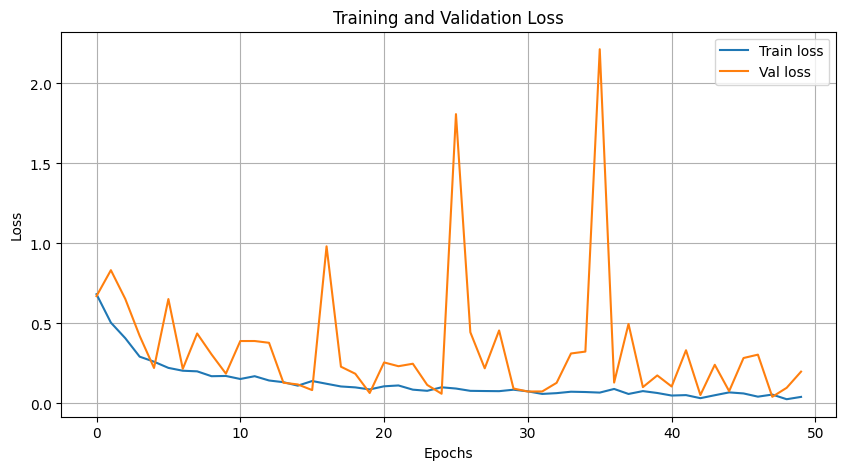

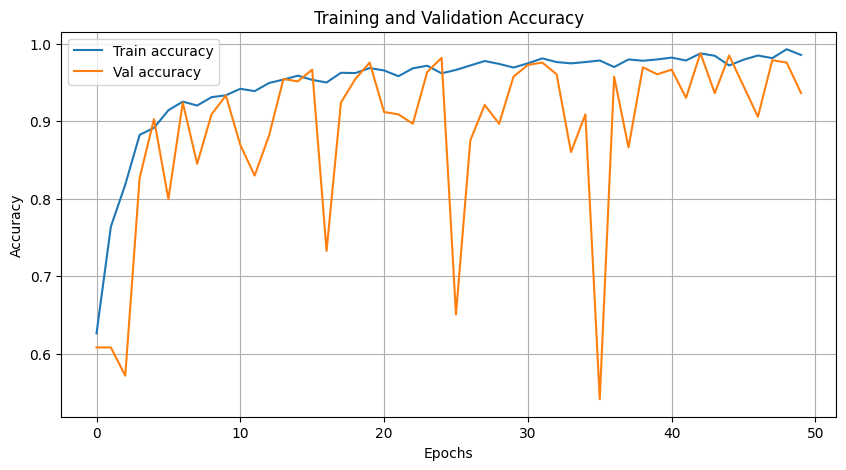

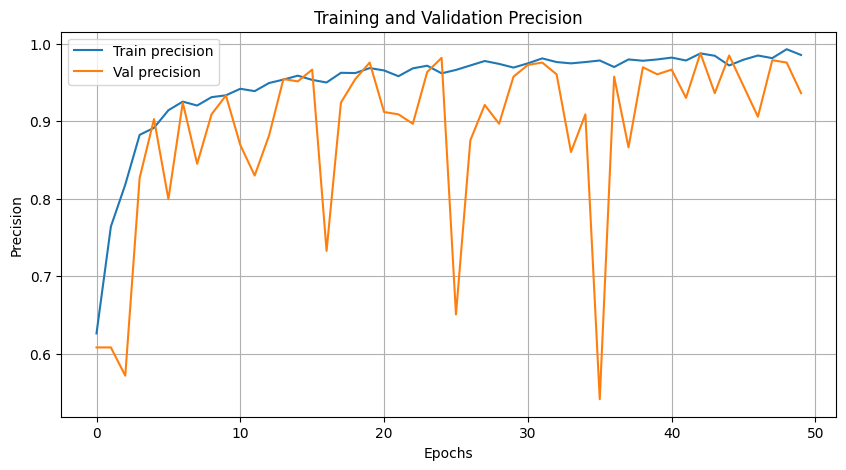

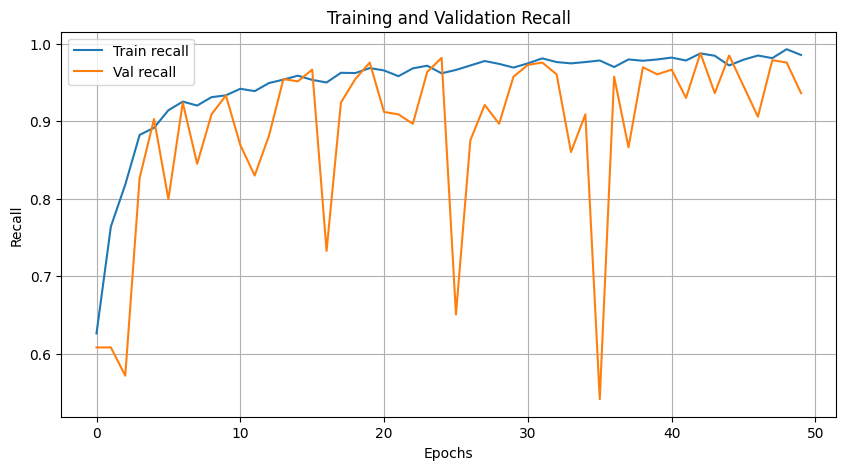

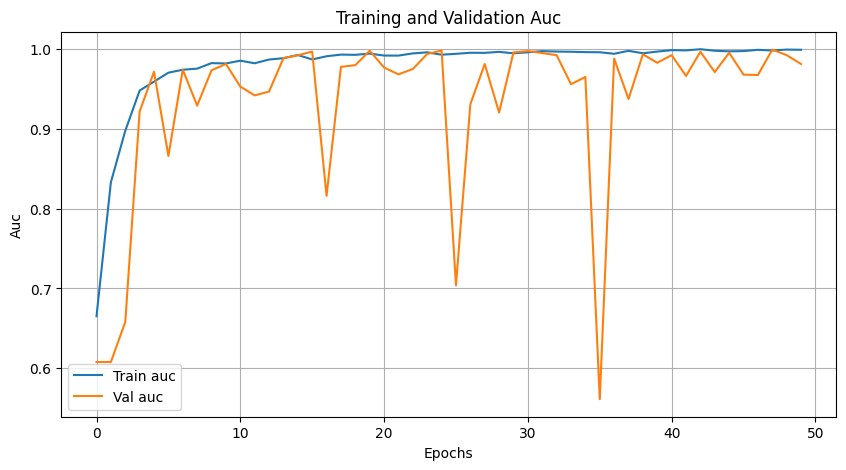

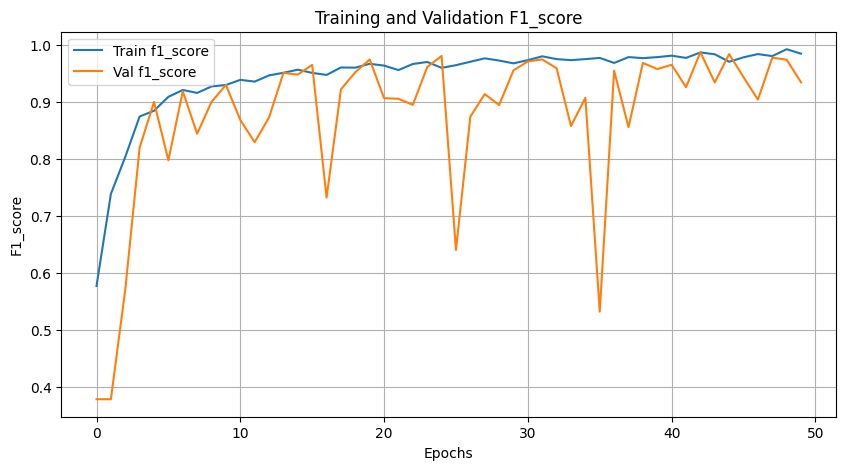

In [18]:
plot_training_history(history)

In [19]:
# Converter o histórico em DataFrame
history = pd.DataFrame(history.history)
# Salvar em CSV
history.to_csv('test_1_train_history.csv', index=False)

In [20]:
model.save('test_1.h5')

/home/magda/tf-gpu-env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Avaliar

In [21]:
avaliar_modelo(model, test_ds)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=6898, TN=9623, FP=125, FN=2886
Accuracy       : 0.8458
Precision      : 0.9822
Recall         : 0.7050
F1-Score       : 0.8208
AUC            : 0.9713
Binary Loss    : 0.5406
FDR (Fire Detection Rate)      : 70.50 %
EWR (Error Warning Rate)       : 15.42 %
Confusion Matrix:
[[9623  125]
 [2886 6898]]


{'TP': 6898,
 'TN': 9623,
 'FP': 125,
 'FN': 2886,
 'accuracy': 0.8458427196395658,
 'precision': 0.9822013384593479,
 'recall': 0.7050286181520851,
 'f1_score': 0.820848456000476,
 'auc': 0.9713256064266784,
 'loss': 0.5406175577872742,
 'fdr': 70.5028618152085,
 'ewr': 15.415728036043417,
 'confusion_matrix': array([[9623,  125],
        [2886, 6898]])}

In [22]:
model_best = load_model('test_1_best.h5')

In [23]:
avaliar_modelo(model_best, test_ds)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=9418, TN=9421, FP=327, FN=366
Accuracy       : 0.9645
Precision      : 0.9664
Recall         : 0.9626
F1-Score       : 0.9645
AUC            : 0.9936
Binary Loss    : 0.1121
FDR (Fire Detection Rate)      : 96.26 %
EWR (Error Warning Rate)       : 3.55 %
Confusion Matrix:
[[9421  327]
 [ 366 9418]]


{'TP': 9418,
 'TN': 9421,
 'FP': 327,
 'FN': 366,
 'accuracy': 0.9645197624411223,
 'precision': 0.9664443304258594,
 'recall': 0.9625919869174162,
 'f1_score': 0.964514312048748,
 'auc': 0.993560076981638,
 'loss': 0.11208438055141857,
 'fdr': 96.25919869174162,
 'ewr': 3.548023755887774,
 'confusion_matrix': array([[9421,  327],
        [ 366, 9418]])}

## Testar no FLAME train

In [24]:
data = pd.read_csv("../Datasets/FLAME_train.csv")
image_paths_flame_train = data['image_path'].values
labels_flame_train = data['label_bi'].values

test_ds_flame_train = tf.data.Dataset.from_tensor_slices((image_paths_flame_train, labels_flame_train))
test_ds_flame_train = test_ds_flame_train.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inspect_dataset_distribution(test_ds_flame_train, name="FLAME train")

📊 FLAME TRAIN -> Total de imagens: 39375
  Classe 0 (Sem fogo): 14357 imagens (36.46%)
  Classe 1 (Fogo): 25018 imagens (63.54%)
----------------------------------------


In [25]:
avaliar_modelo(model, test_ds_flame_train)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=22960, TN=14239, FP=118, FN=2058
Accuracy       : 0.9447
Precision      : 0.9949
Recall         : 0.9177
F1-Score       : 0.9548
AUC            : 0.9958
Binary Loss    : 0.1613
FDR (Fire Detection Rate)      : 91.77 %
EWR (Error Warning Rate)       : 5.53 %
Confusion Matrix:
[[14239   118]
 [ 2058 22960]]


{'TP': 22960,
 'TN': 14239,
 'FP': 118,
 'FN': 2058,
 'accuracy': 0.944736507936508,
 'precision': 0.9948869052777537,
 'recall': 0.9177392277560157,
 'f1_score': 0.9547571523619428,
 'auc': 0.995781023314812,
 'loss': 0.16133219973504836,
 'fdr': 91.77392277560156,
 'ewr': 5.526349206349206,
 'confusion_matrix': array([[14239,   118],
        [ 2058, 22960]])}

In [26]:
avaliar_modelo(model_best, test_ds_flame_train)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=24768, TN=13917, FP=440, FN=250
Accuracy       : 0.9825
Precision      : 0.9825
Recall         : 0.9900
F1-Score       : 0.9863
AUC            : 0.9977
Binary Loss    : 0.0571
FDR (Fire Detection Rate)      : 99.00 %
EWR (Error Warning Rate)       : 1.75 %
Confusion Matrix:
[[13917   440]
 [  250 24768]]


{'TP': 24768,
 'TN': 13917,
 'FP': 440,
 'FN': 250,
 'accuracy': 0.9824761904761905,
 'precision': 0.9825452237384957,
 'recall': 0.9900071948197298,
 'f1_score': 0.9862620953291124,
 'auc': 0.9976736245619531,
 'loss': 0.05709108188891022,
 'fdr': 99.00071948197298,
 'ewr': 1.7523809523809524,
 'confusion_matrix': array([[13917,   440],
        [  250, 24768]])}

## Testar no FLAME test

In [27]:
data = pd.read_csv("../Datasets/FLAME_test.csv")
image_paths_flame_test = data['image_path'].values
labels_flame_test = data['label_bi'].values

test_ds_flame_test = tf.data.Dataset.from_tensor_slices((image_paths_flame_test, labels_flame_test))
test_ds_flame_test = test_ds_flame_test.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inspect_dataset_distribution(test_ds_flame_test, name="FLAME test")

📊 FLAME TEST -> Total de imagens: 8617
  Classe 0 (Sem fogo): 3480 imagens (40.39%)
  Classe 1 (Fogo): 5137 imagens (59.61%)
----------------------------------------


In [28]:
avaliar_modelo(model, test_ds_flame_test)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=3918, TN=3233, FP=247, FN=1219
Accuracy       : 0.8299
Precision      : 0.9407
Recall         : 0.7627
F1-Score       : 0.8424
AUC            : 0.9490
Binary Loss    : 0.5316
FDR (Fire Detection Rate)      : 76.27 %
EWR (Error Warning Rate)       : 17.01 %
Confusion Matrix:
[[3233  247]
 [1219 3918]]


{'TP': 3918,
 'TN': 3233,
 'FP': 247,
 'FN': 1219,
 'accuracy': 0.8298711848671231,
 'precision': 0.9406962785114046,
 'recall': 0.7627019661280903,
 'f1_score': 0.8423994839819393,
 'auc': 0.9489590954960518,
 'loss': 0.5315686704702132,
 'fdr': 76.27019661280903,
 'ewr': 17.012881513287688,
 'confusion_matrix': array([[3233,  247],
        [1219, 3918]])}

In [29]:
avaliar_modelo(model_best, test_ds_flame_test)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=4773, TN=2910, FP=570, FN=364
Accuracy       : 0.8916
Precision      : 0.8933
Recall         : 0.9291
F1-Score       : 0.9109
AUC            : 0.9615
Binary Loss    : 0.2993
FDR (Fire Detection Rate)      : 92.91 %
EWR (Error Warning Rate)       : 10.84 %
Confusion Matrix:
[[2910  570]
 [ 364 4773]]


{'TP': 4773,
 'TN': 2910,
 'FP': 570,
 'FN': 364,
 'accuracy': 0.8916096089126146,
 'precision': 0.8933183604716451,
 'recall': 0.9291415222892739,
 'f1_score': 0.9108778625954198,
 'auc': 0.9615472826172081,
 'loss': 0.299302765281283,
 'fdr': 92.91415222892739,
 'ewr': 10.839039108738541,
 'confusion_matrix': array([[2910,  570],
        [ 364, 4773]])}

## Testar no UAVS Raw Images

In [30]:
data = pd.read_csv("../Datasets/UAVS_RawImages.csv")
image_paths_uavs_raw = data['image_path'].values
labels_uavs_raw = data['label_bi'].values

test_ds_uavs_raw = tf.data.Dataset.from_tensor_slices((image_paths_uavs_raw, labels_uavs_raw))
test_ds_uavs_raw = test_ds_uavs_raw.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inspect_dataset_distribution(test_ds_uavs_raw, name="UAVS Raw Images")

📊 UAVS RAW IMAGES -> Total de imagens: 1643
  Classe 0 (Sem fogo): 498 imagens (30.31%)
  Classe 1 (Fogo): 1145 imagens (69.69%)
----------------------------------------


In [31]:
avaliar_modelo(model, test_ds_uavs_raw)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=1047, TN=497, FP=1, FN=98
Accuracy       : 0.9397
Precision      : 0.9990
Recall         : 0.9144
F1-Score       : 0.9549
AUC            : 0.9983
Binary Loss    : 0.1487
FDR (Fire Detection Rate)      : 91.44 %
EWR (Error Warning Rate)       : 6.03 %
Confusion Matrix:
[[ 497    1]
 [  98 1047]]


{'TP': 1047,
 'TN': 497,
 'FP': 1,
 'FN': 98,
 'accuracy': 0.9397443700547778,
 'precision': 0.9990458015267175,
 'recall': 0.914410480349345,
 'f1_score': 0.9548563611491109,
 'auc': 0.9983076410445275,
 'loss': 0.14865290584904298,
 'fdr': 91.4410480349345,
 'ewr': 6.0255629945222156,
 'confusion_matrix': array([[ 497,    1],
        [  98, 1047]])}

In [32]:
avaliar_modelo(model_best, test_ds_uavs_raw)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=1145, TN=491, FP=7, FN=0
Accuracy       : 0.9957
Precision      : 0.9939
Recall         : 1.0000
F1-Score       : 0.9970
AUC            : 1.0000
Binary Loss    : 0.0083
FDR (Fire Detection Rate)      : 100.00 %
EWR (Error Warning Rate)       : 0.43 %
Confusion Matrix:
[[ 491    7]
 [   0 1145]]


{'TP': 1145,
 'TN': 491,
 'FP': 7,
 'FN': 0,
 'accuracy': 0.995739500912964,
 'precision': 0.9939236111111112,
 'recall': 1.0,
 'f1_score': 0.9969525468001742,
 'auc': 1.0,
 'loss': 0.008328688065796327,
 'fdr': 100.0,
 'ewr': 0.426049908703591,
 'confusion_matrix': array([[ 491,    7],
        [   0, 1145]])}

## Testar no UAVS Augmented Images

In [33]:
data = pd.read_csv("../Datasets/UAVS_AugmentedImages.csv")
image_paths_uavs_aug = data['image_path'].values
labels_uavs_aug = data['label_bi'].values

test_ds_uavs_aug = tf.data.Dataset.from_tensor_slices((image_paths_uavs_aug, labels_uavs_aug))
test_ds_uavs_aug = test_ds_uavs_aug.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inspect_dataset_distribution(test_ds_uavs_aug, name="UAVS Augmented Images")

📊 UAVS AUGMENTED IMAGES -> Total de imagens: 15560
  Classe 0 (Sem fogo): 7780 imagens (50.00%)
  Classe 1 (Fogo): 7780 imagens (50.00%)
----------------------------------------


In [34]:
avaliar_modelo(model, test_ds_uavs_aug)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=5108, TN=7701, FP=79, FN=2672
Accuracy       : 0.8232
Precision      : 0.9848
Recall         : 0.6566
F1-Score       : 0.7878
AUC            : 0.9650
Binary Loss    : 0.6276
FDR (Fire Detection Rate)      : 65.66 %
EWR (Error Warning Rate)       : 17.68 %
Confusion Matrix:
[[7701   79]
 [2672 5108]]


{'TP': 5108,
 'TN': 7701,
 'FP': 79,
 'FN': 2672,
 'accuracy': 0.8232005141388175,
 'precision': 0.9847696163485637,
 'recall': 0.6565552699228792,
 'f1_score': 0.7878460707950953,
 'auc': 0.9649611256864545,
 'loss': 0.6276187316212034,
 'fdr': 65.65552699228792,
 'ewr': 17.67994858611825,
 'confusion_matrix': array([[7701,   79],
        [2672, 5108]])}

In [35]:
avaliar_modelo(model_best, test_ds_uavs_aug)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=7454, TN=7580, FP=200, FN=326
Accuracy       : 0.9662
Precision      : 0.9739
Recall         : 0.9581
F1-Score       : 0.9659
AUC            : 0.9931
Binary Loss    : 0.1083
FDR (Fire Detection Rate)      : 95.81 %
EWR (Error Warning Rate)       : 3.38 %
Confusion Matrix:
[[7580  200]
 [ 326 7454]]


{'TP': 7454,
 'TN': 7580,
 'FP': 200,
 'FN': 326,
 'accuracy': 0.9661953727506427,
 'precision': 0.9738698719623726,
 'recall': 0.9580976863753213,
 'f1_score': 0.9659193987300764,
 'auc': 0.9930912761612731,
 'loss': 0.10832818513112828,
 'fdr': 95.80976863753213,
 'ewr': 3.3804627249357324,
 'confusion_matrix': array([[7580,  200],
        [ 326, 7454]])}

## Testar no FireMan

In [36]:
data = pd.read_csv("../Datasets/FireMan_test.csv")
image_paths_fireman = data['image_path'].values
labels_fireman = data['label_bi'].values

test_ds_fireman = tf.data.Dataset.from_tensor_slices((image_paths_fireman, labels_fireman))
test_ds_fireman = test_ds_fireman.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inspect_dataset_distribution(test_ds_fireman, name="UAVS Augmented Images")

📊 UAVS AUGMENTED IMAGES -> Total de imagens: 589
  Classe 0 (Sem fogo): 33 imagens (5.60%)
  Classe 1 (Fogo): 556 imagens (94.40%)
----------------------------------------


In [37]:
avaliar_modelo(model, test_ds_fireman)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=10, TN=33, FP=0, FN=546
Accuracy       : 0.0730
Precision      : 1.0000
Recall         : 0.0180
F1-Score       : 0.0353
AUC            : 0.1906
Binary Loss    : 7.0426
FDR (Fire Detection Rate)      : 1.80 %
EWR (Error Warning Rate)       : 92.70 %
Confusion Matrix:
[[ 33   0]
 [546  10]]


{'TP': 10,
 'TN': 33,
 'FP': 0,
 'FN': 546,
 'accuracy': 0.0730050933786078,
 'precision': 1.0,
 'recall': 0.017985611510791366,
 'f1_score': 0.0353356890459364,
 'auc': 0.19064748201438847,
 'loss': 7.042610692539341,
 'fdr': 1.7985611510791366,
 'ewr': 92.69949066213921,
 'confusion_matrix': array([[ 33,   0],
        [546,  10]])}

In [38]:
avaliar_modelo(model_best, test_ds_fireman)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=46, TN=33, FP=0, FN=510
Accuracy       : 0.1341
Precision      : 1.0000
Recall         : 0.0827
F1-Score       : 0.1528
AUC            : 0.1644
Binary Loss    : 6.5792
FDR (Fire Detection Rate)      : 8.27 %
EWR (Error Warning Rate)       : 86.59 %
Confusion Matrix:
[[ 33   0]
 [510  46]]


{'TP': 46,
 'TN': 33,
 'FP': 0,
 'FN': 510,
 'accuracy': 0.13412563667232597,
 'precision': 1.0,
 'recall': 0.08273381294964029,
 'f1_score': 0.15282392026578073,
 'auc': 0.1643775888380205,
 'loss': 6.579225726676267,
 'fdr': 8.273381294964029,
 'ewr': 86.5874363327674,
 'confusion_matrix': array([[ 33,   0],
        [510,  46]])}